In [1]:

## Note in OSX Catalinaa zsh shell command means installation of some packages may not work: see 
## https://stackoverflow.com/questions/31615322/zsh-conda-pip-installs-command-not-found
# Will need conda-forge in order to get phreeqpy and cbsyst
# you will also need IPhreeqc Modules.. downloadable from USGS.
# when you download them, cd to the folder in terminal, then type 'mkdir build' then 'cd build', then 'sudo ../configure', 'sudo make' (takes a while), 'sudo make install' (may need to repeat)

import math
import os
import pandas as pd
import phreeqpy.iphreeqc.phreeqc_dll as phreeqc_mod
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.lines as mlines
import matplotlib.font_manager
import gc
import itertools
from scipy import optimize as opt
from scipy.optimize import curve_fit
from cbsyst import Csys, Bsys, non_MyAMI_constants
import phreeqpy.iphreeqc.phreeqc_dll as phreeqc_mod
from sklearn.linear_model import LinearRegression
import statistics
from pprint import pprint
from scipy import stats
from pandas import IndexSlice as idx
from lmfit import Model



# Note: these functions below can be found in the 'inorg_b' module
# https://github.com/oscarbranson/Farmer_2018_Supplement/tree/master/inorg_b
# Needs to be saved in the root archive where the jupyter notebook is looking.
from inorg_b import phreeqpy_fns as pf
from inorg_b import load
from inorg_b.helpers import d11_2_A11, A11_2_d11, err, extract_model_vars
from inorg_b.model import fitfn, predfn, fitfn_single_species_R, predfn_single_species_R
from inorg_b.plots import model_vs_data



matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
plt.rcParams['font.family'] = 'Myriad Pro'
matplotlib.rcParams['pdf.fonttype'] = 42

## Check where your python installation is.. also if you want to use pitzerX.dat, with Yongliang Xiong's Na-B pairing included, 
## then you will have to navigate to the iphreeqc folder and copy in the pitzerX.dat file. 
phreeq_path="/usr/local/lib/libiphreeqc.dylib"
phreeqc = phreeqc_mod.IPhreeqc(phreeq_path)
database_path = "/usr/local/share/doc/iphreeqc/database/"


## Master Data File
#df= pd.read_csv('InorgforPython.csv', header=0, dtype={'Calc': np.bool, 'Arag':np.bool, 'seeds':np.bool})
df= pd.read_csv('InorgforPython_wSanyal.csv', header=0, dtype={'Calc': np.bool, 'Arag':np.bool, 'seeds':np.bool})


 #{‘a’: np.float64, ‘b’: np.int32, ‘c’: ‘Int64’}

# presentation niceties
idx = pd.IndexSlice
pd.options.mode.chained_assignment = None
plt.rcParams['figure.dpi'] = 120


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) ## This is to stop jupyter from wasting all this space in the margins of the page.


## Functions taken from Oscar's Python notebooks: https://github.com/oscarbranson/Farmer_2018_Supplement
# Unit Converters
def d11_2_A11(d11, SRM_ratio=4.04367):
    """
    Convert Delta to Abundance notation.
    Default SRM_ratio is NIST951 11B/10B
    """
    return SRM_ratio * (d11 / 1000 + 1) / (SRM_ratio * (d11 / 1000 + 1) + 1)

def A11_2_d11(A11, SRM_ratio=4.04367):
    """
    Convert Abundance to Delta notation.
    Default SRM_ratio is NIST951 11B/10B
    """
    return ((A11 / (1 - A11)) / SRM_ratio - 1) * 1000

def A11_2_R11(A11):
    """
    Convert Abundance to isotope ratio notation.
    """
    return A11 / (1 - A11)

def d11_2_R11(d11, SRM_ratio=4.04367):
    """
    Convert Delta to isotope ratio notation.
    Default SRM_ratio is NIST951 11B/10B
    """
    return (d11/1000 + 1) * SRM_ratio


def R11_2_d11(R11, SRM_ratio=4.04367):
    """
    Convert isotope ratio to Delta notation.
    Default SRM_ratio is NIST951 11B/10B
    """
    return (R11 / SRM_ratio - 1) * 1000


def R11_2_A11(R11):
    """
    Convert isotope ratio to abundance notation.
    """
    return R11 / (1 + R11)

## Functions stolen from Oscar Branson https://github.com/oscarbranson/
def run_phreeqc(input_string, dbase_path, phreeq_path='/usr/local/lib/libiphreeqc.so'):
    """
    Run input string in phreeqc with specified database.
    Parameters
    ----------
    input_string : str
        Valid phreeqc input string with SELECTED_OUTPUT.
    dbase_path : str
        Path to valid phreeqc database (e.g. minteq.v4.dat)
    phreeq_path : str
        Path to iphreeqc shared library.
    Returns
    -------
    pandas.Series of calculated species
    """
    phreeqc = phreeqc_mod.IPhreeqc(phreeq_path)
    phreeqc.load_database(dbase_path)
    phreeqc.run_string(input_string)
    out = phreeqc.get_selected_output_array()
    return pd.Series(out[1], out[0])

def d11BsolB_Rae2018MH(Hval, pKB, BT, alpha, d11BT):
    """
    Calculate d11B of aqueous species using full mass-balance approach of Rae, 2018.
    Returns
    -------
    d11BO4, d11BO3
    """
    R_BT = d11_2_R11(d11BT)
    #Hval = Hval
    Kbval = 10**(-1*pKB)
    RB4 = (((Hval**2*R_BT**2 + 2*Hval**2*R_BT*alpha + Hval**2*alpha**2 + 2*Hval*Kbval*R_BT**2*alpha - 
             2*Hval*Kbval*R_BT*alpha**2 + 8*Hval*Kbval*R_BT*alpha - 2*Hval*Kbval*R_BT + 2*Hval*Kbval*alpha + 
             Kbval**2*R_BT**2*alpha**2 + 2*Kbval**2*R_BT*alpha + Kbval**2)**(1/2) - 
            Hval*alpha - Kbval + Hval*R_BT + Kbval*R_BT*alpha)/(2*alpha*(Hval + Kbval)))
    RB3 = RB4 * alpha

    # return RB4, RB3
    return R11_2_d11(RB4), R11_2_d11(RB3)

In [175]:
df= pd.read_csv('InorgforPython_wSanyal.csv', header=0, dtype={'Calc': np.bool, 'Arag':np.bool, 'seeds':np.bool})

In [177]:
## Making the correction to NBS pH to MacInnes 'scale' for Pitzer database.. 
## Used the average of different solution chemistries tested by Oded Nir et al. (2014), Water Research https://doi.org/10.1016/j.watres.2014.07.006
pHMacInnes=pd.Series((df.pH+((0.0224*np.log(df.IonicStrength))+0.0665)),index=df.index)
df.insert(9, 'pHMacInnes', pHMacInnes)
#df
## Also, although some experiments used pHstat systems to keep the pH stable (and so essentially they have no error),
## actually in absolute terms physical chemists will generally agree you can't get *absolute* pH accurate to better than 0.03 units
## from an electrode.. Since we are comparing data from different setups and different electrodes, 
## I will apply a minimum uncertainty on pH of 0.03 to get 'pHerrrealistic'

#2sd
#pHerrrealistic= pd.Series(index=df.index, dtype=float)
#for i in df.index:
#    if df.pHerr[i]<0.03:
#        pHerrrealistic[i]=0.03
#    else:
#        pHerrrealistic[i]=df.pHerr[i]
        
#2se
pHerrrealistic= pd.Series(index=df.index, dtype=float)
for i in df.index:
    if df.pHerr[i]<0.03:
        pHerrrealistic[i]=0.03
    else:
        pHerrrealistic[i]=df.pHerr2se[i]
        

In [178]:
##  Beginning of the grand effort at doing everything incl PHREEQC via Monte Carlo

reps=1000 #Can't do 10,000 without crashing... 5,000 got to 50GB memory before I stopped it.. 1,000 just about doable
# Way I've been running this is: run 1000 reps, save them as 1st1000reps csv files.. then restart the kernel, run the second.. then restart the kernel and just load the csv files in. 
# Oscar's now written a version of his templating code that allows you to run multiple PHREEQC solutions at once, which would probably get round this problem, but a) not had a chance to implement yet, and b) feel like if I pinch any more code he's written then he really should be on this paper. 


#this block takes ~2MB RAM per 100 reps, and gets you the input variables from PHREEQC drawn from a uniform distribution of start and end-experiment concentrations.
seawaterd11B=39.61  

MCsolutions={}
for s,e,a in zip([df.Start_NamMol,df.Start_ClmMol,df.Start_BmMol,df.Start_CamMol,df.Start_DICmMol,df.Start_MgmMol],[df.End_NamMol,df.End_ClmMol,df.End_BmMol,df.End_CamMol,df.End_DICmMol,df.End_MgmMol],['MC_NamMol','MC_ClmMol','MC_BmMol','MC_CamMol','MC_DICmMol','MC_MgmMol']):
    temps=[]
    for i in df.index:
        if math.isnan(e[i])==False:
            temp=np.random.uniform(low=np.min([s[i],e[i]]),high=np.max([s[i],e[i]]), size=reps)
        else:
            temp=np.empty(reps)
            temp.fill(s[i])
        temps.append(temp)
    MCsolutions[a]=pd.DataFrame(temps, index=df.index)
    del temps,temp

## Making the correction to NBS pH to MacInnes 'scale' for Pitzer database.. 
## Used the average of different solution chemistries tested by Oded Nir et al. (2014), Water Research https://doi.org/10.1016/j.watres.2014.07.006
#pHMacInnes=pd.Series((df.pH+((0.0224*np.log(df.IonicStrength))+0.0665)),index=df.index)
## Also, although some experiments used pHstat systems to keep the pH stable (and so essentially they have no error),
## actually in absolute terms physical chemists will generally agree you can't get *absolute* pH accurate to better than 0.03 units
## from an electrode.. Since we are comparing data from different setups and different electrodes, 
## I will apply a minimum uncertainty on pH of 0.03 to get 'pHerrrealistic'
#pHerrrealistic= pd.Series(index=df.index)
#for i in df.index:
#    if df.pHerr[i]<0.03:
#        pHerrrealistic[i]=0.03
#    else:
#        pHerrrealistic[i]=df.pHerr[i]
        
MC_pH=pd.DataFrame(index=df.index)
for rep in range(reps):
    temporary= pd.Series(df.pHMacInnes+np.random.normal(0,(pHerrrealistic/2)), index=df.index)
    MC_pH[rep]=temporary.values
    del temporary
MCsolutions['pH']=MC_pH

MC_pHNBS=pd.DataFrame(index=df.index)
for rep in range(reps):
    temporary= pd.Series(df.pH+np.random.normal(0,(pHerrrealistic/2)), index=df.index)
    MC_pHNBS[rep]=temporary.values
    del temporary

MC_BCa=pd.DataFrame(index=df.index)
for rep in range(reps):
    temporary= pd.Series(df.BCa_umol+np.random.normal(0,(df.BCa_umol*0.06)), index=df.index)
    MC_BCa[rep]=temporary.values
    del temporary
MCsolutions['BCa']=MC_BCa

MC_NaCa=pd.DataFrame(index=df.index)
for rep in range(reps):
    temporary= pd.Series(df.NaCa_mmol+np.random.normal(0,(df.NaCa_mmol*0.03)), index=df.index)
    MC_NaCa[rep]=temporary.values
    del temporary
MCsolutions['NaCa']=MC_NaCa

MC_MgCa=pd.DataFrame(index=df.index)
for rep in range(reps):
    temporary= pd.Series(df.MgCa_mmol+np.random.normal(0,(df.MgCa_mmol*0.03)), index=df.index)
    MC_MgCa[rep]=temporary.values
    del temporary
MCsolutions['MgCa']=MC_MgCa


#MCcarbonates={}

## Monte Carlo of measured d11B accounting for measurement uncertainty
MCd11Bmeas=pd.DataFrame(index=df.index)
for rep in range(reps):
    temporary= pd.Series(df.d11Bmeas+np.random.normal(0,(df.d11Bmeaserr/2)), index=df.index)
    MCd11Bmeas[rep]=temporary.values
    del temporary
## Monte Carlo of solution d11B accounting for drift during run/measurement uncertainty
MCd11Bsoln=pd.DataFrame(index=df.index)    
for rep in range(reps):
    temporary= pd.Series(df.d11Bsol+np.random.normal(0,(df.d11Bsolerr/2)), index=df.index)
    MCd11Bsoln[rep]=temporary.values
    del temporary
    
## Using the alpha conversion factor in Hönisch et al. (2003), normalise carbonate to normal sw
MCalphaconversion=(39.61+1000)/(MCd11Bsoln+1000)
MCd11Bnormalised=((MCalphaconversion*MCd11Bmeas)+((MCalphaconversion-1)*1000))
del MCalphaconversion
#MCd11Bnormalised


Klochko=1.0272
Nir=1.026
#Note 'seawater' value is defined above to make sure that the value used is the same for carbonate normalisation as for borate calculation


In [ ]:
## Some prerequisites for the phreeqc loop 


MClambdaB = pd.DataFrame(index=df.index, columns=np.arange(reps))
MClambdaNa = pd.DataFrame(index=df.index, columns=np.arange(reps))
MClambdaMg = pd.DataFrame(index=df.index, columns=np.arange(reps))
MCtotalBorate = pd.DataFrame(index=df.index, columns=np.arange(reps))
MCtotalBoric = pd.DataFrame(index=df.index, columns=np.arange(reps))
#MCpercentPolyborates = pd.DataFrame(index=df.index, columns=np.arange(reps))
MCpercentNaborates = pd.DataFrame(index=df.index, columns=np.arange(reps))
MCpercentFreeBorate= pd.DataFrame(index=df.index, columns=np.arange(reps))
#MC_KB_freeboratebicarb = pd.DataFrame(index=df.index, columns=np.arange(reps))
MC_KB_totalboratebicarb = pd.DataFrame(index=df.index, columns=np.arange(reps))
#MC_KB_freeborateDIC = pd.DataFrame(index=df.index, columns=np.arange(reps))
MC_KB_totalborateDIC = pd.DataFrame(index=df.index, columns=np.arange(reps))
MCpKB=pd.DataFrame(index=df.index, columns=np.arange(reps))
#MCpKB_justfreeborate=pd.DataFrame(index=df.index, columns=np.arange(reps))
MCd11BborateN=pd.DataFrame(index=df.index, columns=np.arange(reps))
MCd11BborateK=pd.DataFrame(index=df.index, columns=np.arange(reps))
MCd11BborateKRae=pd.DataFrame(index=df.index, columns=np.arange(reps))
MCd11BborateNRae=pd.DataFrame(index=df.index, columns=np.arange(reps))
MC_SICalc=pd.DataFrame(index=df.index, columns=np.arange(reps))
MC_SIArag=pd.DataFrame(index=df.index, columns=np.arange(reps))
MCEpsilonN=pd.DataFrame(index=df.index, columns=np.arange(reps))
MCEpsilonK=pd.DataFrame(index=df.index, columns=np.arange(reps))
MCEpsilonKRae=pd.DataFrame(index=df.index, columns=np.arange(reps))
MCEpsilonNRae=pd.DataFrame(index=df.index, columns=np.arange(reps))
MCHplusPHREEQC=pd.DataFrame(index=df.index, columns=np.arange(reps))
MCcarbion=pd.DataFrame(index=df.index, columns=np.arange(reps))
MC_DIC=pd.DataFrame(index=df.index, columns=np.arange(reps))
MCd11BboricKRae=pd.DataFrame(index=df.index, columns=np.arange(reps))
MCd11BboricNRae=pd.DataFrame(index=df.index, columns=np.arange(reps))
MC_littler=pd.DataFrame(index=df.index, columns=np.arange(reps))
MC_MgCarbion=pd.DataFrame(index=df.index, columns=np.arange(reps))
MC_CaMgCarbion=pd.DataFrame(index=df.index, columns=np.arange(reps))
MC_Cafree=pd.DataFrame(index=df.index, columns=np.arange(reps))
MC_Mgfree=pd.DataFrame(index=df.index, columns=np.arange(reps))


In [ ]:

## Now to run PHREEQC on every MC solution rep!  NB: Beware if your reps are set to a very large number- this could take a while!
## Takes about 53 GB of Ram to get 1000 reps! Not good.. tried making efficiencies but the memory load is from the PHREEQC calls.. need to make it all one PHREEQC input file and it would get round the problem. 



## Pick your Pitzer Flavour (keep an eye on what you chose elsewhere). 
dbase='pitzer'

## this code pinched from Oscar makes your PHREEQC input file. Note, different from Oscar- we now make it calculate density, because before in Oscar's code it was messing up things.. Also we double checked the units- they weren't using the correct ones
# Note I still have 'Pitzer X' listed in there.. that's a reference to the fact that I've been trying to implement Na-Borate pairing better into Pitzer so we can calculate the abundance of that pair. 
# Looked promising to begin with, but then the pKBs fit wasn't very good so I gave up. So technically it'll still output NaB(OH)4, but there's nothing there if you use pitzer
phreeqc.load_database(os.path.join(database_path, dbase + '.dat')) #took this from where it was just below the phreeqc input variable
for rep, row in itertools.product(np.arange(reps), df.index):        
    template="""
            SOLUTION {row:.0f}
                temp      {temp:.3f}
                pH        {pH:.5f}
                units     {units:s}
                density   1 calculate
                Cl        {Cl:.9f}
                Na        {Na:.9f}
                Mg        {Mg:.9f}
                B         {B:.9f}
                Ca        {Ca:.9f}
                C         {DIC:.9f}
                K         {K:.9f}
                S(6)      {SO4:.9f}
                -water    1 # kg
            SELECTED_OUTPUT
                -pH
                -temperature
                -alkalinity
                -ionic_strength
                -totals Cl Na Mg K B Ca C S(6)
                -m OH- H+
                # pitzer outputs
                #-m B(OH)4- B(OH)3 CaB(OH)4+ B3O3(OH)4- B4O5(OH)4-2  # boron
                #-m HCO3- CO3-2 CO2  # carbon
                # pitzerX outputs  
                -m B(OH)4- B(OH)3 CaB(OH)4+ NaB(OH)4 MgB(OH)4+ B3O3(OH)4- B4O5(OH)4-2 # boron
                -m HCO3- CO3-2 CO2  # carbon
                -m Ca+2 Mg+2 #Cations
                -si Calcite Aragonite
            END"""
    PhreeqcInput=template.format(temp=df.Temp[row],
                pH=MCsolutions['pH'][rep][row],
                Na=MCsolutions['MC_NamMol'][rep][row],
                Cl=MCsolutions['MC_ClmMol'][rep][row],
                B=MCsolutions['MC_BmMol'][rep][row],
                Ca=MCsolutions['MC_CamMol'][rep][row],
                DIC=MCsolutions['MC_DICmMol'][rep][row],
                Mg=MCsolutions['MC_MgmMol'][rep][row],
                SO4=df.Ave_SO4mMol[row],
                units=df.Units[row],
                K=df.Ave_KmMol[row],
                #row=df.index[row])
                row=row)
        #data = run_phreeqc(PhreeqcInput, os.path.join(database_path, dbase + '.dat'), phreeq_path=phreeq_path)
        #iterationdata=pd.Series(data.values)
        #iterationdata=pd.Series((run_phreeqc(PhreeqcInput, os.path.join(database_path, dbase + '.dat'), phreeq_path=phreeq_path)).values)
    iterationdata=pd.Series((run_phreeqc(PhreeqcInput, os.path.join(database_path, dbase + '.dat'), phreeq_path=phreeq_path)).values, index=['simulation', 'state', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp(C)',
        'eqkgwAlk', 'mu', 'molkgwCl', 'molkgwNa', 'molkgwMg',
        'molkgwK', 'molkgwB', 'molkgwCa', 'molkgwC',
        'molkgwS', 'molkgwOHminus', 'molkgwHplus',
        'molkgwBoratefree', 'molkgwBoric', 'molkgwCaBorateplus',
        'molkgwNaBorate', 'molkgwMgBorateplus', 'molkgwB3O3OH4minus',
        'molkgwB4O5OH4minus2', 'molkgwBicarb', 'molkgwCarbion',
        'molkgwCO2aq', 'molkgwCafree','molkgwMgfree','SI_Calc', 'SI_Arag'] )
    MClambdaB[rep][row]=(MCsolutions['BCa'][rep][row]/1000000)/(iterationdata.molkgwB/iterationdata.molkgwC)
    MClambdaNa[rep][row]=(MCsolutions['NaCa'][rep][row]/1000)/(iterationdata.molkgwNa/iterationdata.molkgwC)
    MClambdaMg[rep][row]=(MCsolutions['MgCa'][rep][row]/1000)/(iterationdata.molkgwMg/iterationdata.molkgwC)
    MCtotalBorate[rep][row]=(iterationdata.molkgwNaBorate+iterationdata.molkgwBoratefree\
                           +iterationdata.molkgwCaBorateplus+iterationdata.molkgwMgBorateplus\
                           +(iterationdata.molkgwB4O5OH4minus2)/2) ## Half of B4O5OH4^-2 is trigonal, half tetrahedral
    MCtotalBoric[rep][row]=(iterationdata.molkgwBoric+iterationdata.molkgwB3O3OH4minus\
                          +(iterationdata.molkgwB4O5OH4minus2)/2)  ## Half of B4O5OH4^-2 is trigonal, half tetrahedral; All B3O3OH4- is trigonal
    MCpercentNaborates[rep][row]=(iterationdata.molkgwNaBorate/MCtotalBorate[rep][row])*100
    MCpercentFreeBorate[rep][row]=(iterationdata.molkgwBoratefree/MCtotalBorate[rep][row])*100
    MC_KB_totalboratebicarb[rep][row]=(MCsolutions['BCa'][rep][row]*10**-6)/(MCtotalBorate[rep][row]/iterationdata.molkgwBicarb)
    MC_KB_totalborateDIC[rep][row]=(MCsolutions['BCa'][rep][row]*10**-6)/(MCtotalBorate[rep][row]/iterationdata.molkgwC)
    MCpKB[rep][row]=-1*math.log10((MCtotalBorate[rep][row]*iterationdata.molkgwHplus)/MCtotalBoric[rep][row])
    MCd11BborateK[rep][row]=((39.61*(10**(MCpKB[rep][row]-MCsolutions['pH'][rep][row])+1))-\
                            (27.2*(10**(MCpKB[rep][row]-MCsolutions['pH'][rep][row]))))/\
                            (1+(1.0272*(10**(MCpKB[rep][row]-MCsolutions['pH'][rep][row]))))
    MCd11BborateN[rep][row]=(39.61*(10**(MCpKB[rep][row]-MCsolutions['pH'][rep][row])+1)-\
                            (26*10**(MCpKB[rep][row]-MCsolutions['pH'][rep][row])))/\
                            (1+(1.026*10**(MCpKB[rep][row]-MCsolutions['pH'][rep][row])))
    MCd11BborateKRae[rep][row]=d11BsolB_Rae2018MH(iterationdata.molkgwHplus, MCpKB[rep][row], iterationdata.molkgwB, Klochko, seawaterd11B)[0]
    MCd11BborateNRae[rep][row]=d11BsolB_Rae2018MH(iterationdata.molkgwHplus, MCpKB[rep][row], iterationdata.molkgwB, Nir, seawaterd11B)[0]
    MCd11BboricKRae[rep][row]=d11BsolB_Rae2018MH(iterationdata.molkgwHplus, MCpKB[rep][row], iterationdata.molkgwB, Klochko, seawaterd11B)[1]
    MCd11BboricNRae[rep][row]=d11BsolB_Rae2018MH(iterationdata.molkgwHplus, MCpKB[rep][row], iterationdata.molkgwB, Nir, seawaterd11B)[1]
    MC_SICalc[rep][row]=iterationdata.SI_Calc
    MC_SIArag[rep][row]=iterationdata.SI_Arag
    MCHplusPHREEQC[rep][row]=iterationdata.molkgwHplus
    MCcarbion[rep][row]=iterationdata.molkgwCarbion
    MC_littler[rep][row]=iterationdata.molkgwCafree/iterationdata.molkgwCarbion
    MC_Cafree[rep][row]=iterationdata.molkgwCafree
    MC_Mgfree[rep][row]=iterationdata.molkgwMgfree
    MC_MgCarbion[rep][row]=iterationdata.molkgwMgfree/iterationdata.molkgwCarbion
    MC_CaMgCarbion[rep][row]=(iterationdata.molkgwMgfree+iterationdata.molkgwCafree)/iterationdata.molkgwCarbion
    MC_DIC[rep][row]=iterationdata.molkgwC
    MCEpsilonN[rep][row]=MCd11Bnormalised[rep][row]-MCd11BborateN[rep][row]
    MCEpsilonK[rep][row]=MCd11Bnormalised[rep][row]-MCd11BborateK[rep][row]
    MCEpsilonNRae[rep][row]=MCd11Bnormalised[rep][row]-MCd11BborateNRae[rep][row]
    MCEpsilonKRae[rep][row]=MCd11Bnormalised[rep][row]-MCd11BborateKRae[rep][row]
    del iterationdata, PhreeqcInput
    gc.collect()
    
    
## Below is some code that I had before I had to do this running twice, restarting the kernel, loading csvs.. may come in useful so commented out.     
#MCd11BborateK_median=pd.Series(MCd11BborateK.median(axis=1), index=df.index)
#MCd11BborateK_up95=pd.Series(np.quantile(MCd11BborateK, 0.95, axis=1), index=df.index)
#MCd11BborateK_low95=pd.Series(np.quantile(MCd11BborateK, 0.05, axis=1), index=df.index)

#MCd11BborateKRae_median=pd.Series(MCd11BborateKRae.median(axis=1), index=df.index)
#MCd11BborateKRae_up95=pd.Series(np.quantile(MCd11BborateKRae, 0.95, axis=1), index=df.index)
#MCd11BborateKRae_low95=pd.Series(np.quantile(MCd11BborateKRae, 0.05, axis=1), index=df.index)

#MCd11BborateN_median=pd.Series(MCd11BborateN.median(axis=1), index=df.index)
#MCd11BborateN_up95=pd.Series(np.quantile(MCd11BborateN, 0.95, axis=1), index=df.index)
#MCd11BborateN_low95=pd.Series(np.quantile(MCd11BborateN, 0.05, axis=1), index=df.index)

#MCd11BborateNRae_median=pd.Series(MCd11BborateNRae.median(axis=1), index=df.index)
#MCd11BborateNRae_up95=pd.Series(np.quantile(MCd11BborateNRae, 0.95, axis=1), index=df.index)
#MCd11BborateNRae_low95=pd.Series(np.quantile(MCd11BborateNRae, 0.05, axis=1), index=df.index)

#MClambdaB_median=pd.Series(MClambdaB.median(axis=1), index=df.index)
#MClambdaB_up95=pd.Series(np.quantile(MClambdaB, 0.95, axis=1), index=df.index)
#MClambdaB_low95=pd.Series(np.quantile(MClambdaB, 0.05, axis=1), index=df.index)

#MClambdaNa_median=pd.Series(MClambdaNa.median(axis=1), index=df.index)
#MClambdaNa_up95=pd.Series(np.quantile(MClambdaNa, 0.95, axis=1), index=df.index)
#MClambdaNa_low95=pd.Series(np.quantile(MClambdaNa, 0.05, axis=1), index=df.index)

#MClambdaMg_median=pd.Series(MClambdaMg.median(axis=1), index=df.index)
#MClambdaMg_up95=pd.Series(np.quantile(MClambdaMg, 0.95, axis=1), index=df.index)
#MClambdaMg_low95=pd.Series(np.quantile(MClambdaMg, 0.05, axis=1), index=df.index)

#MCSICalc_median=pd.Series(MC_SICalc.median(axis=1), index=df.index)
#MCSICalc_up95=pd.Series(np.quantile(MC_SICalc, 0.95, axis=1), index=df.index)
#MCSICalc_low95=pd.Series(np.quantile(MC_SICalc, 0.05, axis=1), index=df.index)##

#MCEpsilonK_median=pd.Series(MCEpsilonK.median(axis=1), index=df.index)
#MCEpsilonK_up95=pd.Series(np.quantile(MCEpsilonK, 0.95, axis=1), index=df.index)
#MCEpsilonK_low95=pd.Series(np.quantile(MCEpsilonK, 0.05, axis=1), index=df.index)

#MCEpsilonKRae_median=pd.Series(MCEpsilonKRae.median(axis=1), index=df.index)
#MCEpsilonKRae_up95=pd.Series(np.quantile(MCEpsilonKRae, 0.95, axis=1), index=df.index)
#MCEpsilonKRae_low95=pd.Series(np.quantile(MCEpsilonKRae, 0.05, axis=1), index=df.index)

#MCEpsilonN_median=pd.Series(MCEpsilonN.median(axis=1), index=df.index)
#MCEpsilonN_up95=pd.Series(np.quantile(MCEpsilonN, 0.95, axis=1), index=df.index)
#MCEpsilonN_low95=pd.Series(np.quantile(MCEpsilonN, 0.05, axis=1), index=df.index)

#MCEpsilonNRae_median=pd.Series(MCEpsilonNRae.median(axis=1), index=df.index)
#MCEpsilonNRae_up95=pd.Series(np.quantile(MCEpsilonNRae, 0.95, axis=1), index=df.index)
#MCEpsilonNRae_low95=pd.Series(np.quantile(MCEpsilonNRae, 0.05, axis=1), index=df.index)



In [ ]:
## this is to save the key outputs to csv files so they can be saved and reloaded rather than frying your computer
## obviously you don't need to do this if you are just loading the csvs
#MClambdaB.to_csv('2seMClambdaB1st1000reps.csv')
#MClambdaNa.to_csv('2seMClambdaNa1st1000reps.csv')
#MClambdaMg.to_csv('2seMClambdaMg1st1000reps.csv')
#MCtotalBorate.to_csv('2seMCtotalBorate1st1000reps.csv')
#MCtotalBoric.to_csv('2seMCtotalBoric1st1000reps.csv')
#MCpercentNaborates.to_csv('2seMCpercentNaborates1st1000reps.csv')
#MCpercentFreeBorate.to_csv('2seMCpercentFreeBorate1st1000reps.csv')
#MC_KB_totalboratebicarb.to_csv('2seMC_KB_totalboratebicarb1st1000reps.csv')
##MC_KB_totalborateDIC.to_csv('2seMC_KB_totalborateDIC1st1000repss.csv')
#MCpKB.to_csv('2seMCpKB1st1000reps.csv')
#MCd11BborateN.to_csv('2seMCd11BborateN1st1000reps.csv')
#MCd11BborateK.to_csv('2seMCd11BborateK1st1000reps.csv')
#MCd11BborateKRae.to_csv('2seMCd11BborateKRae1st1000reps.csv')
#MCd11BborateNRae.to_csv('2seMCd11BborateNRae1st1000reps.csv')
#MCd11BboricKRae.to_csv('2seMCd11BboricKRae1st1000reps.csv')
##MCd11BboricNRae.to_csv('2seMCd11BboricNRae1st1000reps.csv')
#MC_SICalc.to_csv('2seMC_SICalc1st1000reps.csv')
#MC_SIArag.to_csv('2seMC_SIArag1st1000reps.csv')
#MCEpsilonN.to_csv('2seMCEpsilonN1st1000reps.csv')
#MCEpsilonK.to_csv('2seMCEpsilonK1st1000reps.csv')
#MCEpsilonKRae.to_csv('2seMCEpsilonKRae1st1000reps.csv')
##MCEpsilonNRae.to_csv('2seMCEpsilonNRae1st1000reps.csv')
#MCHplusPHREEQC.to_csv('2seMCHplusPHREEQC1st1000reps.csv')
#MC_Cafree.to_csv('2seMCCafreePHREEQC1st1000reps.csv')
#MC_Mgfree.to_csv('2seMCMgfreePHREEQC1st1000reps.csv')
#MC_littler.to_csv('2seMClittlerPHREEQC1st1000reps.csv')
#MC_MgCarbion.to_csv('2seMCMgCarbionPHREEQC1st1000reps.csv')
#MC_CaMgCarbion.to_csv('2seMCCaMgCarbionPHREEQC1st1000reps.csv')
#MCcarbion.to_csv('2seMCcarbion1st1000reps.csv')
#MC_DIC.to_csv('2seMCDIC1st1000reps.csv')
MClambdaB.to_csv('2seMClambdaB2nd1000reps.csv')
MClambdaNa.to_csv('2seMClambdaNa2nd1000reps.csv')
MClambdaMg.to_csv('2seMClambdaMg2nd1000reps.csv')
MCtotalBorate.to_csv('2seMCtotalBorate2nd1000reps.csv')
MCtotalBoric.to_csv('2seMCtotalBoric2nd1000reps.csv')
MCpercentNaborates.to_csv('2seMCpercentNaborates2nd1000reps.csv')
MCpercentFreeBorate.to_csv('2seMCpercentFreeBorate2nd1000reps.csv')
MC_KB_totalboratebicarb.to_csv('2seMC_KB_totalboratebicarb2nd1000reps.csv')
MC_KB_totalborateDIC.to_csv('2seMC_KB_totalborateDIC2nd1000repss.csv')
MCpKB.to_csv('2seMCpKB2nd1000reps.csv')
MCd11BborateN.to_csv('2seMCd11BborateN2nd1000reps.csv')
MCd11BborateK.to_csv('2seMCd11BborateK2nd1000reps.csv')
MCd11BborateKRae.to_csv('2seMCd11BborateKRae2nd1000reps.csv')
MCd11BborateNRae.to_csv('2seMCd11BborateNRae2nd1000reps.csv')
MCd11BboricKRae.to_csv('2seMCd11BboricKRae2nd1000reps.csv')
MCd11BboricNRae.to_csv('2seMCd11BboricNRae2nd1000reps.csv')
MC_SICalc.to_csv('2seMC_SICalc2nd1000reps.csv')
MC_SIArag.to_csv('2seMC_SIArag2nd1000reps.csv')
MCEpsilonN.to_csv('2seMCEpsilonN2nd1000reps.csv')
MCEpsilonK.to_csv('2seMCEpsilonK2nd1000reps.csv')
MCEpsilonKRae.to_csv('2seMCEpsilonKRae2nd1000reps.csv')
MCEpsilonNRae.to_csv('2seMCEpsilonNRae2nd1000reps.csv')
MCHplusPHREEQC.to_csv('2seMCHplusPHREEQC2nd1000reps.csv')
MC_Cafree.to_csv('2seMCCafreePHREEQC2nd1000reps.csv')
MC_Mgfree.to_csv('2seMCMgfreePHREEQC2nd1000reps.csv')
MC_littler.to_csv('2seMClittlerPHREEQC2nd1000reps.csv')
MC_MgCarbion.to_csv('2seMCMgCarbionPHREEQC2nd1000reps.csv')
MC_CaMgCarbion.to_csv('2seMCCaMgCarbionPHREEQC2nd1000reps.csv')
MCcarbion.to_csv('2seMCcarbion2nd1000reps.csv')
MC_DIC.to_csv('2seMCDIC2nd1000reps.csv')

In [4]:
## Loading files you made earlier, since you need to save and reload without the computer dying
df1= pd.read_csv('2seMCHplusPHREEQC1st1000reps.csv', header=0)
df2= pd.read_csv('2seMCHplusPHREEQC2nd1000reps.csv', header=0)
MCHplusPHREEQC=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MCHplusPHREEQC[0],MCHplusPHREEQC[1001], df1, df2
MCHplusPHREEQC.set_index(df.index)
MCHplusPHREEQC.columns=np.arange(2000)
MCHplusPHREEQC_median=pd.Series(MCHplusPHREEQC.median(axis=1), index=df.index)
MCHplusPHREEQC_up95=pd.Series(np.quantile(MCHplusPHREEQC, 0.95, axis=1), index=df.index)
MCHplusPHREEQC_low95=pd.Series(np.quantile(MCHplusPHREEQC, 0.05, axis=1), index=df.index)

df1= pd.read_csv('2seMCtotalBorate1st1000reps.csv', header=0)
df2= pd.read_csv('2seMCtotalBorate2nd1000reps.csv', header=0)
MCtotalBorate=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MCtotalBorate[0],MCtotalBorate[1001], df1, df2
MCtotalBorate.set_index(df.index)
MCtotalBorate.columns=np.arange(2000)
MCtotalBorate_median=pd.Series(MCtotalBorate.median(axis=1), index=df.index)
MCtotalBorate_up95=pd.Series(np.quantile(MCtotalBorate, 0.95, axis=1), index=df.index)
MCtotalBorate_low95=pd.Series(np.quantile(MCtotalBorate, 0.05, axis=1), index=df.index)

df1= pd.read_csv('2seMCtotalBoric1st1000reps.csv', header=0)
df2= pd.read_csv('2seMCtotalBoric2nd1000reps.csv', header=0)
MCtotalBoric=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MCtotalBoric[0],MCtotalBoric[1001], df1, df2
MCtotalBoric.set_index(df.index)
MCtotalBoric.columns=np.arange(2000)
MCtotalBoric_median=pd.Series(MCtotalBoric.median(axis=1), index=df.index)
MCtotalBoric_up95=pd.Series(np.quantile(MCtotalBoric, 0.95, axis=1), index=df.index)
MCtotalBoric_low95=pd.Series(np.quantile(MCtotalBoric, 0.05, axis=1), index=df.index)

df1= pd.read_csv('2seMCDIC1st1000reps.csv', header=0)
df2= pd.read_csv('2seMCDIC2nd1000reps.csv', header=0)
MC_DIC=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MC_DIC[0],MC_DIC[1001], df1, df2
MC_DIC.set_index(df.index)
MC_DIC.columns=np.arange(2000)
MC_DIC_median=pd.Series(MC_DIC.median(axis=1), index=df.index)
MC_DIC_up95=pd.Series(np.quantile(MC_DIC, 0.95, axis=1), index=df.index)
MC_DIC_low95=pd.Series(np.quantile(MC_DIC, 0.05, axis=1), index=df.index)

df1= pd.read_csv('2seMCcarbion1st1000reps.csv', header=0)
df2= pd.read_csv('2seMCcarbion2nd1000reps.csv', header=0)
MCcarbion=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MCcarbion[0],MCcarbion[1001], df1, df2
MCcarbion.set_index(df.index)
MCcarbion.columns=np.arange(2000)
MCcarbion_median=pd.Series(MCcarbion.median(axis=1), index=df.index)
MCcarbion_up95=pd.Series(np.quantile(MCcarbion, 0.95, axis=1), index=df.index)
MCcarbion_low95=pd.Series(np.quantile(MCcarbion, 0.05, axis=1), index=df.index)

#df1= pd.read_csv('MCd11BboricKRae1st1000reps.csv', header=0)
#df2= pd.read_csv('MCd11BboricKRae2nd1000reps.csv', header=0)
#MCd11BboricKRae=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
#del MCd11BboricKRae[0], MCd11BboricKRae[1001],df1, df2
#MCd11BboricKRae.set_index(df.index)
#MCd11BboricKRae.columns=np.arange(2000)
#MCd11BboricKRae_median=pd.Series(MCd11BboricKRae.median(axis=1), index=df.index)
#MCd11BboricKRae_up95=pd.Series(np.quantile(MCd11BboricKRae, 0.95, axis=1), index=df.index)
#MCd11BboricKRae_low95=pd.Series(np.quantile(MCd11BboricKRae, 0.05, axis=1), index=df.index)

#df1= pd.read_csv('MCd11BboricNRae1st1000reps.csv', header=0)
#df2= pd.read_csv('MCd11BboricNRae2nd1000reps.csv', header=0)
#MCd11BboricNRae=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
#del MCd11BboricNRae[0], MCd11BboricNRae[1001], df1, df2
#MCd11BboricNRae.set_index(df.index)
#MCd11BboricNRae.columns=np.arange(2000)
#MCd11BboricNRae_median=pd.Series(MCd11BboricNRae.median(axis=1), index=df.index)
#MCd11BboricNRae_up95=pd.Series(np.quantile(MCd11BboricNRae, 0.95, axis=1), index=df.index)
#MCd11BboricNRae_low95=pd.Series(np.quantile(MCd11BboricNRae, 0.05, axis=1), index=df.index)

df1= pd.read_csv('2seMCEpsilonKRae1st1000reps.csv', header=0)
df2= pd.read_csv('2seMCEpsilonKRae2nd1000reps.csv', header=0)
MCEpsilonKRae=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MCEpsilonKRae[0],MCEpsilonKRae[1001], df1, df2
MCEpsilonKRae.set_index(df.index)
MCEpsilonKRae.columns=np.arange(2000)
MCEpsilonKRae_median=pd.Series(MCEpsilonKRae.median(axis=1), index=df.index)
MCEpsilonKRae_up95=pd.Series(np.quantile(MCEpsilonKRae, 0.95, axis=1), index=df.index)
MCEpsilonKRae_low95=pd.Series(np.quantile(MCEpsilonKRae, 0.05, axis=1), index=df.index)
#MCEpsilonKRae_median

df1= pd.read_csv('2seMCEpsilonNRae1st1000reps.csv', header=0)
df2= pd.read_csv('2seMCEpsilonNRae2nd1000reps.csv', header=0)
MCEpsilonNRae=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MCEpsilonNRae[0],MCEpsilonNRae[1001],  df1, df2
MCEpsilonNRae.set_index(df.index)
MCEpsilonNRae.columns=np.arange(2000)
MCEpsilonNRae_median=pd.Series(MCEpsilonNRae.median(axis=1), index=df.index)
MCEpsilonNRae_up95=pd.Series(np.quantile(MCEpsilonNRae, 0.95, axis=1), index=df.index)
MCEpsilonNRae_low95=pd.Series(np.quantile(MCEpsilonNRae, 0.05, axis=1), index=df.index)
#MCEpsilonNRae_median


#df1= pd.read_csv('2seMCEpsilonNRae1st1000reps.csv', header=0)
#df2= pd.read_csv('2seMCEpsilonNRae2nd1000reps.csv', header=0)
#MCEpsilonNRae=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
#del MCEpsilonNRae[0],MCEpsilonNRae[1001], df1, df2
#MCEpsilonNRae.set_index(df.index)
#MCEpsilonNRae.columns=np.arange(2000)
#MCEpsilonNRae_median=pd.Series(MCEpsilonNRae.median(axis=1), index=df.index)
#MCEpsilonNRae_up95=pd.Series(np.quantile(MCEpsilonNRae, 0.95, axis=1), index=df.index)
#MCEpsilonNRae_low95=pd.Series(np.quantile(MCEpsilonNRae, 0.05, axis=1), index=df.index)

df1= pd.read_csv('2seMClambdaB1st1000reps.csv', header=0)
df2= pd.read_csv('2seMClambdaB2nd1000reps.csv', header=0)
MClambdaB=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MClambdaB[0], MClambdaB[1001],df1, df2
MClambdaB.set_index(df.index)
MClambdaB.columns=np.arange(2000)
MClambdaB_median=pd.Series(MClambdaB.median(axis=1), index=df.index)
MClambdaB_up95=pd.Series(np.quantile(MClambdaB, 0.95, axis=1), index=df.index)
MClambdaB_low95=pd.Series(np.quantile(MClambdaB, 0.05, axis=1), index=df.index)

df1= pd.read_csv('2seMClambdaNa1st1000reps.csv', header=0)
df2= pd.read_csv('2seMClambdaNa2nd1000reps.csv', header=0)
MClambdaNa=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MClambdaNa[0],MClambdaNa[1001], df1, df2
MClambdaNa.set_index(df.index)
MClambdaNa.columns=np.arange(2000)
MClambdaNa_median=pd.Series(MClambdaNa.median(axis=1), index=df.index)
MClambdaNa_up95=pd.Series(np.quantile(MClambdaNa, 0.95, axis=1), index=df.index)
MClambdaNa_low95=pd.Series(np.quantile(MClambdaNa, 0.05, axis=1), index=df.index)

df1= pd.read_csv('2seMClambdaMg1st1000reps.csv', header=0)
df2= pd.read_csv('2seMClambdaMg2nd1000reps.csv', header=0)
MClambdaMg=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MClambdaMg[0], MClambdaMg[1001],df1, df2
MClambdaMg.set_index(df.index)
MClambdaMg.columns=np.arange(2000)
MClambdaMg_median=pd.Series(MClambdaMg.median(axis=1), index=df.index)
MClambdaMg_up95=pd.Series(np.quantile(MClambdaMg, 0.95, axis=1), index=df.index)
MClambdaMg_low95=pd.Series(np.quantile(MClambdaMg, 0.05, axis=1), index=df.index)

df1= pd.read_csv('2seMCd11BborateKRae1st1000reps.csv', header=0)
df2= pd.read_csv('2seMCd11BborateKRae2nd1000reps.csv', header=0)
MCd11BborateKRae=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MCd11BborateKRae[0], MCd11BborateKRae[1001],df1, df2
MCd11BborateKRae.set_index(df.index)
MCd11BborateKRae.columns=np.arange(2000)
MCd11BborateKRae_median=pd.Series(MCd11BborateKRae.median(axis=1), index=df.index)
MCd11BborateKRae_up95=pd.Series(np.quantile(MCd11BborateKRae, 0.95, axis=1), index=df.index)
MCd11BborateKRae_low95=pd.Series(np.quantile(MCd11BborateKRae, 0.05, axis=1), index=df.index)


df1= pd.read_csv('2seMCd11BboricKRae1st1000reps.csv', header=0)
df2= pd.read_csv('2seMCd11BboricKRae2nd1000reps.csv', header=0)
MCd11BboricKRae=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MCd11BboricKRae[0], MCd11BboricKRae[1001],df1, df2
MCd11BboricKRae.set_index(df.index)
MCd11BboricKRae.columns=np.arange(2000)
MCd11BboricKRae_median=pd.Series(MCd11BboricKRae.median(axis=1), index=df.index)
MCd11BboricKRae_up95=pd.Series(np.quantile(MCd11BboricKRae, 0.95, axis=1), index=df.index)
MCd11BboricKRae_low95=pd.Series(np.quantile(MCd11BboricKRae, 0.05, axis=1), index=df.index)


df1= pd.read_csv('2seMCd11BborateNRae1st1000reps.csv', header=0)
df2= pd.read_csv('2seMCd11BborateNRae2nd1000reps.csv', header=0)
MCd11BborateNRae=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MCd11BborateNRae[0], MCd11BborateNRae[1001], df1, df2
MCd11BborateNRae.set_index(df.index)
MCd11BborateNRae.columns=np.arange(2000)
MCd11BborateNRae_median=pd.Series(MCd11BborateNRae.median(axis=1), index=df.index)
MCd11BborateNRae_up95=pd.Series(np.quantile(MCd11BborateNRae, 0.95, axis=1), index=df.index)
MCd11BborateNRae_low95=pd.Series(np.quantile(MCd11BborateNRae, 0.05, axis=1), index=df.index)

df1= pd.read_csv('2seMCd11BboricNRae1st1000reps.csv', header=0)
df2= pd.read_csv('2seMCd11BboricNRae2nd1000reps.csv', header=0)
MCd11BboricNRae=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MCd11BboricNRae[0], MCd11BboricNRae[1001], df1, df2
MCd11BboricNRae.set_index(df.index)
MCd11BboricNRae.columns=np.arange(2000)
MCd11BboricNRae_median=pd.Series(MCd11BboricNRae.median(axis=1), index=df.index)
MCd11BboricNRae_up95=pd.Series(np.quantile(MCd11BboricNRae, 0.95, axis=1), index=df.index)
MCd11BboricNRae_low95=pd.Series(np.quantile(MCd11BboricNRae, 0.05, axis=1), index=df.index)

#MCd11BboricKRae=MCd11BborateKRae+27.2
#MCd11BboricNRae=MCd11BborateNRae+26
#MCd11BboricNRae_median=pd.Series(MCd11BboricNRae.median(axis=1), index=df.index)
#MCd11BboricNRae_up95=pd.Series(np.quantile(MCd11BboricNRae, 0.95, axis=1), index=df.index)
#MCd11BboricNRae_low95=pd.Series(np.quantile(MCd11BboricNRae, 0.05, axis=1), index=df.index)
#MCd11BboricKRae_median=pd.Series(MCd11BboricKRae.median(axis=1), index=df.index)
#MCd11BboricKRae_up95=pd.Series(np.quantile(MCd11BboricKRae, 0.95, axis=1), index=df.index)
#MCd11BboricKRae_low95=pd.Series(np.quantile(MCd11BboricKRae, 0.05, axis=1), index=df.index)


df1= pd.read_csv('2seMC_SIArag1st1000reps.csv', header=0)
df2= pd.read_csv('2seMC_SIArag2nd1000reps.csv', header=0)
MC_SIArag=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MC_SIArag[0], MC_SIArag[1001],df1, df2
MC_SIArag.set_index(df.index)
MC_SIArag.columns=np.arange(2000)
MC_SIArag_median=pd.Series(MC_SIArag.median(axis=1), index=df.index)
MC_SIArag_up95=pd.Series(np.quantile(MC_SIArag, 0.95, axis=1), index=df.index)
MC_SIArag_low95=pd.Series(np.quantile(MC_SIArag, 0.05, axis=1), index=df.index)

df1= pd.read_csv('2seMC_SICalc1st1000reps.csv', header=0)
df2= pd.read_csv('2seMC_SICalc2nd1000reps.csv', header=0)
MC_SICalc=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MC_SICalc[0],MC_SICalc[1001], df1, df2
MC_SICalc.set_index(df.index)
MC_SICalc.columns=np.arange(2000)
MC_SICalc_median=pd.Series(MC_SICalc.median(axis=1), index=df.index)
MC_SICalc_up95=pd.Series(np.quantile(MC_SICalc, 0.95, axis=1), index=df.index)
MC_SICalc_low95=pd.Series(np.quantile(MC_SICalc, 0.05, axis=1), index=df.index)

df1= pd.read_csv('2seMClittlerPHREEQC1st1000reps.csv', header=0)
df2= pd.read_csv('2seMClittlerPHREEQC2nd1000reps.csv', header=0)
MC_littler=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MC_littler[0], MC_littler[1001],df1, df2
MC_littler.set_index(df.index)
MC_littler.columns=np.arange(2000)
MC_littler_median=pd.Series(MC_littler.median(axis=1), index=df.index)
MC_littler_up95=pd.Series(np.quantile(MC_littler, 0.95, axis=1), index=df.index)
MC_littler_low95=pd.Series(np.quantile(MC_littler, 0.05, axis=1), index=df.index)

df1= pd.read_csv('2seMCCafreePHREEQC1st1000reps.csv', header=0)
df2= pd.read_csv('2seMCCafreePHREEQC2nd1000reps.csv', header=0)
MC_Cafree=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MC_Cafree[0],MC_Cafree[1001], df1, df2
MC_Cafree.set_index(df.index)
MC_Cafree.columns=np.arange(2000)
MC_Cafree_median=pd.Series(MC_Cafree.median(axis=1), index=df.index)
MC_Cafree_up95=pd.Series(np.quantile(MC_Cafree, 0.95, axis=1), index=df.index)
MC_Cafree_low95=pd.Series(np.quantile(MC_Cafree, 0.05, axis=1), index=df.index)

df1= pd.read_csv('2seMCMgfreePHREEQC1st1000reps.csv', header=0)
df2= pd.read_csv('2seMCMgfreePHREEQC2nd1000reps.csv', header=0)
MC_Mgfree=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MC_Mgfree[0],MC_Mgfree[1001], df1, df2
MC_Mgfree.set_index(df.index)
MC_Mgfree.columns=np.arange(2000)
MC_Mgfree_median=pd.Series(MC_Mgfree.median(axis=1), index=df.index)
MC_Mgfree_up95=pd.Series(np.quantile(MC_Mgfree, 0.95, axis=1), index=df.index)
MC_Mgfree_low95=pd.Series(np.quantile(MC_Mgfree, 0.05, axis=1), index=df.index)


df1= pd.read_csv('2seMCMgCarbionPHREEQC1st1000reps.csv', header=0)
df2= pd.read_csv('2seMCMgCarbionPHREEQC2nd1000reps.csv', header=0)
MC_MgCarbion=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MC_MgCarbion[0], MC_MgCarbion[1001],df1, df2
MC_MgCarbion.set_index(df.index)
MC_MgCarbion.columns=np.arange(2000)
MC_MgCarbion_median=pd.Series(MC_MgCarbion.median(axis=1), index=df.index)
MC_MgCarbion_up95=pd.Series(np.quantile(MC_MgCarbion, 0.95, axis=1), index=df.index)
MC_MgCarbion_low95=pd.Series(np.quantile(MC_MgCarbion, 0.05, axis=1), index=df.index)

df1= pd.read_csv('2seMCCaMgCarbionPHREEQC1st1000reps.csv', header=0)
df2= pd.read_csv('2seMCCaMgCarbionPHREEQC2nd1000reps.csv', header=0)
MC_CaMgCarbion=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MC_CaMgCarbion[0],MC_CaMgCarbion[1001], df1, df2
MC_CaMgCarbion.set_index(df.index)
MC_CaMgCarbion.columns=np.arange(2000)
MC_CaMgCarbion_median=pd.Series(MC_CaMgCarbion.median(axis=1), index=df.index)
MC_CaMgCarbion_up95=pd.Series(np.quantile(MC_CaMgCarbion, 0.95, axis=1), index=df.index)
MC_CaMgCarbion_low95=pd.Series(np.quantile(MC_CaMgCarbion, 0.05, axis=1), index=df.index)

df1= pd.read_csv('2seMCpercentFreeBorate1st1000reps.csv', header=0)
df2= pd.read_csv('2seMCpercentFreeBorate2nd1000reps.csv', header=0)
MC_pcFreeBorate=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MC_pcFreeBorate[0],MC_pcFreeBorate[1001], df1, df2
MC_pcFreeBorate.set_index(df.index)
MC_pcFreeBorate.columns=np.arange(2000)
MC_pcFreeBorate_median=pd.Series(MC_pcFreeBorate.median(axis=1), index=df.index)
MC_pcFreeBorate_up95=pd.Series(np.quantile(MC_pcFreeBorate, 0.95, axis=1), index=df.index)
MC_pcFreeBorate_low95=pd.Series(np.quantile(MC_pcFreeBorate, 0.05, axis=1), index=df.index)


## Pulling together a useful output of the normalised d11B of carbonate
MCd11Bnormalised_median=pd.Series(MCd11Bnormalised.median(axis=1), index=df.index)
MCd11Bnormalised_up95=pd.Series(np.quantile(MCd11Bnormalised, 0.95, axis=1), index=df.index)
MCd11Bnormalised_low95=pd.Series(np.quantile(MCd11Bnormalised, 0.05, axis=1), index=df.index)

## Expressing the sum of the cation PDIs in log form
pCaMg=-1*(np.log10(MC_Cafree+MC_Mgfree))
medpCaMg=pd.Series(pCaMg.median(axis=1), index=df.index)
u95pCaMg=pd.Series(np.quantile(pCaMg, 0.95, axis=1), index=df.index)
l95pCaMg=pd.Series(np.quantile(pCaMg, 0.05, axis=1), index=df.index)

## Ca to DIC ratio
MC_CaDICratio=MC_Cafree/MC_DIC


In [230]:
## A fix because in all of this and the big PHREEQC loop I was calculating epsilon vs the NTIMS Sanyal data. 

df1= pd.read_csv('2seMCd11BborateKRae1st1000reps.csv', header=0)
df2= pd.read_csv('2seMCd11BborateKRae2nd1000reps.csv', header=0)
MCd11BborateKRae=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MCd11BborateKRae[0], MCd11BborateKRae[1001],df1, df2
MCd11BborateKRae.set_index(df.index)
MCd11BborateKRae.columns=np.arange(2000)
MCd11BborateKRae_median=pd.Series(MCd11BborateKRae.median(axis=1), index=df.index)
MCd11BborateKRae_up95=pd.Series(np.quantile(MCd11BborateKRae, 0.95, axis=1), index=df.index)
MCd11BborateKRae_low95=pd.Series(np.quantile(MCd11BborateKRae, 0.05, axis=1), index=df.index)

df1= pd.read_csv('2seMCd11BborateNRae1st1000reps.csv', header=0)
df2= pd.read_csv('2seMCd11BborateNRae2nd1000reps.csv', header=0)
MCd11BborateNRae=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MCd11BborateNRae[0], MCd11BborateNRae[1001], df1, df2
MCd11BborateNRae.set_index(df.index)
MCd11BborateNRae.columns=np.arange(2000)
MCd11BborateNRae_median=pd.Series(MCd11BborateNRae.median(axis=1), index=df.index)
MCd11BborateNRae_up95=pd.Series(np.quantile(MCd11BborateNRae, 0.95, axis=1), index=df.index)
MCd11BborateNRae_low95=pd.Series(np.quantile(MCd11BborateNRae, 0.05, axis=1), index=df.index)

#MCd11BborateKRae=pd.concat((MCd11BborateKRae,MCd11BborateKRae), axis=1,ignore_index=True, sort=False)
#MCd11BborateKRae.set_index(df.index)

MCd11Bnormalised=pd.concat((MCd11Bnormalised,MCd11Bnormalised), axis=1,ignore_index=True, sort=False)
MCd11Bnormalised.set_index(df.index)
MCEpsilonKRae=MCd11Bnormalised-MCd11BborateKRae
MCEpsilonNRae=MCd11Bnormalised-MCd11BborateNRae


MCEpsilonKRae_median=pd.Series(MCEpsilonKRae.median(axis=1), index=df.index)
MCEpsilonKRae_up95=pd.Series(np.quantile(MCEpsilonKRae, 0.95, axis=1), index=df.index)
MCEpsilonKRae_low95=pd.Series(np.quantile(MCEpsilonKRae, 0.05, axis=1), index=df.index)

MCEpsilonNRae_median=pd.Series(MCEpsilonNRae.median(axis=1), index=df.index)
MCEpsilonNRae_up95=pd.Series(np.quantile(MCEpsilonNRae, 0.95, axis=1), index=df.index)
MCEpsilonNRae_low95=pd.Series(np.quantile(MCEpsilonNRae, 0.05, axis=1), index=df.index)


## Pulling together a useful output of the normalised d11B of carbonate
MCd11Bnormalised_median=pd.Series(MCd11Bnormalised.median(axis=1), index=df.index)
MCd11Bnormalised_up95=pd.Series(np.quantile(MCd11Bnormalised, 0.95, axis=1), index=df.index)
MCd11Bnormalised_low95=pd.Series(np.quantile(MCd11Bnormalised, 0.05, axis=1), index=df.index)
MCEpsilonKRae

0         1         2         3         4         5         6     \
0   0.098267  0.221220  0.216779  0.304071  0.357656  0.458662 -0.186390   
1  -0.307233 -0.430581 -0.577243 -0.250507 -0.361192 -0.323364 -0.465989   
2  -1.545554 -1.267346 -1.279523 -0.643315 -0.928838 -1.313342 -1.268278   
3  -1.716320 -1.626071 -1.639700 -1.617512 -1.564860 -1.615870 -1.722506   
4  -0.373524 -0.396690 -0.291205 -0.334266 -0.259951 -0.474506 -0.045696   
..       ...       ...       ...       ...       ...       ...       ...   
83  5.391073  5.526109  6.014354  5.881402  5.574677  5.151389  5.621704   
84  4.911118  4.591346  4.771926  4.945964  4.989399  4.508047  4.611785   
85  2.385670  2.201347  2.439621  2.174246  1.577054  1.876516  2.661648   
86  1.611710  0.869885  1.686212  2.223587  1.946096  2.620850  2.172818   
87  1.560270  2.034818  1.805271  2.041457  1.695036  1.684911  2.281400   

        7         8         9     ...      1990      1991      1992      1993  \
0   0.005052  0.085206  0.068511  ...  0.121418  0.082438  0.437913 -0.149290   
1  -0.342989 -0.411704 -0.206664  ... -0.571228 -0.310343 -0.488210 -0.569740   
2  -1.275551 -1.448812 -1.295707  ... -1.560760 -1.393035 -1.437321 -1.175442   
3  -1.735735 -1.629804 -1.473570  ... -1.503265 -1.268933 -1.733755 -1.673292   
4  -0.368440 -0.124919 -0.169968  ... -0.057506 -0.379184 -0.257041 -0.109092   
..       ...       ...       ...  ...       ...       ...       ...       ...   
83  5.394515  5.545822  5.808738  ...  5.142303  5.078067  5.530130  5.368097   
84  4.963298  4.738223  4.723837  ...  4.671995  4.840517  4.558010  4.637705   
85  1.975252  3.178069  2.595550  ...  2.293979  2.082784  2.105765  2.171353   
86  1.681791  1.818282  1.622528  ...  2.206047  2.301038  1.613727  2.170720   
87  1.711010  1.959517  2.080207  ...  1.781146  2.195796  1.377495  1.160578   

        1994      1995      1996      1997      1998      1999  
0   0.090258  0.113269  0.029864  0.152942  0.111666  0.245950  
1  -0.378881 -0.278103 -0.507297 -0.552344 -0.442764 -0.249325  
2  -1.094587 -1.157845 -1.050884 -1.016533 -0.923460 -0.707144  
3  -1.612406 -1.403110 -1.704744 -1.469122 -1.688615 -1.560428  
4  -0.668965 -0.309041 -0.370249 -0.441787 -0.353214 -0.425007  
..       ...       ...       ...       ...       ...       ...  
83  5.518794  5.656396  5.262013  5.589484  5.271983  5.370712  
84  4.931402  5.229316  4.733755  4.693682  4.916997  5.402830  
85  1.916783  1.625528  2.498467  1.955621  1.829491  2.773817  
86  2.244206  2.100470  1.863399  1.259545  2.205339  1.754519  
87  2.168184  1.993136  1.518365  2.234922  1.193503  1.777931  

[88 rows x 2000 columns]

In [180]:

df1= pd.read_csv('2seMCpKB1st1000reps.csv', header=0)
df2= pd.read_csv('2seMCpKB2nd1000reps.csv', header=0)
MC_pKB=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MC_pKB[0],MC_pKB[1001], df1, df2
MC_pKB.set_index(df.index)
MC_pKB.columns=np.arange(2000)
MC_pKB_median=pd.Series(MC_pKB.median(axis=1), index=df.index)
MC_pKB_up95=pd.Series(np.quantile(MC_pKB, 0.95, axis=1), index=df.index)
MC_pKB_low95=pd.Series(np.quantile(MC_pKB, 0.05, axis=1), index=df.index)
tablevalues=pd.DataFrame()
tablevalues['Sample']=df.Sample
tablevalues['pKB']=MC_pKB_median
tablevalues['SIArag']=MC_SIArag_median
tablevalues['SIcalc']=MC_SICalc_median
tablevalues['normalisedd11B']=MCd11Bnormalised_median
tablevalues['DIC']=MC_DIC_median
tablevalues['carbion']=MCcarbion_median
tablevalues['d11BborateK']=MCd11BborateKRae_median
tablevalues['d11BborateR']=MCd11BborateNRae_median
tablevalues['pcfreeborate']=MC_pcFreeBorate_median
tablevalues['totalBorate']=MCtotalBorate_median
tablevalues['Hplus']=MCHplusPHREEQC_median
tablevalues['lambdaB']=MClambdaB_median
tablevalues['CaCarbratio']=MC_littler_median
tablevalues['Cafree']=MC_Cafree_median
tablevalues['Mgfree']=MC_Mgfree_median
tablevalues['MgCarbratio']=MC_MgCarbion_median
tablevalues['MgCaCarbratio']=MC_CaMgCarbion_median


tablevalues.to_csv('tablevalues.csv',index=True)

In [74]:
## James suggests I try this metric that David Evans uses.. 
MCDavidMetric=(MC_Cafree*MCcarbion)/(MC_Cafree+MCcarbion)
MC_DavidMetric_median=pd.Series(MCDavidMetric.median(axis=1), index=df.index)
MC_DavidMetric_up95=pd.Series(np.quantile(MCDavidMetric, 0.95, axis=1), index=df.index)
MC_DavidMetric_low95=pd.Series(np.quantile(MCDavidMetric, 0.05, axis=1), index=df.index)

In [ ]:
## Posthoc correcting the pKB and hence borate values for Sanyal et al. 
## DON'T THINK THIS IS NECESSARY
## Looking over this again, i'm not sure you need to do this- I mean the Rae way of doing things is looking at free Hplus already- not anything on a pH scale. And all the calculations from PHREEQC are in the knowledge the sulphur is there. So maybe this is not necessary at all. Left it in in case it's necessary.

## Calculating the pK*B for Sanyal et al. 2000 given they have SO4

df2=df.loc[df.Study=='Sanyal']
df2=df2.reset_index()
## Creating empty dataframes for data to go in
Sanyaloutputs = pd.DataFrame(index=df2.index, columns=np.arange(28))
SanyaltotalBorate = pd.Series(index=df2.index)
SanyaltotalBoric = pd.Series(index=df2.index)
SanyalpercentPolyborates = pd.Series(index=df2.index)
SanyalpercentNaborates = pd.Series(index=df2.index)
SanyalpercentFreeBorate= pd.Series(index=df2.index)
SanyalKB_freeboratebicarb = pd.Series(index=df2.index)
SanyalKB_totalboratebicarb = pd.Series(index=df2.index)
SanyalKB_freeborateDIC = pd.Series(index=df2.index)
SanyalKB_totalborateDIC = pd.Series(index=df2.index)
SanyalpKB=pd.Series(index=df2.index)
SanyalKSO4=pd.Series(index=df2.index)
SanyalpKB_justfreeborate=pd.Series(index=df2.index)
DeltapH_S=pd.Series(index= df2.index)
## 
for row in df2.index:
    template="""
        SOLUTION {row:.0f}
            temp      {temp:.3f}
            pH        {pH:.5f}
            units     {units:s}
            density   1 calculate
            Cl        {Cl:.9f}
            Na        {Na:.9f}
            Mg        {Mg:.9f}
            B         {B:.9f}
            Ca        {Ca:.9f}
            K         {K:.9f}
            S(6)      {SO4:.9f}
            -water    1 # kg
        SELECTED_OUTPUT
            -pH
            -temperature
            -alkalinity
            -ionic_strength
            -totals Cl Na Mg K B Ca S(6)
            -m OH- H+
            # pitzer outputs
            #-m B(OH)4- B(OH)3 CaB(OH)4+ MgB(OH)4+ B3O3(OH)4- B4O5(OH)4-2  # boron
            #-m HCO3- CO3-2 CO2  # carbon
            # pitzerX outputs
            -m B(OH)4- B(OH)3 CaB(OH)4+ NaB(OH)4 MgB(OH)4+ B3O3(OH)4- B4O5(OH)4-2 # boron
            -m HSO4-
        END"""
    
    PhreeqcInput=template.format(temp=df2.Temp[row],
                pH=df2.pH[row],
                Na=df2.Ave_NamMol[row],
                Cl=df2.Ave_ClmMol[row],
                B=df2.Ave_BmMol[row],
                Ca=df2.Ave_CamMol[row],
                Mg=df2.Ave_MgmMol[row],
                SO4=df2.Ave_SO4mMol[row],
                units=df2.Units[row],
                K=df2.Ave_KmMol[row],
                row=df2.index[row])
    
    
    phreeqc.load_database(os.path.join(database_path, dbase + '.dat'))
   # phreeqc.run_string(PhreeqcInput)
    data = run_phreeqc(PhreeqcInput, os.path.join(database_path, dbase + '.dat'), phreeq_path=phreeq_path)
    iterationdata=pd.Series(data.values)
    iterationdata.index=['simulation', 'state', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp(C)',
       'eqkgwAlk', 'mu', 'molkgwCl', 'molkgwNa', 'molkgwMg',
       'molkgwK', 'molkgwB', 'molkgwCa', 'molkgwS', 'molkgwOHminus', 'molkgwHplus',
       'molkgwBoratefree', 'molkgwBoric', 'molkgwCaBorateplus',
       'molkgwNaBorate', 'molkgwMgBorateplus', 'molkgwB3O3OH4minus','molkgwB4O5OH4minus2','molkgwHSO4minus']
    Sanyaloutputs.loc[row]=pd.array(iterationdata)
    SanyaltotalBorate[row]=(iterationdata.molkgwNaBorate+iterationdata.molkgwBoratefree\
                           +iterationdata.molkgwCaBorateplus+iterationdata.molkgwMgBorateplus\
                          +(iterationdata.molkgwB4O5OH4minus2)/2) ## Half of B4O5OH4^-2 is trigonal, half tetrahedral
    SanyaltotalBoric[row]=(iterationdata.molkgwBoric+iterationdata.molkgwB3O3OH4minus\
                          +(iterationdata.molkgwB4O5OH4minus2)/2)  ## Half of B4O5OH4^-2 is trigonal, half tetrahedral; All B3O3OH4- is trigonal
    SanyalpercentPolyborates[row]=((iterationdata.molkgwB3O3OH4minus+iterationdata.molkgwB4O5OH4minus2)/iterationdata.molkgwB)*100
    SanyalpercentNaborates[row]=(iterationdata.molkgwNaBorate/SanyaltotalBorate[row])*100
    SanyalpercentFreeBorate[row]=(iterationdata.molkgwBoratefree/SanyaltotalBorate[row])*100
    SanyalpKB[row]=-math.log10((SanyaltotalBorate[row]*iterationdata.molkgwHplus)/SanyaltotalBoric[row])
    if iterationdata.molkgwHSO4minus!=0:
        SanyalKSO4[row]=((iterationdata.molkgwS*iterationdata.molkgwHplus)/iterationdata.molkgwHSO4minus)
    SanyalpKB_justfreeborate[row]=-math.log10((iterationdata.molkgwBoratefree*iterationdata.molkgwHplus)/iterationdata.molkgwBoric)
    if iterationdata.molkgwS!=0:
        DeltapH_S[row]= np.log10(1+(iterationdata.molkgwS/SanyalKSO4[row]))
    else:
        DeltapH_S[row]='NA'
Sanyaloutputs.columns=['simulation', 'state', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp(C)',
       'eqkgwAlk', 'mu', 'molkgwCl', 'molkgwNa', 'molkgwMg',
       'molkgwK', 'molkgwB', 'molkgwCa', 'molkgwS', 'molkgwOHminus', 'molkgwHplus',
       'molkgwBoratefree', 'molkgwBoric', 'molkgwCaBorateplus',
       'molkgwNaBorate', 'molkgwMgBorateplus', 'molkgwB3O3OH4minus','molkgswB4O5OH4minus2','molkgwHSO4minus']
Sanyaloutputs.index=df2.index
studylist=pd.array(df2.Study)
Sanyaloutputs.insert(1, 'Study', studylist)


Sanyaloutputs['totalBorate']=SanyaltotalBorate
Sanyaloutputs['totalBoric']=SanyaltotalBoric
Sanyaloutputs['percentPolyborates']=SanyalpercentPolyborates
Sanyaloutputs['percentNaborates']=SanyalpercentNaborates
Sanyaloutputs['percentFreeBorate']=SanyalpercentFreeBorate
Sanyaloutputs['pKB']=SanyalpKB
Sanyaloutputs['pKBcheckpKB_justfreeborate']=SanyalpKB_justfreeborate
Sanyaloutputs['KSO4']=SanyalKSO4
Sanyaloutputs['DeltapH_S']=DeltapH_S
SanyalfreescaleobservedpKB=SanyalpKB+DeltapH_S
Sanyaloutputs['SanyalfreescaleobservedpKB']=SanyalfreescaleobservedpKB

## Outputting something you can use for correcting other pK*Bs for Sanyal Sulphate
reqindex=df.loc[df.Study=='Sanyal'].index
pKBcorr=pd.Series(data=DeltapH_S.values, index=reqindex)
df1= pd.read_csv('MCpKB1st1000reps.csv', header=0)
df2= pd.read_csv('MCpKB2nd1000reps.csv', header=0)
MCpKB=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MCpKB[0],MCpKB[1001], df1, df2
MCpKB.set_index(df.index)
MCpKB.columns=np.arange(2000)
#for a,b in reqindex,MCpKB.columns:
for rep, row in itertools.product(np.arange(2000), reqindex): 
    MCpKB.iloc[row,rep]=MCpKB.iloc[row,rep]+pKBcorr[row]
#MCpKB=MCpKB+pKBcorr
MCpKB_median=pd.Series(MCpKB.median(axis=1), index=df.index)
MCpKB_up95=pd.Series(np.quantile(MCpKB, 0.95, axis=1), index=df.index)
MCpKB_low95=pd.Series(np.quantile(MCpKB, 0.05, axis=1), index=df.index)

doubleMCd11Bnormalised=pd.concat((MCd11Bnormalised,MCd11Bnormalised), axis=1,ignore_index=True, sort=False)
doubleMC_BCa.set_index(df.index)

for rep, row in itertools.product(np.arange(2000), reqindex): 
    MCd11BborateKRae[rep][row]=d11BsolB_Rae2018MH(MCHplusPHREEQC[rep][row], MCpKB[rep][row], (MCtotalBorate[rep][row]+MCtotalBoric[rep][row]), Klochko, seawaterd11B)[0]
    MCd11BborateNRae[rep][row]=d11BsolB_Rae2018MH(MCHplusPHREEQC[rep][row], MCpKB[rep][row], (MCtotalBorate[rep][row]+MCtotalBoric[rep][row]), Nir, seawaterd11B)[0]
    MCd11BboricKRae[rep][row]=d11BsolB_Rae2018MH(MCHplusPHREEQC[rep][row], MCpKB[rep][row], (MCtotalBorate[rep][row]+MCtotalBoric[rep][row]), Klochko, seawaterd11B)[1]
    MCd11BboricNRae[rep][row]=d11BsolB_Rae2018MH(MCHplusPHREEQC[rep][row], MCpKB[rep][row], (MCtotalBorate[rep][row]+MCtotalBoric[rep][row]), Nir, seawaterd11B)[1]
    MCEpsilonNRae[rep][row]=doubleMCd11Bnormalised[rep][row]-MCd11BborateNRae[rep][row]
    MCEpsilonKRae[rep][row]=doubleMCd11Bnormalised[rep][row]-MCd11BborateKRae[rep][row]

MCd11BborateKRae_median=pd.Series(MCd11BborateKRae.median(axis=1), index=df.index)
MCd11BborateKRae_up95=pd.Series(np.quantile(MCd11BborateKRae, 0.95, axis=1), index=df.index)
MCd11BborateKRae_low95=pd.Series(np.quantile(MCd11BborateKRae, 0.05, axis=1), index=df.index)

MCd11BboricKRae_median=pd.Series(MCd11BboricKRae.median(axis=1), index=df.index)
MCd11BboricKRae_up95=pd.Series(np.quantile(MCd11BboricKRae, 0.95, axis=1), index=df.index)
MCd11BboricKRae_low95=pd.Series(np.quantile(MCd11BboricKRae, 0.05, axis=1), index=df.index)

MCd11BborateNRae_median=pd.Series(MCd11BborateNRae.median(axis=1), index=df.index)
MCd11BborateNRae_up95=pd.Series(np.quantile(MCd11BborateNRae, 0.95, axis=1), index=df.index)
MCd11BborateNRae_low95=pd.Series(np.quantile(MCd11BborateNRae, 0.05, axis=1), index=df.index)

MCd11BboricNRae_median=pd.Series(MCd11BboricNRae.median(axis=1), index=df.index)
MCd11BboricNRae_up95=pd.Series(np.quantile(MCd11BboricNRae, 0.95, axis=1), index=df.index)
MCd11BboricNRae_low95=pd.Series(np.quantile(MCd11BboricNRae, 0.05, axis=1), index=df.index)



MCEpsilonKRae

In [6]:
## Getting the Ca/DIC ratio for Supp Fig. 3- for some reason the original figure says it's Ca/DIC but it was actually CA/carbion
temp=MCsolutions['MC_CamMol']/MCsolutions['MC_DICmMol']
MC_CaDIC_median=pd.Series(temp.median(axis=1), index=df.index)
MC_CaDIC_up95=pd.Series(np.quantile(temp, 0.95, axis=1), index=df.index)
MC_CaDIC_low95=pd.Series(np.quantile(temp, 0.05, axis=1), index=df.index)


In [7]:
## Trying to use the Wild Bootstrap function from R
## Note to do this one needs the 'rpy2' and 'tzlocal' python modules installed

## This is to ignore runtime warnings that Python/Jupyter spit out all the time when running R from within Python
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RRuntimeWarning)

#import rpy2.rinterface
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.vectors import StrVector
pandas2ri.activate()


In [8]:
## function to install any required R packages on your computer.. won't install anything if you already have them
package_names=('sandwich','boot','matrixStats','lattice','MASS') ## name the desired packages here
if all(rpackages.isinstalled(x) for x in package_names):
    have_package=True
else:
    have_package=False
if not have_package:
    utils=rpackages.importr('utils')
    utils.chooseCRANmirror(ind=1)
    packnames_to_install=[x for x in package_names if not rpackages.isinstalled(x)]
    if len(packnames_to_install)>0:
        utils.install_packages(StrVector(packnames_to_install))

## load R packages
MASS=rpackages.importr('MASS')
sandwich= rpackages.importr('sandwich')
matrixStats=rpackages.importr('matrixStats')

## This magic command needs only be run once to load the rpy2 IPython extension 
#into the notebook, essentially initializing the R interface and allowing the notebook 
#to connect and pass objects between the two languages
%load_ext rpy2.ipython
#%reload_ext rpy2.ipython

In [181]:

## Subsetting data according to study and polymorph.. note that because each dataset
# inherits the index of the df original dataframe, then you can just use that index to pick out the borate rows
UsCalcs=MCd11Bnormalised[(df['Study']=='us') & (df['Calc']==True)]
KBorateUsCalcs=MCd11BborateKRae.iloc[UsCalcs.index] ##K= Klochko
NBorateUsCalcs=MCd11BborateNRae.iloc[UsCalcs.index] ## N= Nir
UsArags=MCd11Bnormalised[(df.Study=='us')&(df.Arag==True)]
KBorateUsArags=MCd11BborateKRae.iloc[UsArags.index]
NBorateUsArags=MCd11BborateNRae.iloc[UsArags.index]
NoireauxCalcs=MCd11Bnormalised[(df.Study=='Noireaux')&(df.Calc==True)]
KBorateNoireauxCalcs=MCd11BborateKRae.iloc[NoireauxCalcs.index]
NBorateNoireauxCalcs=MCd11BborateNRae.iloc[NoireauxCalcs.index]
NoireauxArags=MCd11Bnormalised[(df.Study=='Noireaux')&(df.Arag==True)]
KBorateNoireauxArags=MCd11BborateKRae.iloc[NoireauxArags.index]
NBorateNoireauxArags=MCd11BborateNRae.iloc[NoireauxArags.index]
KaczmarekCalcs=MCd11Bnormalised[df.Study=='Kaczmarek']
KBorateKaczmarekCalcs=MCd11BborateKRae.iloc[KaczmarekCalcs.index]
NBorateKaczmarekCalcs=MCd11BborateNRae.iloc[KaczmarekCalcs.index]
FarmerCalcs=MCd11Bnormalised[df.Study=='Uchikawa']
KBorateFarmerCalcs=MCd11BborateKRae.iloc[FarmerCalcs.index]
NBorateFarmerCalcs=MCd11BborateNRae.iloc[FarmerCalcs.index]
SanyalCalcs=MCd11Bnormalised[df.Study=='Sanyal']
KBorateSanyalCalcs=MCd11BborateKRae.iloc[SanyalCalcs.index]
NBorateSanyalCalcs=MCd11BborateNRae.iloc[SanyalCalcs.index]

Rreps=len(NBorateFarmerCalcs.columns)



In [182]:
%%R -i Rreps,UsCalcs,KBorateUsCalcs,UsArags,KBorateUsArags,NoireauxCalcs,KBorateNoireauxCalcs,NoireauxArags,KBorateNoireauxArags,KaczmarekCalcs,KBorateKaczmarekCalcs,FarmerCalcs,KBorateFarmerCalcs,SanyalCalcs,KBorateSanyalCalcs -o KFarmerwildboot,KKaczmarekwildboot,KUsCalcswildboot,KUsAragswildboot,KNoireauxCalcswildboot,KNoireauxAragswildboot,KSanyalwildboot 

#You would not believe how long I wasted on this just because no-one ever tells you that the %%R command has to come
#first at the top of the cell before any comments.. wtf. Otherwise it won't work at all. 

# First doing the Klochko ones.. 
reps<-1000 #Note this is because you only have 1000 reps of the d11Bcarbonate data, so can't do 2000

#Wild bootstrap function, in R from Michael Weaver (Yale)
#Implements Wild Bootstrap procedure, see https://www.princeton.edu/~mkolesar/papers/small-robust.pdf
#model must use a data.frame ( lm(y ~ x, data = my.data.frame))

wild.bootstrap <- function(model, k = 100){
require(sandwich) #Extract model attributes
call <- as.character(model$call)
terms <- as.character(model$terms)
estimator <- call[1]
varlist <- names(model$model)
temp.data <- model$model
rank = model$rank
#Create formula and model syntax
formula <- paste('y.star',terms[1],terms[3],sep=" ")
est.syntax = paste(estimator,"(",formula,",data=bs.data)", sep="")
#Create restricted null
#formula_null = gsub(parameter, paste0("I(0*",parameter,")"), formula)
#null.syntax <- paste(estimator,"(",formula_null,",data=temp.data)", sep="")
#model.null = eval(parse(text = null.syntax))
#temp.data$y.tilde = model.null$fitted.values
#temp.data$e.tilde = model.null$residuals
temp.data$y.tilde = model$fitted.values
temp.data$e.tilde = model$residuals
#get model vcov
model.vcov = vcovHC(model, 'HC2')
parameter.beta = model$coef
parameter.se = sqrt(diag(model.vcov))
N = nrow(temp.data)
#Bootstrap
bs.out = matrix(NA, ncol = rank , nrow = k) 
for (i in 1:k){
    bs.data = temp.data
    bs.data$y.star = temp.data$y.tilde + sample(c(-1,1), N, replace=T) * temp.data$e.tilde
    bs.est = eval(parse(text = est.syntax))
    bs.vcov = vcovHC(bs.est, 'HC2')
    bs.t = (bs.est$coef - parameter.beta) / sqrt(diag(bs.vcov))
    bs.out[i,] = parameter.beta + (bs.t * parameter.se)}  
colnames(bs.out) = names(model$coef)
return(bs.out)}

## Running the wild bootstrap routines

## Farmer et al
KFarmerwildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-KBorateFarmerCalcs[,aa]
    yva<-FarmerCalcs[,aa] 
    my.lm<-lm(yva ~ xva)
    KFarmerwildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)} #you can set k to any value.
KFarmerwildboot = do.call('rbind', KFarmerwildboot)

## Kaczmarek et al
KKaczmarekwildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-KBorateKaczmarekCalcs[,aa]
    yva<-KaczmarekCalcs[,aa] 
    my.lm<-lm(yva ~ xva)
    KKaczmarekwildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)} 
KKaczmarekwildboot = do.call('rbind', KKaczmarekwildboot)

## Us
KUsCalcswildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-KBorateUsCalcs[,aa]
    yva<-UsCalcs[,aa] 
    my.lm<-lm(yva ~ xva)
    KUsCalcswildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)} 
KUsCalcswildboot = do.call('rbind', KUsCalcswildboot)
KUsAragswildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-KBorateUsArags[,aa]
    yva<-UsArags[,aa] 
    my.lm<-lm(yva ~ xva)
    KUsAragswildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)} 
KUsAragswildboot = do.call('rbind', KUsAragswildboot)


## Noireaux et al
KNoireauxCalcswildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-KBorateNoireauxCalcs[,aa]
    yva<-NoireauxCalcs[,aa] 
    my.lm<-lm(yva ~ xva)
    KNoireauxCalcswildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)} 
KNoireauxCalcswildboot = do.call('rbind', KNoireauxCalcswildboot)

KNoireauxAragswildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-KBorateNoireauxArags[,aa]
    yva<-NoireauxArags[,aa] 
    my.lm<-lm(yva ~ xva)
    KNoireauxAragswildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)} 
KNoireauxAragswildboot = do.call('rbind', KNoireauxAragswildboot)

## Sanyal et al
KSanyalwildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-KBorateSanyalCalcs[,aa]
    yva<-SanyalCalcs[,aa] 
    my.lm<-lm(yva ~ xva)
    KSanyalwildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)} #you can set k to any value.
KSanyalwildboot = do.call('rbind', KSanyalwildboot)




In [183]:
%%R -i Rreps,UsCalcs,NBorateUsCalcs,UsArags,NBorateUsArags,NoireauxCalcs,NBorateNoireauxCalcs,NoireauxArags,NBorateNoireauxArags,KaczmarekCalcs,NBorateKaczmarekCalcs,FarmerCalcs,NBorateFarmerCalcs,SanyalCalcs,NBorateSanyalCalcs -o NKaczmarekwildboot,NUsCalcswildboot,NUsAragswildboot,NNoireauxCalcswildboot,NNoireauxAragswildboot,NFarmerwildboot,NSanyalwildboot

## Now doing it for NIR et al. borate.
reps<-1000 #Note this is because you only have 1000 reps of the d11Bcarbonate data, so can't do 2000

#Wild bootstrap function, in R from Michael Weaver (Yale)
#Implements Wild Bootstrap procedure, see https://www.princeton.edu/~mkolesar/papers/small-robust.pdf
#model must use a data.frame ( lm(y ~ x, data = my.data.frame))
wild.bootstrap <- function(model, k = 100){
require(sandwich) #Extract model attributes
call <- as.character(model$call)
terms <- as.character(model$terms)
estimator <- call[1]
varlist <- names(model$model)
temp.data <- model$model
rank = model$rank
#Create formula and model syntax
formula <- paste('y.star',terms[1],terms[3],sep=" ")
est.syntax = paste(estimator,"(",formula,",data=bs.data)", sep="")
#Create restricted null
#formula_null = gsub(parameter, paste0("I(0*",parameter,")"), formula)
#null.syntax <- paste(estimator,"(",formula_null,",data=temp.data)", sep="")
#model.null = eval(parse(text = null.syntax))
#temp.data$y.tilde = model.null$fitted.values
#temp.data$e.tilde = model.null$residuals
temp.data$y.tilde = model$fitted.values
temp.data$e.tilde = model$residuals
#get model vcov
model.vcov = vcovHC(model, 'HC2')
parameter.beta = model$coef
parameter.se = sqrt(diag(model.vcov))
N = nrow(temp.data)
#Bootstrap
bs.out = matrix(NA, ncol = rank , nrow = k) 
for (i in 1:k){
    bs.data = temp.data
    bs.data$y.star = temp.data$y.tilde + sample(c(-1,1), N, replace=T) * temp.data$e.tilde
    bs.est = eval(parse(text = est.syntax))
    bs.vcov = vcovHC(bs.est, 'HC2')
    bs.t = (bs.est$coef - parameter.beta) / sqrt(diag(bs.vcov))
    bs.out[i,] = parameter.beta + (bs.t * parameter.se)}  
colnames(bs.out) = names(model$coef)
return(bs.out)}

## Running the wild bootstrap routines

## Farmer et al

NFarmerwildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-NBorateFarmerCalcs[,aa]
    yva<-FarmerCalcs[,aa] 
    my.lm<-lm(yva ~ xva)
    NFarmerwildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)} 
NFarmerwildboot = do.call('rbind', NFarmerwildboot)

## Kaczmarek et al

NKaczmarekwildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-NBorateKaczmarekCalcs[,aa]
    yva<-KaczmarekCalcs[,aa] 
    my.lm<-lm(yva ~ xva)
    NKaczmarekwildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)} 
NKaczmarekwildboot = do.call('rbind', NKaczmarekwildboot)

## Us

NUsCalcswildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-NBorateUsCalcs[,aa]
    yva<-UsCalcs[,aa] 
    my.lm<-lm(yva ~ xva)
    NUsCalcswildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)} 
NUsCalcswildboot = do.call('rbind', NUsCalcswildboot)

NUsAragswildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-NBorateUsArags[,aa]
    yva<-UsArags[,aa] 
    my.lm<-lm(yva ~ xva)
    NUsAragswildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)} 
NUsAragswildboot = do.call('rbind', NUsAragswildboot)


## Noireaux et al
NNoireauxCalcswildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-NBorateNoireauxCalcs[,aa]
    yva<-NoireauxCalcs[,aa] 
    my.lm<-lm(yva ~ xva)
    NNoireauxCalcswildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)}
NNoireauxCalcswildboot = do.call('rbind', NNoireauxCalcswildboot)
NNoireauxAragswildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-NBorateNoireauxArags[,aa]
    yva<-NoireauxArags[,aa] 
    my.lm<-lm(yva ~ xva)
    NNoireauxAragswildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)} 
NNoireauxAragswildboot = do.call('rbind', NNoireauxAragswildboot)

## Sanyal et al

NSanyalwildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-NBorateSanyalCalcs[,aa]
    yva<-SanyalCalcs[,aa] 
    my.lm<-lm(yva ~ xva)
    NSanyalwildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)} 
NSanyalwildboot = do.call('rbind', NSanyalwildboot)


In [ ]:
## don't think is needed anymore.. 
rUsCalcs = pandas2ri.py2ri(UsCalcs)
rKBorateUsCalcs=pandas2ri.py2ri(KBorateUsCalcs)
rNBorateUsCalcs=pandas2ri.py2ri(KBorateUsArags)
rUsArags=pandas2ri.py2ri(UsArags)
rKBorateUsArags=pandas2ri.py2ri(KBorateUsArags)
rNBorateUsArags=pandas2ri.py2ri(NBorateUsArags)
rNoireauxCalcs=pandas2ri.py2ri(NoireauxCalcs)
rKBorateNoireauxCalcs=pandas2ri.py2ri(KBorateNoireauxCalcs)
rNBorateNoireauxCalcs=pandas2ri.py2ri(NBorateNoireauxCalcs)
rNoireauxArags=pandas2ri.py2ri(NoireauxArags)
rKBorateNoireauxArags=pandas2ri.py2ri(KBorateNoireauxArags)
rNBorateNoireauxArags=pandas2ri.py2ri(NBorateNoireauxArags)
rKaczmarekCalcs=pandas2ri.py2ri(KaczmarekCalcs)
rKBorateKaczmarekCalcs=pandas2ri.py2ri(KBorateKaczmarekCalcs)
rNBorateKaczmarekCalcs=pandas2ri.py2ri(NBorateKaczmarekCalcs)
rFarmerCalcs=pandas2ri.py2ri(FarmerCalcs)
rKBorateFarmerCalcs=pandas2ri.py2ri(KBorateFarmerCalcs)
rNBorateFarmerCalcs=pandas2ri.py2ri(NBorateFarmerCalcs)

In [184]:
# KLOCHKO
# Getting summary stats of the wildboots for plotting lines + uncertainty envelopes.

# First creating empty arrays and dictionaries for the data to populate/append to.
KmedSlopewildboots=[]
Kup95slope=[]
Klow95slope=[]
Kup68slope=[]
Klow68slope=[]
KmedInterceptwildboots=[]
Kup95Intercept=[]
Klow95Intercept=[]
Kup68Intercept=[]
Klow68Intercept=[]
Kpredictedd11Bcarb={} ## This dictionary is where the predicted Y values are stored for each sample- for later calculating the residuals
Kpolygons={} ## This dictionary is where the error envelopes will be output to for plotting later

# after messing around with trying to name outputs of a for loop according to input values for ages, just added this line, it's easier.
things=['KFarmerwildboot','KKaczmarekwildboot','KUsCalcswildboot','KUsAragswildboot','KNoireauxCalcswildboot', 'KNoireauxAragswildboot','KSanyalwildboot']   
# loop to extract useful information from the MC Wildboots
for borates, wildboots, names in zip([FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index,SanyalCalcs.index], [KFarmerwildboot,KKaczmarekwildboot,KUsCalcswildboot,KUsAragswildboot,KNoireauxCalcswildboot,KNoireauxAragswildboot,KSanyalwildboot],['KFarmerwildboot','KKaczmarekwildboot','KUsCalcswildboot','KUsAragswildboot','KNoireauxCalcswildboot', 'KNoireauxAragswildboot','KSanyalwildboot']):
    wildboots=np.array(wildboots)
    KmedSlopewildboots.append(np.median(wildboots[:,1]))
    Kup95slope.append(np.quantile(wildboots[:,1], 0.975, axis=0))
    Klow95slope.append(np.quantile(wildboots[:,1], 0.025, axis=0))
    Kup68slope.append(np.quantile(wildboots[:,1], 0.84, axis=0))
    Klow68slope.append(np.quantile(wildboots[:,1], 0.16, axis=0))
    KmedInterceptwildboots.append(np.median(wildboots[:,0]))
    Kup95Intercept.append(np.quantile(wildboots[:,0], 0.975, axis=0))
    Klow95Intercept.append(np.quantile(wildboots[:,0], 0.025, axis=0))
    Kup68Intercept.append(np.quantile(wildboots[:,0], 0.84, axis=0))
    Klow68Intercept.append(np.quantile(wildboots[:,0], 0.16, axis=0))
    Kpredictedd11Bcarb[names]=(MCd11BborateKRae_median.iloc[borates]*KmedSlopewildboots[-1])+KmedInterceptwildboots[-1]
    tempseq=np.arange(start=min(MCd11BborateKRae_median.iloc[borates]), stop=max(MCd11BborateKRae_median.iloc[borates]), step=0.1) ## makes x variable across the range of the data
    ##calculating predicted values for each rep..  
    xytemp=np.empty((len(tempseq), len(wildboots)))
    for aa in range(len(wildboots[:,0])):        #makes simulated y for x for each MC wildboot line equation
        x=tempseq
        y=((x * wildboots[aa,1])+wildboots[aa,0])
        xytemp[:,aa]=y
    errorrange=pd.DataFrame(columns=['l95', 'l68', 'u68', 'u95'])
    for g in range(len(tempseq)):
        errorrange.loc[g]=np.quantile(xytemp[g,], [0.025, 0.16, 0.84, 0.975]) #loop for extracting quantiles and polygon to plot.. 
    errorrange['x']=tempseq  ## adds x value column to dataframe 
    Kpolygons[names]=errorrange

# output stats to a table so you can inspect and plot the median regression lines + their uncertainty
Koutputstats=pd.DataFrame((list(zip(KmedSlopewildboots,Kup95slope,Kup68slope,Klow68slope,Klow95slope,KmedInterceptwildboots,Kup95Intercept,Kup68Intercept,Klow68Intercept,Klow95Intercept))),columns=['medSlopewildboots','up95slope','up68slope','low68slope','low95slope','medInterceptwildboots','up95Intercept','up68Intercept','low68Intercept','low95Intercept'],index=things)




In [ ]:
Koutputstats

In [185]:
## NIR

## Now doing the exact same again for Nir et al. (2015)'s alpha value

NmedSlopewildboots=[]
Nup95slope=[]
Nlow95slope=[]
Nup68slope=[]
Nlow68slope=[]
NmedInterceptwildboots=[]
Nup95Intercept=[]
Nlow95Intercept=[]
Nup68Intercept=[]
Nlow68Intercept=[]
Npredictedd11Bcarb={} ## This dictionary is where the predicted Y values are stored for each sample- for later calculating the residuals
Npolygons={}
things=['NFarmerwildboot','NKaczmarekwildboot','NUsCalcswildboot','NUsAragswildboot','NNoireauxCalcswildboot', 'NNoireauxAragswildboot', 'NSanyalwildboot']   
for borates, wildboots, names in zip([FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index, SanyalCalcs.index], [NFarmerwildboot,NKaczmarekwildboot,NUsCalcswildboot,NUsAragswildboot,NNoireauxCalcswildboot,NNoireauxAragswildboot,NSanyalwildboot],['NFarmerwildboot','NKaczmarekwildboot','NUsCalcswildboot','NUsAragswildboot','NNoireauxCalcswildboot', 'NNoireauxAragswildboot','NSanyalwildboot']):
    wildboots=np.array(wildboots)
    NmedSlopewildboots.append(np.median(wildboots[:,1]))
    Nup95slope.append(np.quantile(wildboots[:,1], 0.975, axis=0))
    Nlow95slope.append(np.quantile(wildboots[:,1], 0.025, axis=0))
    Nup68slope.append(np.quantile(wildboots[:,1], 0.84, axis=0))
    Nlow68slope.append(np.quantile(wildboots[:,1], 0.16, axis=0))
    NmedInterceptwildboots.append(np.median(wildboots[:,0]))
    Nup95Intercept.append(np.quantile(wildboots[:,0], 0.975, axis=0))
    Nlow95Intercept.append(np.quantile(wildboots[:,0], 0.025, axis=0))
    Nup68Intercept.append(np.quantile(wildboots[:,0], 0.84, axis=0))
    Nlow68Intercept.append(np.quantile(wildboots[:,0], 0.16, axis=0))
    Npredictedd11Bcarb[names]=(MCd11BborateNRae_median.iloc[borates]*NmedSlopewildboots[-1])+NmedInterceptwildboots[-1]
    tempseq=np.arange(start=min(MCd11BborateNRae_median.iloc[borates]), stop=max(MCd11BborateNRae_median.iloc[borates]), step=0.1)
    ##calculating predicted values for each rep.. #loop for extracting quantiles and polygon to plot 
    xytemp=np.empty((len(tempseq), len(wildboots)))
    for aa in range(len(wildboots[:,0])):
        x=tempseq
        y=((x * wildboots[aa,1])+wildboots[aa,0])
        xytemp[:,aa]=y
    errorrange=pd.DataFrame(columns=['l95', 'l68', 'u68', 'u95'])
    for g in range(len(tempseq)):
        errorrange.loc[g]=np.quantile(xytemp[g,], [0.025, 0.16, 0.84, 0.975])
    errorrange['x']=tempseq
    Npolygons[names]=errorrange

Noutputstats=pd.DataFrame((list(zip(NmedSlopewildboots,Nup95slope,Nup68slope,Nlow68slope,Nlow95slope,NmedInterceptwildboots,Nup95Intercept,Nup68Intercept,Nlow68Intercept,Nlow95Intercept))),columns=['medSlopewildboots','up95slope','up68slope','low68slope','low95slope','medInterceptwildboots','up95Intercept','up68Intercept','low68Intercept','low95Intercept'],index=things)



'MyriadPro-It.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Semibold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


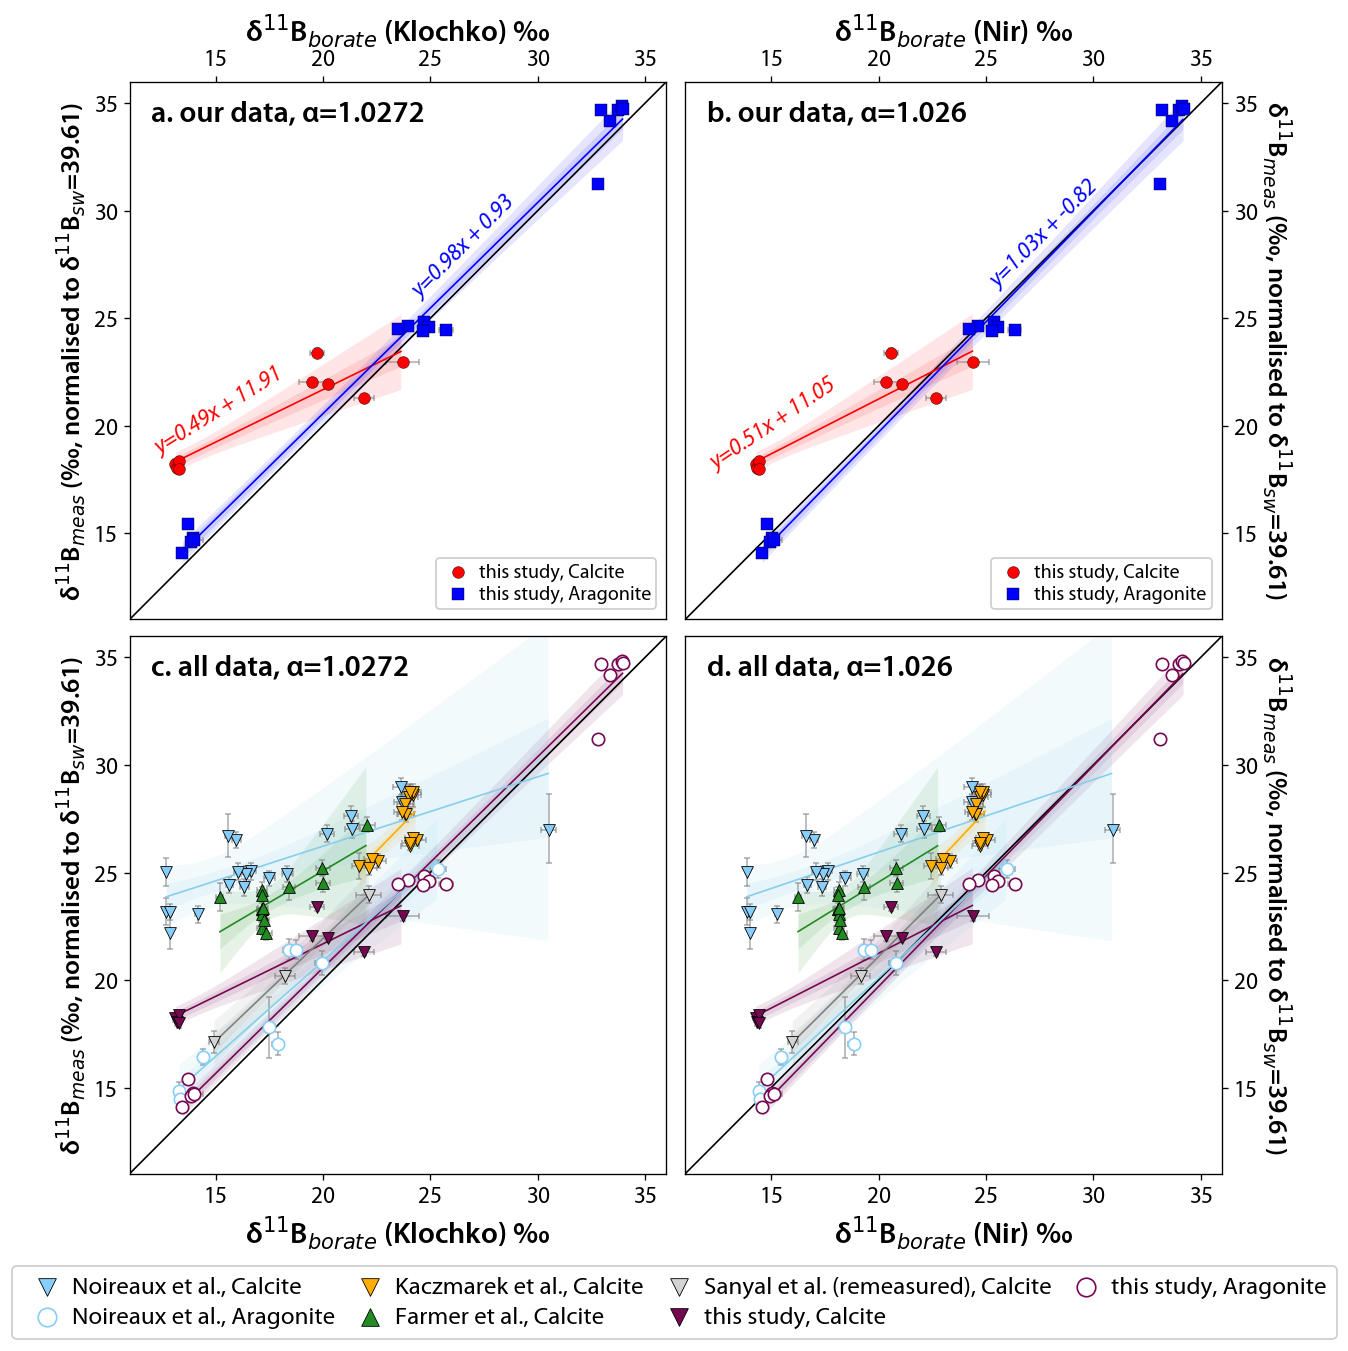

In [186]:

#d11Bmeas_MCmedian.index=df.index
#d11Bmeas_up95.index=df.index
#d11Bmeas_low95.index=df.index
#d11BborateK_MCmedian.index=df.index
#d11BborateK_up95.index=df.index
#d11BborateK_low95.index=df.index

Ncolours={'NFarmerwildboot':"forestgreen",'NKaczmarekwildboot':"#ffad01",'NUsCalcswildboot':"#750851",'NUsAragswildboot':"#750851",'NNoireauxCalcswildboot':"skyblue",'NNoireauxAragswildboot':"skyblue",'NSanyalwildboot':"gray"}
Kcolours={'KFarmerwildboot':"forestgreen",'KKaczmarekwildboot':"#ffad01",'KUsCalcswildboot':"#750851",'KUsAragswildboot':"#750851",'KNoireauxCalcswildboot':"skyblue",'KNoireauxAragswildboot':"skyblue",'KSanyalwildboot':"gray"}

Uscols={'NUsCalcswildboot':"red",'NUsAragswildboot':"blue",'KUsCalcswildboot':"red",'KUsAragswildboot':"blue"}
#sharey='row'
# plot the results
fig, ([ax1, ax2],[ax3,ax4]) = plt.subplots(nrows=2, ncols=2, figsize=(12,12))



ax1.set_xlim(11,36)
ax1.set_ylim(11,36)
ax1.plot((10,37), (10,37),linestyle='solid', c='black', linewidth=1, zorder=0)
for key in ['KUsCalcswildboot','KUsAragswildboot']:
    inpol=Kpolygons[key]
    ax1.fill_between(x=inpol['x'], y1=inpol['l95'], y2=inpol['u95'], alpha=0.1,linewidth=0, color=Uscols[key], zorder=-1)
    ax1.fill_between(x=inpol['x'], y1=inpol['l68'], y2=inpol['u68'], alpha=0.1,linewidth=0, color=Uscols[key], zorder=-1)
    ax1.plot(inpol['x'],(Koutputstats.loc[key]['medSlopewildboots']*inpol['x']+Koutputstats.loc[key]['medInterceptwildboots']),color=Uscols[key], linewidth=1.0, zorder=0)

ax1.errorbar(MCd11BborateKRae_median[(df.Study=='us')], \
            MCd11Bnormalised_median[(df.Study=='us')],\
            yerr=[MCd11Bnormalised_median[(df.Study=='us')]-MCd11Bnormalised_low95[(df.Study=='us')],
             MCd11Bnormalised_up95[(df.Study=='us')]-MCd11Bnormalised_median[(df.Study=='us')]],
            xerr= [MCd11BborateKRae_median[(df.Study=='us')]-MCd11BborateKRae_low95[(df.Study=='us')],
             MCd11BborateKRae_up95[(df.Study=='us')]-MCd11BborateKRae_median[(df.Study=='us')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.6, capthick=1, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.scatter(MCd11BborateKRae_median[(df.Study=='us')&(df.CalcOrArag=='Calc')], \
           MCd11Bnormalised_median[(df.Study=='us')&(df.CalcOrArag=='Calc')], color='black',s=50,linewidths=0.25, facecolors='red', label='this study, Calcite', marker='o')
ax1.scatter(MCd11BborateKRae_median[(df.Study=='us')&(df.CalcOrArag=='Arag')], \
           MCd11Bnormalised_median[(df.Study=='us')&(df.CalcOrArag=='Arag')], color='black', s=55,linewidths=0.25, label='this study, Aragonite', marker='s',facecolors='blue')
ax1.text(24, 26,'y={0:.2f}x + {1:0.2f}'.format(Koutputstats.loc['KUsAragswildboot']['medSlopewildboots'],Koutputstats.loc['KUsAragswildboot']['medInterceptwildboots']),style='italic', color='blue', fontsize=14, rotation=45)
ax1.text(12, 18.7,'y={0:.2f}x + {1:0.2f}'.format(Koutputstats.loc['KUsCalcswildboot']['medSlopewildboots'],Koutputstats.loc['KUsCalcswildboot']['medInterceptwildboots']),style='italic', color='red', fontsize=14, rotation=32)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position("top") 
ax1.set_xlabel('δ$^{11}$B$_{borate}$ (Klochko) ‰',fontsize=18, fontweight='semibold')
ax1.set_ylabel('δ$^{11}$B$_{meas}$ (‰, normalised to δ$^{11}$B$_{sw}$=39.61)',fontsize=16, fontweight='semibold')
ax1.legend(loc=(0.57,0.02), framealpha=1,fontsize=12, handlelength=1.7, handletextpad=0.2, borderpad=0.25, labelspacing=0.2)

ax2.set_xlim(11,36)
ax2.set_ylim(11,36)
ax2.plot((10,37), (10,37),linestyle='solid', c='black', linewidth=1, zorder=0)
for key in ['NUsCalcswildboot','NUsAragswildboot']:
    inpol=Npolygons[key]
    ax2.fill_between(x=inpol['x'], y1=inpol['l95'], y2=inpol['u95'], alpha=0.1,linewidth=0, color=Uscols[key], zorder=-1)
    ax2.fill_between(x=inpol['x'], y1=inpol['l68'], y2=inpol['u68'], alpha=0.1,linewidth=0, color=Uscols[key], zorder=-1)
    ax2.plot(inpol['x'],(Noutputstats.loc[key]['medSlopewildboots']*inpol['x']+Noutputstats.loc[key]['medInterceptwildboots']),color=Uscols[key], linewidth=1.0, zorder=0)

ax2.errorbar(MCd11BborateNRae_median[(df.Study=='us')], \
            MCd11Bnormalised_median[(df.Study=='us')],\
            yerr=[MCd11Bnormalised_median[(df.Study=='us')]-MCd11Bnormalised_low95[(df.Study=='us')],
             MCd11Bnormalised_up95[(df.Study=='us')]-MCd11Bnormalised_median[(df.Study=='us')]],
            xerr= [MCd11BborateNRae_median[(df.Study=='us')]-MCd11BborateNRae_low95[(df.Study=='us')],
             MCd11BborateKRae_up95[(df.Study=='us')]-MCd11BborateKRae_median[(df.Study=='us')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.6, capthick=1, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax2.scatter(MCd11BborateNRae_median[(df.Study=='us')&(df.CalcOrArag=='Calc')], \
           MCd11Bnormalised_median[(df.Study=='us')&(df.CalcOrArag=='Calc')], color='black',s=50,linewidths=0.25, facecolors='red', label='this study, Calcite', marker='o')
ax2.scatter(MCd11BborateNRae_median[(df.Study=='us')&(df.CalcOrArag=='Arag')], \
           MCd11Bnormalised_median[(df.Study=='us')&(df.CalcOrArag=='Arag')], color='black', s=55,linewidths=0.25, label='this study, Aragonite', marker='s',facecolors='blue')

ax2.text(25, 26.5,'y={0:.2f}x + {1:0.2f}'.format(Noutputstats.loc['NUsAragswildboot']['medSlopewildboots'],Noutputstats.loc['NUsAragswildboot']['medInterceptwildboots']),style='italic', color='blue', fontsize=14, rotation=45)
ax2.text(12, 18,'y={0:.2f}x + {1:0.2f}'.format(Noutputstats.loc['NUsCalcswildboot']['medSlopewildboots'],Noutputstats.loc['NUsCalcswildboot']['medInterceptwildboots']),style='italic', color='red', fontsize=14, rotation=34)

ax2.xaxis.tick_top()
ax2.xaxis.set_label_position("top") 
ax2.set_xlabel('δ$^{11}$B$_{borate}$ (Nir) ‰',fontsize=18, fontweight='semibold')
ax2.yaxis.set_label_position('right')
ax2.set_ylabel('δ$^{11}$B$_{meas}$ (‰, normalised to δ$^{11}$B$_{sw}$=39.61)',fontsize=16, fontweight='semibold', rotation=270, labelpad=22)
ax2.yaxis.tick_right()
ax2.legend(loc=(0.57,0.02), framealpha=1,fontsize=12, handlelength=1.7, handletextpad=0.2, borderpad=0.25, labelspacing=0.2)

ax3.set_xlim(11,36)
ax3.set_ylim(11,36)
ax3.plot((10,37), (10,37),linestyle='solid', c='black', linewidth=1, zorder=0)
for key in Kpolygons:
    inpol=Kpolygons[key]
    ax3.fill_between(x=inpol['x'], y1=inpol['l95'], y2=inpol['u95'], alpha=0.1,linewidth=0, color=Kcolours[key], zorder=-1)
    ax3.fill_between(x=inpol['x'], y1=inpol['l68'], y2=inpol['u68'], alpha=0.1,linewidth=0, color=Kcolours[key], zorder=-1)
    ax3.plot(inpol['x'],(Koutputstats.loc[key]['medSlopewildboots']*inpol['x']+Koutputstats.loc[key]['medInterceptwildboots']),color=Kcolours[key], linewidth=1.0, zorder=0)

ax3.errorbar(MCd11BborateKRae_median, \
            MCd11Bnormalised_median,\
            yerr=[MCd11Bnormalised_median-MCd11Bnormalised_low95,
             MCd11Bnormalised_up95-MCd11Bnormalised_median],
            xerr= [MCd11BborateKRae_median-MCd11BborateKRae_low95,
             MCd11BborateKRae_up95-MCd11BborateKRae_median],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.6, capthick=1, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax3.scatter(MCd11BborateKRae_median[(df.Study=='Noireaux')&(df.CalcOrArag=='Calc')], \
           MCd11Bnormalised_median[(df.Study=='Noireaux')&(df.CalcOrArag=='Calc')], color='black',s=50,linewidths=0.5, facecolors='lightskyblue', label='Noireaux et al., Calcite', marker='v')
ax3.scatter(MCd11BborateKRae_median[(df.Study=='Noireaux')&(df.CalcOrArag=='Arag')], \
           MCd11Bnormalised_median[(df.Study=='Noireaux')&(df.CalcOrArag=='Arag')], color='lightskyblue',s=55,linewidths=1,label='Noireaux et al., Aragonite', marker='o',facecolors='white')
ax3.scatter(MCd11BborateKRae_median[(df.Study=='Kaczmarek')&(df.CalcOrArag=='Calc')], \
           MCd11Bnormalised_median[(df.Study=='Kaczmarek')&(df.CalcOrArag=='Calc')], color='black',s=50,linewidths=0.5, facecolors='#ffad01', label='Kaczmarek et al., Calcite', marker='v')
ax3.scatter(MCd11BborateKRae_median[(df.Study=='Uchikawa')&(df.CalcOrArag=='Calc')], \
           MCd11Bnormalised_median[(df.Study=='Uchikawa')&(df.CalcOrArag=='Calc')], color='black',s=50,linewidths=0.5, facecolors='forestgreen', label='Farmer et al., Calcite', marker='^')
ax3.scatter(MCd11BborateKRae_median[(df.Study=='Sanyal')&(df.CalcOrArag=='Calc')], \
           MCd11Bnormalised_median[(df.Study=='Sanyal')&(df.CalcOrArag=='Calc')], color='black',s=50,linewidths=0.5, facecolors='lightgray', label='Sanyal et al. (remeasured), Calcite', marker='v')
ax3.scatter(MCd11BborateKRae_median[(df.Study=='us')&(df.CalcOrArag=='Calc')], \
           MCd11Bnormalised_median[(df.Study=='us')&(df.CalcOrArag=='Calc')], color='black',s=50,linewidths=0.5, facecolors='#750851', label='this study, Calcite', marker='v')
ax3.scatter(MCd11BborateKRae_median[(df.Study=='us')&(df.CalcOrArag=='Arag')], \
           MCd11Bnormalised_median[(df.Study=='us')&(df.CalcOrArag=='Arag')], color='#750851', s=55,linewidths=1, label='this study, Aragonite', marker='o',facecolors='white')
ax3.set_xlabel('δ$^{11}$B$_{borate}$ (Klochko) ‰',fontsize=18, fontweight='semibold')
ax3.set_ylabel('δ$^{11}$B$_{meas}$ (‰, normalised to δ$^{11}$B$_{sw}$=39.61)',fontsize=16, fontweight='semibold')
#ax1.axis('tight')
#ax2 = plt.axes()
ax4.set_ylim(11,36)
ax4.set_xlim(11,36)
ax4.plot((10,37), (10,37),linestyle='solid', c='black', linewidth=1, zorder=0)
for key in Npolygons:
    inpol=Npolygons[key]
    ax4.fill_between(x=inpol['x'], y1=inpol['l95'], y2=inpol['u95'], alpha=0.1,linewidth=0, color=Ncolours[key], zorder=-1)
    ax4.fill_between(x=inpol['x'], y1=inpol['l68'], y2=inpol['u68'], alpha=0.1,linewidth=0, color=Ncolours[key], zorder=-1)
    ax4.plot(inpol['x'],(Noutputstats.loc[key]['medSlopewildboots']*inpol['x']+Noutputstats.loc[key]['medInterceptwildboots']),color=Ncolours[key], linewidth=1, zorder=0)
ax4.errorbar(MCd11BborateNRae_median, \
            MCd11Bnormalised_median,\
            yerr=[MCd11Bnormalised_median-MCd11Bnormalised_low95,
             MCd11Bnormalised_up95-MCd11Bnormalised_median],
            xerr= [MCd11BborateNRae_median-MCd11BborateNRae_low95,
             MCd11BborateNRae_up95-MCd11BborateNRae_median],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.6, capthick=1, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax4.scatter(MCd11BborateNRae_median[(df.Study=='Noireaux')&(df.CalcOrArag=='Calc')], \
           MCd11Bnormalised_median[(df.Study=='Noireaux')&(df.CalcOrArag=='Calc')], color='black', s=50, linewidths=0.5, facecolors='lightskyblue', label='Noireaux et al., Calcite', marker='v')
ax4.scatter(MCd11BborateNRae_median[(df.Study=='Noireaux')&(df.CalcOrArag=='Arag')], \
           MCd11Bnormalised_median[(df.Study=='Noireaux')&(df.CalcOrArag=='Arag')], color='lightskyblue', s=55, linewidths=1,label='Noireaux et al., Aragonite', marker='o',facecolors='white')
ax4.scatter(MCd11BborateNRae_median[(df.Study=='Kaczmarek')&(df.CalcOrArag=='Calc')], \
           MCd11Bnormalised_median[(df.Study=='Kaczmarek')&(df.CalcOrArag=='Calc')], color='black',s=50, linewidths=0.5, label='Kaczmarek et al., Calcite', marker='v',facecolors='#ffad01')
ax4.scatter(MCd11BborateNRae_median[(df.Study=='Uchikawa')&(df.CalcOrArag=='Calc')], \
           MCd11Bnormalised_median[(df.Study=='Uchikawa')&(df.CalcOrArag=='Calc')], color='black', s=50, linewidths=0.5, facecolors='forestgreen', label='Farmer et al., Calcite', marker='^')
ax4.scatter(MCd11BborateNRae_median[(df.Study=='Sanyal')&(df.CalcOrArag=='Calc')], \
           MCd11Bnormalised_median[(df.Study=='Sanyal')&(df.CalcOrArag=='Calc')], color='black', s=50, linewidths=0.5, facecolors='lightgray', label='Sanyal et al. (remeasured), Calcite', marker='v')
ax4.scatter(MCd11BborateNRae_median[(df.Study=='us')&(df.CalcOrArag=='Calc')], \
           MCd11Bnormalised_median[(df.Study=='us')&(df.CalcOrArag=='Calc')], color='black', s=50, linewidths=0.5, facecolors='#750851', label='this study, Calcite', marker='v')
ax4.scatter(MCd11BborateNRae_median[(df.Study=='us')&(df.CalcOrArag=='Arag')], \
           MCd11Bnormalised_median[(df.Study=='us')&(df.CalcOrArag=='Arag')], color='#750851',s=55, linewidths=1, label='this study, Aragonite', marker='o',facecolors='white')

ax4.yaxis.tick_right()
ax4.set_xlabel('δ$^{11}$B$_{borate}$ (Nir) ‰',fontsize=18, fontweight='semibold')
ax4.set_ylabel('δ$^{11}$B$_{meas}$ (‰, normalised to δ$^{11}$B$_{sw}$=39.61)', rotation=270, labelpad=22, fontsize=16, fontweight='semibold')
#ax2.yaxis.rotation(90) 
ax4.yaxis.set_label_position('right')

ax1.text(12, 34.2, 'a. our data, α=1.0272', fontweight='semibold', color='black', fontsize=18)
ax2.text(12, 34.2, 'b. our data, α=1.026', fontweight='semibold', color='black', fontsize=18)
ax3.text(12, 34.2, 'c. all data, α=1.0272', fontweight='semibold', color='black', fontsize=18)
ax4.text(12, 34.2, 'd. all data, α=1.026', fontweight='semibold', color='black', fontsize=18)
ax1.xaxis.set_tick_params(labelsize=14)
ax2.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)
ax2.yaxis.set_tick_params(labelsize=14)
ax3.xaxis.set_tick_params(labelsize=14)
ax4.xaxis.set_tick_params(labelsize=14)
ax3.yaxis.set_tick_params(labelsize=14)
ax4.yaxis.set_tick_params(labelsize=14)


handles, labels = ax4.get_legend_handles_labels()
fig.legend(handles, labels, framealpha=1,fontsize=15, markerscale=1.5, labelspacing=0.3, handletextpad=0, borderaxespad=0.5, ncol=4, loc=8,columnspacing=0.4)
#bbox_to_anchor=(1.51, 0.21)
#bbox_to_anchor=(1.15, 0.275),,bbox_to_anchor=(0.95, 0.045) loc=(0.75,1)   bbox_to_anchor=(0.98, 0.04),


fig.tight_layout(pad=6, h_pad=1,w_pad=1) 
#ax.scatter(d11BborateK_MCmedian, d11Bmeas_MCmedian)


#ax.plot(x_new, y_new)
#fig.savefig('KlochkovsNir_AllPitzer_RaecalcsNewMC.pdf')
fig.savefig('KlvsNir_Pitz_4panels_RaecalcswSany_2se.pdf')

In [16]:

# Made a function to output the regression statistics for a MC pair of variables
# Study in this function is the study you are interested in, as listed in the dataset, and Cal is a binary True or False about whether you want calcite or aragonite
def MCregressStats(xVar, yVar, Study, Calc, MCreps):
    tempslopes = pd.Series(index=np.arange(MCreps), dtype=float)
    tempintercepts = pd.Series(index=np.arange(MCreps), dtype=float)
    tempr_values = pd.Series(index=np.arange(MCreps), dtype=float)
    tempp_values = pd.Series(index=np.arange(MCreps), dtype=float)
    tempstd_errs = pd.Series(index=np.arange(MCreps), dtype=float)

    for rep in np.arange(MCreps): 
        tempslopes[rep], tempintercepts[rep], tempr_values[rep], tempp_values[rep], tempstd_errs[rep] = stats.linregress(xVar[(df.Study==Study)&(df.Calc==Calc)][rep], yVar[(df.Study==Study)&(df.Calc==Calc)][rep])
    
    return([tempslopes.median(),tempintercepts.median(),tempr_values.median(),tempp_values.median()])


## and this one for combining the results of multiple studies
def MCregressStats2(xVar, yVar, Calc, MCreps):
    tempslopes = pd.Series(index=np.arange(MCreps), dtype=float)
    tempintercepts = pd.Series(index=np.arange(MCreps), dtype=float)
    tempr_values = pd.Series(index=np.arange(MCreps), dtype=float)
    tempp_values = pd.Series(index=np.arange(MCreps), dtype=float)
    tempstd_errs = pd.Series(index=np.arange(MCreps), dtype=float)

    for rep in np.arange(MCreps): 
        tempslopes[rep], tempintercepts[rep], tempr_values[rep], tempp_values[rep], tempstd_errs[rep] = stats.linregress(xVar[(df.Calc==Calc)][rep], yVar[(df.Calc==Calc)][rep])
    
    return([tempslopes.median(),tempintercepts.median(),tempr_values.median(),tempp_values.median()])

#example
#MCregressStats(MC_boratebicarb, doubleMC_BCa, 'us', True, reps)[0]

'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Semibold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


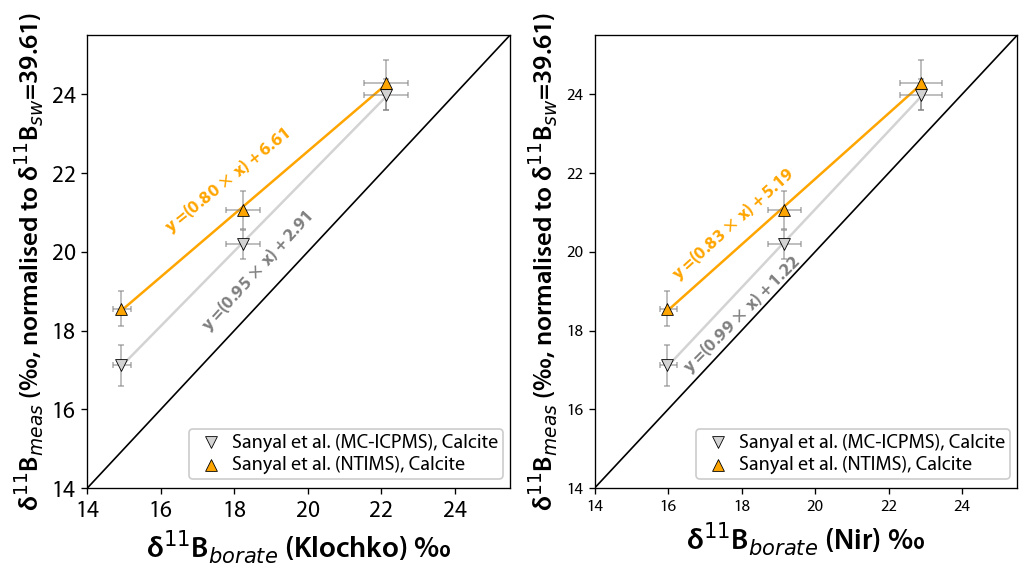

In [277]:
Sanyalindex=[0,1,2]
NTIMSSanyal=pd.Series([-19.25,-16.85,-13.75], index=Sanyalindex)
Sanyald11Berr=pd.Series([0.3,0.4,0.6], index=Sanyalindex)

import sklearn.metrics

## Monte Carlo of measured d11B accounting for measurement uncertainty
MCd11BSanyal=pd.DataFrame(index=Sanyalindex)
for rep in range(reps):
    temporary= pd.Series(NTIMSSanyal+np.random.normal(0,(Sanyald11Berr/2)), index=Sanyalindex)
    MCd11BSanyal[rep]=temporary.values
    del temporary
## Monte Carlo of solution d11B accounting for drift during run/measurement uncertainty
MCSanyalsoln=pd.DataFrame(index=Sanyalindex)    
for rep in range(reps):
    temporary= pd.Series(1.02+np.random.normal(0,(0.4/2)), index=Sanyalindex)
    MCSanyalsoln[rep]=temporary.values
    del temporary
    
## Using the alpha conversion factor in Hönisch et al. (2003), normalise carbonate to normal sw
MCalphaconversion=(39.61+1000)/(MCSanyalsoln+1000)
MCSanyalnormalised=((MCalphaconversion*MCd11BSanyal)+((MCalphaconversion-1)*1000))
del MCalphaconversion


MC_SanyalNTIMS_median=pd.Series(MCSanyalnormalised.median(axis=1), index=Sanyalindex)
MC_SanyalNTIMS_up95=pd.Series(np.quantile(MCSanyalnormalised, 0.95, axis=1), index=Sanyalindex)
MC_SanyalNTIMS_low95=pd.Series(np.quantile(MCSanyalnormalised, 0.05, axis=1), index=Sanyalindex)

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax1.set_xlim(14,25.5)
ax1.set_ylim(14,25.5)
ax1.plot((10,37), (10,37),linestyle='solid', c='black', linewidth=1, zorder=0)

ax1.errorbar(MCd11BborateKRae_median[(df.Study=='Sanyal')], \
            MCd11Bnormalised_median[(df.Study=='Sanyal')],\
            yerr=[MCd11Bnormalised_median[(df.Study=='Sanyal')]-MCd11Bnormalised_low95[(df.Study=='Sanyal')],
             MCd11Bnormalised_up95[(df.Study=='Sanyal')]-MCd11Bnormalised_median[(df.Study=='Sanyal')]],
            xerr= [MCd11BborateKRae_median[(df.Study=='Sanyal')]-MCd11BborateKRae_low95[(df.Study=='Sanyal')],
             MCd11BborateKRae_up95[(df.Study=='Sanyal')]-MCd11BborateKRae_median[(df.Study=='Sanyal')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.6, capthick=1, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

ax1.errorbar(MCd11BborateKRae_median[(df.Study=='Sanyal')], \
            MC_SanyalNTIMS_median,\
            yerr=[MC_SanyalNTIMS_median-MC_SanyalNTIMS_low95,MC_SanyalNTIMS_up95-MC_SanyalNTIMS_median],
            xerr= [MCd11BborateKRae_median[(df.Study=='Sanyal')]-MCd11BborateKRae_low95[(df.Study=='Sanyal')],
             MCd11BborateKRae_up95[(df.Study=='Sanyal')]-MCd11BborateKRae_median[(df.Study=='Sanyal')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.6, capthick=1, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')


X = MCd11BborateKRae_median[(df.Study=='Sanyal')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = MCd11Bnormalised_median[(df.Study=='Sanyal')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
regressionSlope=float(linear_regressor.coef_)
regressionIntercept=float(linear_regressor.intercept_)
#rsquare=sklearn.metrics.r2_score(Y, X, sample_weight=None)
ax1.text(17,18,r'y =(%.2f $\times$ x) + %.2f ' % (regressionSlope, regressionIntercept), color='gray', fontsize=11,fontweight='bold',rotation=47.5)
ax1.plot(X, Y_pred, color='lightgray', zorder=-3)

X = MCd11BborateKRae_median[(df.Study=='Sanyal')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = MC_SanyalNTIMS_median.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
regressionSlope=float(linear_regressor.coef_)
regressionIntercept=float(linear_regressor.intercept_)
#rsquare=sklearn.metrics.r2_score(Y, X, sample_weight=None)
ax1.text(16,20.5,r'y =(%.2f $\times$ x) + %.2f ' % (regressionSlope, regressionIntercept), color='orange', fontsize=11,fontweight='bold',rotation=39)
ax1.plot(X, Y_pred, color='orange', zorder=-3)

ax1.scatter(MCd11BborateKRae_median[(df.Study=='Sanyal')&(df.CalcOrArag=='Calc')], \
           MCd11Bnormalised_median[(df.Study=='Sanyal')&(df.CalcOrArag=='Calc')], color='black', s=50, linewidths=0.5, facecolors='lightgray', label='Sanyal et al. (MC-ICPMS), Calcite', marker='v')
ax1.scatter(MCd11BborateKRae_median[(df.Study=='Sanyal')&(df.CalcOrArag=='Calc')], \
           MC_SanyalNTIMS_median, color='black', s=50, linewidths=0.5, facecolors='orange', label='Sanyal et al. (NTIMS), Calcite', marker='^')

ax1.set_xlabel('δ$^{11}$B$_{borate}$ (Klochko) ‰',fontsize=18, fontweight='semibold')
ax1.set_ylabel('δ$^{11}$B$_{meas}$ (‰, normalised to δ$^{11}$B$_{sw}$=39.61)',fontsize=16, fontweight='semibold')
ax1.legend(loc=(0.24,0.02), framealpha=1,fontsize=12, handlelength=1.7, handletextpad=0.2, borderpad=0.25, labelspacing=0.2)


## 2nd panel
ax2.set_xlim(14,25.5)
ax2.set_ylim(14,25.5)
ax2.plot((10,37), (10,37),linestyle='solid', c='black', linewidth=1, zorder=0)

ax2.errorbar(MCd11BborateNRae_median[(df.Study=='Sanyal')], \
            MCd11Bnormalised_median[(df.Study=='Sanyal')],\
            yerr=[MCd11Bnormalised_median[(df.Study=='Sanyal')]-MCd11Bnormalised_low95[(df.Study=='Sanyal')],
             MCd11Bnormalised_up95[(df.Study=='Sanyal')]-MCd11Bnormalised_median[(df.Study=='Sanyal')]],
            xerr= [MCd11BborateNRae_median[(df.Study=='Sanyal')]-MCd11BborateNRae_low95[(df.Study=='Sanyal')],
             MCd11BborateNRae_up95[(df.Study=='Sanyal')]-MCd11BborateNRae_median[(df.Study=='Sanyal')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.6, capthick=1, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

ax2.errorbar(MCd11BborateNRae_median[(df.Study=='Sanyal')], \
            MC_SanyalNTIMS_median,\
            yerr=[MC_SanyalNTIMS_median-MC_SanyalNTIMS_low95,MC_SanyalNTIMS_up95-MC_SanyalNTIMS_median],
            xerr= [MCd11BborateNRae_median[(df.Study=='Sanyal')]-MCd11BborateNRae_low95[(df.Study=='Sanyal')],
             MCd11BborateNRae_up95[(df.Study=='Sanyal')]-MCd11BborateNRae_median[(df.Study=='Sanyal')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.6, capthick=1, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')


X = MCd11BborateNRae_median[(df.Study=='Sanyal')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = MCd11Bnormalised_median[(df.Study=='Sanyal')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
regressionSlope=float(linear_regressor.coef_)
regressionIntercept=float(linear_regressor.intercept_)
#rsquare=sklearn.metrics.r2_score(Y, X, sample_weight=None)
ax2.text(16.3,16.95,r'y =(%.2f $\times$ x) + %.2f ' % (regressionSlope, regressionIntercept), color='gray', fontsize=11,fontweight='bold',rotation=45)
ax2.plot(X, Y_pred, color='lightgray', zorder=-3)

X = MCd11BborateNRae_median[(df.Study=='Sanyal')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = MC_SanyalNTIMS_median.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
regressionSlope=float(linear_regressor.coef_)
regressionIntercept=float(linear_regressor.intercept_)
#rsquare=sklearn.metrics.r2_score(Y, X, sample_weight=None)
ax2.text(16,19.3,r'y =(%.2f $\times$ x) + %.2f ' % (regressionSlope, regressionIntercept), color='orange', fontsize=11,fontweight='bold',rotation=42)
ax2.plot(X, Y_pred, color='orange', zorder=-3)

ax2.scatter(MCd11BborateNRae_median[(df.Study=='Sanyal')&(df.CalcOrArag=='Calc')], \
           MCd11Bnormalised_median[(df.Study=='Sanyal')&(df.CalcOrArag=='Calc')], color='black', s=50, linewidths=0.5, facecolors='lightgray', label='Sanyal et al. (MC-ICPMS), Calcite', marker='v')
ax2.scatter(MCd11BborateNRae_median[(df.Study=='Sanyal')&(df.CalcOrArag=='Calc')], \
           MC_SanyalNTIMS_median, color='black', s=50, linewidths=0.5, facecolors='orange', label='Sanyal et al. (NTIMS), Calcite', marker='^')

ax2.set_xlabel('δ$^{11}$B$_{borate}$ (Nir) ‰',fontsize=18, fontweight='semibold')
ax2.set_ylabel('δ$^{11}$B$_{meas}$ (‰, normalised to δ$^{11}$B$_{sw}$=39.61)',fontsize=16, fontweight='semibold')
ax2.legend(loc=(0.24,0.02), framealpha=1,fontsize=12, handlelength=1.7, handletextpad=0.2, borderpad=0.25, labelspacing=0.2)


#fig.tight_layout(pad=6, h_pad=1,w_pad=1) 

ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)
#ax.plot(x_new, y_new)
#fig.savefig('KlochkovsNir_AllPitzer_RaecalcsNewMC.pdf')
fig.savefig('Sanyal_NTIMSvsMC-ICPMS.pdf')

In [196]:
MCd11BborateKRae[(df.Study=='Sanyal')]

0          1          2          3          4          5     \
85  15.029261  14.806692  14.808217  14.814668  15.130429  14.676126   
86  18.333106  19.238109  18.414689  17.756753  18.331106  17.727698   
87  22.279422  21.849498  22.001393  22.110308  22.265702  22.190599   

         6          7          8          9     ...       1990       1991  \
85  15.053327  15.035807  14.678344  14.664255  ...  14.997199  14.757656   
86  18.025467  18.616335  18.456154  18.304600  ...  18.246984  18.044135   
87  21.933821  22.060538  22.044751  22.076336  ...  22.409024  21.739113   

         1992       1993       1994       1995       1996       1997  \
85  14.791364  14.866934  14.923600  14.842205  14.737821  14.965979   
86  18.545562  18.236100  18.262069  17.965676  18.042094  18.542151   
87  22.344288  22.321514  21.792789  21.888934  22.195011  22.160917   

         1998       1999  
85  14.921666  15.044130  
86  18.168247  18.211524  
87  22.367823  21.871527  

[3 rows x 2000 columns]

'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


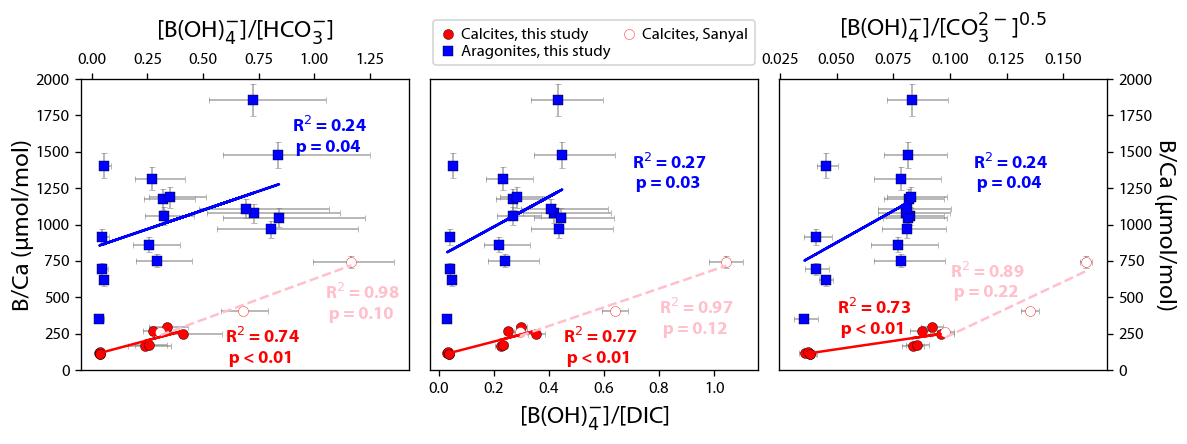

In [17]:
## Plotting against other carbonate system formulations.. other plots with other B species typed out here but will only output the top 3

df1= pd.read_csv('MC_KB_totalboratebicarb1st1000reps.csv', header=0)
df2= pd.read_csv('MC_KB_totalboratebicarb2nd1000reps.csv', header=0)
MC_KB_totalboratebicarb=pd.concat((df1,df2), axis=1,ignore_index=True, sort=False)
del MC_KB_totalboratebicarb[0],MC_KB_totalboratebicarb[1001], df1, df2
MC_KB_totalboratebicarb.set_index(df.index)
MC_KB_totalboratebicarb.columns=np.arange(2000)

MCtotB=MCtotalBorate+MCtotalBoric

doubleMC_BCa=pd.concat((MC_BCa,MC_BCa), axis=1,ignore_index=True, sort=False)
doubleMC_BCa.set_index(df.index)

doubleMC_MgCa=pd.concat((MC_MgCa,MC_MgCa), axis=1,ignore_index=True, sort=False)
doubleMC_MgCa.set_index(df.index)

doubleMC_NaCa=pd.concat((MC_NaCa,MC_NaCa), axis=1,ignore_index=True, sort=False)
doubleMC_NaCa.set_index(df.index)

MC_boratebicarb=(doubleMC_BCa/1000000)/MC_KB_totalboratebicarb
MC_bicarb=(MC_boratebicarb/MCtotalBorate)**-1
MC_borateDIC=MCtotalBorate/MC_DIC
MC_borateRootCarb=MCtotalBorate/(MCcarbion**0.5)
MC_Bbicarb=MCtotB/MC_bicarb
MC_BDIC=MCtotB/MC_DIC
MC_BRootCarb=MCtotB/(MCcarbion**0.5)

MC_boratebicarb_median=pd.Series(MC_boratebicarb.median(axis=1), index=df.index)
MC_boratebicarb_up95=pd.Series(np.quantile(MC_boratebicarb, 0.95, axis=1), index=df.index)
MC_boratebicarb_low95=pd.Series(np.quantile(MC_boratebicarb, 0.05, axis=1), index=df.index)

MC_borateDIC_median=pd.Series(MC_borateDIC.median(axis=1), index=df.index)
MC_borateDIC_up95=pd.Series(np.quantile(MC_borateDIC, 0.95, axis=1), index=df.index)
MC_borateDIC_low95=pd.Series(np.quantile(MC_borateDIC, 0.05, axis=1), index=df.index)

MC_borateRootCarb_median=pd.Series(MC_borateRootCarb.median(axis=1), index=df.index)
MC_borateRootCarb_up95=pd.Series(np.quantile(MC_borateRootCarb, 0.95, axis=1), index=df.index)
MC_borateRootCarb_low95=pd.Series(np.quantile(MC_borateRootCarb, 0.05, axis=1), index=df.index)

#MC_Bbicarb_median=pd.Series(MC_Bbicarb.median(axis=1), index=df.index)
#MC_Bbicarb_up95=pd.Series(np.quantile(MC_Bbicarb, 0.95, axis=1), index=df.index)
#MC_Bbicarb_low95=pd.Series(np.quantile(MC_Bbicarb, 0.05, axis=1), index=df.index)the aragonites
#
#MC_BDIC_median=pd.Series(MC_BDIC.median(axis=1), index=df.index)
#MC_BDIC_up95=pd.Series(np.quantile(MC_BDIC, 0.95, axis=1), index=df.index)
#MC_BDIC_low95=pd.Series(np.quantile(MC_BDIC, 0.05, axis=1), index=df.index)

#MC_BRootCarb_median=pd.Series(MC_BRootCarb.median(axis=1), index=df.index)
#MC_BRootCarb_up95=pd.Series(np.quantile(MC_BRootCarb, 0.95, axis=1), index=df.index)
#MC_BRootCarb_low95=pd.Series(np.quantile(MC_BRootCarb, 0.05, axis=1), index=df.index)

fig, ([ax1, ax2, ax3]) = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
#fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

red_circles = mlines.Line2D([], [], color='red', marker='o',
                          markersize=7, label='Calcites', lw=0.0)
blue_squares = mlines.Line2D([], [], color='blue', marker='s',
                          markersize=7, label='Aragonites', lw=0.0)
#fig.legend(handles=[red_circles, blue_squares], loc="upper center", fontsize=10, labelspacing=0.15, frameon=True, borderaxespad=1.2, ncol=2)

ax1.xaxis.tick_top()
#ax2.xaxis.tick_top()
ax3.xaxis.tick_top()

ax3.yaxis.tick_right()
#ax6.yaxis.tick_right()

ax1.set_ylim(0,2000)
ax1.errorbar(MC_boratebicarb_median[(df.Study=='us')], df.BCa_umol[(df.Study=='us')], 
            yerr=[(df.BCa_umol[(df.Study=='us')]*0.06),(df.BCa_umol[(df.Study=='us')]*0.06)],
            xerr= [MC_boratebicarb_median[(df.Study=='us')]-MC_boratebicarb_low95[(df.Study=='us')],(MC_boratebicarb_up95[(df.Study=='us')]-MC_boratebicarb_median[(df.Study=='us')])],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
temp=MCregressStats(MC_boratebicarb,doubleMC_BCa,'us',True,reps)
ax1.plot(MC_boratebicarb_median[(df.Study=='us')&(df.Calc==True)],MC_boratebicarb_median[(df.Study=='us')&(df.Calc==True)]*temp[0]+ temp[1], color='red')
if temp[3]<0.01:
    ax1.text(0.6,50,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=11,fontweight='bold')
else:
    ax1.text(0.6,50,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='red', fontsize=11,fontweight='bold')
temp=MCregressStats(MC_boratebicarb,doubleMC_BCa,'us',False,reps)
ax1.plot(MC_boratebicarb_median[(df.Study=='us')&(df.Calc==False)],MC_boratebicarb_median[(df.Study=='us')&(df.Calc==False)]*temp[0]+ temp[1], color='blue')
if temp[3]<0.01:
    ax1.text(0.9,1500,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=11,fontweight='bold')
else:
    ax1.text(0.9,1500,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='blue', fontsize=11,fontweight='bold')
ax1.scatter(MC_boratebicarb_median[(df.Study=='us')&(df.Calc==True)], df.BCa_umol[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites, this study', marker='o')
ax1.scatter(MC_boratebicarb_median[(df.Study=='us')&(df.Calc==False)], df.BCa_umol[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites, this study', marker='s')

ax1.errorbar(MC_boratebicarb_median[(df.Study=='Sanyal')], df.BCa_umol[(df.Study=='Sanyal')], 
            yerr=[(df.BCa_umol[(df.Study=='Sanyal')]*0.06),(df.BCa_umol[(df.Study=='Sanyal')]*0.06)],
            xerr= [MC_boratebicarb_median[(df.Study=='Sanyal')]-MC_boratebicarb_low95[(df.Study=='Sanyal')],(MC_boratebicarb_up95[(df.Study=='Sanyal')]-MC_boratebicarb_median[(df.Study=='Sanyal')])],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
temp=MCregressStats(MC_boratebicarb,doubleMC_BCa,'Sanyal',True,reps)
ax1.plot(MC_boratebicarb_median[(df.Study=='Sanyal')&(df.Calc==True)],MC_boratebicarb_median[(df.Study=='Sanyal')&(df.Calc==True)]*temp[0]+ temp[1], color='pink', linestyle='--')
if temp[3]<0.01:
    ax1.text(1.05,350,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='pink', fontsize=11,fontweight='bold')
else:
    ax1.text(1.05,350,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='pink', fontsize=11,fontweight='bold')
ax1.scatter(MC_boratebicarb_median[(df.Study=='Sanyal')&(df.Calc==True)], df.BCa_umol[(df.Study=='Sanyal')&(df.Calc==True)], \
            color='red',linewidths=0.25, facecolors='white', label='Calcites, Sanyal', marker='o')



ax2.set_ylim(0,2000)
ax2.errorbar(MC_borateDIC_median[(df.Study=='us')], df.BCa_umol[(df.Study=='us')], 
            yerr=[(df.BCa_umol[(df.Study=='us')]*0.06),(df.BCa_umol[(df.Study=='us')]*0.06)],
            xerr= [MC_borateDIC_median[(df.Study=='us')]-MC_borateDIC_low95[(df.Study=='us')],(MC_borateDIC_up95[(df.Study=='us')]-MC_borateDIC_median[(df.Study=='us')])],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax2.errorbar(MC_borateDIC_median[(df.Study=='Sanyal')], df.BCa_umol[(df.Study=='Sanyal')], 
            yerr=[(df.BCa_umol[(df.Study=='Sanyal')]*0.06),(df.BCa_umol[(df.Study=='Sanyal')]*0.06)],
            xerr= [MC_borateDIC_median[(df.Study=='Sanyal')]-MC_borateDIC_low95[(df.Study=='Sanyal')],(MC_borateDIC_up95[(df.Study=='Sanyal')]-MC_borateDIC_median[(df.Study=='Sanyal')])],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
temp=MCregressStats(MC_borateDIC,doubleMC_BCa,'us',True,reps)
ax2.plot(MC_borateDIC_median[(df.Study=='us')&(df.Calc==True)],MC_borateDIC_median[(df.Study=='us')&(df.Calc==True)]*temp[0] + temp[1], color='red')
if temp[3]<0.01:
    ax2.text(0.45,50,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=11,fontweight='bold')
else:
    ax2.text(0.45,50,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='red', fontsize=11,fontweight='bold')
temp=MCregressStats(MC_borateDIC,doubleMC_BCa,'us',False,reps)
ax2.plot(MC_borateDIC_median[(df.Study=='us')&(df.Calc==False)],MC_borateDIC_median[(df.Study=='us')&(df.Calc==False)]*temp[0] + temp[1], color='blue')
if temp[3]<0.01:
    ax2.text(0.7,1250,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=11,fontweight='bold')
else:
    ax2.text(0.7,1250,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='blue', fontsize=11,fontweight='bold')
temp=MCregressStats(MC_borateDIC,doubleMC_BCa,'Sanyal',True,reps)
ax2.plot(MC_borateDIC_median[(df.Study=='Sanyal')&(df.Calc==True)],MC_borateDIC_median[(df.Study=='Sanyal')&(df.Calc==True)]*temp[0] + temp[1], color='pink', linestyle='--')
if temp[3]<0.01:
    ax2.text(0.8,250,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='pink', fontsize=11,fontweight='bold')
else:
    ax2.text(0.8,250,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='pink', fontsize=11,fontweight='bold')

ax2.scatter(MC_borateDIC_median[(df.Study=='us')&(df.Calc==True)], df.BCa_umol[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax2.scatter(MC_borateDIC_median[(df.Study=='us')&(df.Calc==False)], df.BCa_umol[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax2.scatter(MC_borateDIC_median[(df.Study=='Sanyal')&(df.Calc==True)], df.BCa_umol[(df.Study=='Sanyal')&(df.Calc==True)], \
            color='red',linewidths=0.25, facecolors='white', label='Calcites', marker='o')





ax3.set_ylim(0,2000)
ax3.errorbar(MC_borateRootCarb_median[(df.Study=='us')], df.BCa_umol[(df.Study=='us')], 
            yerr=[(df.BCa_umol[(df.Study=='us')]*0.06),(df.BCa_umol[(df.Study=='us')]*0.06)],
            xerr= [MC_borateRootCarb_median[(df.Study=='us')]-MC_borateRootCarb_low95[(df.Study=='us')],(MC_borateRootCarb_up95[(df.Study=='us')]-MC_borateRootCarb_median[(df.Study=='us')])],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax3.errorbar(MC_borateRootCarb_median[(df.Study=='Sanyal')], df.BCa_umol[(df.Study=='Sanyal')], 
            yerr=[(df.BCa_umol[(df.Study=='Sanyal')]*0.06),(df.BCa_umol[(df.Study=='Sanyal')]*0.06)],
            xerr= [MC_borateRootCarb_median[(df.Study=='Sanyal')]-MC_borateRootCarb_low95[(df.Study=='Sanyal')],(MC_borateRootCarb_up95[(df.Study=='Sanyal')]-MC_borateRootCarb_median[(df.Study=='Sanyal')])],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
temp=MCregressStats(MC_borateRootCarb,doubleMC_BCa,'us',True,reps)
ax3.plot(MC_borateRootCarb_median[(df.Study=='us')&(df.Calc==True)],MC_borateRootCarb_median[(df.Study=='us')&(df.Calc==True)]*temp[0] + temp[1], color='red')
if temp[3]<0.01:
    ax3.text(0.05,250,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=11,fontweight='bold')
else:
    ax3.text(0.05,250,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='red', fontsize=11,fontweight='bold')
temp=MCregressStats(MC_borateRootCarb,doubleMC_BCa,'us',False,reps)
ax3.plot(MC_borateRootCarb_median[(df.Study=='us')&(df.Calc==False)],MC_borateRootCarb_median[(df.Study=='us')&(df.Calc==False)]*temp[0] + temp[1], color='blue')
if temp[3]<0.01:
    ax3.text(0.11,1250,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=11,fontweight='bold')
else: 
    ax3.text(0.11,1250,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='blue', fontsize=11,fontweight='bold')
temp=MCregressStats(MC_borateRootCarb,doubleMC_BCa,'Sanyal',True,reps)
ax3.plot(MC_borateRootCarb_median[(df.Study=='Sanyal')&(df.Calc==True)],MC_borateRootCarb_median[(df.Study=='Sanyal')&(df.Calc==True)]*temp[0] + temp[1], color='pink', linestyle='--')
if temp[3]<0.01:
    ax3.text(0.1,500,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='pink', fontsize=11,fontweight='bold')
else:
    ax3.text(0.1,500,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='pink', fontsize=11,fontweight='bold')
ax3.scatter(MC_borateRootCarb_median[(df.Study=='us')&(df.Calc==True)], df.BCa_umol[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax3.scatter(MC_borateRootCarb_median[(df.Study=='us')&(df.Calc==False)], df.BCa_umol[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax3.scatter(MC_borateRootCarb_median[(df.Study=='Sanyal')&(df.Calc==True)], df.BCa_umol[(df.Study=='Sanyal')&(df.Calc==True)], \
            color='red',linewidths=0.25, facecolors='white', label='Calcites', marker='o')

#ax4.set_ylim(0,2000)
#ax4.errorbar(MC_Bbicarb_median[(df.Study=='us')], df.BCa_umol[(df.Study=='us')], 
#            yerr=[(df.BCa_umol[(df.Study=='us')]*0.06),(df.BCa_umol[(df.Study=='us')]*0.06)],
#            xerr= [MC_Bbicarb_median[(df.Study=='us')]-MC_Bbicarb_low95[(df.Study=='us')],(MC_Bbicarb_up95[(df.Study=='us')]-MC_Bbicarb_median[(df.Study=='us')])],
#              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
#Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(MC_Bbicarb_median[(df.Study=='us')&(df.Calc==True)], df.BCa_umol[(df.Study=='us')&(df.Calc==True)])
#ax4.plot(MC_Bbicarb_median[(df.Study=='us')&(df.Calc==True)],MC_Bbicarb_median[(df.Study=='us')&(df.Calc==True)]*Cslope+ Cintercept, color='red')
#ax4.text(1.1,150,'R$^2$ = %.2f' % Cr_value**2, color='red', fontsize=13,fontweight='bold')
#Aslope, Aintercept, Ar_value, Ap_value, Astd_err = stats.linregress(MC_Bbicarb_median[(df.Study=='us')&(df.Calc==False)], df.BCa_umol[(df.Study=='us')&(df.Calc==False)])
#ax4.plot(MC_Bbicarb_median[(df.Study=='us')&(df.Calc==False)],MC_Bbicarb_median[(df.Study=='us')&(df.Calc==False)]*Aslope+ Aintercept, color='blue')
#ax4.text(1.1,650,'R$^2$ = %.2f' % Ar_value**2, color='blue', fontsize=13,fontweight='bold')
#ax4.scatter(MC_Bbicarb_median[(df.Study=='us')&(df.Calc==True)], df.BCa_umol[(df.Study=='us')&(df.Calc==True)], \
#            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
#ax4.scatter(MC_Bbicarb_median[(df.Study=='us')&(df.Calc==False)], df.BCa_umol[(df.Study=='us')&(df.Calc==False)], \
#            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')


##ax5.set_ylim(0,2000)
#ax5.errorbar(MC_BDIC_median[(df.Study=='us')], df.BCa_umol[(df.Study=='us')], 
#            yerr=[(df.BCa_umol[(df.Study=='us')]*0.06),(df.BCa_umol[(df.Study=='us')]*0.06)],
#            xerr= [MC_BDIC_median[(df.Study=='us')]-MC_BDIC_low95[(df.Study=='us')],(MC_BDIC_up95[(df.Study=='us')]-MC_BDIC_median[(df.Study=='us')])],
#              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
#Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(MC_BDIC_median[(df.Study=='us')&(df.Calc==True)], df.BCa_umol[(df.Study=='us')&(df.Calc==True)])
#ax5.plot(MC_BDIC_median[(df.Study=='us')&(df.Calc==True)],MC_BDIC_median[(df.Study=='us')&(df.Calc==True)]*Cslope+ Cintercept, color='red')
#ax5.text(0.4,150,'R$^2$ = %.2f' % Cr_value**2, color='red', fontsize=13,fontweight='bold')
##Aslope, Aintercept, Ar_value, Ap_value, Astd_err = stats.linregress(MC_BDIC_median[(df.Study=='us')&(df.Calc==False)], df.BCa_umol[(df.Study=='us')&(df.Calc==False)])
#ax5.plot(MC_BDIC_median[(df.Study=='us')&(df.Calc==False)],MC_BDIC_median[(df.Study=='us')&(df.Calc==False)]*Aslope+ Aintercept, color='blue')
##ax5.text(0.4,650,'R$^2$ = %.2f' % Ar_value**2, color='blue', fontsize=13,fontweight='bold')
#ax5.scatter(MC_BDIC_median[(df.Study=='us')&(df.Calc==True)], df.BCa_umol[(df.Study=='us')&(df.Calc==True)], \
#            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
#ax5.scatter(MC_BDIC_median[(df.Study=='us')&(df.Calc==False)], df.BCa_umol[(df.Study=='us')&(df.Calc==False)], \
#            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

#ax6.set_ylim(0,2000)
#ax6.errorbar(MC_BRootCarb_median[(df.Study=='us')], df.BCa_umol[(df.Study=='us')], 
#            yerr=[(df.BCa_umol[(df.Study=='us')]*0.06),(df.BCa_umol[(df.Study=='us')]*0.06)],
#            xerr= [MC_BRootCarb_median[(df.Study=='us')]-MC_BRootCarb_low95[(df.Study=='us')],(MC_BRootCarb_up95[(df.Study=='us')]-MC_BRootCarb_median[(df.Study=='us')])],
#              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
#Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(MC_BRootCarb_median[(df.Study=='us')&(df.Calc==True)], df.BCa_umol[(df.Study=='us')&(df.Calc==True)])
##ax6.plot(MC_BRootCarb_median[(df.Study=='us')&(df.Calc==True)],MC_BRootCarb_median[(df.Study=='us')&(df.Calc==True)]*Cslope+ Cintercept, color='red')
#ax6.text(1,250,'R$^2$ = %.2f' % Cr_value**2, color='red', fontsize=13,fontweight='bold')
#Aslope, Aintercept, Ar_value, Ap_value, Astd_err = stats.linregress(MC_BRootCarb_median[(df.Study=='us')&(df.Calc==False)], df.BCa_umol[(df.Study=='us')&(df.Calc==False)])
#ax6.plot(MC_BRootCarb_median[(df.Study=='us')&(df.Calc==False)],MC_BRootCarb_median[(df.Study=='us')&(df.Calc==False)]*Aslope+ Aintercept, color='blue')
#ax6.text(1,650,'R$^2$ = %.2f' % Ar_value**2, color='blue', fontsize=13,fontweight='bold')
#ax6.scatter(MC_BRootCarb_median[(df.Study=='us')&(df.Calc==True)], df.BCa_umol[(df.Study=='us')&(df.Calc==True)], \
#            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
#ax6.scatter(MC_BRootCarb_median[(df.Study=='us')&(df.Calc==False)], df.BCa_umol[(df.Study=='us')&(df.Calc==False)], \
#            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
                   
#ax6.set_ylim(0,0.5)

#ax6.legend(loc=(0.5,0.05), framealpha=1,fontsize=12)

ax1.set_xlabel('[B(OH)$_{4}^{-}$]/[HCO$_{3}^{-}$]', fontsize=15,labelpad=10)
ax2.set_xlabel('[B(OH)$_{4}^{-}$]/[DIC]', fontsize=15,labelpad=5)
ax3.set_xlabel('[B(OH)$_{4}^{-}$]/[CO$_{3}^{2-}$]$^{0.5}$', fontsize=15,labelpad=10)
#ax4.set_xlabel('[B]/[HCO$_{3}^{-}$]', fontsize=15)
#ax5.set_xlabel('[B]/[DIC]', fontsize=15)
#ax6.set_xlabel('[B]/[CO$_{3}^{2-}$]$^{0.5}$', fontsize=15)
ax1.set_ylabel('B/Ca (µmol/mol)', labelpad=1, fontsize=15)
ax3.set_ylabel('B/Ca (µmol/mol)', labelpad=14, fontsize=15, rotation=270)
#ax4.set_ylabel('B/Ca (µmol/mol)', labelpad=7, fontsize=15)
#ax6.set_ylabel('B/Ca (µmol/mol)', labelpad=14, fontsize=15, rotation=270)

ax1.xaxis.set_label_position("top") 
#ax2.xaxis.set_label_position("top") 
ax3.xaxis.set_label_position("top") 
ax2.get_yaxis().set_visible(False)
#ax5.get_yaxis().set_visible(False)
ax3.yaxis.set_label_position("right")
#ax6.yaxis.set_label_position("right")
#ax6.yaxis.set_label_position("right")

#ax1.text(7.3,1750, 'a.', fontweight='semibold', color='black', fontsize=16)
##ax2.text(7.3, 0.00305, 'b.', fontweight='semibold', color='black', fontsize=16)
#ax7.text(0.4, 0.00305, 'c.', fontweight='semibold', color='black', fontsize=16)
#ax3.text(7.3, 26, 'd.', fontweight='semibold', color='black', fontsize=16)
##ax4.text(7.3, 0.0006, 'e.', fontweight='semibold', color='black', fontsize=16)
#ax8.text(0.4, 0.0006, 'f.', fontweight='semibold', color='black', fontsize=16)
#ax5.text(7.3, 6.9, 'g.', fontweight='semibold', color='black', fontsize=16)
#ax6.text(7.3, 0.3, 'h.', fontweight='semibold', color='black', fontsize=16)
#ax9.text(0.4, 0.3, 'i.', fontweight='semibold', color='black', fontsize=16)

handles,labels=ax1.get_legend_handles_labels()
fig.legend(handles,labels, loc="upper center", fontsize=10, labelspacing=0.11, frameon=True, borderaxespad=1.2, ncol=2, columnspacing=0.6,handlelength=1,handletextpad=0.3)


#plt.adjust(left=0.1,bottom=0.75, right=0.11) ## makes some empty space for the legend
#fig.tight_layout() 
plt.tight_layout(w_pad=0.5,h_pad=1,rect=(0,0.05,1,1))
#fig.savefig('BCa vs other B-DICs.pdf')
fig.savefig('BCa vs other B-DICswSanyal2se.pdf')
#fig.savefig('TEs vs othercarbsys_NewMCsRae.pdf',bbox_inches="tight")

'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Semibold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


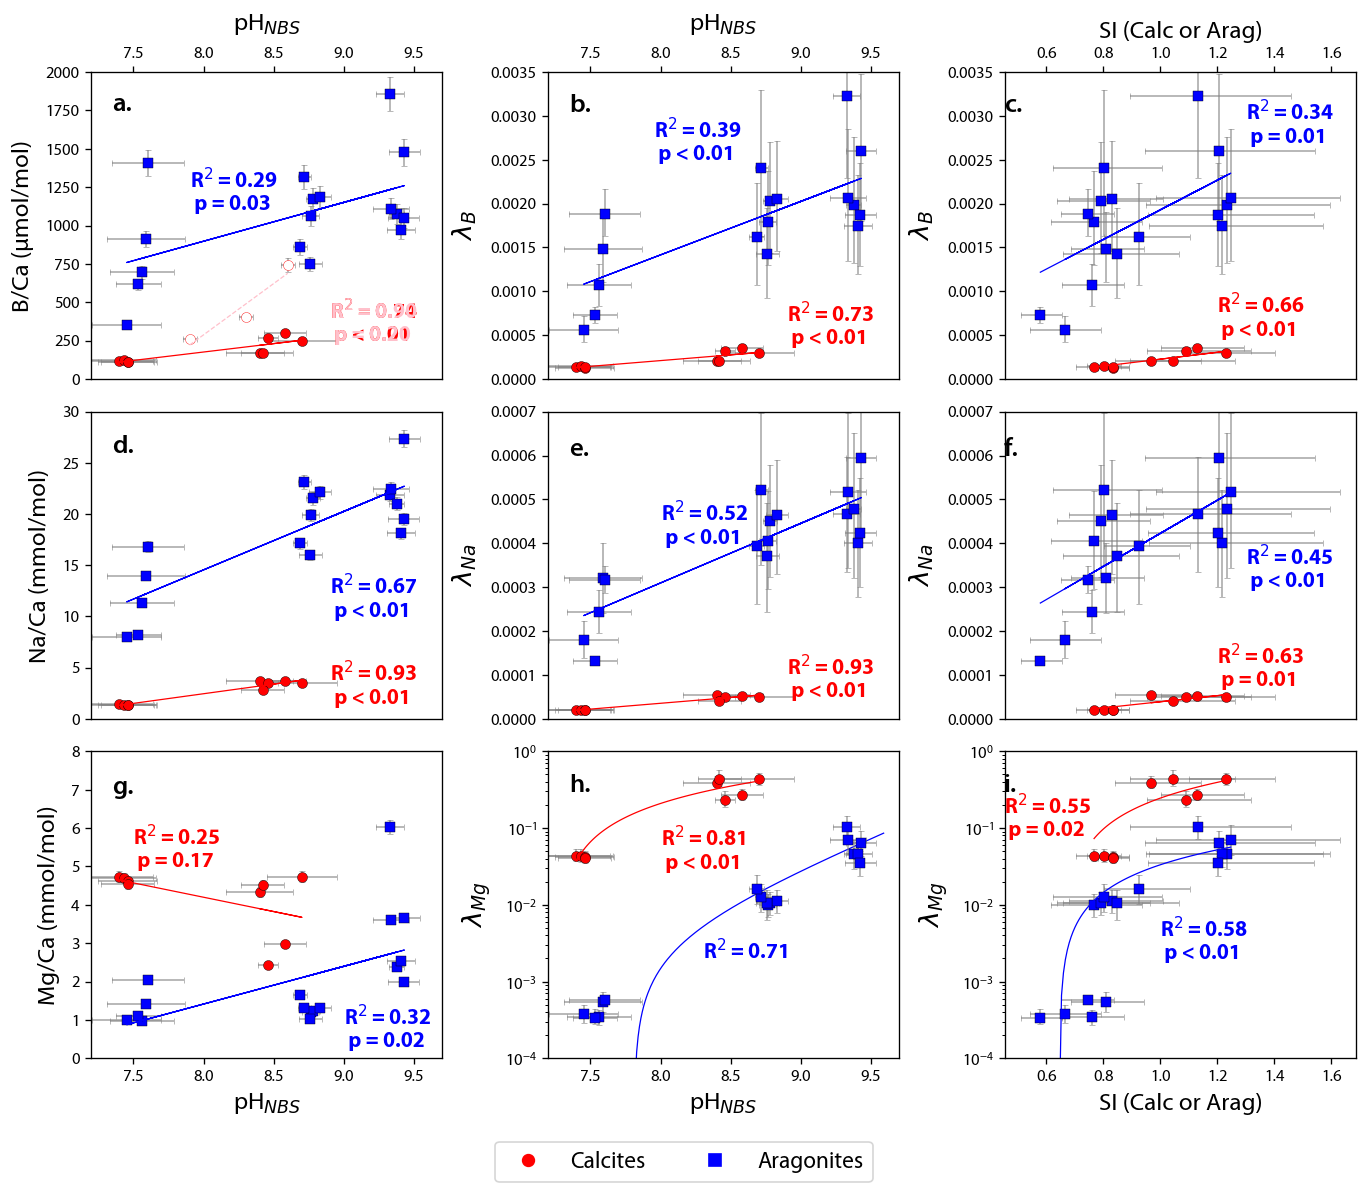

In [18]:


highSIAragErr=(MC_SIArag_up95-MC_SIArag_median)
lowSIAragErr=MC_SIArag_median-MC_SIArag_low95
highSICalcErr=(MC_SICalc_up95-MC_SICalc_median)
lowSICalcErr=MC_SICalc_median-MC_SICalc_low95


highlambdaBErr=(MClambdaB_up95-MClambdaB_median)
lowlambdaBErr=MClambdaB_median-MClambdaB_low95
highlambdaNaErr=(MClambdaNa_up95-MClambdaNa_median)
lowlambdaNaErr=MClambdaNa_median-MClambdaNa_low95
highlambdaMgErr=(MClambdaMg_up95-MClambdaMg_median)
lowlambdaMgErr=MClambdaMg_median-MClambdaMg_low95
#MClambdaB_median=pd.Series(MClambdaB.median(axis=1), index=df.index)
#MClambdaB_up95=pd.Series(np.quantile(MClambdaB, 0.95, axis=1), index=df.index)
#MClambdaB_low95=pd.Series(np.quantile(MClambdaB, 0.05, axis=1), index=df.index)

fig, ([ax1, ax2, ax7], [ax3, ax4, ax8],[ax5, ax6, ax9]) = plt.subplots(nrows=3, ncols=3, figsize=(11.5,10))


red_circles = mlines.Line2D([], [], color='red', marker='o',
                          markersize=7, label='Calcites', lw=0.0)
blue_squares = mlines.Line2D([], [], color='blue', marker='s',
                          markersize=7, label='Aragonites', lw=0.0)
fig.legend(handles=[red_circles, blue_squares], loc="lower center", fontsize=14, labelspacing=0.15, frameon=True, borderaxespad=0.5, ncol=2)

#ax2.yaxis.tick_right()
ax1.xaxis.tick_top()
ax2.xaxis.tick_top()
ax7.xaxis.tick_top()

#ax4.xaxis.tick_hide()
#ax4.yaxis.tick_right()
#ax6.yaxis.tick_right()
ax1.set_xlim(7.2,9.7)
ax1.set_ylim(0,2000)
ax1.errorbar(df.pH[(df.Study=='us')], df.BCa_umol[(df.Study=='us')], 
            yerr=[(df.BCa_umol[(df.Study=='us')]*0.06),(df.BCa_umol[(df.Study=='us')]*0.06)],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.errorbar(df.pH[(df.Study=='Sanyal')], df.BCa_umol[(df.Study=='Sanyal')], 
            yerr=[(df.BCa_umol[(df.Study=='Sanyal')]*0.06),(df.BCa_umol[(df.Study=='Sanyal')]*0.06)],
            xerr= [df.pHerr[(df.Study=='Sanyal')],df.pHerr[(df.Study=='Sanyal')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
temp=MCregressStats(MC_pHNBS,doubleMC_BCa,'us',True,reps)
ax1.plot(df.pH[(df.Study=='us')&(df.Calc==True)],df.pH[(df.Study=='us')&(df.Calc==True)]*temp[0] + temp[1], color='red', linewidth=0.75)
if temp[3]<0.01:
    ax1.text(8.9,250,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=13,fontweight='bold')
else:   
    ax1.text(8.9,250,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=13,fontweight='bold')
temp=MCregressStats(MC_pHNBS,doubleMC_BCa,'Sanyal',True,reps)
if temp[3]<0.01:
    ax1.plot(df.pH[(df.Study=='Sanyal')&(df.Calc==True)],df.pH[(df.Study=='Sanyal')&(df.Calc==True)]*temp[0] + temp[1], color='pink', linewidth=0.75)
    ax1.text(8.9,250,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=13,fontweight='bold')
elif temp[3]>0.05:
    ax1.plot(df.pH[(df.Study=='Sanyal')&(df.Calc==True)],df.pH[(df.Study=='Sanyal')&(df.Calc==True)]*temp[0] + temp[1], color='pink', linewidth=0.75, linestyle='--')
    ax1.text(8.9,250,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='pink', fontsize=13,fontweight='bold')
else:   
    ax1.text(8.9,250,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='pink', fontsize=13,fontweight='bold')
temp=MCregressStats(MC_pHNBS,doubleMC_BCa,'us',False,reps)
ax1.plot(df.pH[(df.Study=='us')&(df.Calc==False)],df.pH[(df.Study=='us')&(df.Calc==False)]*temp[0] + temp[1], color='blue', linewidth=0.75)
if temp[3]<0.01:
    ax1.text(7.9,1100,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=13,fontweight='bold')
else:
    ax1.text(7.9,1100,'R$^2$ = %.2f\n p = %.2f' % (temp[2]**2,temp[3]), color='blue', fontsize=13,fontweight='bold')

ax1.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], df.BCa_umol[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax1.scatter(df.pH[(df.Study=='Sanyal')&(df.Calc==True)], df.BCa_umol[(df.Study=='Sanyal')&(df.Calc==True)], \
            color='red',linewidths=0.25, facecolors='white', label='Calcites', marker='o')
ax1.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], df.BCa_umol[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax2.set_xlim(7.2,9.7)
#ax2.set_ylim(0,2000)
ax2.errorbar(df.pH[(df.Study=='us')],  MClambdaB_median[(df.Study=='us')],
            yerr= [lowlambdaBErr[(df.Study=='us')],highlambdaBErr[(df.Study=='us')]],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
temp=MCregressStats(MC_pHNBS,MClambdaB,'us',True,reps)
ax2.plot(df.pH[(df.Study=='us')&(df.Calc==True)],df.pH[(df.Study=='us')&(df.Calc==True)]*temp[0] + temp[1], color='red', linewidth=0.75)
if temp[3]<0.01:
    ax2.text(8.9,0.0004,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=13,fontweight='bold')
else:
    ax2.text(8.9,0.0004,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=13,fontweight='bold')
temp=MCregressStats(MC_pHNBS,MClambdaB,'us',False,reps)
ax2.plot(df.pH[(df.Study=='us')&(df.Calc==False)],df.pH[(df.Study=='us')&(df.Calc==False)]*temp[0] + temp[1], color='blue', linewidth=0.75)
if temp[3]<0.01:
    ax2.text(7.95,0.0025,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=13,fontweight='bold')
else:
    ax2.text(7.95,0.0025,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='blue', fontsize=13,fontweight='bold')
ax2.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], MClambdaB_median[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax2.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], MClambdaB_median[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax3.set_xlim(7.2,9.7)
ax3.set_ylim(0,30)
ax3.get_xaxis().set_visible(False)
ax3.errorbar(df.pH[(df.Study=='us')], df.NaCa_mmol[(df.Study=='us')], 
            yerr=[(df.NaCa_mmol[(df.Study=='us')]*0.03),(df.NaCa_mmol[(df.Study=='us')]*0.03)],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
temp=MCregressStats(MC_pHNBS,MC_NaCa,'us',True,reps)
ax3.plot(df.pH[(df.Study=='us')&(df.Calc==True)],df.pH[(df.Study=='us')&(df.Calc==True)]*temp[0] + temp[1], color='red', linewidth=0.75)
if temp[3]<0.01:
    ax3.text(8.9,1.5,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=13,fontweight='bold')
else:
    ax3.text(8.9,1.5,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='red', fontsize=13,fontweight='bold')
temp=MCregressStats(MC_pHNBS,MC_NaCa,'us',False,reps)
ax3.plot(df.pH[(df.Study=='us')&(df.Calc==False)],df.pH[(df.Study=='us')&(df.Calc==False)]*temp[0] + temp[1], color='blue', linewidth=0.75)
if temp[3]<0.01:
    ax3.text(8.9,10,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=13,fontweight='bold')
else:
    ax3.text(8.9,10,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='blue', fontsize=13,fontweight='bold')
ax3.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], df.NaCa_mmol[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax3.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')


ax4.set_xlim(7.2,9.7)
#ax4.set_ylim(0,2000)
ax4.get_xaxis().set_visible(False)
ax4.errorbar(df.pH[(df.Study=='us')], MClambdaNa_median[(df.Study=='us')], 
            yerr= [lowlambdaNaErr[(df.Study=='us')],highlambdaNaErr[(df.Study=='us')]],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
temp=MCregressStats(MC_pHNBS,MClambdaNa,'us',True,reps)
ax4.plot(df.pH[(df.Study=='us')&(df.Calc==True)],df.pH[(df.Study=='us')&(df.Calc==True)]*temp[0] + temp[1], color='red', linewidth=0.75)
if temp[3]<0.01:
    ax4.text(8.9,0.00005,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=13,fontweight='bold')
else:
    ax4.text(8.9,0.00005,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='red', fontsize=13,fontweight='bold')
temp=MCregressStats(MC_pHNBS,MClambdaNa,'us',False,reps)
ax4.plot(df.pH[(df.Study=='us')&(df.Calc==False)],df.pH[(df.Study=='us')&(df.Calc==False)]*temp[0] + temp[1], color='blue', linewidth=0.75)
if temp[3]<0.01:
    ax4.text(8,0.0004,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=13,fontweight='bold')
else:
    ax4.text(8,0.0004,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='blue', fontsize=13,fontweight='bold')
ax4.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], MClambdaNa_median[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax4.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], MClambdaNa_median[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax5.set_xlim(7.2,9.7)
ax5.set_ylim(0,8)
ax5.errorbar(df.pH[(df.Study=='us')], df.MgCa_mmol[(df.Study=='us')], 
            yerr=[(df.MgCa_mmol[(df.Study=='us')]*0.03),(df.MgCa_mmol[(df.Study=='us')]*0.03)],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
temp=MCregressStats(MC_pHNBS,MC_MgCa,'us',True,reps)
ax5.plot(df.pH[(df.Study=='us')&(df.Calc==True)],df.pH[(df.Study=='us')&(df.Calc==True)]*temp[0]+ temp[1], color='red', linewidth=0.75)
if temp[3]<0.01:
    ax5.text(7.5,5,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=13,fontweight='bold')
else:
    ax5.text(7.5,5,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='red', fontsize=13,fontweight='bold')
temp=MCregressStats(MC_pHNBS,MC_MgCa,'us',False,reps)
ax5.plot(df.pH[(df.Study=='us')&(df.Calc==False)],df.pH[(df.Study=='us')&(df.Calc==False)]*temp[0] + temp[1], color='blue', linewidth=0.75)
if temp[3]<0.01:
    ax5.text(9,0.3,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=13,fontweight='bold')
else:
    ax5.text(9,0.3,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='blue', fontsize=13,fontweight='bold')
ax5.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], df.MgCa_mmol[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax5.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], df.MgCa_mmol[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax6.set_xlim(7.2,9.7)
ax6.set_yscale('log')
ax6.set_ylim(10**-4,1)
#ax6.set_ylim(0,2000)
ax6.errorbar(df.pH[(df.Study=='us')], MClambdaMg_median[(df.Study=='us')], 
            yerr= [lowlambdaMgErr[(df.Study=='us')],highlambdaMgErr[(df.Study=='us')]],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

def func(t, a, b, alpha):
    return a*np.exp(alpha * t) + b
t=np.array(df.pH[(df.Study=='us')&(df.Calc==False)])
v=np.array(MClambdaMg_median[(df.Study=='us')&(df.Calc==False)])
# initial guess for curve fit coefficients
a0 = 0
b0 = 0
alpha0 = 2
# coefficients and curve fit for curve(a0, b0, alpha0)
popt4, pcov4 = curve_fit(func, t, v, p0=(a0, b0, alpha0), maxfev=1000000)
a, b, alpha = popt4
v_fit = func(t, a, b, alpha)
ss_res = np.sum((v - v_fit) ** 2)       # residual sum of squares
ss_tot = np.sum((v - np.mean(v)) ** 2)  # total sum of squares
r2 = 1 - (ss_res / ss_tot)              # R squared fit, R^2
testx=np.arange(7.4,9.6,0.01)
testy=a*np.exp(alpha*testx)+b
ax6.plot(testx, testy, color='blue', linewidth=0.75, zorder=-2)
ax6.text(8.3,0.002,'R$^2$ = %.2f' % r2, color='blue', fontsize=13,fontweight='bold')

#Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(df.pH[(df.Study=='us')&(df.Calc==True)], MClambdaMg_median[(df.Study=='us')&(df.Calc==True)])
temp=MCregressStats(MC_pHNBS,MClambdaMg,'us',True,reps)
X1=np.linspace(min(df.pH[(df.Study=='us')&(df.Calc==True)]),max(df.pH[(df.Study=='us')&(df.Calc==True)]),100)
ax6.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75)
if temp[3]<0.01:
    ax6.text(8.0,0.03,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=13,fontweight='bold')
else:
    ax6.text(8.0,0.03,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='red', fontsize=13,fontweight='bold')
#Aslope, Aintercept, Ar_value, Ap_value, Astd_err = stats.linregress(df.pH[(df.Study=='us')&(df.Calc==False)], MClambdaMg_median[(df.Study=='us')&(df.Calc==False)])
#X1=np.linspace(min(df.pH[(df.Study=='us')&(df.Calc==False)]),max(df.pH[(df.Study=='us')&(df.Calc==False)]),100)
#ax6.plot(X1,X1*Aslope + Aintercept, color='blue', linewidth=0.75)
#ax6.text(7.95,0.00025,'R$^2$ = %.2f' % Ar_value**2, color='blue', fontsize=13,fontweight='bold')
ax6.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], MClambdaMg_median[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax6.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], MClambdaMg_median[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')


ax7.errorbar(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], MClambdaB_median[(df.Study=='us')&(df.Calc==True)],
            xerr= [highSICalcErr[(df.Study=='us')&(df.Calc==True)],lowSICalcErr[(df.Study=='us')&(df.Calc==True)]], 
            yerr= [lowlambdaBErr[(df.Study=='us')&(df.Calc==True)],highlambdaBErr[(df.Study=='us')&(df.Calc==True)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax7.errorbar(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], MClambdaB_median[(df.Study=='us')&(df.Calc==False)],
            xerr=[highSIAragErr[(df.Study=='us')&(df.Calc==False)],lowSIAragErr[(df.Study=='us')&(df.Calc==False)]],
            yerr= [lowlambdaBErr[(df.Study=='us')&(df.Calc==False)],highlambdaBErr[(df.Study=='us')&(df.Calc==False)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
#Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], MClambdaB_median[(df.Study=='us')&(df.Calc==True)])
temp=MCregressStats(MC_SICalc,MClambdaB,'us',True,reps)
ax7.plot(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)],MC_SICalc_median[(df.Study=='us')&(df.Calc==True)]*temp[0] + temp[1], color='red', linewidth=0.75)
if temp[3]<0.01:
    ax7.text(1.2,0.0005,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=13,fontweight='bold')
else:
    ax7.text(1.2,0.0005,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='red', fontsize=13,fontweight='bold')
temp=MCregressStats(MC_SIArag,MClambdaB,'us',False,reps)
ax7.plot(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)],MC_SIArag_median[(df.Study=='us')&(df.Calc==False)]*temp[0] + temp[1], color='blue', linewidth=0.75)
if temp[3]<0.01:
    ax7.text(1.3,0.0027,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=13,fontweight='bold')
else:
    ax7.text(1.3,0.0027,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='blue', fontsize=13,fontweight='bold')
ax7.scatter(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], MClambdaB_median[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax7.scatter(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], MClambdaB_median[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')


ax8.errorbar(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], MClambdaNa_median[(df.Study=='us')&(df.Calc==True)],
            xerr=[highSICalcErr[(df.Study=='us')&(df.Calc==True)],lowSICalcErr[(df.Study=='us')&(df.Calc==True)]],
            yerr= [lowlambdaNaErr[(df.Study=='us')&(df.Calc==True)],highlambdaNaErr[(df.Study=='us')&(df.Calc==True)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax8.errorbar(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], MClambdaNa_median[(df.Study=='us')&(df.Calc==False)],
            xerr=[highSIAragErr[(df.Study=='us')&(df.Calc==False)],lowSIAragErr[(df.Study=='us')&(df.Calc==False)]],
            yerr= [lowlambdaNaErr[(df.Study=='us')&(df.Calc==False)],highlambdaNaErr[(df.Study=='us')&(df.Calc==False)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
temp=MCregressStats(MC_SICalc,MClambdaNa,'us',True,reps)
ax8.plot(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)],MC_SICalc_median[(df.Study=='us')&(df.Calc==True)]*temp[0] + temp[1], color='red', linewidth=0.75)
if temp[3]<0.01:
    ax8.text(1.2,0.000075,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=13,fontweight='bold')
else:
    ax8.text(1.2,0.000075,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='red', fontsize=13,fontweight='bold')
#Aslope, Aintercept, Ar_value, Ap_value, Astd_err = stats.linregress(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], MClambdaNa_median[(df.Study=='us')&(df.Calc==False)])
temp=MCregressStats(MC_SIArag,MClambdaNa,'us',False,reps)
ax8.plot(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)],MC_SIArag_median[(df.Study=='us')&(df.Calc==False)]*temp[0]+ temp[1], color='blue', linewidth=0.75)
if temp[3]<0.01:
    ax8.text(1.3,0.0003,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=13,fontweight='bold')
else:
    ax8.text(1.3,0.0003,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='blue', fontsize=13,fontweight='bold')
ax8.scatter(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], MClambdaNa_median[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax8.scatter(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], MClambdaNa_median[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')


ax9.set_yscale('log')
ax9.set_ylim(10**-4,1)
ax9.errorbar(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], MClambdaMg_median[(df.Study=='us')&(df.Calc==True)],
            xerr=[highSICalcErr[(df.Study=='us')&(df.Calc==True)],lowSICalcErr[(df.Study=='us')&(df.Calc==True)]],
            yerr= [lowlambdaMgErr[(df.Study=='us')&(df.Calc==True)],highlambdaMgErr[(df.Study=='us')&(df.Calc==True)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax9.errorbar(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], MClambdaMg_median[(df.Study=='us')&(df.Calc==False)],
            xerr=[highSIAragErr[(df.Study=='us')&(df.Calc==False)],lowSIAragErr[(df.Study=='us')&(df.Calc==False)]],
            yerr= [lowlambdaMgErr[(df.Study=='us')&(df.Calc==False)],highlambdaMgErr[(df.Study=='us')&(df.Calc==False)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
#Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], MClambdaMg_median[(df.Study=='us')&(df.Calc==True)])
temp=MCregressStats(MC_SICalc,MClambdaMg,'us',True,reps)
X1=np.linspace(min(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)]),max(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)]),100)
ax9.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75)
if temp[3]<0.01:
    ax9.text(0.45,0.08,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=13,fontweight='bold')
else:
    ax9.text(0.45,0.08,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='red', fontsize=13,fontweight='bold')

temp=MCregressStats(MC_SIArag,MClambdaMg,'us',False,reps)
#Aslope, Aintercept, Ar_value, Ap_value, Astd_err = stats.linregress(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], MClambdaMg_median[(df.Study=='us')&(df.Calc==False)])
X1=np.linspace(min(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)]),max(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)]),100)
ax9.plot(X1,X1*temp[0] + temp[1], color='blue', linewidth=0.75)
if temp[3]<0.01:
    ax9.text(1,0.002,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=13,fontweight='bold')
else:
    ax9.text(1,0.002,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='blue', fontsize=13,fontweight='bold')
ax9.scatter(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], MClambdaMg_median[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax9.scatter(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], MClambdaMg_median[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax2.set_ylim(0,0.0035)
ax7.set_ylim(0,0.0035)
ax4.set_ylim(0,0.0007)
ax8.set_ylim(0,0.0007)
#ax6.set_ylim(0,0.5)


#ax6.legend(loc=(0.5,0.05), framealpha=1,fontsize=12)

ax1.set_xlabel('pH$_{NBS}$', fontsize=15,labelpad=10)
ax2.set_xlabel('pH$_{NBS}$', fontsize=15,labelpad=10)
ax5.set_xlabel('pH$_{NBS}$', fontsize=15)
ax6.set_xlabel('pH$_{NBS}$', fontsize=15)
ax1.set_ylabel('B/Ca (µmol/mol)', labelpad=7, fontsize=15)
ax3.set_ylabel('Na/Ca (mmol/mol)', labelpad=7, fontsize=15)
ax5.set_ylabel('Mg/Ca (mmol/mol)', labelpad=7, fontsize=15)
ax2.set_ylabel('$\lambda$$_{B}$', labelpad=7, fontsize=16) #rotation=270, needed if you want the y label on the right
ax4.set_ylabel('$\lambda$$_{Na}$', labelpad=7, fontsize=16) #rotation=270, needed if you want the y label on the right
ax6.set_ylabel('$\lambda$$_{Mg}$', labelpad=7, fontsize=16) #rotation=270, needed if you want the y label on the right
ax1.xaxis.set_label_position("top") 
ax2.xaxis.set_label_position("top") 
ax7.xaxis.set_label_position("top") 
ax7.set_ylabel('$\lambda$$_{B}$', labelpad=7, fontsize=16)
ax8.set_ylabel('$\lambda$$_{Na}$', labelpad=7, fontsize=16)
ax9.set_ylabel('$\lambda$$_{Mg}$', labelpad=7, fontsize=16)
ax7.set_xlabel('SI (Calc or Arag)', labelpad=5, fontsize=15)
ax9.set_xlabel('SI (Calc or Arag)', labelpad=5, fontsize=15)
ax8.get_xaxis().set_visible(False)
#ax2.yaxis.set_label_position("right")
#ax4.yaxis.set_label_position("right")
#ax6.yaxis.set_label_position("right")

ax1.text(7.35,1750, 'a.', fontweight='semibold', color='black', fontsize=16)
ax2.text(7.35, 0.00305, 'b.', fontweight='semibold', color='black', fontsize=16)
ax7.text(0.45, 0.00305, 'c.', fontweight='semibold', color='black', fontsize=16)
ax3.text(7.35, 26, 'd.', fontweight='semibold', color='black', fontsize=16)
ax4.text(7.35, 0.0006, 'e.', fontweight='semibold', color='black', fontsize=16)
ax8.text(0.45, 0.0006, 'f.', fontweight='semibold', color='black', fontsize=16)
ax5.text(7.35, 6.9, 'g.', fontweight='semibold', color='black', fontsize=16)
ax6.text(7.35, 0.3, 'h.', fontweight='semibold', color='black', fontsize=16)
ax9.text(0.45, 0.3, 'i.', fontweight='semibold', color='black', fontsize=16)



#plt.adjust(left=0.1,bottom=0.75, right=0.11) ## makes some empty space for the legend
#fig.tight_layout() 
plt.tight_layout(w_pad=0.5,h_pad=1,rect=(0,0.05,1,1))

fig.savefig('TEs vs carbsys_NewMCsRae2se.pdf',bbox_inches="tight")

In [19]:
#MC_Mgfree
#MC_Cafree
#MC_NaCa
#MC_MgCa
MC_KDNa=(MC_NaCa)/(MCsolutions['MC_NamMol']/MCsolutions['MC_CamMol'])
MC_KDMg=(MC_MgCa)/(MCsolutions['MC_MgmMol']/MCsolutions['MC_CamMol'])

MC_KDNa_median=pd.Series(MC_KDNa.median(axis=1), index=df.index)
MC_KDNa_up95=pd.Series(np.quantile(MC_KDNa, 0.95, axis=1), index=df.index)
MC_KDNa_low95=pd.Series(np.quantile(MC_KDNa, 0.05, axis=1), index=df.index)


MC_KDMg_median=pd.Series(MC_KDMg.median(axis=1), index=df.index)
MC_KDMg_up95=pd.Series(np.quantile(MC_KDMg, 0.95, axis=1), index=df.index)
MC_KDMg_low95=pd.Series(np.quantile(MC_KDMg, 0.05, axis=1), index=df.index)

In [ ]:
MC_KDMg_median

'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Semibold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


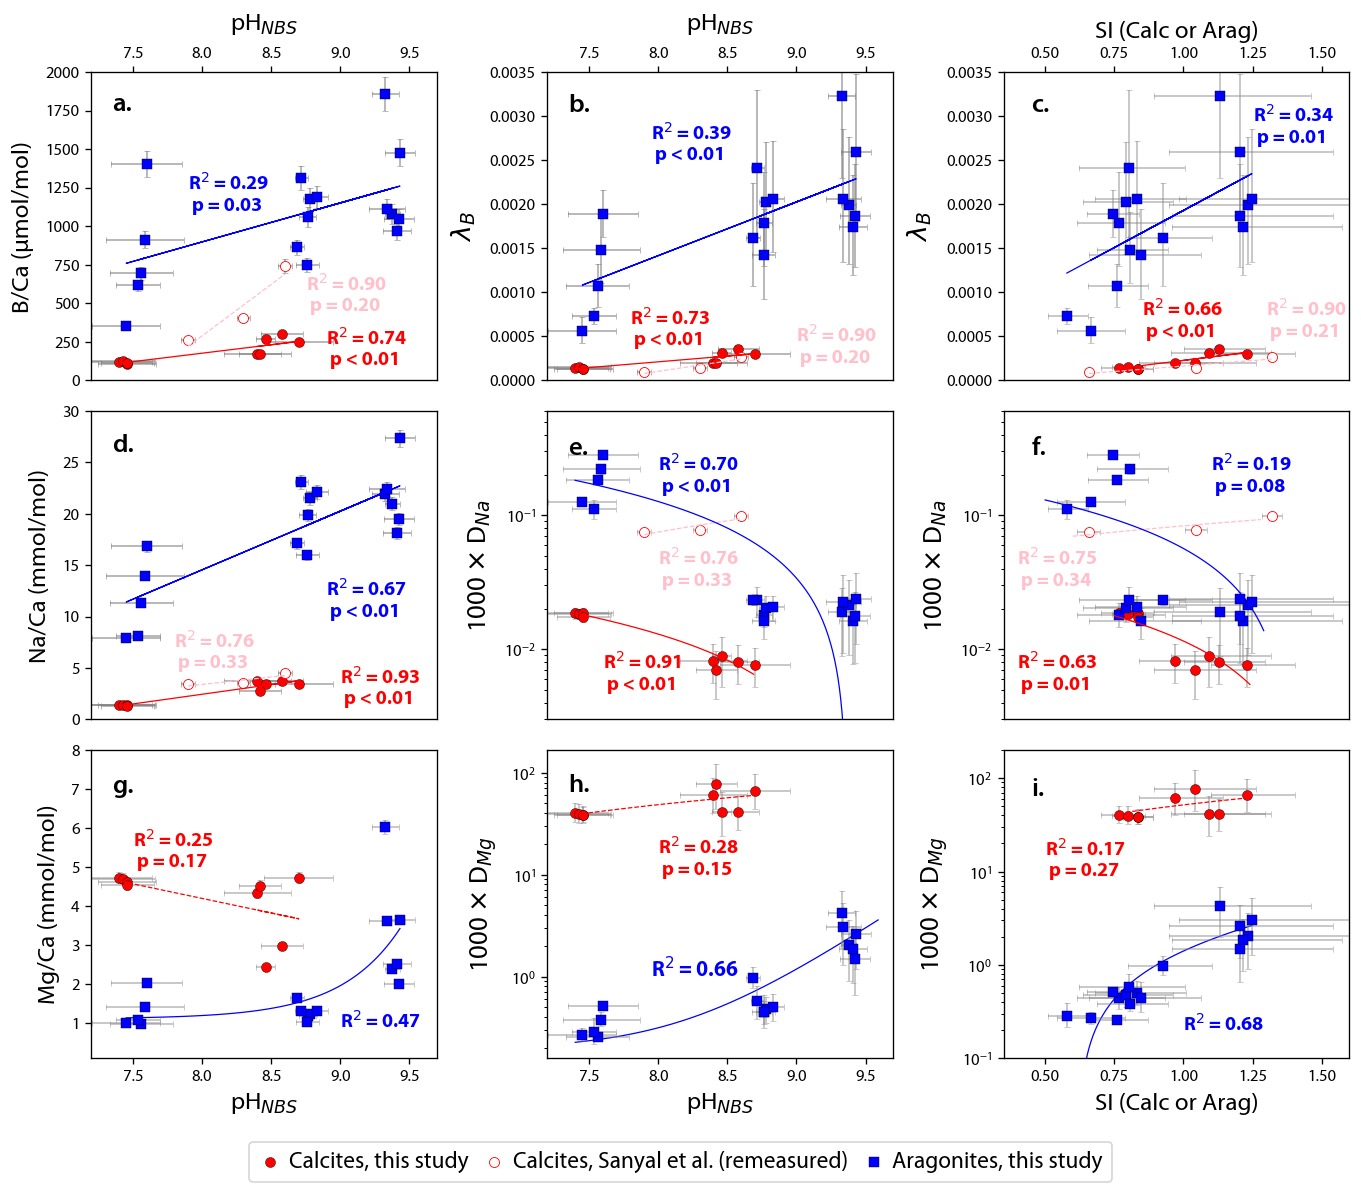

In [20]:
## Same again but with KD instead of LambdaDIC for the cations

highSIAragErr=(MC_SIArag_up95-MC_SIArag_median)
lowSIAragErr=MC_SIArag_median-MC_SIArag_low95
highSICalcErr=(MC_SICalc_up95-MC_SICalc_median)
lowSICalcErr=MC_SICalc_median-MC_SICalc_low95


highlambdaBErr=(MClambdaB_up95-MClambdaB_median)
lowlambdaBErr=MClambdaB_median-MClambdaB_low95
highKDNaErr=(MC_KDNa_up95-MC_KDNa_median)
lowKDNaErr=MC_KDNa_median-MC_KDNa_low95
highKDMgErr=(MC_KDMg_up95-MC_KDMg_median)
lowKDMgErr=MC_KDMg_median-MC_KDMg_low95
MClambdaB_median=pd.Series(MClambdaB.median(axis=1), index=df.index)
MClambdaB_up95=pd.Series(np.quantile(MClambdaB, 0.95, axis=1), index=df.index)
MClambdaB_low95=pd.Series(np.quantile(MClambdaB, 0.05, axis=1), index=df.index)

fig, ([ax1, ax2, ax7], [ax3, ax4, ax8],[ax5, ax6, ax9]) = plt.subplots(nrows=3, ncols=3, figsize=(11.5,10))


#red_circles = mlines.Line2D([], [], color='red', marker='o',
#                          markersize=7, label='Calcites', lw=0.0)
#blue_squares = mlines.Line2D([], [], color='blue', marker='s',
#                          markersize=7, label='Aragonites', lw=0.0)
#fig.legend(handles=[red_circles, blue_squares], loc="lower center", fontsize=14, labelspacing=0.15, frameon=True, borderaxespad=0.5, ncol=2)

#ax2.yaxis.tick_right()
ax1.xaxis.tick_top()
ax2.xaxis.tick_top()
ax7.xaxis.tick_top()

#ax4.xaxis.tick_hide()
#ax4.yaxis.tick_right()
#ax6.yaxis.tick_right()
ax1.set_xlim(7.2,9.7)
ax1.set_ylim(0,2000)
ax1.errorbar(df.pH[(df.Study=='us')], df.BCa_umol[(df.Study=='us')], 
            yerr=[(df.BCa_umol[(df.Study=='us')]*0.06),(df.BCa_umol[(df.Study=='us')]*0.06)],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.errorbar(df.pH[(df.Study=='Sanyal')], df.BCa_umol[(df.Study=='Sanyal')], 
            yerr=[(df.BCa_umol[(df.Study=='Sanyal')]*0.06),(df.BCa_umol[(df.Study=='Sanyal')]*0.06)],
            xerr= [df.pHerr[(df.Study=='Sanyal')],df.pHerr[(df.Study=='Sanyal')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
temp=MCregressStats(MC_pHNBS,doubleMC_BCa,'us',True,reps)
ax1.plot(df.pH[(df.Study=='us')&(df.Calc==True)],df.pH[(df.Study=='us')&(df.Calc==True)]*temp[0] + temp[1], color='red', linewidth=0.75)
if temp[3]<0.01:
    ax1.text(8.9,100,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=12,fontweight='bold')
else:   
    ax1.text(8.9,100,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=12,fontweight='bold')
temp=MCregressStats(MC_pHNBS,doubleMC_BCa,'Sanyal',True,reps)
if temp[3]<0.01:
    ax1.plot(df.pH[(df.Study=='Sanyal')&(df.Calc==True)],df.pH[(df.Study=='Sanyal')&(df.Calc==True)]*temp[0] + temp[1], color='pink', linewidth=0.75)
    ax1.text(8.75,450,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=13,fontweight='bold')
elif temp[3]>0.05:
    ax1.plot(df.pH[(df.Study=='Sanyal')&(df.Calc==True)],df.pH[(df.Study=='Sanyal')&(df.Calc==True)]*temp[0] + temp[1], color='pink', linewidth=0.75, linestyle='--')
    ax1.text(8.75,450,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='pink', fontsize=12,fontweight='bold')
else:   
    ax1.text(8.75,450,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='pink', fontsize=12,fontweight='bold')
temp=MCregressStats(MC_pHNBS,doubleMC_BCa,'us',False,reps)
ax1.plot(df.pH[(df.Study=='us')&(df.Calc==False)],df.pH[(df.Study=='us')&(df.Calc==False)]*temp[0] + temp[1], color='blue', linewidth=0.75)
if temp[3]<0.01:
    ax1.text(7.9,1100,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=12,fontweight='bold')
else:
    ax1.text(7.9,1100,'R$^2$ = %.2f\n p = %.2f' % (temp[2]**2,temp[3]), color='blue', fontsize=12,fontweight='bold')
ax1.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], df.BCa_umol[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites, this study', marker='o')
ax1.scatter(df.pH[(df.Study=='Sanyal')&(df.Calc==True)], df.BCa_umol[(df.Study=='Sanyal')&(df.Calc==True)], \
            color='red',linewidths=0.5, facecolors='white', label='Calcites, Sanyal et al. (remeasured)', marker='o')
ax1.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], df.BCa_umol[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites, this study', marker='s')

ax2.set_xlim(7.2,9.7)
#ax2.set_ylim(0,2000)
ax2.errorbar(df.pH[(df.Study=='us')],  MClambdaB_median[(df.Study=='us')],
            yerr= [lowlambdaBErr[(df.Study=='us')],highlambdaBErr[(df.Study=='us')]],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax2.errorbar(df.pH[(df.Study=='Sanyal')],  MClambdaB_median[(df.Study=='Sanyal')],
            yerr= [lowlambdaBErr[(df.Study=='Sanyal')],highlambdaBErr[(df.Study=='Sanyal')]],
            xerr= [df.pHerr[(df.Study=='Sanyal')],df.pHerr[(df.Study=='Sanyal')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
temp=MCregressStats(MC_pHNBS,MClambdaB,'us',True,reps)
ax2.plot(df.pH[(df.Study=='us')&(df.Calc==True)],df.pH[(df.Study=='us')&(df.Calc==True)]*temp[0] + temp[1], color='red', linewidth=0.75)
if temp[3]<0.01:
    ax2.text(7.8,0.0004,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=12,fontweight='bold')
else:
    ax2.text(7.8,0.0004,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=12,fontweight='bold')
temp=MCregressStats(MC_pHNBS,MClambdaB,'Sanyal',True,reps)
if temp[3]<0.01:
    ax2.plot(df.pH[(df.Study=='Sanyal')&(df.Calc==True)],df.pH[(df.Study=='Sanyal')&(df.Calc==True)]*temp[0] + temp[1], color='pink', linewidth=0.75)
    ax2.text(9,0.0002,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=12,fontweight='bold')
elif temp[3]>0.05:
    ax2.plot(df.pH[(df.Study=='Sanyal')&(df.Calc==True)],df.pH[(df.Study=='Sanyal')&(df.Calc==True)]*temp[0] + temp[1], color='pink', linewidth=0.75, linestyle='--')
    ax2.text(9,0.0002,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='pink', fontsize=12,fontweight='bold')
else:
    ax2.plot(df.pH[(df.Study=='Sanyal')&(df.Calc==True)],df.pH[(df.Study=='Sanyal')&(df.Calc==True)]*temp[0] + temp[1], color='pink', linewidth=0.75)
    ax2.text(9,0.0002,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='pink', fontsize=12,fontweight='bold')
temp=MCregressStats(MC_pHNBS,MClambdaB,'us',False,reps)
ax2.plot(df.pH[(df.Study=='us')&(df.Calc==False)],df.pH[(df.Study=='us')&(df.Calc==False)]*temp[0] + temp[1], color='blue', linewidth=0.75)
if temp[3]<0.01:
    ax2.text(7.95,0.0025,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=12,fontweight='bold')
else:
    ax2.text(7.95,0.0025,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='blue', fontsize=12,fontweight='bold')
ax2.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], MClambdaB_median[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax2.scatter(df.pH[(df.Study=='Sanyal')&(df.Calc==True)], MClambdaB_median[(df.Study=='Sanyal')&(df.Calc==True)], \
            color='red',linewidths=0.5, facecolors='white', label='Calcites', marker='o')
ax2.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], MClambdaB_median[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax3.set_xlim(7.2,9.7)
ax3.set_ylim(0,30)
ax3.get_xaxis().set_visible(False)
ax3.errorbar(df.pH[(df.Study=='us')], df.NaCa_mmol[(df.Study=='us')], 
            yerr=[(df.NaCa_mmol[(df.Study=='us')]*0.03),(df.NaCa_mmol[(df.Study=='us')]*0.03)],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax3.errorbar(df.pH[(df.Study=='Sanyal')], df.NaCa_mmol[(df.Study=='Sanyal')], 
            yerr=[(df.NaCa_mmol[(df.Study=='Sanyal')]*0.03),(df.NaCa_mmol[(df.Study=='Sanyal')]*0.03)],
            xerr= [df.pHerr[(df.Study=='Sanyal')],df.pHerr[(df.Study=='Sanyal')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
temp=MCregressStats(MC_pHNBS,MC_NaCa,'us',True,reps)
ax3.plot(df.pH[(df.Study=='us')&(df.Calc==True)],df.pH[(df.Study=='us')&(df.Calc==True)]*temp[0] + temp[1], color='red', linewidth=0.75)
if temp[3]<0.01:
    ax3.text(9,1.5,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=12,fontweight='bold')
else:
    ax3.text(9,1.5,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='red', fontsize=12,fontweight='bold')
temp=MCregressStats(MC_pHNBS,MC_NaCa,'Sanyal',True,reps)
if temp[3]<0.01:
    ax3.plot(df.pH[(df.Study=='Sanyal')&(df.Calc==True)],df.pH[(df.Study=='Sanyal')&(df.Calc==True)]*temp[0] + temp[1], color='pink', linewidth=0.75)
    ax3.text(7.8,5,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='pink', fontsize=12,fontweight='bold')
elif temp[3]>0.05:
    ax3.plot(df.pH[(df.Study=='Sanyal')&(df.Calc==True)],df.pH[(df.Study=='Sanyal')&(df.Calc==True)]*temp[0] + temp[1], color='pink', linewidth=0.75, linestyle='--')
    ax3.text(7.8,5,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='pink', fontsize=12,fontweight='bold')
else:
    ax3.plot(df.pH[(df.Study=='Sanyal')&(df.Calc==True)],df.pH[(df.Study=='Sanyal')&(df.Calc==True)]*temp[0] + temp[1], color='pink', linewidth=0.75)
    ax3.text(7.8,5,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='pink', fontsize=12,fontweight='bold')
temp=MCregressStats(MC_pHNBS,MC_NaCa,'us',False,reps)
ax3.plot(df.pH[(df.Study=='us')&(df.Calc==False)],df.pH[(df.Study=='us')&(df.Calc==False)]*temp[0] + temp[1], color='blue', linewidth=0.75)
if temp[3]<0.01:
    ax3.text(8.9,10,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=12,fontweight='bold')
else:
    ax3.text(8.9,10,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='blue', fontsize=12,fontweight='bold')
ax3.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], df.NaCa_mmol[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax3.scatter(df.pH[(df.Study=='Sanyal')&(df.Calc==True)], df.NaCa_mmol[(df.Study=='Sanyal')&(df.Calc==True)], \
            color='red',linewidths=0.5, facecolors='white', label='Calcites', marker='o')
ax3.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')


ax4.set_xlim(7.2,9.7)
#ax4.set_ylim(0,2000)
ax4.set_yscale('log')
ax4.get_xaxis().set_visible(False)
ax4.errorbar(df.pH[(df.Study=='us')], MC_KDNa_median[(df.Study=='us')], 
            yerr= [lowKDNaErr[(df.Study=='us')],highKDNaErr[(df.Study=='us')]],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax4.errorbar(df.pH[(df.Study=='Sanyal')], MC_KDNa_median[(df.Study=='Sanyal')], 
            yerr= [lowKDNaErr[(df.Study=='Sanyal')],highKDNaErr[(df.Study=='Sanyal')]],
            xerr= [df.pHerr[(df.Study=='Sanyal')],df.pHerr[(df.Study=='Sanyal')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
def func(t, a, b, alpha):
    return a*np.exp(alpha * t) + b
t=np.array(df.pH[(df.Study=='us')&(df.Calc==False)])
v=np.array(MC_KDNa_median[(df.Study=='us')&(df.Calc==False)])
# initial guess for curve fit coefficients
#a0 = 0
#b0 = 0
#alpha0 = 2
# coefficients and curve fit for curve(a0, b0, alpha0)
#popt4, pcov4 = curve_fit(func, t, v, p0=(a0, b0, alpha0), maxfev=1000000)
#a, b, alpha = popt4
#v_fit = func(t, a, b, alpha)
#ss_res = np.sum((v - v_fit) ** 2)       # residual sum of squares
#ss_tot = np.sum((v - np.mean(v)) ** 2)  # total sum of squares
#r2 = 1 - (ss_res / ss_tot)              # R squared fit, R^2
#testx=np.arange(7.4,9.6,0.01)
#testy=a*np.exp(alpha*testx)+b
#ax4.plot(testx, testy, color='blue', linewidth=0.75, zorder=-2)
#ax4.text(7.95,0.15,'R$^2$ = %.2f' % r2, color='blue', fontsize=13,fontweight='bold')
temp=MCregressStats(MC_pHNBS,MC_KDNa,'us',True,reps)
testx=np.arange(min(df.pH[(df.Study=='us')&(df.Calc==True)]),max(df.pH[(df.Study=='us')&(df.Calc==True)]),0.01)
ax4.plot(testx,testx*temp[0]+ temp[1], color='red', linewidth=0.75)
if temp[3]<0.01:
    ax4.text(7.6,0.005,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=12,fontweight='bold')
else:
    ax4.text(7.6,0.005,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='red', fontsize=12,fontweight='bold')

temp=MCregressStats(MC_pHNBS,MC_KDNa,'Sanyal',True,reps)
testx=np.arange(min(df.pH[(df.Study=='Sanyal')&(df.Calc==True)]),max(df.pH[(df.Study=='Sanyal')&(df.Calc==True)]),0.01)
if temp[3]<0.01:
    ax4.plot(testx,testx*temp[0]+ temp[1], color='pink', linewidth=0.75)
    ax4.text(8,0.03,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='pink', fontsize=12,fontweight='bold')
elif temp[3]>0.05:
    ax4.plot(testx,testx*temp[0]+ temp[1], color='pink', linewidth=0.75, linestyle='--')
    ax4.text(8,0.03,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='pink', fontsize=12,fontweight='bold')
else:
    ax4.plot(testx,testx*temp[0]+ temp[1], color='pink', linewidth=0.75)
    ax4.text(8,0.03,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='pink', fontsize=12,fontweight='bold')
    
temp=MCregressStats(MC_pHNBS,MC_KDNa,'us',False,reps)
#ax4.plot(df.pH[(df.Study=='us')&(df.Calc==False)],df.pH[(df.Study=='us')&(df.Calc==False)]*Aslope+ Aintercept, color='blue', linewidth=0.75)
testx=np.arange(7.4,9.6,0.01)
ax4.plot(testx,testx*temp[0]+ temp[1], color='blue', linewidth=0.75)
if temp[3]<0.01:
    ax4.text(8,0.15,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=12,fontweight='bold')
else:
    ax4.text(8,0.15,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='blue', fontsize=12,fontweight='bold')
ax4.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], MC_KDNa_median[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax4.scatter(df.pH[(df.Study=='Sanyal')&(df.Calc==True)], MC_KDNa_median[(df.Study=='Sanyal')&(df.Calc==True)], \
            color='red',linewidths=0.5, facecolors='white', label='Calcites', marker='o')
ax4.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], MC_KDNa_median[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax5.set_xlim(7.2,9.7)
ax5.set_ylim(0.1,8)
ax5.errorbar(df.pH[(df.Study=='us')], df.MgCa_mmol[(df.Study=='us')], 
            yerr=[(df.MgCa_mmol[(df.Study=='us')]*0.03),(df.MgCa_mmol[(df.Study=='us')]*0.03)],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
temp=MCregressStats(MC_pHNBS,MC_MgCa,'us',True,reps)
ax5.plot(df.pH[(df.Study=='us')&(df.Calc==True)],df.pH[(df.Study=='us')&(df.Calc==True)]*temp[0]+ temp[1], color='red', linewidth=0.75, linestyle='--')
if temp[3]<0.01:
    ax5.text(7.5,5,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=12,fontweight='bold')
else:
    ax5.text(7.5,5,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='red', fontsize=12,fontweight='bold')
t=np.array(df.pH[(df.Study=='us')&(df.Calc==False)])
v=np.array(df.MgCa_mmol[(df.Study=='us')&(df.Calc==False)])
# initial guess for curve fit coefficients
a0 = 0
b0 = 0
alpha0 = 2
# coefficients and curve fit for curve(a0, b0, alpha0)
popt4, pcov4 = curve_fit(func, t, v, p0=(a0, b0, alpha0), maxfev=1000000)
a, b, alpha = popt4
v_fit = func(t, a, b, alpha)
ss_res = np.sum((v - v_fit) ** 2)       # residual sum of squares
ss_tot = np.sum((v - np.mean(v)) ** 2)  # total sum of squares
r2 = 1 - (ss_res / ss_tot)              # R squared fit, R^2
testx=np.linspace(min(df.pH[(df.Study=='us')&(df.Calc==False)]),max(df.pH[(df.Study=='us')&(df.Calc==False)]),100)
testy=a*np.exp(alpha*testx)+b
ax5.plot(testx, testy, color='blue', linewidth=0.75, zorder=-2)
ax5.text(9,0.9,'R$^2$ = %.2f' % r2, color='blue', fontsize=12,fontweight='bold')
#Aslope, Aintercept, Ar_value, Ap_value, Astd_err = stats.linregress(df.pH[(df.Study=='us')&(df.Calc==False)], df.MgCa_mmol[(df.Study=='us')&(df.Calc==False)])
#ax5.plot(df.pH[(df.Study=='us')&(df.Calc==False)],df.pH[(df.Study=='us')&(df.Calc==False)]*Aslope+ Aintercept, color='blue', linewidth=0.75)
#ax5.text(8,0.9,'R$^2$ = %.2f' % Ar_value**2, color='blue', fontsize=13,fontweight='bold')
ax5.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], df.MgCa_mmol[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax5.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], df.MgCa_mmol[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax6.set_xlim(7.2,9.7)
ax6.set_yscale('log')
#ax6.set_ylim(10**-4,1)
#ax6.set_ylim(0,2000)
ax6.errorbar(df.pH[(df.Study=='us')], MC_KDMg_median[(df.Study=='us')], 
            yerr= [lowKDMgErr[(df.Study=='us')],highKDMgErr[(df.Study=='us')]],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

def func(t, a, b, alpha):
    return a*np.exp(alpha * t) + b

t=np.array(df.pH[(df.Study=='us')&(df.Calc==False)])
v=np.array(MC_KDMg_median[(df.Study=='us')&(df.Calc==False)])
# initial guess for curve fit coefficients
a0 = 0
b0 = 0
alpha0 = 2
# coefficients and curve fit for curve(a0, b0, alpha0)
popt4, pcov4 = curve_fit(func, t, v, p0=(a0, b0, alpha0), maxfev=1000000)
a, b, alpha = popt4
v_fit = func(t, a, b, alpha)
ss_res = np.sum((v - v_fit) ** 2)       # residual sum of squares
ss_tot = np.sum((v - np.mean(v)) ** 2)  # total sum of squares
r2 = 1 - (ss_res / ss_tot)              # R squared fit, R^2
testx=np.arange(7.4,9.6,0.01)
testy=a*np.exp(alpha*testx)+b
ax6.plot(testx, testy, color='blue', linewidth=0.75, zorder=-2)
ax6.text(7.95,1,'R$^2$ = %.2f' % r2, color='blue', fontsize=13,fontweight='bold')
temp=MCregressStats(MC_pHNBS,MC_KDMg,'us',True,reps)
X1=np.linspace(min(df.pH[(df.Study=='us')&(df.Calc==True)]),max(df.pH[(df.Study=='us')&(df.Calc==True)]),100)
ax6.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75, linestyle='--')
if temp[3]<0.01:
    ax6.text(8.0,10,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=12,fontweight='bold')
else:
    ax6.text(8.0,10,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='red', fontsize=12,fontweight='bold')
#Aslope, Aintercept, Ar_value, Ap_value, Astd_err = stats.linregress(df.pH[(df.Study=='us')&(df.Calc==False)], MC_KDMg_median[(df.Study=='us')&(df.Calc==False)])
#X1=np.linspace(min(df.pH[(df.Study=='us')&(df.Calc==False)]),max(df.pH[(df.Study=='us')&(df.Calc==False)]),100)
#ax6.plot(X1,X1*Aslope + Aintercept, color='blue', linewidth=0.75)
#ax6.text(7.95,0.00025,'R$^2$ = %.2f' % Ar_value**2, color='blue', fontsize=13,fontweight='bold')
ax6.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], MC_KDMg_median[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax6.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], MC_KDMg_median[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')


ax7.errorbar(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], MClambdaB_median[(df.Study=='us')&(df.Calc==True)],
            xerr= [highSICalcErr[(df.Study=='us')&(df.Calc==True)],lowSICalcErr[(df.Study=='us')&(df.Calc==True)]], 
            yerr= [lowlambdaBErr[(df.Study=='us')&(df.Calc==True)],highlambdaBErr[(df.Study=='us')&(df.Calc==True)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax7.errorbar(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], MClambdaB_median[(df.Study=='us')&(df.Calc==False)],
            xerr=[highSIAragErr[(df.Study=='us')&(df.Calc==False)],lowSIAragErr[(df.Study=='us')&(df.Calc==False)]],
            yerr= [lowlambdaBErr[(df.Study=='us')&(df.Calc==False)],highlambdaBErr[(df.Study=='us')&(df.Calc==False)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax7.errorbar(MC_SIArag_median[(df.Study=='Sanyal')&(df.Calc==False)], MClambdaB_median[(df.Study=='Sanyal')&(df.Calc==False)],
            xerr=[highSIAragErr[(df.Study=='Sanyal')&(df.Calc==False)],lowSIAragErr[(df.Study=='Sanyal')&(df.Calc==False)]],
            yerr= [lowlambdaBErr[(df.Study=='Sanyal')&(df.Calc==False)],highlambdaBErr[(df.Study=='Sanyal')&(df.Calc==False)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
temp=MCregressStats(MC_SICalc,MClambdaB,'us',True,reps)
ax7.plot(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)],MC_SICalc_median[(df.Study=='us')&(df.Calc==True)]*temp[0] + temp[1], color='red', linewidth=0.75)
if temp[3]<0.01:
    ax7.text(0.85,0.0005,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=12,fontweight='bold')
else:
    ax7.text(0.85,0.0005,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='red', fontsize=12,fontweight='bold')
temp=MCregressStats(MC_SICalc,MClambdaB,'Sanyal',True,reps)
if temp[3]<0.01:
    ax7.plot(MC_SICalc_median[(df.Study=='Sanyal')&(df.Calc==True)],MC_SICalc_median[(df.Study=='Sanyal')&(df.Calc==True)]*temp[0] + temp[1], color='pink', linewidth=0.75)
    ax7.text(1.3,0.0005,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='pink', fontsize=12,fontweight='bold')
elif temp[3]>0.05:
    ax7.plot(MC_SICalc_median[(df.Study=='Sanyal')&(df.Calc==True)],MC_SICalc_median[(df.Study=='Sanyal')&(df.Calc==True)]*temp[0] + temp[1], color='pink', linewidth=0.75,linestyle='--')
    ax7.text(1.3,0.0005,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='pink', fontsize=12,fontweight='bold')
else:
    ax7.plot(MC_SICalc_median[(df.Study=='Sanyal')&(df.Calc==True)],MC_SICalc_median[(df.Study=='Sanyal')&(df.Calc==True)]*temp[0] + temp[1], color='pink', linewidth=0.75)
    ax7.text(1.3,0.0005,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='pink', fontsize=12,fontweight='bold')    

temp=MCregressStats(MC_SIArag,MClambdaB,'us',False,reps)
ax7.plot(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)],MC_SIArag_median[(df.Study=='us')&(df.Calc==False)]*temp[0] + temp[1], color='blue', linewidth=0.75)
if temp[3]<0.01:
    ax7.text(1.25,0.0027,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=12,fontweight='bold')
else:
    ax7.text(1.25,0.0027,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='blue', fontsize=12,fontweight='bold')
ax7.scatter(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], MClambdaB_median[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax7.scatter(MC_SICalc_median[(df.Study=='Sanyal')&(df.Calc==True)], MClambdaB_median[(df.Study=='Sanyal')&(df.Calc==True)], \
            color='red',linewidths=0.5, facecolors='white', label='Calcites', marker='o')
ax7.scatter(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], MClambdaB_median[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')


ax8.set_yscale('log')
ax8.errorbar(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], MC_KDNa_median[(df.Study=='us')&(df.Calc==True)],
            xerr=[highSICalcErr[(df.Study=='us')&(df.Calc==True)],lowSICalcErr[(df.Study=='us')&(df.Calc==True)]],
            yerr= [lowKDNaErr[(df.Study=='us')&(df.Calc==True)],highKDNaErr[(df.Study=='us')&(df.Calc==True)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax8.errorbar(MC_SICalc_median[(df.Study=='Sanyal')&(df.Calc==True)], MC_KDNa_median[(df.Study=='Sanyal')&(df.Calc==True)],
            xerr=[highSICalcErr[(df.Study=='Sanyal')&(df.Calc==True)],lowSICalcErr[(df.Study=='Sanyal')&(df.Calc==True)]],
            yerr= [lowKDNaErr[(df.Study=='Sanyal')&(df.Calc==True)],highKDNaErr[(df.Study=='Sanyal')&(df.Calc==True)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax8.errorbar(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], MC_KDNa_median[(df.Study=='us')&(df.Calc==False)],
            xerr=[highSIAragErr[(df.Study=='us')&(df.Calc==False)],lowSIAragErr[(df.Study=='us')&(df.Calc==False)]],
            yerr= [lowKDNaErr[(df.Study=='us')&(df.Calc==False)],highKDNaErr[(df.Study=='us')&(df.Calc==False)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
temp=MCregressStats(MC_SICalc,MC_KDNa,'us',True,reps)
testx=np.arange(0.75,1.25,0.01)
#ax8.plot(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)],MC_SICalc_median[(df.Study=='us')&(df.Calc==True)]*Cslope+ Cintercept, color='red', linewidth=0.75)
ax8.plot(testx,testx*temp[0]+ temp[1], color='red', linewidth=0.75)
if temp[3]<0.01:
    ax8.text(0.4,0.005,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=12,fontweight='bold')
else:
    ax8.text(0.4,0.005,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=12,fontweight='bold')
temp=MCregressStats(MC_SICalc,MC_KDNa,'Sanyal',True,reps)
testx=np.arange(0.6,1.29,0.01)
#ax8.plot(MC_SICalc_median[(df.Study=='Sanyal')&(df.Calc==True)],MC_SICalc_median[(df.Study=='Sanyal')&(df.Calc==True)]*Cslope+ Cintercept, color='red', linewidth=0.75)
if temp[3]<0.01:
    ax8.plot(testx,testx*temp[0]+ temp[1], color='pink', linewidth=0.75)
    ax8.text(0.4,0.02,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='pink', fontsize=12,fontweight='bold')
elif temp[3]>0.05:
    ax8.plot(testx,testx*temp[0]+ temp[1], color='pink', linewidth=0.75, linestyle='--')
    ax8.text(0.4,0.03,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='pink', fontsize=12,fontweight='bold')
else:
    ax8.plot(testx,testx*temp[0]+ temp[1], color='pink', linewidth=0.75)
    ax8.text(0.4,0.03,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='pink', fontsize=12,fontweight='bold')
temp=MCregressStats(MC_SIArag,MC_KDNa,'us',False,reps)
testx=np.arange(0.5,1.3,0.01)
ax8.plot(testx,(testx*temp[0]+ temp[1]), color='blue', linewidth=0.75)
if temp[3]<0.01:
    ax8.text(1.1,0.15,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=12,fontweight='bold')
else:
    ax8.text(1.1,0.15,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='blue', fontsize=12,fontweight='bold')
ax8.scatter(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], MC_KDNa_median[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax8.scatter(MC_SICalc_median[(df.Study=='Sanyal')&(df.Calc==True)], MC_KDNa_median[(df.Study=='Sanyal')&(df.Calc==True)], \
            color='red',linewidths=0.5, facecolors='white', label='Calcites', marker='o')
ax8.scatter(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], MC_KDNa_median[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')


ax9.set_yscale('log')
ax9.set_ylim(10**-1,200)
ax9.errorbar(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], MC_KDMg_median[(df.Study=='us')&(df.Calc==True)],
            xerr=[highSICalcErr[(df.Study=='us')&(df.Calc==True)],lowSICalcErr[(df.Study=='us')&(df.Calc==True)]],
            yerr= [lowKDMgErr[(df.Study=='us')&(df.Calc==True)],highKDMgErr[(df.Study=='us')&(df.Calc==True)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax9.errorbar(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], MC_KDMg_median[(df.Study=='us')&(df.Calc==False)],
            xerr=[highSIAragErr[(df.Study=='us')&(df.Calc==False)],lowSIAragErr[(df.Study=='us')&(df.Calc==False)]],
            yerr= [lowKDMgErr[(df.Study=='us')&(df.Calc==False)],highKDMgErr[(df.Study=='us')&(df.Calc==False)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
temp=MCregressStats(MC_SICalc,MC_KDMg,'us',True,reps)
X1=np.linspace(min(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)]),max(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)]),100)
ax9.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75, linestyle='--')
if temp[3]<0.01:
    ax9.text(0.5,9,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=12,fontweight='bold')
else:
    ax9.text(0.5,9,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=12,fontweight='bold')
#Aslope, Aintercept, Ar_value, Ap_value, Astd_err = stats.linregress(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], MC_KDMg_median[(df.Study=='us')&(df.Calc==False)])
#temp=MCregressStats(MC_SIArag,MC_KDMg,'us',False,reps)
#X1=np.linspace(min(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)]),max(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)]),100)
#ax9.plot(X1,X1*temp[0] + temp[1], color='blue', linewidth=0.75)
#if temp[3]<0.01:
#    ax9.text(1,0.2,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=13,fontweight='bold')
#else:
#    ax9.text(1,0.2,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='blue', fontsize=13,fontweight='bold')
t=np.array(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)])
v=np.array(MC_KDMg_median[(df.Study=='us')&(df.Calc==False)])
# initial guess for curve fit coefficients
a0 = 0
b0 = 0
alpha0 = 2
# coefficients and curve fit for curve(a0, b0, alpha0)
popt4, pcov4 = curve_fit(func, t, v, p0=(a0, b0, alpha0), maxfev=1000000)
a, b, alpha = popt4
v_fit = func(t, a, b, alpha)
ss_res = np.sum((v - v_fit) ** 2)       # residual sum of squares
ss_tot = np.sum((v - np.mean(v)) ** 2)  # total sum of squares
r2 = 1 - (ss_res / ss_tot)              # R squared fit, R^2
testx=np.linspace(min(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)]),max(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)]),100)
testy=a*np.exp(alpha*testx)+b
ax9.plot(testx, testy, color='blue', linewidth=0.75, zorder=-2)
ax9.text(1,0.2,'R$^2$ = %.2f' % r2, color='blue', fontsize=12,fontweight='bold')
ax9.scatter(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], MC_KDMg_median[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax9.scatter(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], MC_KDMg_median[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax2.set_ylim(0,0.0035)
ax7.set_ylim(0,0.0035)
ax4.set_ylim(0.003,0.6)
ax8.set_ylim(0.003,0.6)
#ax6.set_ylim(0,0.5)
ax7.set_xlim(0.35,1.6)
ax8.set_xlim(0.35,1.6)
ax9.set_xlim(0.35,1.6)



#ax6.legend(loc=(0.5,0.05), framealpha=1,fontsize=12)

ax1.set_xlabel('pH$_{NBS}$', fontsize=15,labelpad=10)
ax2.set_xlabel('pH$_{NBS}$', fontsize=15,labelpad=10)
ax5.set_xlabel('pH$_{NBS}$', fontsize=15)
ax6.set_xlabel('pH$_{NBS}$', fontsize=15)
ax1.set_ylabel('B/Ca (µmol/mol)', labelpad=7, fontsize=15)
ax3.set_ylabel('Na/Ca (mmol/mol)', labelpad=7, fontsize=15)
ax5.set_ylabel('Mg/Ca (mmol/mol)', labelpad=7, fontsize=15)
ax2.set_ylabel('$\lambda$$_{B}$', labelpad=7, fontsize=16) #rotation=270, needed if you want the y label on the right
ax4.set_ylabel(r'1000 $\times$ D$_{Na}$', labelpad=7, fontsize=16) #rotation=270, needed if you want the y label on the right
ax6.set_ylabel(r'1000 $\times$ D$_{Mg}$', labelpad=7, fontsize=16) #rotation=270, needed if you want the y label on the right
ax1.xaxis.set_label_position("top") 
ax2.xaxis.set_label_position("top") 
ax7.xaxis.set_label_position("top") 
ax7.set_ylabel('$\lambda$$_{B}$', labelpad=7, fontsize=16)
ax8.set_ylabel(r'1000 $\times$ D$_{Na}$', labelpad=7, fontsize=16)
ax9.set_ylabel(r'1000 $\times$ D$_{Mg}$', labelpad=7, fontsize=16)
ax7.set_xlabel('SI (Calc or Arag)', labelpad=5, fontsize=15)
ax9.set_xlabel('SI (Calc or Arag)', labelpad=5, fontsize=15)
ax8.get_xaxis().set_visible(False)
#ax2.yaxis.set_label_position("right")
#ax4.yaxis.set_label_position("right")
#ax6.yaxis.set_label_position("right")

ax1.text(7.35,1750, 'a.', fontweight='semibold', color='black', fontsize=16)
ax2.text(7.35, 0.00305, 'b.', fontweight='semibold', color='black', fontsize=16)
ax7.text(0.45, 0.00305, 'c.', fontweight='semibold', color='black', fontsize=16)
ax3.text(7.35, 26, 'd.', fontweight='semibold', color='black', fontsize=16)
ax4.text(7.35, 0.285, 'e.', fontweight='semibold', color='black', fontsize=16)
ax8.text(0.45, 0.285, 'f.', fontweight='semibold', color='black', fontsize=16)
ax5.text(7.35, 6.9, 'g.', fontweight='semibold', color='black', fontsize=16)
ax6.text(7.35, 65, 'h.', fontweight='semibold', color='black', fontsize=16)
ax9.text(0.45, 65, 'i.', fontweight='semibold', color='black', fontsize=16)


handles,labels=ax1.get_legend_handles_labels()
fig.legend(handles,labels, loc="lower center", fontsize=14, labelspacing=0.15, frameon=True, borderaxespad=0.5, ncol=3, columnspacing=0.6,handlelength=1,handletextpad=0.3)


#plt.adjust(left=0.1,bottom=0.75, right=0.11) ## makes some empty space for the legend
#fig.tight_layout() 
plt.tight_layout(w_pad=0.75,h_pad=1,rect=(0,0.05,1,1))

#fig.savefig('TEs vs carbsys_KDCations.pdf',bbox_inches="tight")
fig.savefig('TEs vs carbsys_DCations_wSanyal2se.pdf',bbox_inches="tight")

'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Semibold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


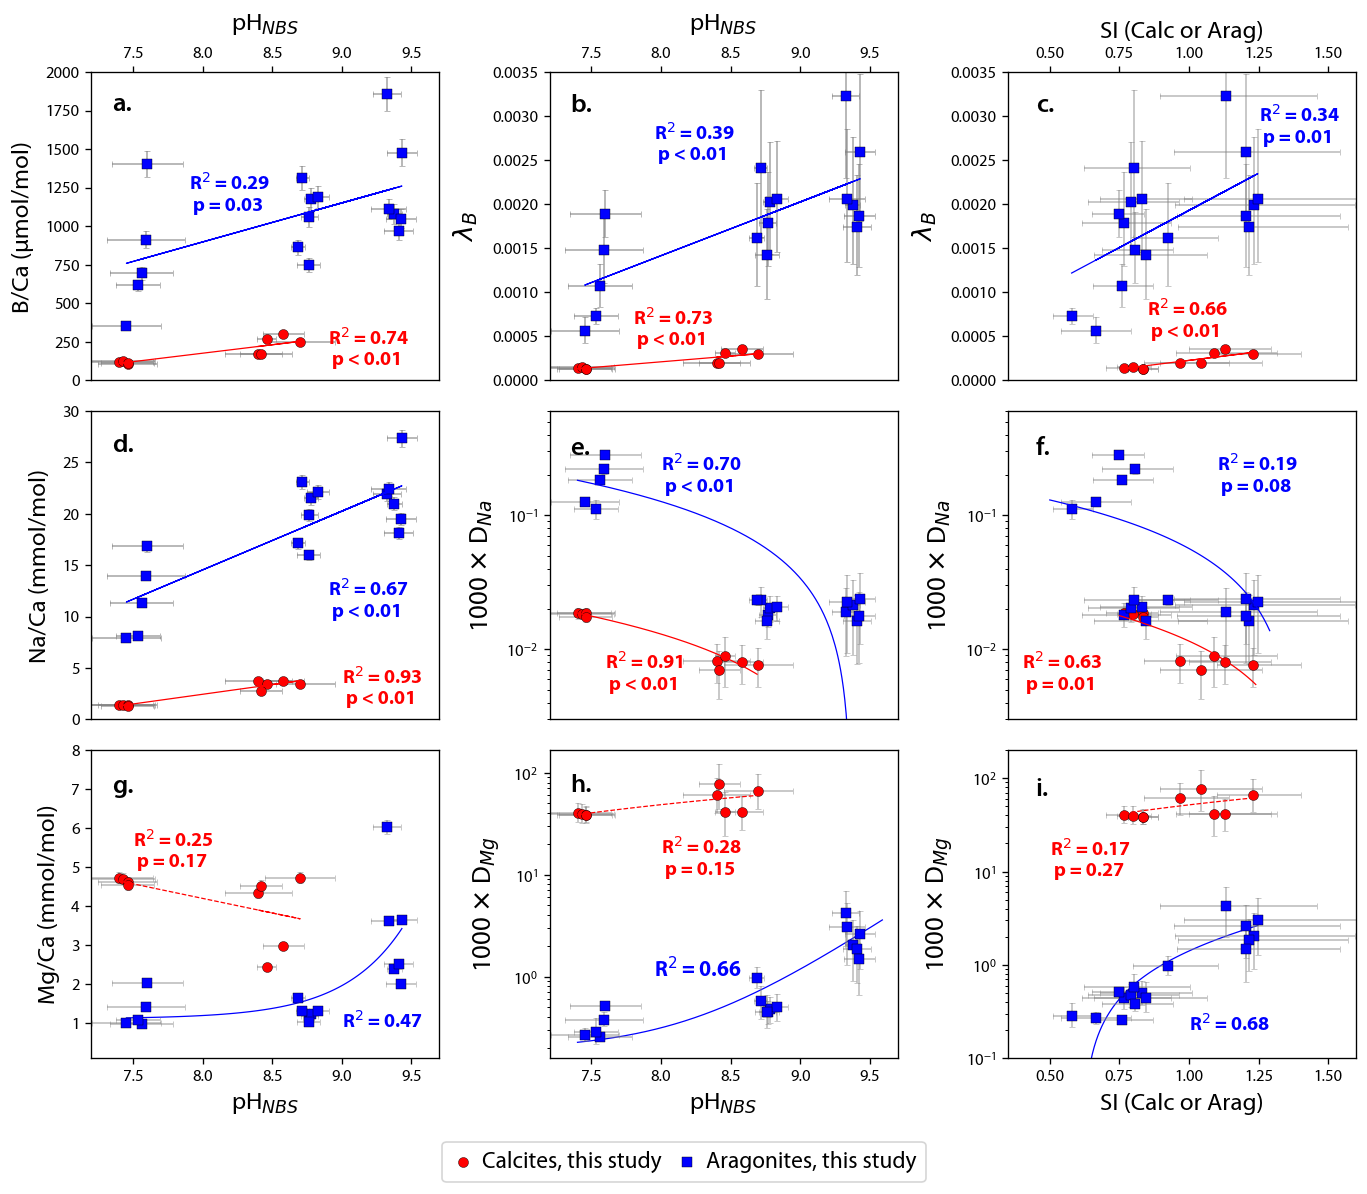

In [127]:
## Same again but with KD instead of LambdaDIC for the cations ... without Sanyal

highSIAragErr=(MC_SIArag_up95-MC_SIArag_median)
lowSIAragErr=MC_SIArag_median-MC_SIArag_low95
highSICalcErr=(MC_SICalc_up95-MC_SICalc_median)
lowSICalcErr=MC_SICalc_median-MC_SICalc_low95


highlambdaBErr=(MClambdaB_up95-MClambdaB_median)
lowlambdaBErr=MClambdaB_median-MClambdaB_low95
highKDNaErr=(MC_KDNa_up95-MC_KDNa_median)
lowKDNaErr=MC_KDNa_median-MC_KDNa_low95
highKDMgErr=(MC_KDMg_up95-MC_KDMg_median)
lowKDMgErr=MC_KDMg_median-MC_KDMg_low95
MClambdaB_median=pd.Series(MClambdaB.median(axis=1), index=df.index)
MClambdaB_up95=pd.Series(np.quantile(MClambdaB, 0.95, axis=1), index=df.index)
MClambdaB_low95=pd.Series(np.quantile(MClambdaB, 0.05, axis=1), index=df.index)

fig, ([ax1, ax2, ax7], [ax3, ax4, ax8],[ax5, ax6, ax9]) = plt.subplots(nrows=3, ncols=3, figsize=(11.5,10))


#red_circles = mlines.Line2D([], [], color='red', marker='o',
#                          markersize=7, label='Calcites', lw=0.0)
#blue_squares = mlines.Line2D([], [], color='blue', marker='s',
#                          markersize=7, label='Aragonites', lw=0.0)
#fig.legend(handles=[red_circles, blue_squares], loc="lower center", fontsize=14, labelspacing=0.15, frameon=True, borderaxespad=0.5, ncol=2)

#ax2.yaxis.tick_right()
ax1.xaxis.tick_top()
ax2.xaxis.tick_top()
ax7.xaxis.tick_top()

#ax4.xaxis.tick_hide()
#ax4.yaxis.tick_right()
#ax6.yaxis.tick_right()
ax1.set_xlim(7.2,9.7)
ax1.set_ylim(0,2000)
ax1.errorbar(df.pH[(df.Study=='us')], df.BCa_umol[(df.Study=='us')], 
            yerr=[(df.BCa_umol[(df.Study=='us')]*0.06),(df.BCa_umol[(df.Study=='us')]*0.06)],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
temp=MCregressStats(MC_pHNBS,doubleMC_BCa,'us',True,reps)
ax1.plot(df.pH[(df.Study=='us')&(df.Calc==True)],df.pH[(df.Study=='us')&(df.Calc==True)]*temp[0] + temp[1], color='red', linewidth=0.75)
if temp[3]<0.01:
    ax1.text(8.9,100,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=12,fontweight='bold')
else:   
    ax1.text(8.9,100,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=12,fontweight='bold')

temp=MCregressStats(MC_pHNBS,doubleMC_BCa,'us',False,reps)
ax1.plot(df.pH[(df.Study=='us')&(df.Calc==False)],df.pH[(df.Study=='us')&(df.Calc==False)]*temp[0] + temp[1], color='blue', linewidth=0.75)
if temp[3]<0.01:
    ax1.text(7.9,1100,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=12,fontweight='bold')
else:
    ax1.text(7.9,1100,'R$^2$ = %.2f\n p = %.2f' % (temp[2]**2,temp[3]), color='blue', fontsize=12,fontweight='bold')
ax1.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], df.BCa_umol[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites, this study', marker='o')
ax1.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], df.BCa_umol[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites, this study', marker='s')

ax2.set_xlim(7.2,9.7)
#ax2.set_ylim(0,2000)
ax2.errorbar(df.pH[(df.Study=='us')],  MClambdaB_median[(df.Study=='us')],
            yerr= [lowlambdaBErr[(df.Study=='us')],highlambdaBErr[(df.Study=='us')]],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

temp=MCregressStats(MC_pHNBS,MClambdaB,'us',True,reps)
ax2.plot(df.pH[(df.Study=='us')&(df.Calc==True)],df.pH[(df.Study=='us')&(df.Calc==True)]*temp[0] + temp[1], color='red', linewidth=0.75)
if temp[3]<0.01:
    ax2.text(7.8,0.0004,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=12,fontweight='bold')
else:
    ax2.text(7.8,0.0004,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=12,fontweight='bold')

temp=MCregressStats(MC_pHNBS,MClambdaB,'us',False,reps)
ax2.plot(df.pH[(df.Study=='us')&(df.Calc==False)],df.pH[(df.Study=='us')&(df.Calc==False)]*temp[0] + temp[1], color='blue', linewidth=0.75)
if temp[3]<0.01:
    ax2.text(7.95,0.0025,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=12,fontweight='bold')
else:
    ax2.text(7.95,0.0025,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='blue', fontsize=12,fontweight='bold')
ax2.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], MClambdaB_median[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')

ax2.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], MClambdaB_median[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax3.set_xlim(7.2,9.7)
ax3.set_ylim(0,30)
ax3.get_xaxis().set_visible(False)
ax3.errorbar(df.pH[(df.Study=='us')], df.NaCa_mmol[(df.Study=='us')], 
            yerr=[(df.NaCa_mmol[(df.Study=='us')]*0.03),(df.NaCa_mmol[(df.Study=='us')]*0.03)],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.65, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
temp=MCregressStats(MC_pHNBS,MC_NaCa,'us',True,reps)
ax3.plot(df.pH[(df.Study=='us')&(df.Calc==True)],df.pH[(df.Study=='us')&(df.Calc==True)]*temp[0] + temp[1], color='red', linewidth=0.75)
if temp[3]<0.01:
    ax3.text(9,1.5,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=12,fontweight='bold')
else:
    ax3.text(9,1.5,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='red', fontsize=12,fontweight='bold')

temp=MCregressStats(MC_pHNBS,MC_NaCa,'us',False,reps)
ax3.plot(df.pH[(df.Study=='us')&(df.Calc==False)],df.pH[(df.Study=='us')&(df.Calc==False)]*temp[0] + temp[1], color='blue', linewidth=0.75)
if temp[3]<0.01:
    ax3.text(8.9,10,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=12,fontweight='bold')
else:
    ax3.text(8.9,10,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='blue', fontsize=12,fontweight='bold')
ax3.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], df.NaCa_mmol[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax3.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')


ax4.set_xlim(7.2,9.7)
#ax4.set_ylim(0,2000)
ax4.set_yscale('log')
ax4.get_xaxis().set_visible(False)
ax4.errorbar(df.pH[(df.Study=='us')], MC_KDNa_median[(df.Study=='us')], 
            yerr= [lowKDNaErr[(df.Study=='us')],highKDNaErr[(df.Study=='us')]],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

def func(t, a, b, alpha):
    return a*np.exp(alpha * t) + b
t=np.array(df.pH[(df.Study=='us')&(df.Calc==False)])
v=np.array(MC_KDNa_median[(df.Study=='us')&(df.Calc==False)])
# initial guess for curve fit coefficients
#a0 = 0
#b0 = 0
#alpha0 = 2
# coefficients and curve fit for curve(a0, b0, alpha0)
#popt4, pcov4 = curve_fit(func, t, v, p0=(a0, b0, alpha0), maxfev=1000000)
#a, b, alpha = popt4
#v_fit = func(t, a, b, alpha)
#ss_res = np.sum((v - v_fit) ** 2)       # residual sum of squares
#ss_tot = np.sum((v - np.mean(v)) ** 2)  # total sum of squares
#r2 = 1 - (ss_res / ss_tot)              # R squared fit, R^2
#testx=np.arange(7.4,9.6,0.01)
#testy=a*np.exp(alpha*testx)+b
#ax4.plot(testx, testy, color='blue', linewidth=0.75, zorder=-2)
#ax4.text(7.95,0.15,'R$^2$ = %.2f' % r2, color='blue', fontsize=13,fontweight='bold')
temp=MCregressStats(MC_pHNBS,MC_KDNa,'us',True,reps)
testx=np.arange(min(df.pH[(df.Study=='us')&(df.Calc==True)]),max(df.pH[(df.Study=='us')&(df.Calc==True)]),0.01)
ax4.plot(testx,testx*temp[0]+ temp[1], color='red', linewidth=0.75)
if temp[3]<0.01:
    ax4.text(7.6,0.005,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=12,fontweight='bold')
else:
    ax4.text(7.6,0.005,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='red', fontsize=12,fontweight='bold')


temp=MCregressStats(MC_pHNBS,MC_KDNa,'us',False,reps)
#ax4.plot(df.pH[(df.Study=='us')&(df.Calc==False)],df.pH[(df.Study=='us')&(df.Calc==False)]*Aslope+ Aintercept, color='blue', linewidth=0.75)
testx=np.arange(7.4,9.6,0.01)
ax4.plot(testx,testx*temp[0]+ temp[1], color='blue', linewidth=0.75)
if temp[3]<0.01:
    ax4.text(8,0.15,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=12,fontweight='bold')
else:
    ax4.text(8,0.15,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='blue', fontsize=12,fontweight='bold')
ax4.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], MC_KDNa_median[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax4.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], MC_KDNa_median[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax5.set_xlim(7.2,9.7)
ax5.set_ylim(0.1,8)
ax5.errorbar(df.pH[(df.Study=='us')], df.MgCa_mmol[(df.Study=='us')], 
            yerr=[(df.MgCa_mmol[(df.Study=='us')]*0.03),(df.MgCa_mmol[(df.Study=='us')]*0.03)],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
temp=MCregressStats(MC_pHNBS,MC_MgCa,'us',True,reps)
ax5.plot(df.pH[(df.Study=='us')&(df.Calc==True)],df.pH[(df.Study=='us')&(df.Calc==True)]*temp[0]+ temp[1], color='red', linewidth=0.75, linestyle='--')
if temp[3]<0.01:
    ax5.text(7.5,5,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=12,fontweight='bold')
else:
    ax5.text(7.5,5,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='red', fontsize=12,fontweight='bold')
t=np.array(df.pH[(df.Study=='us')&(df.Calc==False)])
v=np.array(df.MgCa_mmol[(df.Study=='us')&(df.Calc==False)])
# initial guess for curve fit coefficients
a0 = 0
b0 = 0
alpha0 = 2
# coefficients and curve fit for curve(a0, b0, alpha0)
popt4, pcov4 = curve_fit(func, t, v, p0=(a0, b0, alpha0), maxfev=1000000)
a, b, alpha = popt4
v_fit = func(t, a, b, alpha)
ss_res = np.sum((v - v_fit) ** 2)       # residual sum of squares
ss_tot = np.sum((v - np.mean(v)) ** 2)  # total sum of squares
r2 = 1 - (ss_res / ss_tot)              # R squared fit, R^2
testx=np.linspace(min(df.pH[(df.Study=='us')&(df.Calc==False)]),max(df.pH[(df.Study=='us')&(df.Calc==False)]),100)
testy=a*np.exp(alpha*testx)+b
ax5.plot(testx, testy, color='blue', linewidth=0.75, zorder=-2)
ax5.text(9,0.9,'R$^2$ = %.2f' % r2, color='blue', fontsize=12,fontweight='bold')
#Aslope, Aintercept, Ar_value, Ap_value, Astd_err = stats.linregress(df.pH[(df.Study=='us')&(df.Calc==False)], df.MgCa_mmol[(df.Study=='us')&(df.Calc==False)])
#ax5.plot(df.pH[(df.Study=='us')&(df.Calc==False)],df.pH[(df.Study=='us')&(df.Calc==False)]*Aslope+ Aintercept, color='blue', linewidth=0.75)
#ax5.text(8,0.9,'R$^2$ = %.2f' % Ar_value**2, color='blue', fontsize=13,fontweight='bold')
ax5.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], df.MgCa_mmol[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax5.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], df.MgCa_mmol[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax6.set_xlim(7.2,9.7)
ax6.set_yscale('log')
#ax6.set_ylim(10**-4,1)
#ax6.set_ylim(0,2000)
ax6.errorbar(df.pH[(df.Study=='us')], MC_KDMg_median[(df.Study=='us')], 
            yerr= [lowKDMgErr[(df.Study=='us')],highKDMgErr[(df.Study=='us')]],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

def func(t, a, b, alpha):
    return a*np.exp(alpha * t) + b

t=np.array(df.pH[(df.Study=='us')&(df.Calc==False)])
v=np.array(MC_KDMg_median[(df.Study=='us')&(df.Calc==False)])
# initial guess for curve fit coefficients
a0 = 0
b0 = 0
alpha0 = 2
# coefficients and curve fit for curve(a0, b0, alpha0)
popt4, pcov4 = curve_fit(func, t, v, p0=(a0, b0, alpha0), maxfev=1000000)
a, b, alpha = popt4
v_fit = func(t, a, b, alpha)
ss_res = np.sum((v - v_fit) ** 2)       # residual sum of squares
ss_tot = np.sum((v - np.mean(v)) ** 2)  # total sum of squares
r2 = 1 - (ss_res / ss_tot)              # R squared fit, R^2
testx=np.arange(7.4,9.6,0.01)
testy=a*np.exp(alpha*testx)+b
ax6.plot(testx, testy, color='blue', linewidth=0.75, zorder=-2)
ax6.text(7.95,1,'R$^2$ = %.2f' % r2, color='blue', fontsize=13,fontweight='bold')
temp=MCregressStats(MC_pHNBS,MC_KDMg,'us',True,reps)
X1=np.linspace(min(df.pH[(df.Study=='us')&(df.Calc==True)]),max(df.pH[(df.Study=='us')&(df.Calc==True)]),100)
ax6.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75, linestyle='--')
if temp[3]<0.01:
    ax6.text(8.0,10,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=12,fontweight='bold')
else:
    ax6.text(8.0,10,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='red', fontsize=12,fontweight='bold')
#Aslope, Aintercept, Ar_value, Ap_value, Astd_err = stats.linregress(df.pH[(df.Study=='us')&(df.Calc==False)], MC_KDMg_median[(df.Study=='us')&(df.Calc==False)])
#X1=np.linspace(min(df.pH[(df.Study=='us')&(df.Calc==False)]),max(df.pH[(df.Study=='us')&(df.Calc==False)]),100)
#ax6.plot(X1,X1*Aslope + Aintercept, color='blue', linewidth=0.75)
#ax6.text(7.95,0.00025,'R$^2$ = %.2f' % Ar_value**2, color='blue', fontsize=13,fontweight='bold')
ax6.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], MC_KDMg_median[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax6.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], MC_KDMg_median[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')


ax7.errorbar(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], MClambdaB_median[(df.Study=='us')&(df.Calc==True)],
            xerr= [highSICalcErr[(df.Study=='us')&(df.Calc==True)],lowSICalcErr[(df.Study=='us')&(df.Calc==True)]], 
            yerr= [lowlambdaBErr[(df.Study=='us')&(df.Calc==True)],highlambdaBErr[(df.Study=='us')&(df.Calc==True)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax7.errorbar(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], MClambdaB_median[(df.Study=='us')&(df.Calc==False)],
            xerr=[highSIAragErr[(df.Study=='us')&(df.Calc==False)],lowSIAragErr[(df.Study=='us')&(df.Calc==False)]],
            yerr= [lowlambdaBErr[(df.Study=='us')&(df.Calc==False)],highlambdaBErr[(df.Study=='us')&(df.Calc==False)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

temp=MCregressStats(MC_SICalc,MClambdaB,'us',True,reps)
ax7.plot(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)],MC_SICalc_median[(df.Study=='us')&(df.Calc==True)]*temp[0] + temp[1], color='red', linewidth=0.75)
if temp[3]<0.01:
    ax7.text(0.85,0.0005,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=12,fontweight='bold')
else:
    ax7.text(0.85,0.0005,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='red', fontsize=12,fontweight='bold')

temp=MCregressStats(MC_SIArag,MClambdaB,'us',False,reps)
ax7.plot(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)],MC_SIArag_median[(df.Study=='us')&(df.Calc==False)]*temp[0] + temp[1], color='blue', linewidth=0.75)
if temp[3]<0.01:
    ax7.text(1.25,0.0027,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=12,fontweight='bold')
else:
    ax7.text(1.25,0.0027,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='blue', fontsize=12,fontweight='bold')
ax7.scatter(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], MClambdaB_median[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax7.scatter(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], MClambdaB_median[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')


ax8.set_yscale('log')
ax8.errorbar(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], MC_KDNa_median[(df.Study=='us')&(df.Calc==True)],
            xerr=[highSICalcErr[(df.Study=='us')&(df.Calc==True)],lowSICalcErr[(df.Study=='us')&(df.Calc==True)]],
            yerr= [lowKDNaErr[(df.Study=='us')&(df.Calc==True)],highKDNaErr[(df.Study=='us')&(df.Calc==True)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax8.errorbar(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], MC_KDNa_median[(df.Study=='us')&(df.Calc==False)],
            xerr=[highSIAragErr[(df.Study=='us')&(df.Calc==False)],lowSIAragErr[(df.Study=='us')&(df.Calc==False)]],
            yerr= [lowKDNaErr[(df.Study=='us')&(df.Calc==False)],highKDNaErr[(df.Study=='us')&(df.Calc==False)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
temp=MCregressStats(MC_SICalc,MC_KDNa,'us',True,reps)
testx=np.arange(0.75,1.25,0.01)
#ax8.plot(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)],MC_SICalc_median[(df.Study=='us')&(df.Calc==True)]*Cslope+ Cintercept, color='red', linewidth=0.75)
ax8.plot(testx,testx*temp[0]+ temp[1], color='red', linewidth=0.75)
if temp[3]<0.01:
    ax8.text(0.4,0.005,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=12,fontweight='bold')
else:
    ax8.text(0.4,0.005,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=12,fontweight='bold')


temp=MCregressStats(MC_SIArag,MC_KDNa,'us',False,reps)
testx=np.arange(0.5,1.3,0.01)
ax8.plot(testx,(testx*temp[0]+ temp[1]), color='blue', linewidth=0.75)
if temp[3]<0.01:
    ax8.text(1.1,0.15,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=12,fontweight='bold')
else:
    ax8.text(1.1,0.15,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='blue', fontsize=12,fontweight='bold')
ax8.scatter(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], MC_KDNa_median[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax8.scatter(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], MC_KDNa_median[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')


ax9.set_yscale('log')
ax9.set_ylim(10**-1,200)
ax9.errorbar(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], MC_KDMg_median[(df.Study=='us')&(df.Calc==True)],
            xerr=[highSICalcErr[(df.Study=='us')&(df.Calc==True)],lowSICalcErr[(df.Study=='us')&(df.Calc==True)]],
            yerr= [lowKDMgErr[(df.Study=='us')&(df.Calc==True)],highKDMgErr[(df.Study=='us')&(df.Calc==True)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax9.errorbar(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], MC_KDMg_median[(df.Study=='us')&(df.Calc==False)],
            xerr=[highSIAragErr[(df.Study=='us')&(df.Calc==False)],lowSIAragErr[(df.Study=='us')&(df.Calc==False)]],
            yerr= [lowKDMgErr[(df.Study=='us')&(df.Calc==False)],highKDMgErr[(df.Study=='us')&(df.Calc==False)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
temp=MCregressStats(MC_SICalc,MC_KDMg,'us',True,reps)
X1=np.linspace(min(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)]),max(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)]),100)
ax9.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75, linestyle='--')
if temp[3]<0.01:
    ax9.text(0.5,9,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=12,fontweight='bold')
else:
    ax9.text(0.5,9,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=12,fontweight='bold')
#Aslope, Aintercept, Ar_value, Ap_value, Astd_err = stats.linregress(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], MC_KDMg_median[(df.Study=='us')&(df.Calc==False)])
#temp=MCregressStats(MC_SIArag,MC_KDMg,'us',False,reps)
#X1=np.linspace(min(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)]),max(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)]),100)
#ax9.plot(X1,X1*temp[0] + temp[1], color='blue', linewidth=0.75)
#if temp[3]<0.01:
#    ax9.text(1,0.2,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=13,fontweight='bold')
#else:
#    ax9.text(1,0.2,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='blue', fontsize=13,fontweight='bold')
t=np.array(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)])
v=np.array(MC_KDMg_median[(df.Study=='us')&(df.Calc==False)])
# initial guess for curve fit coefficients
a0 = 0
b0 = 0
alpha0 = 2
# coefficients and curve fit for curve(a0, b0, alpha0)
popt4, pcov4 = curve_fit(func, t, v, p0=(a0, b0, alpha0), maxfev=1000000)
a, b, alpha = popt4
v_fit = func(t, a, b, alpha)
ss_res = np.sum((v - v_fit) ** 2)       # residual sum of squares
ss_tot = np.sum((v - np.mean(v)) ** 2)  # total sum of squares
r2 = 1 - (ss_res / ss_tot)              # R squared fit, R^2
testx=np.linspace(min(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)]),max(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)]),100)
testy=a*np.exp(alpha*testx)+b
ax9.plot(testx, testy, color='blue', linewidth=0.75, zorder=-2)
ax9.text(1,0.2,'R$^2$ = %.2f' % r2, color='blue', fontsize=12,fontweight='bold')
ax9.scatter(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], MC_KDMg_median[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax9.scatter(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], MC_KDMg_median[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax2.set_ylim(0,0.0035)
ax7.set_ylim(0,0.0035)
ax4.set_ylim(0.003,0.6)
ax8.set_ylim(0.003,0.6)
#ax6.set_ylim(0,0.5)
ax7.set_xlim(0.35,1.6)
ax8.set_xlim(0.35,1.6)
ax9.set_xlim(0.35,1.6)



#ax6.legend(loc=(0.5,0.05), framealpha=1,fontsize=12)

ax1.set_xlabel('pH$_{NBS}$', fontsize=15,labelpad=10)
ax2.set_xlabel('pH$_{NBS}$', fontsize=15,labelpad=10)
ax5.set_xlabel('pH$_{NBS}$', fontsize=15)
ax6.set_xlabel('pH$_{NBS}$', fontsize=15)
ax1.set_ylabel('B/Ca (µmol/mol)', labelpad=7, fontsize=15)
ax3.set_ylabel('Na/Ca (mmol/mol)', labelpad=7, fontsize=15)
ax5.set_ylabel('Mg/Ca (mmol/mol)', labelpad=7, fontsize=15)
ax2.set_ylabel('$\lambda$$_{B}$', labelpad=7, fontsize=16) #rotation=270, needed if you want the y label on the right
ax4.set_ylabel(r'1000 $\times$ D$_{Na}$', labelpad=7, fontsize=16) #rotation=270, needed if you want the y label on the right
ax6.set_ylabel(r'1000 $\times$ D$_{Mg}$', labelpad=7, fontsize=16) #rotation=270, needed if you want the y label on the right
ax1.xaxis.set_label_position("top") 
ax2.xaxis.set_label_position("top") 
ax7.xaxis.set_label_position("top") 
ax7.set_ylabel('$\lambda$$_{B}$', labelpad=7, fontsize=16)
ax8.set_ylabel(r'1000 $\times$ D$_{Na}$', labelpad=7, fontsize=16)
ax9.set_ylabel(r'1000 $\times$ D$_{Mg}$', labelpad=7, fontsize=16)
ax7.set_xlabel('SI (Calc or Arag)', labelpad=5, fontsize=15)
ax9.set_xlabel('SI (Calc or Arag)', labelpad=5, fontsize=15)
ax8.get_xaxis().set_visible(False)
#ax2.yaxis.set_label_position("right")
#ax4.yaxis.set_label_position("right")
#ax6.yaxis.set_label_position("right")

ax1.text(7.35,1750, 'a.', fontweight='semibold', color='black', fontsize=16)
ax2.text(7.35, 0.00305, 'b.', fontweight='semibold', color='black', fontsize=16)
ax7.text(0.45, 0.00305, 'c.', fontweight='semibold', color='black', fontsize=16)
ax3.text(7.35, 26, 'd.', fontweight='semibold', color='black', fontsize=16)
ax4.text(7.35, 0.285, 'e.', fontweight='semibold', color='black', fontsize=16)
ax8.text(0.45, 0.285, 'f.', fontweight='semibold', color='black', fontsize=16)
ax5.text(7.35, 6.9, 'g.', fontweight='semibold', color='black', fontsize=16)
ax6.text(7.35, 65, 'h.', fontweight='semibold', color='black', fontsize=16)
ax9.text(0.45, 65, 'i.', fontweight='semibold', color='black', fontsize=16)


handles,labels=ax1.get_legend_handles_labels()
fig.legend(handles,labels, loc="lower center", fontsize=14, labelspacing=0.15, frameon=True, borderaxespad=0.5, ncol=3, columnspacing=0.6,handlelength=1,handletextpad=0.3)


#plt.adjust(left=0.1,bottom=0.75, right=0.11) ## makes some empty space for the legend
#fig.tight_layout() 
plt.tight_layout(w_pad=0.75,h_pad=1,rect=(0,0.05,1,1))

#fig.savefig('TEs vs carbsys_KDCations.pdf',bbox_inches="tight")
fig.savefig('TEs vs carbsys_DCations_2se.pdf',bbox_inches="tight")

'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


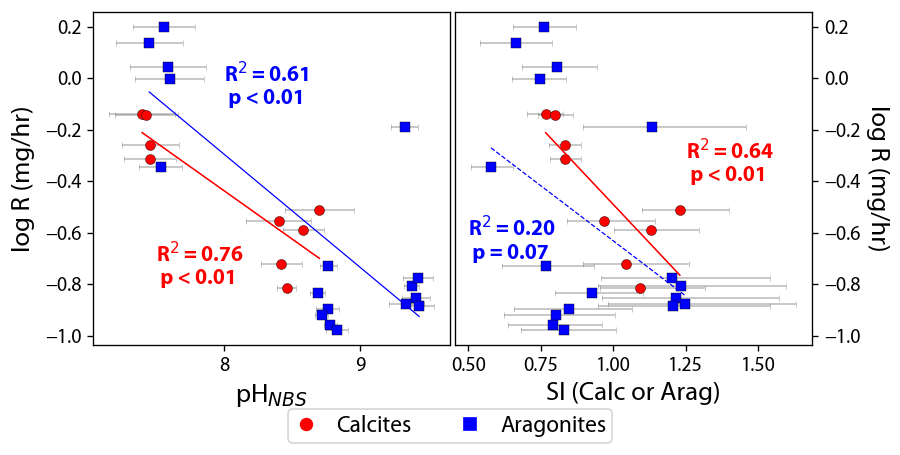

In [75]:
## plotting precipitation rate against pH and SI

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

#ax1.set_xlim(7.2,9)
#ax1.set_ylim(0,0.6)
#ax6.set_ylim(0,2000)
ax1.errorbar(df.pH[(df.Study=='us')&(df.Calc==True)], df.logR[(df.Study=='us')&(df.Calc==True)], 
            xerr= [df.pHerr[(df.Study=='us')&(df.Calc==True)],df.pHerr[(df.Study=='us')&(df.Calc==True)]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.errorbar(df.pH[(df.Study=='us')&(df.Calc==False)], df.logR[(df.Study=='us')&(df.Calc==False)], 
            xerr= [df.pHerr[(df.Study=='us')&(df.Calc==False)],df.pHerr[(df.Study=='us')&(df.Calc==False)]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(df.pH[(df.Study=='us')&(df.Calc==True)], df.logR[(df.Study=='us')&(df.Calc==True)])
X1=np.linspace(min(df.pH[(df.Study=='us')&(df.Calc==True)]),max(df.pH[(df.Study=='us')&(df.Calc==True)]),100)
ax1.plot(X1,X1*Cslope + Cintercept, color='red', linewidth=0.75)
if Cp_value<0.01:
    ax1.text(7.5,-0.8,'R$^2$ = %.2f \n p < 0.01' % Cr_value**2, color='red', fontsize=13,fontweight='bold')
    ax1.plot(X1,X1*Cslope + Cintercept, color='red', linewidth=0.75)
elif Cp_value>0.05:
    ax1.text(7.5,-0.8,'R$^2$ = %.2f \n p = %.2f' % (Cr_value**2, Cp_value), color='red', fontsize=13,fontweight='bold')
    ax1.plot(X1,X1*Cslope + Cintercept, color='red', linewidth=0.75, linestyle='--')
else:
    ax1.text(7.5,-0.8,'R$^2$ = %.2f \n p = %.2f' % (Cr_value**2, Cp_value), color='red', fontsize=13,fontweight='bold')
    ax1.plot(X1,X1*Cslope + Cintercept, color='red', linewidth=0.75)
Aslope, Aintercept, Ar_value, Ap_value, Astd_err = stats.linregress(df.pH[(df.Study=='us')&(df.Calc==False)], df.logR[(df.Study=='us')&(df.Calc==False)])
X1=np.linspace(min(df.pH[(df.Study=='us')&(df.Calc==False)]),max(df.pH[(df.Study=='us')&(df.Calc==False)]),100)
if Ap_value<0.01:
    ax1.plot(X1,X1*Aslope + Aintercept, color='blue', linewidth=0.75)
    ax1.text(8.0,-0.1,'R$^2$ = %.2f \n p < 0.01' % Ar_value**2, color='blue', fontsize=13,fontweight='bold')
elif Ap_value>0.05:
    ax1.text(8.0,-0.1,'R$^2$ = %.2f \n p = %.2f' % (Ar_value**2, Ap_value), color='blue', fontsize=13,fontweight='bold')
    ax1.plot(X1,X1*Aslope + Aintercept, color='blue', linewidth=0.75, linestyle='--')
else:
    ax1.text(8.0,-0.1,'R$^2$ = %.2f \n p = %.2f' % (Ar_value**2, Ap_value), color='blue', fontsize=13,fontweight='bold')
    ax1.plot(X1,X1*Aslope + Aintercept, color='blue', linewidth=0.75)    
ax1.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], df.logR[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax1.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], df.logR[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')


#ax2.set_ylim(0,0.14)
#ax2.set_xlim(7.2,9.7)
ax2.errorbar(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], df.logR[(df.Study=='us')&(df.Calc==True)],
            xerr=[highSICalcErr[(df.Study=='us')&(df.Calc==True)],lowSICalcErr[(df.Study=='us')&(df.Calc==True)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax2.errorbar(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], df.logR[(df.Study=='us')&(df.Calc==False)],
            xerr=[highSIAragErr[(df.Study=='us')&(df.Calc==False)],lowSIAragErr[(df.Study=='us')&(df.Calc==False)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], df.logR[(df.Study=='us')&(df.Calc==True)])
X1=np.linspace(min(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)]),max(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)]),100)
ax2.plot(X1,X1*Cslope + Cintercept, color='red', linewidth=0.75)
if Cp_value<0.01:
    ax2.text(1.25,-0.4,'R$^2$ = %.2f \n p < 0.01' % Cr_value**2, color='red', fontsize=13,fontweight='bold')
    ax2.plot(X1,X1*Cslope + Cintercept, color='red', linewidth=0.75)
elif Cp_value>0.05:
    ax2.text(1.25,-0.4,'R$^2$ = %.2f \n p = %.2f' % (Cr_value**2, Cp_value), color='red', fontsize=13,fontweight='bold')
    ax2.plot(X1,X1*Cslope + Cintercept, color='red', linewidth=0.75, linestyle='--')
else:
    ax2.text(1.25,-0.4,'R$^2$ = %.2f \n p = %.2f' % (Cr_value**2, Cp_value), color='red', fontsize=13,fontweight='bold')
    ax2.plot(X1,X1*Cslope + Cintercept, color='red', linewidth=0.75)
Aslope, Aintercept, Ar_value, Ap_value, Astd_err = stats.linregress(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], df.logR[(df.Study=='us')&(df.Calc==False)])
X1=np.linspace(min(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)]),max(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)]),100)
if Ap_value<0.01:
    ax2.plot(X1,X1*Aslope + Aintercept, color='blue', linewidth=0.75)
    ax2.text(0.5,-0.7,'R$^2$ = %.2f \n p < 0.01' % Ar_value**2, color='blue', fontsize=13,fontweight='bold')
elif Ap_value>0.05:
    ax2.text(0.5,-0.7,'R$^2$ = %.2f \n p = %.2f' % (Ar_value**2, Ap_value), color='blue', fontsize=13,fontweight='bold')
    ax2.plot(X1,X1*Aslope + Aintercept, color='blue', linewidth=0.75, linestyle='--')
else:
    ax2.text(0.5,-0.7,'R$^2$ = %.2f \n p = %.2f' % (Ar_value**2, Ap_value), color='blue', fontsize=13,fontweight='bold')
    ax2.plot(X1,X1*Aslope + Aintercept, color='blue', linewidth=0.75)    
ax2.scatter(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], df.logR[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax2.scatter(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], df.logR[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax1.set_ylabel('log R (mg/hr)', labelpad=6, fontsize=16)
ax2.set_ylabel('log R (mg/hr)', labelpad=17, fontsize=16, rotation=270)
ax1.set_xlabel('pH$_{NBS}$', labelpad=4, fontsize=16)
ax2.set_xlabel('SI (Calc or Arag)', labelpad=4, fontsize=16)

#ax1.text(7.25,0.55, 'Calcites', fontweight='semibold', color='black', fontsize=16)
#ax2.text(7.25,0.137, 'Aragonites', fontweight='semibold', color='black', fontsize=16)

red_circles = mlines.Line2D([], [], color='red', marker='o',
                          markersize=7, label='Calcites', lw=0.0)
blue_squares = mlines.Line2D([], [], color='blue', marker='s',
                          markersize=7, label='Aragonites', lw=0.0)
fig.legend(handles=[red_circles, blue_squares], loc="center",bbox_to_anchor=(0.5, 0.05), fontsize=14, labelspacing=0.15, frameon=True, ncol=2, borderpad=0.25, handlelength=1) #borderaxespad=-0.45, 

fig.tight_layout(pad=2.5, w_pad=0) 
fig.savefig('rate vs pHandSI2se.pdf')

'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


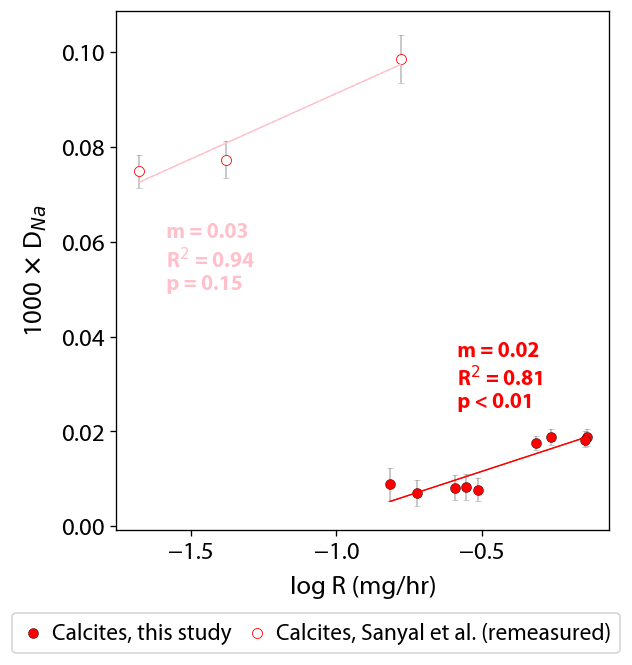

In [22]:
## Plotting Na/Ca and precipitation rate in our and Sanyal's data


fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

#ax1.set_xlim(7.2,9)
#ax1.set_ylim(0,0.6)
#ax6.set_ylim(0,2000)
ax1.errorbar(df.logR[(df.Study=='us')&(df.Calc==True)], MC_KDNa_median[(df.Study=='us')&(df.Calc==True)], 
             yerr= [lowKDNaErr[(df.Study=='us')&(df.Calc==True)],highKDNaErr[(df.Study=='us')&(df.Calc==True)]],
             fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.errorbar(df.logR[(df.Study=='Sanyal')], MC_KDNa_median[(df.Study=='Sanyal')], 
            yerr= [lowKDNaErr[(df.Study=='Sanyal')],highKDNaErr[(df.Study=='Sanyal')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(df.logR[(df.Study=='us')&(df.Calc==True)], MC_KDNa_median[(df.Study=='us')&(df.Calc==True)])
X1=np.linspace(min(df.logR[(df.Study=='us')&(df.Calc==True)]),max(df.logR[(df.Study=='us')&(df.Calc==True)]),100)
ax1.plot(X1,X1*Cslope + Cintercept, color='red', linewidth=0.75)
if Cp_value<0.01:
    ax1.text(-0.6,0.025,' m = %.2f \n R$^2$ = %.2f \n p < 0.01' % (Cslope,Cr_value**2), color='red', fontsize=13,fontweight='bold')
    ax1.plot(X1,X1*Cslope + Cintercept, color='red', linewidth=0.75)
elif Cp_value>0.05:
    ax1.text(-0.6,0.025,' m = %.2f \n R$^2$ = %.2f \n p = %.2f' % (Cslope,Cr_value**2, Cp_value), color='red', fontsize=13,fontweight='bold')
    ax1.plot(X1,X1*Cslope + Cintercept, color='red', linewidth=0.75, linestyle='--')
else:
    ax1.text(-0.6,0.025,' m = %.2f \n R$^2$ = %.2f \n p = %.2f' % (Cslope,Cr_value**2, Cp_value), color='red', fontsize=13,fontweight='bold')
    ax1.plot(X1,X1*Cslope + Cintercept, color='red', linewidth=0.75)
#Aslope, Aintercept, Ar_value, Ap_value, Astd_err = stats.linregress(df.logR[(df.Study=='us')&(df.Calc==False)], MC_KDNa_median[(df.Study=='us')&(df.Calc==False)])
#X1=np.linspace(min(df.logR[(df.Study=='us')&(df.Calc==False)]),max(df.logR[(df.Study=='us')&(df.Calc==False)]),100)
#ax1.plot(X1,X1*Aslope + Aintercept, color='blue', linewidth=0.75)
#if Ap_value<0.01:
##    #ax1.text(7.5,-0.8,'R$^2$ = %.2f \n p < 0.01' % Cr_value**2, color='red', fontsize=13,fontweight='bold')
#    ax1.plot(X1,X1*Aslope + Aintercept, color='blue', linewidth=0.75)
#elif Ap_value>0.05:
#    #ax1.text(7.5,-0.8,'R$^2$ = %.2f \n p = %.2f' % (Cr_value**2, Cp_value), color='red', fontsize=13,fontweight='bold')
#    ax1.plot(X1,X1*Aslope + Aintercept, color='blue', linewidth=0.75, linestyle='--')
#else:
    #ax1.text(7.5,-0.8,'R$^2$ = %.2f \n p = %.2f' % (Cr_value**2, Cp_value), color='red', fontsize=13,fontweight='bold')
#    ax1.plot(X1,X1*Aslope + Aintercept, color='blue', linewidth=0.75)
Sslope, Sintercept, Sr_value, Sp_value, Sstd_err = stats.linregress(df.logR[(df.Study=='Sanyal')&(df.Calc==True)], MC_KDNa_median[(df.Study=='Sanyal')&(df.Calc==True)])
X1=np.linspace(min(df.logR[(df.Study=='Sanyal')&(df.Calc==True)]),max(df.logR[(df.Study=='Sanyal')&(df.Calc==True)]),100)
ax1.plot(X1,X1*Sslope + Sintercept, color='pink', linewidth=0.75)
if Sp_value<0.01:
    ax1.text(-1.6,0.05,' m = %.2f \n R$^2$ = %.2f \n p < 0.01' % (Sslope,Sr_value**2), color='pink', fontsize=13,fontweight='bold')
    ax1.plot(X1,X1*Sslope + Sintercept, color='pink', linewidth=0.75)
elif Sp_value>0.05:
    ax1.text(-1.6,0.05,' m = %.2f \n R$^2$ = %.2f \n p = %.2f' % (Sslope,Sr_value**2, Sp_value), color='pink', fontsize=13,fontweight='bold')
    ax1.plot(X1,X1*Sslope + Sintercept, color='pink', linewidth=0.75, linestyle='--')
else:
    ax1.text(-1.6,0.05,' m = %.2f \n R$^2$ = %.2f \n p = %.2f' % (Sslope,Sr_value**2, Sp_value), color='pink', fontsize=13,fontweight='bold')
    ax1.plot(X1,X1*Sslope + Sintercept, color='pink', linewidth=0.75)
    
ax1.scatter(df.logR[(df.Study=='us')&(df.Calc==True)], MC_KDNa_median[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites, this study', marker='o')
ax1.scatter(df.logR[(df.Study=='Sanyal')&(df.Calc==True)], MC_KDNa_median[(df.Study=='Sanyal')&(df.Calc==True)], \
            color='red',linewidths=0.5, facecolors='white', label='Calcites, Sanyal et al. (remeasured)', marker='o')
#ax1.scatter(df.logR[(df.Study=='us')&(df.Calc==False)], MC_KDNa_median[(df.Study=='us')&(df.Calc==False)], \
#            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')  
ax1.tick_params(labelsize=15)

ax1.set_xlabel('log R (mg/hr)', labelpad=7, fontsize=16)
ax1.set_ylabel(r'1000 $\times$ D$_{Na}$', labelpad=7, fontsize=16)


handles,labels=ax1.get_legend_handles_labels()
fig.legend(handles,labels, loc="lower center", fontsize=14, labelspacing=0.15, frameon=True, borderaxespad=0.5, ncol=3, columnspacing=0.6,handlelength=1,handletextpad=0.3)


#plt.adjust(left=0.1,bottom=0.75, right=0.11) ## makes some empty space for the legend
#fig.tight_layout() 
plt.tight_layout(pad=4,h_pad=1) #,rect=(0,0.05,1,1)

#fig.savefig('TEs vs carbsys_KDCations.pdf',bbox_inches="tight")
fig.savefig('KDNavslogR_wSanyal2se.pdf',bbox_inches="tight")

In [ ]:
# Plotting LamdaMg against pH on linear scale. 

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

ax1.set_xlim(7.2,9)
ax1.set_ylim(0,0.6)
#ax6.set_ylim(0,2000)
ax1.errorbar(df.pH[(df.Study=='us')&(df.Calc==True)], MClambdaMg_median[(df.Study=='us')&(df.Calc==True)], 
            yerr= [lowlambdaMgErr[(df.Study=='us')&(df.Calc==True)],highlambdaMgErr[(df.Study=='us')&(df.Calc==True)]],
            xerr= [df.pHerr[(df.Study=='us')&(df.Calc==True)],df.pHerr[(df.Study=='us')&(df.Calc==True)]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(df.pH[(df.Study=='us')&(df.Calc==True)], MClambdaMg_median[(df.Study=='us')&(df.Calc==True)])
X1=np.linspace(min(df.pH[(df.Study=='us')&(df.Calc==True)]),max(df.pH[(df.Study=='us')&(df.Calc==True)]),100)
#ax1.plot(X1,X1*Cslope + Cintercept, color='red', linewidth=0.75)
#ax1.text(8.0,0.1,'R$^2$ = %.2f' % Cr_value**2, color='red', fontsize=13,fontweight='bold')
ax1.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], MClambdaMg_median[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')

#ax2.set_ylim(0,0.14)
ax2.set_xlim(7.2,9.7)
ax2.errorbar(df.pH[(df.Study=='us')&(df.Calc==False)], MClambdaMg_median[(df.Study=='us')&(df.Calc==False)], 
            yerr= [lowlambdaMgErr[(df.Study=='us')&(df.Calc==False)],highlambdaMgErr[(df.Study=='us')&(df.Calc==False)]],
            xerr= [df.pHerr[(df.Study=='us')&(df.Calc==False)],df.pHerr[(df.Study=='us')&(df.Calc==False)]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
Aslope, Aintercept, Ar_value, Ap_value, Astd_err = stats.linregress(df.pH[(df.Study=='us')&(df.Calc==False)], MClambdaMg_median[(df.Study=='us')&(df.Calc==False)])
X1=np.linspace(min(df.pH[(df.Study=='us')&(df.Calc==False)]),max(df.pH[(df.Study=='us')&(df.Calc==False)]),100)
#ax2.plot(X1,X1*Aslope + Aintercept, color='blue', linewidth=0.75)
ax2.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], MClambdaMg_median[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

def func(t, a, b, alpha):
    return a*np.exp(alpha * t) + b
    
t=np.array(df.pH[(df.Study=='us')&(df.Calc==False)])
v=np.array(MClambdaMg_median[(df.Study=='us')&(df.Calc==False)])
# initial guess for curve fit coefficients
a0 = 0
b0 = 0
alpha0 = 2
# coefficients and curve fit for curve(a0, b0, alpha0)
popt4, pcov4 = curve_fit(func, t, v, p0=(a0, b0, alpha0), maxfev=1000000)
a, b, alpha = popt4
v_fit = func(t, a, b, alpha)
ss_res = np.sum((v - v_fit) ** 2)       # residual sum of squares
ss_tot = np.sum((v - np.mean(v)) ** 2)  # total sum of squares
r2 = 1 - (ss_res / ss_tot)              # R squared fit, R^2
testx=np.arange(7.4,9.6,0.1)
testy=a*np.exp(alpha*testx)+b
ax2.plot(testx, testy, color='blue', linewidth=0.75, zorder=-2)
ax2.text(7.95,0.025,'R$^2$ = %.2f' % r2, color='blue', fontsize=13,fontweight='bold')

o=np.array(df.pH[(df.Study=='us')&(df.Calc==True)])
d=np.array(MClambdaMg_median[(df.Study=='us')&(df.Calc==True)])
# initial guess for curve fit coefficients
a0 = 0
b0 = 0
alpha0 = 2
# coefficients and curve fit for curve(a0, b0, alpha0)
popt4, pcov4 = curve_fit(func, o, d, p0=(a0, b0, alpha0), maxfev=1000000)
a, b, alpha = popt4
d_fit = func(o, a, b, alpha)
ss_res = np.sum((d - d_fit) ** 2)       # residual sum of squares
ss_tot = np.sum((d - np.mean(d)) ** 2)  # total sum of squares
r2 = 1 - (ss_res / ss_tot)              # R squared fit, R^2
testx=np.arange(7.4,8.9,0.1)
testy=a*np.exp(alpha*testx)+b
ax1.plot(testx, testy, color='red', linewidth=0.75, zorder=-2)
ax1.text(7.6,0.25,'R$^2$ = %.2f' % r2, color='red', fontsize=13,fontweight='bold')
ax1.set_ylabel('$\lambda$$_{Mg}$', labelpad=7, fontsize=16)
ax2.set_ylabel('$\lambda$$_{Mg}$', labelpad=7, fontsize=16)
ax1.set_xlabel('pH$_{NBS}$', labelpad=7, fontsize=16)
ax2.set_xlabel('pH$_{NBS}$', labelpad=7, fontsize=16)

ax1.text(7.25,0.55, 'Calcites', fontweight='semibold', color='black', fontsize=16)
ax2.text(7.25,0.137, 'Aragonites', fontweight='semibold', color='black', fontsize=16)

fig.tight_layout() 
fig.savefig('lambdaMg vs pH.pdf')

'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Semibold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


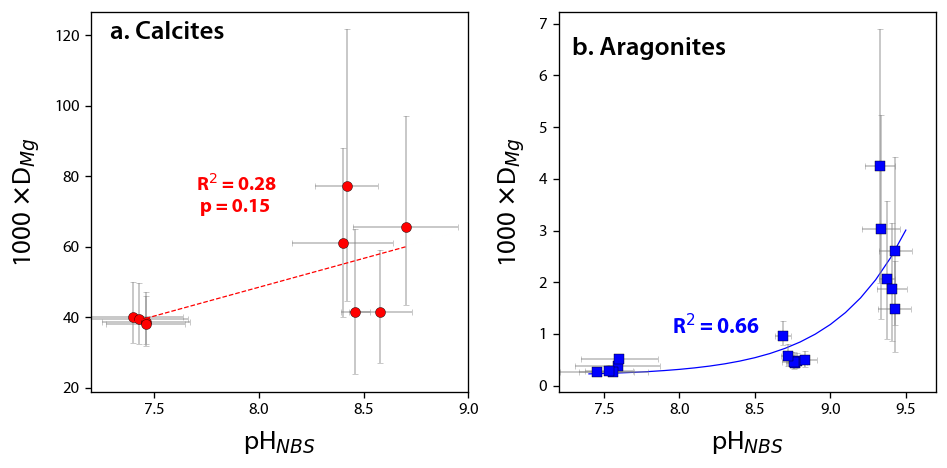

In [125]:
# Plotting KDMg against pH on linear scale. 

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

ax1.set_xlim(7.2,9)
#ax1.set_ylim(0,0.6)
#ax6.set_ylim(0,2000)
ax1.errorbar(df.pH[(df.Study=='us')&(df.Calc==True)], MC_KDMg_median[(df.Study=='us')&(df.Calc==True)], 
            yerr= [lowKDMgErr[(df.Study=='us')&(df.Calc==True)],highKDMgErr[(df.Study=='us')&(df.Calc==True)]],
            xerr= [df.pHerr[(df.Study=='us')&(df.Calc==True)],df.pHerr[(df.Study=='us')&(df.Calc==True)]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')


temp=MCregressStats(MC_pHNBS,MC_KDMg,'us',True,reps)
X1=np.linspace(min(df.pH[(df.Study=='us')&(df.Calc==True)]),max(df.pH[(df.Study=='us')&(df.Calc==True)]),100)

if temp[3]<0.01:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75)
    ax1.text(7.7,70,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=12,fontweight='bold')
elif temp[3]>0.05:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75, linestyle='--')
    ax1.text(7.7,70,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='red', fontsize=12,fontweight='bold')
else:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75)
    ax1.text(7.7,70,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2, temp[3]), color='red', fontsize=12,fontweight='bold')

ax1.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], MC_KDMg_median[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')

#ax2.set_ylim(0,0.14)
ax2.set_xlim(7.2,9.7)
ax2.errorbar(df.pH[(df.Study=='us')&(df.Calc==False)], MC_KDMg_median[(df.Study=='us')&(df.Calc==False)], 
            yerr= [lowKDMgErr[(df.Study=='us')&(df.Calc==False)],highKDMgErr[(df.Study=='us')&(df.Calc==False)]],
            xerr= [df.pHerr[(df.Study=='us')&(df.Calc==False)],df.pHerr[(df.Study=='us')&(df.Calc==False)]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
Aslope, Aintercept, Ar_value, Ap_value, Astd_err = stats.linregress(df.pH[(df.Study=='us')&(df.Calc==False)], MC_KDMg_median[(df.Study=='us')&(df.Calc==False)])
X1=np.linspace(min(df.pH[(df.Study=='us')&(df.Calc==False)]),max(df.pH[(df.Study=='us')&(df.Calc==False)]),100)
#ax2.plot(X1,X1*Aslope + Aintercept, color='blue', linewidth=0.75)
ax2.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], MC_KDMg_median[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

def func(t, a, b, alpha):
    return a*np.exp(alpha * t) + b
    
t=np.array(df.pH[(df.Study=='us')&(df.Calc==False)])
v=np.array(MC_KDMg_median[(df.Study=='us')&(df.Calc==False)])
# initial guess for curve fit coefficients
a0 = 0
b0 = 0
alpha0 = 2
# coefficients and curve fit for curve(a0, b0, alpha0)
popt4, pcov4 = curve_fit(func, t, v, p0=(a0, b0, alpha0), maxfev=1000000)
a, b, alpha = popt4
v_fit = func(t, a, b, alpha)
ss_res = np.sum((v - v_fit) ** 2)       # residual sum of squares
ss_tot = np.sum((v - np.mean(v)) ** 2)  # total sum of squares
r2 = 1 - (ss_res / ss_tot)              # R squared fit, R^2
testx=np.arange(7.4,9.6,0.1)
testy=a*np.exp(alpha*testx)+b
ax2.plot(testx, testy, color='blue', linewidth=0.75, zorder=-2)
ax2.text(7.95,1,'R$^2$ = %.2f' % r2, color='blue', fontsize=13,fontweight='bold')

ax1.set_ylabel(r'1000 $\times$D$_{Mg}$', labelpad=7, fontsize=16)
ax2.set_ylabel(r'1000 $\times$D$_{Mg}$', labelpad=7, fontsize=16)
ax1.set_xlabel('pH$_{NBS}$', labelpad=7, fontsize=16)
ax2.set_xlabel('pH$_{NBS}$', labelpad=7, fontsize=16)

ax1.text(7.29,119, 'a. Calcites', fontweight='semibold', color='black', fontsize=16)
ax2.text(7.29,6.4, 'b. Aragonites', fontweight='semibold', color='black', fontsize=16)

fig.tight_layout() 
fig.savefig('DMg vs pH2se.pdf')



'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Semibold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


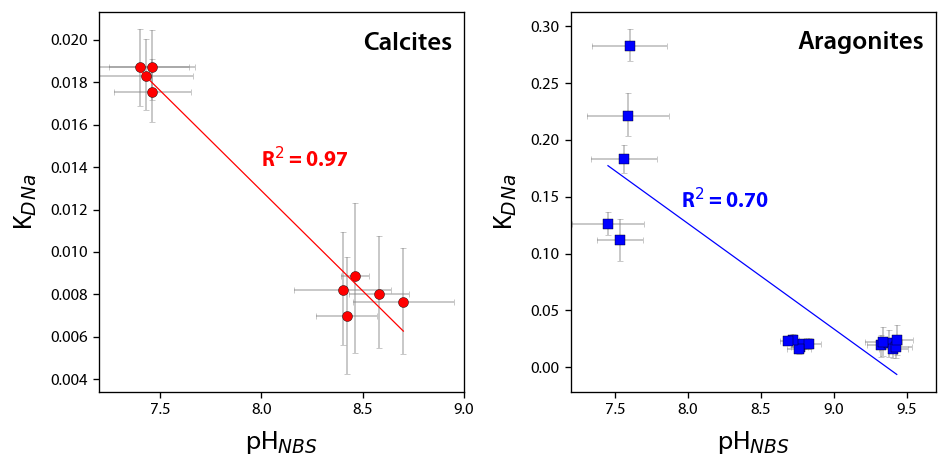

In [24]:
# Plotting KDNa against pH on linear scale. 

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

ax1.set_xlim(7.2,9)
#ax1.set_ylim(0,0.6)
#ax6.set_ylim(0,2000)
ax1.errorbar(df.pH[(df.Study=='us')&(df.Calc==True)], MC_KDNa_median[(df.Study=='us')&(df.Calc==True)], 
            yerr= [lowKDNaErr[(df.Study=='us')&(df.Calc==True)],highKDNaErr[(df.Study=='us')&(df.Calc==True)]],
            xerr= [df.pHerr[(df.Study=='us')&(df.Calc==True)],df.pHerr[(df.Study=='us')&(df.Calc==True)]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(df.pH[(df.Study=='us')&(df.Calc==True)], MC_KDNa_median[(df.Study=='us')&(df.Calc==True)])
X1=np.linspace(min(df.pH[(df.Study=='us')&(df.Calc==True)]),max(df.pH[(df.Study=='us')&(df.Calc==True)]),100)
ax1.plot(X1,X1*Cslope + Cintercept, color='red', linewidth=0.75)
ax1.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], MC_KDNa_median[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax1.text(8,0.014,'R$^2$ = %.2f' % Cr_value**2, color='red', fontsize=13,fontweight='bold')

#ax2.set_ylim(0,0.14)
ax2.set_xlim(7.2,9.7)
ax2.errorbar(df.pH[(df.Study=='us')&(df.Calc==False)], MC_KDNa_median[(df.Study=='us')&(df.Calc==False)], 
            yerr= [lowKDNaErr[(df.Study=='us')&(df.Calc==False)],highKDNaErr[(df.Study=='us')&(df.Calc==False)]],
            xerr= [df.pHerr[(df.Study=='us')&(df.Calc==False)],df.pHerr[(df.Study=='us')&(df.Calc==False)]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
Aslope, Aintercept, Ar_value, Ap_value, Astd_err = stats.linregress(df.pH[(df.Study=='us')&(df.Calc==False)], MC_KDNa_median[(df.Study=='us')&(df.Calc==False)])
X1=np.linspace(min(df.pH[(df.Study=='us')&(df.Calc==False)]),max(df.pH[(df.Study=='us')&(df.Calc==False)]),100)
ax2.plot(X1,X1*Aslope + Aintercept, color='blue', linewidth=0.75)
ax2.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], MC_KDNa_median[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax2.text(7.95,0.14,'R$^2$ = %.2f' % Ar_value**2, color='blue', fontsize=13,fontweight='bold')

def func(t, a, b, alpha):
    return a*np.exp(alpha * t) + b
    
t=np.array(df.pH[(df.Study=='us')&(df.Calc==False)])
v=np.array(MC_KDNa_median[(df.Study=='us')&(df.Calc==False)])
# initial guess for curve fit coefficients
a0 = 0
b0 = 0
alpha0 = 2
# coefficients and curve fit for curve(a0, b0, alpha0)
popt4, pcov4 = curve_fit(func, t, v, p0=(a0, b0, alpha0), maxfev=1000000)
a, b, alpha = popt4
v_fit = func(t, a, b, alpha)
ss_res = np.sum((v - v_fit) ** 2)       # residual sum of squares
ss_tot = np.sum((v - np.mean(v)) ** 2)  # total sum of squares
r2 = 1 - (ss_res / ss_tot)              # R squared fit, R^2
testx=np.arange(7.4,9.6,0.1)
testy=a*np.exp(alpha*testx)+b
#ax2.plot(testx, testy, color='blue', linewidth=0.75, zorder=-2)
#ax2.text(7.95,0.14,'R$^2$ = %.2f' % r2, color='blue', fontsize=13,fontweight='bold')

o=np.array(df.pH[(df.Study=='us')&(df.Calc==True)])
d=np.array(MC_KDNa_median[(df.Study=='us')&(df.Calc==True)])
# initial guess for curve fit coefficients
a0 = 0
b0 = 0
alpha0 = 2
# coefficients and curve fit for curve(a0, b0, alpha0)
popt4, pcov4 = curve_fit(func, o, d, p0=(a0, b0, alpha0), maxfev=1000000)
a, b, alpha = popt4
d_fit = func(o, a, b, alpha)
ss_res = np.sum((d - d_fit) ** 2)       # residual sum of squares
ss_tot = np.sum((d - np.mean(d)) ** 2)  # total sum of squares
r2 = 1 - (ss_res / ss_tot)              # R squared fit, R^2
testx=np.arange(7.4,8.9,0.1)
testy=a*np.exp(alpha*testx)+b
#ax1.plot(testx, testy, color='red', linewidth=0.75, zorder=-2)
#ax1.text(7.6,0.014,'R$^2$ = %.2f' % r2, color='red', fontsize=13,fontweight='bold')
ax1.set_ylabel('K$_{D}$$_{Na}$', labelpad=7, fontsize=16)
ax2.set_ylabel('K$_{D}$$_{Na}$', labelpad=7, fontsize=16)
ax1.set_xlabel('pH$_{NBS}$', labelpad=7, fontsize=16)
ax2.set_xlabel('pH$_{NBS}$', labelpad=7, fontsize=16)

ax1.text(8.5,0.0195, 'Calcites', fontweight='semibold', color='black', fontsize=16)
ax2.text(8.75,0.28, 'Aragonites', fontweight='semibold', color='black', fontsize=16)

fig.tight_layout() 
fig.savefig('KDNa vs pH2se.pdf')

In [ ]:
# Plotting Lambdas against each other.. 

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

#ax1.set_xlim(7.2,9)
#ax1.set_ylim(0,0.6)
#ax6.set_ylim(0,2000)
ax1.errorbar(MClambdaNa_median[(df.Study=='us')&(df.Calc==True)], MClambdaMg_median[(df.Study=='us')&(df.Calc==True)], 
            yerr= [lowlambdaMgErr[(df.Study=='us')&(df.Calc==True)],highlambdaMgErr[(df.Study=='us')&(df.Calc==True)]],
            xerr= [lowlambdaNaErr[(df.Study=='us')&(df.Calc==True)],highlambdaNaErr[(df.Study=='us')&(df.Calc==True)]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(MClambdaNa_median[(df.Study=='us')&(df.Calc==True)], MClambdaMg_median[(df.Study=='us')&(df.Calc==True)])
X1=np.linspace(min(MClambdaNa_median[(df.Study=='us')&(df.Calc==True)]),max(MClambdaNa_median[(df.Study=='us')&(df.Calc==True)]),100)
#ax1.plot(X1,X1*Cslope + Cintercept, color='red', linewidth=0.75)
#ax1.text(8.0,0.1,'R$^2$ = %.2f' % Cr_value**2, color='red', fontsize=13,fontweight='bold')
ax1.scatter(MClambdaNa_median[(df.Study=='us')&(df.Calc==True)], MClambdaMg_median[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')

#ax2.set_ylim(0,0.14)
#ax2.set_xlim(7.2,9.7)
ax2.errorbar(MClambdaNa_median[(df.Study=='us')&(df.Calc==False)], MClambdaMg_median[(df.Study=='us')&(df.Calc==False)], 
            yerr= [lowlambdaMgErr[(df.Study=='us')&(df.Calc==False)],highlambdaMgErr[(df.Study=='us')&(df.Calc==False)]],
            xerr= [lowlambdaNaErr[(df.Study=='us')&(df.Calc==False)],highlambdaNaErr[(df.Study=='us')&(df.Calc==False)]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
Aslope, Aintercept, Ar_value, Ap_value, Astd_err = stats.linregress(MClambdaNa_median[(df.Study=='us')&(df.Calc==False)], MClambdaMg_median[(df.Study=='us')&(df.Calc==False)])
X1=np.linspace(min(MClambdaNa_median[(df.Study=='us')&(df.Calc==False)]),max(MClambdaNa_median[(df.Study=='us')&(df.Calc==False)]),100)
#ax2.plot(X1,X1*Aslope + Aintercept, color='blue', linewidth=0.75)
ax2.scatter(MClambdaNa_median[(df.Study=='us')&(df.Calc==False)], MClambdaMg_median[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

def func(t, a, b, alpha):
    return a*np.exp(alpha * t) + b
    
t=np.array(MClambdaNa_median[(df.Study=='us')&(df.Calc==False)])
v=np.array(MClambdaMg_median[(df.Study=='us')&(df.Calc==False)])
# initial guess for curve fit coefficients
a0 = 0
b0 = 0
alpha0 = 2
# coefficients and curve fit for curve(a0, b0, alpha0)
popt4, pcov4 = curve_fit(func, t, v, p0=(a0, b0, alpha0), maxfev=1000000)
a, b, alpha = popt4
v_fit = func(t, a, b, alpha)
ss_res = np.sum((v - v_fit) ** 2)       # residual sum of squares
ss_tot = np.sum((v - np.mean(v)) ** 2)  # total sum of squares
r2 = 1 - (ss_res / ss_tot)              # R squared fit, R^2
testx=np.arange(7.4,9.6,0.1)
testy=a*np.exp(alpha*testx)+b
ax2.plot(testx, testy, color='blue', linewidth=0.75, zorder=-2)
#ax2.text(7.95,0.025,'R$^2$ = %.2f' % r2, color='blue', fontsize=13,fontweight='bold')

o=np.array(MClambdaNa_median[(df.Study=='us')&(df.Calc==True)])
d=np.array(MClambdaMg_median[(df.Study=='us')&(df.Calc==True)])
# initial guess for curve fit coefficients
a0 = 0
b0 = 0
alpha0 = 2
# coefficients and curve fit for curve(a0, b0, alpha0)
popt4, pcov4 = curve_fit(func, o, d, p0=(a0, b0, alpha0), maxfev=1000000)
a, b, alpha = popt4
d_fit = func(o, a, b, alpha)
ss_res = np.sum((d - d_fit) ** 2)       # residual sum of squares
ss_tot = np.sum((d - np.mean(d)) ** 2)  # total sum of squares
r2 = 1 - (ss_res / ss_tot)              # R squared fit, R^2
#testx=np.arange(min(MClambdaNa_median[(df.Study=='us')&(df.Calc==False)]),max(MClambdaNa_median[(df.Study=='us')&(df.Calc==False)]),0.0000001)
#testy=a*np.exp(alpha*testx)+b
#ax1.plot(testx, testy, color='red', linewidth=0.75, zorder=-2)
#ax1.text(7.6,0.25,'R$^2$ = %.2f' % r2, color='red', fontsize=13,fontweight='bold')
ax1.set_ylabel('$\lambda$$_{Mg}$', labelpad=7, fontsize=16)
ax2.set_ylabel('$\lambda$$_{Mg}$', labelpad=7, fontsize=16)
ax1.set_xlabel('$\lambda$$_{Na}$', labelpad=7, fontsize=16)
ax2.set_xlabel('$\lambda$$_{Na}$', labelpad=7, fontsize=16)

#ax1.text(7.25,0.55, 'Calcites', fontweight='semibold', color='black', fontsize=16)
#ax2.text(7.25,0.137, 'Aragonites', fontweight='semibold', color='black', fontsize=16)

fig.tight_layout() 
fig.savefig('lambdaMg vs lambdaNa.pdf')

'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


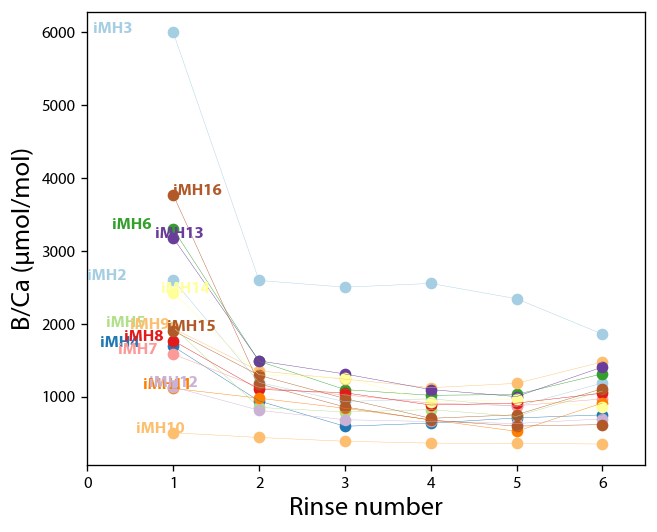

In [10]:
## To plot the figure with the rinses

import matplotlib.cm as cm
Brinses= pd.read_csv('inorganic_rinses.csv', header=0)
colors = cm.Paired(np.linspace(0, 1, len(Brinses['samplename'].unique())))
xoffs=np.linspace(0, 1, len(Brinses['samplename'].unique()))
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
ax1.set_xlim(0,5)
ax1.set_ylabel('B/Ca (µmol/mol)', fontsize=16)
ax1.set_xlabel('Rinse number', fontsize=16)
for item, c,x in zip(Brinses['samplename'].unique(), colors, xoffs):
    #offsetfact=np.random.randint(-100,100)
    xoffsetfact=np.random.uniform(0.01,0.25)
    temp=Brinses.loc[Brinses.samplename==item]
    ax1.scatter(Brinses.rinse[Brinses.samplename==item], Brinses.BCa[Brinses.samplename==item],color=c)
    ax1.plot(Brinses.rinse[Brinses.samplename==item], Brinses.BCa[Brinses.samplename==item], linewidth=0.25,color=c)
    ax1.text(x, Brinses.BCa[(Brinses.samplename==item)&(Brinses.rinse==1)].values[0],item,fontsize=10,fontweight='bold', color=c)

fig.savefig('rinses.pdf')



In [ ]:
# To plot the figure with Sanyal carbonate rinses

#import matplotlib.cm as cm
Brinses= pd.read_csv('Sanyal_inorganic_rinses.csv', header=0)
#colors = cm.Paired(np.linspace(0, 1, len(Brinses['samplename'].unique())))
colors=['maroon', 'lightskyblue', 'gold','maroon', 'lightskyblue', 'gold']
xoffs=np.linspace(0, 1, len(Brinses['samplename'].unique()))
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
ax1.set_xlim(0.5,3.5)
ax1.set_ylim(0,3500)
ax1.set_ylabel('B/Ca (µmol/mol)', fontsize=16)
ax1.set_xlabel('Rinse number', fontsize=16)
for item, c,x in zip(Brinses['samplename'].unique(), colors, xoffs):
    #offsetfact=np.random.randint(-100,100)
    xoffsetfact=np.random.uniform(0.01,0.25)
    temp=Brinses.loc[Brinses.samplename==item]
    ax1.scatter(Brinses.rinse[Brinses.samplename==item], Brinses.BCa[Brinses.samplename==item],color=c)
    ax1.plot(Brinses.rinse[Brinses.samplename==item], Brinses.BCa[Brinses.samplename==item], linewidth=1.5,color=c)

    
#ax1.text(x, Brinses.BCa[(Brinses.samplename==item)&(Brinses.rinse==1)].values[0],item,fontsize=10,fontweight='bold', color=c)
ax1.text(0.6,2500,'pH 8.3' % r2, color='lightskyblue', fontsize=13,fontweight='bold')
ax1.text(0.6,3100,'pH 8.6' % r2, color='gold', fontsize=13,fontweight='bold')
ax1.text(1.1,3250,'pH 7.9' % r2, color='maroon', fontsize=13,fontweight='bold')

ax1.text(0.6,450,'Measured Carbonate, pH 8.3' % r2, color='lightskyblue', fontsize=13,fontweight='bold', fontstyle='italic')
ax1.text(0.6,770,'Measured Carbonate, pH 8.6' % r2, color='gold', fontsize=13,fontweight='bold', fontstyle='italic')
ax1.text(0.6,100,'Measured Carbonate, pH 7.9' % r2, color='maroon', fontsize=13,fontweight='bold', fontstyle='italic')

fig.savefig('Sanyalrinses.pdf')



'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-It.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


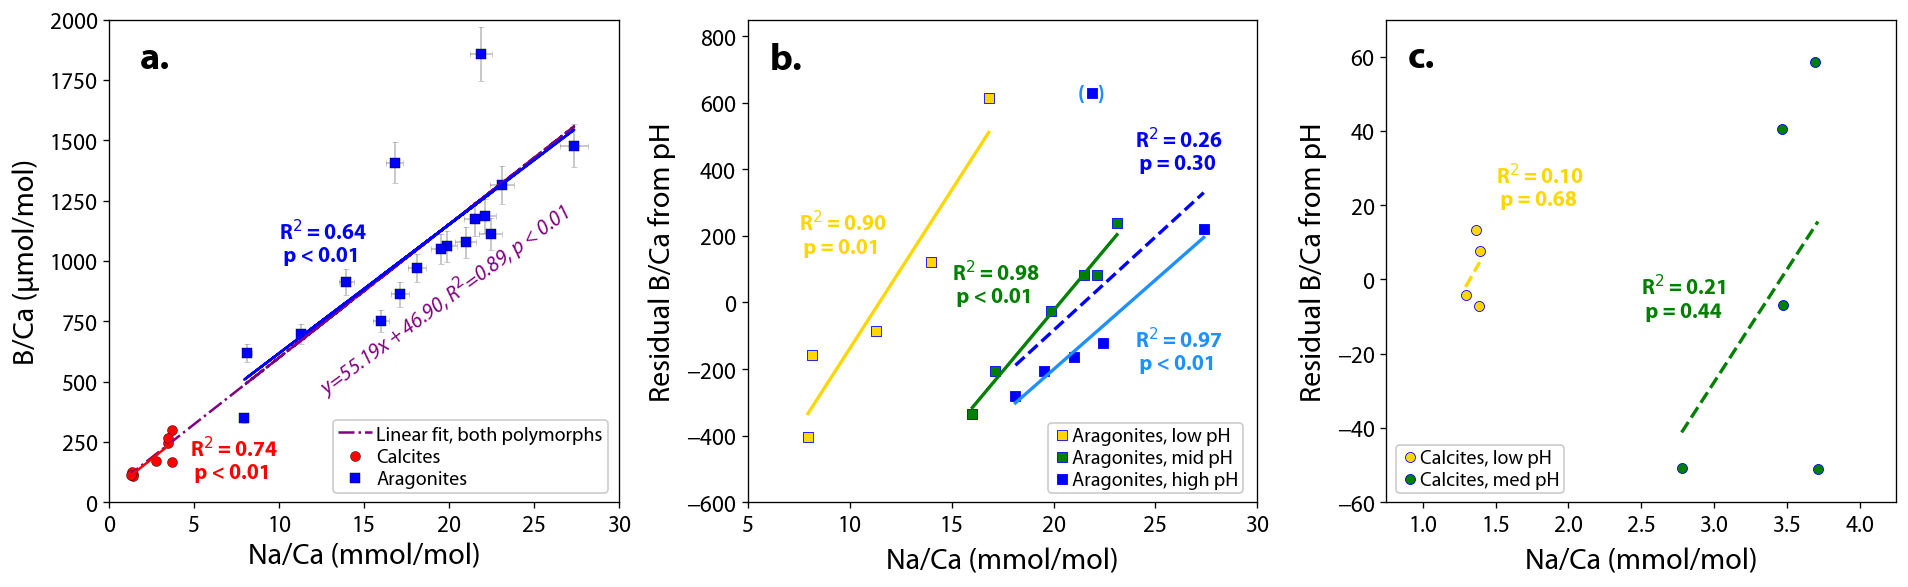

In [25]:
# Plotting B/Ca against Na/Ca to show the better agreement between the two. 

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

ax1.set_xlim(0,30)
ax1.set_ylim(0,2000)

ax2.set_xlim(5,30)
ax2.set_ylim(-500,800)
ax3.set_xlim(0.75,4.25)
ax3.set_ylim(-60,70)


AX = df.pH[(df.Study=='us')&(df.Calc==False)].values.reshape(-1, 1)  # values converts it into a numpy array
AY = df.BCa_umol[(df.Study=='us')&(df.Calc==False)].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(AX,AY)  # perform linear regression
AY_pred = linear_regressor.predict(AX)  # make predictions
#ax1.plot(AX, AY_pred, color='purple',linestyle='-.')
AregressionSlopeBCapH=float(linear_regressor.coef_)
AregressionInterceptBCapH=float(linear_regressor.intercept_)
pHresidualAragBCa=AY-AY_pred

CX = df.pH[(df.Study=='us')&(df.Calc==True)].values.reshape(-1, 1)  # values converts it into a numpy array
CY = df.BCa_umol[(df.Study=='us')&(df.Calc==True)].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(CX,CY)  # perform linear regression
CY_pred = linear_regressor.predict(CX)  # make predictions
#ax1.plot(CX, CY_pred, color='purple',linestyle='-.')
CregressionSlopeBCapH=float(linear_regressor.coef_)
CregressionInterceptBCapH=float(linear_regressor.intercept_)
pHresidualCalcBCa=CY-CY_pred
AresidualBCapHindexed=pd.Series(pHresidualAragBCa.flatten(),index=df.index[(df.Study=='us')&(df.Calc==False)])
CresidualBCapHindexed=pd.Series(pHresidualCalcBCa.flatten(),index=df.index[(df.Study=='us')&(df.Calc==True)])

#ax1.plot((0,30), (0,1500),linestyle='solid', c='black', linewidth=1, zorder=0)
ax1.scatter(df.NaCa_mmol[(df.CalcOrArag=='Calc')&(df.Study=='us')], df.BCa_umol[(df.CalcOrArag=='Calc')&(df.Study=='us')], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
#ax1.scatter(df.NaCa_mmol[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')], df.BCa_umol[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')], \
#            color='red',linewidths=0.5, facecolors='white', label='Calcites, Sanyal et al. (remeasured)', marker='o')
ax1.scatter(df.NaCa_mmol[(df.CalcOrArag=='Arag')&(df.Study=='us')], df.BCa_umol[(df.CalcOrArag=='Arag')&(df.Study=='us')], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax1.errorbar(df.NaCa_mmol[(df.Study=='us')], df.BCa_umol[(df.Study=='us')],
            xerr=[0.03*df.NaCa_mmol[(df.Study=='us')],0.03*df.NaCa_mmol[(df.Study=='us')]],
            yerr= [0.06*df.BCa_umol[(df.Study=='us')],0.06*df.BCa_umol[(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
##ax1.errorbar(df.NaCa_mmol[(df.Study=='Sanyal')], df.BCa_umol[(df.Study=='Sanyal')],
#            xerr=[0.03*df.NaCa_mmol[(df.Study=='Sanyal')],0.03*df.NaCa_mmol[(df.Study=='Sanyal')]],
#            yerr= [0.06*df.BCa_umol[(df.Study=='Sanyal')],0.06*df.BCa_umol[(df.Study=='Sanyal')]],
#            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
#ax1.xaxis.tick_top()
ax1.tick_params(labelsize=14)
#ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Na/Ca (mmol/mol)', fontsize=18)
ax1.set_ylabel('B/Ca (µmol/mol)', labelpad=6, fontsize=18)

#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )
#bbox_to_anchor=(1.51, 0.21)

X = df.NaCa_mmol[(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = df.BCa_umol[(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
ax1.plot(X, Y_pred, color='purple',linestyle='-.',label='Linear fit, both polymorphs')
regressionSlopeBCaNaCa=float(linear_regressor.coef_)
regressionIntercept=float(linear_regressor.intercept_)
residualBCa=Y-Y_pred

#X = df.NaCa_mmol[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')].values.reshape(-1, 1)  # values converts it into a numpy array
#Y = df.BCa_umol[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
#linear_regressor = LinearRegression()  # create object for the class
#linear_regressor.fit(X,Y)  # perform linear regression
#Y_pred = linear_regressor.predict(X)  # make predictions
#ax1.plot(X, Y_pred, color='pink')


X = df.NaCa_mmol[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = df.BCa_umol[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
ax1.plot(X, Y_pred, color='red')

X = df.NaCa_mmol[(df.CalcOrArag=='Arag')&(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = df.BCa_umol[(df.CalcOrArag=='Arag')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
ax1.plot(X, Y_pred, color='blue')

r2calc=stats.linregress(df.NaCa_mmol[(df.Study=='us')&(df.Calc==True)], df.BCa_umol[(df.Study=='us')&(df.Calc==True)]).rvalue**2
r2arag=stats.linregress(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)], df.BCa_umol[(df.Study=='us')&(df.Calc==False)]).rvalue**2
r2both=stats.linregress(df.NaCa_mmol[(df.Study=='us')], df.BCa_umol[(df.Study=='us')]).rvalue**2
pcalc=stats.linregress(df.NaCa_mmol[(df.Study=='us')&(df.Calc==True)], df.BCa_umol[(df.Study=='us')&(df.Calc==True)]).pvalue
parag=stats.linregress(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)], df.BCa_umol[(df.Study=='us')&(df.Calc==False)]).pvalue
pboth=stats.linregress(df.NaCa_mmol[(df.Study=='us')], df.BCa_umol[(df.Study=='us')]).pvalue
ax1.text(12, 450,'y={0:.2f}x + {1:0.2f}, R$^2$={2:0.2f}, p < 0.01'.format(regressionSlopeBCaNaCa,regressionIntercept,r2both),style='italic', color='purple', fontsize=13, rotation=36.3)

ax1.text(4.75, 100, 'R$^2$ = %.2f \n p < 0.01' % (r2calc), color='red', fontsize=13,fontweight='bold')
ax1.text(10, 1000, 'R$^2$ = %.2f \n p < 0.01' % (r2arag), color='blue', fontsize=13,fontweight='bold')

ax2.set_ylim(-600,850)

Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH<=8)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)&(df.pH<=8)])
X1=np.linspace(min(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH<=8)]),max(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH<=8)]),100)
ax2.plot(X1,X1*Cslope + Cintercept, color='gold', linewidth=2)
ax2.text(7.5,150,'R$^2$ = %.2f \n p = %.2f' % (Cr_value**2, Cp_value), color='gold', fontsize=13,fontweight='bold')
         
Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH>=8)&(df.pH<=9)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)&(df.pH>=8)&(df.pH<=9)])
X1=np.linspace(min(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH>=8)&(df.pH<=9)]),max(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH>=8)&(df.pH<=9)]),100)
ax2.plot(X1,X1*Cslope + Cintercept, color='green', linewidth=2)
ax2.text(15,0.8,'R$^2$ = %.2f \n p < 0.01' % (Cr_value**2), color='green', fontsize=13,fontweight='bold')

Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH>=9)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)&(df.pH>=9)])
X1=np.linspace(min(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH>=9)]),max(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH>=9)]),100)
ax2.plot(X1,X1*Cslope + Cintercept, color='blue', linewidth=2, linestyle='--')
ax2.text(24,400,'R$^2$ = %.2f \n p = %.2f' % (Cr_value**2, Cp_value), color='blue', fontsize=13,fontweight='bold')

highpHresids=AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)&(df.pH>=9)]
highpHNaCa=df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH>=9)]
Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(highpHNaCa[highpHresids<=500], highpHresids[highpHresids<=500])
X1=np.linspace(min(highpHNaCa[highpHresids<=500]),max(highpHNaCa[highpHresids<=500]),100)
ax2.plot(X1,X1*Cslope + Cintercept, color='dodgerblue', linewidth=2)
ax2.text(24,-200,'R$^2$ = %.2f \n p < 0.01' % (Cr_value**2), color='dodgerblue', label='high pH, excluding outlier', fontsize=13,fontweight='bold')
ax2.text(21.2,610,'(   )', color='dodgerblue', fontsize=13,fontweight='bold')

ax2.scatter(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH<=8)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)&(df.pH<=8)], \
            color='blue',linewidths=0.5, facecolors='gold', label='Aragonites, low pH', marker='s')
ax2.scatter(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH>=8)&(df.pH<=9)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)&(df.pH>=8)&(df.pH<=9)], \
            color='blue',linewidths=0.5, facecolors='green', label='Aragonites, mid pH', marker='s')
ax2.scatter(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH>=9)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)&(df.pH>=9)], \
            color='blue',linewidths=0.5, facecolors='blue', label='Aragonites, high pH', marker='s')
ax2.set_ylabel('Residual B/Ca from pH', labelpad=6, fontsize=18)
ax2.set_xlabel('Na/Ca (mmol/mol)', labelpad=7, fontsize=18)


Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(df.NaCa_mmol[(df.Study=='us')&(df.Calc==True)&(df.pH<=8)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)&(df.pH<=8)])
X1=np.linspace(min(df.NaCa_mmol[(df.Study=='us')&(df.Calc==True)&(df.pH<=8)]),max(df.NaCa_mmol[(df.Study=='us')&(df.Calc==True)&(df.pH<=8)]),100)
ax3.plot(X1,X1*Cslope + Cintercept, color='gold', linewidth=2, linestyle='--')
ax3.text(1.5,20,'R$^2$ = %.2f \n p = %.2f' % (Cr_value**2, Cp_value), color='gold', fontsize=13,fontweight='bold')
ax3.scatter(df.NaCa_mmol[(df.Study=='us')&(df.Calc==True)&(df.pH<=8)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)&(df.pH<=8)], \
            color='blue',linewidths=0.5, facecolors='gold', label='Calcites, low pH', marker='o')

Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(df.NaCa_mmol[(df.Study=='us')&(df.Calc==True)&(df.pH>=8)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)&(df.pH>=8)])
X1=np.linspace(min(df.NaCa_mmol[(df.Study=='us')&(df.Calc==True)&(df.pH>=8)]),max(df.NaCa_mmol[(df.Study=='us')&(df.Calc==True)&(df.pH>=8)]),100)
ax3.plot(X1,X1*Cslope + Cintercept, color='green', linewidth=2, linestyle='--')
ax3.text(2.5,-10,'R$^2$ = %.2f \n p = %.2f' % (Cr_value**2, Cp_value), color='green', fontsize=13,fontweight='bold')

ax3.scatter(df.NaCa_mmol[(df.Study=='us')&(df.Calc==True)&(df.pH>=8)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)&(df.pH>=8)], \
            color='blue',linewidths=0.5, facecolors='green', label='Calcites, med pH', marker='o')

ax3.set_ylabel('Residual B/Ca from pH', labelpad=6, fontsize=18)
ax3.set_xlabel('Na/Ca (mmol/mol)', labelpad=7, fontsize=18)

ax1.text(1.8,1800,'a.', fontsize=23,fontweight='bold')
ax2.text(6.1,700,'b.', fontsize=23,fontweight='bold')
ax3.text(0.9,57.2,'c.', fontsize=23,fontweight='bold')

ax1.legend(loc=(0.44,0.02), framealpha=1,fontsize=12, handlelength=1.7, handletextpad=0.2, borderpad=0.25, labelspacing=0.2)
ax2.legend(loc=(0.59,0.02), framealpha=1,fontsize=12, handlelength=1, handletextpad=0, borderpad=0.2, labelspacing=0.2)
ax3.legend(loc=(0.02,0.02), framealpha=1,fontsize=12, handlelength=1, handletextpad=0, borderpad=0.2, labelspacing=0.2)

ax2.tick_params(labelsize=14)
ax3.tick_params(labelsize=14)

#ax3.yaxis.set_label_position("right")
#ax3.yaxis.tick_right()


fig.tight_layout(w_pad=0) 
#fig.savefig('BCa vs NaCa with resids.pdf')
fig.savefig('BCa vs NaCa with residsandSanyal2se.pdf')

/Users/mjh1c09/MichaelEnv/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Semibold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


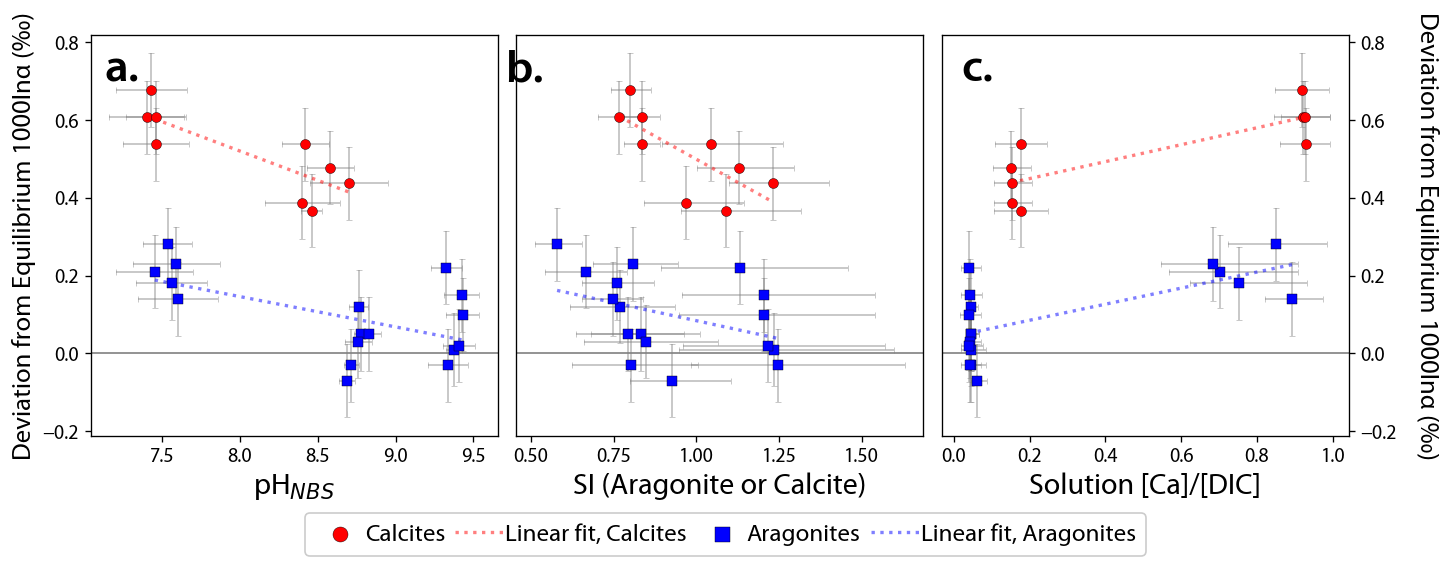

In [26]:
## Plotting offset in oxygen isotope equilibrium against solution variables. 

OxygenOffset=pd.Series(index=df.index)
for row in df.index:
    if df.CalcOrArag[row]=='Calc' and df.Study[row]=='us':
        OxygenOffset[row]=df.OxyFract[row]-(18.03*((10**3)/298.15)-32.42) ## From Kim and O'Neil 1997
    elif df.CalcOrArag[row]=='Arag' and df.Study[row]=='us':
        #OxygenOffset[row]=df.OxyFract[row]-(17.88*((10**3)/298.15)-31.14) ## From  Kim et al 2007
        OxygenOffset[row]=df.OxyFract[row]-(28.87) ## From  Kim et al 2014
    else:
        pass

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(13,5))  
ax1.axhline(y=0, color='gray', zorder=-1,linewidth=1)
ax2.axhline(y=0, color='gray', zorder=-1,linewidth=1)
ax3.axhline(y=0, color='gray', zorder=-1,linewidth=1)

ax1.errorbar(df.pH[(df.Study=='us')], OxygenOffset[(df.Study=='us')], 
            yerr=0.094,xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.scatter(df.pH[(df.CalcOrArag=='Calc')&(df.Study=='us')],OxygenOffset[(df.CalcOrArag=='Calc')&(df.Study=='us')], color='black',label='Calcites', facecolors='red', marker='o', linewidths=0.25, zorder=5)

X = df.pH[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = OxygenOffset[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
X1=np.linspace(min(X),max(X),10)
Y_pred = linear_regressor.predict(X1)  # make predictions
ax1.plot(X1, Y_pred, color='red', linestyle=':',linewidth=2,zorder=1,alpha=0.5,label='Linear fit, Calcites')

ax1.scatter(df.pH[(df.CalcOrArag=='Arag')&(df.Study=='us')],OxygenOffset[(df.CalcOrArag=='Arag')&(df.Study=='us')], color='black',label='Aragonites', facecolors='blue', marker='s', linewidths=0.25, zorder=4)

X = df.pH[(df.CalcOrArag=='Arag')&(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = OxygenOffset[(df.CalcOrArag=='Arag')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y) # perform linear regression
X1=np.linspace(min(X),max(X),10)
Y_pred = linear_regressor.predict(X1)  # make predictions
ax1.plot(X1, Y_pred, color='blue', linestyle=':',linewidth=2,zorder=2,alpha=0.5,label='Linear fit, Aragonites')





X = MC_SICalc_median[(df.Study=='us')&(df.Calc==True)].values.reshape(-1, 1)  # values converts it into a numpy array
Y = OxygenOffset[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
X1=np.linspace(min(X),max(X),10)
Y_pred = linear_regressor.predict(X1)  # make predictions
ax2.plot(X1, Y_pred, color='red', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Calcites')

X = MC_SIArag_median[(df.Study=='us')&(df.Calc==False)].values.reshape(-1, 1)  # values converts it into a numpy array
Y = OxygenOffset[(df.CalcOrArag=='Arag')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y) # perform linear regression
X1=np.linspace(min(X),max(X),10)
Y_pred = linear_regressor.predict(X1)  # make predictions
ax2.plot(X1, Y_pred, color='blue', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Aragonites')

ax2.errorbar(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], OxygenOffset[(df.Study=='us')&(df.Calc==True)], 
            yerr=0.094,xerr=[highSICalcErr[(df.Study=='us')&(df.Calc==True)],lowSICalcErr[(df.Study=='us')&(df.Calc==True)]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax2.errorbar(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], OxygenOffset[(df.Study=='us')&(df.Calc==False)], 
            yerr=0.094,xerr=[highSIAragErr[(df.Study=='us')&(df.Calc==False)],lowSIAragErr[(df.Study=='us')&(df.Calc==False)]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax2.scatter(MC_SICalc_median[(df.CalcOrArag=='Calc')&(df.Study=='us')],OxygenOffset[(df.CalcOrArag=='Calc')&(df.Study=='us')], color='black',label='Calcites', facecolors='red', marker='o', linewidths=0.25)
ax2.scatter(MC_SIArag_median[(df.CalcOrArag=='Arag')&(df.Study=='us')],OxygenOffset[(df.CalcOrArag=='Arag')&(df.Study=='us')], color='black',label='Aragonites', facecolors='blue', marker='s', linewidths=0.25)

#MCcarbion_median


X = (MC_CaDIC_median[(df.CalcOrArag=='Calc')&(df.Study=='us')]).values.reshape(-1, 1)  # values converts it into a numpy array
Y = OxygenOffset[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
X1=np.linspace(min(X),max(X),10)
Y_pred = linear_regressor.predict(X1)  # make predictions
ax3.plot(X1, Y_pred, color='red', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Calcites')

X = (MC_CaDIC_median[(df.CalcOrArag=='Arag')&(df.Study=='us')]).values.reshape(-1, 1)  # values converts it into a numpy array
Y = OxygenOffset[(df.CalcOrArag=='Arag')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y) # perform linear regression
X1=np.linspace(min(X),max(X),10)
Y_pred = linear_regressor.predict(X1)  # make predictions
ax3.plot(X1, Y_pred, color='blue', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Aragonites')

#CaDICerr=abs((df.Ave_CamMol[(df.Study=='us')]/1000*MCcarbion_median[(df.Study=='us')])-(df.Start_CamMol[(df.Study=='us')]/1000*MCcarbion_median[(df.Study=='us')]))

ax3.errorbar(MC_CaDIC_median[(df.Study=='us')], OxygenOffset[(df.Study=='us')], 
            yerr=0.094,xerr=[MC_CaDIC_median[(df.Study=='us')]-MC_CaDIC_low95[(df.Study=='us')],MC_CaDIC_up95[(df.Study=='us')]-MC_CaDIC_median[(df.Study=='us')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax3.scatter(MC_CaDIC_median[(df.CalcOrArag=='Calc')&(df.Study=='us')],OxygenOffset[(df.CalcOrArag=='Calc')&(df.Study=='us')], color='black',label='Calcites', facecolors='red', marker='o', linewidths=0.25)
ax3.scatter(MC_CaDIC_median[(df.CalcOrArag=='Arag')&(df.Study=='us')],OxygenOffset[(df.CalcOrArag=='Arag')&(df.Study=='us')], color='black',label='Aragonites', facecolors='blue', marker='s', linewidths=0.25)



#X = (df.Ave_CamMol[(df.CalcOrArag=='Calc')&(df.Study=='us')]/df.Ave_DICmMol[(df.CalcOrArag=='Calc')&(df.Study=='us')]).values.reshape(-1, 1)  # values converts it into a numpy array
#Y = OxygenOffset[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
#linear_regressor = LinearRegression()  # create object for the class
#linear_regressor.fit(X,Y)  # perform linear regression
#X1=np.linspace(min(X),max(X),10)
#Y_pred = linear_regressor.predict(X1)  # make predictions
#ax3.plot(X1, Y_pred, color='red', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Calcites')#

#X = (df.Ave_CamMol[(df.CalcOrArag=='Arag')&(df.Study=='us')]/df.Ave_DICmMol[(df.CalcOrArag=='Arag')&(df.Study=='us')]).values.reshape(-1, 1)  # values converts it into a numpy array
#Y = OxygenOffset[(df.CalcOrArag=='Arag')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
#linear_regressor = LinearRegression()  # create object for the class
#linear_regressor.fit(X,Y) # perform linear regression
#X1=np.linspace(min(X),max(X),10)
#Y_pred = linear_regressor.predict(X1)  # make predictions
#ax3.plot(X1, Y_pred, color='blue', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Aragonites')

#CaDICerr=abs((df.Ave_CamMol[(df.Study=='us')]/df.Ave_DICmMol[(df.Study=='us')])-(df.Start_CamMol[(df.Study=='us')]/df.Start_DICmMol[(df.Study=='us')]))
#
#ax3.errorbar(df.Ave_CamMol[(df.Study=='us')]/df.Ave_DICmMol[(df.Study=='us')], OxygenOffset[(df.Study=='us')], 
#            yerr=0.2,xerr=[CaDICerr,CaDICerr],
#              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
#ax3.scatter(df.Ave_CamMol[(df.CalcOrArag=='Calc')&(df.Study=='us')]/df.Ave_DICmMol[(df.CalcOrArag=='Calc')&(df.Study=='us')],OxygenOffset[(df.CalcOrArag=='Calc')&(df.Study=='us')], color='black',label='Calcites', facecolors='red', marker='o', linewidths=0.25)
#ax3.scatter(df.Ave_CamMol[(df.CalcOrArag=='Arag')&(df.Study=='us')]/df.Ave_DICmMol[(df.CalcOrArag=='Arag')&(df.Study=='us')],OxygenOffset[(df.CalcOrArag=='Arag')&(df.Study=='us')], color='black',label='Aragonites', facecolors='blue', marker='s', linewidths=0.25)

#ax1.legend(loc=(0.58,0.77), framealpha=1,fontsize=10)

ax1.text(7.13, 0.7, 'a.', color='black', fontsize=28,fontweight='semibold')
ax2.text(0.42, 0.7, 'b.', color='black', fontsize=28,fontweight='semibold')
ax3.text(0.02, 0.7, 'c.', color='black', fontsize=28,fontweight='semibold')

ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
ax3.tick_params(labelsize=12)
ax2.axes.get_yaxis().set_visible(False)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position('right')
ax1.set_xlabel('pH$_{NBS}$', fontsize=18)
ax2.set_xlabel('SI (Aragonite or Calcite)', fontsize=18)
ax3.set_xlabel('Solution [Ca]/[DIC]', fontsize=18)
ax1.set_ylabel('Deviation from Equilibrium 1000lnα (‰)', fontsize=16)
ax3.set_ylabel('Deviation from Equilibrium 1000lnα (‰)', fontsize=16, labelpad=25, rotation=270)

handles, labels = ax1.get_legend_handles_labels()
handles = [handles[2], handles[0], handles[3], handles[1]]
labels = [labels[2], labels[0], labels[3], labels[1]]
fig.legend(handles, labels, framealpha=1,fontsize=15, markerscale=1.5, labelspacing=0.3, handletextpad=0, borderaxespad=0.5, ncol=4, loc=8,columnspacing=0.4)

fig.tight_layout(pad=4, w_pad=0.5) 
fig.savefig('oxygen isotope frac vs solutionchem2se.pdf')

In [ ]:
linearregressor

'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


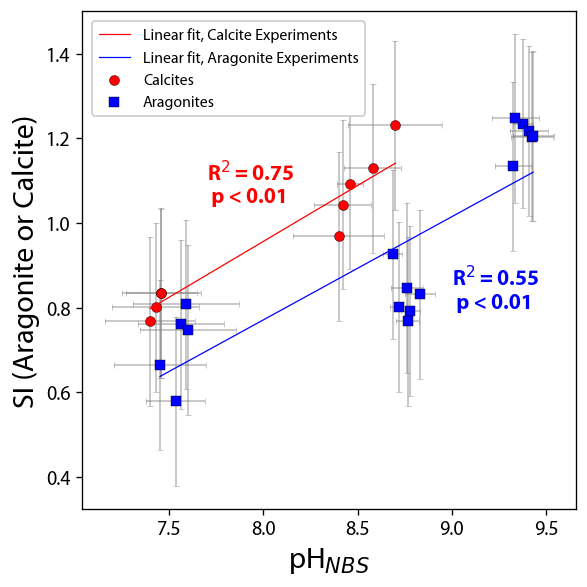

In [27]:
## Plotting SI vs pH 

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(5,5))  

ax1.errorbar(df.pH[(df.Study=='us')&(df.CalcOrArag=='Arag')], MC_SIArag_median[(df.Study=='us')&(df.CalcOrArag=='Arag')], 
            yerr=0.2,xerr= [df.pHerr[(df.Study=='us')&(df.CalcOrArag=='Arag')],df.pHerr[(df.Study=='us')&(df.CalcOrArag=='Arag')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.errorbar(df.pH[(df.Study=='us')&(df.CalcOrArag=='Calc')], MC_SICalc_median[(df.Study=='us')&(df.CalcOrArag=='Calc')], 
            yerr=0.2,xerr= [df.pHerr[(df.Study=='us')&(df.CalcOrArag=='Calc')],df.pHerr[(df.Study=='us')&(df.CalcOrArag=='Calc')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

#X = df.pH[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
#Y = MC_SICalc_median[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
#linear_regressor = LinearRegression()  # create object for the class
#linear_regressor.fit(X,Y)  # perform linear regression
temp=MCregressStats(MC_pHNBS,MC_SICalc,'us',True,reps)
X1=np.linspace(min(df.pH[(df.Study=='us')&(df.Calc==True)]),max(df.pH[(df.Study=='us')&(df.Calc==True)]),100)
if temp[3]<0.01:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75,label='Linear fit, Calcite Experiments')
    ax1.text(7.7,1.05,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=13,fontweight='bold')
elif temp[3]>0.05:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75, linestyle='--',label='Linear fit, Calcite Experiments')
    ax1.text(7.7,1.05,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=13,fontweight='bold')
else:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75, label='Linear fit, Calcite Experiments')
    ax1.text(7.7,1.05,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=13,fontweight='bold')

    
temp=MCregressStats(MC_pHNBS,MC_SIArag,'us',False,reps)
X1=np.linspace(min(df.pH[(df.Study=='us')&(df.Calc==False)]),max(df.pH[(df.Study=='us')&(df.Calc==False)]),100)
if temp[3]<0.01:
    ax1.plot(X1,X1*temp[0] + temp[1], color='blue', linewidth=0.75,label='Linear fit, Aragonite Experiments')
    ax1.text(9,0.8,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=13,fontweight='bold')
elif temp[3]>0.05:
    ax1.plot(X1,X1*temp[0] + temp[1], color='blue', linewidth=0.75, linestyle='--',label='Linear fit, Aragonite Experiments')
    ax1.text(9,0.8,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='blue', fontsize=13,fontweight='bold')
else:
    ax1.plot(X1,X1*temp[0] + temp[1], color='blue', linewidth=0.75, label='Linear fit, Aragonite Experiments')
    ax1.text(9,0.8,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='blue', fontsize=13,fontweight='bold')
#X1=np.linspace(min(X),max(X),10)
#Y_pred = linear_regressor.predict(X1)  # make predictions
#ax1.plot(X1, Y_pred, color='red', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Calcites')

#X = df.pH[(df.CalcOrArag=='Arag')&(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
#Y = MC_SIArag_median[(df.CalcOrArag=='Arag')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
#linear_regressor = LinearRegression()  # create object for the class
#linear_regressor.fit(X,Y) # perform linear regression
#X1=np.linspace(min(X),max(X),10)
#Y_pred = linear_regressor.predict(X1)  # make predictions
#ax1.plot(X1, Y_pred, color='blue', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Aragonites')

ax1.scatter(df.pH[(df.CalcOrArag=='Calc')&(df.Study=='us')],MC_SICalc_median[(df.CalcOrArag=='Calc')&(df.Study=='us')], color='black',label='Calcites', facecolors='red', marker='o', linewidths=0.25)
ax1.scatter(df.pH[(df.CalcOrArag=='Arag')&(df.Study=='us')],MC_SIArag_median[(df.CalcOrArag=='Arag')&(df.Study=='us')], color='black',label='Aragonites', facecolors='blue', marker='s', linewidths=0.25)

ax1.legend(loc=(0.02,0.79), framealpha=1,fontsize=9.5)

ax1.tick_params(labelsize=12)

ax1.set_xlabel('pH$_{NBS}$', fontsize=18)
ax1.set_ylabel('SI (Aragonite or Calcite)', fontsize=18)


fig.tight_layout() 
fig.savefig('pH vs SI2se.pdf')

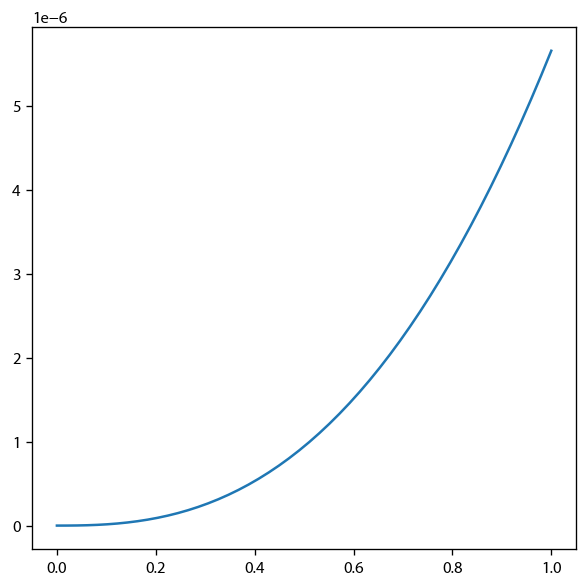

In [28]:
## From Oscar's code.. takes the SI-growth rate relationship from Joji's precipitates and extends it to guess the growth rate of our carbonates more accurately. 

def Rfn(SI, k, n):
    """R as a function of SI"""
    return k * SI**n

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
 # fit line
p, cov = curve_fit(Rfn, MC_SICalc_median[(df.Study=='Uchikawa')], 10**df.logR[(df.Study=='Uchikawa')]) ## Calculates the function
SIn = np.linspace(*ax.get_xlim())
ax.plot(SIn, Rfn(SIn, *p))
fig.tight_layout() 

##outputs p, an array of the k term in position 0, and the n term in the 
RfromSI=pd.Series(p[0]*(MC_SICalc_median**p[1]), index=df.index)
log10RfromSI=np.log10(RfromSI)



'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


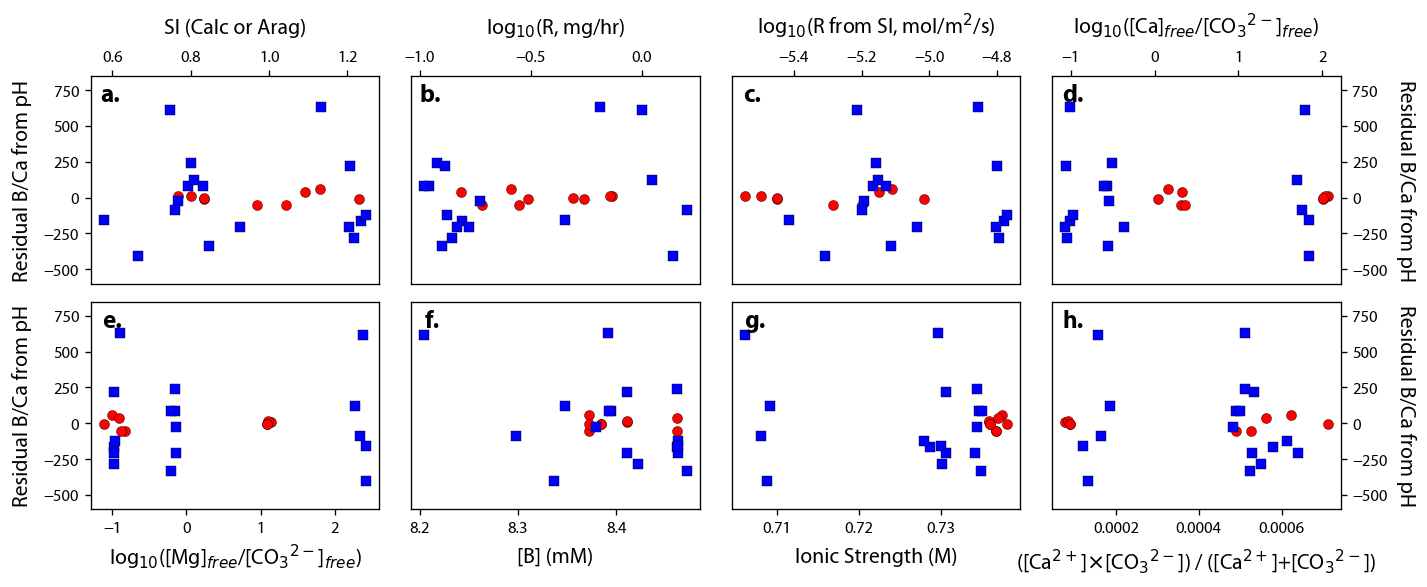

In [89]:
## checking residual B/Ca against aqueous chem
littler=MC_littler_median
littlermax=MC_littler_up95
littlermin=MC_littler_low95

AX = df.pH[(df.Study=='us')&(df.Calc==False)].values.reshape(-1, 1)  # values converts it into a numpy array
AY = df.BCa_umol[(df.Study=='us')&(df.Calc==False)].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(AX,AY)  # perform linear regression
AY_pred = linear_regressor.predict(AX)  # make predictions
ax1.plot(AX, AY_pred, color='purple',linestyle='-.')
AregressionSlopeBCapH=float(linear_regressor.coef_)
AregressionInterceptBCapH=float(linear_regressor.intercept_)
pHresidualAragBCa=AY-AY_pred

CX = df.pH[(df.Study=='us')&(df.Calc==True)].values.reshape(-1, 1)  # values converts it into a numpy array
CY = df.BCa_umol[(df.Study=='us')&(df.Calc==True)].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(CX,CY)  # perform linear regression
CY_pred = linear_regressor.predict(CX)  # make predictions
ax1.plot(CX, CY_pred, color='purple',linestyle='-.')
CregressionSlopeBCapH=float(linear_regressor.coef_)
CregressionInterceptBCapH=float(linear_regressor.intercept_)
pHresidualCalcBCa=CY-CY_pred

AresidualBCapHindexed=pd.Series(pHresidualAragBCa.flatten(),index=df.index[(df.Study=='us')&(df.Calc==False)])
CresidualBCapHindexed=pd.Series(pHresidualCalcBCa.flatten(),index=df.index[(df.Study=='us')&(df.Calc==True)])

fig, ((ax1,ax2,ax3, ax4),(ax5,ax6,ax7, ax8))  = plt.subplots(nrows=2, ncols=4, figsize=(12,5))
ax1.set_ylim(-600,850)
ax2.set_ylim(-600,850)
ax3.set_ylim(-600,850)
ax4.set_ylim(-600,850)
ax5.set_ylim(-600,850)
ax6.set_ylim(-600,850)
ax7.set_ylim(-600,850)
ax8.set_ylim(-600,850)

ax1.scatter(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax1.scatter(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax2.scatter(df.logR[(df.Study=='us')&(df.Calc==True)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax2.scatter(df.logR[(df.Study=='us')&(df.Calc==False)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax3.scatter(np.log10(RfromSI[(df.Study=='us')&(df.Calc==True)]), CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax3.scatter(np.log10(RfromSI[(df.Study=='us')&(df.Calc==False)]), AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax4.scatter(np.log10(littler[(df.Study=='us')&(df.Calc==True)]), CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax4.scatter(np.log10(littler[(df.Study=='us')&(df.Calc==False)]), AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

#ax5.scatter(df.Camismatch[(df.Study=='us')&(df.Calc==True)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)], \
#            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
#ax5.scatter(df.Camismatch[(df.Study=='us')&(df.Calc==False)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)], \
#            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax5.scatter(np.log10(MC_MgCarbion_median[(df.Study=='us')&(df.Calc==True)]), CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax5.scatter(np.log10(MC_MgCarbion_median[(df.Study=='us')&(df.Calc==False)]), AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax6.scatter(df.Ave_BmMol[(df.Study=='us')&(df.Calc==True)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax6.scatter(df.Ave_BmMol[(df.Study=='us')&(df.Calc==False)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax7.scatter(df.Ave_IonicS[(df.Study=='us')&(df.Calc==True)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax7.scatter(df.Ave_IonicS[(df.Study=='us')&(df.Calc==False)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax8.scatter(MC_DavidMetric_median[(df.Study=='us')&(df.Calc==True)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax8.scatter(MC_DavidMetric_median[(df.Study=='us')&(df.Calc==False)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

#ax8.scatter(OxygenOffset[(df.Study=='us')&(df.Calc==True)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)], \
#            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
#ax8.scatter(OxygenOffset[(df.Study=='us')&(df.Calc==False)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)], \
#            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')


ax1.xaxis.set_label_position("top") 
ax1.xaxis.tick_top()
ax2.xaxis.set_label_position("top") 
ax2.xaxis.tick_top()
ax3.xaxis.set_label_position("top") 
ax3.xaxis.tick_top()
ax4.xaxis.set_label_position("top") 
ax4.xaxis.tick_top()
ax1.set_xlabel('SI (Calc or Arag)', fontsize=13,labelpad=10)
ax2.set_xlabel('log$_{10}$(R, mg/hr)', fontsize=13,labelpad=10)
ax3.set_xlabel('log$_{10}$(R from SI, mol/m$^2$/s)', fontsize=13,labelpad=10)
ax4.set_xlabel('log$_{10}$([Ca]$_{free}$/[CO$_3$$^{2-}$]$_{free}$)', fontsize=13,labelpad=10)
ax2.get_yaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax6.get_yaxis().set_visible(False)
ax7.get_yaxis().set_visible(False)
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ax1.set_ylabel('Residual B/Ca from pH', labelpad=7, fontsize=13)
ax4.set_ylabel('Residual B/Ca from pH', labelpad=17, fontsize=13,rotation=270)
ax5.set_ylabel('Residual B/Ca from pH', labelpad=7, fontsize=13)
ax8.set_ylabel('Residual B/Ca from pH', labelpad=17, fontsize=13,rotation=270)
#ax5.set_xlabel('Matrix matching ([Smp]/[Std])', labelpad=7, fontsize=13)
ax5.set_xlabel('log$_{10}$([Mg]$_{free}$/[CO$_3$$^{2-}$]$_{free}$)', fontsize=13)
ax6.set_xlabel('[B] (mM)', labelpad=7, fontsize=13)
ax7.set_xlabel('Ionic Strength (M)', labelpad=7, fontsize=13)
ax8.set_xlabel(r'([Ca$^{2+}$]$\times$[CO$_3$$^{2-}$]) / ([Ca$^{2+}$]+[CO$_3$$^{2-}$])', labelpad=7, fontsize=13)
#ax8.set_xlabel('∆1000lnα Oxygen (‰)', labelpad=7, fontsize=13)

ax8.yaxis.set_label_position("right")
ax8.yaxis.tick_right()

ax1.text(0.57, 675, 'a.', color='black', fontsize=15,fontweight='bold')
ax2.text(-1, 675, 'b.', color='black', fontsize=15,fontweight='bold')
ax3.text(-5.55, 675, 'c.', color='black', fontsize=15,fontweight='bold')
ax4.text(-1.1, 675, 'd.', color='black', fontsize=15,fontweight='bold')
ax5.text(-1.13, 675, 'e.', color='black', fontsize=15,fontweight='bold')
ax6.text(8.205, 675, 'f.', color='black', fontsize=15,fontweight='bold')
ax7.text(0.706, 675, 'g.', color='black', fontsize=15,fontweight='bold')
ax8.text(0.00007, 675, 'h.', color='black', fontsize=15,fontweight='bold')



fig.tight_layout() 
fig.savefig('ResidpHBCa vs params2se_DEmetric.pdf')


'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


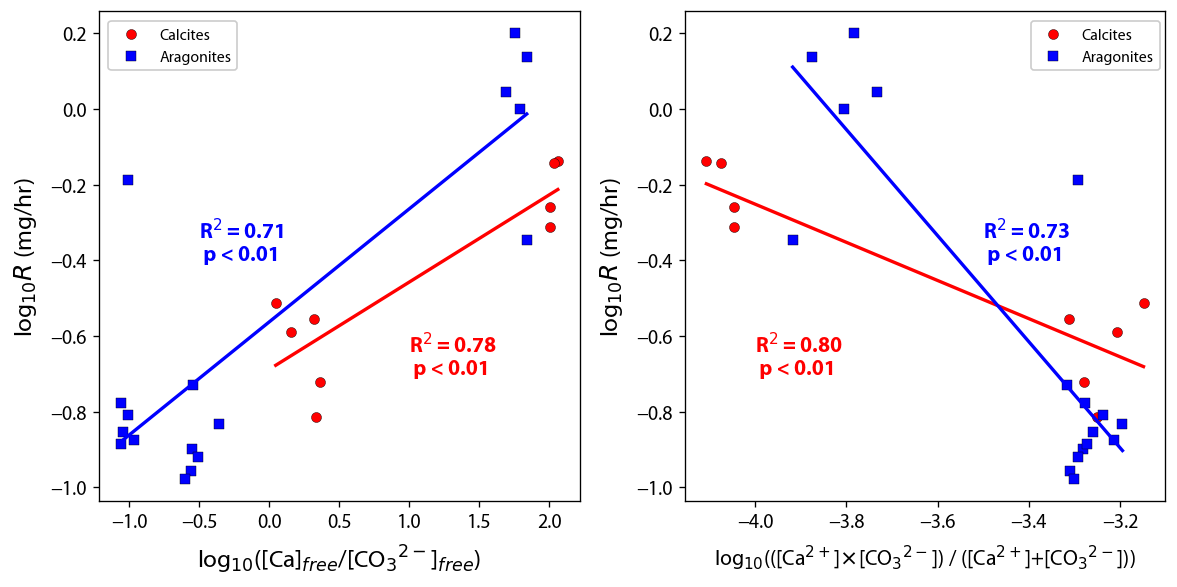

In [124]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(np.log10(littler[(df.Study=='us')&(df.Calc==True)]), df.logR[(df.Study=='us')&(df.Calc==True)])
Aslope, Aintercept, Ar_value, Ap_value, Astd_err = stats.linregress(np.log10(littler[(df.Study=='us')&(df.Calc==False)]), df.logR[(df.Study=='us')&(df.Calc==False)])

X1=np.linspace(min(np.log10(littler[(df.Study=='us')&(df.Calc==True)])),max(np.log10(littler[(df.Study=='us')&(df.Calc==True)])),100)
ax1.plot(X1,X1*Cslope + Cintercept, color='red', linewidth=2)
ax1.text(1,-0.7,'R$^2$ = %.2f \n p < 0.01' % (Cr_value**2), color='red', fontsize=13,fontweight='bold')

X1=np.linspace(min(np.log10(littler[(df.Study=='us')&(df.Calc==False)])),max(np.log10(littler[(df.Study=='us')&(df.Calc==False)])),100)
ax1.plot(X1,X1*Aslope + Aintercept, color='blue', linewidth=2)
ax1.text(-0.5,-0.4,'R$^2$ = %.2f \n p < 0.01' % (Ar_value**2), color='blue', fontsize=13,fontweight='bold')

ax1.scatter(np.log10(littler[(df.Study=='us')&(df.Calc==True)]), df.logR[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax1.scatter(np.log10(littler[(df.Study=='us')&(df.Calc==False)]), df.logR[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
##ax1.scatter(littler[(df.Study=='us')&(df.Calc==True)], df.logR[(df.Study=='us')&(df.Calc==True)], \
#            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
#ax1.scatter(littler[(df.Study=='us')&(df.Calc==False)], df.logR[(df.Study=='us')&(df.Calc==False)], \
#            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax1.tick_params(labelsize=12)

ax1.set_ylabel('log$_{10}R$ (mg/hr)', labelpad=7, fontsize=15)
ax1.set_xlabel('log$_{10}$([Ca]$_{free}$/[CO$_3$$^{2-}$]$_{free}$)', labelpad=7, fontsize=15)
ax1.legend(loc=(0.02,0.88), framealpha=1,fontsize=9.5)

Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(np.log10(MC_DavidMetric_median[(df.Study=='us')&(df.Calc==True)]), df.logR[(df.Study=='us')&(df.Calc==True)])
Aslope, Aintercept, Ar_value, Ap_value, Astd_err = stats.linregress(np.log10(MC_DavidMetric_median[(df.Study=='us')&(df.Calc==False)]), df.logR[(df.Study=='us')&(df.Calc==False)])

X1=np.linspace(min(np.log10(MC_DavidMetric_median[(df.Study=='us')&(df.Calc==True)])),max(np.log10(MC_DavidMetric_median[(df.Study=='us')&(df.Calc==True)])),100)
ax2.plot(X1,X1*Cslope + Cintercept, color='red', linewidth=2)
ax2.text(-4,-0.7,'R$^2$ = %.2f \n p < 0.01' % (Cr_value**2), color='red', fontsize=13,fontweight='bold')

X1=np.linspace(min(np.log10(MC_DavidMetric_median[(df.Study=='us')&(df.Calc==False)])),max(np.log10(MC_DavidMetric_median[(df.Study=='us')&(df.Calc==False)])),100)
ax2.plot(X1,X1*Aslope + Aintercept, color='blue', linewidth=2)
ax2.text(-3.5,-0.4,'R$^2$ = %.2f \n p < 0.01' % (Ar_value**2), color='blue', fontsize=13,fontweight='bold')

ax2.scatter(np.log10(MC_DavidMetric_median[(df.Study=='us')&(df.Calc==True)]), df.logR[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax2.scatter(np.log10(MC_DavidMetric_median[(df.Study=='us')&(df.Calc==False)]), df.logR[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
##ax1.scatter(littler[(df.Study=='us')&(df.Calc==True)], df.logR[(df.Study=='us')&(df.Calc==True)], \
#            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
#ax1.scatter(littler[(df.Study=='us')&(df.Calc==False)], df.logR[(df.Study=='us')&(df.Calc==False)], \
#            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

#ax8.scatter(MC_DavidMetric_median[(df.Study=='us')&(df.Calc==True)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)], \
#            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
#ax8.scatter(MC_DavidMetric_median[(df.Study=='us')&(df.Calc==False)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)], \
#            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax2.tick_params(labelsize=12)
ax2.set_ylabel('log$_{10}R$ (mg/hr)', labelpad=7, fontsize=15)
ax2.set_xlabel(r'log$_{10}$(([Ca$^{2+}$]$\times$[CO$_3$$^{2-}$]) / ([Ca$^{2+}$]+[CO$_3$$^{2-}$]))', labelpad=7, fontsize=13)
ax2.legend(loc=(0.72,0.88), framealpha=1,fontsize=9.5)


fig.tight_layout() 
fig.savefig('littler vs sat ratios combined.pdf')

'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


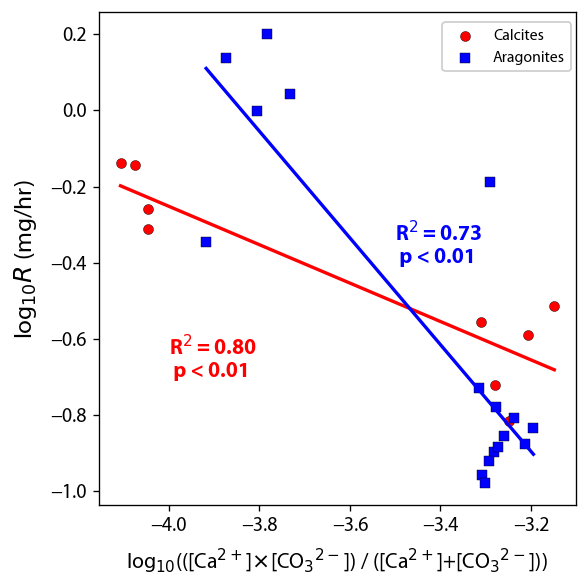

In [122]:
fig, (ax1)  = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(np.log10(MC_DavidMetric_median[(df.Study=='us')&(df.Calc==True)]), df.logR[(df.Study=='us')&(df.Calc==True)])
Aslope, Aintercept, Ar_value, Ap_value, Astd_err = stats.linregress(np.log10(MC_DavidMetric_median[(df.Study=='us')&(df.Calc==False)]), df.logR[(df.Study=='us')&(df.Calc==False)])

X1=np.linspace(min(np.log10(MC_DavidMetric_median[(df.Study=='us')&(df.Calc==True)])),max(np.log10(MC_DavidMetric_median[(df.Study=='us')&(df.Calc==True)])),100)
ax1.plot(X1,X1*Cslope + Cintercept, color='red', linewidth=2)
ax1.text(-4,-0.7,'R$^2$ = %.2f \n p < 0.01' % (Cr_value**2), color='red', fontsize=13,fontweight='bold')

X1=np.linspace(min(np.log10(MC_DavidMetric_median[(df.Study=='us')&(df.Calc==False)])),max(np.log10(MC_DavidMetric_median[(df.Study=='us')&(df.Calc==False)])),100)
ax1.plot(X1,X1*Aslope + Aintercept, color='blue', linewidth=2)
ax1.text(-3.5,-0.4,'R$^2$ = %.2f \n p < 0.01' % (Ar_value**2), color='blue', fontsize=13,fontweight='bold')

ax1.scatter(np.log10(MC_DavidMetric_median[(df.Study=='us')&(df.Calc==True)]), df.logR[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax1.scatter(np.log10(MC_DavidMetric_median[(df.Study=='us')&(df.Calc==False)]), df.logR[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
##ax1.scatter(littler[(df.Study=='us')&(df.Calc==True)], df.logR[(df.Study=='us')&(df.Calc==True)], \
#            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
#ax1.scatter(littler[(df.Study=='us')&(df.Calc==False)], df.logR[(df.Study=='us')&(df.Calc==False)], \
#            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

#ax8.scatter(MC_DavidMetric_median[(df.Study=='us')&(df.Calc==True)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)], \
#            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
#ax8.scatter(MC_DavidMetric_median[(df.Study=='us')&(df.Calc==False)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)], \
#            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax1.tick_params(labelsize=12)
ax1.set_ylabel('log$_{10}R$ (mg/hr)', labelpad=7, fontsize=15)
ax1.set_xlabel(r'log$_{10}$(([Ca$^{2+}$]$\times$[CO$_3$$^{2-}$]) / ([Ca$^{2+}$]+[CO$_3$$^{2-}$]))', labelpad=7, fontsize=13)
ax1.legend(loc=(0.72,0.88), framealpha=1,fontsize=9.5)

fig.tight_layout() 
fig.savefig('DavidMetric vs logR2se.pdf')

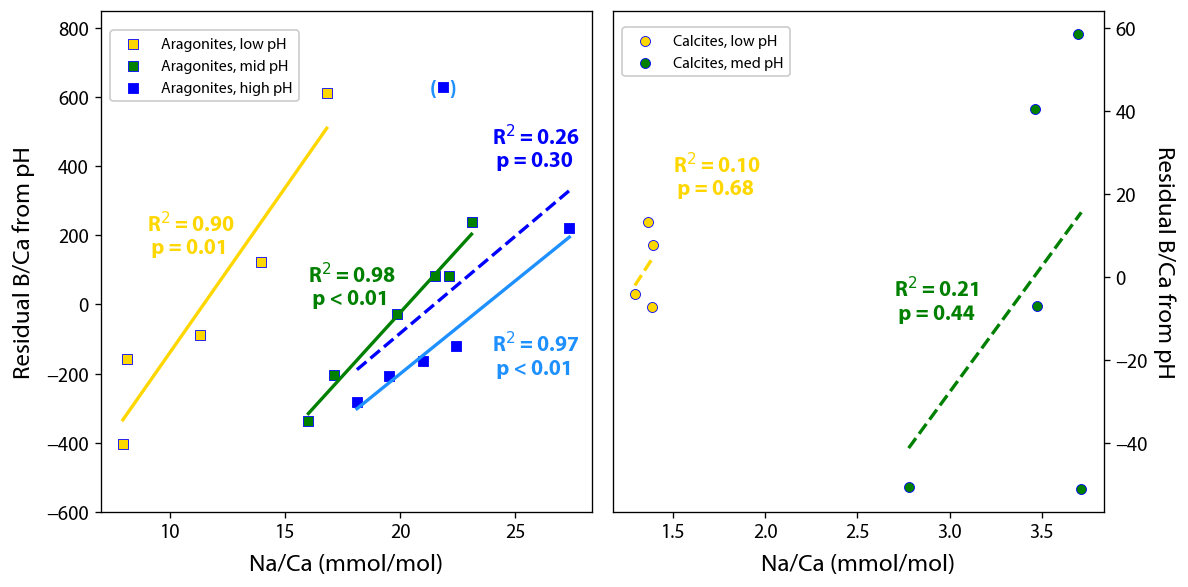

In [31]:

fig, (ax1,ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1.set_ylim(-600,850)

Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH<=8)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)&(df.pH<=8)])

X1=np.linspace(min(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH<=8)]),max(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH<=8)]),100)
ax1.plot(X1,X1*Cslope + Cintercept, color='gold', linewidth=2)
ax1.text(9,150,'R$^2$ = %.2f \n p = %.2f' % (Cr_value**2, Cp_value), color='gold', fontsize=13,fontweight='bold')
         
Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH>=8)&(df.pH<=9)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)&(df.pH>=8)&(df.pH<=9)])
X1=np.linspace(min(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH>=8)&(df.pH<=9)]),max(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH>=8)&(df.pH<=9)]),100)
ax1.plot(X1,X1*Cslope + Cintercept, color='green', linewidth=2)
ax1.text(16,0.8,'R$^2$ = %.2f \n p < 0.01' % (Cr_value**2), color='green', fontsize=13,fontweight='bold')

Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH>=9)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)&(df.pH>=9)])
X1=np.linspace(min(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH>=9)]),max(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH>=9)]),100)
ax1.plot(X1,X1*Cslope + Cintercept, color='blue', linewidth=2, linestyle='--')
ax1.text(24,400,'R$^2$ = %.2f \n p = %.2f' % (Cr_value**2, Cp_value), color='blue', fontsize=13,fontweight='bold')

highpHresids=AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)&(df.pH>=9)]
highpHNaCa=df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH>=9)]
Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(highpHNaCa[highpHresids<=500], highpHresids[highpHresids<=500])
X1=np.linspace(min(highpHNaCa[highpHresids<=500]),max(highpHNaCa[highpHresids<=500]),100)
ax1.plot(X1,X1*Cslope + Cintercept, color='dodgerblue', linewidth=2)
ax1.text(24,-200,'R$^2$ = %.2f \n p < 0.01' % (Cr_value**2), color='dodgerblue', label='high pH, excluding outlier', fontsize=13,fontweight='bold')
ax1.text(21.3,610,'(   )', color='dodgerblue', fontsize=13,fontweight='bold')

ax1.scatter(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH<=8)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)&(df.pH<=8)], \
            color='blue',linewidths=0.5, facecolors='gold', label='Aragonites, low pH', marker='s')

ax1.scatter(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH>=8)&(df.pH<=9)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)&(df.pH>=8)&(df.pH<=9)], \
            color='blue',linewidths=0.5, facecolors='green', label='Aragonites, mid pH', marker='s')

ax1.scatter(df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)&(df.pH>=9)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)&(df.pH>=9)], \
            color='blue',linewidths=0.5, facecolors='blue', label='Aragonites, high pH', marker='s')


ax1.set_ylabel('Residual B/Ca from pH', labelpad=7, fontsize=15)
ax1.set_xlabel('Na/Ca (mmol/mol)', labelpad=7, fontsize=15)


Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(df.NaCa_mmol[(df.Study=='us')&(df.Calc==True)&(df.pH<=8)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)&(df.pH<=8)])

X1=np.linspace(min(df.NaCa_mmol[(df.Study=='us')&(df.Calc==True)&(df.pH<=8)]),max(df.NaCa_mmol[(df.Study=='us')&(df.Calc==True)&(df.pH<=8)]),100)
ax2.plot(X1,X1*Cslope + Cintercept, color='gold', linewidth=2, linestyle='--')
ax2.text(1.5,20,'R$^2$ = %.2f \n p = %.2f' % (Cr_value**2, Cp_value), color='gold', fontsize=13,fontweight='bold')

ax2.scatter(df.NaCa_mmol[(df.Study=='us')&(df.Calc==True)&(df.pH<=8)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)&(df.pH<=8)], \
            color='blue',linewidths=0.5, facecolors='gold', label='Calcites, low pH', marker='o')


Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(df.NaCa_mmol[(df.Study=='us')&(df.Calc==True)&(df.pH>=8)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)&(df.pH>=8)])

X1=np.linspace(min(df.NaCa_mmol[(df.Study=='us')&(df.Calc==True)&(df.pH>=8)]),max(df.NaCa_mmol[(df.Study=='us')&(df.Calc==True)&(df.pH>=8)]),100)
ax2.plot(X1,X1*Cslope + Cintercept, color='green', linewidth=2, linestyle='--')
ax2.text(2.7,-10,'R$^2$ = %.2f \n p = %.2f' % (Cr_value**2, Cp_value), color='green', fontsize=13,fontweight='bold')

ax2.scatter(df.NaCa_mmol[(df.Study=='us')&(df.Calc==True)&(df.pH>=8)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)&(df.pH>=8)], \
            color='blue',linewidths=0.5, facecolors='green', label='Calcites, med pH', marker='o')

ax2.set_ylabel('Residual B/Ca from pH', labelpad=17, fontsize=15, rotation=270)
ax2.set_xlabel('Na/Ca (mmol/mol)', labelpad=7, fontsize=15)


ax1.legend(loc=(0.02,0.82), framealpha=1,fontsize=9.5)
ax2.legend(loc=(0.02,0.87), framealpha=1,fontsize=9.5)

ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)

ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()



fig.tight_layout() 
#fig.savefig('ResidpHBCa vs params.pdf')



'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


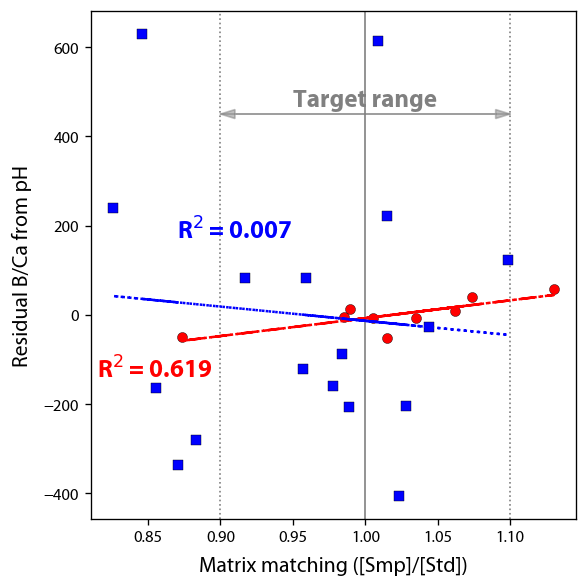

In [32]:
## Plotting against the quality of matrix-matching when running on the element.. 

fig, (ax1)  = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

#ax1.scatter(pCaMg[(df.Study=='us')&(df.Calc==True)], df.BCa_umol[(df.Study=='us')&(df.Calc==True)], \
#            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
#ax1.scatter(pCaMg[(df.Study=='us')&(df.Calc==False)], df.BCa_umol[(df.Study=='us')&(df.Calc==False)], \
#            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')


ax1.scatter(df.Camismatch[(df.Study=='us')&(df.Calc==True)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax1.scatter(df.Camismatch[(df.Study=='us')&(df.Calc==False)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax1.set_ylabel('Residual B/Ca from pH', labelpad=7, fontsize=13)
#ax1.text(0.815, 550, 'e.', color='goldenrod', fontsize=15,fontweight='bold')
ax1.set_xlabel('Matrix matching ([Smp]/[Std])', labelpad=7, fontsize=13)

CX = df.Camismatch[(df.Study=='us')&(df.Calc==True)].values.reshape(-1, 1)  # values converts it into a numpy array
CY = CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Clinear_regressor = LinearRegression()  # create object for the class
Clinear_regressor.fit(CX,CY)  # perform linear regression
CY_pred = Clinear_regressor.predict(CX)  # make predictions
ax1.plot(CX, CY_pred, color='red',linestyle='-.')
CregressionSlopeMatrixMatch=float(Clinear_regressor.coef_)
CregressionInterceptMatrixMatch=float(Clinear_regressor.intercept_)
r2calc=stats.linregress(df.Camismatch[(df.Study=='us')&(df.Calc==True)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)]).rvalue**2

AX = df.Camismatch[(df.Study=='us')&(df.Calc==False)].values.reshape(-1, 1)  # values converts it into a numpy array
AY = AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Alinear_regressor = LinearRegression()  # create object for the class
Alinear_regressor.fit(AX,AY)  # perform linear regression
AY_pred = Alinear_regressor.predict(AX)  # make predictions
ax1.plot(AX, AY_pred, color='blue',linestyle=':')
AregressionSlopeMatrixMatch=float(Alinear_regressor.coef_)
AregressionInterceptMatrixMatch=float(Alinear_regressor.intercept_)
r2arag=stats.linregress(df.Camismatch[(df.Study=='us')&(df.Calc==False)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)]).rvalue**2

ax1.text(0.815, -140, 'R$^2$ = %.3f' % r2calc, color='red', fontsize=15,fontweight='bold')
ax1.text(0.87, 170, 'R$^2$ = %.3f' % r2arag, color='blue', fontsize=15,fontweight='bold')
ax1.text(0.95, 467, 'Target range' % r2arag, color='grey', fontsize=15,fontweight='bold')
ax1.arrow(0.9, 450, 0.2, 0, head_width=20, width=0.001, head_length=0.01, overhang=0, length_includes_head=True, shape='full', color='gray', alpha=0.5)
ax1.arrow(1.1, 450, -0.2, 0, head_width=20, width=0.001, head_length=0.01, overhang=0, length_includes_head=True, shape='full', color='gray', alpha=0.5)
ax1.axvline(x=1, color='gray', zorder=-1,linewidth=1)
ax1.axvline(x=1.1, color='gray', zorder=-1,linewidth=1, linestyle=':')
ax1.axvline(x=0.9, color='gray', zorder=-1,linewidth=1, linestyle=':')

fig.tight_layout() 
fig.savefig('ResidpHBCa vs matrixmatch2se.pdf')

'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


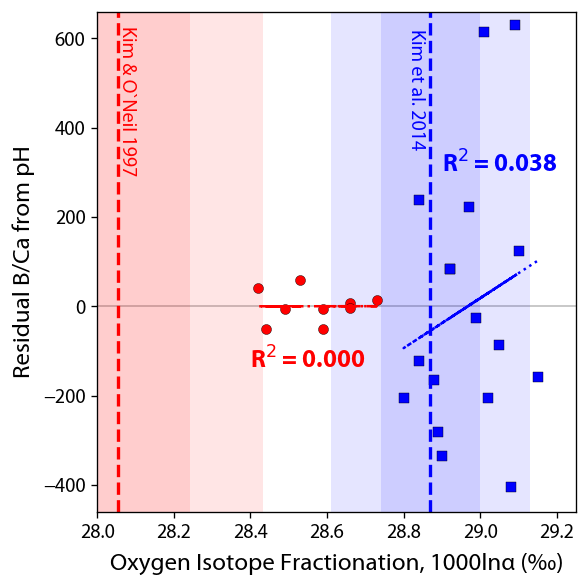

In [33]:
## Comparing residual B/Ca scatter to oxygen isotope equilibrium

fig, (ax1)  = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

#ax1.scatter(pCaMg[(df.Study=='us')&(df.Calc==True)], df.BCa_umol[(df.Study=='us')&(df.Calc==True)], \
#            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
#ax1.scatter(pCaMg[(df.Study=='us')&(df.Calc==False)], df.BCa_umol[(df.Study=='us')&(df.Calc==False)], \
#            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax1.set_xlim(28,29.25)
ax1.set_ylim(-460,660)
ax1.fill_between(x=[28.87-0.13,28.87+0.13], y1=[-470,-470], y2=[670,670], alpha=0.1,linewidth=0, color='blue', zorder=-1)
ax1.fill_between(x=[28.87-0.26,28.87+0.26], y1=[-470,-470], y2=[670,670], alpha=0.1,linewidth=0, color='blue', zorder=-1)
ax1.fill_between(x=[28.053-0.19,28.053+0.19], y1=[-470,-470], y2=[670,670], alpha=0.1,linewidth=0, color='red', zorder=-1)
ax1.fill_between(x=[28.053-0.38,28.053+0.38], y1=[-470,-470], y2=[670,670], alpha=0.1,linewidth=0, color='red', zorder=-1)

ax1.scatter(df.OxyFract[(df.Study=='us')&(df.Calc==True)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax1.scatter(df.OxyFract[(df.Study=='us')&(df.Calc==False)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax1.set_ylabel('Residual B/Ca from pH', labelpad=5, fontsize=15)
#ax1.text(0.815, 550, 'e.', color='goldenrod', fontsize=15,fontweight='bold')
ax1.set_xlabel('Oxygen Isotope Fractionation, 1000lnα (‰)', labelpad=7, fontsize=15)

CX = df.OxyFract[(df.Study=='us')&(df.Calc==True)].values.reshape(-1, 1)  # values converts it into a numpy array
CY = CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Clinear_regressor = LinearRegression()  # create object for the class
Clinear_regressor.fit(CX,CY)  # perform linear regression
CY_pred = Clinear_regressor.predict(CX)  # make predictions
ax1.plot(CX, CY_pred, color='red',linestyle='-.')
CregressionSlopeMatrixMatch=float(Clinear_regressor.coef_)
CregressionInterceptMatrixMatch=float(Clinear_regressor.intercept_)
r2calc=stats.linregress(df.OxyFract[(df.Study=='us')&(df.Calc==True)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)]).rvalue**2

AX = df.OxyFract[(df.Study=='us')&(df.Calc==False)].values.reshape(-1, 1)  # values converts it into a numpy array
AY = AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Alinear_regressor = LinearRegression()  # create object for the class
Alinear_regressor.fit(AX,AY)  # perform linear regression
AY_pred = Alinear_regressor.predict(AX)  # make predictions
ax1.plot(AX, AY_pred, color='blue',linestyle=':')
AregressionSlopeMatrixMatch=float(Alinear_regressor.coef_)
AregressionInterceptMatrixMatch=float(Alinear_regressor.intercept_)
r2arag=stats.linregress(df.OxyFract[(df.Study=='us')&(df.Calc==False)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)]).rvalue**2

ax1.text(28.4, -140, 'R$^2$ = %.3f' % r2calc, color='red', fontsize=15,fontweight='bold')
ax1.text(28.9, 300, 'R$^2$ = %.3f' % r2arag, color='blue', fontsize=15,fontweight='bold')
#ax1.text(0.95, 467, 'Target range' % r2arag, color='grey', fontsize=15,fontweight='bold')
#ax1.arrow(0.9, 450, 0.2, 0, head_width=20, width=0.001, head_length=0.01, overhang=0, length_includes_head=True, shape='full', color='gray', alpha=0.5)
#ax1.arrow(1.1, 450, -0.2, 0, head_width=20, width=0.001, head_length=0.01, overhang=0, length_includes_head=True, shape='full', color='gray', alpha=0.5)
ax1.axhline(y=0, color='gray', alpha=0.5, zorder=-10,linewidth=1)
#ax1.axvline(x=1.1, color='gray', zorder=-1,linewidth=1, linestyle=':')
#ax1.axvline(x=0.9, color='gray', zorder=-1,linewidth=1, linestyle=':')
ax1.axvline(x=(18.03*((10**3)/298.15)-32.42), color='red', linestyle='--',linewidth=2,label='Equilibrium line, Calcite') ## Kim et al. 2007 Equilibrium Aragonite fractionation at 25˚C
ax1.axvline(x=28.87, color='blue', linestyle='--', linewidth=2,label='Equilibrium line, Aragonite') ## Kim & ONeil Equilibrium Calcite fractionation at 25˚C
ax1.text(28.81, 360, 'Kim et al. 2014', color='blue', fontsize=12, rotation=270)
ax1.text(28.055, 300, 'Kim & O`Neil 1997', color='red', fontsize=12, rotation=270)
ax1.tick_params(labelsize=12)
fig.tight_layout() 
fig.savefig('ResidpHBCa vs OxyFract2se.pdf')

'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


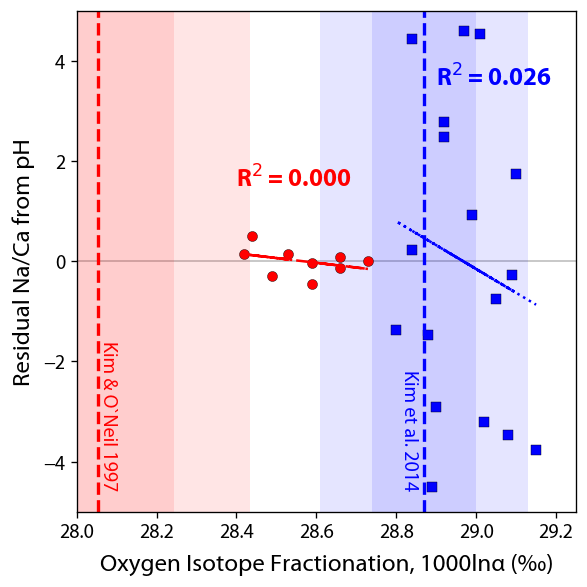

In [34]:
## same again but for Na/Ca resids


AX = df.pH[(df.Study=='us')&(df.Calc==False)].values.reshape(-1, 1)  # values converts it into a numpy array
AY = df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Alinear_regressor = LinearRegression()  # create object for the class
Alinear_regressor.fit(AX,AY)  # perform linear regression
AY_pred = Alinear_regressor.predict(AX)  # make predictions
#ax1.plot(AX, AY_pred, color='purple',linestyle='-.')
AregressionSlopeNaCapH=float(Alinear_regressor.coef_)
AregressionInterceptNaCapH=float(Alinear_regressor.intercept_)
pHresidualAragNaCa=AY-AY_pred

CX = df.pH[(df.Study=='us')&(df.Calc==True)].values.reshape(-1, 1)  # values converts it into a numpy array
CY = df.NaCa_mmol[(df.Study=='us')&(df.Calc==True)].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Clinear_regressor = LinearRegression()  # create object for the class
Clinear_regressor.fit(CX,CY)  # perform linear regression
CY_pred = Clinear_regressor.predict(CX)  # make predictions
#ax1.plot(CX, CY_pred, color='purple',linestyle='-.')
CregressionSlopeNaCapH=float(Clinear_regressor.coef_)
CregressionInterceptNaCapH=float(Clinear_regressor.intercept_)
pHresidualCalcNaCa=CY-CY_pred

AresidualNaCapHindexed=pd.Series(pHresidualAragNaCa.flatten(),index=df.index[(df.Study=='us')&(df.Calc==False)])
CresidualNaCapHindexed=pd.Series(pHresidualCalcNaCa.flatten(),index=df.index[(df.Study=='us')&(df.Calc==True)])

## Start plotting Figure

fig, (ax1)  = plt.subplots(nrows=1, ncols=1, figsize=(5,5))


ax1.set_xlim(28,29.25)
ax1.set_ylim(-5,5)
ax1.fill_between(x=[28.87-0.13,28.87+0.13], y1=[-5,-5], y2=[5,5], alpha=0.1,linewidth=0, color='blue', zorder=-1)
ax1.fill_between(x=[28.87-0.26,28.87+0.26], y1=[-5,-5], y2=[5,5], alpha=0.1,linewidth=0, color='blue', zorder=-1)
ax1.fill_between(x=[28.053-0.19,28.053+0.19], y1=[-5,-5], y2=[5,5], alpha=0.1,linewidth=0, color='red', zorder=-1)
ax1.fill_between(x=[28.053-0.38,28.053+0.38], y1=[-5,-5], y2=[5,5], alpha=0.1,linewidth=0, color='red', zorder=-1)
ax1.axhline(y=0, color='gray', alpha=0.5, zorder=-10,linewidth=1)


#ax1.scatter(pCaMg[(df.Study=='us')&(df.Calc==True)], df.BCa_umol[(df.Study=='us')&(df.Calc==True)], \
#            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
#ax1.scatter(pCaMg[(df.Study=='us')&(df.Calc==False)], df.BCa_umol[(df.Study=='us')&(df.Calc==False)], \
#            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')


ax1.scatter(df.OxyFract[(df.Study=='us')&(df.Calc==True)], CresidualNaCapHindexed[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax1.scatter(df.OxyFract[(df.Study=='us')&(df.Calc==False)], AresidualNaCapHindexed[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax1.set_ylabel('Residual Na/Ca from pH', labelpad=5, fontsize=15)
#ax1.text(0.815, 550, 'e.', color='goldenrod', fontsize=15,fontweight='bold')
ax1.set_xlabel('Oxygen Isotope Fractionation, 1000lnα (‰)', labelpad=7, fontsize=15)

CX = df.OxyFract[(df.Study=='us')&(df.Calc==True)].values.reshape(-1, 1)  # values converts it into a numpy array
CY = CresidualNaCapHindexed[(df.Study=='us')&(df.Calc==True)].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Clinear_regressor = LinearRegression()  # create object for the class
Clinear_regressor.fit(CX,CY)  # perform linear regression
CY_pred = Clinear_regressor.predict(CX)  # make predictions
ax1.plot(CX, CY_pred, color='red',linestyle='-.')
CregressionSlopeMatrixMatch=float(Clinear_regressor.coef_)
CregressionInterceptMatrixMatch=float(Clinear_regressor.intercept_)
r2calc=stats.linregress(df.OxyFract[(df.Study=='us')&(df.Calc==True)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)]).rvalue**2

AX = df.OxyFract[(df.Study=='us')&(df.Calc==False)].values.reshape(-1, 1)  # values converts it into a numpy array
AY = AresidualNaCapHindexed[(df.Study=='us')&(df.Calc==False)].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Alinear_regressor = LinearRegression()  # create object for the class
Alinear_regressor.fit(AX,AY)  # perform linear regression
AY_pred = Alinear_regressor.predict(AX)  # make predictions
ax1.plot(AX, AY_pred, color='blue',linestyle=':')
AregressionSlopeMatrixMatch=float(Alinear_regressor.coef_)
AregressionInterceptMatrixMatch=float(Alinear_regressor.intercept_)
r2arag=stats.linregress(df.OxyFract[(df.Study=='us')&(df.Calc==False)], AresidualNaCapHindexed[(df.Study=='us')&(df.Calc==False)]).rvalue**2

ax1.text(28.4, 1.5, 'R$^2$ = %.3f' % r2calc, color='red', fontsize=15,fontweight='bold')
ax1.text(28.9, 3.5, 'R$^2$ = %.3f' % r2arag, color='blue', fontsize=15,fontweight='bold')
ax1.tick_params(labelsize=12)
#ax1.text(0.95, 467, 'Target range' % r2arag, color='grey', fontsize=15,fontweight='bold')
#ax1.arrow(0.9, 450, 0.2, 0, head_width=20, width=0.001, head_length=0.01, overhang=0, length_includes_head=True, shape='full', color='gray', alpha=0.5)
#ax1.arrow(1.1, 450, -0.2, 0, head_width=20, width=0.001, head_length=0.01, overhang=0, length_includes_head=True, shape='full', color='gray', alpha=0.5)
#ax1.axvline(x=1, color='gray', zorder=-1,linewidth=1)
#ax1.axvline(x=1.1, color='gray', zorder=-1,linewidth=1, linestyle=':')
#ax1.axvline(x=0.9, color='gray', zorder=-1,linewidth=1, linestyle=':')
ax1.axvline(x=(18.03*((10**3)/298.15)-32.42), color='red', linestyle='--', linewidth=2,label='Equilibrium line, Calcite') ## Kim et al. 2007 Equilibrium Aragonite fractionation at 25˚C
ax1.axvline(x=28.87, color='blue', linestyle='--', linewidth=2,label='Equilibrium line, Aragonite') ## Kim & ONeil Equilibrium Calcite fractionation at 25˚C
ax1.text(28.81, -4.5, 'Kim et al. 2014', color='blue', fontsize=12, rotation=270)
ax1.text(28.055, -4.5, 'Kim & O`Neil 1997', color='red', fontsize=12, rotation=270)
fig.tight_layout() 
fig.savefig('ResidpHNaCa vs OxyFract2se.pdf')

'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


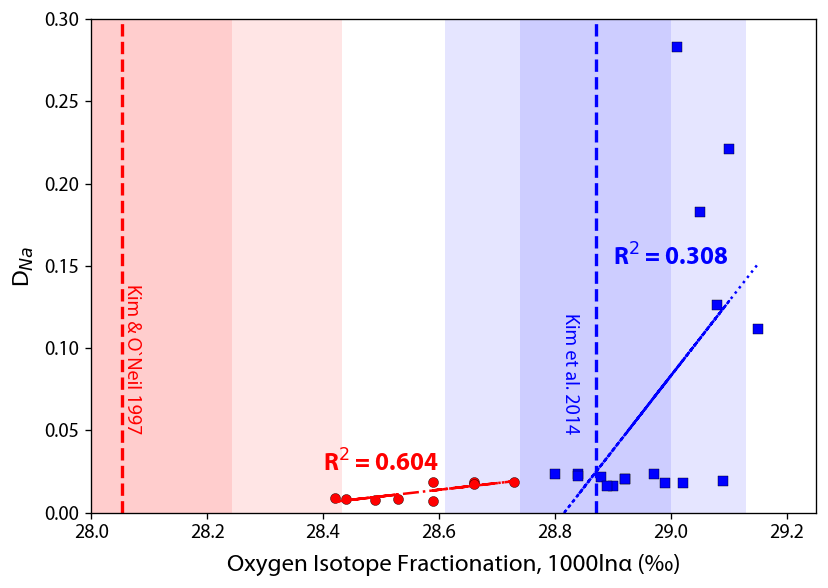

In [35]:
## same again but for DNa, not resids

temp=MCregressStats(MC_pHNBS,MC_KDNa,'Sanyal',True,reps)


fig, (ax1)  = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

#ax1.scatter(pCaMg[(df.Study=='us')&(df.Calc==True)], df.BCa_umol[(df.Study=='us')&(df.Calc==True)], \
#            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
#ax1.scatter(pCaMg[(df.Study=='us')&(df.Calc==False)], df.BCa_umol[(df.Study=='us')&(df.Calc==False)], \
#            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax1.set_xlim(28,29.25)
ax1.set_ylim(0,0.3)
ax1.fill_between(x=[28.87-0.13,28.87+0.13], y1=[0,0], y2=[0.3,0.3], alpha=0.1,linewidth=0, color='blue', zorder=-1)
ax1.fill_between(x=[28.87-0.26,28.87+0.26], y1=[0,0], y2=[0.3,0.3], alpha=0.1,linewidth=0, color='blue', zorder=-1)
ax1.fill_between(x=[28.053-0.19,28.053+0.19], y1=[0,0], y2=[0.3,0.3], alpha=0.1,linewidth=0, color='red', zorder=-1)
ax1.fill_between(x=[28.053-0.38,28.053+0.38], y1=[0,0], y2=[0.3,0.3], alpha=0.1,linewidth=0, color='red', zorder=-1)



ax1.scatter(df.OxyFract[(df.Study=='us')&(df.Calc==True)], MC_KDNa_median[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax1.scatter(df.OxyFract[(df.Study=='us')&(df.Calc==False)], MC_KDNa_median[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax1.set_ylabel('D$_{Na}$', labelpad=5, fontsize=15)
#ax1.text(0.815, 550, 'e.', color='goldenrod', fontsize=15,fontweight='bold')
ax1.set_xlabel('Oxygen Isotope Fractionation, 1000lnα (‰)', labelpad=7, fontsize=15)

CX = df.OxyFract[(df.Study=='us')&(df.Calc==True)].values.reshape(-1, 1)  # values converts it into a numpy array
CY = MC_KDNa_median[(df.Study=='us')&(df.Calc==True)].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Clinear_regressor = LinearRegression()  # create object for the class
Clinear_regressor.fit(CX,CY)  # perform linear regression
CY_pred = Clinear_regressor.predict(CX)  # make predictions
ax1.plot(CX, CY_pred, color='red',linestyle='-.')
CregressionSlopeMatrixMatch=float(Clinear_regressor.coef_)
CregressionInterceptMatrixMatch=float(Clinear_regressor.intercept_)
r2calc=stats.linregress(df.OxyFract[(df.Study=='us')&(df.Calc==True)], MC_KDNa_median[(df.Study=='us')&(df.Calc==True)]).rvalue**2

AX = df.OxyFract[(df.Study=='us')&(df.Calc==False)].values.reshape(-1, 1)  # values converts it into a numpy array
AY = MC_KDNa_median[(df.Study=='us')&(df.Calc==False)].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Alinear_regressor = LinearRegression()  # create object for the class
Alinear_regressor.fit(AX,AY)  # perform linear regression
AY_pred = Alinear_regressor.predict(AX)  # make predictions
ax1.plot(AX, AY_pred, color='blue',linestyle=':')
AregressionSlopeMatrixMatch=float(Alinear_regressor.coef_)
AregressionInterceptMatrixMatch=float(Alinear_regressor.intercept_)
r2arag=stats.linregress(df.OxyFract[(df.Study=='us')&(df.Calc==False)], MC_KDNa_median[(df.Study=='us')&(df.Calc==False)]).rvalue**2
ax1.set_ylim(0,0.3)
#ax1.set_yscale('log')
ax1.text(28.4, 0.025, 'R$^2$ = %.3f' % r2calc, color='red', fontsize=15,fontweight='bold')
ax1.text(28.9, 0.15, 'R$^2$ = %.3f' % r2arag, color='blue', fontsize=15,fontweight='bold')
#ax1.text(0.95, 467, 'Target range' % r2arag, color='grey', fontsize=15,fontweight='bold')
#ax1.arrow(0.9, 450, 0.2, 0, head_width=20, width=0.001, head_length=0.01, overhang=0, length_includes_head=True, shape='full', color='gray', alpha=0.5)
#ax1.arrow(1.1, 450, -0.2, 0, head_width=20, width=0.001, head_length=0.01, overhang=0, length_includes_head=True, shape='full', color='gray', alpha=0.5)
#ax1.axvline(x=1, color='gray', zorder=-1,linewidth=1)
#ax1.axvline(x=1.1, color='gray', zorder=-1,linewidth=1, linestyle=':')
#ax1.axvline(x=0.9, color='gray', zorder=-1,linewidth=1, linestyle=':')
ax1.axvline(x=(18.03*((10**3)/298.15)-32.42), color='red', linestyle='--', linewidth=2,label='Equilibrium line, Calcite') ## Kim et al. 2007 Equilibrium Aragonite fractionation at 25˚C
ax1.axvline(x=28.87, color='blue', linestyle='--', linewidth=2,label='Equilibrium line, Aragonite') ## Kim & ONeil Equilibrium Calcite fractionation at 25˚C
ax1.text(28.81, 0.05, 'Kim et al. 2014', color='blue', fontsize=12, rotation=270)
ax1.text(28.055, 0.05, 'Kim & O`Neil 1997', color='red', fontsize=12, rotation=270)
ax1.tick_params(labelsize=12)
fig.tight_layout() 
fig.savefig('DNa vs OxyFract2se.pdf')

'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


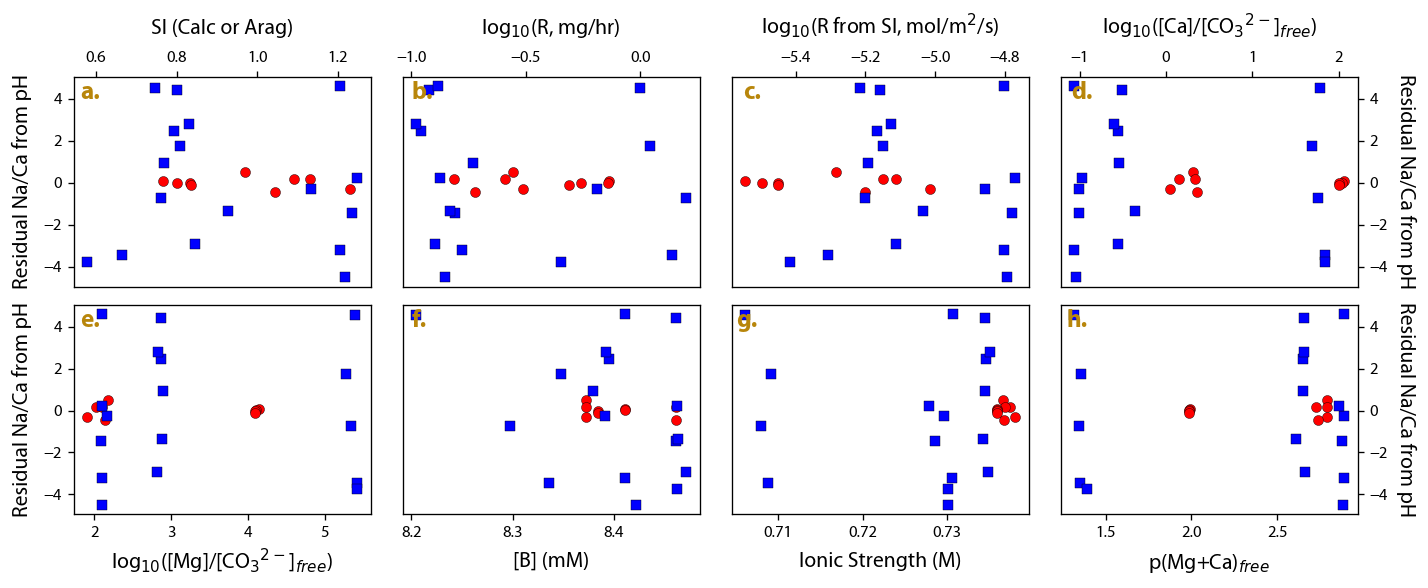

In [36]:
## Plotting Na/Ca residuals against stuff


fig, ((ax1,ax2,ax3, ax4),(ax5,ax6,ax7, ax8))  = plt.subplots(nrows=2, ncols=4, figsize=(12,5))
#ax1.set_ylim(-600,850)
##ax2.set_ylim(-600,850)
##ax3.set_ylim(-600,850)
##ax4.set_ylim(-600,850)
#ax5.set_ylim(-600,850)
#ax6.set_ylim(-600,850)
#ax7.set_ylim(-600,850)
#ax8.set_ylim(-600,850)

ax1.scatter(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], CresidualNaCapHindexed[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax1.scatter(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], AresidualNaCapHindexed[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax2.scatter(df.logR[(df.Study=='us')&(df.Calc==True)], CresidualNaCapHindexed[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax2.scatter(df.logR[(df.Study=='us')&(df.Calc==False)], AresidualNaCapHindexed[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax3.scatter(np.log10(RfromSI[(df.Study=='us')&(df.Calc==True)]), CresidualNaCapHindexed[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax3.scatter(np.log10(RfromSI[(df.Study=='us')&(df.Calc==False)]), AresidualNaCapHindexed[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax4.scatter(np.log10(littler[(df.Study=='us')&(df.Calc==True)]), CresidualNaCapHindexed[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax4.scatter(np.log10(littler[(df.Study=='us')&(df.Calc==False)]), AresidualNaCapHindexed[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

#ax5.scatter(df.Camismatch[(df.Study=='us')&(df.Calc==True)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)], \
#            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
#ax5.scatter(df.Camismatch[(df.Study=='us')&(df.Calc==False)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)], \
#            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax5.scatter(np.log10(df.Ave_MgmMol[(df.Study=='us')&(df.Calc==True)]/MCcarbion_median[(df.Study=='us')&(df.Calc==True)]), CresidualNaCapHindexed[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax5.scatter(np.log10(df.Ave_MgmMol[(df.Study=='us')&(df.Calc==False)]/MCcarbion_median[(df.Study=='us')&(df.Calc==False)]), AresidualNaCapHindexed[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax6.scatter(df.Ave_BmMol[(df.Study=='us')&(df.Calc==True)], CresidualNaCapHindexed[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax6.scatter(df.Ave_BmMol[(df.Study=='us')&(df.Calc==False)], AresidualNaCapHindexed[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax7.scatter(df.Ave_IonicS[(df.Study=='us')&(df.Calc==True)], CresidualNaCapHindexed[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax7.scatter(df.Ave_IonicS[(df.Study=='us')&(df.Calc==False)], AresidualNaCapHindexed[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax8.scatter(medpCaMg[(df.Study=='us')&(df.Calc==True)], CresidualNaCapHindexed[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax8.scatter(medpCaMg[(df.Study=='us')&(df.Calc==False)], AresidualNaCapHindexed[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')


ax1.xaxis.set_label_position("top") 
ax1.xaxis.tick_top()
ax2.xaxis.set_label_position("top") 
ax2.xaxis.tick_top()
ax3.xaxis.set_label_position("top") 
ax3.xaxis.tick_top()
ax4.xaxis.set_label_position("top") 
ax4.xaxis.tick_top()
ax1.set_xlabel('SI (Calc or Arag)', fontsize=13,labelpad=10)
ax2.set_xlabel('log$_{10}$(R, mg/hr)', fontsize=13,labelpad=10)
ax3.set_xlabel('log$_{10}$(R from SI, mol/m$^2$/s)', fontsize=13,labelpad=10)
ax4.set_xlabel('log$_{10}$([Ca]/[CO$_3$$^{2-}$]$_{free}$)', fontsize=13,labelpad=10)
ax2.get_yaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax6.get_yaxis().set_visible(False)
ax7.get_yaxis().set_visible(False)
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ax1.set_ylabel('Residual Na/Ca from pH', labelpad=7, fontsize=13)
ax4.set_ylabel('Residual Na/Ca from pH', labelpad=17, fontsize=13,rotation=270)
ax5.set_ylabel('Residual Na/Ca from pH', labelpad=7, fontsize=13)
ax8.set_ylabel('Residual Na/Ca from pH', labelpad=17, fontsize=13,rotation=270)
#ax5.set_xlabel('Matrix matching ([Smp]/[Std])', labelpad=7, fontsize=13)
ax5.set_xlabel('log$_{10}$([Mg]/[CO$_3$$^{2-}$]$_{free}$)', fontsize=13)
ax6.set_xlabel('[B] (mM)', labelpad=7, fontsize=13)
ax7.set_xlabel('Ionic Strength (M)', labelpad=7, fontsize=13)
ax8.set_xlabel('p(Mg+Ca)$_{free}$', labelpad=7, fontsize=13)

ax8.yaxis.set_label_position("right")
ax8.yaxis.tick_right()

ax1.text(0.56, 4, 'a.', color='darkgoldenrod', fontsize=15,fontweight='bold')
ax2.text(-1, 4, 'b.', color='darkgoldenrod', fontsize=15,fontweight='bold')
ax3.text(-5.55, 4, 'c.', color='darkgoldenrod', fontsize=15,fontweight='bold')
ax4.text(-1.1, 4, 'd.', color='darkgoldenrod', fontsize=15,fontweight='bold')
ax5.text(1.82, 4, 'e.', color='darkgoldenrod', fontsize=15,fontweight='bold')
ax6.text(8.2, 4, 'f.', color='darkgoldenrod', fontsize=15,fontweight='bold')
ax7.text(0.705, 4, 'g.', color='darkgoldenrod', fontsize=15,fontweight='bold')
ax8.text(1.27, 4, 'h.', color='darkgoldenrod', fontsize=15,fontweight='bold')



fig.tight_layout() 
fig.savefig('ResidpHNaCa vs params2se.pdf')

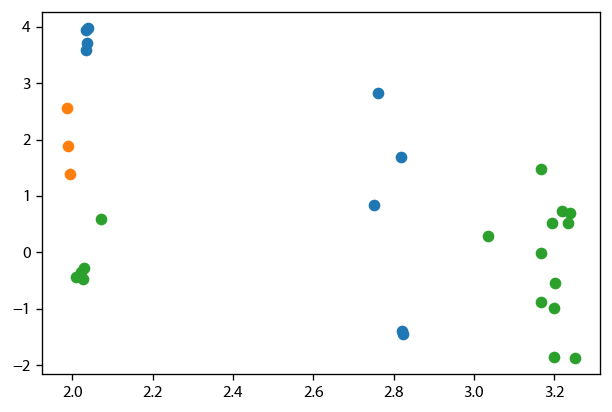

In [37]:
pCa=-1*np.log10(MC_Cafree_median)

plt.scatter(pCa[(df.Study=='us')&(df.Calc==True)],MCEpsilonNRae_median[(df.Study=='us')&(df.Calc==True)])
plt.scatter(pCa[(df.Study=='Sanyal')&(df.Calc==True)],MCEpsilonNRae_median[(df.Study=='Sanyal')&(df.Calc==True)])
plt.scatter(pCa[(df.Study=='us')&(df.Calc==False)],MCEpsilonNRae_median[(df.Study=='us')&(df.Calc==False)])

In [ ]:
## Checking how much the Calcite regression should be trusted.

##There are different opinions regarding what cut-off values to use for spotting highly influential points. 
#Since Cook's distance is in the metric of an F distribution with p and n-p degrees of freedom, the median point (i.e., F0.5(p,n−p))
#can be used as a cut-off.[7] Since this value is close to 1 for large n, a simple operational guideline of Di>1 has been suggested.

import statsmodels.api as sm
import statsmodels.stats.outliers_influence as oi
model=sm.OLS(CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)],df.Camismatch[(df.Study=='us')&(df.Calc==True)])
res=model.fit()
#oi(df.Camismatch[(df.Study=='us')&(df.Calc==True)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)])
oi.OLSInfluence(res).plot_index()
oi.OLSInfluence(res).params_not_obsi



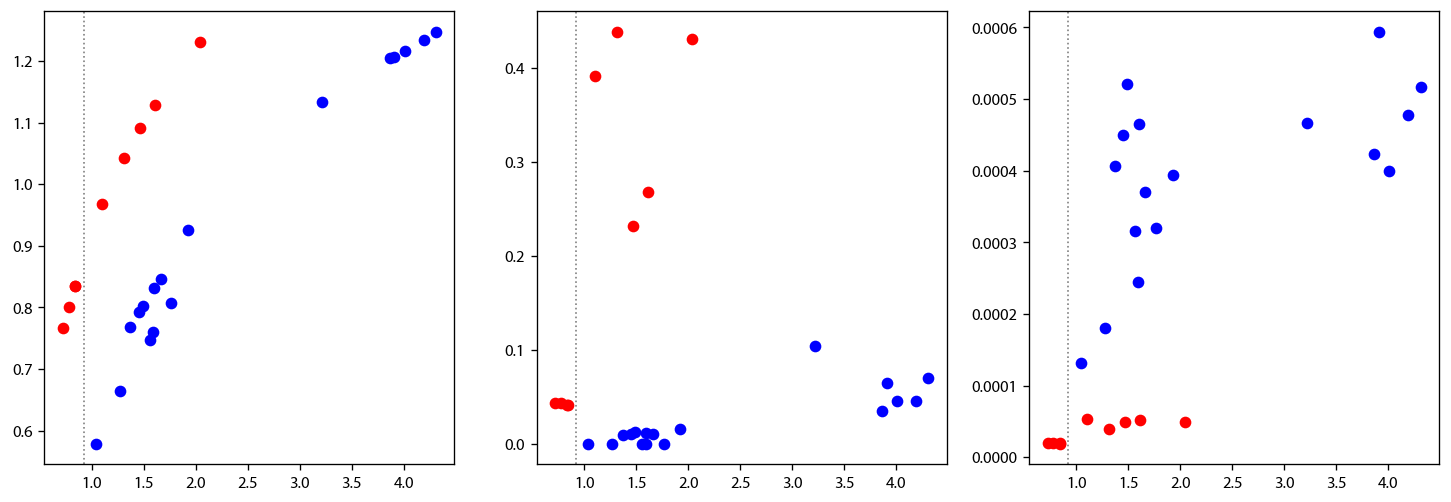

In [38]:
## comparing to the likelihood of ACC formation.. 

## 9.21 * 10^-7 is mol2.kg2 is the conc product beyond with  ACC may form, according to Clarkson et al 1992

ACCproduct=MCcarbion_median*MC_Cafree_median

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
# 1st SI
#ax1.set_xlim(-0.0001,0.0001)
#ax1.set_ylim(-0.0001,0.005)
ax1.scatter((10**6)*ACCproduct[(df.Study=='us')&(df.Calc==True)], MC_SICalc_median[(df.Study=='us')&(df.Calc==True)], color='red')
ax1.scatter((10**6)*ACCproduct[(df.Study=='us')&(df.Calc==False)], MC_SIArag_median[(df.Study=='us')&(df.Calc==False)], color='blue')
ax1.axvline(x=9.21*10**-1, color='gray', zorder=-1,linewidth=1, linestyle=':')
# 2nd Mg incorporation
#ax2.set_xlim(-0.001,0.001)
#ax2.set_xlim(11,36)
ax2.scatter((10**6)*ACCproduct[(df.Study=='us')&(df.Calc==True)], MClambdaMg_median[(df.Study=='us')&(df.Calc==True)], color='red')
ax2.scatter((10**6)*ACCproduct[(df.Study=='us')&(df.Calc==False)], MClambdaMg_median[(df.Study=='us')&(df.Calc==False)], color='blue')
ax2.axvline(x=9.21*10**-1, color='gray', zorder=-1,linewidth=1, linestyle=':')
# 3rd Na incorporation
#ax1.set_xlim(-0.001,0.001)
#ax3.set_xlim(11,36)
ax3.scatter((10**6)*ACCproduct[(df.Study=='us')&(df.Calc==True)], MClambdaNa_median[(df.Study=='us')&(df.Calc==True)], color='red')
ax3.scatter((10**6)*ACCproduct[(df.Study=='us')&(df.Calc==False)], MClambdaNa_median[(df.Study=='us')&(df.Calc==False)], color='blue')
ax3.axvline(x=9.21*10**-1, color='gray', zorder=-1,linewidth=1, linestyle=':')

'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Semibold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


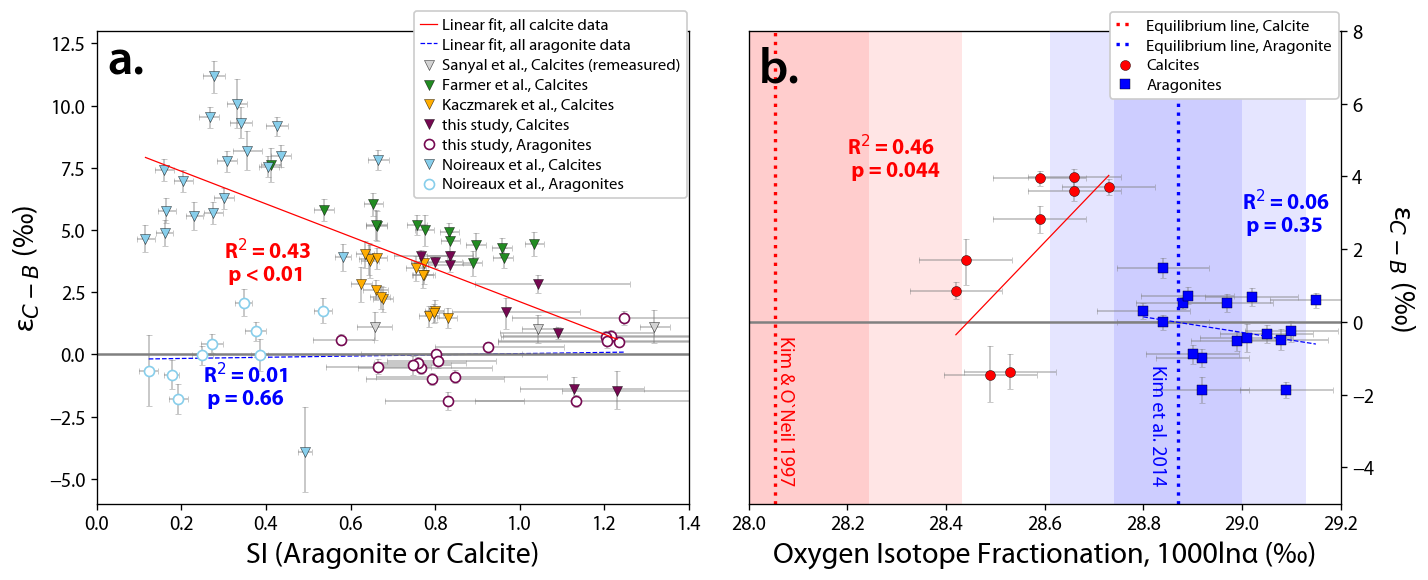

In [249]:
##Plotting Epsilon data vs SI and d18O disequilibrium

Ncolours={'NSanyalwildboot':"lightgray",'NFarmerwildboot':"forestgreen",'NKaczmarekwildboot':"#ffad01",'NUsCalcswildboot':"#750851",'NUsAragswildboot':"#750851",'NNoireauxCalcswildboot':"skyblue",'NNoireauxAragswildboot':"skyblue"}
Kcolours={'KSanyalwildboot':"lightgray",'KFarmerwildboot':"forestgreen",'KKaczmarekwildboot':"#ffad01",'KUsCalcswildboot':"#750851",'KUsAragswildboot':"#750851",'KNoireauxCalcswildboot':"skyblue",'KNoireauxAragswildboot':"skyblue"}
Nserieslabels={'NSanyalwildboot':'Sanyal et al., Calcites (remeasured)','NFarmerwildboot':'Farmer et al., Calcites','NKaczmarekwildboot':'Kaczmarek et al., Calcites','NUsCalcswildboot':'this study, Calcites','NUsAragswildboot':'this study, Aragonites','NNoireauxCalcswildboot':'Noireaux et al., Calcites', 'NNoireauxAragswildboot':'Noireaux et al., Aragonites'}
Kserieslabels={'KSanyalwildboot':'Sanyal et al., Calcites (remeasured)','KFarmerwildboot':'Farmer et al., Calcites','KKaczmarekwildboot':'Kaczmarek et al., Calcites','KUsCalcswildboot':'this study, Calcites','KUsAragswildboot':'this study, Aragonites','KNoireauxCalcswildboot':'Noireaux et al., Calcites', 'KNoireauxAragswildboot':'Noireaux et al., Aragonites'}

#residuald11BfromKlochko={}

#Kd11BOffset_median=pd.Series(Kd11BOffset.median(axis=1), index=df.index)
#Kd11BOffset_up95=pd.Series(np.quantile(Kd11BOffset, 0.975, axis=1),index=df.index)
#Kd11BOffset_low95=pd.Series(np.quantile(Kd11BOffset, 0.025, axis=1),index=df.index)
#Kd11BOffset_upErr=Kd11BOffset_up95-Kd11BOffset_median
#Kd11BOffset_lowErr=Kd11BOffset_median-Kd11BOffset_low95
#highEpsErr=MCEpsilonKRae_up95-MCEpsilonKRae_median
#lowEpsErr=MCEpsilonKRae_median-MCEpsilonKRae_low95
highEpsErr=MCEpsilonNRae_up95-MCEpsilonNRae_median
lowEpsErr=MCEpsilonNRae_median-MCEpsilonNRae_low95

MCd18Ofrac=pd.DataFrame(index=df.index)
for rep in range(reps):
    temporary= pd.Series(df.OxyFract+np.random.normal(0,0.094), index=df.index)
    MCd18Ofrac[rep]=temporary.values
    del temporary
    
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax1.set_xlim(0,1.4)
#ax2.set_xlim(0,1.4)
ax1.set_ylim(-6,13)
ax2.set_ylim(-5,8)
ax1.axhline(y=0, color='gray', zorder=0)
ax2.axhline(y=0, color='gray', zorder=0)
ax1.errorbar(MC_SIArag_median[(df.CalcOrArag=='Arag')], MCEpsilonNRae_median[(df.CalcOrArag=='Arag')],
            xerr=[highSIAragErr[(df.CalcOrArag=='Arag')],lowSIAragErr[(df.CalcOrArag=='Arag')]],
            yerr= [lowEpsErr[(df.CalcOrArag=='Arag')],highEpsErr[(df.CalcOrArag=='Arag')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.errorbar(MC_SICalc_median[(df.CalcOrArag=='Calc')], MCEpsilonNRae_median[(df.CalcOrArag=='Calc')],
            xerr=[highSICalcErr[(df.CalcOrArag=='Calc')],lowSICalcErr[(df.CalcOrArag=='Calc')]],
            yerr= [lowEpsErr[(df.CalcOrArag=='Calc')],highEpsErr[(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

temp=MCregressStats2(MC_SICalc,MCEpsilonNRae,True,reps)
X1=np.linspace(min(MC_SICalc_median[(df.Calc==True)]),max(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)]),100)
if temp[3]<0.01:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75,label='Linear fit, all calcite data')
    ax1.text(0.3,3,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=13,fontweight='bold')
elif temp[3]>0.05:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75, linestyle='--',label='Linear fit, all calcite data')
    ax1.text(0.3,3,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=13,fontweight='bold')
else:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75, label='Linear fit, all calcite data')
    ax1.text(0.3,3,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=13,fontweight='bold')
residfromEpsSI=MCEpsilonNRae-((MC_SICalc*temp[0])+temp[1])
temp=MCregressStats2(MC_SIArag,MCEpsilonNRae,False,reps)
X1=np.linspace(min(MC_SIArag_median[(df.Calc==False)]),max(MC_SIArag_median[(df.Study=='us')&(df.Calc==False)]),100)
if temp[3]<0.01:
    ax1.plot(X1,X1*temp[0] + temp[1], color='blue', linewidth=0.75,label='Linear fit, all aragonite data')
    ax1.text(0.25,-2,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=13,fontweight='bold')
elif temp[3]>0.05:
    ax1.plot(X1,X1*temp[0] + temp[1], color='blue', linewidth=0.75, linestyle='--',label='Linear fit, all aragonite data', zorder=-1)
    ax1.text(0.25,-2,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='blue', fontsize=13,fontweight='bold')
else:
    ax1.plot(X1,X1*temp[0] + temp[1], color='blue', linewidth=0.75, label='Linear fit, all aragonite data', zorder=0)
    ax1.text(0.25,-2,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='blue', fontsize=13,fontweight='bold')
    
for indices, names in zip([SanyalCalcs.index, FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['NSanyalwildboot','NFarmerwildboot','NKaczmarekwildboot','NUsCalcswildboot','NUsAragswildboot','NNoireauxCalcswildboot', 'NNoireauxAragswildboot']):
    #residuald11BfromKlochko[names]=d11Bmeas_MCmedian[indices]-d11BborateK_MCmedian[indices]
    if sum(df.Calc[indices])==0:
        ax1.scatter(MC_SIArag_median[indices],MCEpsilonNRae_median[indices], color=Ncolours[names], facecolors='white', label=Nserieslabels[names], marker='o', linewidths=1, zorder=1)
    else:
        ax1.scatter(MC_SICalc_median[indices],MCEpsilonNRae_median[indices], color='black', facecolors=Ncolours[names], label=Nserieslabels[names], marker='v', linewidths=0.25, zorder=2)

        
ax2.set_xlim(28,29.2)
ax2.fill_between(x=[28.87-0.13,28.87+0.13], y1=[-5,-5], y2=[8,8], alpha=0.1,linewidth=0, color='blue', zorder=-1)
ax2.fill_between(x=[28.87-0.26,28.87+0.26], y1=[-5,-5], y2=[8,8], alpha=0.1,linewidth=0, color='blue', zorder=-1)
ax2.fill_between(x=[28.053-0.19,28.053+0.19], y1=[-5,-5], y2=[8,8], alpha=0.1,linewidth=0, color='red', zorder=-1)
ax2.fill_between(x=[28.053-0.38,28.053+0.38], y1=[-5,-5], y2=[8,8], alpha=0.1,linewidth=0, color='red', zorder=-1)

ax2.axvline(x=(18.03*((10**3)/298.15)-32.42), color='red', linestyle=':',label='Equilibrium line, Calcite', linewidth=2) ## Kim & ONeil Equilibrium Calcite fractionation at 25˚C
ax2.axvline(x=28.87, color='blue', linestyle=':',label='Equilibrium line, Aragonite', linewidth=2) ## Kim et al. 2014 High I Equilibrium Aragonite fractionation at 25˚C
ax2.errorbar(df.OxyFract[(df.Study=='us')], MCEpsilonNRae_median[(df.Study=='us')],
            yerr= [lowEpsErr[(df.Study=='us')],highEpsErr[(df.Study=='us')]],
            xerr= [df.OxyFract[(df.Study=='us')]-df.OxyFract[(df.Study=='us')]+0.094,df.OxyFract[(df.Study=='us')]-df.OxyFract[(df.Study=='us')]+0.094],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
temp=MCregressStats(MCd18Ofrac,MCEpsilonNRae,'us',True,reps)
X1=np.linspace(min(df.OxyFract[(df.Study=='us')&(df.Calc==True)]),max(df.OxyFract[(df.Study=='us')&(df.Calc==True)]),100)
if temp[3]<0.01:
    ax2.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75)
    ax2.text(28.2,4,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=13,fontweight='bold')
elif temp[3]>0.05:
    ax2.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75, linestyle='--')
    ax2.text(28.2,4,'R$^2$ = %.2f \n p = %.3f' % (temp[2]**2,temp[3]), color='red', fontsize=13,fontweight='bold')
else:
    ax2.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75)
    ax2.text(28.2,4,'R$^2$ = %.2f \n p = %.3f' % (temp[2]**2,temp[3]), color='red', fontsize=13,fontweight='bold')
temp=MCregressStats(MCd18Ofrac,MCEpsilonNRae,'us',False,reps)
X1=np.linspace(min(df.OxyFract[(df.Study=='us')&(df.Calc==False)]),max(df.OxyFract[(df.Study=='us')&(df.Calc==False)]),100)
if temp[3]<0.01:
    ax2.plot(X1,X1*temp[0] + temp[1], color='blue', linewidth=0.75)
    ax2.text(29,2.5,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=13,fontweight='bold')
elif temp[3]>0.05:
    ax2.plot(X1,X1*temp[0] + temp[1], color='blue', linewidth=0.75, linestyle='--')
    ax2.text(29,2.5,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='blue', fontsize=13,fontweight='bold')
else:
    ax2.plot(X1,X1*temp[0] + temp[1], color='blue', linewidth=0.75)
    ax2.text(29,2.5,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='blue', fontsize=13,fontweight='bold')
ax2.scatter(df.OxyFract[(df.CalcOrArag=='Calc')&(df.Study=='us')],MCEpsilonNRae_median[(df.CalcOrArag=='Calc')&(df.Study=='us')], color='black',label='Calcites', facecolors='red', marker='o', linewidths=0.25)
ax2.scatter(df.OxyFract[(df.CalcOrArag=='Arag')&(df.Study=='us')],MCEpsilonNRae_median[(df.CalcOrArag=='Arag')&(df.Study=='us')], color='black',label='Aragonites', facecolors='blue', marker='s', linewidths=0.25)

#ax2.scatter(d11Bmeas_MCmedian[FarmerCalcs.index],Kpredictedd11Bcarb['KFarmerwildboot'])
#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )
#bbox_to_anchor=(1.51, 0.21)
#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )
#ax1.text(7.3, 1.4222, 'a. this study', fontweight='semibold', color='black', fontsize=13)
#ax2.text(7.3, 1.4, 'b. existing data', fontweight='semibold', color='black', fontsize=13)

#X = MC_SICalc_median[(df.CalcOrArag=='Calc')].values.reshape(-1, 1)  # values converts it into a numpy array
#Y = MCEpsilonKRae_median[(df.CalcOrArag=='Calc')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
#linear_regressor = LinearRegression()  # create object for the class
#linear_regressor.fit(X,Y)  # perform linear regression
#X1=np.linspace(min(X),max(X),10)
#Y_pred = linear_regressor.predict(X1)  # make predictions
#ax1.plot(X1, Y_pred, color='red', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Calcites')#
#X = MC_SIArag_median[(df.CalcOrArag=='Arag')].values.reshape(-1, 1)  # values converts it into a numpy array
#Y = MCEpsilonKRae_median[(df.CalcOrArag=='Arag')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
#linear_regressor = LinearRegression()  # create object for the class
#linear_regressor.fit(X,Y) # perform linear regression
##X1=np.linspace(min(X),max(X),10)
#Y_pred = linear_regressor.predict(X1)  # make predictions
#ax1.plot(X1, Y_pred, color='blue', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Aragonites')

ax1.legend(loc=(0.535,0.647), framealpha=1,fontsize=10, handlelength=1,labelspacing=0.3,handletextpad=0.3)
ax2.legend(loc=(0.61,0.857), framealpha=1,fontsize=10, handlelength=1, labelspacing=0.3)

ax1.text(0.025, 11.29, 'a.', color='black', fontsize=30,fontweight='semibold')
ax2.text(28.02, 6.6, 'b.', color='black', fontsize=30,fontweight='semibold')


ax2.yaxis.tick_right()
ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
ax2.yaxis.set_label_position('right')
ax1.set_xlabel('SI (Aragonite or Calcite)', fontsize=18)
ax2.set_xlabel('Oxygen Isotope Fractionation, 1000lnα (‰)', fontsize=18)
ax1.set_ylabel('ε$_{C-B}$ (‰)', fontsize=18)
ax2.set_ylabel('ε$_{C-B}$ (‰)', fontsize=18, labelpad=25, rotation=270)
#ax1.text(0.87, 12, 'a. α=1.00272', fontweight='semibold', color='black', fontsize=13)
ax2.text(28.81, -4.37, 'Kim et al. 2014', color='blue', fontsize=12, rotation=270)
ax2.text(28.055, -4.37, 'Kim & O`Neil 1997', color='red', fontsize=12, rotation=270)
#ax2.text(0.92, 12, 'b. α=1.0026', fontweight='semibold', color='black', fontsize=13)

fig.tight_layout(w_pad=0.3) 
#fig.savefig('d11Boffset vs SIandd18O_NewMCsRae.pdf')
fig.savefig('NIRd11Boffset vs SIandd18O_NewMCsRaewSanyal2se.pdf')

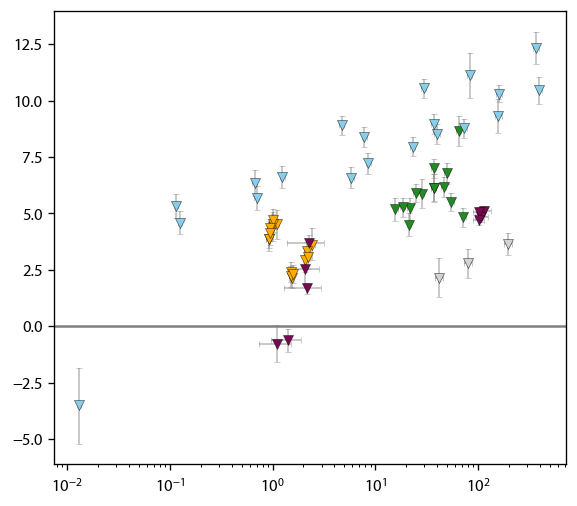

In [40]:
## Plotting Epsilon vs Ca/Carbion (called little r)
littler=MC_littler_median
littlerminerr=MC_littler_median-MC_littler_low95
littlermaxerr=MC_littler_up95-MC_littler_median

##Plotting Epsilon data

Ncolours={'NSanyalwildboot':"lightgray",'NFarmerwildboot':"forestgreen",'NKaczmarekwildboot':"#ffad01",'NUsCalcswildboot':"#750851",'NUsAragswildboot':"#750851",'NNoireauxCalcswildboot':"skyblue",'NNoireauxAragswildboot':"skyblue"}
Kcolours={'KSanyalwildboot':"lightgray",'KFarmerwildboot':"forestgreen",'KKaczmarekwildboot':"#ffad01",'KUsCalcswildboot':"#750851",'KUsAragswildboot':"#750851",'KNoireauxCalcswildboot':"skyblue",'KNoireauxAragswildboot':"skyblue"}
Nserieslabels={'NSanyalwildboot':'Sanyal et al., Calcites (remeasured)','NFarmerwildboot':'Farmer et al., Calcites','NKaczmarekwildboot':'Kaczmarek et al., Calcites','NUsCalcswildboot':'this study, Calcites','NUsAragswildboot':'this study, Aragonites','NNoireauxCalcswildboot':'Noireaux et al., Calcites', 'NNoireauxAragswildboot':'Noireaux et al., Aragonites'}
Kserieslabels={'KSanyalwildboot':'Sanyal et al., Calcites (remeasured)','KFarmerwildboot':'Farmer et al., Calcites','KKaczmarekwildboot':'Kaczmarek et al., Calcites','KUsCalcswildboot':'this study, Calcites','KUsAragswildboot':'this study, Aragonites','KNoireauxCalcswildboot':'Noireaux et al., Calcites', 'KNoireauxAragswildboot':'Noireaux et al., Aragonites'}

#residuald11BfromKlochko={}

#Kd11BOffset_median=pd.Series(Kd11BOffset.median(axis=1), index=df.index)
#Kd11BOffset_up95=pd.Series(np.quantile(Kd11BOffset, 0.975, axis=1),index=df.index)
#Kd11BOffset_low95=pd.Series(np.quantile(Kd11BOffset, 0.025, axis=1),index=df.index)
#Kd11BOffset_upErr=Kd11BOffset_up95-Kd11BOffset_median
#Kd11BOffset_lowErr=Kd11BOffset_median-Kd11BOffset_low95
highEpsErr=MCEpsilonKRae_up95-MCEpsilonKRae_median
lowEpsErr=MCEpsilonKRae_median-MCEpsilonKRae_low95

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(5.5,5))
ax1.set_xscale('log')
#ax1.set_xlim(-2.5,3)
#ax1.set_ylim(-4.5,13.5)
ax1.axhline(y=0, color='gray', zorder=0)
#ax1.errorbar(loglittler[(df.CalcOrArag=='Arag')], MCEpsilonKRae_median[(df.CalcOrArag=='Arag')],
#            xerr=[loglittlerminerr[(df.CalcOrArag=='Arag')],loglittlermaxerr[(df.CalcOrArag=='Arag')]],
#            yerr= [lowEpsErr[(df.CalcOrArag=='Arag')],highEpsErr[(df.CalcOrArag=='Arag')]],
#            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.errorbar(littler[(df.CalcOrArag=='Calc')], MCEpsilonKRae_median[(df.CalcOrArag=='Calc')],
            xerr=[littlerminerr[(df.CalcOrArag=='Calc')],littlermaxerr[(df.CalcOrArag=='Calc')]],
            yerr= [lowEpsErr[(df.CalcOrArag=='Calc')],highEpsErr[(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
for indices, names in zip([SanyalCalcs.index,FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['KSanyalwildboot','KFarmerwildboot','KKaczmarekwildboot','KUsCalcswildboot','KUsAragswildboot','KNoireauxCalcswildboot', 'KNoireauxAragswildboot']):
    #residuald11BfromKlochko[names]=d11Bmeas_MCmedian[indices]-d11BborateK_MCmedian[indices]
    if sum(df.Calc[indices])==0:
        #ax1.scatter(loglittler[indices],MCEpsilonKRae_median[indices], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
        pass
    else:
        ax1.scatter(littler[indices],MCEpsilonKRae_median[indices], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)

'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


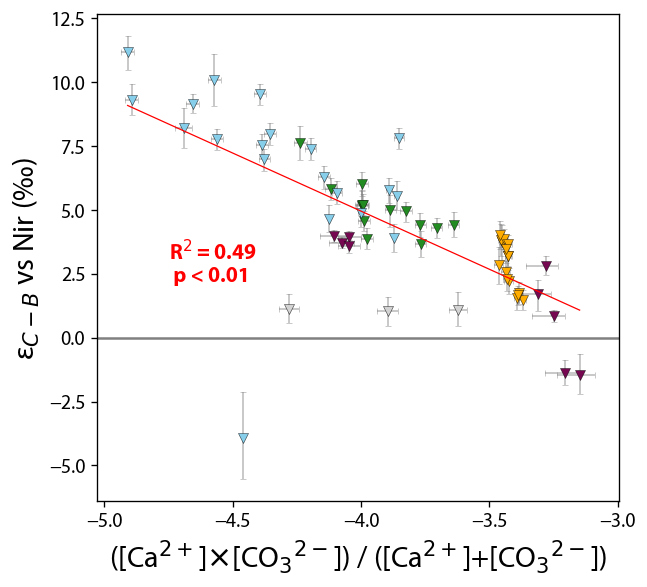

In [263]:

##Plotting Epsilon data

Ncolours={'NSanyalwildboot':"lightgray",'NFarmerwildboot':"forestgreen",'NKaczmarekwildboot':"#ffad01",'NUsCalcswildboot':"#750851",'NUsAragswildboot':"#750851",'NNoireauxCalcswildboot':"skyblue",'NNoireauxAragswildboot':"skyblue"}
Kcolours={'KSanyalwildboot':"lightgray",'KFarmerwildboot':"forestgreen",'KKaczmarekwildboot':"#ffad01",'KUsCalcswildboot':"#750851",'KUsAragswildboot':"#750851",'KNoireauxCalcswildboot':"skyblue",'KNoireauxAragswildboot':"skyblue"}
Nserieslabels={'NSanyalwildboot':'Sanyal et al., Calcites (remeasured)','NFarmerwildboot':'Farmer et al., Calcites','NKaczmarekwildboot':'Kaczmarek et al., Calcites','NUsCalcswildboot':'this study, Calcites','NUsAragswildboot':'this study, Aragonites','NNoireauxCalcswildboot':'Noireaux et al., Calcites', 'NNoireauxAragswildboot':'Noireaux et al., Aragonites'}
Kserieslabels={'KSanyalwildboot':'Sanyal et al., Calcites (remeasured)','KFarmerwildboot':'Farmer et al., Calcites','KKaczmarekwildboot':'Kaczmarek et al., Calcites','KUsCalcswildboot':'this study, Calcites','KUsAragswildboot':'this study, Aragonites','KNoireauxCalcswildboot':'Noireaux et al., Calcites', 'KNoireauxAragswildboot':'Noireaux et al., Aragonites'}

#residuald11BfromKlochko={}

#Kd11BOffset_median=pd.Series(Kd11BOffset.median(axis=1), index=df.index)
#Kd11BOffset_up95=pd.Series(np.quantile(Kd11BOffset, 0.975, axis=1),index=df.index)
#Kd11BOffset_low95=pd.Series(np.quantile(Kd11BOffset, 0.025, axis=1),index=df.index)
#Kd11BOffset_upErr=Kd11BOffset_up95-Kd11BOffset_median
#Kd11BOffset_lowErr=Kd11BOffset_median-Kd11BOffset_low95
highDEerr=MC_DavidMetric_up95-MC_DavidMetric_median
lowDEerr=MC_DavidMetric_median-MC_DavidMetric_low95
log10highDEerr=np.log10(MC_DavidMetric_up95)-np.log10(MC_DavidMetric_median)
log10lowDEerr=np.log10(MC_DavidMetric_median)-np.log10(MC_DavidMetric_low95)

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(5.5,5))
#ax1.set_xscale('log')
#ax1.set_xlim(-2.5,3)
#ax1.set_ylim(-4.5,13.5)
ax1.axhline(y=0, color='gray', zorder=0)
#ax1.errorbar(loglittler[(df.CalcOrArag=='Arag')], MCEpsilonKRae_median[(df.CalcOrArag=='Arag')],
#            xerr=[loglittlerminerr[(df.CalcOrArag=='Arag')],loglittlermaxerr[(df.CalcOrArag=='Arag')]],
#            yerr= [lowEpsErr[(df.CalcOrArag=='Arag')],highEpsErr[(df.CalcOrArag=='Arag')]],
#            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.errorbar(np.log10(MC_DavidMetric_median[(df.CalcOrArag=='Calc')]), MCEpsilonNRae_median[(df.CalcOrArag=='Calc')],
            xerr=[log10lowDEerr[(df.CalcOrArag=='Calc')],log10highDEerr[(df.CalcOrArag=='Calc')]],
            yerr= [lowEpsErr[(df.CalcOrArag=='Calc')],highEpsErr[(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')


temp=MCregressStats2(np.log10(MCDavidMetric),MCEpsilonNRae,True,reps)
X1=np.linspace(min(np.log10(MC_DavidMetric_median[(df.Calc==True)])),max(np.log10(MC_DavidMetric_median[(df.Calc==True)])),100)
if temp[3]<0.01:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75,label='Linear fit, all calcite data')
    ax1.text(-4.75,2.2,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=13,fontweight='bold')
elif temp[3]>0.05:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75, linestyle='--',label='Linear fit, all calcite data')
    ax1.text(-4.75,2.2,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=13,fontweight='bold')
else:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75, label='Linear fit, all calcite data')
    ax1.text(-4.75,2.2,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=13,fontweight='bold')

for indices, names in zip([SanyalCalcs.index,FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['KSanyalwildboot','KFarmerwildboot','KKaczmarekwildboot','KUsCalcswildboot','KUsAragswildboot','KNoireauxCalcswildboot', 'KNoireauxAragswildboot']):
    #residuald11BfromKlochko[names]=d11Bmeas_MCmedian[indices]-d11BborateK_MCmedian[indices]
    if sum(df.Calc[indices])==0:
        #ax1.scatter(loglittler[indices],MCEpsilonKRae_median[indices], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
        pass
    else:
        ax1.scatter(np.log10(MC_DavidMetric_median[indices]),MCEpsilonNRae_median[indices], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)
        
DavidResids=MCEpsilonNRae-((np.log10(MCDavidMetric)*temp[0])+temp[1])
ax1.tick_params(labelsize=12)
#ax2.tick_params(labelsize=12)
#ax2.yaxis.set_label_position('right')
ax1.set_xlabel(r'([Ca$^{2+}$]$\times$[CO$_3$$^{2-}$]) / ([Ca$^{2+}$]+[CO$_3$$^{2-}$])', fontsize=18)
#ax2.set_xlabel('log$_{10}$(([Ca]+[Mg])$_{free}$/[CO$_3$$^{2-}$]$_{free}$)', fontsize=18)
ax1.set_ylabel('ε$_{C-B}$ vs Nir (‰)', fontsize=18)
#ax2.set_ylabel('ε$_{C-B}$ (‰)', fontsize=18, labelpad=25, rotation=270)
#ax1.text(0.87, 12, 'a. α=1.00272', fontweight='semibold', color='black', fontsize=13)
#ax2.text(28.83, -4.37, 'Kim et al. 2007', color='blue', fontsize=10, rotation=270)
#ax2.text(28.055, -4.37, 'Kim & O`Neil 1997', color='red', fontsize=10, rotation=270)
#ax2.text(0.92, 12, 'b. α=1.0026', fontweight='semibold', color='black', fontsize=13)

fig.tight_layout() 
fig.savefig('Nepsilon vs DavidMetricwithSanyal2se.pdf')

'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Semibold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


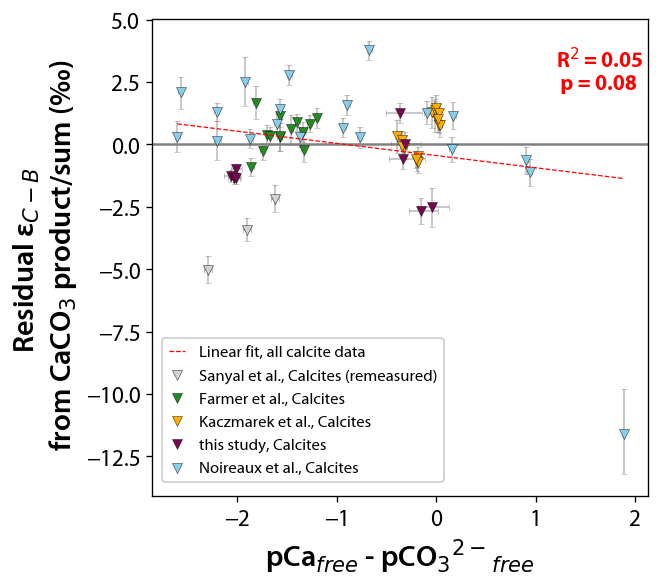

In [240]:

## Plotting residuals from the relationship with David's metric against pCa-pCO3

test1=(-1*np.log10(MC_Cafree))-(-1*np.log10(MCcarbion))
test2=(-1*np.log10(MC_Cafree + MC_Mgfree))-(-1*np.log10(MCcarbion))
test1_median=pd.Series(test1.median(axis=1), index=df.index)
test1_up95=pd.Series(np.quantile(test1, 0.95, axis=1), index=df.index)
test1_low95=pd.Series(np.quantile(test1, 0.05, axis=1), index=df.index)
test2_median=pd.Series(test2.median(axis=1), index=df.index)
test2_up95=pd.Series(np.quantile(test2, 0.95, axis=1), index=df.index)
test2_low95=pd.Series(np.quantile(test2, 0.05, axis=1), index=df.index)
test1uperr=test1_up95-test1_median
test1lowerr=test1_median-test1_low95
test2uperr=test2_up95-test2_median
test2lowerr=test2_median-test2_low95

DEresid_median=pd.Series(DavidResids.median(axis=1), index=df.index)
DEresid_up95=pd.Series(np.quantile(DavidResids, 0.95, axis=1), index=df.index)
DEresid_low95=pd.Series(np.quantile(DavidResids, 0.05, axis=1), index=df.index)
DEposerr=DEresid_up95-DEresid_median
DEminerr=DEresid_median-DEresid_low95

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(5.6,5))

#ax1.set_xlim(-3,2.5)
#ax1.set_ylim(-5,13.5)
ax1.axhline(y=0, color='gray', zorder=0)
#ax2.axhline(y=0, color='gray', zorder=0)
#ax1.errorbar(loglittler[(df.CalcOrArag=='Arag')], MCEpsilonKRae_median[(df.CalcOrArag=='Arag')],
#            xerr=[loglittlerminerr[(df.CalcOrArag=='Arag')],loglittlermaxerr[(df.CalcOrArag=='Arag')]],
#            yerr= [lowEpsErr[(df.CalcOrArag=='Arag')],highEpsErr[(df.CalcOrArag=='Arag')]],
#            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.errorbar(test1_median[(df.CalcOrArag=='Calc')], DEresid_median[(df.CalcOrArag=='Calc')],
            xerr=[test1lowerr[(df.CalcOrArag=='Calc')],test1uperr[(df.CalcOrArag=='Calc')]],
            yerr= [DEminerr[(df.CalcOrArag=='Calc')],DEposerr[(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

temp=MCregressStats2(test1,DavidResids,True,reps)
X1=np.linspace(min(test1_median[(df.Calc==True)]),max(test1_median[(df.Calc==True)]),100)
if temp[3]<0.01:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75,label='Linear fit, all calcite data')
    ax1.text(1.2,2.2,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=13,fontweight='bold')
elif temp[3]>0.05:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75, linestyle='--',label='Linear fit, all calcite data')
    ax1.text(1.2,2.2,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=13,fontweight='bold')
else:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75, label='Linear fit, all calcite data')
    ax1.text(1.2,2.2,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=13,fontweight='bold')
    
for indices, names in zip([SanyalCalcs.index, FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['KSanyalwildboot','KFarmerwildboot','KKaczmarekwildboot','KUsCalcswildboot','KUsAragswildboot','KNoireauxCalcswildboot', 'KNoireauxAragswildboot']):
    #residuald11BfromKlochko[names]=d11Bmeas_MCmedian[indices]-d11BborateK_MCmedian[indices]
    if sum(df.Calc[indices])==0:
        #ax1.scatter(loglittler[indices],MCEpsilonKRae_median[indices], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
        pass
    else:
        ax1.scatter(test1_median[indices],DEresid_median[indices], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)





#ax1.text(-2.2, 11.29, 'a.', color='black', fontsize=28,fontweight='semibold')
#ax2.text(-2, 11.29, 'b.', color='black', fontsize=28,fontweight='semibold')


#ax2.yaxis.tick_right()
ax1.tick_params(labelsize=14)
#ax2.tick_params(labelsize=12)
#ax2.yaxis.set_label_position('right')
ax1.set_xlabel('pCa$_{free}$ - pCO$_3$$^{2-}$$_{free}$', fontsize=18,fontweight='semibold')
#ax2.set_xlabel('log$_{10}$(([Ca]+[Mg])$_{free}$/[CO$_3$$^{2-}$]$_{free}$)', fontsize=18)
ax1.set_ylabel('Residual ε$_{C-B}$ \n from CaCO$_3$ product/sum (‰)', fontsize=18,fontweight='semibold')
#ax2.set_ylabel('ε$_{C-B}$ (‰)', fontsize=18, labelpad=25, rotation=270)
#ax1.text(0.87, 12, 'a. α=1.00272', fontweight='semibold', color='black', fontsize=13)
#ax2.text(28.83, -4.37, 'Kim et al. 2007', color='blue', fontsize=10, rotation=270)
#ax2.text(28.055, -4.37, 'Kim & O`Neil 1997', color='red', fontsize=10, rotation=270)
#ax2.text(0.92, 12, 'b. α=1.0026', fontweight='semibold', color='black', fontsize=13)
        
ax1.legend(loc=(0.02,0.03), framealpha=1,fontsize=10, handlelength=1)

fig.tight_layout() 

#print(-1*(np.log10(0.01))-(-1*(np.log10(0.002))))#
fig.savefig('KresidfromDEmetric vs pCa-pCO3withSanyal2se.pdf')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


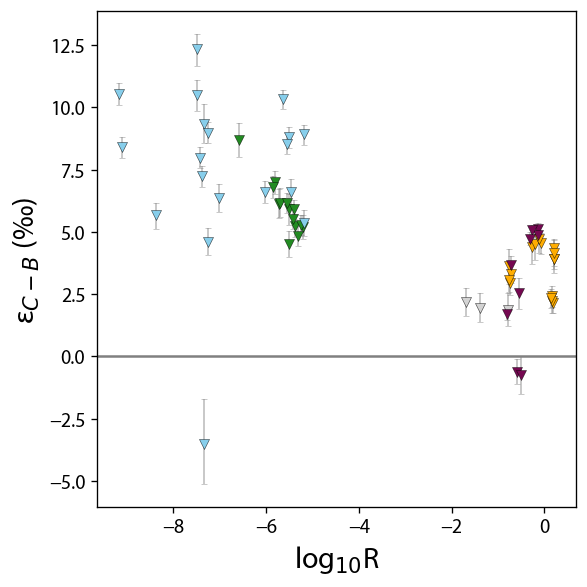

In [241]:

##Plotting Epsilon data vs log R

Ncolours={'NSanyalwildboot':"lightgray",'NFarmerwildboot':"forestgreen",'NKaczmarekwildboot':"#ffad01",'NUsCalcswildboot':"#750851",'NUsAragswildboot':"#750851",'NNoireauxCalcswildboot':"skyblue",'NNoireauxAragswildboot':"skyblue"}
Kcolours={'KSanyalwildboot':"lightgray",'KFarmerwildboot':"forestgreen",'KKaczmarekwildboot':"#ffad01",'KUsCalcswildboot':"#750851",'KUsAragswildboot':"#750851",'KNoireauxCalcswildboot':"skyblue",'KNoireauxAragswildboot':"skyblue"}
Nserieslabels={'NSanyalwildboot':'Sanyal et al., Calcites (remeasured)','NFarmerwildboot':'Farmer et al., Calcites','NKaczmarekwildboot':'Kaczmarek et al., Calcites','NUsCalcswildboot':'this study, Calcites','NUsAragswildboot':'this study, Aragonites','NNoireauxCalcswildboot':'Noireaux et al., Calcites', 'NNoireauxAragswildboot':'Noireaux et al., Aragonites'}
Kserieslabels={'KSanyalwildboot':'Sanyal et al., Calcites (remeasured)','KFarmerwildboot':'Farmer et al., Calcites','KKaczmarekwildboot':'Kaczmarek et al., Calcites','KUsCalcswildboot':'this study, Calcites','KUsAragswildboot':'this study, Aragonites','KNoireauxCalcswildboot':'Noireaux et al., Calcites', 'KNoireauxAragswildboot':'Noireaux et al., Aragonites'}


fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

#ax1.set_xlim(-2.5,3)
#ax1.set_ylim(-4.5,13.5)
ax1.axhline(y=0, color='gray', zorder=0)

#ax1.errorbar(loglittler[(df.CalcOrArag=='Arag')], MCEpsilonKRae_median[(df.CalcOrArag=='Arag')],
#            xerr=[loglittlerminerr[(df.CalcOrArag=='Arag')],loglittlermaxerr[(df.CalcOrArag=='Arag')]],
#            yerr= [lowEpsErr[(df.CalcOrArag=='Arag')],highEpsErr[(df.CalcOrArag=='Arag')]],
#            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.errorbar(df.logR[(df.CalcOrArag=='Calc')], MCEpsilonKRae_median[(df.CalcOrArag=='Calc')],
            yerr= [lowEpsErr[(df.CalcOrArag=='Calc')],highEpsErr[(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
for indices, names in zip([SanyalCalcs.index,FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['KSanyalwildboot','KFarmerwildboot','KKaczmarekwildboot','KUsCalcswildboot','KUsAragswildboot','KNoireauxCalcswildboot', 'KNoireauxAragswildboot']):
    #residuald11BfromKlochko[names]=d11Bmeas_MCmedian[indices]-d11BborateK_MCmedian[indices]
    if sum(df.Calc[indices])==0:
        #ax1.scatter(loglittler[indices],MCEpsilonKRae_median[indices], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
        pass
    else:
        ax1.scatter(df.logR[indices],MCEpsilonKRae_median[indices], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)


ax1.tick_params(labelsize=12)
ax1.set_xlabel(r'log$_{10}$R', fontsize=18)
#ax2.set_xlabel('log$_{10}$(([Ca]+[Mg])$_{free}$/[CO$_3$$^{2-}$]$_{free}$)', fontsize=18)
ax1.set_ylabel('ε$_{C-B}$ (‰)', fontsize=18)
fig.tight_layout() 
fig.savefig('Kepsilon vs logR.pdf')


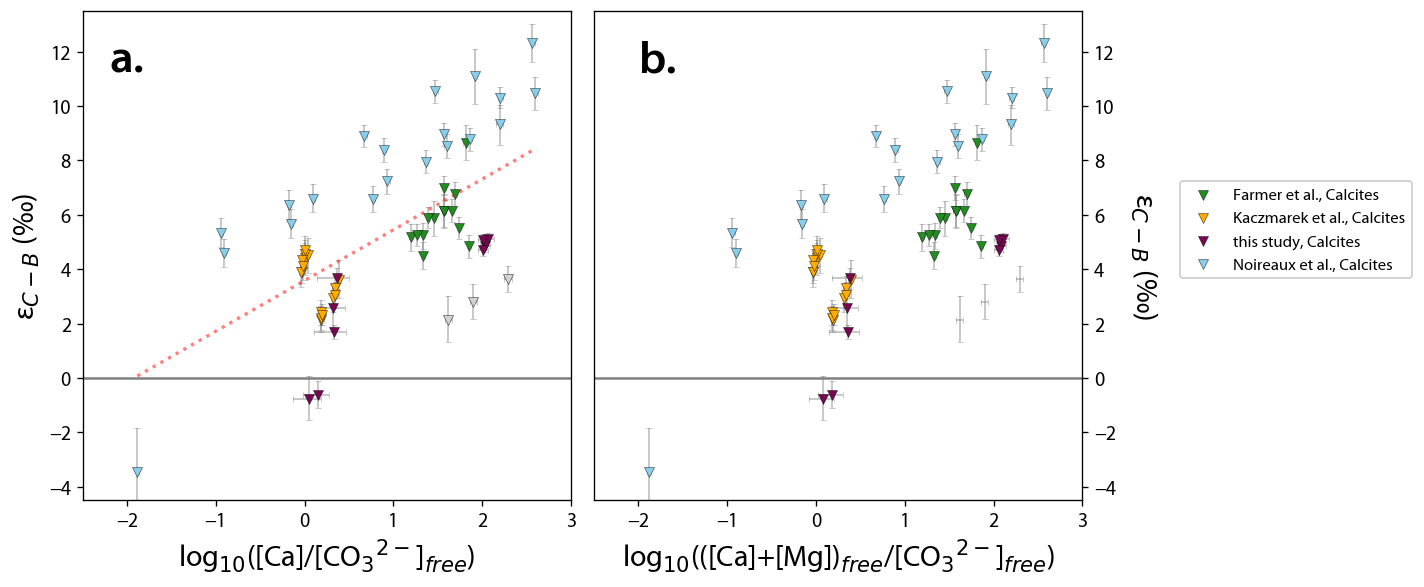

In [41]:
## Plotting Epsilon vs Ca/Carbion (called little r)
loglittler=np.log10(MC_littler_median)
loglittlerminerr=np.log10(MC_littler_median)-np.log10(MC_littler_low95)
loglittlermaxerr=np.log10(MC_littler_up95)-np.log10(MC_littler_median)

##Plotting Epsilon data

Ncolours={'NSanyalwildboot':"lightgray",'NFarmerwildboot':"forestgreen",'NKaczmarekwildboot':"#ffad01",'NUsCalcswildboot':"#750851",'NUsAragswildboot':"#750851",'NNoireauxCalcswildboot':"skyblue",'NNoireauxAragswildboot':"skyblue"}
Kcolours={'KSanyalwildboot':"lightgray",'KFarmerwildboot':"forestgreen",'KKaczmarekwildboot':"#ffad01",'KUsCalcswildboot':"#750851",'KUsAragswildboot':"#750851",'KNoireauxCalcswildboot':"skyblue",'KNoireauxAragswildboot':"skyblue"}
Nserieslabels={'NSanyalwildboot':'Sanyal et al., Calcites (remeasured)','NFarmerwildboot':'Farmer et al., Calcites','NKaczmarekwildboot':'Kaczmarek et al., Calcites','NUsCalcswildboot':'this study, Calcites','NUsAragswildboot':'this study, Aragonites','NNoireauxCalcswildboot':'Noireaux et al., Calcites', 'NNoireauxAragswildboot':'Noireaux et al., Aragonites'}
Kserieslabels={'KSanyalwildboot':'Sanyal et al., Calcites (remeasured)','KFarmerwildboot':'Farmer et al., Calcites','KKaczmarekwildboot':'Kaczmarek et al., Calcites','KUsCalcswildboot':'this study, Calcites','KUsAragswildboot':'this study, Aragonites','KNoireauxCalcswildboot':'Noireaux et al., Calcites', 'KNoireauxAragswildboot':'Noireaux et al., Aragonites'}

#residuald11BfromKlochko={}

#Kd11BOffset_median=pd.Series(Kd11BOffset.median(axis=1), index=df.index)
#Kd11BOffset_up95=pd.Series(np.quantile(Kd11BOffset, 0.975, axis=1),index=df.index)
#Kd11BOffset_low95=pd.Series(np.quantile(Kd11BOffset, 0.025, axis=1),index=df.index)
#Kd11BOffset_upErr=Kd11BOffset_up95-Kd11BOffset_median
#Kd11BOffset_lowErr=Kd11BOffset_median-Kd11BOffset_low95
highEpsErr=MCEpsilonKRae_up95-MCEpsilonKRae_median
lowEpsErr=MCEpsilonKRae_median-MCEpsilonKRae_low95

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax1.set_xlim(-2.5,3)
ax2.set_xlim(-2.5,3)
ax1.set_ylim(-4.5,13.5)
ax2.set_ylim(-4.5,13.5)
ax1.axhline(y=0, color='gray', zorder=0)
ax2.axhline(y=0, color='gray', zorder=0)
#ax1.errorbar(loglittler[(df.CalcOrArag=='Arag')], MCEpsilonKRae_median[(df.CalcOrArag=='Arag')],
#            xerr=[loglittlerminerr[(df.CalcOrArag=='Arag')],loglittlermaxerr[(df.CalcOrArag=='Arag')]],
#            yerr= [lowEpsErr[(df.CalcOrArag=='Arag')],highEpsErr[(df.CalcOrArag=='Arag')]],
#            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.errorbar(loglittler[(df.CalcOrArag=='Calc')], MCEpsilonKRae_median[(df.CalcOrArag=='Calc')],
            xerr=[loglittlerminerr[(df.CalcOrArag=='Calc')],loglittlermaxerr[(df.CalcOrArag=='Calc')]],
            yerr= [lowEpsErr[(df.CalcOrArag=='Calc')],highEpsErr[(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
for indices, names in zip([SanyalCalcs.index,FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['KSanyalwildboot','KFarmerwildboot','KKaczmarekwildboot','KUsCalcswildboot','KUsAragswildboot','KNoireauxCalcswildboot', 'KNoireauxAragswildboot']):
    #residuald11BfromKlochko[names]=d11Bmeas_MCmedian[indices]-d11BborateK_MCmedian[indices]
    if sum(df.Calc[indices])==0:
        #ax1.scatter(loglittler[indices],MCEpsilonKRae_median[indices], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
        pass
    else:
        ax1.scatter(loglittler[indices],MCEpsilonKRae_median[indices], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)


#ax2.axvline(x=(18.03*((10**3)/298.15)-32.42), color='red', linestyle=':',label='Equilibrium line, Calcite') ## Kim et al. 2007 Equilibrium Aragonite fractionation at 25˚C
#ax2.axvline(x=(17.88*((10**3)/298.15)-31.14), color='blue', linestyle=':',label='Equilibrium line, Aragonite') ## Kim & ONeil Equilibrium Calcite fractionation at 25˚C
ax2.errorbar(np.log10(MC_CaMgCarbion_median[(df.CalcOrArag=='Calc')]), MCEpsilonKRae_median[(df.CalcOrArag=='Calc')],
            yerr= [lowEpsErr[(df.CalcOrArag=='Calc')],highEpsErr[(df.CalcOrArag=='Calc')]],
            xerr= [(np.log10(MC_CaMgCarbion_median[(df.CalcOrArag=='Calc')])-np.log10(MC_CaMgCarbion_low95[(df.CalcOrArag=='Calc')])),(np.log10(MC_CaMgCarbion_up95[(df.CalcOrArag=='Calc')])-np.log10(MC_CaMgCarbion_median[(df.CalcOrArag=='Calc')]))],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

#ax2.scatter(np.log10(MC_CaMgCarbion_median[(df.CalcOrArag=='Calc')&(df.Study=='us')]),MCEpsilonKRae_median[(df.CalcOrArag=='Calc')&(df.Study=='us')], color='black',label='Calcites', facecolors='red', marker='o', linewidths=0.25)
#ax2.scatter(np.log10(MC_CaMgCarbion_median[(df.CalcOrArag=='Arag')&(df.Study=='us')]),MCEpsilonKRae_median[(df.CalcOrArag=='Arag')&(df.Study=='us')], color='black',label='Aragonites', facecolors='blue', marker='s', linewidths=0.25)
for indices, names in zip([FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['KFarmerwildboot','KKaczmarekwildboot','KUsCalcswildboot','KUsAragswildboot','KNoireauxCalcswildboot', 'KNoireauxAragswildboot']):
    #residuald11BfromKlochko[names]=d11Bmeas_MCmedian[indices]-d11BborateK_MCmedian[indices]
    if sum(df.Calc[indices])==0:
        #ax2.scatter(np.log10(MC_CaMgCarbion_median[indices]),MCEpsilonKRae_median[indices], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
        pass
    else:
        ax2.scatter(np.log10(MC_CaMgCarbion_median[indices]),MCEpsilonKRae_median[indices], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)
        
        
#ax2.scatter(d11Bmeas_MCmedian[FarmerCalcs.index],Kpredictedd11Bcarb['KFarmerwildboot'])

#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )
#bbox_to_anchor=(1.51, 0.21)
#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )

#ax1.text(7.3, 1.4222, 'a. this study', fontweight='semibold', color='black', fontsize=13)
#ax2.text(7.3, 1.4, 'b. existing data', fontweight='semibold', color='black', fontsize=13)


X = loglittler[(df.CalcOrArag=='Calc')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = MCEpsilonKRae_median[(df.CalcOrArag=='Calc')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
X1=np.linspace(min(X),max(X),10)
Y_pred = linear_regressor.predict(X1)  # make predictions
ax1.plot(X1, Y_pred, color='red', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Calcites')

#X = loglittler[(df.CalcOrArag=='Arag')].values.reshape(-1, 1)  # values converts it into a numpy array
#Y = MCEpsilonKRae_median[(df.CalcOrArag=='Arag')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
#linear_regressor = LinearRegression()  # create object for the class
#linear_regressor.fit(X,Y) # perform linear regression
#X1=np.linspace(min(X),max(X),10)
#Y_pred = linear_regressor.predict(X1)  # make predictions
#ax1.plot(X1, Y_pred, color='blue', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Aragonites')

#ax1.legend(loc=(0.58,0.65), framealpha=1,fontsize=10)
ax2.legend(loc=(1.2,0.4535), framealpha=1,fontsize=10)

ax1.text(-2.2, 11.29, 'a.', color='black', fontsize=28,fontweight='semibold')
ax2.text(-2, 11.29, 'b.', color='black', fontsize=28,fontweight='semibold')


ax2.yaxis.tick_right()
ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
ax2.yaxis.set_label_position('right')
ax1.set_xlabel('log$_{10}$([Ca]/[CO$_3$$^{2-}$]$_{free}$)', fontsize=18)
ax2.set_xlabel('log$_{10}$(([Ca]+[Mg])$_{free}$/[CO$_3$$^{2-}$]$_{free}$)', fontsize=18)
ax1.set_ylabel('ε$_{C-B}$ (‰)', fontsize=18)
ax2.set_ylabel('ε$_{C-B}$ (‰)', fontsize=18, labelpad=25, rotation=270)
#ax1.text(0.87, 12, 'a. α=1.00272', fontweight='semibold', color='black', fontsize=13)
#ax2.text(28.83, -4.37, 'Kim et al. 2007', color='blue', fontsize=10, rotation=270)
#ax2.text(28.055, -4.37, 'Kim & O`Neil 1997', color='red', fontsize=10, rotation=270)
#ax2.text(0.92, 12, 'b. α=1.0026', fontweight='semibold', color='black', fontsize=13)

fig.tight_layout() 




'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Semibold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


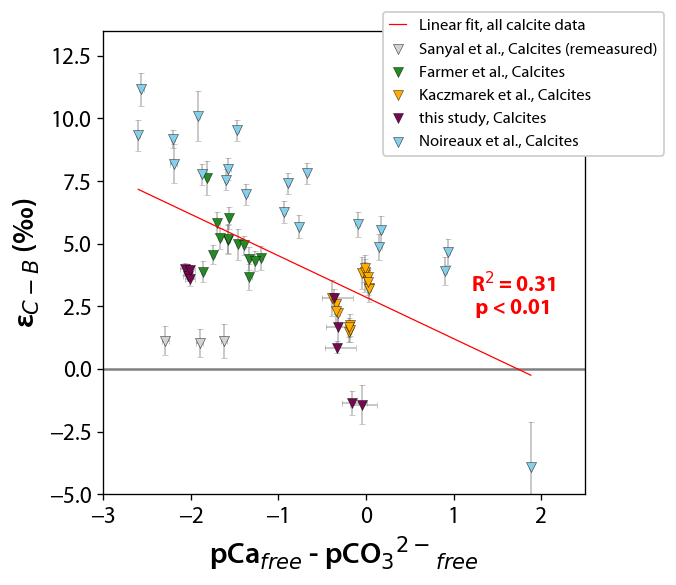

In [253]:
 
## Plotting Epsilon data in relation to the principal PDIs --- NIR alpha!!

## Plotting this a different way
test1=(-1*np.log10(MC_Cafree))-(-1*np.log10(MCcarbion))
test2=(-1*np.log10(MC_Cafree + MC_Mgfree))-(-1*np.log10(MCcarbion))
test1_median=pd.Series(test1.median(axis=1), index=df.index)
test1_up95=pd.Series(np.quantile(test1, 0.95, axis=1), index=df.index)
test1_low95=pd.Series(np.quantile(test1, 0.05, axis=1), index=df.index)
test2_median=pd.Series(test2.median(axis=1), index=df.index)
test2_up95=pd.Series(np.quantile(test2, 0.95, axis=1), index=df.index)
test2_low95=pd.Series(np.quantile(test2, 0.05, axis=1), index=df.index)
test1uperr=test1_up95-test1_median
test1lowerr=test1_median-test1_low95
test2uperr=test2_up95-test2_median
test2lowerr=test2_median-test2_low95

##Plotting Epsilon data

Ncolours={'NSanyalwildboot':"lightgray",'NFarmerwildboot':"forestgreen",'NKaczmarekwildboot':"#ffad01",'NUsCalcswildboot':"#750851",'NUsAragswildboot':"#750851",'NNoireauxCalcswildboot':"skyblue",'NNoireauxAragswildboot':"skyblue"}
Kcolours={'KSanyalwildboot':"lightgray",'KFarmerwildboot':"forestgreen",'KKaczmarekwildboot':"#ffad01",'KUsCalcswildboot':"#750851",'KUsAragswildboot':"#750851",'KNoireauxCalcswildboot':"skyblue",'KNoireauxAragswildboot':"skyblue"}
Nserieslabels={'NSanyalwildboot':'Sanyal et al., Calcites (remeasured)','NFarmerwildboot':'Farmer et al., Calcites','NKaczmarekwildboot':'Kaczmarek et al., Calcites','NUsCalcswildboot':'this study, Calcites','NUsAragswildboot':'this study, Aragonites','NNoireauxCalcswildboot':'Noireaux et al., Calcites', 'NNoireauxAragswildboot':'Noireaux et al., Aragonites'}
Kserieslabels={'KSanyalwildboot':'Sanyal et al., Calcites (remeasured)','KFarmerwildboot':'Farmer et al., Calcites','KKaczmarekwildboot':'Kaczmarek et al., Calcites','KUsCalcswildboot':'this study, Calcites','KUsAragswildboot':'this study, Aragonites','KNoireauxCalcswildboot':'Noireaux et al., Calcites', 'KNoireauxAragswildboot':'Noireaux et al., Aragonites'}

#residuald11BfromKlochko={}

#Kd11BOffset_median=pd.Series(Kd11BOffset.median(axis=1), index=df.index)
#Kd11BOffset_up95=pd.Series(np.quantile(Kd11BOffset, 0.975, axis=1),index=df.index)
#Kd11BOffset_low95=pd.Series(np.quantile(Kd11BOffset, 0.025, axis=1),index=df.index)
#Kd11BOffset_upErr=Kd11BOffset_up95-Kd11BOffset_median
#Kd11BOffset_lowErr=Kd11BOffset_median-Kd11BOffset_low95
#highEpsErr=MCEpsilonKRae_up95-MCEpsilonKRae_median
#lowEpsErr=MCEpsilonKRae_median-MCEpsilonKRae_low95
highEpsErr=MCEpsilonNRae_up95-MCEpsilonNRae_median
lowEpsErr=MCEpsilonNRae_median-MCEpsilonNRae_low95

#fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(5.6,5))

ax1.set_xlim(-3,2.5)
#ax2.set_xlim(-3,3)
ax1.set_ylim(-5,13.5)
#ax2.set_ylim(-4.5,13.5)
ax1.axhline(y=0, color='gray', zorder=0)
#ax2.axhline(y=0, color='gray', zorder=0)
#ax1.errorbar(loglittler[(df.CalcOrArag=='Arag')], MCEpsilonKRae_median[(df.CalcOrArag=='Arag')],
#            xerr=[loglittlerminerr[(df.CalcOrArag=='Arag')],loglittlermaxerr[(df.CalcOrArag=='Arag')]],
#            yerr= [lowEpsErr[(df.CalcOrArag=='Arag')],highEpsErr[(df.CalcOrArag=='Arag')]],
#            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.errorbar(test1_median[(df.CalcOrArag=='Calc')], MCEpsilonNRae_median[(df.CalcOrArag=='Calc')],
            xerr=[test1lowerr[(df.CalcOrArag=='Calc')],test1uperr[(df.CalcOrArag=='Calc')]],
            yerr= [lowEpsErr[(df.CalcOrArag=='Calc')],highEpsErr[(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

temp=MCregressStats2(test1,MCEpsilonNRae,True,reps)
X1=np.linspace(min(test1_median[(df.Calc==True)]),max(test1_median[(df.Calc==True)]),100)
if temp[3]<0.01:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75,label='Linear fit, all calcite data')
    ax1.text(1.2,2.2,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=13,fontweight='bold')
elif temp[3]>0.05:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75, linestyle='--',label='Linear fit, all calcite data')
    ax1.text(1.2,2.2,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=13,fontweight='bold')
else:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75, label='Linear fit, all calcite data')
    ax1.text(1.2,2.2,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=13,fontweight='bold')
    
for indices, names in zip([SanyalCalcs.index, FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['NSanyalwildboot','NFarmerwildboot','NKaczmarekwildboot','NUsCalcswildboot','NUsAragswildboot','NNoireauxCalcswildboot', 'NNoireauxAragswildboot']):
    #residuald11BfromKlochko[names]=d11Bmeas_MCmedian[indices]-d11BborateK_MCmedian[indices]
    if sum(df.Calc[indices])==0:
        #ax1.scatter(loglittler[indices],MCEpsilonKRae_median[indices], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
        pass
    else:
        ax1.scatter(test1_median[indices],MCEpsilonNRae_median[indices], color='black', facecolors=Ncolours[names], label=Nserieslabels[names], marker='v', linewidths=0.25, zorder=2)


#ax1.legend(loc=(0.58,0.65), framealpha=1,fontsize=10)
ax1.legend(loc=(0.58,0.73), framealpha=1,fontsize=10, handlelength=1)

#ax1.text(-2.2, 11.29, 'a.', color='black', fontsize=28,fontweight='semibold')
#ax2.text(-2, 11.29, 'b.', color='black', fontsize=28,fontweight='semibold')


#ax2.yaxis.tick_right()
ax1.tick_params(labelsize=14)
#ax2.tick_params(labelsize=12)
#ax2.yaxis.set_label_position('right')
ax1.set_xlabel('pCa$_{free}$ - pCO$_3$$^{2-}$$_{free}$', fontsize=18,fontweight='semibold')
#ax2.set_xlabel('log$_{10}$(([Ca]+[Mg])$_{free}$/[CO$_3$$^{2-}$]$_{free}$)', fontsize=18)
ax1.set_ylabel('ε$_{C-B}$ (‰)', fontsize=18,fontweight='semibold')
#ax2.set_ylabel('ε$_{C-B}$ (‰)', fontsize=18, labelpad=25, rotation=270)
#ax1.text(0.87, 12, 'a. α=1.00272', fontweight='semibold', color='black', fontsize=13)
#ax2.text(28.83, -4.37, 'Kim et al. 2007', color='blue', fontsize=10, rotation=270)
#ax2.text(28.055, -4.37, 'Kim & O`Neil 1997', color='red', fontsize=10, rotation=270)
#ax2.text(0.92, 12, 'b. α=1.0026', fontweight='semibold', color='black', fontsize=13)


fig.tight_layout() 

#print(-1*(np.log10(0.01))-(-1*(np.log10(0.002))))
fig.savefig('Nepsilon vs pCa-pCO3withSanyal2se.pdf')

'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Semibold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


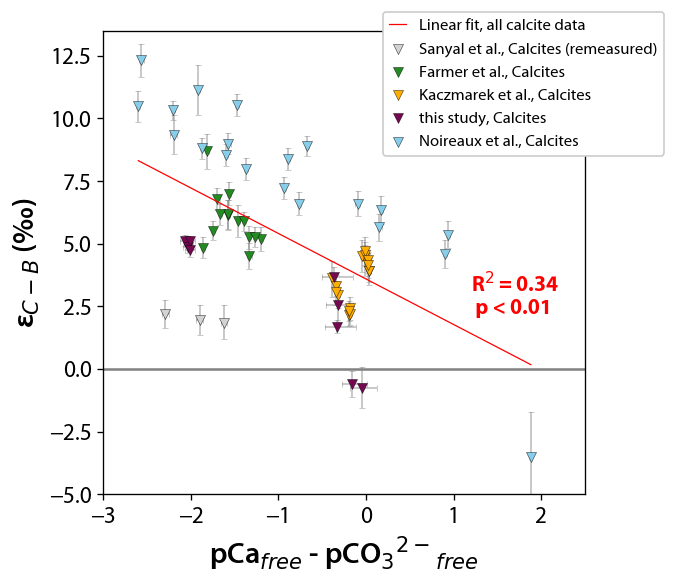

In [247]:

## Plotting Epsilon data in relation to the principal PDIs  ---- Klochko alpha!!

## Plotting this a different way
test1=(-1*np.log10(MC_Cafree))-(-1*np.log10(MCcarbion))
test2=(-1*np.log10(MC_Cafree + MC_Mgfree))-(-1*np.log10(MCcarbion))
test1_median=pd.Series(test1.median(axis=1), index=df.index)
test1_up95=pd.Series(np.quantile(test1, 0.95, axis=1), index=df.index)
test1_low95=pd.Series(np.quantile(test1, 0.05, axis=1), index=df.index)
test2_median=pd.Series(test2.median(axis=1), index=df.index)
test2_up95=pd.Series(np.quantile(test2, 0.95, axis=1), index=df.index)
test2_low95=pd.Series(np.quantile(test2, 0.05, axis=1), index=df.index)
test1uperr=test1_up95-test1_median
test1lowerr=test1_median-test1_low95
test2uperr=test2_up95-test2_median
test2lowerr=test2_median-test2_low95

##Plotting Epsilon data

Ncolours={'NSanyalwildboot':"lightgray",'NFarmerwildboot':"forestgreen",'NKaczmarekwildboot':"#ffad01",'NUsCalcswildboot':"#750851",'NUsAragswildboot':"#750851",'NNoireauxCalcswildboot':"skyblue",'NNoireauxAragswildboot':"skyblue"}
Kcolours={'KSanyalwildboot':"lightgray",'KFarmerwildboot':"forestgreen",'KKaczmarekwildboot':"#ffad01",'KUsCalcswildboot':"#750851",'KUsAragswildboot':"#750851",'KNoireauxCalcswildboot':"skyblue",'KNoireauxAragswildboot':"skyblue"}
Nserieslabels={'NSanyalwildboot':'Sanyal et al., Calcites (remeasured)','NFarmerwildboot':'Farmer et al., Calcites','NKaczmarekwildboot':'Kaczmarek et al., Calcites','NUsCalcswildboot':'this study, Calcites','NUsAragswildboot':'this study, Aragonites','NNoireauxCalcswildboot':'Noireaux et al., Calcites', 'NNoireauxAragswildboot':'Noireaux et al., Aragonites'}
Kserieslabels={'KSanyalwildboot':'Sanyal et al., Calcites (remeasured)','KFarmerwildboot':'Farmer et al., Calcites','KKaczmarekwildboot':'Kaczmarek et al., Calcites','KUsCalcswildboot':'this study, Calcites','KUsAragswildboot':'this study, Aragonites','KNoireauxCalcswildboot':'Noireaux et al., Calcites', 'KNoireauxAragswildboot':'Noireaux et al., Aragonites'}

#residuald11BfromKlochko={}

#Kd11BOffset_median=pd.Series(Kd11BOffset.median(axis=1), index=df.index)
#Kd11BOffset_up95=pd.Series(np.quantile(Kd11BOffset, 0.975, axis=1),index=df.index)
#Kd11BOffset_low95=pd.Series(np.quantile(Kd11BOffset, 0.025, axis=1),index=df.index)
#Kd11BOffset_upErr=Kd11BOffset_up95-Kd11BOffset_median
#Kd11BOffset_lowErr=Kd11BOffset_median-Kd11BOffset_low95
highEpsErr=MCEpsilonKRae_up95-MCEpsilonKRae_median
lowEpsErr=MCEpsilonKRae_median-MCEpsilonKRae_low95

#fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(5.6,5))

ax1.set_xlim(-3,2.5)
#ax2.set_xlim(-3,3)
ax1.set_ylim(-5,13.5)
#ax2.set_ylim(-4.5,13.5)
ax1.axhline(y=0, color='gray', zorder=0)
#ax2.axhline(y=0, color='gray', zorder=0)
#ax1.errorbar(loglittler[(df.CalcOrArag=='Arag')], MCEpsilonKRae_median[(df.CalcOrArag=='Arag')],
#            xerr=[loglittlerminerr[(df.CalcOrArag=='Arag')],loglittlermaxerr[(df.CalcOrArag=='Arag')]],
#            yerr= [lowEpsErr[(df.CalcOrArag=='Arag')],highEpsErr[(df.CalcOrArag=='Arag')]],
#            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.errorbar(test1_median[(df.CalcOrArag=='Calc')], MCEpsilonKRae_median[(df.CalcOrArag=='Calc')],
            xerr=[test1lowerr[(df.CalcOrArag=='Calc')],test1uperr[(df.CalcOrArag=='Calc')]],
            yerr= [lowEpsErr[(df.CalcOrArag=='Calc')],highEpsErr[(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

temp=MCregressStats2(test1,MCEpsilonKRae,True,reps)
X1=np.linspace(min(test1_median[(df.Calc==True)]),max(test1_median[(df.Calc==True)]),100)
if temp[3]<0.01:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75,label='Linear fit, all calcite data')
    ax1.text(1.2,2.2,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=13,fontweight='bold')
elif temp[3]>0.05:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75, linestyle='--',label='Linear fit, all calcite data')
    ax1.text(1.2,2.2,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=13,fontweight='bold')
else:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75, label='Linear fit, all calcite data')
    ax1.text(1.2,2.2,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=13,fontweight='bold')
    
for indices, names in zip([SanyalCalcs.index, FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['KSanyalwildboot','KFarmerwildboot','KKaczmarekwildboot','KUsCalcswildboot','KUsAragswildboot','KNoireauxCalcswildboot', 'KNoireauxAragswildboot']):
    #residuald11BfromKlochko[names]=d11Bmeas_MCmedian[indices]-d11BborateK_MCmedian[indices]
    if sum(df.Calc[indices])==0:
        #ax1.scatter(loglittler[indices],MCEpsilonKRae_median[indices], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
        pass
    else:
        ax1.scatter(test1_median[indices],MCEpsilonKRae_median[indices], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)


    

#ax2.axvline(x=(18.03*((10**3)/298.15)-32.42), color='red', linestyle=':',label='Equilibrium line, Calcite') ## Kim et al. 2007 Equilibrium Aragonite fractionation at 25˚C
#ax2.axvline(x=(17.88*((10**3)/298.15)-31.14), color='blue', linestyle=':',label='Equilibrium line, Aragonite') ## Kim & ONeil Equilibrium Calcite fractionation at 25˚C
#ax2.errorbar(-1*np.log10(MC_Cafree_median[(df.CalcOrArag=='Calc')]), MCEpsilonKRae_median[(df.CalcOrArag=='Calc')],
#            yerr= [lowEpsErr[(df.CalcOrArag=='Calc')],highEpsErr[(df.CalcOrArag=='Calc')]],
            #xerr= [test2lowerr[(df.CalcOrArag=='Calc')],test2uperr[(df.CalcOrArag=='Calc')]],
#            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

#ax2.scatter(np.log10(MC_CaMgCarbion_median[(df.CalcOrArag=='Calc')&(df.Study=='us')]),MCEpsilonKRae_median[(df.CalcOrArag=='Calc')&(df.Study=='us')], color='black',label='Calcites', facecolors='red', marker='o', linewidths=0.25)
#ax2.scatter(np.log10(MC_CaMgCarbion_median[(df.CalcOrArag=='Arag')&(df.Study=='us')]),MCEpsilonKRae_median[(df.CalcOrArag=='Arag')&(df.Study=='us')], color='black',label='Aragonites', facecolors='blue', marker='s', linewidths=0.25)
#for indices, names in zip([FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['KFarmerwildboot','KKaczmarekwildboot','KUsCalcswildboot','KUsAragswildboot','KNoireauxCalcswildboot', 'KNoireauxAragswildboot']):
#    #residuald11BfromKlochko[names]=d11Bmeas_MCmedian[indices]-d11BborateK_MCmedian[indices]
#    if sum(df.Calc[indices])==0:
#        #ax2.scatter(np.log10(MC_CaMgCarbion_median[indices]),MCEpsilonKRae_median[indices], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
#        pass
#    else:
#        ax2.scatter(-1*np.log10(MC_Cafree_median[indices]),MCEpsilonKRae_median[indices], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)
        
        
#ax2.scatter(d11Bmeas_MCmedian[FarmerCalcs.index],Kpredictedd11Bcarb['KFarmerwildboot'])

#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )
#bbox_to_anchor=(1.51, 0.21)
#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )

#ax1.text(7.3, 1.4222, 'a. this study', fontweight='semibold', color='black', fontsize=13)
#ax2.text(7.3, 1.4, 'b. existing data', fontweight='semibold', color='black', fontsize=13)


#X = test1_median[(df.CalcOrArag=='Calc')].values.reshape(-1, 1)  # values converts it into a numpy array
#Y = MCEpsilonKRae_median[(df.CalcOrArag=='Calc')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
#linear_regressor = LinearRegression()  # create object for the class
#linear_regressor.fit(X,Y)  # perform linear regression
#X1=np.linspace(min(X),max(X),10)
#Y_pred = linear_regressor.predict(X1)  # make predictions
#ax1.plot(X1, Y_pred, color='red', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, all calcites')

#X = loglittler[(df.CalcOrArag=='Arag')].values.reshape(-1, 1)  # values converts it into a numpy array
#Y = MCEpsilonKRae_median[(df.CalcOrArag=='Arag')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
#linear_regressor = LinearRegression()  # create object for the class
#linear_regressor.fit(X,Y) # perform linear regression
#X1=np.linspace(min(X),max(X),10)
#Y_pred = linear_regressor.predict(X1)  # make predictions
#ax1.plot(X1, Y_pred, color='blue', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Aragonites')

#ax1.legend(loc=(0.58,0.65), framealpha=1,fontsize=10)
ax1.legend(loc=(0.58,0.73), framealpha=1,fontsize=10, handlelength=1)

#ax1.text(-2.2, 11.29, 'a.', color='black', fontsize=28,fontweight='semibold')
#ax2.text(-2, 11.29, 'b.', color='black', fontsize=28,fontweight='semibold')


#ax2.yaxis.tick_right()
ax1.tick_params(labelsize=14)
#ax2.tick_params(labelsize=12)
#ax2.yaxis.set_label_position('right')
ax1.set_xlabel('pCa$_{free}$ - pCO$_3$$^{2-}$$_{free}$', fontsize=18,fontweight='semibold')
#ax2.set_xlabel('log$_{10}$(([Ca]+[Mg])$_{free}$/[CO$_3$$^{2-}$]$_{free}$)', fontsize=18)
ax1.set_ylabel('ε$_{C-B}$ (‰)', fontsize=18,fontweight='semibold')
#ax2.set_ylabel('ε$_{C-B}$ (‰)', fontsize=18, labelpad=25, rotation=270)
#ax1.text(0.87, 12, 'a. α=1.00272', fontweight='semibold', color='black', fontsize=13)
#ax2.text(28.83, -4.37, 'Kim et al. 2007', color='blue', fontsize=10, rotation=270)
#ax2.text(28.055, -4.37, 'Kim & O`Neil 1997', color='red', fontsize=10, rotation=270)
#ax2.text(0.92, 12, 'b. α=1.0026', fontweight='semibold', color='black', fontsize=13)


fig.tight_layout() 

#print(-1*(np.log10(0.01))-(-1*(np.log10(0.002))))
fig.savefig('Kepsilon vs pCa-pCO3withSanyal2se.pdf')

'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Semibold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


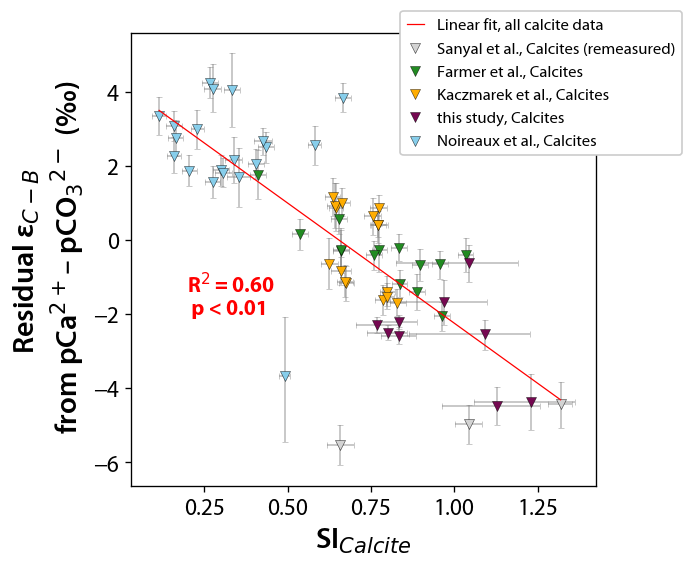

In [254]:
## plotting resid from this relationship against SI  -- Note this uses whichever one of the relationships above were done first- Klochko or Nir

residpCapCO=MCEpsilonNRae-(test1*temp[0] + temp[1])  ## Edit this according to what you last ran!!!!!
residpCapCO_median=pd.Series(residpCapCO.median(axis=1), index=df.index)
residpCapCO_up95=pd.Series(np.quantile(residpCapCO, 0.95, axis=1), index=df.index)
residpCapCO_low95=pd.Series(np.quantile(residpCapCO, 0.05, axis=1), index=df.index)

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

ax1.errorbar(MC_SICalc_median[(df.CalcOrArag=='Calc')], residpCapCO_median[(df.CalcOrArag=='Calc')],
            xerr=[lowSICalcErr[(df.CalcOrArag=='Calc')],highSICalcErr[(df.CalcOrArag=='Calc')]],
            yerr=[residpCapCO_up95[(df.CalcOrArag=='Calc')]-residpCapCO_median[(df.CalcOrArag=='Calc')],residpCapCO_median[(df.CalcOrArag=='Calc')]-residpCapCO_low95[(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

for indices, names in zip([SanyalCalcs.index, FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['KSanyalwildboot','KFarmerwildboot','KKaczmarekwildboot','KUsCalcswildboot','KUsAragswildboot','KNoireauxCalcswildboot', 'KNoireauxAragswildboot']):
    #residuald11BfromKlochko[names]=d11Bmeas_MCmedian[indices]-d11BborateK_MCmedian[indices]
    if sum(df.Calc[indices])==0:
        #ax1.scatter(loglittler[indices],MCEpsilonKRae_median[indices], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
        pass
    else:
        ax1.scatter(MC_SICalc_median[indices],residpCapCO_median[indices], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)

ax1.tick_params(labelsize=14)
#ax2.tick_params(labelsize=12)
#ax2.yaxis.set_label_position('right')
ax1.set_xlabel('SI$_{Calcite}$', fontsize=18,fontweight='semibold')
#ax2.set_xlabel('log$_{10}$(([Ca]+[Mg])$_{free}$/[CO$_3$$^{2-}$]$_{free}$)', fontsize=18)
ax1.set_ylabel('Residual ε$_{C-B}$ \n from pCa$^{2+}$– pCO$_3$$^{2-}$ (‰)', fontsize=18,fontweight='semibold')

residtemp=MCregressStats2(MC_SICalc,residpCapCO,True,reps)
X1=np.linspace(min(MC_SICalc_median[(df.Calc==True)]),max(MC_SICalc_median[(df.Calc==True)]),100)
if residtemp[3]<0.01:
    ax1.plot(X1,X1*residtemp[0] + residtemp[1], color='red', linewidth=0.75,label='Linear fit, all calcite data')
    ax1.text(0.2,-2,'R$^2$ = %.2f \n p < 0.01' % residtemp[2]**2, color='red', fontsize=13,fontweight='bold')
elif temp[3]>0.05:
    ax1.plot(X1,X1*residtemp[0] + residtemp[1], color='red', linewidth=0.75, linestyle='--',label='Linear fit, all calcite data')
    ax1.text(0.2,-2,'R$^2$ = %.2f \n p = %.2f' % (residtemp[2]**2,residtemp[3]), color='red', fontsize=13,fontweight='bold')
else:
    ax1.plot(X1,X1*residtemp[0] + residtemp[1], color='red', linewidth=0.75, label='Linear fit, all calcite data')
    ax1.text(0.2,-2,'R$^2$ = %.2f \n p = %.2f' % (residtemp[2]**2,residtemp[3]), color='red', fontsize=13,fontweight='bold')
    
    
ax1.legend(loc=(0.58,0.73), framealpha=1,fontsize=10, handlelength=1)
fig.savefig('Nresid from pCa-pCO3 vs SIwithSanyal2se.pdf')

'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Semibold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


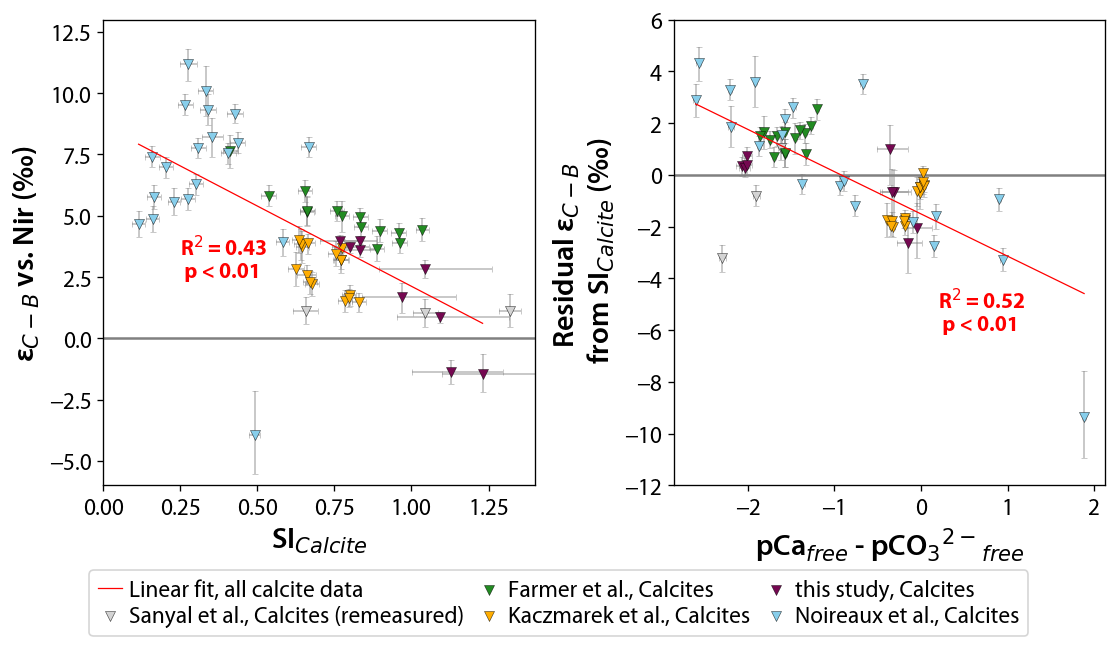

In [262]:
#residfromEpsSI  note.. this is whatever you used (Nir/Klochko) from above.. 

test1uperr=test1_up95-test1_median
test1lowerr=test1_median-test1_low95
test2uperr=test2_up95-test2_median
test2lowerr=test2_median-test2_low95


#highEpsErr=MCEpsilonKRae_up95-MCEpsilonKRae_median
#lowEpsErr=MCEpsilonKRae_median-MCEpsilonKRae_low95
highEpsErr=MCEpsilonNRae_up95-MCEpsilonNRae_median
lowEpsErr=MCEpsilonNRae_median-MCEpsilonNRae_low95

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10.5,6))

ax1.set_xlim(0,1.4)
#ax2.set_xlim(0,1.4)
ax1.set_ylim(-6,13)
ax1.tick_params(labelsize=14)
ax1.axhline(y=0, color='gray', zorder=0)

ax1.errorbar(MC_SICalc_median[(df.CalcOrArag=='Calc')], MCEpsilonNRae_median[(df.CalcOrArag=='Calc')],
            xerr=[highSICalcErr[(df.CalcOrArag=='Calc')],lowSICalcErr[(df.CalcOrArag=='Calc')]],
            yerr= [lowEpsErr[(df.CalcOrArag=='Calc')],highEpsErr[(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

temp=MCregressStats2(MC_SICalc,MCEpsilonNRae,True,reps)
X1=np.linspace(min(MC_SICalc_median[(df.Calc==True)]),max(MC_SICalc_median[(df.Study=='us')&(df.Calc==True)]),100)
if temp[3]<0.01:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75,label='Linear fit, all calcite data')
    ax1.text(0.25,2.5,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=13,fontweight='bold')
elif temp[3]>0.05:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75, linestyle='--',label='Linear fit, all calcite data')
    ax1.text(0.25,2.5,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=13,fontweight='bold')
else:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75, label='Linear fit, all calcite data')
    ax1.text(0.25,2.5,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=13,fontweight='bold')
    
residfromEpsSI=MCEpsilonNRae-((MC_SICalc*temp[0])+temp[1])
residfromEpsSI_median=pd.Series(residfromEpsSI.median(axis=1), index=df.index)
residfromEpsSI_up95=pd.Series(np.quantile(residfromEpsSI, 0.95, axis=1), index=df.index)
residfromEpsSI_low95=pd.Series(np.quantile(residfromEpsSI, 0.05, axis=1), index=df.index)
    
for indices, names in zip([SanyalCalcs.index, FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['NSanyalwildboot','NFarmerwildboot','NKaczmarekwildboot','NUsCalcswildboot','NUsAragswildboot','NNoireauxCalcswildboot', 'NNoireauxAragswildboot']):
    #residuald11BfromKlochko[names]=d11Bmeas_MCmedian[indices]-d11BborateK_MCmedian[indices]
    if sum(df.Calc[indices])==0:
        pass
    else:
        ax1.scatter(MC_SICalc_median[indices],MCEpsilonNRae_median[indices], color='black', facecolors=Ncolours[names], label=Nserieslabels[names], marker='v', linewidths=0.25, zorder=2)
ax1.set_xlabel('SI$_{Calcite}$', fontsize=18,fontweight='semibold')
ax1.set_ylabel('ε$_{C-B}$ vs. Nir (‰)', fontsize=18,fontweight='semibold')
        
ax2.set_ylim(-12,6)
ax2.axhline(y=0, color='gray', zorder=0)
ax2.tick_params(labelsize=14)

ax2.errorbar(test1_median[(df.CalcOrArag=='Calc')], residfromEpsSI_median[(df.CalcOrArag=='Calc')],
            xerr=[test1lowerr[(df.CalcOrArag=='Calc')],test1uperr[(df.CalcOrArag=='Calc')]],
            yerr=[residfromEpsSI_median[(df.CalcOrArag=='Calc')]-residfromEpsSI_low95[(df.CalcOrArag=='Calc')],residfromEpsSI_up95[(df.CalcOrArag=='Calc')]-residfromEpsSI_median[(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

for indices, names in zip([SanyalCalcs.index, FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['KSanyalwildboot','KFarmerwildboot','KKaczmarekwildboot','KUsCalcswildboot','KUsAragswildboot','KNoireauxCalcswildboot', 'KNoireauxAragswildboot']):
    #residuald11BfromKlochko[names]=d11Bmeas_MCmedian[indices]-d11BborateK_MCmedian[indices]
    if sum(df.Calc[indices])==0:
        #ax1.scatter(loglittler[indices],MCEpsilonKRae_median[indices], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
        pass
    else:
        ax2.scatter(test1_median[indices],residfromEpsSI_median[indices], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)


#ax2.tick_params(labelsize=12)
#ax2.yaxis.set_label_position('right')
#ax1.set_xlabel('SI$_{Calcite}$', fontsize=18,fontweight='semibold')
ax2.set_xlabel('pCa$_{free}$ - pCO$_3$$^{2-}$$_{free}$', fontsize=18,fontweight='semibold')
#ax2.set_xlabel('log$_{10}$(([Ca]+[Mg])$_{free}$/[CO$_3$$^{2-}$]$_{free}$)', fontsize=18)
#ax1.set_ylabel('ε$_{C-B}$ (‰)', fontsize=18,fontweight='semibold')

#ax2.set_xlabel('log$_{10}$(([Ca]+[Mg])$_{free}$/[CO$_3$$^{2-}$]$_{free}$)', fontsize=18)
ax2.set_ylabel('Residual ε$_{C-B}$ \n from SI$_{Calcite}$ (‰)', fontsize=18,fontweight='semibold')

SIresidtemp=MCregressStats2(test1,residfromEpsSI,True,reps)
X1=np.linspace(min(test1_median[(df.Calc==True)]),max(test1_median[(df.Calc==True)]),100)
if SIresidtemp[3]<0.01:
    ax2.plot(X1,X1*SIresidtemp[0] + SIresidtemp[1], color='red', linewidth=0.75,label='Linear fit, all calcite data')
    ax2.text(0.2,-6,'R$^2$ = %.2f \n p < 0.01' % SIresidtemp[2]**2, color='red', fontsize=13,fontweight='bold')
elif temp[3]>0.05:
    ax2.plot(X1,X1*SIresidtemp[0] + SIresidtemp[1], color='red', linewidth=0.75, linestyle='--',label='Linear fit, all calcite data')
    ax2.text(0.2,-6,'R$^2$ = %.2f \n p = %.2f' % (SIresidtemp[2]**2,SIresidtemp[3]), color='red', fontsize=13,fontweight='bold')
else:
    ax2.plot(X1,X1*SIresidtemp[0] + SIresidtemp[1], color='red', linewidth=0.75, label='Linear fit, all calcite data')
    ax2.text(0.2,-6,'R$^2$ = %.2f \n p = %.2f' % (SIresidtemp[2]**2,SIresidtemp[3]), color='red', fontsize=13,fontweight='bold')
    
    
#ax1.legend(loc=(0.58,0.73), framealpha=1,fontsize=10, handlelength=1)

handles,labels=ax1.get_legend_handles_labels()
fig.legend(handles,labels, loc="lower center", fontsize=14, labelspacing=0.15, frameon=True, borderaxespad=0.5, ncol=3, columnspacing=0.6,handlelength=1,handletextpad=0.3)

plt.tight_layout(pad=5,w_pad=1) #,rect=(0,0.05,1,1)
fig.savefig('multipanelNIRresid from SI vs pCa-pCO3withSanyal2se.pdf',bbox_inches="tight")


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


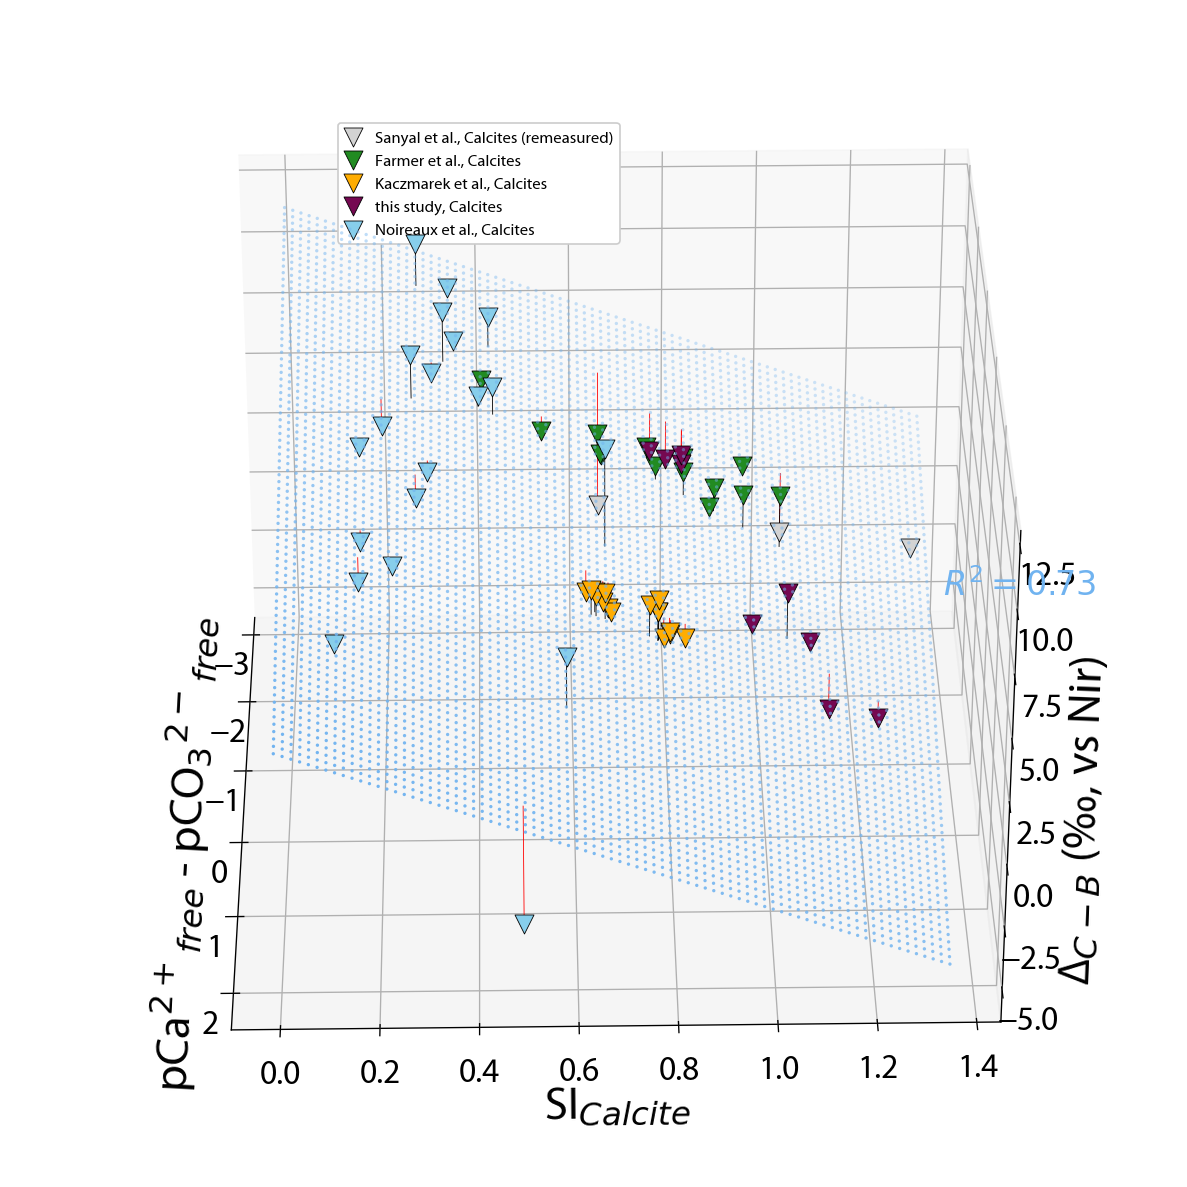

In [270]:
from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.pyplot as plt
#import numpy as np
#import random

# dummy variables for demonstration
#x = [test1_median[(df.CalcOrArag=='Calc')]]
#y = [MC_SICalc_median[(df.CalcOrArag=='Calc')]]
#z = [MCEpsilonKRae_median[(df.CalcOrArag=='Calc')]]

# build the figure instance
#fig = plt.figure(figsize=(10,8))
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(x, y, z, c='blue', marker='o')
#ax.plot_surface(X=x, Y=y, Z=z)

# set your labels
#ax.set_xlabel('pCa$_{free}$ - pCO$_3$$^{2-}$$_{free}$')
#ax.set_ylabel('SI$_{Calcite}$')
#ax.set_zlabel('ε$_{C-B}$ (‰)')

bob=pd.DataFrame()
bob['pCapCO']=test1_median[df.Calc==True].values
bob['SI']=MC_SICalc_median[df.Calc==True].values
bob['Eps']=MCEpsilonNRae_median[df.Calc==True].values

test1=(-1*np.log10(MC_Cafree))-(-1*np.log10(MCcarbion))
test1_median=pd.Series(test1.median(axis=1), index=df.index)

## Code from https://aegis4048.github.io/mutiple_linear_regression_and_visualization_in_python
from sklearn import linear_model
######################################## Data preparation #########################################
x=np.array(test1_median[df.Calc==True].values)
y=np.array(MC_SICalc_median[df.Calc==True].values)
X =bob[['pCapCO', 'SI']].values.reshape(-1,2)
Y =bob['Eps']

######################## Prepare model data point for visualization ###############################

x = X[:, 0]
y = X[:, 1]
z = Y

x_pred = np.linspace(-2.9, 2.1, num=80)   # range of porosity values
y_pred = np.linspace(0, 1.35,num=80)  # range of brittleness values
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T
data_pred=np.array([x,y]).T


################################################ Train #############################################

ols = linear_model.LinearRegression()
model = ols.fit(X, Y)
predicted = model.predict(model_viz)
valuespred=model.predict(data_pred)
############################################## Evaluate ############################################

r2 = model.score(X, Y)

############################################## Plot ################################################

#plt.style.use('default')

#fig = plt.figure(figsize=(10, 8))
plt.rcParams['font.family'] = 'Myriad Pro'
#ax1 = fig.add_subplot(131, projection='3d')
fig = plt.figure(figsize=(10, 10))
ax1 = plt.axes(projection='3d')


for a,i,j,k,h in zip(range(len(x)),x,y,z.values,valuespred):
    if valuespred[a]>z.values[a]:
        ax1.plot([i,i],[j,j],[k,h],color = 'red',linewidth=0.5)
    else:
        pass
        #ax1.plot([i,i],[j,j],[k,h],color = 'black',linewidth=0.5)
        
ax1.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=1, edgecolor='#70b3f0',zorder=-10)

for a,i,j,k,h in zip(range(len(x)),x,y,z.values,valuespred):
    if valuespred[a]>z.values[a]:
        pass
        #ax1.plot([i,i],[j,j],[k,h],color = 'red',linewidth=0.5)
    else:
        ax1.plot([i,i],[j,j],[k,h],color = 'black',linewidth=0.5)

for indices, names in zip([SanyalCalcs.index, FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['KSanyalwildboot','KFarmerwildboot','KKaczmarekwildboot','KUsCalcswildboot','KUsAragswildboot','KNoireauxCalcswildboot', 'KNoireauxAragswildboot']):
    if sum(df.Calc[indices])==0:
        pass
    else:
        ax1.scatter(test1_median[indices],MC_SICalc_median[indices],MCEpsilonNRae_median[indices], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], s=130, marker='v', linewidths=0.5, zorder=2,depthshade=False)




ax1.set_xlabel('pCa$^{2+}$$_{free}$ - pCO$_3$$^{2-}$$_{free}$', fontsize=28, labelpad=10)
ax1.set_ylabel('SI$_{Calcite}$', fontsize=28, labelpad=10)
ax1.set_zlabel('∆$_{C-B}$ (‰, vs Nir)', fontsize=28, labelpad=10)
#ax1.locator_params(nbins=4, axis='x')
#ax1.locator_params(nbins=5, axis='x')
ax1.tick_params(labelsize=20)
        
#for i in range(len(x)):
#    ax1.plot([y[i], y[i]],[x[i],x[i]],[z.values[i],valuespred[i]])



ax1.view_init(elev=28, azim=120)
#ax2.view_init(elev=4, azim=114)
#ax3.view_init(elev=60, azim=165)

ax1.legend(loc=(0.28,0.8), framealpha=1,fontsize=10, handlelength=1)
ax1.text(-2,1.4,-2,'$R^2 = %.2f$' % r2, fontsize=20, color='#70b3f0')

fig.tight_layout()
fig.savefig('Nir_3DplotwithSanyal2se.pdf')

#Produces a series of images to convert to a gif with https://imgflip.com/gif-maker
for ii in np.arange(0, 360, 1):
    ax1.view_init(elev=32, azim=ii)
    fig.savefig('gif_image%d.png' % ii)


'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Semibold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


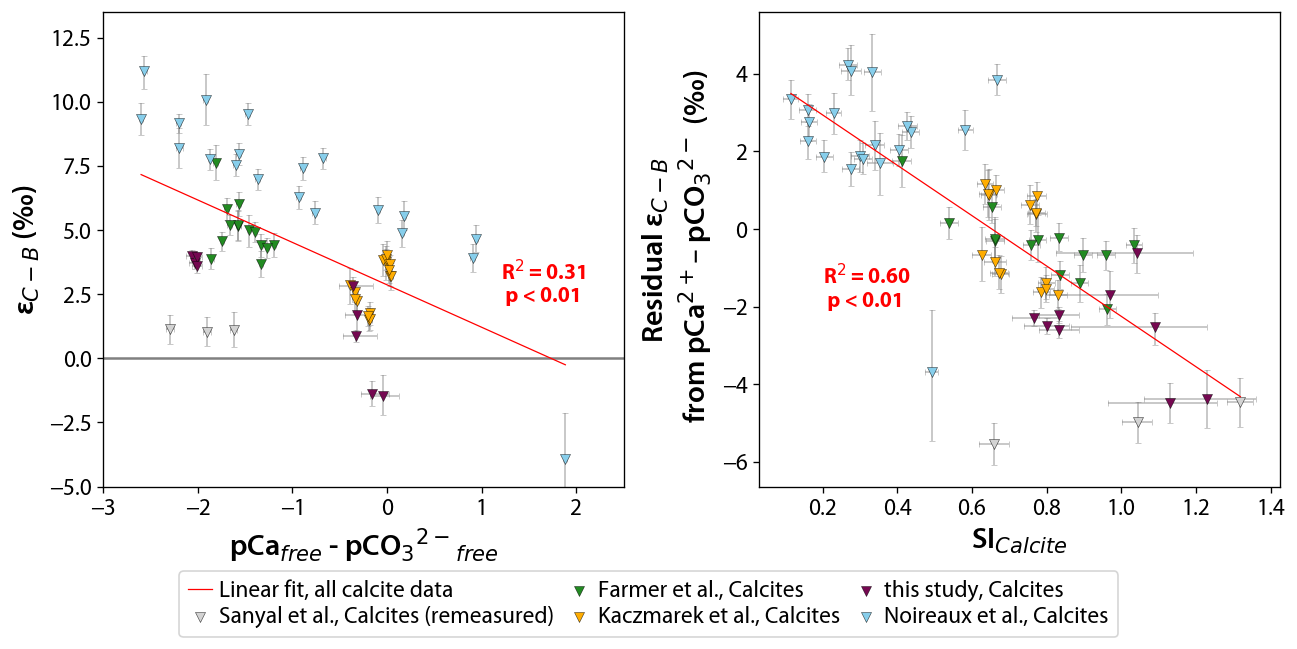

In [264]:
## Combined as multipanel plot.. tried combining with the 3D plot, but it seems you can't do 3D and 2D in one fig.
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
#matplotlib.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'Myriad Pro'


fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
#,ax3

ax1.set_xlim(-3,2.5)
ax1.set_ylim(-5,13.5)
ax1.axhline(y=0, color='gray', zorder=0)
ax1.errorbar(test1_median[(df.CalcOrArag=='Calc')], MCEpsilonNRae_median[(df.CalcOrArag=='Calc')],
            xerr=[test1lowerr[(df.CalcOrArag=='Calc')],test1uperr[(df.CalcOrArag=='Calc')]],
            yerr= [lowEpsErr[(df.CalcOrArag=='Calc')],highEpsErr[(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
temp=MCregressStats2(test1,MCEpsilonNRae,True,reps)
X1=np.linspace(min(test1_median[(df.Calc==True)]),max(test1_median[(df.Calc==True)]),100)
if temp[3]<0.01:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75,label='Linear fit, all calcite data')
    ax1.text(1.2,2.2,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=13,fontweight='bold')
elif temp[3]>0.05:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75, linestyle='--',label='Linear fit, all calcite data')
    ax1.text(1.2,2.2,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=13,fontweight='bold')
else:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75, label='Linear fit, all calcite data')
    ax1.text(1.2,2.2,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=13,fontweight='bold')
    
for indices, names in zip([SanyalCalcs.index, FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['KSanyalwildboot','KFarmerwildboot','KKaczmarekwildboot','KUsCalcswildboot','KUsAragswildboot','KNoireauxCalcswildboot', 'KNoireauxAragswildboot']):
    #residuald11BfromKlochko[names]=d11Bmeas_MCmedian[indices]-d11BborateK_MCmedian[indices]
    if sum(df.Calc[indices])==0:
        #ax1.scatter(loglittler[indices],MCEpsilonKRae_median[indices], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
        pass
    else:
        ax1.scatter(test1_median[indices],MCEpsilonNRae_median[indices], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)

#ax2.yaxis.tick_right()
ax1.tick_params(labelsize=14)
#ax2.tick_params(labelsize=12)
#ax2.yaxis.set_label_position('right')
ax1.set_xlabel('pCa$_{free}$ - pCO$_3$$^{2-}$$_{free}$', fontsize=18,fontweight='semibold')
#ax2.set_xlabel('log$_{10}$(([Ca]+[Mg])$_{free}$/[CO$_3$$^{2-}$]$_{free}$)', fontsize=18)
ax1.set_ylabel('ε$_{C-B}$ (‰)', fontsize=18,fontweight='semibold')

ax2.errorbar(MC_SICalc_median[(df.CalcOrArag=='Calc')], residpCapCO_median[(df.CalcOrArag=='Calc')],
            xerr=[lowSICalcErr[(df.CalcOrArag=='Calc')],highSICalcErr[(df.CalcOrArag=='Calc')]],
            yerr=[residpCapCO_up95[(df.CalcOrArag=='Calc')]-residpCapCO_median[(df.CalcOrArag=='Calc')],residpCapCO_median[(df.CalcOrArag=='Calc')]-residpCapCO_low95[(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

for indices, names in zip([SanyalCalcs.index, FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['KSanyalwildboot','KFarmerwildboot','KKaczmarekwildboot','KUsCalcswildboot','KUsAragswildboot','KNoireauxCalcswildboot', 'KNoireauxAragswildboot']):
    #residuald11BfromKlochko[names]=d11Bmeas_MCmedian[indices]-d11BborateK_MCmedian[indices]
    if sum(df.Calc[indices])==0:
        #ax1.scatter(loglittler[indices],MCEpsilonKRae_median[indices], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
        pass
    else:
        ax2.scatter(MC_SICalc_median[indices],residpCapCO_median[indices], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)

ax2.tick_params(labelsize=14)
#ax2.tick_params(labelsize=12)
#ax2.yaxis.set_label_position('right')
ax2.set_xlabel('SI$_{Calcite}$', fontsize=18,fontweight='semibold')
#ax2.set_xlabel('log$_{10}$(([Ca]+[Mg])$_{free}$/[CO$_3$$^{2-}$]$_{free}$)', fontsize=18)
ax2.set_ylabel('Residual ε$_{C-B}$ \n from pCa$^{2+}$– pCO$_3$$^{2-}$ (‰)', fontsize=18,fontweight='semibold')

residtemp=MCregressStats2(MC_SICalc,residpCapCO,True,reps)
X1=np.linspace(min(MC_SICalc_median[(df.Calc==True)]),max(MC_SICalc_median[(df.Calc==True)]),100)
if residtemp[3]<0.01:
    ax2.plot(X1,X1*residtemp[0] + residtemp[1], color='red', linewidth=0.75,label='Linear fit, all calcite data')
    ax2.text(0.2,-2,'R$^2$ = %.2f \n p < 0.01' % residtemp[2]**2, color='red', fontsize=13,fontweight='bold')
elif temp[3]>0.05:
    ax2.plot(X1,X1*residtemp[0] + residtemp[1], color='red', linewidth=0.75, linestyle='--',label='Linear fit, all calcite data')
    ax2.text(0.2,-2,'R$^2$ = %.2f \n p = %.2f' % (residtemp[2]**2,residtemp[3]), color='red', fontsize=13,fontweight='bold')
else:
    ax2.plot(X1,X1*residtemp[0] + residtemp[1], color='red', linewidth=0.75, label='Linear fit, all calcite data')
    ax2.text(0.2,-2,'R$^2$ = %.2f \n p = %.2f' % (residtemp[2]**2,residtemp[3]), color='red', fontsize=13,fontweight='bold')
    
secondresids=residpCapCO-((MC_SICalc*residtemp[0])+residtemp[1])

handles,labels=ax1.get_legend_handles_labels()
fig.legend(handles,labels, loc="lower center", fontsize=14, labelspacing=0.15, frameon=True, borderaxespad=0.5, ncol=3, columnspacing=0.6,handlelength=1,handletextpad=0.3)


#plt.adjust(left=0.1,bottom=0.75, right=0.11) ## makes some empty space for the legend
#fig.tight_layout() 
plt.tight_layout(pad=5,w_pad=1) #,rect=(0,0.05,1,1)

#fig.savefig('TEs vs carbsys_KDCations.pdf',bbox_inches="tight")
fig.savefig('NIRcombinedEpsilonplot2_2se.pdf',bbox_inches="tight")


In [50]:
## Caclulating the optimal alpha for aragonite

doubletotB=pd.concat((MCsolutions['MC_BmMol'],MCsolutions['MC_BmMol']), axis=1,ignore_index=True, sort=False)
doubletotB.set_index(df.index)

doubled11Bnorm=pd.concat((MCd11Bnormalised,MCd11Bnormalised), axis=1,ignore_index=True, sort=False)
doubled11Bnorm.set_index(df.index)

def alphaslope(x):
    temporary=pd.Series(dtype=float)
    for rep in np.arange(2000): 
        testx=pd.Series(d11BsolB_Rae2018MH(MCHplusPHREEQC[rep],MC_pKB[rep],doubletotB[rep],x,seawaterd11B)[0],index=df.index)
        testy=pd.Series(doubled11Bnorm[rep],index=df.index)
        testxarag=testx.loc[df.Calc==False]
        testyarag=testy.loc[df.Calc==False]
        slope, intercept, r_value, p_value, std_err = stats.linregress(testxarag,testyarag)
        temporary.at[rep]=slope
    return abs(1-temporary.median())


from scipy.optimize import minimize_scalar
optalpha=minimize_scalar(alphaslope, bounds=(1.02,1.03), method='bounded', tol=None, options={'xatol': 1e-05, 'maxiter': 500, 'disp': 3})
optimumAlpha=optalpha.x
optalpha.x

 
 Func-count     x          f(x)          Procedure
    1        1.02382    0.0921713        initial
    2        1.02618    0.0039399        golden
    3        1.02764     0.055131        golden
    4        1.02599   0.00334756        parabolic
    5          1.026   0.00262033        parabolic
    6        1.02608  6.45289e-05        parabolic
    7        1.02612   0.00154844        golden
    8        1.02607   0.00025681        parabolic
    9        1.02608  0.000242587        parabolic
   10        1.02607  6.05183e-05        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )


1.0260727873820077

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Semibold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


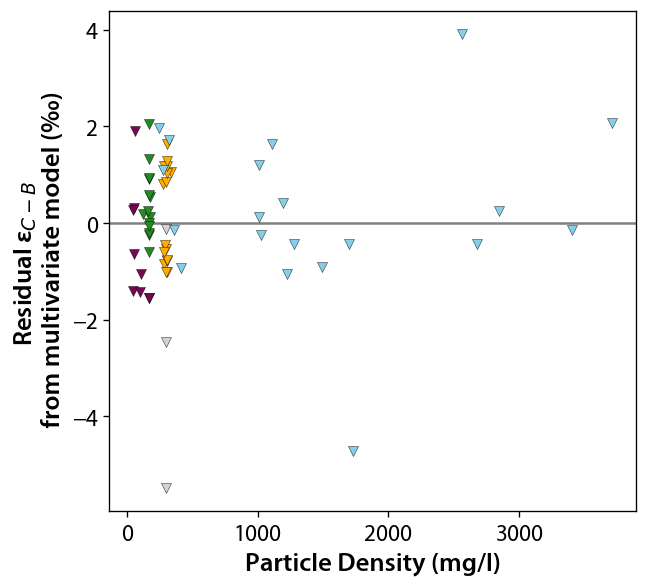

In [265]:
## Plotting Epsilon vs particles per L solution

##Plotting Epsilon data

Ncolours={'NSanyalwildboot':"lightgray",'NFarmerwildboot':"forestgreen",'NKaczmarekwildboot':"#ffad01",'NUsCalcswildboot':"#750851",'NUsAragswildboot':"#750851",'NNoireauxCalcswildboot':"skyblue",'NNoireauxAragswildboot':"skyblue"}
Kcolours={'KSanyalwildboot':"lightgray",'KFarmerwildboot':"forestgreen",'KKaczmarekwildboot':"#ffad01",'KUsCalcswildboot':"#750851",'KUsAragswildboot':"#750851",'KNoireauxCalcswildboot':"skyblue",'KNoireauxAragswildboot':"skyblue"}
Nserieslabels={'NSanyalwildboot':'Sanyal et al., Calcites (remeasured)','NFarmerwildboot':'Farmer et al., Calcites','NKaczmarekwildboot':'Kaczmarek et al., Calcites','NUsCalcswildboot':'this study, Calcites','NUsAragswildboot':'this study, Aragonites','NNoireauxCalcswildboot':'Noireaux et al., Calcites', 'NNoireauxAragswildboot':'Noireaux et al., Aragonites'}
Kserieslabels={'KSanyalwildboot':'Sanyal et al., Calcites (remeasured)','KFarmerwildboot':'Farmer et al., Calcites','KKaczmarekwildboot':'Kaczmarek et al., Calcites','KUsCalcswildboot':'this study, Calcites','KUsAragswildboot':'this study, Aragonites','KNoireauxCalcswildboot':'Noireaux et al., Calcites', 'KNoireauxAragswildboot':'Noireaux et al., Aragonites'}


secondresids_median=pd.Series(secondresids.median(axis=1), index=df.index)
secondresids_up95=pd.Series(np.quantile(secondresids, 0.95, axis=1), index=df.index)
secondresids_low95=pd.Series(np.quantile(secondresids, 0.05, axis=1), index=df.index)
    
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(5.5,5))
#ax1.set_xscale('log')
#ax1.set_xlim(-2.5,3)
#ax1.set_ylim(-4.5,13.5)
ax1.axhline(y=0, color='gray', zorder=0)
#ax1.errorbar(loglittler[(df.CalcOrArag=='Arag')], MCEpsilonKRae_median[(df.CalcOrArag=='Arag')],
#            xerr=[loglittlerminerr[(df.CalcOrArag=='Arag')],loglittlermaxerr[(df.CalcOrArag=='Arag')]],
#            yerr= [lowEpsErr[(df.CalcOrArag=='Arag')],highEpsErr[(df.CalcOrArag=='Arag')]],
#            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
#ax1.errorbar(df.MassPerVolReactor[(df.CalcOrArag=='Calc')], secondresids[(df.CalcOrArag=='Calc')],
            #yerr= [lowEpsErr[(df.CalcOrArag=='Calc')],highEpsErr[(df.CalcOrArag=='Calc')]],
   #         fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
for indices, names in zip([SanyalCalcs.index,FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['KSanyalwildboot','KFarmerwildboot','KKaczmarekwildboot','KUsCalcswildboot','KUsAragswildboot','KNoireauxCalcswildboot', 'KNoireauxAragswildboot']):
    #residuald11BfromKlochko[names]=d11Bmeas_MCmedian[indices]-d11BborateK_MCmedian[indices]
    if sum(df.Calc[indices])==0:
        #ax1.scatter(loglittler[indices],MCEpsilonKRae_median[indices], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
        pass
    else:
        ax1.scatter(df.MassPerVolReactor[indices],secondresids_median[indices], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)
ax1.tick_params(labelsize=14)
ax1.set_xlabel('Particle Density (mg/l)', fontsize=16,fontweight='semibold')
#ax2.set_xlabel('log$_{10}$(([Ca]+[Mg])$_{free}$/[CO$_3$$^{2-}$]$_{free}$)', fontsize=18)
ax1.set_ylabel('Residual ε$_{C-B}$ \n from multivariate model (‰)', fontsize=16,fontweight='semibold')

fig.tight_layout() 
fig.savefig('multivariate residual vs partdens.pdf')

'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Semibold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


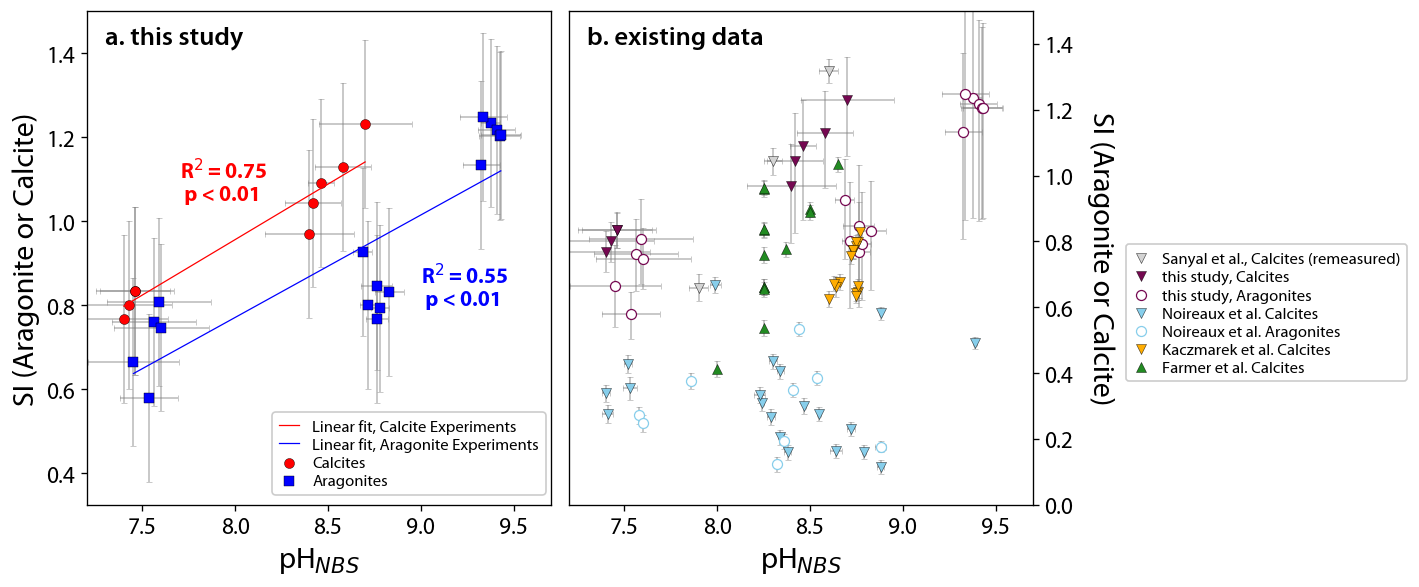

In [52]:
## Plotting the relationship between SI and pH in our experiments
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax1.set_xlim(7.2,9.7)

ax1.errorbar(df.pH[(df.Study=='us')&(df.CalcOrArag=='Arag')], MC_SIArag_median[(df.Study=='us')&(df.CalcOrArag=='Arag')], 
            yerr=0.2,xerr= [df.pHerr[(df.Study=='us')&(df.CalcOrArag=='Arag')],df.pHerr[(df.Study=='us')&(df.CalcOrArag=='Arag')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.errorbar(df.pH[(df.Study=='us')&(df.CalcOrArag=='Calc')], MC_SICalc_median[(df.Study=='us')&(df.CalcOrArag=='Calc')], 
            yerr=0.2,xerr= [df.pHerr[(df.Study=='us')&(df.CalcOrArag=='Calc')],df.pHerr[(df.Study=='us')&(df.CalcOrArag=='Calc')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

#X = df.pH[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
#Y = MC_SICalc_median[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
#linear_regressor = LinearRegression()  # create object for the class
#linear_regressor.fit(X,Y)  # perform linear regression
temp=MCregressStats(MC_pHNBS,MC_SICalc,'us',True,reps)
X1=np.linspace(min(df.pH[(df.Study=='us')&(df.Calc==True)]),max(df.pH[(df.Study=='us')&(df.Calc==True)]),100)
if temp[3]<0.01:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75,label='Linear fit, Calcite Experiments')
    ax1.text(7.7,1.05,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='red', fontsize=13,fontweight='bold')
elif temp[3]>0.05:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75, linestyle='--',label='Linear fit, Calcite Experiments')
    ax1.text(7.7,1.05,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=13,fontweight='bold')
else:
    ax1.plot(X1,X1*temp[0] + temp[1], color='red', linewidth=0.75, label='Linear fit, Calcite Experiments')
    ax1.text(7.7,1.05,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='red', fontsize=13,fontweight='bold')

    
temp=MCregressStats(MC_pHNBS,MC_SIArag,'us',False,reps)
X1=np.linspace(min(df.pH[(df.Study=='us')&(df.Calc==False)]),max(df.pH[(df.Study=='us')&(df.Calc==False)]),100)
if temp[3]<0.01:
    ax1.plot(X1,X1*temp[0] + temp[1], color='blue', linewidth=0.75,label='Linear fit, Aragonite Experiments')
    ax1.text(9,0.8,'R$^2$ = %.2f \n p < 0.01' % temp[2]**2, color='blue', fontsize=13,fontweight='bold')
elif temp[3]>0.05:
    ax1.plot(X1,X1*temp[0] + temp[1], color='blue', linewidth=0.75, linestyle='--',label='Linear fit, Aragonite Experiments')
    ax1.text(9,0.8,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='blue', fontsize=13,fontweight='bold')
else:
    ax1.plot(X1,X1*temp[0] + temp[1], color='blue', linewidth=0.75, label='Linear fit, Aragonite Experiments')
    ax1.text(9,0.8,'R$^2$ = %.2f \n p = %.2f' % (temp[2]**2,temp[3]), color='blue', fontsize=13,fontweight='bold')
#X1=np.linspace(min(X),max(X),10)
#Y_pred = linear_regressor.predict(X1)  # make predictions
#ax1.plot(X1, Y_pred, color='red', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Calcites')

#X = df.pH[(df.CalcOrArag=='Arag')&(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
#Y = MC_SIArag_median[(df.CalcOrArag=='Arag')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
#linear_regressor = LinearRegression()  # create object for the class
#linear_regressor.fit(X,Y) # perform linear regression
#X1=np.linspace(min(X),max(X),10)
#Y_pred = linear_regressor.predict(X1)  # make predictions
#ax1.plot(X1, Y_pred, color='blue', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Aragonites')

ax1.scatter(df.pH[(df.CalcOrArag=='Calc')&(df.Study=='us')],MC_SICalc_median[(df.CalcOrArag=='Calc')&(df.Study=='us')], color='black',label='Calcites', facecolors='red', marker='o', linewidths=0.25)
ax1.scatter(df.pH[(df.CalcOrArag=='Arag')&(df.Study=='us')],MC_SIArag_median[(df.CalcOrArag=='Arag')&(df.Study=='us')], color='black',label='Aragonites', facecolors='blue', marker='s', linewidths=0.25)

ax1.legend(loc=(0.02,0.79), framealpha=1,fontsize=9.5)

ax1.tick_params(labelsize=12)

ax1.set_xlabel('pH$_{NBS}$', fontsize=18)
ax1.set_ylabel('SI (Aragonite or Calcite)', fontsize=18)

Kcolours={'KSanyalwildboot':"lightgray",
          'KFarmerwildboot':"forestgreen",
          'KKaczmarekwildboot':"#ffad01",
          'KUsCalcswildboot':"#750851",
          'KUsAragswildboot':"#750851",'KNoireauxCalcswildboot':"skyblue",'KNoireauxAragswildboot':"skyblue"}


ax2.set_xlim(7.2,9.7)
ax2.set_ylim(0,1.5)
ax2.scatter(df.pH[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')], MC_SICalc_median[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')], \
            color='black',linewidths=0.25, facecolors='lightgray', label='Sanyal et al., Calcites (remeasured)', marker='v')
ax2.scatter(df.pH[(df.CalcOrArag=='Calc')&(df.Study=='us')], MC_SICalc_median[(df.CalcOrArag=='Calc')&(df.Study=='us')], \
            color='black',linewidths=0.25, facecolors='#750851', label='this study, Calcites', marker='v')
ax2.scatter(df.pH[(df.CalcOrArag=='Arag')&(df.Study=='us')], MC_SIArag_median[(df.CalcOrArag=='Arag')&(df.Study=='us')], \
            color='#750851',linewidths=0.75, facecolors='white', label='this study, Aragonites', marker='o')
ax2.scatter(df.pH[(df.CalcOrArag=='Calc')&(df.Study=='Noireaux')], MC_SICalc_median[(df.CalcOrArag=='Calc')&(df.Study=='Noireaux')], \
            color='black',linewidths=0.25, facecolors='skyblue', label='Noireaux et al. Calcites', marker='v')
ax2.scatter(df.pH[(df.CalcOrArag=='Arag')&(df.Study=='Noireaux')], MC_SIArag_median[(df.CalcOrArag=='Arag')&(df.Study=='Noireaux')], \
            color='skyblue',linewidths=0.75, facecolors='white', label='Noireaux et al. Aragonites', marker='o')
ax2.scatter(df.pH[(df.Study=='Kaczmarek')], MC_SICalc_median[(df.Study=='Kaczmarek')], \
            color='black',linewidths=0.25, facecolors='#ffad01', label='Kaczmarek et al. Calcites', marker='v')
ax2.scatter(df.pH[(df.Study=='Uchikawa')], MC_SICalc_median[(df.Study=='Uchikawa')], \
            color='black',linewidths=0.25, facecolors='forestgreen', label='Farmer et al. Calcites', marker='^')
ax2.errorbar(df.pH[(df.CalcOrArag=='Calc')], MC_SICalc_median[(df.CalcOrArag=='Calc')],
            yerr=[lowSICalcErr[(df.CalcOrArag=='Calc')],highSICalcErr[(df.CalcOrArag=='Calc')]],
            xerr=[df.pHerr[(df.CalcOrArag=='Calc')],df.pHerr[(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax2.errorbar(df.pH[(df.CalcOrArag=='Arag')], MC_SIArag_median[(df.CalcOrArag=='Arag')],
            yerr=[lowSIAragErr[(df.CalcOrArag=='Arag')],highSIAragErr[(df.CalcOrArag=='Arag')]],
            xerr= [df.pHerr[(df.CalcOrArag=='Arag')],df.pHerr[(df.CalcOrArag=='Arag')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')


ax1.legend(loc=(0.4,0.02), framealpha=1,fontsize=10, labelspacing=0.2, handlelength=1.2)
#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )
#bbox_to_anchor=(1.51, 0.21)
ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.2, 0.25),framealpha=1,fontsize=10,labelspacing=0.2, handlelength=1)

ax1.text(7.3, 1.4222, 'a. this study', fontweight='semibold', color='black', fontsize=16)
ax2.text(7.3, 1.4, 'b. existing data', fontweight='semibold', color='black', fontsize=16)

ax2.yaxis.tick_right()
ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)
ax2.yaxis.set_label_position('right')
ax2.set_xlabel('pH$_{NBS}$', fontsize=18)
ax2.set_ylabel('SI (Aragonite or Calcite)', labelpad=25, fontsize=18, rotation=270)

fig.tight_layout() 
fig.savefig('pH vs SI NewMCsRae with Sanyal2se.pdf')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


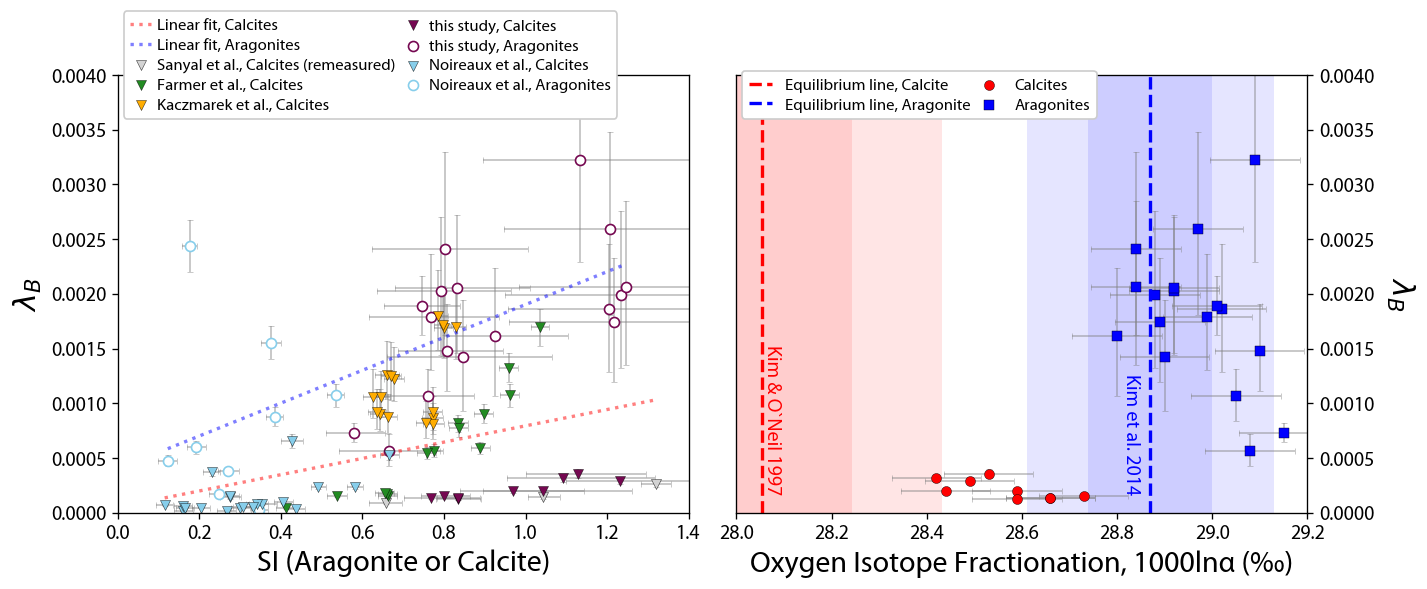

In [266]:
## Plotting Lambda vs SI


fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax1.set_xlim(0,1.4)
#ax2.set_xlim(0,1.4)
ax1.set_ylim(0,0.004)
ax2.set_ylim(0,0.004)
#ax1.axhline(y=0, color='gray', zorder=0)
#ax2.axhline(y=0, color='gray', zorder=0)
ax1.errorbar(MC_SIArag_median[(df.CalcOrArag=='Arag')], MClambdaB_median[(df.CalcOrArag=='Arag')],
            xerr=[highSIAragErr[(df.CalcOrArag=='Arag')],lowSIAragErr[(df.CalcOrArag=='Arag')]],
            yerr= [lowlambdaBErr[(df.CalcOrArag=='Arag')],highlambdaBErr[(df.CalcOrArag=='Arag')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.errorbar(MC_SICalc_median[(df.CalcOrArag=='Calc')],MClambdaB_median[(df.CalcOrArag=='Calc')],
            xerr=[highSICalcErr[(df.CalcOrArag=='Calc')],lowSICalcErr[(df.CalcOrArag=='Calc')]],
            yerr= [lowlambdaBErr[(df.CalcOrArag=='Calc')],highlambdaBErr[(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
for indices, names in zip([SanyalCalcs.index,FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['KSanyalwildboot','KFarmerwildboot','KKaczmarekwildboot','KUsCalcswildboot','KUsAragswildboot','KNoireauxCalcswildboot', 'KNoireauxAragswildboot']):
    #residuald11BfromKlochko[names]=d11Bmeas_MCmedian[indices]-d11BborateK_MCmedian[indices]
    if sum(df.Calc[indices])==0:
        ax1.scatter(MC_SIArag_median[indices],MClambdaB_median[indices], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
    else:
        ax1.scatter(MC_SICalc_median[indices],MClambdaB_median[indices], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)

ax2.set_xlim(28,29.2)
ax2.fill_between(x=[28.87-0.13,28.87+0.13], y1=[0,0], y2=[0.005,0.005], alpha=0.1,linewidth=0, color='blue', zorder=-1)
ax2.fill_between(x=[28.87-0.26,28.87+0.26], y1=[0,0], y2=[0.005,0.005], alpha=0.1,linewidth=0, color='blue', zorder=-1)
ax2.fill_between(x=[28.053-0.19,28.053+0.19], y1=[0,0], y2=[0.005,0.005], alpha=0.1,linewidth=0, color='red', zorder=-1)
ax2.fill_between(x=[28.053-0.38,28.053+0.38], y1=[0,0], y2=[0.005,0.005], alpha=0.1,linewidth=0, color='red', zorder=-1)

ax2.axvline(x=(18.03*((10**3)/298.15)-32.42), color='red', linestyle='--',linewidth=2,label='Equilibrium line, Calcite') ## Kim et al. 2007 Equilibrium Aragonite fractionation at 25˚C
ax2.axvline(x=28.87, color='blue', linestyle='--',linewidth=2,label='Equilibrium line, Aragonite') ## Kim & ONeil Equilibrium Calcite fractionation at 25˚C
ax2.errorbar(df.OxyFract[(df.Study=='us')], MClambdaB_median[(df.Study=='us')],
            xerr=[df.OxyFract[(df.Study=='us')]-df.OxyFract[(df.Study=='us')]+0.094,df.OxyFract[(df.Study=='us')]-df.OxyFract[(df.Study=='us')]+0.094],
            yerr= [lowlambdaBErr[(df.Study=='us')],highlambdaBErr[(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

ax2.scatter(df.OxyFract[(df.CalcOrArag=='Calc')&(df.Study=='us')],MClambdaB_median[(df.CalcOrArag=='Calc')&(df.Study=='us')], color='black',label='Calcites', facecolors='red', marker='o', linewidths=0.25)
ax2.scatter(df.OxyFract[(df.CalcOrArag=='Arag')&(df.Study=='us')],MClambdaB_median[(df.CalcOrArag=='Arag')&(df.Study=='us')], color='black',label='Aragonites', facecolors='blue', marker='s', linewidths=0.25)

#ax2.scatter(d11Bmeas_MCmedian[FarmerCalcs.index],Kpredictedd11Bcarb['KFarmerwildboot'])

#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )
#bbox_to_anchor=(1.51, 0.21)
#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )

#ax1.text(7.3, 1.4222, 'a. this study', fontweight='semibold', color='black', fontsize=13)
#ax2.text(7.3, 1.4, 'b. existing data', fontweight='semibold', color='black', fontsize=13)


X = MC_SICalc_median[(df.CalcOrArag=='Calc')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = MClambdaB_median[(df.CalcOrArag=='Calc')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
X1=np.linspace(min(X),max(X),10)
Y_pred = linear_regressor.predict(X1)  # make predictions
ax1.plot(X1, Y_pred, color='red', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Calcites')

X = MC_SIArag_median[(df.CalcOrArag=='Arag')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = MClambdaB_median[(df.CalcOrArag=='Arag')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y) # perform linear regression
X1=np.linspace(min(X),max(X),10)
Y_pred = linear_regressor.predict(X1)  # make predictions
ax1.plot(X1, Y_pred, color='blue', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Aragonites')

#ax1.legend(loc=(0.58,0.65), framealpha=1,fontsize=10)
#ax2.legend(loc=(0.57,0.8535), framealpha=1,fontsize=10)

#ax1.text(0.02, 11.29, 'a.', color='black', fontsize=28,fontweight='semibold')
#ax2.text(28.02, 6.6, 'b.', color='black', fontsize=28,fontweight='semibold')


ax2.yaxis.tick_right()
ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
ax2.yaxis.set_label_position('right')
ax1.set_xlabel('SI (Aragonite or Calcite)', fontsize=18)
ax2.set_xlabel('Oxygen Isotope Fractionation, 1000lnα (‰)', fontsize=18)
ax1.set_ylabel('$\lambda$$_{B}$', fontsize=18)
ax2.set_ylabel('$\lambda$$_{B}$', fontsize=18, labelpad=25, rotation=270)
#ax1.text(0.87, 12, 'a. α=1.00272', fontweight='semibold', color='black', fontsize=13)
ax2.text(28.81, 0.0002, 'Kim et al. 2014', color='blue', fontsize=12, rotation=270)
ax2.text(28.055, 0.0002, 'Kim & O`Neil 1997', color='red', fontsize=12, rotation=270)
#ax2.text(0.92, 12, 'b. α=1.0026', fontweight='semibold', color='black', fontsize=13)

ax1.legend(loc=(0.01,0.9), framealpha=1,fontsize=10, handlelength=1.3,labelspacing=0.3,handletextpad=0.3, ncol=2, columnspacing=0.4)
ax2.legend(loc=(0.01,0.9), framealpha=1,fontsize=10, handlelength=1.4, labelspacing=0.3,ncol=2, columnspacing=0.4)

fig.tight_layout() 
fig.savefig('lambdaB vs SIandd18O_NewMCsRaewSanyal2se.pdf')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Semibold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


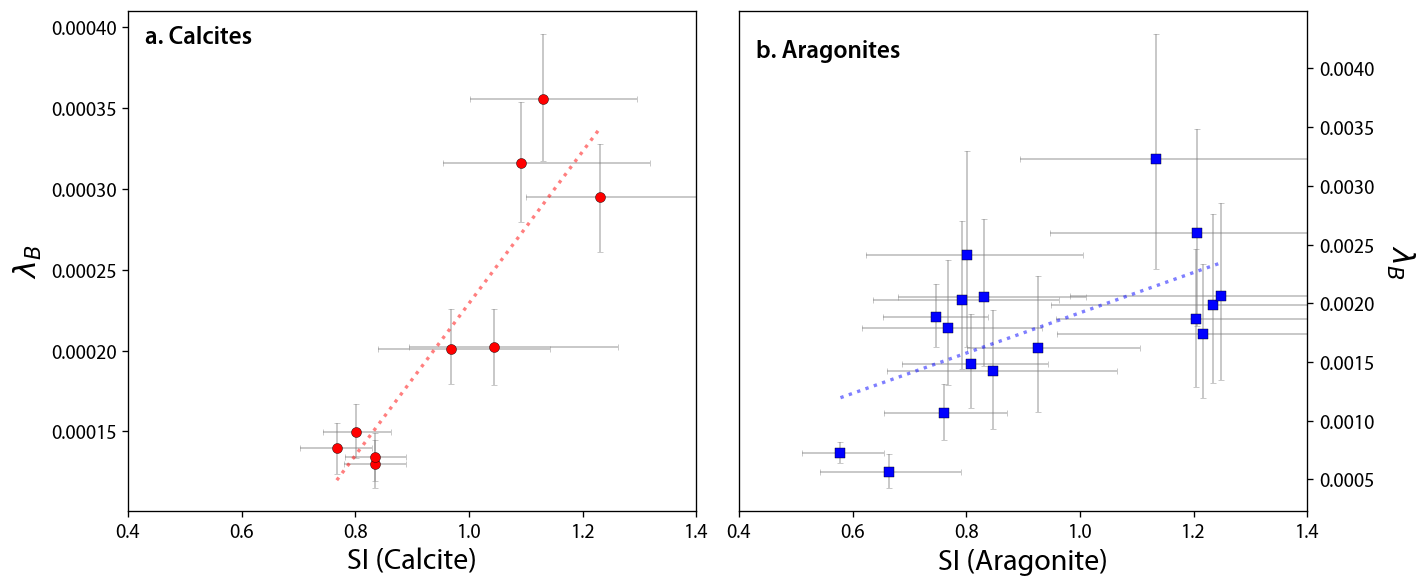

In [54]:
## Plotting Lambda vs SI a different way

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax1.set_xlim(0.4,1.4)
ax2.set_xlim(0.4,1.4)
#ax1.set_ylim(-4,13)
#ax2.set_ylim(-5,8)

ax1.errorbar(MC_SICalc_median[(df.CalcOrArag=='Calc')&(df.Study=='us')],MClambdaB_median[(df.CalcOrArag=='Calc')&(df.Study=='us')],
            xerr=[highSICalcErr[(df.CalcOrArag=='Calc')&(df.Study=='us')],lowSICalcErr[(df.CalcOrArag=='Calc')&(df.Study=='us')]],
            yerr= [lowlambdaBErr[(df.CalcOrArag=='Calc')&(df.Study=='us')],highlambdaBErr[(df.CalcOrArag=='Calc')&(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')


ax1.scatter(MC_SICalc_median[(df.CalcOrArag=='Calc')&(df.Study=='us')],MClambdaB_median[(df.CalcOrArag=='Calc')&(df.Study=='us')], color='black',label='Calcites', facecolors='red', marker='o', linewidths=0.25)

ax2.errorbar(MC_SIArag_median[(df.CalcOrArag=='Arag')&(df.Study=='us')], MClambdaB_median[(df.CalcOrArag=='Arag')&(df.Study=='us')],
            xerr=[highSIAragErr[(df.CalcOrArag=='Arag')&(df.Study=='us')],lowSIAragErr[(df.CalcOrArag=='Arag')&(df.Study=='us')]],
            yerr= [lowlambdaBErr[(df.CalcOrArag=='Arag')&(df.Study=='us')],highlambdaBErr[(df.CalcOrArag=='Arag')&(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax2.scatter(MC_SIArag_median[(df.CalcOrArag=='Arag')&(df.Study=='us')],MClambdaB_median[(df.CalcOrArag=='Arag')&(df.Study=='us')], color='black',label='Aragonites', facecolors='blue', marker='s', linewidths=0.25)


#ax2.scatter(d11Bmeas_MCmedian[FarmerCalcs.index],Kpredictedd11Bcarb['KFarmerwildboot'])

#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )
#bbox_to_anchor=(1.51, 0.21)
#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )

#ax1.text(7.3, 1.4222, 'a. this study', fontweight='semibold', color='black', fontsize=13)
#ax2.text(7.3, 1.4, 'b. existing data', fontweight='semibold', color='black', fontsize=13)


X = MC_SICalc_median[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = MClambdaB_median[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
X1=np.linspace(min(X),max(X),10)
Y_pred = linear_regressor.predict(X1)  # make predictions
ax1.plot(X1, Y_pred, color='red', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Calcites')

X = MC_SIArag_median[(df.CalcOrArag=='Arag')&(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = MClambdaB_median[(df.CalcOrArag=='Arag')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y) # perform linear regression
X1=np.linspace(min(X),max(X),10)
Y_pred = linear_regressor.predict(X1)  # make predictions
ax2.plot(X1, Y_pred, color='blue', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Aragonites')

#ax1.legend(loc=(0.58,0.65), framealpha=1,fontsize=10)
#ax2.legend(loc=(0.57,0.8535), framealpha=1,fontsize=10)

#ax1.text(0.02, 11.29, 'a.', color='black', fontsize=28,fontweight='semibold')
#ax2.text(28.02, 6.6, 'b.', color='black', fontsize=28,fontweight='semibold')


ax2.yaxis.tick_right()
ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
ax2.yaxis.set_label_position('right')
ax1.set_xlabel('SI (Calcite)', fontsize=18)
ax2.set_xlabel('SI (Aragonite)', fontsize=18)
ax1.set_ylabel('$\lambda$$_{B}$', fontsize=18)
ax2.set_ylabel('$\lambda$$_{B}$', fontsize=18, labelpad=25, rotation=270)
ax1.text(0.43, 0.00039, 'a. Calcites', fontweight='semibold', color='black', fontsize=15)
ax2.text(0.43, 0.0041, 'b. Aragonites', fontweight='semibold', color='black', fontsize=15)

fig.tight_layout() 
fig.savefig('lambdaB vs SI just ours2se.pdf')

In [ ]:
plt.plot(pMg[(df.Study=='us')& (df.Calc==True)],df.pH[(df.Study=='us')& (df.Calc==True)])
plt.scatter(pMg[(df.Study=='us')& (df.Calc==False)],df.pH[(df.Study=='us')& (df.Calc==False)])

In [ ]:
# Visualising the % of the borate that is free, vs complexed with Mg or Ca
print(max(MC_pcFreeBorate_median),min(MC_pcFreeBorate_median))

plt.scatter(df.pH[(df.Calc==True)],MC_pcFreeBorate_median[(df.Calc==True)],)

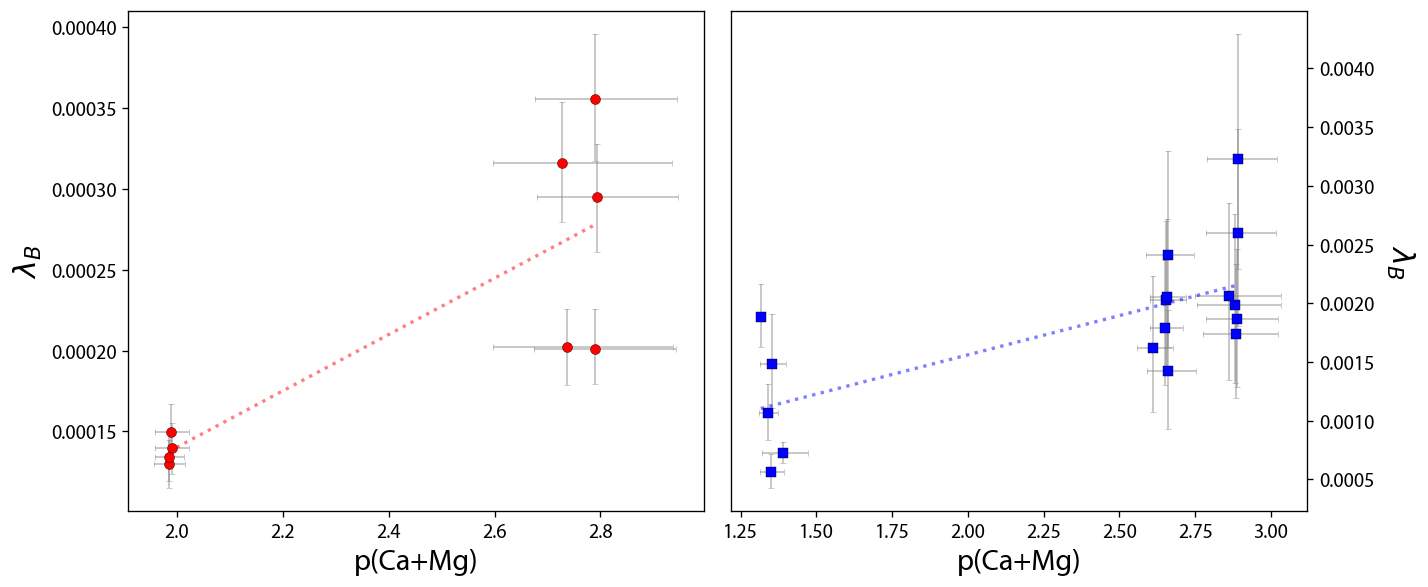

In [55]:


## Plotting Lambda vs SI a different way

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

#ax1.set_xlim(0.4,1.4)
#ax2.set_xlim(0.4,1.4)
#ax1.set_ylim(-4,13)
#ax2.set_ylim(-5,8)

ax1.errorbar(medpCaMg[(df.CalcOrArag=='Calc')&(df.Study=='us')],MClambdaB_median[(df.CalcOrArag=='Calc')&(df.Study=='us')],
            xerr=[(medpCaMg[(df.CalcOrArag=='Calc')&(df.Study=='us')]-l95pCaMg[(df.CalcOrArag=='Calc')&(df.Study=='us')]),(u95pCaMg[(df.CalcOrArag=='Calc')&(df.Study=='us')]-medpCaMg[(df.CalcOrArag=='Calc')&(df.Study=='us')])],
            yerr= [lowlambdaBErr[(df.CalcOrArag=='Calc')&(df.Study=='us')],highlambdaBErr[(df.CalcOrArag=='Calc')&(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')


ax1.scatter(medpCaMg[(df.CalcOrArag=='Calc')&(df.Study=='us')],MClambdaB_median[(df.CalcOrArag=='Calc')&(df.Study=='us')], color='black',label='Calcites', facecolors='red', marker='o', linewidths=0.25)

ax2.errorbar(medpCaMg[(df.CalcOrArag=='Arag')&(df.Study=='us')], MClambdaB_median[(df.CalcOrArag=='Arag')&(df.Study=='us')],
            xerr=[(medpCaMg[(df.CalcOrArag=='Arag')&(df.Study=='us')]-l95pCaMg[(df.CalcOrArag=='Arag')&(df.Study=='us')]),(u95pCaMg[(df.CalcOrArag=='Arag')&(df.Study=='us')]-medpCaMg[(df.CalcOrArag=='Arag')&(df.Study=='us')])],
            yerr= [lowlambdaBErr[(df.CalcOrArag=='Arag')&(df.Study=='us')],highlambdaBErr[(df.CalcOrArag=='Arag')&(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax2.scatter(medpCaMg[(df.CalcOrArag=='Arag')&(df.Study=='us')],MClambdaB_median[(df.CalcOrArag=='Arag')&(df.Study=='us')], color='black',label='Aragonites', facecolors='blue', marker='s', linewidths=0.25)


#ax2.scatter(d11Bmeas_MCmedian[FarmerCalcs.index],Kpredictedd11Bcarb['KFarmerwildboot'])

#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )
#bbox_to_anchor=(1.51, 0.21)
#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )

#ax1.text(7.3, 1.4222, 'a. this study', fontweight='semibold', color='black', fontsize=13)
#ax2.text(7.3, 1.4, 'b. existing data', fontweight='semibold', color='black', fontsize=13)


X = medpCaMg[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = MClambdaB_median[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
X1=np.linspace(min(X),max(X),10)
Y_pred = linear_regressor.predict(X1)  # make predictions
ax1.plot(X1, Y_pred, color='red', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Calcites')

X = medpCaMg[(df.CalcOrArag=='Arag')&(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = MClambdaB_median[(df.CalcOrArag=='Arag')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y) # perform linear regression
X1=np.linspace(min(X),max(X),10)
Y_pred = linear_regressor.predict(X1)  # make predictions
ax2.plot(X1, Y_pred, color='blue', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Aragonites')

#ax1.legend(loc=(0.58,0.65), framealpha=1,fontsize=10)
#ax2.legend(loc=(0.57,0.8535), framealpha=1,fontsize=10)

#ax1.text(0.02, 11.29, 'a.', color='black', fontsize=28,fontweight='semibold')
#ax2.text(28.02, 6.6, 'b.', color='black', fontsize=28,fontweight='semibold')


ax2.yaxis.tick_right()
ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
ax2.yaxis.set_label_position('right')
ax1.set_xlabel('p(Ca+Mg)', fontsize=18)
ax2.set_xlabel('p(Ca+Mg)', fontsize=18)
ax1.set_ylabel('$\lambda$$_{B}$', fontsize=18)
ax2.set_ylabel('$\lambda$$_{B}$', fontsize=18, labelpad=25, rotation=270)
#ax1.text(0.43, 0.00039, 'a. Calcites', fontweight='semibold', color='black', fontsize=15)
#ax2.text(0.43, 0.0041, 'b. Aragonites', fontweight='semibold', color='black', fontsize=15)

fig.tight_layout() 
#fig.savefig('lambdaB vs pCaMg2se.pdf')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Semibold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


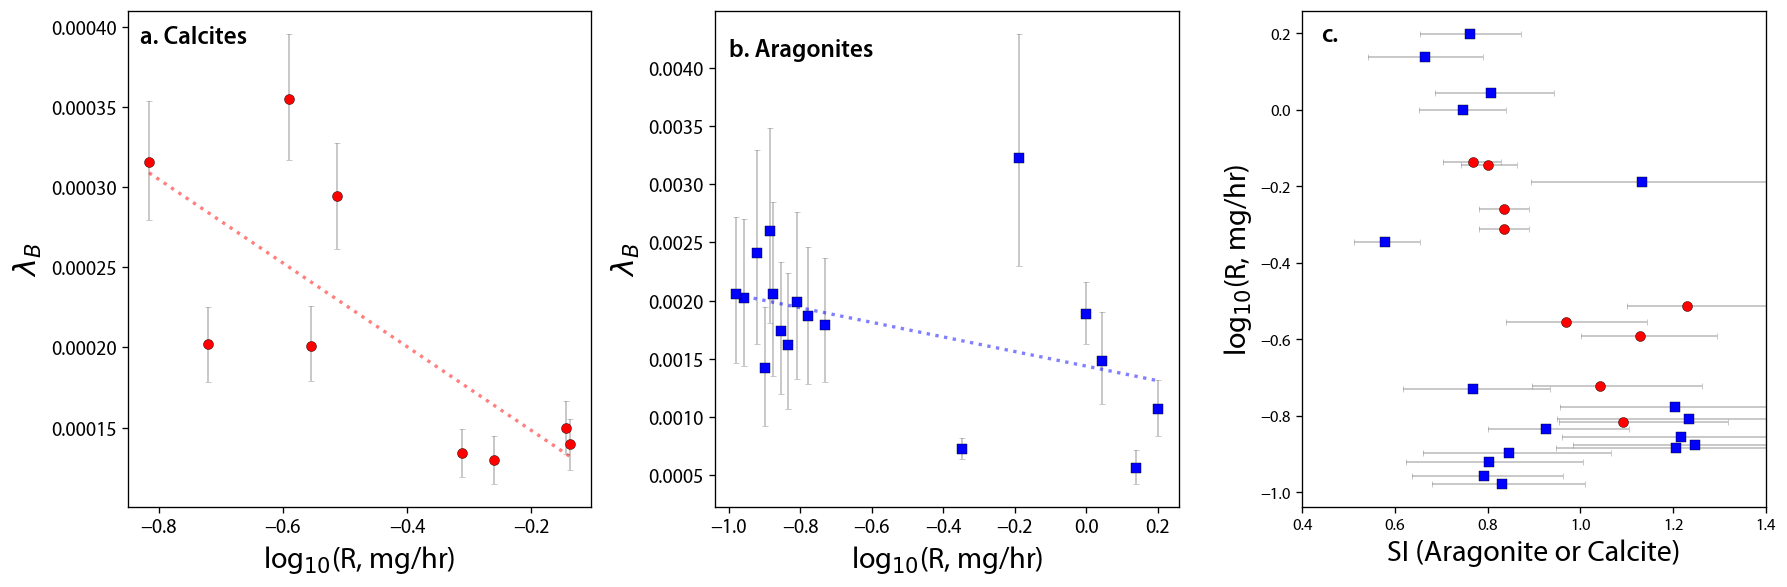

In [56]:
## Plotting Lambda vs SI a different way

fig, (ax1,ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

#ax1.set_xlim(0.4,1.4)
ax3.set_xlim(0.4,1.4)
#ax1.set_ylim(-4,13)
#ax2.set_ylim(-5,8)

ax1.errorbar(df.logR[(df.CalcOrArag=='Calc')&(df.Study=='us')],MClambdaB_median[(df.CalcOrArag=='Calc')&(df.Study=='us')],
            yerr= [lowlambdaBErr[(df.CalcOrArag=='Calc')&(df.Study=='us')],highlambdaBErr[(df.CalcOrArag=='Calc')&(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')


ax1.scatter(df.logR[(df.CalcOrArag=='Calc')&(df.Study=='us')],MClambdaB_median[(df.CalcOrArag=='Calc')&(df.Study=='us')], color='black',label='Calcites', facecolors='red', marker='o', linewidths=0.25)

ax2.errorbar(df.logR[(df.CalcOrArag=='Arag')&(df.Study=='us')], MClambdaB_median[(df.CalcOrArag=='Arag')&(df.Study=='us')],
            yerr= [lowlambdaBErr[(df.CalcOrArag=='Arag')&(df.Study=='us')],highlambdaBErr[(df.CalcOrArag=='Arag')&(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax2.scatter(df.logR[(df.CalcOrArag=='Arag')&(df.Study=='us')],MClambdaB_median[(df.CalcOrArag=='Arag')&(df.Study=='us')], color='black',label='Aragonites', facecolors='blue', marker='s', linewidths=0.25)

ax3.errorbar(MC_SICalc_median[(df.CalcOrArag=='Calc')&(df.Study=='us')],df.logR[(df.CalcOrArag=='Calc')&(df.Study=='us')],
            xerr=[highSICalcErr[(df.CalcOrArag=='Calc')&(df.Study=='us')],lowSICalcErr[(df.CalcOrArag=='Calc')&(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax3.errorbar(MC_SIArag_median[(df.CalcOrArag=='Arag')&(df.Study=='us')],df.logR[(df.CalcOrArag=='Arag')&(df.Study=='us')],
            xerr=[highSIAragErr[(df.CalcOrArag=='Arag')&(df.Study=='us')],lowSIAragErr[(df.CalcOrArag=='Arag')&(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax3.scatter(MC_SIArag_median[(df.CalcOrArag=='Arag')&(df.Study=='us')],df.logR[(df.CalcOrArag=='Arag')&(df.Study=='us')], color='black',label='Aragonites', facecolors='blue', marker='s', linewidths=0.25)
ax3.scatter(MC_SICalc_median[(df.CalcOrArag=='Calc')&(df.Study=='us')],df.logR[(df.CalcOrArag=='Calc')&(df.Study=='us')], color='black',label='Calcites', facecolors='red', marker='o', linewidths=0.25)

#ax2.scatter(d11Bmeas_MCmedian[FarmerCalcs.index],Kpredictedd11Bcarb['KFarmerwildboot'])

#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )
#bbox_to_anchor=(1.51, 0.21)
#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )

#ax1.text(7.3, 1.4222, 'a. this study', fontweight='semibold', color='black', fontsize=13)
#ax2.text(7.3, 1.4, 'b. existing data', fontweight='semibold', color='black', fontsize=13)


X = df.logR[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = MClambdaB_median[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
X1=np.linspace(min(X),max(X),10)
Y_pred = linear_regressor.predict(X1)  # make predictions
ax1.plot(X1, Y_pred, color='red', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Calcites')

X = df.logR[(df.CalcOrArag=='Arag')&(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = MClambdaB_median[(df.CalcOrArag=='Arag')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y) # perform linear regression
X1=np.linspace(min(X),max(X),10)
Y_pred = linear_regressor.predict(X1)  # make predictions
ax2.plot(X1, Y_pred, color='blue', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Aragonites')

#ax1.legend(loc=(0.58,0.65), framealpha=1,fontsize=10)
#ax2.legend(loc=(0.57,0.8535), framealpha=1,fontsize=10)

#ax1.text(0.02, 11.29, 'a.', color='black', fontsize=28,fontweight='semibold')
#ax2.text(28.02, 6.6, 'b.', color='black', fontsize=28,fontweight='semibold')


#ax2.yaxis.tick_right()
ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
#ax2.yaxis.set_label_position('right')
ax1.set_xlabel('log$_{10}$(R, mg/hr)', fontsize=18)
ax2.set_xlabel('log$_{10}$(R, mg/hr)', fontsize=18)
ax3.set_xlabel('SI (Aragonite or Calcite)', fontsize=18)
ax1.set_ylabel('$\lambda$$_{B}$', fontsize=18)
ax2.set_ylabel('$\lambda$$_{B}$', fontsize=18)
ax3.set_ylabel('log$_{10}$(R, mg/hr)', fontsize=18)
ax1.text(-0.83, 0.00039, 'a. Calcites', fontweight='semibold', color='black', fontsize=15)
ax2.text(-1, 0.0041, 'b. Aragonites', fontweight='semibold', color='black', fontsize=15)
ax3.text(0.44, 0.18, 'c.', fontweight='semibold', color='black', fontsize=15)

fig.tight_layout() 
fig.savefig('Precipitation rate vs SIandR2se.pdf')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


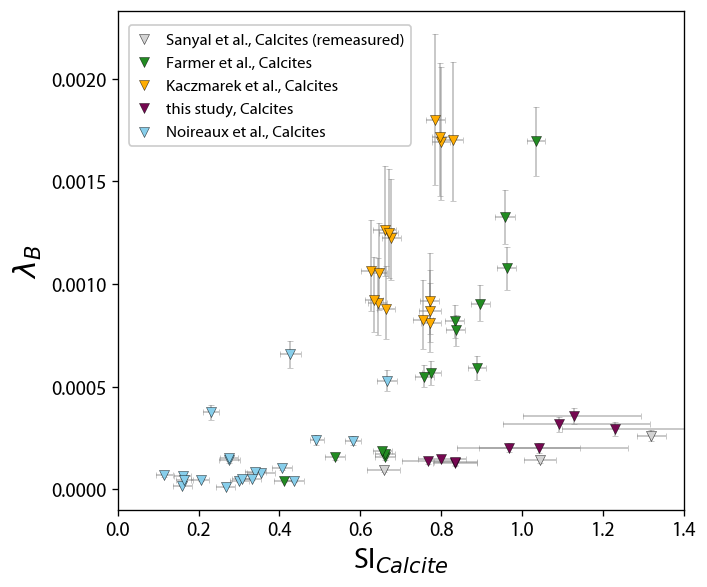

In [57]:
## Plotting just Lambda B in Calcites vs SI


fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(6,5))

ax1.set_xlim(0,1.4)
#ax1.set_ylim(-4,13)

ax1.errorbar(MC_SICalc_median[(df.CalcOrArag=='Calc')],MClambdaB_median[(df.CalcOrArag=='Calc')],
            xerr=[highSICalcErr[(df.CalcOrArag=='Calc')],lowSICalcErr[(df.CalcOrArag=='Calc')]],
            yerr= [lowlambdaBErr[(df.CalcOrArag=='Calc')],highlambdaBErr[(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
for indices, names in zip([SanyalCalcs.index,FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['KSanyalwildboot','KFarmerwildboot','KKaczmarekwildboot','KUsCalcswildboot','KUsAragswildboot','KNoireauxCalcswildboot', 'KNoireauxAragswildboot']):
    #residuald11BfromKlochko[names]=d11Bmeas_MCmedian[indices]-d11BborateK_MCmedian[indices]
    if sum(df.Calc[indices])==0:
        pass
    else:
        ax1.scatter(MC_SICalc_median[indices],MClambdaB_median[indices], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)

#ax1.text(7.3, 1.4222, 'a. this study', fontweight='semibold', color='black', fontsize=13)



#X = MC_SICalc_median[(df.CalcOrArag=='Calc')].values.reshape(-1, 1)  # values converts it into a numpy array
#Y = MClambdaB_median[(df.CalcOrArag=='Calc')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
#linear_regressor = LinearRegression()  # create object for the class
#linear_regressor.fit(X,Y)  # perform linear regression
#X1=np.linspace(min(X),max(X),10)
#Y_pred = linear_regressor.predict(X1)  # make predictions
#ax1.plot(X1, Y_pred, color='red', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Calcites')

ax1.legend(loc=(0.02,0.73), framealpha=1,fontsize=10, handlelength=1)

#ax1.text(0.02, 11.29, 'a.', color='black', fontsize=28,fontweight='semibold')

ax1.tick_params(labelsize=12)

ax1.set_xlabel('SI$_{Calcite}$', fontsize=18)
ax1.set_ylabel('$\lambda$$_{B}$', fontsize=18)
#ax1.text(0.87, 12, 'a. α=1.00272', fontweight='semibold', color='black', fontsize=13)

fig.tight_layout() 
fig.savefig('lambdaBcalcite vs SI_NewMCsRaewSanyal2se.pdf')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Semibold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


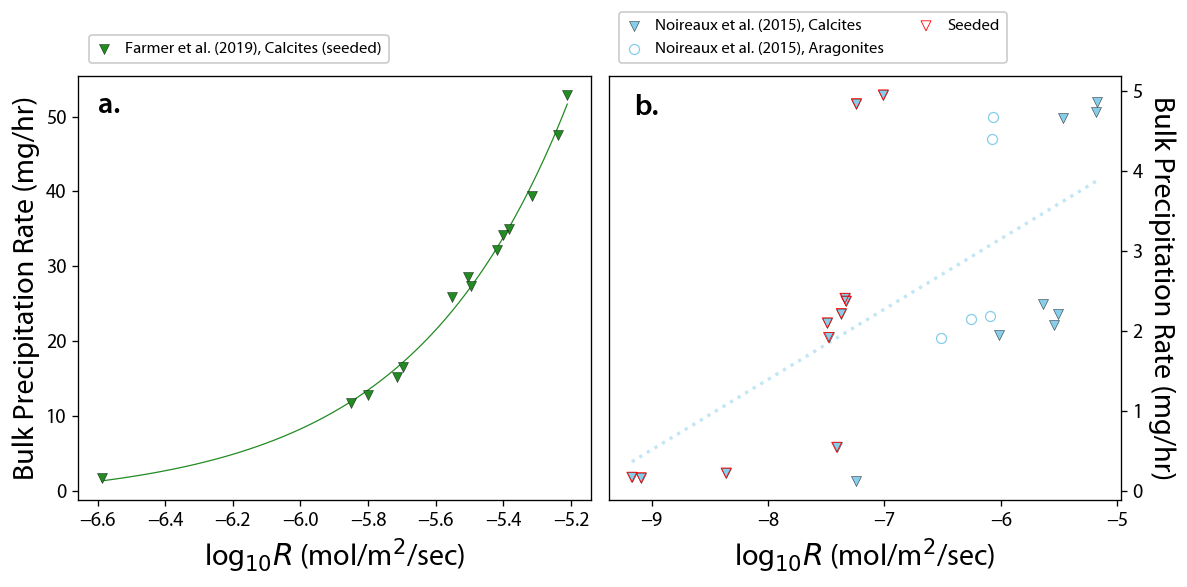

In [268]:

## Comparing the area-normalised growth rate to bulk metric.

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))


X = df.logR[(df.Study=='Noireaux')&(df.CalcOrArag=='Calc')&(df.logR.notna())].values.reshape(-1, 1) # values converts it into a numpy array
Y = df.RmgHr[(df.Study=='Noireaux')&(df.CalcOrArag=='Calc')&(df.logR.notna())].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
X1=np.linspace(min(X),max(X),10)
Y_pred = linear_regressor.predict(X1)# make predictions
r2calc=stats.linregress(df.logR[(df.Study=='Noireaux')&(df.CalcOrArag=='Calc')&(df.logR.notna())], df.RmgHr[(df.Study=='Noireaux')&(df.CalcOrArag=='Calc')&(df.logR.notna())]).rvalue**2
ax2.plot(X1, Y_pred, color='skyblue', linestyle=':',linewidth=2,zorder=-1,alpha=0.5)



t=np.array(df.logR[(df.Study=='Uchikawa')&(df.CalcOrArag=='Calc')&(df.logR.notna())])
v=np.array(df.RmgHr[(df.Study=='Uchikawa')&(df.CalcOrArag=='Calc')&(df.logR.notna())])
# initial guess for curve fit coefficients
a0 = 0
b0 = 0
alpha0 = 2
# coefficients and curve fit for curve(a0, b0, alpha0)
popt4, pcov4 = curve_fit(func, t, v, p0=(a0, b0, alpha0), maxfev=1000000)
a, b, alpha = popt4
v_fit = func(t, a, b, alpha)
ss_res = np.sum((v - v_fit) ** 2)       # residual sum of squares
ss_tot = np.sum((v - np.mean(v)) ** 2)  # total sum of squares
r2 = 1 - (ss_res / ss_tot)              # R squared fit, R^2
testx=np.linspace(min(df.logR[(df.Study=='Uchikawa')&(df.CalcOrArag=='Calc')&(df.logR.notna())]),max(df.logR[(df.Study=='Uchikawa')&(df.CalcOrArag=='Calc')&(df.logR.notna())]),100)
testy=a*np.exp(alpha*testx)+b
ax1.plot(testx, testy, color='forestgreen', linewidth=0.75, zorder=-2)


ax1.scatter(df.logR[FarmerCalcs.index],df.RmgHr[FarmerCalcs.index], color='black', facecolors='forestgreen', label='Farmer et al. (2019), Calcites (seeded)', marker='v', linewidths=0.25, zorder=2)    
ax2.scatter(df.logR[NoireauxCalcs.index],df.RmgHr[NoireauxCalcs.index], color='black', facecolors='skyblue', label='Noireaux et al. (2015), Calcites', marker='v', linewidths=0.25, zorder=2)    
ax2.scatter(df.logR[NoireauxArags.index],df.RmgHr[NoireauxArags.index], color='skyblue', facecolors='white', label='Noireaux et al. (2015), Aragonites', marker='o', linewidths=0.75, zorder=2)    
ax2.scatter(df.logR[(df.Study=="Noireaux")&(df.Calc==True)&(df.seeds==True)],df.RmgHr[(df.Study=="Noireaux")&(df.Calc==True)&(df.seeds==True)],color='red',facecolors='none',marker='v', label='Seeded', linewidths=0.5, zorder=3)

ax1.legend(loc=(0.02,1.03), framealpha=1,fontsize=10, handlelength=1)
ax2.legend(loc=(0.02,1.03), framealpha=1,fontsize=10, handlelength=1, ncol=2)

#ax1.text(0.02, 11.29, 'a.', color='black', fontsize=28,fontweight='semibold')


ax1.text(-6.6, 50.5, 'a.', fontweight='semibold', color='black', fontsize=18)
ax2.text(-9.15, 4.7, 'b.', fontweight='semibold', color='black', fontsize=18)


ax2.yaxis.tick_right()
ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
ax1.set_xlabel('log$_{10}R$ (mol/m$^{2}$/sec)', fontsize=18)
ax1.set_ylabel('Bulk Precipitation Rate (mg/hr)', fontsize=18)
ax2.set_xlabel('log$_{10}R$ (mol/m$^{2}$/sec)', fontsize=18)
ax2.yaxis.set_label_position('right')
ax2.set_ylabel('Bulk Precipitation Rate (mg/hr)', fontsize=18, rotation=270, labelpad=20)

fig.tight_layout() 
fig.savefig('metrics of rate.pdf')


In [ ]:

# uses best fits from Farmer et als' data as initial parameter guesses.
# note parameter order: (Kb3, Kf3, Kb4, Kf4, logRb)
initial_guess = [ 2.94347580e+02,  3.37745999e-01,  4.07268432e+03,  6.14664732e+00, -7.52027238e+00] ## these are the numbers stored in the array below
#initial_guess =np.load('fit_params.npy')


# calculated logR from calculated R, for plotting
#rds.loc[:, ('Solid', 'log_calc_R')] = np.log10(rds.loc[:, ('Solid', 'calc_R')]).values
# don't need this because you have it- it's log10RfromSI
predLambdaBs={}
predEpsilonBs={}
fits={}

for indices, datasets in zip([SanyalCalcs.index,FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['SanyalCalcs','FarmerCalcs','KaczmarekCalcs','UsCalcs','UsArags','NoireauxCalcs', 'NoireauxArags']):
    # Precipitation Rate
    Rp = (RfromSI[indices]).values
    logRp = (log10RfromSI[indices]).values
    # Solution BO3/C and BO4/CO3 ratios
    rL3 = (MCtotalBoric_median[indices]/MC_DIC_median[indices]).astype(float).values
    rL4 = (MCtotalBorate_median[indices]/MCcarbion_median[indices]).astype(float).values
    # B/DIC for LambdaB calculation
    B_DIC = ((MCtotalBoric_median[indices]+MCtotalBorate_median[indices])/MC_DIC_median[indices]).astype(float).values
    # Isotopic content of each B species
    ABO3 = d11_2_A11(MCd11BboricKRae_median[indices].astype(float).values)
    ABO4 = d11_2_A11(MCd11BborateKRae_median[indices].astype(float).values)
    # Borate d11B for EpsilonB calculation
    dBO4 = MCd11BborateKRae_median[indices].astype(float).values
    # Measured LambdaB and EpsilonB fo residual calculation
    LambdaB = MClambdaB_median[indices].astype(float).values
    EpsilonB = MCEpsilonKRae_median[indices].astype(float).values
    # bias factor applied to lambda residuals to account for difference in
    # the variance of the two parameters
    lambda_bias = np.ptp(EpsilonB) / np.ptp(LambdaB)
    fit = opt.minimize(fitfn, x0=initial_guess,
                   method='Powell', options={'maxiter': 20000, 'disp': True},
                   args=(Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4,
                         LambdaB, EpsilonB, 1, 1, lambda_bias))
    fits[datasets] = fit
    LambdaB_pred, EpsilonB_pred = predfn(*fit.x, Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4) ## Notes: the * symbol at the start here is key.. 
    predLambdaBs[datasets]=LambdaB_pred
    predEpsilonBs[datasets]=EpsilonB_pred

In [ ]:
Rp = (RfromSI[FarmerCalcs.index]).values
logRp = (log10RfromSI[FarmerCalcs.index]).values
# Solution BO3/C and BO4/CO3 ratios
rL3 = (MCtotalBoric_median[FarmerCalcs.index]/MC_DIC_median[FarmerCalcs.index]).astype(float).values
rL4 = (MCtotalBorate_median[FarmerCalcs.index]/MCcarbion_median[FarmerCalcs.index]).astype(float).values
# B/DIC for LambdaB calculation
B_DIC = ((MCtotalBoric_median[FarmerCalcs.index]+MCtotalBorate_median[FarmerCalcs.index])/MC_DIC_median[FarmerCalcs.index]).astype(float).values
# Isotopic content of each B species
ABO3 = d11_2_A11(MCd11BboricKRae_median[FarmerCalcs.index].astype(float).values)
ABO4 = d11_2_A11(MCd11BborateKRae_median[FarmerCalcs.index].astype(float).values)
# Borate d11B for EpsilonB calculation
dBO4 = MCd11BborateKRae_median[FarmerCalcs.index].astype(float).values
# Measured LambdaB and EpsilonB fo residual calculation
LambdaB = MClambdaB_median[FarmerCalcs.index].astype(float).values
EpsilonB = MCEpsilonKRae_median[FarmerCalcs.index].astype(float).values
# bias factor applied to lambda residuals to account for difference in
# the variance of the two parameters
lambda_bias = np.ptp(EpsilonB) / np.ptp(LambdaB)
farmerfit = opt.minimize(fitfn, x0=initial_guess,
                method='Powell', options={'maxiter': 20000, 'disp': True},
                args=(Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4,
                LambdaB, EpsilonB, 1, 1, lambda_bias))
FarmerLambdaB_pred, FarmerEpsilonB_pred = predfn(*farmerfit.x, Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4) ## Notes: the * symbol at the start here is key.. 


In [ ]:
39.61-dBO4
plt.scatter(df.pH[FarmerCalcs.index],dBO4)


In [ ]:
## Fit produces (Kb3, Kf3, Kb4, Kf4, logRb)
fits
#fits['UsCalcs']

In [ ]:
plt.scatter(predLambdaBs['UsCalcs'],MClambdaB_median[UsCalcs.index]*1000)

In [ ]:
modelresidualLambda={}
modelresidualEpsilon={}
for indeces, names in zip([SanyalCalcs.index,FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['SanyalCalcs','FarmerCalcs','KaczmarekCalcs','UsCalcs','UsArags','NoireauxCalcs', 'NoireauxArags']):
    modelresidualLambda[names]=predLambdaBs[names]-MClambdaB_median[indeces]
    modelresidualEpsilon[names]=predEpsilonBs[names]-MCEpsilonKRae_median[indeces]

In [ ]:
## Plotting Predicted Lambda vs SI

#Ncolours={'NFarmerwildboot':"forestgreen",'NKaczmarekwildboot':"#ffad01",'NUsCalcswildboot':"#750851",'NUsAragswildboot':"#750851",'NNoireauxCalcswildboot':"skyblue",'NNoireauxAragswildboot':"skyblue"}
#Kcolours={'KFarmerwildboot':"forestgreen",'KKaczmarekwildboot':"#ffad01",'KUsCalcswildboot':"#750851",'KUsAragswildboot':"#750851",'KNoireauxCalcswildboot':"skyblue",'KNoireauxAragswildboot':"skyblue"}
#Nserieslabels={'NFarmerwildboot':'Farmer et al., Calcites','NKaczmarekwildboot':'Kaczmarek et al., Calcites','NUsCalcswildboot':'this study, Calcites','NUsAragswildboot':'this study, Aragonites','NNoireauxCalcswildboot':'Noireaux et al., Calcites', 'NNoireauxAragswildboot':'Noireaux et al., Aragonites'}
#Kserieslabels={'KFarmerwildboot':'Farmer et al., Calcites','KKaczmarekwildboot':'Kaczmarek et al., Calcites','KUsCalcswildboot':'this study, Calcites','KUsAragswildboot':'this study, Aragonites','KNoireauxCalcswildboot':'Noireaux et al., Calcites', 'KNoireauxAragswildboot':'Noireaux et al., Aragonites'}


Kcolours={'SanyalCalcs':"lightgray",'FarmerCalcs':"forestgreen",'KaczmarekCalcs':"#ffad01",'UsCalcs':"#750851",'UsArags':"#750851",'NoireauxCalcs':"skyblue",'NoireauxArags':"skyblue"}
Kserieslabels={'SanyalCalcs':'Sanyal et al., Calcites (remeasured)','FarmerCalcs':'Farmer et al., Calcites','KaczmarekCalcs':'Kaczmarek et al., Calcites','UsCalcs':'this study, Calcites','UsArags':'this study, Aragonites','NoireauxCalcs':'Noireaux et al., Calcites', 'NoireauxArags':'Noireaux et al., Aragonites'}


fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

## First Subplot = LambdaB predicted vs Observed, coded by study
ax1.set_xlim(-0.03,0.01)
ax1.set_ylim(0,0.0035)
ax1.plot((-2,2),(-2,2), color='gray', zorder=0)
for indeces, names in zip([SanyalCalcs.index,FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['SanyalCalcs','FarmerCalcs','KaczmarekCalcs','UsCalcs','UsArags','NoireauxCalcs', 'NoireauxArags']):
    if sum(df.Calc[indeces])==0:
        ax1.scatter(predLambdaBs[names],(MClambdaB_median[indeces]), color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
        #pass   #this is saying that you don't want Aragonites.. comment out above if you want them.
    else:
        ax1.scatter(predLambdaBs[names],(MClambdaB_median[indeces]), color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)

#ax1.errorbar(MC_SIArag_median[(df.CalcOrArag=='Arag')], MClambdaB_median[(df.CalcOrArag=='Arag')],
#            xerr=[highSIAragErr[(df.CalcOrArag=='Arag')],lowSIAragErr[(df.CalcOrArag=='Arag')]],
#            yerr= [lowlambdaBErr[(df.CalcOrArag=='Arag')],highlambdaBErr[(df.CalcOrArag=='Arag')]],
#            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
#ax1.errorbar(MC_SICalc_median[(df.CalcOrArag=='Calc')],MClambdaB_median[(df.CalcOrArag=='Calc')],
#            xerr=[highSICalcErr[(df.CalcOrArag=='Calc')],lowSICalcErr[(df.CalcOrArag=='Calc')]],
#            yerr= [lowlambdaBErr[(df.CalcOrArag=='Calc')],highlambdaBErr[(df.CalcOrArag=='Calc')]],
#            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

## Second Subplot = LambdaB residual vs SI, coded by study
ax2.set_xlim(0,1.4)
#ax2.set_ylim(-1,1)
ax2.axhline(y=0, color='gray', zorder=0)
for indeces, names in zip([SanyalCalcs.index,FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['SanyalCalcs','FarmerCalcs','KaczmarekCalcs','UsCalcs','UsArags','NoireauxCalcs', 'NoireauxArags']):
    #residuald11BfromKlochko[names]=d11Bmeas_MCmedian[indices]-d11BborateK_MCmedian[indices]
    if sum(df.Calc[indeces])==0:
        ax2.scatter(MC_SIArag_median[indeces],modelresidualLambda[names], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
    else:
        ax2.scatter(MC_SICalc_median[indeces],modelresidualLambda[names], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)

#ax2.axvline(x=(18.03*((10**3)/298.15)-32.42), color='red', linestyle=':',label='Equilibrium line, Calcite') ## Kim et al. 2007 Equilibrium Aragonite fractionation at 25˚C
#ax2.axvline(x=(17.88*((10**3)/298.15)-31.14), color='blue', linestyle=':',label='Equilibrium line, Aragonite') ## Kim & ONeil Equilibrium Calcite fractionation at 25˚C
#ax2.errorbar(df.OxyFract[(df.Study=='us')], MClambdaB_median[(df.Study=='us')],
#            yerr= [lowlambdaBErr[(df.Study=='us')],highlambdaBErr[(df.Study=='us')]],
#            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

#ax2.scatter(d11Bmeas_MCmedian[FarmerCalcs.index],Kpredictedd11Bcarb['KFarmerwildboot'])
#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )
#bbox_to_anchor=(1.51, 0.21)
#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )
#ax1.text(7.3, 1.4222, 'a. this study', fontweight='semibold', color='black', fontsize=13)
#ax2.text(7.3, 1.4, 'b. existing data', fontweight='semibold', color='black', fontsize=13)

## Third Subplot = EpsilonB predicted vs Observed, coded by study
ax3.set_xlim(0,10)
ax3.set_ylim(-4,14)
ax3.plot((-5,15),(-5,15), color='gray', zorder=0)
for indeces, names in zip([SanyalCalcs.index,FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['SanyalCalcs','FarmerCalcs','KaczmarekCalcs','UsCalcs','UsArags','NoireauxCalcs', 'NoireauxArags']):
    if sum(df.Calc[indeces])==0:
        ax3.scatter(predEpsilonBs[names],(MCEpsilonKRae_median[indeces]), color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
    else:
        ax3.scatter(predEpsilonBs[names],(MCEpsilonKRae_median[indeces]), color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)


## Fourth Subplot = EpsilonB residual vs SI, coded by study
#ax4.set_xlim(-0.3,1.4)
ax4.axhline(y=0, color='gray', zorder=0)
for indeces, names in zip([SanyalCalcs.index,FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['SanyalCalcs','FarmerCalcs','KaczmarekCalcs','UsCalcs','UsArags','NoireauxCalcs', 'NoireauxArags']):
    if sum(df.Calc[indeces])==0:
        ax4.scatter(MC_SIArag_median[indeces],modelresidualEpsilon[names], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
    else:
        ax4.scatter(MC_SICalc_median[indeces],modelresidualEpsilon[names], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)






#X = MC_SICalc_median[(df.CalcOrArag=='Calc')].values.reshape(-1, 1)  # values converts it into a numpy array
##Y = MClambdaB_median[(df.CalcOrArag=='Calc')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
#linear_regressor = LinearRegression()  # create object for the class
#linear_regressor.fit(X,Y)  # perform linear regression
#X1=np.linspace(min(X),max(X),10)
#Y_pred = linear_regressor.predict(X1)  # make predictions
#ax1.plot(X1, Y_pred, color='red', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Calcites')#

#X = MC_SIArag_median[(df.CalcOrArag=='Arag')].values.reshape(-1, 1)  # values converts it into a numpy array
#Y = MClambdaB_median[(df.CalcOrArag=='Arag')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
####linear_regressor = LinearRegression()  # create object for the class
#linear_regressor.fit(X,Y) # perform linear regression
##X1=np.linspace(min(X),max(X),10)
#Y_pred = linear_regressor.predict(X1)  # make predictions
#ax1.plot(X1, Y_pred, color='blue', linestyle=':',linewidth=2,zorder=-1,alpha=0.5,label='Linear fit, Aragonites')##

#ax1.legend(loc=(0.58,0.65), framealpha=1,fontsize=10)
#ax2.legend(loc=(0.57,0.8535), framealpha=1,fontsize=10)

#ax1.text(0.02, 11.29, 'a.', color='black', fontsize=28,fontweight='semibold')
#ax2.text(28.02, 6.6, 'b.', color='black', fontsize=28,fontweight='semibold')


ax2.yaxis.tick_right()
ax4.yaxis.tick_right()

ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
ax4.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('right')
ax1.set_xlabel('Modelled $\lambda$$_{B}$', fontsize=18)
ax2.set_xlabel('SI (Aragonite or Calcite)', fontsize=18)
ax3.set_xlabel('Modelled $\epsilon$$_{B}$ (‰)', fontsize=18)
ax4.set_xlabel('SI (Aragonite or Calcite)', fontsize=18)
ax1.set_ylabel('Observed $\lambda$$_{B}$', fontsize=18)
ax2.set_ylabel('Model - Data', fontsize=18, labelpad=25, rotation=270)
ax3.set_ylabel('Observed $\epsilon$$_{B}$ (‰)', fontsize=18)
ax4.set_ylabel('Model - Data (‰)', fontsize=18, labelpad=25, rotation=270)
#ax1.text(0.87, 12, 'a. α=1.00272', fontweight='semibold', color='black', fontsize=13)
#ax2.text(28.83, 0, 'Kim et al. 2007', color='blue', fontsize=10, rotation=270)
#ax2.text(28.055, 0, 'Kim & O`Neil 1997', color='red', fontsize=10, rotation=270)
#ax2.text(0.92, 12, 'b. α=1.0026', fontweight='semibold', color='black', fontsize=13)

fig.tight_layout() 
fig.savefig('model-data comparison withSanyal.pdf')

In [ ]:
predLambdaBs

In [ ]:
## Nothing to do with the Na/B of the solution


NaBsol=df.Ave_NamMol/df.Ave_BmMol

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
for indeces, names in zip([FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['FarmerCalcs','KaczmarekCalcs','UsCalcs','UsArags','NoireauxCalcs', 'NoireauxArags']):
    if sum(df.Calc[indeces])==0:
        ax1.scatter(NaBsol[indeces],modelresidualLambda[names], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
    else:
        ax1.scatter(NaBsol[indeces],modelresidualLambda[names], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)

    #ax1.scatter(NaBsol[indeces],modelresidualLambda[names])
    
    
    
    
    #                
#                
#                =predLambdaBs[names]-(MClambdaB_median[indeces])##
#
#for indeces, names in zip([FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['FarmerCalcs','KaczmarekCalcs','UsCalcs','UsArags','NoireauxCalcs', 'NoireauxArags']):
#    if sum(df.Calc[indeces])==0:
#        ax1.scatter(predLambdaBs[names],(MClambdaB_median[indeces]), color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
#        #pass   #this is saying that you don't want Aragonites.. comment out above if you want them.
#    else:
#        ax1.scatter(predLambdaBs[names],(MClambdaB_median[indeces]), color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)



In [ ]:
## Nothing to do with the Na/B of the solution


Nasol=df.Ave_NamMol
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
for indeces, names in zip([FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['FarmerCalcs','KaczmarekCalcs','UsCalcs','UsArags','NoireauxCalcs', 'NoireauxArags']):
    if sum(df.Calc[indeces])==0:
        ax1.scatter(Nasol[indeces],modelresidualLambda[names], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
    else:
        ax1.scatter(Nasol[indeces],modelresidualLambda[names], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)

    #ax1.scatter(NaBsol[indeces],modelresidualLambda[names])
    
    

In [ ]:
#lets try Mg then. 
Mgsol=df.Ave_MgmMol

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
#ax1.set_xlim(0,5)
for indeces, names in zip([FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['FarmerCalcs','KaczmarekCalcs','UsCalcs','UsArags','NoireauxCalcs', 'NoireauxArags']):
    if sum(df.Calc[indeces])==0:
        ax1.scatter(np.log10(Mgsol[indeces]),modelresidualLambda[names], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
    else:
        ax1.scatter(np.log10(Mgsol[indeces]),modelresidualLambda[names], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)
for indeces, names in zip([FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['FarmerCalcs','KaczmarekCalcs','UsCalcs','UsArags','NoireauxCalcs', 'NoireauxArags']):
    if sum(df.Calc[indeces])==0:
        ax2.scatter(np.log10(Mgsol[indeces]),modelresidualEpsilon[names], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
    else:
        ax2.scatter(np.log10(Mgsol[indeces]),modelresidualEpsilon[names], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)

## Note, I checked, and Mgsol is only weakly correlated with calculated SI for these experiments.. 
   
    

In [ ]:
MgCasol=df.Ave_MgmMol/df.Ave_CamMol

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
#ax1.set_xlim(0,5)
for indeces, names in zip([FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['FarmerCalcs','KaczmarekCalcs','UsCalcs','UsArags','NoireauxCalcs', 'NoireauxArags']):
    if sum(df.Calc[indeces])==0:
        ax1.scatter(np.log10(MgCasol[indeces]),modelresidualLambda[names], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
    else:
        ax1.scatter(np.log10(MgCasol[indeces]),modelresidualLambda[names], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)
for indeces, names in zip([FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['FarmerCalcs','KaczmarekCalcs','UsCalcs','UsArags','NoireauxCalcs', 'NoireauxArags']):
    if sum(df.Calc[indeces])==0:
        ax2.scatter(np.log10(MgCasol[indeces]),modelresidualEpsilon[names], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
    else:
        ax2.scatter(np.log10(MgCasol[indeces]),modelresidualEpsilon[names], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)




In [ ]:

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
ax1.set_xlim(-2,0.55)
ax2.set_xlim(-2,0.55)
for indeces, names in zip([FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['FarmerCalcs','KaczmarekCalcs','UsCalcs','UsArags','NoireauxCalcs', 'NoireauxArags']):
    if sum(df.Calc[indeces])==0:
        ax1.scatter(df.logR[indeces],modelresidualLambda[names], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
    else:
        ax1.scatter(df.logR[indeces],modelresidualLambda[names], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)
for indeces, names in zip([FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['FarmerCalcs','KaczmarekCalcs','UsCalcs','UsArags','NoireauxCalcs', 'NoireauxArags']):
    if sum(df.Calc[indeces])==0:
        ax2.scatter(df.logR[indeces],modelresidualEpsilon[names], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
    else:
        ax2.scatter(df.logR[indeces],modelresidualEpsilon[names], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)



In [ ]:
solparam=df.Ave_MgmMol/MCtotalborate_median

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
#ax1.set_xlim(-2,0.55)
#ax2.set_xlim(-2,0.55)
for indeces, names in zip([FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['FarmerCalcs','KaczmarekCalcs','UsCalcs','UsArags','NoireauxCalcs', 'NoireauxArags']):
    if sum(df.Calc[indeces])==0:
        ax1.scatter(np.log10(solparam[indeces]),modelresidualLambda[names], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
    else:
        ax1.scatter(np.log10(solparam[indeces]),modelresidualLambda[names], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)
for indeces, names in zip([FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['FarmerCalcs','KaczmarekCalcs','UsCalcs','UsArags','NoireauxCalcs', 'NoireauxArags']):
    if sum(df.Calc[indeces])==0:
        ax2.scatter(np.log10(solparam[indeces]),modelresidualEpsilon[names], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
    else:
        ax2.scatter(np.log10(solparam[indeces]),modelresidualEpsilon[names], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)



In [ ]:
# Plotting B/Ca against Na/Ca to show the better agreement between the two. 

fig, ([ax1, ax2],[ax3, ax4]) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))


#ax1.set_xlim(0,0.00005)
#ax1.plot((0,30), (0,1500),linestyle='solid', c='black', linewidth=1, zorder=0)
ax1.scatter(1000*MClambdaNa_median[(df.CalcOrArag=='Calc')&(df.Study=='us')], 1000*MClambdaB_median[(df.CalcOrArag=='Calc')&(df.Study=='us')], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax1.errorbar(1000*MClambdaNa_median[(df.Study=='us')&(df.CalcOrArag=='Calc')], 1000*MClambdaB_median[(df.Study=='us')&(df.CalcOrArag=='Calc')],
            xerr=[0.03*1000*MClambdaNa_median[(df.Study=='us')&(df.CalcOrArag=='Calc')],0.03*1000*MClambdaNa_median[(df.Study=='us')&(df.CalcOrArag=='Calc')]],
            yerr= [0.06*1000*MClambdaB_median[(df.Study=='us')&(df.CalcOrArag=='Calc')],0.06*1000*MClambdaB_median[(df.Study=='us')&(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.xaxis.tick_top()
ax1.tick_params(labelsize=14)
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('1000$\lambda$$_{Na}$', fontsize=18)
ax1.set_ylabel('1000$\lambda$$_{B}$', labelpad=10, fontsize=18)

#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )
#bbox_to_anchor=(1.51, 0.21)

X = 1000*MClambdaNa_median[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = 1000*MClambdaB_median[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
ax1.plot(X, Y_pred, color='red')




#ax2.set_ylim(0,0.0035)
#ax1.plot((0,30), (0,1500),linestyle='solid', c='black', linewidth=1, zorder=0
ax2.errorbar(1000*MClambdaNa_median[(df.Study=='us')&(df.CalcOrArag=='Calc')], 1000*MClambdaMg_median[(df.Study=='us')&(df.CalcOrArag=='Calc')],
            xerr=[0.03*1000*MClambdaNa_median[(df.Study=='us')&(df.CalcOrArag=='Calc')],0.03*1000*MClambdaNa_median[(df.Study=='us')&(df.CalcOrArag=='Calc')]],
            yerr= [0.03*1000*MClambdaMg_median[(df.Study=='us')&(df.CalcOrArag=='Calc')],0.03*1000*MClambdaMg_median[(df.Study=='us')&(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax2.scatter(1000*MClambdaNa_median[(df.CalcOrArag=='Calc')&(df.Study=='us')], 1000*MClambdaMg_median[(df.CalcOrArag=='Calc')&(df.Study=='us')], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax2.yaxis.tick_right()
ax2.xaxis.tick_top()
ax2.tick_params(labelsize=14)
ax2.xaxis.set_label_position('top')
ax2.yaxis.set_label_position('right')
ax2.set_xlabel('1000$\lambda$$_{Na}$', fontsize=18)
ax2.set_ylabel('1000$\lambda$$_{Mg}$', labelpad=20, fontsize=18, rotation=270)

#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )
#bbox_to_anchor=(1.51, 0.21)
X = 1000*MClambdaNa_median[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = 1000*MClambdaMg_median[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
ax2.plot(X, Y_pred, color='red')


#ax3.set_xlim(0,0.00075)
#ax3.set_ylim(0,0.0035)
#ax1.plot((0,30), (0,1500),linestyle='solid', c='black', linewidth=1, zorder=0)
ax3.scatter(1000*MClambdaNa_median[(df.CalcOrArag=='Arag')&(df.Study=='us')], 1000*MClambdaB_median[(df.CalcOrArag=='Arag')&(df.Study=='us')], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax3.errorbar(1000*MClambdaNa_median[(df.Study=='us')&(df.CalcOrArag=='Arag')], 1000*MClambdaB_median[(df.Study=='us')&(df.CalcOrArag=='Arag')],
            xerr=[1000*0.03*MClambdaNa_median[(df.Study=='us')&(df.CalcOrArag=='Arag')],1000*0.03*MClambdaNa_median[(df.Study=='us')&(df.CalcOrArag=='Arag')]],
            yerr= [1000*0.06*MClambdaB_median[(df.Study=='us')&(df.CalcOrArag=='Arag')],1000*0.06*MClambdaB_median[(df.Study=='us')&(df.CalcOrArag=='Arag')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
#ax1.xaxis.tick_top()
ax3.tick_params(labelsize=14)
#ax1.xaxis.set_label_position('top')
ax3.set_xlabel('1000$\lambda$$_{Na}$', fontsize=18)
ax3.set_ylabel('1000$\lambda$$_{B}$', labelpad=10, fontsize=18)

#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )
#bbox_to_anchor=(1.51, 0.21)

X = 1000*MClambdaNa_median[(df.CalcOrArag=='Arag')&(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = 1000*MClambdaB_median[(df.CalcOrArag=='Arag')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
ax3.plot(X, Y_pred, color='blue')

#ax1.plot((0,30), (0,1500),linestyle='solid', c='black', linewidth=1, zorder=0)

#ax4.set_xlim(0,0.00075)
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position('right')
ax4.scatter(1000*MClambdaNa_median[(df.CalcOrArag=='Arag')&(df.Study=='us')], 1000*MClambdaMg_median[(df.CalcOrArag=='Arag')&(df.Study=='us')], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax4.errorbar(1000*MClambdaNa_median[(df.Study=='us')&(df.CalcOrArag=='Arag')], 1000*MClambdaMg_median[(df.Study=='us')&(df.CalcOrArag=='Arag')],
            xerr=[1000*0.03*MClambdaNa_median[(df.Study=='us')&(df.CalcOrArag=='Arag')],1000*0.03*MClambdaNa_median[(df.Study=='us')&(df.CalcOrArag=='Arag')]],
            yerr= [1000*0.03*MClambdaMg_median[(df.Study=='us')&(df.CalcOrArag=='Arag')],1000*0.03*MClambdaMg_median[(df.Study=='us')&(df.CalcOrArag=='Arag')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
#ax1.xaxis.tick_top()
ax4.tick_params(labelsize=14)
#ax1.xaxis.set_label_position('top')
ax4.set_xlabel('1000$\lambda$$_{Na}$', fontsize=18)
ax4.set_ylabel('1000$\lambda$$_{Mg}$', labelpad=20, fontsize=18, rotation=270)

#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )
#bbox_to_anchor=(1.51, 0.21)

X = 1000*MClambdaNa_median[(df.CalcOrArag=='Arag')&(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = 1000*MClambdaMg_median[(df.CalcOrArag=='Arag')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
ax4.plot(X, Y_pred, color='blue')

#ax1.legend(loc=(0.02,0.82), framealpha=1,fontsize=12, labelspacing=0.1)

fig.tight_layout() 
fig.savefig('lambda comparison.pdf')

In [ ]:
## Checking normal seawater values
swcheck= pd.read_csv('seawater.csv', header=0)
## Making the correction to NBS pH to MacInnes 'scale' for Pitzer database.. 
## Used the average of different solution chemistries tested by Oded Nir et al. (2014), Water Research https://doi.org/10.1016/j.watres.2014.07.006
#BPcheckpHMacInnes=pd.Series((BPcheck.pH+((0.0224*np.log(BPcheck.IonicStrength))+0.0665)),index=BPcheck.index)
#BPcheck.insert(9, 'pHMacInnes', BPcheckpHMacInnes)
## Running PHREEQC on Average-Experiment Solutions
# Should work for all 
## Pick your Pitzer Flavour (keep an eye on what you chose above). 
dbase='pitzer'


## Creating empty dataframes for data to go in
swoutputs = pd.DataFrame(index=swcheck.index, columns=np.arange(35))

## 
## this paper only has the PCO2 as partial pressure.. so you need the C in equilibrium phases and the CO2 in equilibrium phases
for row in swcheck.index:
    template="""
       SOLUTION {row:.0f}
            temp      {temp:.3f}
            -pressure  1  
            pH        {pH:.5f}
            units     {units:s}
            density   1 calculate
            Cl        {Cl:.9f}
            Na        {Na:.9f}
            Mg        {Mg:.9f}
            B         {B:.9f}
            Ca        {Ca:.9f}
            C(4)    10 CO2(g) -1.542
            K         {K:.9f}
            S(6)      {SO4:.9f}
            -water    1 # kg
        EQUILIBRIUM_PHASES
            CO2(g)    -1.542 10000
            #Calcite  0.0  CO2(g) 10
            SELECTED_OUTPUT
                -pH
                -temperature
                -alkalinity
                -ionic_strength
                -totals Cl Na Mg K B Ca C S(6)
                -m OH- H+
                # pitzer outputs
                #-m B(OH)4- B(OH)3 CaB(OH)4+ B3O3(OH)4- B4O5(OH)4-2  # boron
                #-m HCO3- CO3-2 CO2  # carbon
                # pitzerX outputs  
                -m B(OH)4- B(OH)3 CaB(OH)4+ NaB(OH)4 MgB(OH)4+ B3O3(OH)4- B4O5(OH)4-2 # boron
                -m HCO3- CO3-2 CO2  # carbon
                -m Ca+2 Mg+2 #Cations
                -si Calcite Aragonite
            END"""
    
    PhreeqcInput=template.format(temp=df.Temp[row],
                pH=swcheck.pH[row],
                Na=swcheck.Ave_NamMol[row],
                Cl=swcheck.Ave_ClmMol[row],
                B=swcheck.Ave_BmMol[row],
                Ca=swcheck.Ave_CamMol[row],
                Mg=swcheck.Ave_MgmMol[row],
                SO4=swcheck.Ave_SO4mMol[row],
                units=swcheck.Units[row],
                K=swcheck.Ave_KmMol[row],
                Sr=swcheck.Ave_SrmMol[row],
                F=swcheck.Ave_FmMol[row],
                row=swcheck.index[row])
    phreeqc.load_database(os.path.join(database_path, dbase + '.dat'))
   # phreeqc.run_string(PhreeqcInput)
    data = run_phreeqc(PhreeqcInput, os.path.join(database_path, dbase + '.dat'), phreeq_path=phreeq_path)
    iterationdata=pd.Series(data.values)
    iterationdata.index=['simulation', 'state', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp(C)',
        'eqkgwAlk', 'mu', 'molkgwCl', 'molkgwNa', 'molkgwMg',
        'molkgwK', 'molkgwB', 'molkgwCa', 'molkgwC',
        'molkgwS', 'molkgwOHminus', 'molkgwHplus',
        'molkgwBoratefree', 'molkgwBoric', 'molkgwCaBorateplus',
        'molkgwNaBorate', 'molkgwMgBorateplus', 'molkgwB3O3OH4minus',
        'molkgwB4O5OH4minus2', 'molkgwBicarb', 'molkgwCarbion',
        'molkgwCO2aq', 'molkgwCafree','molkgwMgfree','SI_Calc', 'SI_Arag'] 
    swoutputs.loc[row]=pd.array(iterationdata)
 
    
swoutputs.columns=['simulation', 'state', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp(C)',
        'eqkgwAlk', 'mu', 'molkgwCl', 'molkgwNa', 'molkgwMg',
        'molkgwK', 'molkgwB', 'molkgwCa', 'molkgwC',
        'molkgwS', 'molkgwOHminus', 'molkgwHplus',
        'molkgwBoratefree', 'molkgwBoric', 'molkgwCaBorateplus',
        'molkgwNaBorate', 'molkgwMgBorateplus', 'molkgwB3O3OH4minus',
        'molkgwB4O5OH4minus2', 'molkgwBicarb', 'molkgwCarbion',
        'molkgwCO2aq', 'molkgwCafree','molkgwMgfree','SI_Calc', 'SI_Arag'] 
swoutputs.index=swcheck.index



In [ ]:
swoutputs


In [ ]:

#np.log10(swoutputs.molkgwCafree.values.astype(float))
test1=(-1*np.log10(swoutputs.molkgwCafree.values.astype(float)))-(-1*np.log10(swoutputs.molkgwCarbion.values.astype(float)))
test1

In [ ]:

## Checking Busenberg and Plummer 1985 data

## Master Data File
BPcheck= pd.read_csv('BP1985.csv', header=0)

## Making the correction to NBS pH to MacInnes 'scale' for Pitzer database.. 
## Used the average of different solution chemistries tested by Oded Nir et al. (2014), Water Research https://doi.org/10.1016/j.watres.2014.07.006
BPcheckpHMacInnes=pd.Series((BPcheck.pH+((0.0224*np.log(BPcheck.IonicStrength))+0.0665)),index=BPcheck.index)
BPcheck.insert(9, 'pHMacInnes', BPcheckpHMacInnes)
## Running PHREEQC on Average-Experiment Solutions
# Should work for all 
## Pick your Pitzer Flavour (keep an eye on what you chose above). 
dbase='pitzer'


## Creating empty dataframes for data to go in

BPoutputs = pd.DataFrame(index=BPcheck.index, columns=np.arange(34))
BPlambdaNa=pd.Series(index=BPcheck.index)
BP_KDNa=pd.Series(index=BPcheck.index)
## 
## this paper only has the PCO2 as partial pressure.. so you need the C in equilibrium phases and the CO2 in equilibrium phases
for row in BPcheck.index:
    template="""
        SOLUTION {row:.0f}
            temp      {temp:.3f}
            -pressure  1  
            pH        {pH:.5f}
            units     {units:s}
            density   1 calculate
            Cl        {Cl:.9f}
            Na        {Na:.9f}
            Mg        {Mg:.9f}
            B         {B:.9f}
            Ca        {Ca:.9f}
            C(4)    10 CO2(g) -1.542
            K         {K:.9f}
            S(6)      {SO4:.9f}
            -water    1 # kg
        EQUILIBRIUM_PHASES
            CO2(g)    -1.542 10000
            #Calcite  0.0  CO2(g) 10
        SELECTED_OUTPUT
            -pH
            -temperature
            -alkalinity
            -ionic_strength
            -totals Cl Na Mg K B Ca C S(6)
            -m OH- H+
            # pitzer outputs
            #-m B(OH)4- B(OH)3 CaB(OH)4+ B3O3(OH)4- B4O5(OH)4-2  # boron
            #-m HCO3- CO3-2 CO2  # carbon
            # pitzerX outputs
            -m B(OH)4- B(OH)3 CaB(OH)4+ NaB(OH)4 MgB(OH)4+ B3O3(OH)4- B4O5(OH)4-2 # boron
            -m HCO3- CO3-2 CO2 CO2(g) # carbon
            -si Calcite Aragonite
        END"""
    
    PhreeqcInput=template.format(temp=df.Temp[row],
                pH=BPcheck.pHMacInnes[row],
                Na=BPcheck.Ave_NamMol[row],
                Cl=BPcheck.Ave_ClmMol[row],
                B=BPcheck.Ave_BmMol[row],
                Ca=BPcheck.Ave_CamMol[row],
                Mg=BPcheck.Ave_MgmMol[row],
                SO4=BPcheck.Ave_SO4mMol[row],
                units=BPcheck.Units[row],
                K=BPcheck.Ave_KmMol[row],
                row=BPcheck.index[row])
    phreeqc.load_database(os.path.join(database_path, dbase + '.dat'))
   # phreeqc.run_string(PhreeqcInput)
    data = run_phreeqc(PhreeqcInput, os.path.join(database_path, dbase + '.dat'), phreeq_path=phreeq_path)
    iterationdata=pd.Series(data.values)
    iterationdata.index=['simulation', 'state', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp(C)',
       'eqkgwAlk', 'mu', 'molkgwCl', 'molkgwNa', 'molkgwMg',
       'molkgwK', 'molkgwB', 'molkgwCa', 'molkgwC',
       'molkgwS', 'molkgwOHminus', 'molkgwHplus',
       'molkgwBoratefree', 'molkgwBoric', 'molkgwCaBorateplus',
       'molkgwNaBorate', 'molkgwMgBorateplus', 'molkgwB3O3OH4minus',
       'molkgwB4O5OH4minus2', 'molkgwBicarb', 'molkgwCarbion',
       'molkgwCO2aq','CO2gas', 'SI_Calc', 'SI_Arag']
    BPoutputs.loc[row]=pd.array(iterationdata)
    BPlambdaNa[row]=(BPcheck.NaCa_mmol[row]/1000)/(iterationdata.molkgwNa/iterationdata.molkgwC)
    BP_KDNa[row]=(BPcheck.NaCa_mmol[row]/1000)/(iterationdata.molkgwNa/iterationdata.molkgwCa)

    
BPoutputs.columns=['simulation', 'state', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp(C)',
       'eqkgwAlk', 'mu', 'molkgwCl', 'molkgwNa', 'molkgwMg',
       'molkgwK', 'molkgwB', 'molkgwCa', 'molkgwC',
       'molkgwS', 'molkgwOHminus', 'molkgwHplus',
       'molkgwBoratefree', 'molkgwBoric', 'molkgwCaBorateplus',
       'molkgwNaBorate', 'molkgwMgBorateplus', 'molkgwB3O3OH4minus',
       'molkgswB4O5OH4minus2', 'molkgwBicarb', 'molkgswCarbion',
       'molkgswCO2aq','CO2gas', 'SI_Calc', 'SI_Arag']
BPoutputs.index=BPcheck.index

BPoutputs['BPlambdaNa']=BPlambdaNa
BPoutputs['BP_KDNa']=BP_KDNa

BPoutputs.to_csv('BPsolutions_Pitzer.csv')



In [ ]:
BP_KDNa-BPlambdaNa

'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


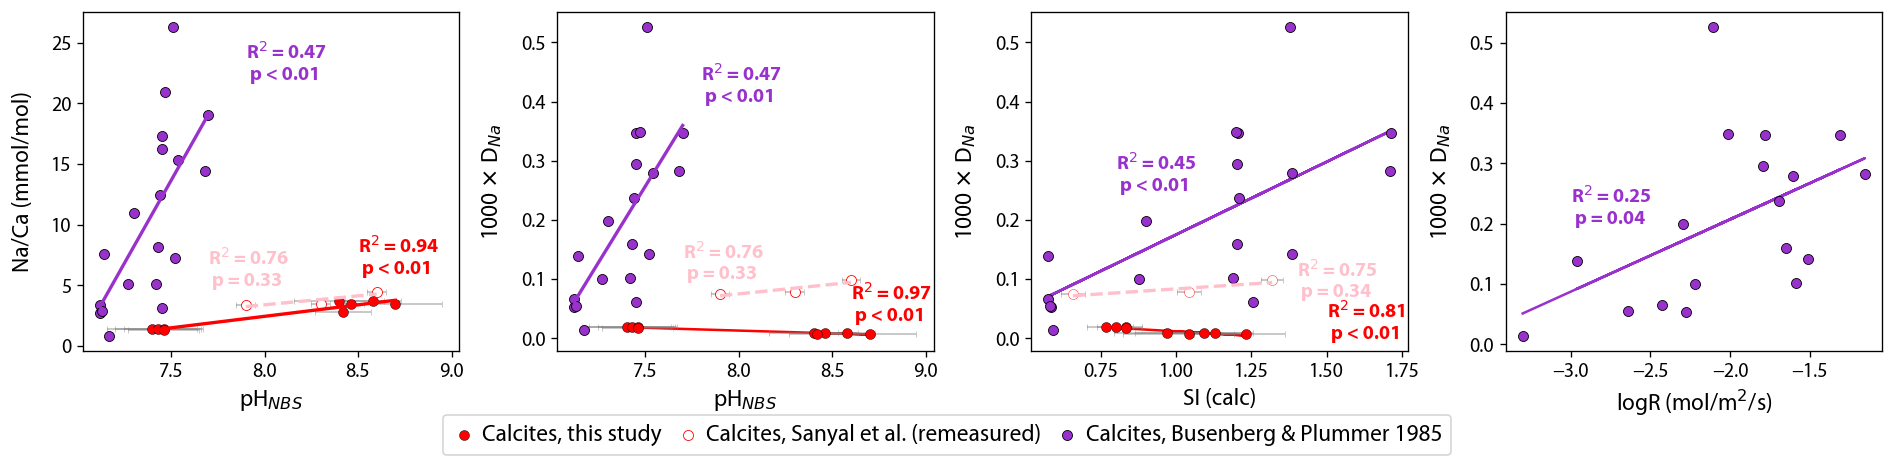

In [71]:
## Master Data File
BPcheck= pd.read_csv('BP1985.csv', header=0)
BPoutputs= pd.read_csv('BPsolutions_Pitzer.csv', header=0)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

#ax1.set_xlim(0,30)
#ax1.set_ylim(0,0.002)
ax1.tick_params(labelsize=12)
#ax1.xaxis.set_label_position('top')
ax1.set_xlabel('pH$_{NBS}$', fontsize=14)
ax1.set_ylabel('Na/Ca (mmol/mol)', labelpad=10, fontsize=14)

#ax1.plot((0,30), (0,1500),linestyle='solid', c='black', linewidth=1, zorder=0)

ax1.errorbar(df.pH[(df.Study=='us')&(df.CalcOrArag=='Calc')], df.NaCa_mmol[(df.Study=='us')&(df.CalcOrArag=='Calc')],
            xerr=[df.pHerr[(df.Study=='us')&(df.CalcOrArag=='Calc')],df.pHerr[(df.Study=='us')&(df.CalcOrArag=='Calc')]],
            yerr= [0.03*df.NaCa_mmol[(df.Study=='us')&(df.CalcOrArag=='Calc')],0.03*df.NaCa_mmol[(df.Study=='us')&(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.errorbar(df.pH[(df.Study=='Sanyal')&(df.CalcOrArag=='Calc')], df.NaCa_mmol[(df.Study=='Sanyal')&(df.CalcOrArag=='Calc')],
            xerr=[df.pHerr[(df.Study=='Sanyal')&(df.CalcOrArag=='Calc')],df.pHerr[(df.Study=='Sanyal')&(df.CalcOrArag=='Calc')]],
            yerr= [0.03*df.NaCa_mmol[(df.Study=='Sanyal')&(df.CalcOrArag=='Calc')],0.03*df.NaCa_mmol[(df.Study=='Sanyal')&(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(df.pH[df.Study=='Sanyal'], df.NaCa_mmol[df.Study=='Sanyal'])
X1=np.linspace(min(df.pH[df.Study=='Sanyal']),max(df.pH[df.Study=='Sanyal']),100)
if Cp_value<0.01:
    ax1.plot(X1,X1*Cslope + Cintercept, color='pink', linewidth=2)
    ax1.text(7.7, 5, 'R$^2$ = %.2f \n p < 0.01' % (Cr_value**2), color='pink', fontsize=12,fontweight='bold')
elif Cp_value>0.05:
    ax1.plot(X1,X1*Cslope + Cintercept, color='pink', linewidth=2, linestyle='--')
    ax1.text(7.7, 5, 'R$^2$ = %.2f \n p = %.2f' % (Cr_value**2, Cp_value), color='pink', fontsize=12,fontweight='bold')
else:
    ax1.plot(X1,X1*Cslope + Cintercept, color='pink', linewidth=2)
    ax1.text(7.7, 5, 'R$^2$ = %.2f \n p = %.2f' % (Cr_value**2, Cp_value), color='pink', fontsize=12,fontweight='bold')
    
Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(df.pH[(df.CalcOrArag=='Calc')&(df.Study=='us')], df.NaCa_mmol[(df.CalcOrArag=='Calc')&(df.Study=='us')])
X1=np.linspace(min(df.pH[(df.CalcOrArag=='Calc')&(df.Study=='us')]),max(df.pH[(df.CalcOrArag=='Calc')&(df.Study=='us')]),100)
if Cp_value<0.01:
    ax1.plot(X1,X1*Cslope + Cintercept, color='red', linewidth=2)
    ax1.text(8.5, 6, 'R$^2$ = %.2f \n p < 0.01' % (Cr_value**2), color='red', fontsize=12,fontweight='bold')
elif Cp_value>0.05:
    ax1.plot(X1,X1*Cslope + Cintercept, color='red', linewidth=2, linestyle='--')
    ax1.text(8.5, 6, 'R$^2$ = %.2f \n = p = %.2f' % (Cr_value**2, Cp_value), color='red', fontsize=12,fontweight='bold')
else:
    ax1.plot(X1,X1*Cslope + Cintercept, color='red', linewidth=2)
    ax1.text(8.5, 6, 'R$^2$ = %.2f \n p = %.2f' % (Cr_value**2, Cp_value), color='red', fontsize=12,fontweight='bold')


BPslope, BPintercept, BPr_value, BPp_value, BPstd_err = stats.linregress(BPcheck.pH, BPcheck.NaCa_mmol)
X1=np.linspace(min(BPcheck.pH),max(BPcheck.pH),100)
if BPp_value<0.01:
    ax1.plot(X1,X1*BPslope + BPintercept, color='darkorchid', linewidth=2)
    ax1.text(7.9, 22, 'R$^2$ = %.2f \n p < 0.01' % (BPr_value**2), color='darkorchid', fontsize=12,fontweight='bold')
elif BPp_value>0.05:
    ax1.plot(X1,X1*BPslope + BPintercept, color='darkorchid', linewidth=2, linestyle='--')
    ax1.text(7.9, 22, 'R$^2$ = %.2f \n p < 0.01' % (BPr_value**2), color='darkorchid', fontsize=12,fontweight='bold')
else:
    ax1.plot(X1,X1*BPslope + BPintercept, color='darkorchid', linewidth=2)
    ax1.text(7.9, 22, 'R$^2$ = %.2f \n p = %.2f' % (BPr_value**2, BPp_value), color='darkorchid', fontsize=12,fontweight='bold')

ax1.scatter(df.pH[(df.CalcOrArag=='Calc')&(df.Study=='us')], df.NaCa_mmol[(df.CalcOrArag=='Calc')&(df.Study=='us')], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites, this study', marker='o')
#ax1.scatter(df.pH[(df.CalcOrArag=='Arag')&(df.Study=='us')], df.NaCa_mmol[(df.CalcOrArag=='Arag')&(df.Study=='us')], \
#            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax1.scatter(df.pH[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')], df.NaCa_mmol[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')], \
            color='red',linewidths=0.5, facecolors='white', label='Calcites, Sanyal et al. (remeasured)', marker='o')
ax1.scatter(BPcheck.pH, BPcheck.NaCa_mmol, \
            color='black',linewidths=0.5, facecolors='darkorchid', label='Calcites, Busenberg & Plummer 1985', marker='o')

#ax1.xaxis.tick_top()



#ax2.set_ylim(0,0.0015)
#ax1.plot((0,30), (0,1500),linestyle='solid', c='black', linewidth=1, zorder=0)
#ax1.xaxis.tick_top()
ax2.tick_params(labelsize=12)
#ax1.xaxis.set_label_position('top')
ax2.set_xlabel('pH$_{NBS}$', fontsize=14)
ax2.set_ylabel(r'1000 $\times$ D$_{Na}$', labelpad=10, fontsize=14)
ax2.errorbar(df.pH[(df.Study=='us')&(df.CalcOrArag=='Calc')], MC_KDNa_median[(df.Study=='us')&(df.CalcOrArag=='Calc')],
            xerr=[df.pHerr[(df.Study=='us')&(df.CalcOrArag=='Calc')],df.pHerr[(df.Study=='us')&(df.CalcOrArag=='Calc')]],
            yerr= [lowKDNaErr[(df.Study=='us')&(df.CalcOrArag=='Calc')],highKDNaErr[(df.Study=='us')&(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax2.errorbar(df.pH[(df.Study=='Sanyal')&(df.CalcOrArag=='Calc')], MC_KDNa_median[(df.Study=='Sanyal')&(df.CalcOrArag=='Calc')],
            xerr=[df.pHerr[(df.Study=='Sanyal')&(df.CalcOrArag=='Calc')],df.pHerr[(df.Study=='Sanyal')&(df.CalcOrArag=='Calc')]],
            yerr= [lowKDNaErr[(df.Study=='Sanyal')&(df.CalcOrArag=='Calc')],highKDNaErr[(df.Study=='Sanyal')&(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

X = df.pH[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = MC_KDNa_median[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
ax2.plot(X, Y_pred, color='red',zorder=-2)
Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(df.pH[(df.CalcOrArag=='Calc')&(df.Study=='us')], MC_KDNa_median[(df.CalcOrArag=='Calc')&(df.Study=='us')])
if Cp_value<0.01:
    ax2.text(8.6, 0.03, 'R$^2$ = %.2f \n p < 0.01' % (Cr_value**2), color='red', fontsize=12,fontweight='bold')
else:
    ax2.text(8.6, 0.03, 'R$^2$ = %.2f \n p = %.2f' % (Cr_value**2, Cp_value), color='red', fontsize=12,fontweight='bold')

X = df.pH[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = MC_KDNa_median[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')].values.reshape(-1, 1)
Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(df.pH[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')], MC_KDNa_median[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')])
X1=np.linspace(min(df.pH[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')]),max(df.pH[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')]),100)
if Cp_value<0.01:
    ax2.plot(X1,X1*Cslope + Cintercept, color='pink', linewidth=2)
    ax2.text(7.7, 0.1, 'R$^2$ = %.2f \n p < 0.01' % (Cr_value**2), color='pink', fontsize=12,fontweight='bold')
elif Cp_value>0.05:
    ax2.plot(X1,X1*Cslope + Cintercept, color='pink', linewidth=2, linestyle='--')
    ax2.text(7.7, 0.1, 'R$^2$ = %.2f \n p = %.2f' % (Cr_value**2, Cp_value), color='pink', fontsize=12,fontweight='bold')
else:
    ax2.plot(X1,X1*Cslope + Cintercept, color='pink', linewidth=2)
    ax2.text(7.7, 0.1, 'R$^2$ = %.2f \n p = %.2f' % (Cr_value**2, Cp_value), color='pink', fontsize=12,fontweight='bold')

BPslope, BPintercept, BPr_value, BPp_value, BPstd_err = stats.linregress(BPcheck.pH, 1000*BPoutputs.BP_KDNa)
X1=np.linspace(min(BPcheck.pH),max(BPcheck.pH),100)
if BPp_value<0.01:
    ax2.plot(X1,X1*BPslope + BPintercept, color='darkorchid', linewidth=2)
    ax2.text(7.8, 0.4, 'R$^2$ = %.2f \n p < 0.01' % (BPr_value**2), color='darkorchid', fontsize=12,fontweight='bold')
elif Cp_value>0.05:
    ax2.plot(X1,X1*BPslope + BPintercept, color='darkorchid', linewidth=2, linestyle='--')
    ax2.text(7.7, 0.4, 'R$^2$ = %.2f \n p = %.2f' % (Cr_value**2, Cp_value), color='darkorchid', fontsize=12,fontweight='bold')
else:
    ax2.plot(X1,X1*BPslope + BPintercept, color='darkorchid', linewidth=2)
    ax2.text(7.8, 0.4, 'R$^2$ = %.2f \n p = %.2f' % (BPr_value**2, BPp_value), color='darkorchid', fontsize=12,fontweight='bold')

ax2.scatter(df.pH[(df.CalcOrArag=='Calc')&(df.Study=='us')], MC_KDNa_median[(df.CalcOrArag=='Calc')&(df.Study=='us')], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites, this study', marker='o')
ax2.scatter(df.pH[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')], MC_KDNa_median[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')], \
            color='red',linewidths=0.5, facecolors='white', label='Calcites, Sanyal et al. (remeasured)', marker='o')
ax2.scatter(BPcheck.pH, 1000*BPoutputs.BP_KDNa, \
            color='black',linewidths=0.5, facecolors='darkorchid', label='Calcites, Busenberg & Plummer 1985', marker='o')


#ax3.set_ylim(0,0.0015)
#ax3.get_yaxis().set_visible(False)
#ax1.plot((0,30), (0,1500),linestyle='solid', c='black', linewidth=1, zorder=0)
#ax1.xaxis.tick_top()
ax3.tick_params(labelsize=12)
#ax1.xaxis.set_label_position('top')
ax3.set_xlabel('SI (calc)', fontsize=14)
ax3.set_ylabel(r'1000 $\times$ D$_{Na}$', labelpad=10, fontsize=14)
ax3.errorbar(MC_SICalc_median[(df.Study=='us')&(df.CalcOrArag=='Calc')], MC_KDNa_median[(df.Study=='us')&(df.CalcOrArag=='Calc')],
            xerr=[lowSICalcErr[(df.Study=='us')&(df.CalcOrArag=='Calc')],highSICalcErr[(df.Study=='us')&(df.CalcOrArag=='Calc')]],
            yerr= [lowKDNaErr[(df.Study=='us')&(df.Calc==True)],highKDNaErr[(df.Study=='us')&(df.Calc==True)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax3.errorbar(MC_SICalc_median[df.Study=='Sanyal'], MC_KDNa_median[df.Study=='Sanyal'],
            xerr=[lowSICalcErr[df.Study=='Sanyal'],highSICalcErr[df.Study=='Sanyal']],
            yerr= [lowKDNaErr[df.Study=='Sanyal'],highKDNaErr[df.Study=='Sanyal']],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

X = MC_SICalc_median[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = MC_KDNa_median[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(MC_SICalc_median[(df.CalcOrArag=='Calc')&(df.Study=='us')], MC_KDNa_median[(df.CalcOrArag=='Calc')&(df.Study=='us')])
ax3.plot(X, Y_pred, color='red',zorder=-2)
if Cp_value<0.01:
    ax3.text(1.5, 0, 'R$^2$ = %.2f \n p < 0.01' % (Cr_value**2), color='red', fontsize=12,fontweight='bold')
else:
    ax3.text(1.5, 0, 'R$^2$ = %.2f \n p = %.2f' % (Cr_value**2, Cp_value), color='red', fontsize=12,fontweight='bold')

X = MC_SICalc_median[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = MC_KDNa_median[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')].values.reshape(-1, 1)
Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(MC_SICalc_median[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')], MC_KDNa_median[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')])
X1=np.linspace(min(MC_SICalc_median[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')]),max(MC_SICalc_median[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')]),100)
if Cp_value<0.01:
    ax3.plot(X1,X1*Cslope + Cintercept, color='pink', linewidth=2)
    ax3.text(1.4, 0.07, 'R$^2$ = %.2f \n p < 0.01' % (Cr_value**2), color='pink', fontsize=12,fontweight='bold')
elif Cp_value>0.05:
    ax3.plot(X1,X1*Cslope + Cintercept, color='pink', linewidth=2, linestyle='--')
    ax3.text(1.4, 0.07, 'R$^2$ = %.2f \n p = %.2f' % (Cr_value**2, Cp_value), color='pink', fontsize=12,fontweight='bold')
else:
    ax3.plot(X1,X1*Cslope + Cintercept, color='pink', linewidth=2)
    ax3.text(1.4, 0.07, 'R$^2$ = %.2f \n p = %.2f' % (Cr_value**2, Cp_value), color='pink', fontsize=12,fontweight='bold')

X = BPoutputs.SI_Calc.values.reshape(-1, 1)  # values converts it into a numpy array
Y = 1000*BPoutputs.BP_KDNa.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
ax3.plot(X, Y_pred, color='darkorchid',zorder=-2)
BPslope, BPintercept, BPr_value, BPp_value, BPstd_err = stats.linregress(BPoutputs.SI_Calc.astype(float), 1000*BPoutputs.BP_KDNa)
if BPp_value<0.01:
    ax3.text(0.8, 0.25, 'R$^2$ = %.2f \n p < 0.01' % (BPr_value**2), color='darkorchid', fontsize=12,fontweight='bold')
else:
    ax3.text(0.8, 0.25, 'R$^2$ = %.2f \n p = %.2f' % (BPr_value**2, BPp_value), color='darkorchid', fontsize=12,fontweight='bold')

ax3.scatter(MC_SICalc_median[(df.CalcOrArag=='Calc')&(df.Study=='us')], MC_KDNa_median[(df.CalcOrArag=='Calc')&(df.Study=='us')], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites, this study', marker='o')
ax3.scatter(MC_SICalc_median[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')], MC_KDNa_median[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')], \
            color='red',linewidths=0.25, facecolors='white', label='Calcites, Sanyal et al. (remeasured)', marker='o')
#ax3.scatter(MC_SIArag_median[(df.CalcOrArag=='Arag')&(df.Study=='us')], MC_KDNa_median[(df.CalcOrArag=='Arag')&(df.Study=='us')], \
#            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax3.scatter(BPoutputs.SI_Calc, 1000*BPoutputs.BP_KDNa, \
            color='black',linewidths=0.5, facecolors='darkorchid', label='Calcites, Busenberg & Plummer (1985)', marker='o')

#ax4.yaxis.tick_right()
#ax4.yaxis.set_label_position('right')
#ax4.set_ylim(0,0.0015)
ax4.tick_params(labelsize=12)
#ax1.xaxis.set_label_position('top')
ax4.set_xlabel('logR (mol/m$^2$/s)', fontsize=14)
ax4.set_ylabel(r'1000 $\times$ D$_{Na}$', labelpad=10, fontsize=14)

logRnoNA=BPcheck.logR.drop(BPcheck.logR.index[1])

#lambdanoNA=BPoutputs.BP_KDNa.drop(BPoutputs.index[1])
KDNanoNA=BPoutputs.BP_KDNa.drop(BPoutputs.index[1])
X = BPcheck.logR.drop(BPcheck.logR.index[1]).values.reshape(-1, 1)  # values converts it into a numpy array
Y = 1000*BPoutputs.BP_KDNa.drop(BPoutputs.index[1]).values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
ax4.plot(X, Y_pred, color='darkorchid', zorder=-2)
BPslope, BPintercept, BPr_value, BPp_value, BPstd_err = stats.linregress(BPcheck.logR.drop(BPcheck.logR.index[1]).astype(float), 1000*BPoutputs.BP_KDNa.drop(BPoutputs.index[1]))
ax4.text(-3, 0.2, 'R$^2$ = %.2f \n p = %.2f' % (BPr_value**2, BPp_value), color='darkorchid', fontsize=12,fontweight='bold')

ax4.scatter(BPcheck.logR, 1000*BPoutputs.BP_KDNa, \
            color='black',linewidths=0.5, facecolors='darkorchid', label='Calcites, Busenberg & Plummer (1985)', marker='o')

#ax4.legend(loc=(0.75,1), bbox_to_anchor=(0.1, 0.9),framealpha=1,fontsize='small' )
#bbox_to_anchor=(1.51, 0.21)
#ax1.legend(loc=(0.02,0.82), framealpha=1,fontsize=12, labelspacing=0.1)


handles,labels=ax1.get_legend_handles_labels()
fig.legend(handles,labels, loc="lower center", fontsize=14, labelspacing=0.15, frameon=True, borderaxespad=0.5, ncol=3, columnspacing=0.6,handlelength=1,handletextpad=0.3)


#fig.tight_layout() 
fig.tight_layout(pad=1.5,w_pad=0.5,h_pad=1,rect=(0,0.05,1,1))
#fig.savefig('BP1985 vs Us.pdf')
fig.savefig('BP1985 vs Us and Sanyal2se.pdf')

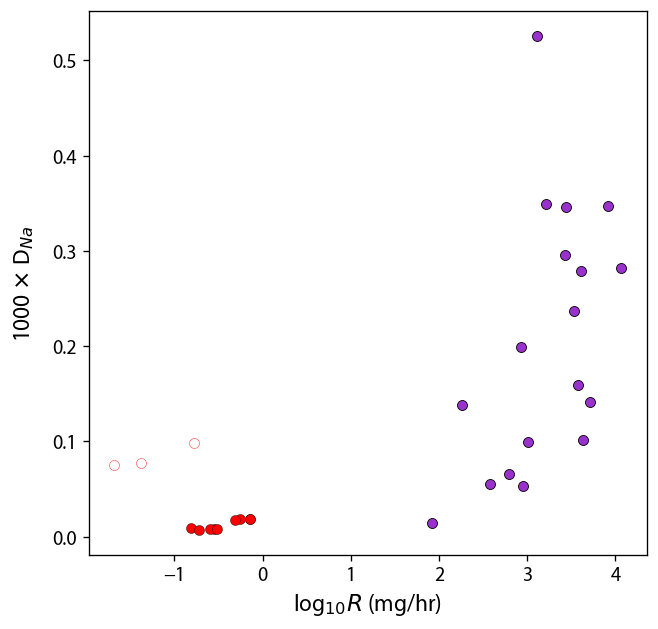

In [73]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

#ax1.set_xlim(0,30)
#ax1.set_ylim(0,0.002)
ax1.tick_params(labelsize=12)
#ax1.xaxis.set_label_position('top')
ax1.set_xlabel('log$_{10}R$ (mg/hr)', fontsize=14)
ax1.set_ylabel(r'1000 $\times$ D$_{Na}$', labelpad=10, fontsize=14)


ax1.scatter(np.log10(BPcheck.RmgHrg), 1000*BPoutputs.BP_KDNa, \
            color='black',linewidths=0.5, facecolors='darkorchid', label='Calcites, Busenberg & Plummer (1985)', marker='o')

ax1.scatter(df.logR[(df.CalcOrArag=='Calc')&(df.Study=='us')], MC_KDNa_median[(df.CalcOrArag=='Calc')&(df.Study=='us')], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites, this study', marker='o')
ax1.scatter(df.logR[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')], MC_KDNa_median[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')], \
            color='red',linewidths=0.25, facecolors='white', label='Calcites, Sanyal et al. (remeasured)', marker='o')


'MyriadPro-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


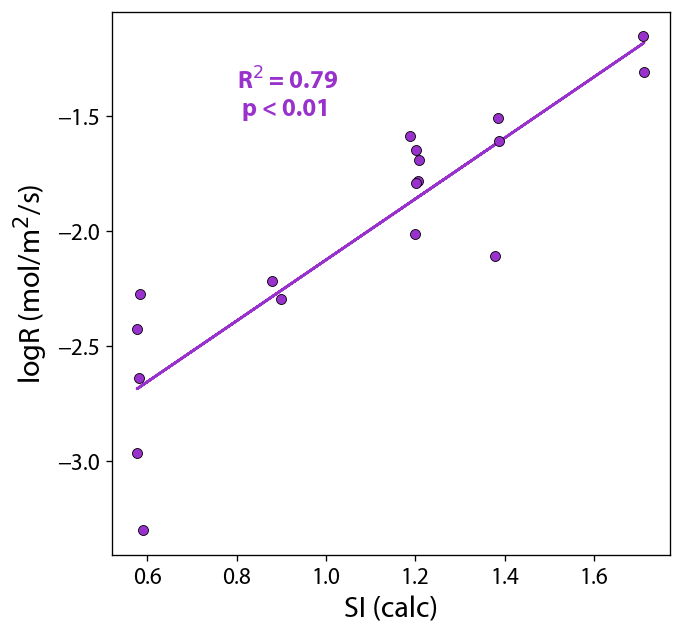

In [68]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

#ax1.set_xlim(0,30)
#ax1.set_ylim(0,0.002)
ax1.tick_params(labelsize=14)

logRnoNA=BPcheck.logR.drop(BPcheck.logR.index[1])
#lambdanoNA=BPoutputs.BP_KDNa.drop(BPoutputs.index[1])
KDNanoNA=BPoutputs.BP_KDNa.drop(BPoutputs.index[1])
SInoNA=BPoutputs.SI_Calc.drop(BPcheck.logR.index[1])

X = SInoNA.values.reshape(-1, 1)  # values converts it into a numpy array
Y = logRnoNA.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
ax1.plot(X, Y_pred, color='darkorchid',zorder=-2)
BPslope, BPintercept, BPr_value, BPp_value, BPstd_err = stats.linregress(SInoNA, logRnoNA)
if BPp_value<0.01:
    ax1.text(0.8, -1.5, 'R$^2$ = %.2f \n p < 0.01' % (BPr_value**2), color='darkorchid', fontsize=15,fontweight='bold')
else:
    ax1.text(0.8, -1.5, 'R$^2$ = %.2f \n p = %.2f' % (BPr_value**2, BPp_value), color='darkorchid', fontsize=15,fontweight='bold')
ax1.scatter(BPoutputs.SI_Calc, BPcheck.logR, \
            color='black',linewidths=0.5, facecolors='darkorchid', label='Calcites, Busenberg & Plummer (1985)', marker='o')
#ax1.scatter(MC_SICalc_median[(df.CalcOrArag=='Calc')&(df.Study=='us')], MC_KDNa_median[(df.CalcOrArag=='Calc')&(df.Study=='us')], \
#            color='black',linewidths=0.25, facecolors='red', label='Calcites, this study', marker='o')
#ax3.scatter(MC_SICalc_median[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')], MC_KDNa_median[(df.CalcOrArag=='Calc')&(df.Study=='Sanyal')], \
#            color='red',linewidths=0.25, facecolors='white', label='Calcites, Sanyal et al. (remeasured)', marker='o')
#ax3.scatter(MC_SIArag_median[(df.CalcOrArag=='Arag')&(df.Study=='us')], MC_KDNa_median[(df.CalcOrArag=='Arag')&(df.Study=='us')], \
#            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax1.set_xlabel('SI (calc)', fontsize=18)
ax1.set_ylabel('logR (mol/m$^2$/s)', fontsize=18)


fig.savefig('BP1985 RvsSI.pdf')

In [ ]:

## Checking pK*B

## Master Data File
pKBcheck= pd.read_csv('pKb-measurements.csv', header=0)

## Making the correction to NBS pH to MacInnes 'scale' for Pitzer database.. 
## Used the average of different solution chemistries tested by Oded Nir et al. (2014), Water Research https://doi.org/10.1016/j.watres.2014.07.006
pKBcheckpHMacInnes=pd.Series((pKBcheck.pH+((0.0224*np.log(pKBcheck.IonicStrength))+0.0665)),index=pKBcheck.index)
pKBcheck.insert(9, 'pHMacInnes', pKBcheckpHMacInnes)
## Running PHREEQC on Average-Experiment Solutions
# Should work for all 
## Pick your Pitzer Flavour (keep an eye on what you chose above). 
dbase='pitzer'

## Creating empty dataframes for data to go in
pKBcheckoutputs = pd.DataFrame(index=pKBcheck.index, columns=np.arange(28))
pKBchecktotalBorate = pd.Series(index=pKBcheck.index)
pKBchecktotalBoric = pd.Series(index=pKBcheck.index)
pKBcheckpercentPolyborates = pd.Series(index=pKBcheck.index)
pKBcheckpercentNaborates = pd.Series(index=pKBcheck.index)
pKBcheckpercentFreeBorate= pd.Series(index=pKBcheck.index)
pKBcheckKB_freeboratebicarb = pd.Series(index=pKBcheck.index)
pKBcheckKB_totalboratebicarb = pd.Series(index=pKBcheck.index)
pKBcheckKB_freeborateDIC = pd.Series(index=pKBcheck.index)
pKBcheckKB_totalborateDIC = pd.Series(index=pKBcheck.index)
pKBcheckpKB=pd.Series(index=pKBcheck.index)
pKBcheckKSO4=pd.Series(index=pKBcheck.index)
pKBcheckpKB_justfreeborate=pd.Series(index=pKBcheck.index)
## 
for row in pKBcheck.index:
    template="""
        SOLUTION {row:.0f}
            temp      {temp:.3f}
            pH        {pH:.5f}
            units     {units:s}
            density   1 calculate
            Cl        {Cl:.9f}
            Na        {Na:.9f}
            Mg        {Mg:.9f}
            B         {B:.9f}
            Ca        {Ca:.9f}
            K         {K:.9f}
            S(6)      {SO4:.9f}
            -water    1 # kg
        SELECTED_OUTPUT
            -pH
            -temperature
            -alkalinity
            -ionic_strength
            -totals Cl Na Mg K B Ca S(6)
            -m OH- H+
            # pitzer outputs
            #-m B(OH)4- B(OH)3 CaB(OH)4+ MgB(OH)4+ B3O3(OH)4- B4O5(OH)4-2  # boron
            #-m HCO3- CO3-2 CO2  # carbon
            # pitzerX outputs
            -m B(OH)4- B(OH)3 CaB(OH)4+ NaB(OH)4 MgB(OH)4+ B3O3(OH)4- B4O5(OH)4-2 # boron
            -m HSO4-
        END"""
    
    PhreeqcInput=template.format(temp=pKBcheck.Temp[row],
                pH=pKBcheck.pH[row],
                Na=pKBcheck.Na_Mol[row],
                Cl=pKBcheck.Cl_Mol[row],
                B=pKBcheck.B_Mol[row],
                Ca=pKBcheck.Ca_Mol[row],
                Mg=pKBcheck.Mg_Mol[row],
                SO4=pKBcheck.SO4_Mol[row],
                units=pKBcheck.Units[row],
                K=pKBcheck.K_Mol[row],
                row=pKBcheck.index[row])
    phreeqc.load_database(os.path.join(database_path, dbase + '.dat'))
   # phreeqc.run_string(PhreeqcInput)
    data = run_phreeqc(PhreeqcInput, os.path.join(database_path, dbase + '.dat'), phreeq_path=phreeq_path)
    iterationdata=pd.Series(data.values)
    iterationdata.index=['simulation', 'state', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp(C)',
       'eqkgwAlk', 'mu', 'molkgwCl', 'molkgwNa', 'molkgwMg',
       'molkgwK', 'molkgwB', 'molkgwCa', 'molkgwS', 'molkgwOHminus', 'molkgwHplus',
       'molkgwBoratefree', 'molkgwBoric', 'molkgwCaBorateplus',
       'molkgwNaBorate', 'molkgwMgBorateplus', 'molkgwB3O3OH4minus','molkgwB4O5OH4minus2','molkgwHSO4minus']
    pKBcheckoutputs.loc[row]=pd.array(iterationdata)
    pKBchecktotalBorate[row]=(iterationdata.molkgwNaBorate+iterationdata.molkgwBoratefree\
                           +iterationdata.molkgwCaBorateplus+iterationdata.molkgwMgBorateplus\
                          +(iterationdata.molkgwB4O5OH4minus2)/2) ## Half of B4O5OH4^-2 is trigonal, half tetrahedral
    pKBchecktotalBoric[row]=(iterationdata.molkgwBoric+iterationdata.molkgwB3O3OH4minus\
                          +(iterationdata.molkgwB4O5OH4minus2)/2)  ## Half of B4O5OH4^-2 is trigonal, half tetrahedral; All B3O3OH4- is trigonal
    pKBcheckpercentPolyborates[row]=((iterationdata.molkgwB3O3OH4minus+iterationdata.molkgwB4O5OH4minus2)/iterationdata.molkgwB)*100
    pKBcheckpercentNaborates[row]=(iterationdata.molkgwNaBorate/pKBchecktotalBorate[row])*100
    pKBcheckpercentFreeBorate[row]=(iterationdata.molkgwBoratefree/pKBchecktotalBorate[row])*100
    pKBcheckpKB[row]=-math.log10((pKBchecktotalBorate[row]*iterationdata.molkgwHplus)/pKBchecktotalBoric[row])
    if iterationdata.molkgwHSO4minus!=0:
        pKBcheckKSO4[row]=((iterationdata.molkgwS*iterationdata.molkgwHplus)/iterationdata.molkgwHSO4minus)
    pKBcheckpKB_justfreeborate[row]=-math.log10((iterationdata.molkgwBoratefree*iterationdata.molkgwHplus)/iterationdata.molkgwBoric)
    
pKBcheckoutputs.columns=['simulation', 'state', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp(C)',
       'eqkgwAlk', 'mu', 'molkgwCl', 'molkgwNa', 'molkgwMg',
       'molkgwK', 'molkgwB', 'molkgwCa', 'molkgwS', 'molkgwOHminus', 'molkgwHplus',
       'molkgwBoratefree', 'molkgwBoric', 'molkgwCaBorateplus',
       'molkgwNaBorate', 'molkgwMgBorateplus', 'molkgwB3O3OH4minus','molkgswB4O5OH4minus2','molkgwHSO4minus']
pKBcheckoutputs.index=pKBcheck.index
studylist=pd.array(pKBcheck.Study)
pKBcheckoutputs.insert(1, 'Study', studylist)

50
pKBcheckoutputs['totalBorate']=pKBchecktotalBorate
pKBcheckoutputs['totalBoric']=pKBchecktotalBoric
pKBcheckoutputs['percentPolyborates']=pKBcheckpercentPolyborates
pKBcheckoutputs['percentNaborates']=pKBcheckpercentNaborates
pKBcheckoutputs['percentFreeBorate']=pKBcheckpercentFreeBorate
pKBcheckoutputs['pKB']=pKBcheckpKB
pKBcheckoutputs['pKBcheckpKB_justfreeborate']=pKBcheckpKB_justfreeborate
pKBcheckoutputs['KSO4']=pKBcheckKSO4



pKBcheckoutputs.to_csv('pKBcheckPitzerX.csv') ## outputs to CSV so not lost when database changed


#PitzerXpKB=pKBcheckpKB ##outputting to variables for plotting comparison figure.. comment out if you don't want to rewrite with Pitzer value
#PitzerXpKBfreescaleobserved=freescaleobservedpKB ##outputting to variables for plotting comparison figure.. comment out if you don't want to rewrite with Pitzer value
#PitzerXpKB_justfreeborate=pKBcheckpKB_justfreeborate ##outputting to variables for plotting comparison figure.. comment out if you don't want to rewrite with Pitzer value
PitzerpKB=pKBcheckpKB ##outputting to variables for plotting comparison figure.. comment out if you don't want to rewrite with Pitzer value
PitzerpKBfreescaleobserved=freescaleobservedpKB ##outputting to variables for plotting comparison figure.. comment out if you don't want to rewrite with Pitzer value
PitzerpKB_justfreeborate=pKBcheckpKB_justfreeborate ##outputting to variables for plotting comparison figure.. comment out if you don't want to rewrite with Pitzer value

#iterationdata

In [ ]:
pKBcheckoutputs['PitzerXpKB']=PitzerXpKB
pKBcheckoutputs['PitzerXpKB_freescaleobserved']=PitzerXpKBfreescaleobserved
pKBcheckoutputs['PitzerXpKB_justfreeborate']=PitzerXpKB_justfreeborate
pKBcheckoutputs['PitzerpKB']=PitzerpKB
pKBcheckoutputs['PitzerpKB_freescaleobserved']=PitzerpKBfreescaleobserved
pKBcheckoutputs['PitzerpKB_justfreeborate']=PitzerpKB_justfreeborate

pKBcheckoutputs['Solution']=pKBcheck.Solution

# plot the results
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(nrows=2, ncols=2, figsize=(11,9))

ax1.set_xlim(8.5,9.3)
ax1.set_ylim(8.5,9.3)
ax1.plot((8.5,9.3), (8.5,9.3),linestyle='solid', c='black', linewidth=1, zorder=0)
ax1.scatter(pKBcheckoutputs.PitzerXpKB_freescaleobserved[(pKBcheck.Solution=='KCl')], pKBcheckoutputs.PitzerXpKB[(pKBcheckoutputs.Solution=='KCl')], \
            color='black',linewidths=0.25, facecolors='red', label='KCl', marker='o')
ax1.scatter(pKBcheckoutputs.PitzerXpKB_freescaleobserved[(pKBcheck.Solution=='NaCl')], pKBcheckoutputs.PitzerXpKB[(pKBcheckoutputs.Solution=='NaCl')], \
            color='black',linewidths=0.25, facecolors='yellow', label='NaCl', marker='o')
ax1.scatter(pKBcheckoutputs.PitzerXpKB_freescaleobserved[(pKBcheck.Solution=='ASW')], pKBcheckoutputs.PitzerXpKB[(pKBcheckoutputs.Solution=='ASW')], \
            color='black',linewidths=0.25, facecolors='blue', label='Artificial Seawater', marker='o')
ax1.scatter(pKBcheckoutputs.PitzerXpKB_freescaleobserved[(pKBcheck.Solution=='NaCaCl')], pKBcheckoutputs.PitzerXpKB[(pKBcheckoutputs.Solution=='NaCaCl')], \
            color='black',linewidths=0.25, facecolors='green', label='NaCaCl', marker='o')
ax1.scatter(pKBcheckoutputs.PitzerXpKB_freescaleobserved[(pKBcheck.Solution=='NaMgCl')], pKBcheckoutputs.PitzerXpKB[(pKBcheckoutputs.Solution=='NaMgCl')], \
            color='black',linewidths=0.25, facecolors='purple', label='NaMgCl', marker='o')
ax2.set_xlim(8.5,9.3)
ax2.set_ylim(8.5,9.3)
ax2.plot((8.5,9.3), (8.5,9.3),linestyle='solid', c='black', linewidth=1, zorder=0)
ax2.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='KCl')], pKBcheckoutputs.PitzerpKB[(pKBcheckoutputs.Solution=='KCl')], \
            color='black',linewidths=0.25, facecolors='red', label='KCl', marker='o')
ax2.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='NaCl')], pKBcheckoutputs.PitzerpKB[(pKBcheckoutputs.Solution=='NaCl')], \
            color='black',linewidths=0.25, facecolors='yellow', label='NaCl', marker='o')
ax2.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='ASW')], pKBcheckoutputs.PitzerpKB[(pKBcheckoutputs.Solution=='ASW')], \
            color='black',linewidths=0.25, facecolors='blue', label='Artificial Seawater', marker='o')
ax2.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='NaCaCl')], pKBcheckoutputs.PitzerpKB[(pKBcheckoutputs.Solution=='NaCaCl')], \
            color='black',linewidths=0.25, facecolors='green', label='NaCaCl', marker='o')
ax2.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='NaMgCl')], pKBcheckoutputs.PitzerpKB[(pKBcheckoutputs.Solution=='NaMgCl')], \
            color='black',linewidths=0.25, facecolors='purple', label='NaMgCl', marker='o')
ax3.set_xlim(8.5,9.3)
ax3.set_ylim(8.5,9.3)
ax3.plot((8.5,9.3), (8.5,9.3),linestyle='solid', c='black', linewidth=1, zorder=0)
ax3.scatter(pKBcheckoutputs.PitzerXpKB_freescaleobserved[(pKBcheck.Solution=='KCl')], pKBcheckoutputs.PitzerXpKB_justfreeborate[(pKBcheckoutputs.Solution=='KCl')], \
            color='black',linewidths=0.25, facecolors='red', label='KCl', marker='o')
ax3.scatter(pKBcheckoutputs.PitzerXpKB_freescaleobserved[(pKBcheck.Solution=='NaCl')], pKBcheckoutputs.PitzerXpKB_justfreeborate[(pKBcheckoutputs.Solution=='NaCl')], \
            color='black',linewidths=0.25, facecolors='yellow', label='NaCl', marker='o')
ax3.scatter(pKBcheckoutputs.PitzerXpKB_freescaleobserved[(pKBcheck.Solution=='ASW')], pKBcheckoutputs.PitzerXpKB_justfreeborate[(pKBcheckoutputs.Solution=='ASW')], \
            color='black',linewidths=0.25, facecolors='blue', label='Artificial Seawater', marker='o')
ax3.scatter(pKBcheckoutputs.PitzerXpKB_freescaleobserved[(pKBcheck.Solution=='NaCaCl')], pKBcheckoutputs.PitzerXpKB_justfreeborate[(pKBcheckoutputs.Solution=='NaCaCl')], \
            color='black',linewidths=0.25, facecolors='green', label='NaCaCl', marker='o')
ax3.scatter(pKBcheckoutputs.PitzerXpKB_freescaleobserved[(pKBcheck.Solution=='NaMgCl')], pKBcheckoutputs.PitzerXpKB_justfreeborate[(pKBcheckoutputs.Solution=='NaMgCl')], \
            color='black',linewidths=0.25, facecolors='purple', label='NaMgCl', marker='o')
ax4.set_xlim(8.5,9.3)
ax4.set_ylim(8.5,9.3)
ax4.plot((8.5,9.3), (8.5,9.3),linestyle='solid', c='black', linewidth=1, zorder=0)
ax4.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='KCl')], pKBcheckoutputs.PitzerpKB_justfreeborate[(pKBcheckoutputs.Solution=='KCl')], \
            color='black',linewidths=0.25, facecolors='red', label='KCl', marker='o')
ax4.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='NaCl')], pKBcheckoutputs.PitzerpKB_justfreeborate[(pKBcheckoutputs.Solution=='NaCl')], \
            color='black',linewidths=0.25, facecolors='yellow', label='NaCl', marker='o')
ax4.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='ASW')], pKBcheckoutputs.PitzerpKB_justfreeborate[(pKBcheckoutputs.Solution=='ASW')], \
            color='black',linewidths=0.25, facecolors='blue', label='Artificial Seawater', marker='o')
ax4.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='NaCaCl')], pKBcheckoutputs.PitzerpKB_justfreeborate[(pKBcheckoutputs.Solution=='NaCaCl')], \
            color='black',linewidths=0.25, facecolors='green', label='NaCaCl', marker='o')
ax4.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='NaMgCl')], pKBcheckoutputs.PitzerpKB_justfreeborate[(pKBcheckoutputs.Solution=='NaMgCl')], \
            color='black',linewidths=0.25, facecolors='purple', label='NaMgCl', marker='o')

ax2.yaxis.tick_right()
ax1.xaxis.tick_top()
ax2.xaxis.tick_top()
ax4.yaxis.tick_right()
ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)
ax3.tick_params(labelsize=14)
ax4.tick_params(labelsize=14)
ax2.yaxis.set_label_position('right')
ax4.yaxis.set_label_position('right')
ax1.xaxis.set_label_position('top')
ax2.xaxis.set_label_position('top')
ax1.set_xlabel('pK$^{*}$$_{B}$ (Observed)', fontsize=18)
ax2.set_xlabel('pK$^{*}$$_{B}$ (Observed)', fontsize=18)
ax3.set_xlabel('pK$^{*}$$_{B}$ (Observed)', fontsize=18)
ax4.set_xlabel('pK$^{*}$$_{B}$ (Observed)', fontsize=18)
ax1.set_ylabel('pK$^{*}$$_{B}$ (calculated)', labelpad=10, fontsize=18)
ax2.set_ylabel('pK$^{*}$$_{B}$ (calculated)', rotation=270, labelpad=25, fontsize=18)
ax3.set_ylabel('pK$^{*}$$_{B}$ (calculated)', labelpad=10, fontsize=18)
ax4.set_ylabel('pK$^{*}$$_{B}$ (calculated)', rotation=270, labelpad=25, fontsize=18)
ax1.text(8.53, 9.23, 'a. Total borate, PitzerX',fontweight='semibold', color='black', fontsize=13)
ax2.text(8.53, 9.23, 'b. Total borate, Pitzer', fontweight='semibold', color='black', fontsize=13)
ax3.text(8.53, 9.23, 'c. Free borate only, PitzerX', fontweight='semibold', color='black', fontsize=13)
ax4.text(8.53, 9.23, 'd. Free borate only, Pitzer', fontweight='semibold', color='black', fontsize=13)
ax2.legend(loc=(0.5,0.05), framealpha=1,fontsize=12)
#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )
#bbox_to_anchor=(1.51, 0.21)

fig.tight_layout() 


fig.savefig('pKB PitzerX vs Pitzer.pdf')



In [ ]:
# Just showing the fit of Pitzer (no comparison with PitzerX)
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

ax1.set_xlim(8.5,9.3)
ax1.set_ylim(8.5,9.3)
ax1.plot((8.5,9.3), (8.5,9.3),linestyle='solid', c='black', linewidth=1, zorder=0)
ax1.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='KCl')], pKBcheckoutputs.PitzerpKB[(pKBcheckoutputs.Solution=='KCl')], \
            color='black',linewidths=0.25, facecolors='red', label='KCl', marker='o')
ax1.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='NaCl')], pKBcheckoutputs.PitzerpKB[(pKBcheckoutputs.Solution=='NaCl')], \
            color='black',linewidths=0.25, facecolors='yellow', label='NaCl', marker='o')
ax1.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='NaCaCl')], pKBcheckoutputs.PitzerpKB[(pKBcheckoutputs.Solution=='NaCaCl')], \
            color='black',linewidths=0.25, facecolors='green', label='NaCaCl', marker='o')
ax1.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='NaMgCl')], pKBcheckoutputs.PitzerpKB[(pKBcheckoutputs.Solution=='NaMgCl')], \
            color='black',linewidths=0.25, facecolors='purple', label='NaMgCl', marker='o')
ax1.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='ASW')], pKBcheckoutputs.PitzerpKB[(pKBcheckoutputs.Solution=='ASW')], \
            color='black',linewidths=0.25, facecolors='blue', label='Artificial Seawater', marker='o')

#ax1.xaxis.tick_top()
ax1.tick_params(labelsize=14)
#ax1.xaxis.set_label_position('top')
ax1.set_xlabel('pK$^{*}$$_{B}$ (observed)', fontsize=18)
ax1.set_ylabel('pK$^{*}$$_{B}$ (calculated)', labelpad=10, fontsize=18)
#ax1.text(8.53, 9.23, 'a. Total borate, PitzerX',fontweight='semibold', color='black', fontsize=13)

ax1.legend(loc=(0.02,0.67), framealpha=1,fontsize=12, handlelength=1, handletextpad=1)
#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )
#bbox_to_anchor=(1.51, 0.21)

fig.tight_layout() 


fig.savefig('pKB Pitzer.pdf')

In [ ]:
## From this point on these are defunct blocks of code from how I was doing it before, but that might be needed in future

In [ ]:



## Running PHREEQC first on Starting Solutions
dbase='pitzer'

## Creating empty dataframes for data to go in
startoutputs = pd.DataFrame(index=df.index, columns=np.arange(33))
lambdaBstart = pd.Series(index=df.index)
totalBoratestart = pd.Series(index=df.index) 
totalBoricstart = pd.Series(index=df.index)
percentPolyboratesstart = pd.Series(index=df.index)
percentNaboratesstart = pd.Series(index=df.index)
percentFreeBoratestart= pd.Series(index=df.index)
KB_start_freeboratebicarb = pd.Series(index=df.index)
KB_start_totalboratebicarb = pd.Series(index=df.index)
KB_start_freeborateDIC = pd.Series(index=df.index)
KB_start_totalborateDIC = pd.Series(index=df.index)
pKB_start=pd.Series(index=df.index)
d11BborateK_start=pd.Series(index=df.index)
d11BborateNir_start=pd.Series(index=df.index)

#for row in range(len(df)):
for row in df.index:
    template="""
        SOLUTION {row:.0f}
            temp      {temp:.5f}
            pH        {pH:.9f}
            units     {units:s}
            density   1 calculate
            Cl        {Cl:.12f}
            Na        {Na:.12f}
            Mg        {Mg:.12f}
            B         {B:.12f}
            Ca        {Ca:.12f}
            C         {DIC:.12f}
            K         {K:.12f}
            S(6)      {SO4:.12f}
            -water    1 # kg
        SELECTED_OUTPUT
            -pH
            -temperature
            -alkalinity
            -ionic_strength
            -totals Cl Na Mg K B Ca C S(6)
            -m OH- H+
            # minteq4 outputs
            #-m H3BO3 H2BO3- NaH2BO3 CaH2BO3+ H5(BO3)2- H8(BO3)3-  # boron
            #-m HCO3- NaHCO3 NaCO3- CO3-2 H2CO3 CaCO3 CaHCO3+  # carbon
            # pitzer outputs
            #-m B(OH)4- B(OH)3 CaB(OH)4+ B3O3(OH)4- B4O5(OH)4-2  # boron
            #-m HCO3- CO3-2 CO2  # carbon
            # pitzerX outputs
            -m B(OH)4- B(OH)3 CaB(OH)4+ NaB(OH)4 MgB(OH)4+ B3O3(OH)4- B4O5(OH)4-2 # boron
            -m HCO3- CO3-2 CO2  # carbon
            -si Calcite Aragonite
        END"""
    
    PhreeqcInput=template.format(temp=df.Temp[row],
                pH=df.pHMacInnes[row],
                Na=df.Start_NamMol[row],
                Cl=df.Start_ClmMol[row],
                B=df.Start_BmMol[row],
                Ca=df.Start_CamMol[row],
                DIC=df.Start_DICmMol[row],
                Mg=df.Start_MgmMol[row],
                SO4=df.Ave_SO4mMol[row],
                units=df.Units[row],
                K=df.Ave_KmMol[row],
                row=df.index[row])
    phreeqc.load_database(os.path.join(database_path, dbase + '.dat'))
   # phreeqc.run_string(PhreeqcInput)
    data = run_phreeqc(PhreeqcInput, os.path.join(database_path, dbase + '.dat'), phreeq_path=phreeq_path)
    iterationdata=pd.Series(data.values)
    iterationdata.index=['simulation', 'state', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp(C)',
       'eqkgwAlk', 'mu', 'molkgwCl', 'molkgwNa', 'molkgwMg',
       'molkgwK', 'molkgwB', 'molkgwCa', 'molkgwC',
       'molkgwS', 'molkgwOHminus', 'molkgwHplus',
       'molkgwBoratefree', 'molkgwBoric', 'molkgwCaBorateplus',
       'molkgwNaBorate', 'molkgwMgBorateplus', 'molkgwB3O3OH4minus',
       'molkgwB4O5OH4minus2', 'molkgwBicarb', 'molkgwCarbion',
       'molkgwCO2aq', 'SI_Calc', 'SI_Arag']
    startoutputs.loc[row]=pd.array(iterationdata)
    lambdaBstart[row]=df.BCa_umol[row]/(iterationdata.molkgwB/iterationdata.molkgwC)
    totalBoratestart[row]=(iterationdata.molkgwNaBorate+iterationdata.molkgwBoratefree\
                           +iterationdata.molkgwCaBorateplus+iterationdata.molkgwMgBorateplus\
                          +(iterationdata.molkgwB4O5OH4minus2)/2) ## Half of B4O5OH4^-2 is trigonal, half tetrahedral
    totalBoricstart[row]=(iterationdata.molkgwBoric+iterationdata.molkgwB3O3OH4minus\
                          +(iterationdata.molkgwB4O5OH4minus2)/2)  ## Half of B4O5OH4^-2 is trigonal, half tetrahedral; All B3O3OH4- is trigonal
    percentPolyboratesstart[row]=((iterationdata.molkgwB3O3OH4minus+iterationdata.molkgwB4O5OH4minus2)/iterationdata.molkgwB)*100
    percentNaboratesstart[row]=(iterationdata.molkgwNaBorate/totalBoratestart[row])*100
    percentFreeBoratestart[row]=(iterationdata.molkgwBoratefree/totalBoratestart[row])*100
    KB_start_freeboratebicarb[row]=(df.BCa_umol[row]/1000000)/(iterationdata.molkgwBoratefree/iterationdata.molkgwBicarb)
    KB_start_totalboratebicarb[row]=(df.BCa_umol[row]/1000000)/(totalBoratestart[row]/iterationdata.molkgwBicarb)
    KB_start_freeborateDIC[row]=(df.BCa_umol[row]/1000000)/(iterationdata.molkgwBoratefree/iterationdata.molkgwC)
    KB_start_totalborateDIC[row]=(df.BCa_umol[row]/1000000)/(totalBoratestart[row]/iterationdata.molkgwC)
    pKB_start[row]=-math.log10((totalBoratestart[row]*iterationdata.molkgwHplus)/totalBoricstart[row])
    d11BborateK_start[row]=((39.61*(10**(pKB_start[row]-df.pHMacInnes[row])+1))-\
                            (27.2*(10**(pKB_start[row]-df.pHMacInnes[row]))))/\
                            (1+(1.0272*(10**(pKB_start[row]-df.pHMacInnes[row]))))
    d11BborateNir_start[row]=(39.61*(10**(pKB_start[row]-df.pHMacInnes[row])+1)-\
                              (26*10**(pKB_start[row]-df.pHMacInnes[row])))/(1+(1.026*10**(pKB_start[row]-df.pHMacInnes[row])))

    
startoutputs.columns=['simulation', 'state', 'soln', 'dist_x', 'time',\
                      'step', 'pH', 'pe', 'temp(C)', 'eqkgwAlk', 'mu', 'molkgwCl',\
                      'molkgwNa', 'molkgwMg', 'molkgwK', 'molkgwB', 'molkgwCa', \
                      'molkgwC', 'molkgwS', 'molkgwOHminus', 'molkgwHplus',
                      'molkgwBoratefree', 'molkgwBoric', 'molkgwCaBorateplus',\
                      'molkgwNaBorate', 'molkgwMgBorateplus', 'molkgwB3O3OH4minus',\
                      'molkgswB4O5OH4minus2', 'molkgwBicarb', 'molkgswCarbion',\
                      'molkgswCO2aq', 'SI_Calc', 'SI_Arag']
startoutputs.index=df.index
studylist=pd.array(df.Study)
startoutputs.insert(1, 'Study', studylist)
#lambdaBstart.rename("lambdaBstart")
startoutputs['lambdaBstart']=lambdaBstart
startoutputs['totalBoratestart']=totalBoratestart
startoutputs['totalBoricstart']=totalBoricstart
startoutputs['percentPolyboratesstart']=percentPolyboratesstart
startoutputs['percentNaboratesstart']=percentNaboratesstart
startoutputs['percentFreeBoratestart']=percentFreeBoratestart
startoutputs['KB_start_freeboratebicarb']=KB_start_freeboratebicarb
startoutputs['pKB_start']=pKB_start
startoutputs['d11BborateK_start']=d11BborateK_start
startoutputs['d11BborateNir_start']=d11BborateNir_start


startoutputs.to_csv('StartingPitzer_Inorg_Solutions.csv')



In [ ]:

## Running PHREEQC on End-Experiment Solutions
# Currently won't work for all as they don't all have data for start and end
## Pick your Pitzer Flavour (keep an eye on what you chose above). 
dbase='pitzer'

## Creating empty dataframes for data to go in
endexpmeasured=df[df.Study!='Uchikawa'][df.Study!='Noireaux']
endoutputs = pd.DataFrame(index=endexpmeasured.index, columns=np.arange(33))
lambdaBend = pd.Series(index=endexpmeasured.index)
totalBorateend = pd.Series(index=endexpmeasured.index)
totalBoricend = pd.Series(index=endexpmeasured.index)
percentPolyboratesend = pd.Series(index=endexpmeasured.index)
percentNaboratesend = pd.Series(index=endexpmeasured.index)
percentFreeBorateend= pd.Series(index=endexpmeasured.index)
KB_end_freeboratebicarb = pd.Series(index=endexpmeasured.index)
KB_end_totalboratebicarb = pd.Series(index=endexpmeasured.index)
KB_end_freeborateDIC = pd.Series(index=endexpmeasured.index)
KB_end_totalborateDIC = pd.Series(index=endexpmeasured.index)
pKB_end=pd.Series(index=endexpmeasured.index)
d11BborateK_end=pd.Series(index=endexpmeasured.index)
d11BborateNir_end=pd.Series(index=endexpmeasured.index)


## 
for row in endexpmeasured.index:
    template="""
        SOLUTION {row:.0f}
            temp      {temp:.3f}
            pH        {pH:.5f}
            units     {units:s}
            density   1 calculate
            Cl        {Cl:.9f}
            Na        {Na:.9f}
            Mg        {Mg:.9f}
            B         {B:.9f}
            Ca        {Ca:.9f}
            C         {DIC:.9f}
            K         {K:.9f}
            S(6)      {SO4:.9f}
            -water    1 # kg
        SELECTED_OUTPUT
            -pH
            -temperature
            -alkalinity
            -ionic_strength
            -totals Cl Na Mg K B Ca C S(6)
            -m OH- H+
            # minteq4 outputs
            #-m H3BO3 H2BO3- NaH2BO3 CaH2BO3+ H5(BO3)2- H8(BO3)3-  # boron
            #-m HCO3- NaHCO3 NaCO3- CO3-2 H2CO3 CaCO3 CaHCO3+  # carbon
            # pitzer outputs
            #-m B(OH)4- B(OH)3 CaB(OH)4+ B3O3(OH)4- B4O5(OH)4-2  # boron
            #-m HCO3- CO3-2 CO2  # carbon
            # pitzerX outputs
            -m B(OH)4- B(OH)3 CaB(OH)4+ NaB(OH)4 MgB(OH)4+ B3O3(OH)4- B4O5(OH)4-2 # boron
            -m HCO3- CO3-2 CO2  # carbon
            -si Calcite Aragonite
        END"""
    
    PhreeqcInput=template.format(temp=df.Temp[row],
                pH=df.pHMacInnes[row],
                Na=df.End_NamMol[row],
                Cl=df.End_ClmMol[row],
                B=df.End_BmMol[row],
                Ca=df.End_CamMol[row],
                DIC=df.End_DICmMol[row],
                Mg=df.End_MgmMol[row],
                SO4=df.Ave_SO4mMol[row],
                units=df.Units[row],
                K=df.Ave_KmMol[row],
                row=df.index[row])
    phreeqc.load_database(os.path.join(database_path, dbase + '.dat'))
   # phreeqc.run_string(PhreeqcInput)
    data = run_phreeqc(PhreeqcInput, os.path.join(database_path, dbase + '.dat'), phreeq_path=phreeq_path)
    iterationdata=pd.Series(data.values)
    iterationdata.index=['simulation', 'state', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp(C)',
       'eqkgwAlk', 'mu', 'molkgwCl', 'molkgwNa', 'molkgwMg',
       'molkgwK', 'molkgwB', 'molkgwCa', 'molkgwC',
       'molkgwS', 'molkgwOHminus', 'molkgwHplus',
       'molkgwBoratefree', 'molkgwBoric', 'molkgwCaBorateplus',
       'molkgwNaBorate', 'molkgwMgBorateplus', 'molkgwB3O3OH4minus',
       'molkgwB4O5OH4minus2', 'molkgwBicarb', 'molkgwCarbion',
       'molkgwCO2aq', 'SI_Calc', 'SI_Arag']
    endoutputs.loc[row]=pd.array(iterationdata)
    lambdaBend[row]=endexpmeasured.BCa_umol[row]/(iterationdata.molkgwB/iterationdata.molkgwC)
    totalBorateend[row]=(iterationdata.molkgwNaBorate+iterationdata.molkgwBoratefree\
                           +iterationdata.molkgwCaBorateplus+iterationdata.molkgwMgBorateplus\
                          +(iterationdata.molkgwB4O5OH4minus2)/2) ## Half of B4O5OH4^-2 is trigonal, half tetrahedral
    totalBoricend[row]=(iterationdata.molkgwBoric+iterationdata.molkgwB3O3OH4minus\
                          +(iterationdata.molkgwB4O5OH4minus2)/2)  ## Half of B4O5OH4^-2 is trigonal, half tetrahedral; All B3O3OH4- is trigonal
    percentPolyboratesend[row]=((iterationdata.molkgwB3O3OH4minus+iterationdata.molkgwB4O5OH4minus2)/iterationdata.molkgwB)*100
    percentNaboratesend[row]=(iterationdata.molkgwNaBorate/totalBorateend[row])*100
    percentFreeBorateend[row]=(iterationdata.molkgwBoratefree/totalBorateend[row])*100
    KB_end_freeboratebicarb[row]=(endexpmeasured.BCa_umol[row]/1000000)/(iterationdata.molkgwBoratefree/iterationdata.molkgwBicarb)
    KB_end_totalboratebicarb[row]=(endexpmeasured.BCa_umol[row]/1000000)/(totalBorateend[row]/iterationdata.molkgwBicarb)
    KB_end_freeborateDIC[row]=(endexpmeasured.BCa_umol[row]/1000000)/(iterationdata.molkgwBoratefree/iterationdata.molkgwC)
    KB_end_totalborateDIC[row]=(endexpmeasured.BCa_umol[row]/1000000)/(totalBorateend[row]/iterationdata.molkgwC)
    pKB_end[row]=-math.log10((totalBorateend[row]*iterationdata.molkgwHplus)/totalBoricend[row])
    d11BborateK_end[row]=((39.61*(10**(pKB_end[row]-endexpmeasured.pHMacInnes[row])+1))-\
                            (27.2*(10**(pKB_end[row]-endexpmeasured.pHMacInnes[row]))))/\
                            (1+(1.0272*(10**(pKB_end[row]-endexpmeasured.pHMacInnes[row]))))
    d11BborateNir_end[row]=(39.61*(10**(pKB_end[row]-endexpmeasured.pHMacInnes[row])+1)-\
                              (26*10**(pKB_end[row]-endexpmeasured.pHMacInnes[row])))/(1+(1.026*10**(pKB_end[row]-endexpmeasured.pHMacInnes[row])))
    
endoutputs.columns=['simulation', 'state', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp(C)',
       'eqkgwAlk', 'mu', 'molkgwCl', 'molkgwNa', 'molkgwMg',
       'molkgwK', 'molkgwB', 'molkgwCa', 'molkgwC',
       'molkgwS', 'molkgwOHminus', 'molkgwHplus',
       'molkgwBoratefree', 'molkgwBoric', 'molkgwCaBorateplus',
       'molkgwNaBorate', 'molkgwMgBorateplus', 'molkgwB3O3OH4minus',
       'molkgswB4O5OH4minus2', 'molkgwBicarb', 'molkgswCarbion',
       'molkgswCO2aq', 'SI_Calc', 'SI_Arag']
endoutputs.index=endexpmeasured.index
studylist=pd.array(endexpmeasured.Study)
endoutputs.insert(1, 'Study', studylist)

endoutputs['lambdaBend']=lambdaBend
endoutputs['totalBorateend']=totalBorateend
endoutputs['totalBoricend']=totalBoricend
endoutputs['percentPolyboratesend']=percentPolyboratesend
endoutputs['percentNaboratesend']=percentNaboratesend
endoutputs['percentFreeBorateend']=percentFreeBorateend
endoutputs['KB_end_freeboratebicarb']=KB_end_freeboratebicarb
endoutputs['pKB_end']=pKB_end
endoutputs['d11BborateK_end']=d11BborateK_end
endoutputs['d11BborateNir_end']=d11BborateNir_end

endoutputs.to_csv('EndPitzer_Inorg_Solutions.csv')
#endoutputs

In [ ]:
## Calculating the change in pK*B during the experiment
change_pKB=endoutputs.pKB_end-startoutputs.pKB_start
pKBerr=pd.Series(abs(change_pKB)/2, index=df.index)
#pKBerr[df.Study=='Kaczmarek']
pKBerr[df.Study=='Noireaux']=0.00000001
pKBerr[df.Study=='Uchikawa']=0.00000001
pKBerr

In [ ]:
## Running PHREEQC on Average-Experiment Solutions
# Should work for all 
## Pick your Pitzer Flavour (keep an eye on what you chose above). 
dbase='pitzer'

## Creating empty dataframes for data to go in
Aveoutputs = pd.DataFrame(index=df.index, columns=np.arange(33))
lambdaBAve = pd.Series(index=df.index)
#lambdaBAveErr = pd.Series(index=df.index)
lambdaNaAve = pd.Series(index=df.index)
#lambdaNaAveErr = pd.Series(index=df.index)
lambdaMgAve = pd.Series(index=df.index)
#lambdaMgAveErr = pd.Series(index=df.index)
totalBorateAve = pd.Series(index=df.index)
totalBoricAve = pd.Series(index=df.index)
percentPolyboratesAve = pd.Series(index=df.index)
percentNaboratesAve = pd.Series(index=df.index)
percentFreeBorateAve= pd.Series(index=df.index)
KB_Ave_freeboratebicarb = pd.Series(index=df.index)
KB_Ave_totalboratebicarb = pd.Series(index=df.index)
KB_Ave_freeborateDIC = pd.Series(index=df.index)
KB_Ave_totalborateDIC = pd.Series(index=df.index)
pKB_Ave=pd.Series(index=df.index)
pKB_justfreeborate=pd.Series(index=df.index)
#pKBincPolysAve=pd.Series(index=df.index)
d11BborateN_Ave=pd.Series(index=df.index)
d11BborateK_Ave=pd.Series(index=df.index)
d11BfreeborateK_Ave=pd.Series(index=df.index)
d11BfreeborateN_Ave=pd.Series(index=df.index)
## 
for row in df.index:
    template="""
        SOLUTION {row:.0f}
            temp      {temp:.3f}
            pH        {pH:.5f}
            units     {units:s}
            density   1 calculate
            Cl        {Cl:.9f}
            Na        {Na:.9f}
            Mg        {Mg:.9f}
            B         {B:.9f}
            Ca        {Ca:.9f}
            C         {DIC:.9f}
            K         {K:.9f}
            S(6)      {SO4:.9f}
            -water    1 # kg
        SELECTED_OUTPUT
            -pH
            -temperature
            -alkalinity
            -ionic_strength
            -totals Cl Na Mg K B Ca C S(6)
            -m OH- H+
            # minteq4 outputs
            #-m H3BO3 H2BO3- NaH2BO3 CaH2BO3+ H5(BO3)2- H8(BO3)3-  # boron
            #-m HCO3- NaHCO3 NaCO3- CO3-2 H2CO3 CaCO3 CaHCO3+  # carbon
            # pitzer outputs
            #-m B(OH)4- B(OH)3 CaB(OH)4+ B3O3(OH)4- B4O5(OH)4-2  # boron
            #-m HCO3- CO3-2 CO2  # carbon
            # pitzerX outputs
            -m B(OH)4- B(OH)3 CaB(OH)4+ NaB(OH)4 MgB(OH)4+ B3O3(OH)4- B4O5(OH)4-2 # boron
            -m HCO3- CO3-2 CO2  # carbon
            -si Calcite Aragonite
        END"""
    
    PhreeqcInput=template.format(temp=df.Temp[row],
                pH=df.pHMacInnes[row],
                Na=df.Ave_NamMol[row],
                Cl=df.Ave_ClmMol[row],
                B=df.Ave_BmMol[row],
                Ca=df.Ave_CamMol[row],
                DIC=df.Ave_DICmMol[row],
                Mg=df.Ave_MgmMol[row],
                SO4=df.Ave_SO4mMol[row],
                units=df.Units[row],
                K=df.Ave_KmMol[row],
                row=df.index[row])
    phreeqc.load_database(os.path.join(database_path, dbase + '.dat'))
   # phreeqc.run_string(PhreeqcInput)
    data = run_phreeqc(PhreeqcInput, os.path.join(database_path, dbase + '.dat'), phreeq_path=phreeq_path)
    iterationdata=pd.Series(data.values)
    iterationdata.index=['simulation', 'state', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp(C)',
       'eqkgwAlk', 'mu', 'molkgwCl', 'molkgwNa', 'molkgwMg',
       'molkgwK', 'molkgwB', 'molkgwCa', 'molkgwC',
       'molkgwS', 'molkgwOHminus', 'molkgwHplus',
       'molkgwBoratefree', 'molkgwBoric', 'molkgwCaBorateplus',
       'molkgwNaBorate', 'molkgwMgBorateplus', 'molkgwB3O3OH4minus',
       'molkgwB4O5OH4minus2', 'molkgwBicarb', 'molkgwCarbion',
       'molkgwCO2aq', 'SI_Calc', 'SI_Arag']
    Aveoutputs.loc[row]=pd.array(iterationdata)
    lambdaBAve[row]=(df.BCa_umol[row]/1000000)/(iterationdata.molkgwB/iterationdata.molkgwC)
    lambdaNaAve[row]=(df.NaCa_mmol[row]/1000)/(iterationdata.molkgwNa/iterationdata.molkgwC)
    lambdaMgAve[row]=(df.MgCa_mmol[row]/1000)/(iterationdata.molkgwMg/iterationdata.molkgwC)
    totalBorateAve[row]=(iterationdata.molkgwNaBorate+iterationdata.molkgwBoratefree\
                           +iterationdata.molkgwCaBorateplus+iterationdata.molkgwMgBorateplus\
                          +(iterationdata.molkgwB4O5OH4minus2)/2) ## Half of B4O5OH4^-2 is trigonal, half tetrahedral
    totalBoricAve[row]=(iterationdata.molkgwBoric+iterationdata.molkgwB3O3OH4minus\
                          +(iterationdata.molkgwB4O5OH4minus2)/2)  ## Half of B4O5OH4^-2 is trigonal, half tetrahedral; All B3O3OH4- is trigonal
    percentPolyboratesAve[row]=((iterationdata.molkgwB3O3OH4minus+iterationdata.molkgwB4O5OH4minus2)/iterationdata.molkgwB)*100
    percentNaboratesAve[row]=(iterationdata.molkgwNaBorate/totalBorateAve[row])*100
    percentFreeBorateAve[row]=(iterationdata.molkgwBoratefree/totalBorateAve[row])*100
    KB_Ave_freeboratebicarb[row]=(df.BCa_umol[row]/1000000)/(iterationdata.molkgwBoratefree/iterationdata.molkgwBicarb)
    KB_Ave_totalboratebicarb[row]=(df.BCa_umol[row]/1000000)/(totalBorateAve[row]/iterationdata.molkgwBicarb)
    KB_Ave_freeborateDIC[row]=(df.BCa_umol[row]/1000000)/(iterationdata.molkgwBoratefree/iterationdata.molkgwC)
    KB_Ave_totalborateDIC[row]=(df.BCa_umol[row]/1000000)/(totalBorateAve[row]/iterationdata.molkgwC)
    pKB_Ave[row]=-math.log10((totalBorateAve[row]*iterationdata.molkgwHplus)/totalBoricAve[row])
    pKB_justfreeborate[row]=-math.log10((iterationdata.molkgwBoratefree*iterationdata.molkgwHplus)/iterationdata.molkgwBoric)
    d11BborateK_Ave[row]=((39.61*(10**(pKB_Ave[row]-df.pHMacInnes[row])+1))-\
                            (27.2*(10**(pKB_Ave[row]-df.pHMacInnes[row]))))/\
                            (1+(1.0272*(10**(pKB_Ave[row]-df.pHMacInnes[row]))))
    d11BborateN_Ave[row]=(39.61*(10**(pKB_Ave[row]-df.pHMacInnes[row])+1)-\
                            (26*10**(pKB_Ave[row]-df.pHMacInnes[row])))/\
                            (1+(1.026*10**(pKB_justfreeborate[row]-df.pHMacInnes[row])))
    #d11BfreeborateK_Ave[row]=((39.61*(10**(pKB_justfreeborate[row]-df.pHMacInnes[row])+1))-\
    #                        (27.2*(10**(pKB_justfreeborate[row]-df.pHMacInnes[row]))))/\
    #                        (1+(1.0272*(10**(pKB_justfreeborate[row]-df.pHMacInnes[row]))))
    #d11BfreeborateN_Ave[row]=(39.61*(10**(pKB_justfreeborate[row]-df.pHMacInnes[row])+1)-\
    #                          (26*10**(pKB_justfreeborate[row]-df.pHMacInnes[row])))/(1+(1.026*10**(pKB_justfreeborate[row]-df.pHMacInnes[row])))
    
    
Aveoutputs.columns=['simulation', 'state', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp(C)',
       'eqkgwAlk', 'mu', 'molkgwCl', 'molkgwNa', 'molkgwMg',
       'molkgwK', 'molkgwB', 'molkgwCa', 'molkgwC',
       'molkgwS', 'molkgwOHminus', 'molkgwHplus',
       'molkgwBoratefree', 'molkgwBoric', 'molkgwCaBorateplus',
       'molkgwNaBorate', 'molkgwMgBorateplus', 'molkgwB3O3OH4minus',
       'molkgswB4O5OH4minus2', 'molkgwBicarb', 'molkgswCarbion',
       'molkgswCO2aq', 'SI_Calc', 'SI_Arag']
Aveoutputs.index=df.index
studylist=pd.array(df.Study)
Aveoutputs.insert(1, 'Study', studylist)

Aveoutputs['lambdaBAve']=lambdaBAve
#Aveoutputs['lambdaBAveErr']=lambdaBAveErr
Aveoutputs['lambdaNaAve']=lambdaNaAve
#Aveoutputs['lambdaNaAveErr']=lambdaNaAveErr
Aveoutputs['lambdaMgAve']=lambdaMgAve
#Aveoutputs['lambdaMgAveErr']=lambdaMgAveErr
Aveoutputs['totalBorateAve']=totalBorateAve
Aveoutputs['totalBoricAve']=totalBoricAve
Aveoutputs['percentPolyboratesAve']=percentPolyboratesAve
Aveoutputs['percentNaboratesAve']=percentNaboratesAve
Aveoutputs['percentFreeBorateAve']=percentFreeBorateAve
Aveoutputs['KB_Ave_freeboratebicarb']=KB_Ave_freeboratebicarb
Aveoutputs['pKB_Ave']=pKB_Ave
Aveoutputs['pKB_justfreeborate']=pKB_justfreeborate
#Aveoutputs['pKBincPolysAve']=pKBincPolysAve
Aveoutputs['d11BborateK_Ave']=d11BborateK_Ave
Aveoutputs['d11BborateN_Ave']=d11BborateN_Ave
#Aveoutputs['d11BfreeborateK_Ave']=d11BfreeborateK_Ave
#Aveoutputs['d11BfreeborateN_Ave']=d11BfreeborateN_Ave


Aveoutputs.to_csv('AvePitzer_Inorg_Solutions.csv')

In [ ]:
## Running PHREEQC on Average-Experiment Solutions.. but this time asking PHREEQC to output the free Ca and Mg ion concentrations.
# Should work for all 
## Pick your Pitzer Flavour (keep an eye on what you chose above). 
dbase='pitzer'

## Creating empty dataframes for data to go in
Aveoutputs = pd.DataFrame(index=df.index, columns=np.arange(35))
lambdaBAve = pd.Series(index=df.index)
#lambdaBAveErr = pd.Series(index=df.index)
lambdaNaAve = pd.Series(index=df.index)
#lambdaNaAveErr = pd.Series(index=df.index)
lambdaMgAve = pd.Series(index=df.index)
#lambdaMgAveErr = pd.Series(index=df.index)
totalBorateAve = pd.Series(index=df.index)
totalBoricAve = pd.Series(index=df.index)
FreeCaAve = pd.Series(index=df.index)
FreeMgAve = pd.Series(index=df.index)
percentPolyboratesAve = pd.Series(index=df.index)
percentNaboratesAve = pd.Series(index=df.index)
percentFreeBorateAve= pd.Series(index=df.index)
KB_Ave_freeboratebicarb = pd.Series(index=df.index)
KB_Ave_totalboratebicarb = pd.Series(index=df.index)
KB_Ave_freeborateDIC = pd.Series(index=df.index)
KB_Ave_totalborateDIC = pd.Series(index=df.index)
pKB_Ave=pd.Series(index=df.index)
pKB_justfreeborate=pd.Series(index=df.index)
#pKBincPolysAve=pd.Series(index=df.index)
d11BborateN_Ave=pd.Series(index=df.index)
d11BborateK_Ave=pd.Series(index=df.index)
d11BfreeborateK_Ave=pd.Series(index=df.index)
d11BfreeborateN_Ave=pd.Series(index=df.index)
## 
for row in df.index:
    template="""
        SOLUTION {row:.0f}
            temp      {temp:.3f}
            pH        {pH:.5f}
            units     {units:s}
            density   1 calculate
            Cl        {Cl:.9f}
            Na        {Na:.9f}
            Mg        {Mg:.9f}
            B         {B:.9f}
            Ca        {Ca:.9f}
            C         {DIC:.9f}
            K         {K:.9f}
            S(6)      {SO4:.9f}
            -water    1 # kg
        SELECTED_OUTPUT
            -pH
            -temperature
            -alkalinity
            -ionic_strength
            -totals Cl Na Mg K B Ca C S(6)
            -m OH- H+
            # minteq4 outputs
            #-m H3BO3 H2BO3- NaH2BO3 CaH2BO3+ H5(BO3)2- H8(BO3)3-  # boron
            #-m HCO3- NaHCO3 NaCO3- CO3-2 H2CO3 CaCO3 CaHCO3+  # carbon
            # pitzer outputs
            #-m B(OH)4- B(OH)3 CaB(OH)4+ B3O3(OH)4- B4O5(OH)4-2  # boron
            #-m HCO3- CO3-2 CO2  # carbon
            # pitzerX outputs
            -m B(OH)4- B(OH)3 CaB(OH)4+ NaB(OH)4 MgB(OH)4+ B3O3(OH)4- B4O5(OH)4-2 # boron
            -m HCO3- CO3-2 CO2  # carbon
            -m Ca+2 Mg+2 #Cations
            -si Calcite Aragonite
        END"""
    
    PhreeqcInput=template.format(temp=df.Temp[row],
                pH=df.pHMacInnes[row],
                Na=df.Ave_NamMol[row],
                Cl=df.Ave_ClmMol[row],
                B=df.Ave_BmMol[row],
                Ca=df.Ave_CamMol[row],
                DIC=df.Ave_DICmMol[row],
                Mg=df.Ave_MgmMol[row],
                SO4=df.Ave_SO4mMol[row],
                units=df.Units[row],
                K=df.Ave_KmMol[row],
                row=df.index[row])
    phreeqc.load_database(os.path.join(database_path, dbase + '.dat'))
   # phreeqc.run_string(PhreeqcInput)
    data = run_phreeqc(PhreeqcInput, os.path.join(database_path, dbase + '.dat'), phreeq_path=phreeq_path)
    iterationdata=pd.Series(data.values)
    iterationdata.index=['simulation', 'state', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp(C)',
       'eqkgwAlk', 'mu', 'molkgwCl', 'molkgwNa', 'molkgwMg',
       'molkgwK', 'molkgwB', 'molkgwCa', 'molkgwC',
       'molkgwS', 'molkgwOHminus', 'molkgwHplus',
       'molkgwBoratefree', 'molkgwBoric', 'molkgwCaBorateplus',
       'molkgwNaBorate', 'molkgwMgBorateplus', 'molkgwB3O3OH4minus',
       'molkgwB4O5OH4minus2', 'molkgwBicarb', 'molkgwCarbion',
       'molkgwCO2aq', 'molkgwCafree', 'molkgwMgfree','SI_Calc', 'SI_Arag']
    Aveoutputs.loc[row]=pd.array(iterationdata)
    lambdaBAve[row]=(df.BCa_umol[row]/1000000)/(iterationdata.molkgwB/iterationdata.molkgwC)
    lambdaNaAve[row]=(df.NaCa_mmol[row]/1000)/(iterationdata.molkgwNa/iterationdata.molkgwC)
    lambdaMgAve[row]=(df.MgCa_mmol[row]/1000)/(iterationdata.molkgwMg/iterationdata.molkgwC)
    FreeCaAve[row]=iterationdata.molkgwCafree
    FreeMgAve[row]=iterationdata.molkgwMgfree
    totalBorateAve[row]=(iterationdata.molkgwNaBorate+iterationdata.molkgwBoratefree\
                           +iterationdata.molkgwCaBorateplus+iterationdata.molkgwMgBorateplus\
                          +(iterationdata.molkgwB4O5OH4minus2)/2) ## Half of B4O5OH4^-2 is trigonal, half tetrahedral
    totalBoricAve[row]=(iterationdata.molkgwBoric+iterationdata.molkgwB3O3OH4minus\
                          +(iterationdata.molkgwB4O5OH4minus2)/2)  ## Half of B4O5OH4^-2 is trigonal, half tetrahedral; All B3O3OH4- is trigonal
    percentPolyboratesAve[row]=((iterationdata.molkgwB3O3OH4minus+iterationdata.molkgwB4O5OH4minus2)/iterationdata.molkgwB)*100
    percentNaboratesAve[row]=(iterationdata.molkgwNaBorate/totalBorateAve[row])*100
    percentFreeBorateAve[row]=(iterationdata.molkgwBoratefree/totalBorateAve[row])*100
    KB_Ave_freeboratebicarb[row]=(df.BCa_umol[row]/1000000)/(iterationdata.molkgwBoratefree/iterationdata.molkgwBicarb)
    KB_Ave_totalboratebicarb[row]=(df.BCa_umol[row]/1000000)/(totalBorateAve[row]/iterationdata.molkgwBicarb)
    KB_Ave_freeborateDIC[row]=(df.BCa_umol[row]/1000000)/(iterationdata.molkgwBoratefree/iterationdata.molkgwC)
    KB_Ave_totalborateDIC[row]=(df.BCa_umol[row]/1000000)/(totalBorateAve[row]/iterationdata.molkgwC)
    pKB_Ave[row]=-math.log10((totalBorateAve[row]*iterationdata.molkgwHplus)/totalBoricAve[row])
    pKB_justfreeborate[row]=-math.log10((iterationdata.molkgwBoratefree*iterationdata.molkgwHplus)/iterationdata.molkgwBoric)
    d11BborateK_Ave[row]=((39.61*(10**(pKB_Ave[row]-df.pHMacInnes[row])+1))-\
                            (27.2*(10**(pKB_Ave[row]-df.pHMacInnes[row]))))/\
                            (1+(1.0272*(10**(pKB_Ave[row]-df.pHMacInnes[row]))))
    d11BborateN_Ave[row]=(39.61*(10**(pKB_Ave[row]-df.pHMacInnes[row])+1)-\
                            (26*10**(pKB_Ave[row]-df.pHMacInnes[row])))/\
                            (1+(1.026*10**(pKB_justfreeborate[row]-df.pHMacInnes[row])))
    #d11BfreeborateK_Ave[row]=((39.61*(10**(pKB_justfreeborate[row]-df.pHMacInnes[row])+1))-\
    #                        (27.2*(10**(pKB_justfreeborate[row]-df.pHMacInnes[row]))))/\
    #                        (1+(1.0272*(10**(pKB_justfreeborate[row]-df.pHMacInnes[row]))))
    #d11BfreeborateN_Ave[row]=(39.61*(10**(pKB_justfreeborate[row]-df.pHMacInnes[row])+1)-\
    #                          (26*10**(pKB_justfreeborate[row]-df.pHMacInnes[row])))/(1+(1.026*10**(pKB_justfreeborate[row]-df.pHMacInnes[row])))
    
    
Aveoutputs.columns=['simulation', 'state', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp(C)',
       'eqkgwAlk', 'mu', 'molkgwCl', 'molkgwNa', 'molkgwMg',
       'molkgwK', 'molkgwB', 'molkgwCa', 'molkgwC',
       'molkgwS', 'molkgwOHminus', 'molkgwHplus',
       'molkgwBoratefree', 'molkgwBoric', 'molkgwCaBorateplus',
       'molkgwNaBorate', 'molkgwMgBorateplus', 'molkgwB3O3OH4minus',
       'molkgswB4O5OH4minus2', 'molkgwBicarb', 'molkgswCarbion',
       'molkgswCO2aq','molkgwCafree','molkgwMgfree','SI_Calc', 'SI_Arag']
Aveoutputs.index=df.index
studylist=pd.array(df.Study)
Aveoutputs.insert(1, 'Study', studylist)

Aveoutputs['lambdaBAve']=lambdaBAve
#Aveoutputs['lambdaBAveErr']=lambdaBAveErr
Aveoutputs['lambdaNaAve']=lambdaNaAve
#Aveoutputs['lambdaNaAveErr']=lambdaNaAveErr
Aveoutputs['lambdaMgAve']=lambdaMgAve

#Aveoutputs['lambdaMgAveErr']=lambdaMgAveErr
Aveoutputs['totalBorateAve']=totalBorateAve
Aveoutputs['totalBoricAve']=totalBoricAve
Aveoutputs['percentPolyboratesAve']=percentPolyboratesAve
Aveoutputs['percentNaboratesAve']=percentNaboratesAve
Aveoutputs['percentFreeBorateAve']=percentFreeBorateAve
Aveoutputs['KB_Ave_freeboratebicarb']=KB_Ave_freeboratebicarb
Aveoutputs['pKB_Ave']=pKB_Ave
Aveoutputs['pKB_justfreeborate']=pKB_justfreeborate
#Aveoutputs['pKBincPolysAve']=pKBincPolysAve
Aveoutputs['d11BborateK_Ave']=d11BborateK_Ave
Aveoutputs['d11BborateN_Ave']=d11BborateN_Ave
#Aveoutputs['d11BfreeborateK_Ave']=d11BfreeborateK_Ave
#Aveoutputs['d11BfreeborateN_Ave']=d11BfreeborateN_Ave
Aveoutputs['FreeCaAve']=FreeCaAve
Aveoutputs['FreeMgAve']=FreeMgAve

Aveoutputs.to_csv('AvePitzer_Inorg_Solutions_withCa.csv')

In [ ]:
plt.scatter(-1*np.log(FreeCaAve)[(df.Study=='us')&(df.CalcOrArag=='Calc')],lambdaMgAve[(df.Study=='us')&(df.CalcOrArag=='Calc')], color='green')
plt.scatter(-1*np.log(FreeCaAve)[(df.Study=='us')&(df.CalcOrArag=='Arag')],lambdaMgAve[(df.Study=='us')&(df.CalcOrArag=='Arag')], color='yellow')

In [ ]:
def d11BsolB_Rae2018MH(Hval, pKB, BT, alpha, d11BT):
    """
    Calculate d11B of aqueous species using full mass-balance approach of Rae, 2018.
    Returns
    -------
    d11BO4, d11BO3
    """
    R_BT = d11_2_R11(d11BT)
    Hval = Hval
    Kbval = 10**(-1*pKB)
    RB4 = (((Hval**2*R_BT**2 + 2*Hval**2*R_BT*alpha + Hval**2*alpha**2 + 2*Hval*Kbval*R_BT**2*alpha - 
             2*Hval*Kbval*R_BT*alpha**2 + 8*Hval*Kbval*R_BT*alpha - 2*Hval*Kbval*R_BT + 2*Hval*Kbval*alpha + 
             Kbval**2*R_BT**2*alpha**2 + 2*Kbval**2*R_BT*alpha + Kbval**2)**(1/2) - 
            Hval*alpha - Kbval + Hval*R_BT + Kbval*R_BT*alpha)/(2*alpha*(Hval + Kbval)))
    RB3 = RB4 * alpha

    # return RB4, RB3
    return R11_2_d11(RB4), R11_2_d11(RB3)

In [ ]:

## Running PHREEQC on Average-Experiment Solutions
# Should work for all 
## Pick your Pitzer Flavour (keep an eye on what you chose above). 
dbase='pitzer'

## Creating empty dataframes for data to go in
Aveoutputs = pd.DataFrame(index=df.index, columns=np.arange(33))
lambdaBAve = pd.Series(index=df.index)
#lambdaBAveErr = pd.Series(index=df.index)
lambdaNaAve = pd.Series(index=df.index)
#lambdaNaAveErr = pd.Series(index=df.index)
lambdaMgAve = pd.Series(index=df.index)
#lambdaMgAveErr = pd.Series(index=df.index)
totalBorateAve = pd.Series(index=df.index)
totalBoricAve = pd.Series(index=df.index)
percentPolyboratesAve = pd.Series(index=df.index)
percentNaboratesAve = pd.Series(index=df.index)
percentFreeBorateAve= pd.Series(index=df.index)
KB_Ave_freeboratebicarb = pd.Series(index=df.index)
KB_Ave_totalboratebicarb = pd.Series(index=df.index)
KB_Ave_freeborateDIC = pd.Series(index=df.index)
KB_Ave_totalborateDIC = pd.Series(index=df.index)
pKB_Ave=pd.Series(index=df.index)
pKB_justfreeborate=pd.Series(index=df.index)
#pKBincPolysAve=pd.Series(index=df.index)
d11BborateN_Ave=pd.Series(index=df.index)
d11BborateK_Ave=pd.Series(index=df.index)
d11BfreeborateK_Ave=pd.Series(index=df.index)
d11BfreeborateN_Ave=pd.Series(index=df.index)
## 
for row in df.index:
    template="""
        SOLUTION {row:.0f}
            temp      {temp:.3f}
            pH        {pH:.5f}
            units     {units:s}
            density   1 calculate
            Cl        {Cl:.9f}
            Na        {Na:.9f}
            Mg        {Mg:.9f}
            B         {B:.9f}
            Ca        {Ca:.9f}
            C         {DIC:.9f}
            K         {K:.9f}
            S(6)      {SO4:.9f}
            -water    1 # kg
        SELECTED_OUTPUT
            -pH
            -temperature
            -alkalinity
            -ionic_strength
            -totals Cl Na Mg K B Ca C S(6)
            -m OH- H+
            # minteq4 outputs
            #-m H3BO3 H2BO3- NaH2BO3 CaH2BO3+ H5(BO3)2- H8(BO3)3-  # boron
            #-m HCO3- NaHCO3 NaCO3- CO3-2 H2CO3 CaCO3 CaHCO3+  # carbon
            # pitzer outputs
            #-m B(OH)4- B(OH)3 CaB(OH)4+ B3O3(OH)4- B4O5(OH)4-2  # boron
            #-m HCO3- CO3-2 CO2  # carbon
            # pitzerX outputs
            -m B(OH)4- B(OH)3 CaB(OH)4+ NaB(OH)4 MgB(OH)4+ B3O3(OH)4- B4O5(OH)4-2 # boron
            -m HCO3- CO3-2 CO2  # carbon
            -si Calcite Aragonite
        END"""
    
    PhreeqcInput=template.format(temp=df.Temp[row],
                pH=df.pHMacInnes[row],
                Na=df.Ave_NamMol[row],
                Cl=df.Ave_ClmMol[row],
                B=df.Ave_BmMol[row],
                Ca=df.Ave_CamMol[row],
                DIC=df.Ave_DICmMol[row],
                Mg=df.Ave_MgmMol[row],
                SO4=df.Ave_SO4mMol[row],
                units=df.Units[row],
                K=df.Ave_KmMol[row],
                row=df.index[row])
    phreeqc.load_database(os.path.join(database_path, dbase + '.dat'))
   # phreeqc.run_string(PhreeqcInput)
    data = run_phreeqc(PhreeqcInput, os.path.join(database_path, dbase + '.dat'), phreeq_path=phreeq_path)
    iterationdata=pd.Series(data.values)
    iterationdata.index=['simulation', 'state', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp(C)',
       'eqkgwAlk', 'mu', 'molkgwCl', 'molkgwNa', 'molkgwMg',
       'molkgwK', 'molkgwB', 'molkgwCa', 'molkgwC',
       'molkgwS', 'molkgwOHminus', 'molkgwHplus',
       'molkgwBoratefree', 'molkgwBoric', 'molkgwCaBorateplus',
       'molkgwNaBorate', 'molkgwMgBorateplus', 'molkgwB3O3OH4minus',
       'molkgwB4O5OH4minus2', 'molkgwBicarb', 'molkgwCarbion',
       'molkgwCO2aq', 'SI_Calc', 'SI_Arag']
    Aveoutputs.loc[row]=pd.array(iterationdata)
    lambdaBAve[row]=(df.BCa_umol[row]/1000000)/(iterationdata.molkgwB/iterationdata.molkgwC)
    lambdaNaAve[row]=(df.NaCa_mmol[row]/1000)/(iterationdata.molkgwNa/iterationdata.molkgwC)
    lambdaMgAve[row]=(df.MgCa_mmol[row]/1000)/(iterationdata.molkgwMg/iterationdata.molkgwC)
    totalBorateAve[row]=(iterationdata.molkgwNaBorate+iterationdata.molkgwBoratefree\
                           +iterationdata.molkgwCaBorateplus+iterationdata.molkgwMgBorateplus\
                          +(iterationdata.molkgwB4O5OH4minus2)/2) ## Half of B4O5OH4^-2 is trigonal, half tetrahedral
    totalBoricAve[row]=(iterationdata.molkgwBoric+iterationdata.molkgwB3O3OH4minus\
                          +(iterationdata.molkgwB4O5OH4minus2)/2)  ## Half of B4O5OH4^-2 is trigonal, half tetrahedral; All B3O3OH4- is trigonal
    percentPolyboratesAve[row]=((iterationdata.molkgwB3O3OH4minus+iterationdata.molkgwB4O5OH4minus2)/iterationdata.molkgwB)*100
    percentNaboratesAve[row]=(iterationdata.molkgwNaBorate/totalBorateAve[row])*100
    percentFreeBorateAve[row]=(iterationdata.molkgwBoratefree/totalBorateAve[row])*100
    KB_Ave_freeboratebicarb[row]=(df.BCa_umol[row]/1000000)/(iterationdata.molkgwBoratefree/iterationdata.molkgwBicarb)
    KB_Ave_totalboratebicarb[row]=(df.BCa_umol[row]/1000000)/(totalBorateAve[row]/iterationdata.molkgwBicarb)
    KB_Ave_freeborateDIC[row]=(df.BCa_umol[row]/1000000)/(iterationdata.molkgwBoratefree/iterationdata.molkgwC)
    KB_Ave_totalborateDIC[row]=(df.BCa_umol[row]/1000000)/(totalBorateAve[row]/iterationdata.molkgwC)
    pKB_Ave[row]=-math.log10((totalBorateAve[row]*iterationdata.molkgwHplus)/totalBoricAve[row])
    pKB_justfreeborate[row]=-math.log10((iterationdata.molkgwBoratefree*iterationdata.molkgwHplus)/iterationdata.molkgwBoric)
    d11BborateK_Ave[row]=((39.61*(10**(pKB_Ave[row]-df.pHMacInnes[row])+1))-\
                            (27.2*(10**(pKB_Ave[row]-df.pHMacInnes[row]))))/\
                            (1+(1.0272*(10**(pKB_Ave[row]-df.pHMacInnes[row]))))
    d11BborateN_Ave[row]=(39.61*(10**(pKB_Ave[row]-df.pHMacInnes[row])+1)-\
                            (26*10**(pKB_Ave[row]-df.pHMacInnes[row])))/\
                            (1+(1.026*10**(pKB_justfreeborate[row]-df.pHMacInnes[row])))
    #d11BfreeborateK_Ave[row]=((39.61*(10**(pKB_justfreeborate[row]-df.pHMacInnes[row])+1))-\
    #                        (27.2*(10**(pKB_justfreeborate[row]-df.pHMacInnes[row]))))/\
    #                        (1+(1.0272*(10**(pKB_justfreeborate[row]-df.pHMacInnes[row]))))
    #d11BfreeborateN_Ave[row]=(39.61*(10**(pKB_justfreeborate[row]-df.pHMacInnes[row])+1)-\
    #                          (26*10**(pKB_justfreeborate[row]-df.pHMacInnes[row])))/(1+(1.026*10**(pKB_justfreeborate[row]-df.pHMacInnes[row])))
    
    
Aveoutputs.columns=['simulation', 'state', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp(C)',
       'eqkgwAlk', 'mu', 'molkgwCl', 'molkgwNa', 'molkgwMg',
       'molkgwK', 'molkgwB', 'molkgwCa', 'molkgwC',
       'molkgwS', 'molkgwOHminus', 'molkgwHplus',
       'molkgwBoratefree', 'molkgwBoric', 'molkgwCaBorateplus',
       'molkgwNaBorate', 'molkgwMgBorateplus', 'molkgwB3O3OH4minus',
       'molkgswB4O5OH4minus2', 'molkgwBicarb', 'molkgswCarbion',
       'molkgswCO2aq', 'SI_Calc', 'SI_Arag']
Aveoutputs.index=df.index
studylist=pd.array(df.Study)
Aveoutputs.insert(1, 'Study', studylist)

Aveoutputs['lambdaBAve']=lambdaBAve
#Aveoutputs['lambdaBAveErr']=lambdaBAveErr
Aveoutputs['lambdaNaAve']=lambdaNaAve
#Aveoutputs['lambdaNaAveErr']=lambdaNaAveErr
Aveoutputs['lambdaMgAve']=lambdaMgAve
#Aveoutputs['lambdaMgAveErr']=lambdaMgAveErr
Aveoutputs['totalBorateAve']=totalBorateAve
Aveoutputs['totalBoricAve']=totalBoricAve
Aveoutputs['percentPolyboratesAve']=percentPolyboratesAve
Aveoutputs['percentNaboratesAve']=percentNaboratesAve
Aveoutputs['percentFreeBorateAve']=percentFreeBorateAve
Aveoutputs['KB_Ave_freeboratebicarb']=KB_Ave_freeboratebicarb
Aveoutputs['pKB_Ave']=pKB_Ave
Aveoutputs['pKB_justfreeborate']=pKB_justfreeborate
#Aveoutputs['pKBincPolysAve']=pKBincPolysAve
Aveoutputs['d11BborateK_Ave']=d11BborateK_Ave
Aveoutputs['d11BborateN_Ave']=d11BborateN_Ave
#Aveoutputs['d11BfreeborateK_Ave']=d11BfreeborateK_Ave
#Aveoutputs['d11BfreeborateN_Ave']=d11BfreeborateN_Ave


Aveoutputs.to_csv('AvePitzer_Inorg_Solutions.csv')



In [ ]:
Aveoutputs

In [ ]:

## so in theory pK*B shouldn't depend on the pH.. just running at max err pH to check nothing's gone wrong..
## Running PHREEQC on Average-Experiment Solutions
# Should work for all 
## Pick your Pitzer Flavour (keep an eye on what you chose above). 
dbase='pitzer'

## Creating empty dataframes for data to go in
highpHerrAveoutputs = pd.DataFrame(index=df.index, columns=np.arange(33))
highpHerrlambdaBAve = pd.Series(index=df.index)
highpHerrlambdaNaAve = pd.Series(index=df.index)
highpHerrlambdaMgAve = pd.Series(index=df.index)
highpHerrtotalBorateAve = pd.Series(index=df.index)
highpHerrtotalBoricAve = pd.Series(index=df.index)
highpHerrpercentPolyboratesAve = pd.Series(index=df.index)
highpHerrpercentNaboratesAve = pd.Series(index=df.index)
highpHerrpercentFreeBorateAve= pd.Series(index=df.index)
highpHerrKB_Ave_freeboratebicarb = pd.Series(index=df.index)
highpHerrKB_Ave_totalboratebicarb = pd.Series(index=df.index)
highpHerrKB_Ave_freeborateDIC = pd.Series(index=df.index)
highpHerrKB_Ave_totalborateDIC = pd.Series(index=df.index)
highpHerrpKB_Ave=pd.Series(index=df.index)
highpHerrpKB_justfreeborate=pd.Series(index=df.index)
#highpHerrpKBincPolysAve=pd.Series(index=df.index)
highpHerrd11BborateNir_Ave=pd.Series(index=df.index)
highpHerrd11BborateK_Ave=pd.Series(index=df.index)
## 
for row in df.index:
    template="""
        SOLUTION {row:.0f}
            temp      {temp:.3f}
            pH        {pH:.5f}
            units     {units:s}
            density   1 calculate
            Cl        {Cl:.9f}
            Na        {Na:.9f}
            Mg        {Mg:.9f}
            B         {B:.9f}
            Ca        {Ca:.9f}
            C         {DIC:.9f}
            K         {K:.9f}
            S(6)      {SO4:.9f}
            -water    1 # kg
        SELECTED_OUTPUT
            -pH
            -temperature
            -alkalinity
            -ionic_strength
            -totals Cl Na Mg K B Ca C S(6)
            -m OH- H+
            # minteq4 outputs
            #-m H3BO3 H2BO3- NaH2BO3 CaH2BO3+ H5(BO3)2- H8(BO3)3-  # boron
            #-m HCO3- NaHCO3 NaCO3- CO3-2 H2CO3 CaCO3 CaHCO3+  # carbon
            # pitzer outputs
            #-m B(OH)4- B(OH)3 CaB(OH)4+ B3O3(OH)4- B4O5(OH)4-2  # boron
            #-m HCO3- CO3-2 CO2  # carbon
            # pitzerX outputs
            -m B(OH)4- B(OH)3 CaB(OH)4+ NaB(OH)4 MgB(OH)4+ B3O3(OH)4- B4O5(OH)4-2 # boron
            -m HCO3- CO3-2 CO2  # carbon
            -si Calcite Aragonite
        END"""
    
    PhreeqcInput=template.format(temp=df.Temp[row],
                pH=(df.pHMacInnes[row]+pHerrrealistic[row]),
                Na=df.Ave_NamMol[row],
                Cl=df.Ave_ClmMol[row],
                B=df.Ave_BmMol[row],
                Ca=df.Ave_CamMol[row],
                DIC=df.Ave_DICmMol[row],
                Mg=df.Ave_MgmMol[row],
                SO4=df.Ave_SO4mMol[row],
                units=df.Units[row],
                K=df.Ave_KmMol[row],
                row=df.index[row])
    phreeqc.load_database(os.path.join(database_path, dbase + '.dat'))
   # phreeqc.run_string(PhreeqcInput)
    data = run_phreeqc(PhreeqcInput, os.path.join(database_path, dbase + '.dat'), phreeq_path=phreeq_path)
    iterationdata=pd.Series(data.values)
    iterationdata.index=['simulation', 'state', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp(C)',
       'eqkgwAlk', 'mu', 'molkgwCl', 'molkgwNa', 'molkgwMg',
       'molkgwK', 'molkgwB', 'molkgwCa', 'molkgwC',
       'molkgwS', 'molkgwOHminus', 'molkgwHplus',
       'molkgwBoratefree', 'molkgwBoric', 'molkgwCaBorateplus',
       'molkgwNaBorate', 'molkgwMgBorateplus', 'molkgwB3O3OH4minus',
       'molkgwB4O5OH4minus2', 'molkgwBicarb', 'molkgwCarbion',
       'molkgwCO2aq', 'SI_Calc', 'SI_Arag']
    highpHerrAveoutputs.loc[row]=pd.array(iterationdata)
    highpHerrlambdaBAve[row]=(df.BCa_umol[row]/1000000)/(iterationdata.molkgwB/iterationdata.molkgwC)
    highpHerrlambdaNaAve[row]=(df.NaCa_mmol[row]/1000)/(iterationdata.molkgwNa/iterationdata.molkgwC)
    highpHerrlambdaMgAve[row]=(df.MgCa_mmol[row]/1000)/(iterationdata.molkgwMg/iterationdata.molkgwC)
    highpHerrtotalBorateAve[row]=(iterationdata.molkgwNaBorate+iterationdata.molkgwBoratefree\
                           +iterationdata.molkgwCaBorateplus+iterationdata.molkgwMgBorateplus\
                          +(iterationdata.molkgwB4O5OH4minus2)/2) ## Half of B4O5OH4^-2 is trigonal, half tetrahedral
    highpHerrtotalBoricAve[row]=(iterationdata.molkgwBoric+iterationdata.molkgwB3O3OH4minus\
                          +(iterationdata.molkgwB4O5OH4minus2)/2)  ## Half of B4O5OH4^-2 is trigonal, half tetrahedral; All B3O3OH4- is trigonal
    highpHerrpercentPolyboratesAve[row]=((iterationdata.molkgwB3O3OH4minus+iterationdata.molkgwB4O5OH4minus2)/iterationdata.molkgwB)*100
    highpHerrpercentNaboratesAve[row]=(iterationdata.molkgwNaBorate/highpHerrtotalBorateAve[row])*100
    highpHerrpercentFreeBorateAve[row]=(iterationdata.molkgwBoratefree/highpHerrtotalBorateAve[row])*100
    highpHerrKB_Ave_freeboratebicarb[row]=(df.BCa_umol[row]/1000000)/(iterationdata.molkgwBoratefree/iterationdata.molkgwBicarb)
    highpHerrKB_Ave_totalboratebicarb[row]=(df.BCa_umol[row]/1000000)/(highpHerrtotalBorateAve[row]/iterationdata.molkgwBicarb)
    highpHerrKB_Ave_freeborateDIC[row]=(df.BCa_umol[row]/1000000)/(iterationdata.molkgwBoratefree/iterationdata.molkgwC)
    highpHerrKB_Ave_totalborateDIC[row]=(df.BCa_umol[row]/1000000)/(highpHerrtotalBorateAve[row]/iterationdata.molkgwC)
    highpHerrpKB_Ave[row]=-math.log10((highpHerrtotalBorateAve[row]*iterationdata.molkgwHplus)/highpHerrtotalBoricAve[row])
    highpHerrpKB_justfreeborate[row]=-math.log10((iterationdata.molkgwBoratefree*iterationdata.molkgwHplus)/iterationdata.molkgwBoric)
    #highpHerrpKBincPolysAve[row]=-math.log10(((iterationdata.molkgwB-iterationdata.molkgwBoric)*\
    #                            iterationdata.molkgwHplus)/iterationdata.molkgwBoric)
    highpHerrd11BborateK_Ave[row]=((39.61*(10**(highpHerrpKB_Ave[row]-(df.pHMacInnes[row]+df.pHerr[row]))+1))\
                                   -(27.2*(10**(highpHerrpKB_Ave[row]-(df.pHMacInnes[row]+df.pHerr[row])))))/\
                                    (1+(1.0272*(10**(highpHerrpKB_Ave[row]-(df.pHMacInnes[row]+df.pHerr[row])))))
    highpHerrd11BborateNir_Ave[row]=(39.61*(10**(highpHerrpKB_Ave[row]-(df.pHMacInnes[row]+df.pHerr[row]))+1)-\
                              (26*10**(highpHerrpKB_Ave[row]-(df.pHMacInnes[row]+df.pHerr[row]))))\
                              /(1+(1.026*10**(highpHerrpKB_Ave[row]-(df.pHMacInnes[row]+df.pHerr[row]))))

    
    
highpHerrAveoutputs.columns=['simulation', 'state', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp(C)',
       'eqkgwAlk', 'mu', 'molkgwCl', 'molkgwNa', 'molkgwMg',
       'molkgwK', 'molkgwB', 'molkgwCa', 'molkgwC',
       'molkgwS', 'molkgwOHminus', 'molkgwHplus',
       'molkgwBoratefree', 'molkgwBoric', 'molkgwCaBorateplus',
       'molkgwNaBorate', 'molkgwMgBorateplus', 'molkgwB3O3OH4minus',
       'molkgswB4O5OH4minus2', 'molkgwBicarb', 'molkgswCarbion',
       'molkgswCO2aq', 'SI_Calc', 'SI_Arag']
highpHerrAveoutputs.index=df.index
studylist=pd.array(df.Study)
highpHerrAveoutputs.insert(1, 'Study', studylist)

highpHerrAveoutputs['lambdaBAve']=highpHerrlambdaBAve
highpHerrAveoutputs['lambdaNaAve']=highpHerrlambdaNaAve
highpHerrAveoutputs['lambdaMgAve']=highpHerrlambdaMgAve
highpHerrAveoutputs['totalBorateAve']=highpHerrtotalBorateAve
highpHerrAveoutputs['totalBoricAve']=highpHerrtotalBoricAve
highpHerrAveoutputs['percentPolyboratesAve']=highpHerrpercentPolyboratesAve
highpHerrAveoutputs['percentNaboratesAve']=highpHerrpercentNaboratesAve
highpHerrAveoutputs['percentFreeBorateAve']=highpHerrpercentFreeBorateAve
highpHerrAveoutputs['KB_Ave_freeboratebicarb']=highpHerrKB_Ave_freeboratebicarb
highpHerrAveoutputs['pKB_Ave']=highpHerrpKB_Ave
highpHerrAveoutputs['highpHerrpKB_justfreeborate']=highpHerrpKB_justfreeborate
#highpHerrAveoutputs['highpHerrpKBincPolysAve']=highpHerrpKBincPolysAve
highpHerrAveoutputs['d11BborateK_Ave']=highpHerrd11BborateK_Ave
highpHerrAveoutputs['d11BborateNir_Ave']=highpHerrd11BborateNir_Ave

highpHerrAveoutputs.to_csv('highpHerrAvePitzer_Inorg_Solutions.csv')


diff=np.array(highpHerrAveoutputs.pKB_Ave-Aveoutputs.pKB_Ave)
polys=np.array(highpHerrAveoutputs.percentPolyboratesAve-Aveoutputs.percentPolyboratesAve)

# create a linear regression model
#model = LinearRegression()
#model.fit(polys, diff)
# predict y from the data
#x_new = np.linspace(0, 3, 100)
#y_new = model.predict(x_new[:, np.newaxis])
## plot the results
#plt.figure(figsize=(4, 3))
#ax = plt.axes()
#ax.set_ylim(-0.005,0.005)
#ax.scatter(polys, diff)
###ax.plot(x_new, y_new)
#ax.set_xlabel('polys')
#ax.set_ylabel('diff')
#ax.axis('tight')
## So actually there's an inconsistency between the pK*B calculated at pH and pH+2sderr.. 
##which there shouldn't be, as it should be independent of pH.. 
##guessing it's something to do with some of the other species that are in there,
# even though they should be accounted for in how pK*B is formulated.. 
## Max difference is 0.0004, min difference is -0.0007 .. (diff= highPHerrpK*B - centralpHpK*B) 
##but this ends up being less than 0.01‰ d11Bborate 
## So probably OK to just take the average pH's pK*B
## Incidentally taking the 'borate' in the pK*B calculation to be everything except boric acid
#(i.e. including the polyborates) makes for a larger spread in offset between pK*Bs.
## Taking just the free borate, not the paired, means there is barely any difference 
#above 0, but there is quite some scatter on the negative end that goes down to -0.0008,
#only when there are more polyborates at average pH than at pH+err

highpHerrAveoutputs


In [ ]:
## finally for low end of pH uncertainty
dbase='pitzer'

## Creating empty dataframes for data to go in
lowpHerrAveoutputs = pd.DataFrame(index=df.index, columns=np.arange(33))
lowpHerrlambdaBAve = pd.Series(index=df.index)
lowpHerrlambdaNaAve = pd.Series(index=df.index)
lowpHerrlambdaMgAve = pd.Series(index=df.index)
lowpHerrtotalBorateAve = pd.Series(index=df.index)
lowpHerrtotalBoricAve = pd.Series(index=df.index)
lowpHerrpercentPolyboratesAve = pd.Series(index=df.index)
lowpHerrpercentNaboratesAve = pd.Series(index=df.index)
lowpHerrpercentFreeBorateAve= pd.Series(index=df.index)
lowpHerrKB_Ave_freeboratebicarb = pd.Series(index=df.index)
lowpHerrKB_Ave_totalboratebicarb = pd.Series(index=df.index)
lowpHerrKB_Ave_freeborateDIC = pd.Series(index=df.index)
lowpHerrKB_Ave_totalborateDIC = pd.Series(index=df.index)
lowpHerrpKB_Ave=pd.Series(index=df.index)
lowpHerrpKB_justfreeborate=pd.Series(index=df.index)
#highpHerrpKBincPolysAve=pd.Series(index=df.index)
lowpHerrd11BborateNir_Ave=pd.Series(index=df.index)
lowpHerrd11BborateK_Ave=pd.Series(index=df.index)
## 
for row in df.index:
    template="""
        SOLUTION {row:.0f}
            temp      {temp:.3f}
            pH        {pH:.5f}
            units     {units:s}
            density   1 calculate
            Cl        {Cl:.9f}
            Na        {Na:.9f}
            Mg        {Mg:.9f}
            B         {B:.9f}
            Ca        {Ca:.9f}
            C         {DIC:.9f}
            K         {K:.9f}
            S(6)      {SO4:.9f}
            -water    1 # kg
        SELECTED_OUTPUT
            -pH
            -temperature
            -alkalinity
            -ionic_strength
            -totals Cl Na Mg K B Ca C S(6)
            -m OH- H+
            # minteq4 outputs
            #-m H3BO3 H2BO3- NaH2BO3 CaH2BO3+ H5(BO3)2- H8(BO3)3-  # boron
            #-m HCO3- NaHCO3 NaCO3- CO3-2 H2CO3 CaCO3 CaHCO3+  # carbon
            # pitzer outputs
            #-m B(OH)4- B(OH)3 CaB(OH)4+ B3O3(OH)4- B4O5(OH)4-2  # boron
            #-m HCO3- CO3-2 CO2  # carbon
            # pitzerX outputs
            -m B(OH)4- B(OH)3 CaB(OH)4+ NaB(OH)4 MgB(OH)4+ B3O3(OH)4- B4O5(OH)4-2 # boron
            -m HCO3- CO3-2 CO2  # carbon
            -si Calcite Aragonite
        END"""
    
    PhreeqcInput=template.format(temp=df.Temp[row],
                pH=(df.pHMacInnes[row]-pHerrrealistic[row]),
                Na=df.Ave_NamMol[row],
                Cl=df.Ave_ClmMol[row],
                B=df.Ave_BmMol[row],
                Ca=df.Ave_CamMol[row],
                DIC=df.Ave_DICmMol[row],
                Mg=df.Ave_MgmMol[row],
                SO4=df.Ave_SO4mMol[row],
                units=df.Units[row],
                K=df.Ave_KmMol[row],
                row=df.index[row])
    phreeqc.load_database(os.path.join(database_path, dbase + '.dat'))
   # phreeqc.run_string(PhreeqcInput)
    data = run_phreeqc(PhreeqcInput, os.path.join(database_path, dbase + '.dat'), phreeq_path=phreeq_path)
    iterationdata=pd.Series(data.values)
    iterationdata.index=['simulation', 'state', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp(C)',
       'eqkgwAlk', 'mu', 'molkgwCl', 'molkgwNa', 'molkgwMg',
       'molkgwK', 'molkgwB', 'molkgwCa', 'molkgwC',
       'molkgwS', 'molkgwOHminus', 'molkgwHplus',
       'molkgwBoratefree', 'molkgwBoric', 'molkgwCaBorateplus',
       'molkgwNaBorate', 'molkgwMgBorateplus', 'molkgwB3O3OH4minus',
       'molkgwB4O5OH4minus2', 'molkgwBicarb', 'molkgwCarbion',
       'molkgwCO2aq', 'SI_Calc', 'SI_Arag']
    lowpHerrAveoutputs.loc[row]=pd.array(iterationdata)
    lowpHerrlambdaBAve[row]=(df.BCa_umol[row]/1000000)/(iterationdata.molkgwB/iterationdata.molkgwC)
    lowpHerrlambdaNaAve[row]=(df.NaCa_mmol[row]/1000)/(iterationdata.molkgwNa/iterationdata.molkgwC)
    lowpHerrlambdaMgAve[row]=(df.MgCa_mmol[row]/1000)/(iterationdata.molkgwMg/iterationdata.molkgwC)
    lowpHerrtotalBorateAve[row]=(iterationdata.molkgwNaBorate+iterationdata.molkgwBoratefree\
                           +iterationdata.molkgwCaBorateplus+iterationdata.molkgwMgBorateplus\
                          +(iterationdata.molkgwB4O5OH4minus2)/2) ## Half of B4O5OH4^-2 is trigonal, half tetrahedral
    lowpHerrtotalBoricAve[row]=(iterationdata.molkgwBoric+iterationdata.molkgwB3O3OH4minus\
                          +(iterationdata.molkgwB4O5OH4minus2)/2)  ## Half of B4O5OH4^-2 is trigonal, half tetrahedral; All B3O3OH4- is trigonal
    lowpHerrpercentPolyboratesAve[row]=((iterationdata.molkgwB3O3OH4minus+iterationdata.molkgwB4O5OH4minus2)/iterationdata.molkgwB)*100
    lowpHerrpercentNaboratesAve[row]=(iterationdata.molkgwNaBorate/lowpHerrtotalBorateAve[row])*100
    lowpHerrpercentFreeBorateAve[row]=(iterationdata.molkgwBoratefree/lowpHerrtotalBorateAve[row])*100
    lowpHerrKB_Ave_freeboratebicarb[row]=(df.BCa_umol[row]/1000000)/(iterationdata.molkgwBoratefree/iterationdata.molkgwBicarb)
    lowpHerrKB_Ave_totalboratebicarb[row]=(df.BCa_umol[row]/1000000)/(highpHerrtotalBorateAve[row]/iterationdata.molkgwBicarb)
    lowpHerrKB_Ave_freeborateDIC[row]=(df.BCa_umol[row]/1000000)/(iterationdata.molkgwBoratefree/iterationdata.molkgwC)
    lowpHerrKB_Ave_totalborateDIC[row]=(df.BCa_umol[row]/1000000)/(lowpHerrtotalBorateAve[row]/iterationdata.molkgwC)
    lowpHerrpKB_Ave[row]=-math.log10((lowpHerrtotalBorateAve[row]*iterationdata.molkgwHplus)/lowpHerrtotalBoricAve[row])
    lowpHerrpKB_justfreeborate[row]=-math.log10((iterationdata.molkgwBoratefree*iterationdata.molkgwHplus)/iterationdata.molkgwBoric)
    #lowpHerrpKBincPolysAve[row]=-math.log10(((iterationdata.molkgwB-iterationdata.molkgwBoric)*\
    #                            iterationdata.molkgwHplus)/iterationdata.molkgwBoric)
    lowpHerrd11BborateK_Ave[row]=((39.61*(10**(lowpHerrpKB_Ave[row]-(df.pHMacInnes[row]-df.pHerr[row]))+1))\
                                   -(27.2*(10**(lowpHerrpKB_Ave[row]-(df.pHMacInnes[row]-df.pHerr[row])))))/\
                                    (1+(1.0272*(10**(lowpHerrpKB_Ave[row]-(df.pHMacInnes[row]-df.pHerr[row])))))
    lowpHerrd11BborateNir_Ave[row]=(39.61*(10**(lowpHerrpKB_Ave[row]-(df.pHMacInnes[row]-df.pHerr[row]))+1)-\
                              (26*10**(lowpHerrpKB_Ave[row]-(df.pHMacInnes[row]-df.pHerr[row]))))\
                              /(1+(1.026*10**(lowpHerrpKB_Ave[row]-(df.pHMacInnes[row]-df.pHerr[row]))))

    
    
lowpHerrAveoutputs.columns=['simulation', 'state', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp(C)',
       'eqkgwAlk', 'mu', 'molkgwCl', 'molkgwNa', 'molkgwMg',
       'molkgwK', 'molkgwB', 'molkgwCa', 'molkgwC',
       'molkgwS', 'molkgwOHminus', 'molkgwHplus',
       'molkgwBoratefree', 'molkgwBoric', 'molkgwCaBorateplus',
       'molkgwNaBorate', 'molkgwMgBorateplus', 'molkgwB3O3OH4minus',
       'molkgswB4O5OH4minus2', 'molkgwBicarb', 'molkgswCarbion',
       'molkgswCO2aq', 'SI_Calc', 'SI_Arag']
lowpHerrAveoutputs.index=df.index
studylist=pd.array(df.Study)
lowpHerrAveoutputs.insert(1, 'Study', studylist)

lowpHerrAveoutputs['lambdaBAve']=lowpHerrlambdaBAve
lowpHerrAveoutputs['lambdaNaAve']=lowpHerrlambdaNaAve
lowpHerrAveoutputs['lambdaMgAve']=lowpHerrlambdaMgAve
lowpHerrAveoutputs['totalBorateAve']=lowpHerrtotalBorateAve
lowpHerrAveoutputs['totalBoricAve']=lowpHerrtotalBoricAve
lowpHerrAveoutputs['percentPolyboratesAve']=lowpHerrpercentPolyboratesAve
lowpHerrAveoutputs['percentNaboratesAve']=lowpHerrpercentNaboratesAve
lowpHerrAveoutputs['percentFreeBorateAve']=lowpHerrpercentFreeBorateAve
lowpHerrAveoutputs['KB_Ave_freeboratebicarb']=lowpHerrKB_Ave_freeboratebicarb
lowpHerrAveoutputs['pKB_Ave']=lowpHerrpKB_Ave
lowpHerrAveoutputs['pKB_justfreeborate']=lowpHerrpKB_justfreeborate
#lowpHerrAveoutputs['lowpHerrpKBincPolysAve']=lowpHerrpKBincPolysAve
lowpHerrAveoutputs['d11BborateK_Ave']=lowpHerrd11BborateK_Ave
lowpHerrAveoutputs['d11BborateNir_Ave']=lowpHerrd11BborateNir_Ave

lowpHerrAveoutputs.to_csv('lowpHerrAvePitzer_Inorg_Solutions.csv')




In [ ]:
10**(-1*df.pHMacInnes) - Aveoutputs['molkgwHplus']

In [ ]:


## So, taking into account pH uncertainty, calculating d11Bborate
reps=1000 #No. of Monte Carlo reps

## matrix of pH values
MC_pH=pd.DataFrame(index=df.index)
for rep in range(reps):
    temporary= pd.Series(df.pHMacInnes+np.random.normal(0,(pHerrrealistic/2)), index=df.index)
    MC_pH[rep]=temporary.values
## matrix of pKB values, accounting for any drift in solution major ion chemistry
MC_pKB=pd.DataFrame(index=df.index)
for rep in range(reps):
    for row in df.index:
        if pKBerr[row]=='nan':
            temporary=pKB_Ave[row]
        else:
            temporary=pd.Series(pKB_Ave[row]+np.random.normal(0,(pKBerr[row]/2)), index=df.index)
    MC_pKB[rep]=temporary.values    

    
    
## Calculating d11Bborate

Klochko=1.0272
Nir=1.026
    
## Monte Carlo of d11Bborate accounting for pH uncertainty
MCd11BborateKlochko=pd.DataFrame(index=df.index)
MCd11BborateKRae=pd.DataFrame(index=df.index) 
for rep in range(reps):
    temporary=pd.Series(((39.61*(10**(MC_pKB[rep]-MC_pH[rep])+1))-\
                            (27.2*(10**(MC_pKB[rep]-MC_pH[rep]))))/\
                            (1+(1.0272*(10**(MC_pKB[rep]-MC_pH[rep])))))
    MCd11BborateKlochko[rep]=temporary.values
    temporary2=pd.Series(d11BsolB_Rae2018MH(MC_pH[rep], MC_pKB[rep], Aveoutputs['molkgwB'], Klochko, 39.61)[0])
    MCd11BborateKRae[rep]=temporary2.values
MCd11BborateNir=pd.DataFrame(index=df.index)
MCd11BborateNRae=pd.DataFrame(index=df.index)    
for rep in range(reps):
    temporary=pd.Series(((39.61*(10**(MC_pKB[rep]-MC_pH[rep])+1))-\
                            (26*(10**(MC_pKB[rep]-MC_pH[rep]))))/\
                            (1+(1.026*(10**(MC_pKB[rep]-MC_pH[rep])))))
    temporary2=pd.Series(d11BsolB_Rae2018MH(MC_pH[rep], MC_pKB[rep], Aveoutputs['molkgwB'], Nir, 39.61)[0])
    MCd11BborateNir[rep]=temporary.values
    MCd11BborateNRae[rep]=temporary2.values 

d11BborateK_MCmedian=pd.Series(MCd11BborateKlochko.median(axis=1))
d11BborateN_MCmedian=pd.Series(MCd11BborateNir.median(axis=1))
#d11BborateN_MCmedian
d11BborateK_up95=pd.Series(np.quantile(MCd11BborateKlochko, 0.95, axis=1))
d11BborateK_low95=pd.Series(np.quantile(MCd11BborateKlochko, 0.05, axis=1))

d11BborateN_up95=pd.Series(np.quantile(MCd11BborateNir, 0.95, axis=1))
d11BborateN_low95=pd.Series(np.quantile(MCd11BborateNir, 0.05, axis=1))
#d11BborateK_up95

MCoutputsborate=pd.DataFrame()
MCoutputsborate['d11BborateK_MCmedian']=d11BborateK_MCmedian
MCoutputsborate['d11BborateK_up95']=d11BborateK_up95
MCoutputsborate['d11BborateK_low95']=d11BborateK_low95
MCoutputsborate['d11BborateN_MCmedian']=d11BborateN_MCmedian
MCoutputsborate['d11BborateN_up95']=d11BborateN_up95
MCoutputsborate['d11BborateN_low95']=d11BborateN_low95
#MCoutputsborate
MCoutputsborate.to_csv('d11Bborate_MonteCarlo_pitzer.csv')
#MCd11BborateKRae-MCd11BborateKlochko

In [ ]:

## Normalising the measured data, accounting for uncertainty in the fluid and the measured carbonate
reps=1000  #No. of Monte Carlo reps
## Monte Carlo of measured d11B accounting for measurement uncertainty
MCd11Bmeas=pd.DataFrame(index=df.index)
for rep in range(reps):
    temporary= pd.Series(df.d11Bmeas+np.random.normal(0,(df.d11Bmeaserr/2)), index=df.index)
    MCd11Bmeas[rep]=temporary.values

    
## Monte Carlo of solution d11B accounting for drift during run/measurement uncertainty
MCd11Bsoln=pd.DataFrame(index=df.index)    
for rep in range(reps):
    temporary= pd.Series(df.d11Bsol+np.random.normal(0,(df.d11Bsolerr/2)), index=df.index)
    MCd11Bsoln[rep]=temporary.values

    
## Using the alpha conversion factor in Hönisch et al. (2003), normalise carbonate to normal sw
MCalphaconversion=(39.61+1000)/(MCd11Bsoln+1000)
MCd11Bnormalised=((MCalphaconversion*MCd11Bmeas)+((MCalphaconversion-1)*1000))
MCd11Bnormalised.index=df.index
d11Bmeas_MCmedian=pd.Series(MCd11Bnormalised.median(axis=1))
d11Bmeas_up95=pd.Series(np.quantile(MCd11Bnormalised, 0.975, axis=1))
d11Bmeas_low95=pd.Series(np.quantile(MCd11Bnormalised, 0.025, axis=1))
d11Bmeas_up95.index=df.index
#d11Bmeas_MCmedian.index=df.Study
#d11Bmeas_MCmedian

#fullprint(d11Bmeas_MCmedian[df.Study=='Kaczmarek'])
#d11Bmeas_low95[df.Study=='Kaczmarek']-d11Bmeas_up95[df.Study=='Kaczmarek']

In [ ]:
Kd11BOffset=MCd11Bnormalised-MCd11BborateKlochko
Nd11BOffset=MCd11Bnormalised-MCd11BborateNir

Kd11BOffset_median=pd.Series(Kd11BOffset.median(axis=1), index=df.index)
Kd11BOffset_up95=pd.Series(np.quantile(Kd11BOffset, 0.975, axis=1),index=df.index)
Kd11BOffset_low95=pd.Series(np.quantile(Kd11BOffset, 0.025, axis=1),index=df.index)

Kd11BOffset_upErr=Kd11BOffset_up95-Kd11BOffset_median
Kd11BOffset_lowErr=Kd11BOffset_median-Kd11BOffset_low95

Kd11BOffset_lowErr

In [ ]:

## Subsetting data according to study and polymorph.. note that because each dataset
# inherits the index of the df original dataframe, then you can just use that index to pick out the borate rows
UsCalcs=MCd11Bnormalised[(df['Study']=='us') & (df['Calc']==True)]
KBorateUsCalcs=MCd11BborateKlochko.iloc[UsCalcs.index] ##K= Klochko
NBorateUsCalcs=MCd11BborateNir.iloc[UsCalcs.index] ## N= Nir
UsArags=MCd11Bnormalised[(df.Study=='us')&(df.Arag==True)]
KBorateUsArags=MCd11BborateKlochko.iloc[UsArags.index]
NBorateUsArags=MCd11BborateNir.iloc[UsArags.index]
NoireauxCalcs=MCd11Bnormalised[(df.Study=='Noireaux')&(df.Calc==True)]
KBorateNoireauxCalcs=MCd11BborateKlochko.iloc[NoireauxCalcs.index]
NBorateNoireauxCalcs=MCd11BborateNir.iloc[NoireauxCalcs.index]
NoireauxArags=MCd11Bnormalised[(df.Study=='Noireaux')&(df.Arag==True)]
KBorateNoireauxArags=MCd11BborateKlochko.iloc[NoireauxArags.index]
NBorateNoireauxArags=MCd11BborateNir.iloc[NoireauxArags.index]
KaczmarekCalcs=MCd11Bnormalised[df.Study=='Kaczmarek']
KBorateKaczmarekCalcs=MCd11BborateKlochko.iloc[KaczmarekCalcs.index]
NBorateKaczmarekCalcs=MCd11BborateNir.iloc[KaczmarekCalcs.index]
FarmerCalcs=MCd11Bnormalised[df.Study=='Uchikawa']
KBorateFarmerCalcs=MCd11BborateKlochko.iloc[FarmerCalcs.index]
NBorateFarmerCalcs=MCd11BborateNir.iloc[FarmerCalcs.index]




In [ ]:
%%R -i reps,UsCalcs,KBorateUsCalcs,UsArags,KBorateUsArags,NoireauxCalcs,KBorateNoireauxCalcs,NoireauxArags,KBorateNoireauxArags,KaczmarekCalcs,KBorateKaczmarekCalcs,FarmerCalcs,KBorateFarmerCalcs -o KFarmerwildboot,KKaczmarekwildboot,KUsCalcswildboot,KUsAragswildboot,KNoireauxCalcswildboot,KNoireauxAragswildboot 

#You would not believe how long I wasted on this just because no-one ever tells you that the %%R command has to come
#first at the top of the cell before any comments.. wtf. Otherwise it won't work at all. 

# First doing the Klochko ones.. 
#Wild bootstrap function, in R from Michael Weaver (Yale)
#Implements Wild Bootstrap procedure, see https://www.princeton.edu/~mkolesar/papers/small-robust.pdf
#model must use a data.frame ( lm(y ~ x, data = my.data.frame))
wild.bootstrap <- function(model, k = 500){
require(sandwich) #Extract model attributes
call <- as.character(model$call)
terms <- as.character(model$terms)
estimator <- call[1]
varlist <- names(model$model)
temp.data <- model$model
rank = model$rank
#Create formula and model syntax
formula <- paste('y.star',terms[1],terms[3],sep=" ")
est.syntax = paste(estimator,"(",formula,",data=bs.data)", sep="")
#Create restricted null
#formula_null = gsub(parameter, paste0("I(0*",parameter,")"), formula)
#null.syntax <- paste(estimator,"(",formula_null,",data=temp.data)", sep="")
#model.null = eval(parse(text = null.syntax))
#temp.data$y.tilde = model.null$fitted.values
#temp.data$e.tilde = model.null$residuals
temp.data$y.tilde = model$fitted.values
temp.data$e.tilde = model$residuals
#get model vcov
model.vcov = vcovHC(model, 'HC2')
parameter.beta = model$coef
parameter.se = sqrt(diag(model.vcov))
N = nrow(temp.data)
#Bootstrap
bs.out = matrix(NA, ncol = rank , nrow = k) 
for (i in 1:k){
    bs.data = temp.data
    bs.data$y.star = temp.data$y.tilde + sample(c(-1,1), N, replace=T) * temp.data$e.tilde
    bs.est = eval(parse(text = est.syntax))
    bs.vcov = vcovHC(bs.est, 'HC2')
    bs.t = (bs.est$coef - parameter.beta) / sqrt(diag(bs.vcov))
    bs.out[i,] = parameter.beta + (bs.t * parameter.se)}  
colnames(bs.out) = names(model$coef)
return(bs.out)}

## Running the wild bootstrap routines

## Farmer et al
KFarmerwildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-KBorateFarmerCalcs[,aa]
    yva<-FarmerCalcs[,aa] 
    my.lm<-lm(yva ~ xva)
    KFarmerwildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)} #you can set k to any value.
KFarmerwildboot = do.call('rbind', KFarmerwildboot)

## Kaczmarek et al
KKaczmarekwildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-KBorateKaczmarekCalcs[,aa]
    yva<-KaczmarekCalcs[,aa] 
    my.lm<-lm(yva ~ xva)
    KKaczmarekwildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)} 
KKaczmarekwildboot = do.call('rbind', KKaczmarekwildboot)

## Us
KUsCalcswildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-KBorateUsCalcs[,aa]
    yva<-UsCalcs[,aa] 
    my.lm<-lm(yva ~ xva)
    KUsCalcswildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)} 
KUsCalcswildboot = do.call('rbind', KUsCalcswildboot)
KUsAragswildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-KBorateUsArags[,aa]
    yva<-UsArags[,aa] 
    my.lm<-lm(yva ~ xva)
    KUsAragswildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)} 
KUsAragswildboot = do.call('rbind', KUsAragswildboot)


## Noireaux et al
KNoireauxCalcswildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-KBorateNoireauxCalcs[,aa]
    yva<-NoireauxCalcs[,aa] 
    my.lm<-lm(yva ~ xva)
    KNoireauxCalcswildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)} 
KNoireauxCalcswildboot = do.call('rbind', KNoireauxCalcswildboot)

KNoireauxAragswildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-KBorateNoireauxArags[,aa]
    yva<-NoireauxArags[,aa] 
    my.lm<-lm(yva ~ xva)
    KNoireauxAragswildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)} 
KNoireauxAragswildboot = do.call('rbind', KNoireauxAragswildboot)





In [ ]:
%%R -i reps,UsCalcs,NBorateUsCalcs,UsArags,NBorateUsArags,NoireauxCalcs,NBorateNoireauxCalcs,NoireauxArags,NBorateNoireauxArags,KaczmarekCalcs,NBorateKaczmarekCalcs,FarmerCalcs,NBorateFarmerCalcs -o NFarmerwildboot,NKaczmarekwildboot,NUsCalcswildboot,NUsAragswildboot,NNoireauxCalcswildboot,NNoireauxAragswildboot 

## Now doing it for NIR et al. borate.

#Wild bootstrap function, in R from Michael Weaver (Yale)
#Implements Wild Bootstrap procedure, see https://www.princeton.edu/~mkolesar/papers/small-robust.pdf
#model must use a data.frame ( lm(y ~ x, data = my.data.frame))
wild.bootstrap <- function(model, k = 500){
require(sandwich) #Extract model attributes
call <- as.character(model$call)
terms <- as.character(model$terms)
estimator <- call[1]
varlist <- names(model$model)
temp.data <- model$model
rank = model$rank
#Create formula and model syntax
formula <- paste('y.star',terms[1],terms[3],sep=" ")
est.syntax = paste(estimator,"(",formula,",data=bs.data)", sep="")
#Create restricted null
#formula_null = gsub(parameter, paste0("I(0*",parameter,")"), formula)
#null.syntax <- paste(estimator,"(",formula_null,",data=temp.data)", sep="")
#model.null = eval(parse(text = null.syntax))
#temp.data$y.tilde = model.null$fitted.values
#temp.data$e.tilde = model.null$residuals
temp.data$y.tilde = model$fitted.values
temp.data$e.tilde = model$residuals
#get model vcov
model.vcov = vcovHC(model, 'HC2')
parameter.beta = model$coef
parameter.se = sqrt(diag(model.vcov))
N = nrow(temp.data)
#Bootstrap
bs.out = matrix(NA, ncol = rank , nrow = k) 
for (i in 1:k){
    bs.data = temp.data
    bs.data$y.star = temp.data$y.tilde + sample(c(-1,1), N, replace=T) * temp.data$e.tilde
    bs.est = eval(parse(text = est.syntax))
    bs.vcov = vcovHC(bs.est, 'HC2')
    bs.t = (bs.est$coef - parameter.beta) / sqrt(diag(bs.vcov))
    bs.out[i,] = parameter.beta + (bs.t * parameter.se)}  
colnames(bs.out) = names(model$coef)
return(bs.out)}

## Running the wild bootstrap routines

## Farmer et al

NFarmerwildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-NBorateFarmerCalcs[,aa]
    yva<-FarmerCalcs[,aa] 
    my.lm<-lm(yva ~ xva)
    NFarmerwildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)} 
NFarmerwildboot = do.call('rbind', NFarmerwildboot)

## Kaczmarek et al

NKaczmarekwildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-NBorateKaczmarekCalcs[,aa]
    yva<-KaczmarekCalcs[,aa] 
    my.lm<-lm(yva ~ xva)
    NKaczmarekwildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)} 
NKaczmarekwildboot = do.call('rbind', NKaczmarekwildboot)

## Us

NUsCalcswildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-NBorateUsCalcs[,aa]
    yva<-UsCalcs[,aa] 
    my.lm<-lm(yva ~ xva)
    NUsCalcswildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)} 
NUsCalcswildboot = do.call('rbind', NUsCalcswildboot)

NUsAragswildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-NBorateUsArags[,aa]
    yva<-UsArags[,aa] 
    my.lm<-lm(yva ~ xva)
    NUsAragswildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)} 
NUsAragswildboot = do.call('rbind', NUsAragswildboot)


## Noireaux et al
NNoireauxCalcswildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-NBorateNoireauxCalcs[,aa]
    yva<-NoireauxCalcs[,aa] 
    my.lm<-lm(yva ~ xva)
    NNoireauxCalcswildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)}
NNoireauxCalcswildboot = do.call('rbind', NNoireauxCalcswildboot)
NNoireauxAragswildboot = vector(mode='list', length = reps)
for (aa in 1:reps){xva<-NBorateNoireauxArags[,aa]
    yva<-NoireauxArags[,aa] 
    my.lm<-lm(yva ~ xva)
    NNoireauxAragswildboot[[aa]] <- wild.bootstrap(my.lm, k = 100)} 
NNoireauxAragswildboot = do.call('rbind', NNoireauxAragswildboot)


In [ ]:
## don't think is needed anymore.. 
rUsCalcs = pandas2ri.py2ri(UsCalcs)
rKBorateUsCalcs=pandas2ri.py2ri(KBorateUsCalcs)
rNBorateUsCalcs=pandas2ri.py2ri(KBorateUsArags)
rUsArags=pandas2ri.py2ri(UsArags)
rKBorateUsArags=pandas2ri.py2ri(KBorateUsArags)
rNBorateUsArags=pandas2ri.py2ri(NBorateUsArags)
rNoireauxCalcs=pandas2ri.py2ri(NoireauxCalcs)
rKBorateNoireauxCalcs=pandas2ri.py2ri(KBorateNoireauxCalcs)
rNBorateNoireauxCalcs=pandas2ri.py2ri(NBorateNoireauxCalcs)
rNoireauxArags=pandas2ri.py2ri(NoireauxArags)
rKBorateNoireauxArags=pandas2ri.py2ri(KBorateNoireauxArags)
rNBorateNoireauxArags=pandas2ri.py2ri(NBorateNoireauxArags)
rKaczmarekCalcs=pandas2ri.py2ri(KaczmarekCalcs)
rKBorateKaczmarekCalcs=pandas2ri.py2ri(KBorateKaczmarekCalcs)
rNBorateKaczmarekCalcs=pandas2ri.py2ri(NBorateKaczmarekCalcs)
rFarmerCalcs=pandas2ri.py2ri(FarmerCalcs)
rKBorateFarmerCalcs=pandas2ri.py2ri(KBorateFarmerCalcs)
rNBorateFarmerCalcs=pandas2ri.py2ri(NBorateFarmerCalcs)

In [ ]:
# KLOCHKO
# Getting summary stats of the wildboots for plotting lines + uncertainty envelopes.

# First creating empty arrays and dictionaries for the data to populate/append to.
KmedSlopewildboots=[]
Kup95slope=[]
Klow95slope=[]
Kup68slope=[]
Klow68slope=[]
KmedInterceptwildboots=[]
Kup95Intercept=[]
Klow95Intercept=[]
Kup68Intercept=[]
Klow68Intercept=[]
Kpredictedd11Bcarb={} ## This dictionary is where the predicted Y values are stored for each sample- for later calculating the residuals
Kpolygons={} ## This dictionary is where the error envelopes will be output to for plotting later

# after messing around with trying to name outputs of a for loop according to input values for ages, just added this line, it's easier.
things=['KFarmerwildboot','KKaczmarekwildboot','KUsCalcswildboot','KUsAragswildboot','KNoireauxCalcswildboot', 'KNoireauxAragswildboot']   
# loop to extract useful information from the MC Wildboots
for borates, wildboots, names in zip([FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], [KFarmerwildboot,KKaczmarekwildboot,KUsCalcswildboot,KUsAragswildboot,KNoireauxCalcswildboot,KNoireauxAragswildboot],['KFarmerwildboot','KKaczmarekwildboot','KUsCalcswildboot','KUsAragswildboot','KNoireauxCalcswildboot', 'KNoireauxAragswildboot']):
    wildboots=np.array(wildboots)
    KmedSlopewildboots.append(np.median(wildboots[:,1]))
    Kup95slope.append(np.quantile(wildboots[:,1], 0.975, axis=0))
    Klow95slope.append(np.quantile(wildboots[:,1], 0.025, axis=0))
    Kup68slope.append(np.quantile(wildboots[:,1], 0.84, axis=0))
    Klow68slope.append(np.quantile(wildboots[:,1], 0.16, axis=0))
    KmedInterceptwildboots.append(np.median(wildboots[:,0]))
    Kup95Intercept.append(np.quantile(wildboots[:,0], 0.975, axis=0))
    Klow95Intercept.append(np.quantile(wildboots[:,0], 0.025, axis=0))
    Kup68Intercept.append(np.quantile(wildboots[:,0], 0.84, axis=0))
    Klow68Intercept.append(np.quantile(wildboots[:,0], 0.16, axis=0))
    Kpredictedd11Bcarb[names]=(d11BborateK_MCmedian.iloc[borates]*KmedSlopewildboots[-1])+KmedInterceptwildboots[-1]
    tempseq=np.arange(start=min(d11BborateK_MCmedian.iloc[borates]), stop=max(d11BborateK_MCmedian.iloc[borates]), step=0.1) ## makes x variable across the range of the data
    ##calculating predicted values for each rep..  
    xytemp=np.empty((len(tempseq), len(wildboots)))
    for aa in range(len(wildboots[:,0])):        #makes simulated y for x for each MC wildboot line equation
        x=tempseq
        y=((x * wildboots[aa,1])+wildboots[aa,0])
        xytemp[:,aa]=y
    errorrange=pd.DataFrame(columns=['l95', 'l68', 'u68', 'u95'])
    for g in range(len(tempseq)):
        errorrange.loc[g]=np.quantile(xytemp[g,], [0.025, 0.16, 0.84, 0.975]) #loop for extracting quantiles and polygon to plot.. 
    errorrange['x']=tempseq  ## adds x value column to dataframe 
    Kpolygons[names]=errorrange

# output stats to a table so you can inspect and plot the median regression lines + their uncertainty
Koutputstats=pd.DataFrame((list(zip(KmedSlopewildboots,Kup95slope,Kup68slope,Klow68slope,Klow95slope,KmedInterceptwildboots,Kup95Intercept,Kup68Intercept,Klow68Intercept,Klow95Intercept))),columns=['medSlopewildboots','up95slope','up68slope','low68slope','low95slope','medInterceptwildboots','up95Intercept','up68Intercept','low68Intercept','low95Intercept'],index=things)



In [ ]:
 Kpredictedd11Bcarb

In [ ]:
Koutputstats

In [ ]:
## NIR

## Now doing the exact same again for Nir et al. (2015)'s alpha value

NmedSlopewildboots=[]
Nup95slope=[]
Nlow95slope=[]
Nup68slope=[]
Nlow68slope=[]
NmedInterceptwildboots=[]
Nup95Intercept=[]
Nlow95Intercept=[]
Nup68Intercept=[]
Nlow68Intercept=[]
Npredictedd11Bcarb={} ## This dictionary is where the predicted Y values are stored for each sample- for later calculating the residuals
Npolygons={}
things=['NFarmerwildboot','NKaczmarekwildboot','NUsCalcswildboot','NUsAragswildboot','NNoireauxCalcswildboot', 'NNoireauxAragswildboot']   
for borates, wildboots, names in zip([FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], [NFarmerwildboot,NKaczmarekwildboot,NUsCalcswildboot,NUsAragswildboot,NNoireauxCalcswildboot,NNoireauxAragswildboot],['NFarmerwildboot','NKaczmarekwildboot','NUsCalcswildboot','NUsAragswildboot','NNoireauxCalcswildboot', 'NNoireauxAragswildboot']):
    wildboots=np.array(wildboots)
    NmedSlopewildboots.append(np.median(wildboots[:,1]))
    Nup95slope.append(np.quantile(wildboots[:,1], 0.975, axis=0))
    Nlow95slope.append(np.quantile(wildboots[:,1], 0.025, axis=0))
    Nup68slope.append(np.quantile(wildboots[:,1], 0.84, axis=0))
    Nlow68slope.append(np.quantile(wildboots[:,1], 0.16, axis=0))
    NmedInterceptwildboots.append(np.median(wildboots[:,0]))
    Nup95Intercept.append(np.quantile(wildboots[:,0], 0.975, axis=0))
    Nlow95Intercept.append(np.quantile(wildboots[:,0], 0.025, axis=0))
    Nup68Intercept.append(np.quantile(wildboots[:,0], 0.84, axis=0))
    Nlow68Intercept.append(np.quantile(wildboots[:,0], 0.16, axis=0))
    Npredictedd11Bcarb[names]=(d11BborateN_MCmedian.iloc[borates]*NmedSlopewildboots[-1])+NmedInterceptwildboots[-1]
    tempseq=np.arange(start=min(d11BborateN_MCmedian.iloc[borates]), stop=max(d11BborateN_MCmedian.iloc[borates]), step=0.1)
    ##calculating predicted values for each rep.. #loop for extracting quantiles and polygon to plot 
    xytemp=np.empty((len(tempseq), len(wildboots)))
    for aa in range(len(wildboots[:,0])):
        x=tempseq
        y=((x * wildboots[aa,1])+wildboots[aa,0])
        xytemp[:,aa]=y
    errorrange=pd.DataFrame(columns=['l95', 'l68', 'u68', 'u95'])
    for g in range(len(tempseq)):
        errorrange.loc[g]=np.quantile(xytemp[g,], [0.025, 0.16, 0.84, 0.975])
    errorrange['x']=tempseq
    Npolygons[names]=errorrange

Noutputstats=pd.DataFrame((list(zip(NmedSlopewildboots,Nup95slope,Nup68slope,Nlow68slope,Nlow95slope,NmedInterceptwildboots,Nup95Intercept,Nup68Intercept,Nlow68Intercept,Nlow95Intercept))),columns=['medSlopewildboots','up95slope','up68slope','low68slope','low95slope','medInterceptwildboots','up95Intercept','up68Intercept','low68Intercept','low95Intercept'],index=things)


In [ ]:

d11Bmeas_MCmedian.index=df.index
d11Bmeas_up95.index=df.index
d11Bmeas_low95.index=df.index
d11BborateK_MCmedian.index=df.index
d11BborateK_up95.index=df.index
d11BborateK_low95.index=df.index

Ncolours={'NFarmerwildboot':"forestgreen",'NKaczmarekwildboot':"#ffad01",'NUsCalcswildboot':"#750851",'NUsAragswildboot':"#750851",'NNoireauxCalcswildboot':"skyblue",'NNoireauxAragswildboot':"skyblue"}
Kcolours={'KFarmerwildboot':"forestgreen",'KKaczmarekwildboot':"#ffad01",'KUsCalcswildboot':"#750851",'KUsAragswildboot':"#750851",'KNoireauxCalcswildboot':"skyblue",'KNoireauxAragswildboot':"skyblue"}


#sharey='row'
# plot the results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,4))
#plt.figure(figsize=(4, 3))
#ax1.set_ylim(10,37)
#ax1 = plt.subplot()
#ax2 = plt.subplot()
#ax1 = plt.axes()
ax1.set_xlim(12,37)
ax1.set_ylim(12,37)
ax1.plot((12,37), (12,37),linestyle='solid', c='black', linewidth=1, zorder=0)
for key in Kpolygons:
    inpol=Kpolygons[key]
    ax1.fill_between(x=inpol['x'], y1=inpol['l95'], y2=inpol['u95'], alpha=0.15,linewidth=0, color=Kcolours[key])
    ax1.fill_between(x=inpol['x'], y1=inpol['l68'], y2=inpol['u68'], alpha=0.15,linewidth=0, color=Kcolours[key])
    ax1.plot(inpol['x'],(Koutputstats.loc[key]['medSlopewildboots']*inpol['x']+Koutputstats.loc[key]['medInterceptwildboots']),color=Kcolours[key], linewidth=0.5, zorder=0)

ax1.errorbar(d11BborateK_MCmedian, \
            d11Bmeas_MCmedian,\
            yerr=[d11Bmeas_MCmedian-d11Bmeas_low95,
             d11Bmeas_up95-d11Bmeas_MCmedian],
            xerr= [d11BborateK_MCmedian-d11BborateK_low95,
             d11BborateK_up95-d11BborateK_MCmedian],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.scatter(d11BborateK_MCmedian[(df.Study=='Noireaux')&(df.CalcOrArag=='Calc')], \
           d11Bmeas_MCmedian[(df.Study=='Noireaux')&(df.CalcOrArag=='Calc')], color='black',linewidths=0.25, facecolors='lightskyblue', label='Noireaux et al., Calcite', marker='v')
ax1.scatter(d11BborateK_MCmedian[(df.Study=='Noireaux')&(df.CalcOrArag=='Arag')], \
           d11Bmeas_MCmedian[(df.Study=='Noireaux')&(df.CalcOrArag=='Arag')], color='lightskyblue',s=20,linewidths=0.75,label='Noireaux et al., Aragonite', marker='o',facecolors='white')
ax1.scatter(d11BborateK_MCmedian[(df.Study=='Kaczmarek')&(df.CalcOrArag=='Calc')], \
           d11Bmeas_MCmedian[(df.Study=='Kaczmarek')&(df.CalcOrArag=='Calc')], color='black',linewidths=0.25, facecolors='#ffad01', label='Kaczmarek et al., Calcite', marker='v')
ax1.scatter(d11BborateK_MCmedian[(df.Study=='Uchikawa')&(df.CalcOrArag=='Calc')], \
           d11Bmeas_MCmedian[(df.Study=='Uchikawa')&(df.CalcOrArag=='Calc')], color='black',linewidths=0.25, facecolors='forestgreen', label='Farmer et al., Calcite', marker='^')
ax1.scatter(d11BborateK_MCmedian[(df.Study=='us')&(df.CalcOrArag=='Calc')], \
           d11Bmeas_MCmedian[(df.Study=='us')&(df.CalcOrArag=='Calc')], color='black',linewidths=0.25, facecolors='#750851', label='this study, Calcite', marker='v')
ax1.scatter(d11BborateK_MCmedian[(df.Study=='us')&(df.CalcOrArag=='Arag')], \
           d11Bmeas_MCmedian[(df.Study=='us')&(df.CalcOrArag=='Arag')], color='#750851', s=20,linewidths=0.75, label='this study, Aragonite', marker='o',facecolors='white')
ax1.set_xlabel('δ$^{11}$B$_{borate}$ (Klochko) ‰')
ax1.set_ylabel('δ$^{11}$B$_{meas}$ (‰, normalised to δ$^{11}$B$_{sw}$=39.61)')
#ax1.axis('tight')
#ax2 = plt.axes()
ax2.set_ylim(12,37)
ax2.set_xlim(12,37)
ax2.plot((12,37), (12,37),linestyle='solid', c='black', linewidth=1, zorder=0)
for key in Npolygons:
    inpol=Npolygons[key]
    ax2.fill_between(x=inpol['x'], y1=inpol['l95'], y2=inpol['u95'], alpha=0.15,linewidth=0, color=Ncolours[key])
    ax2.fill_between(x=inpol['x'], y1=inpol['l68'], y2=inpol['u68'], alpha=0.15,linewidth=0, color=Ncolours[key])
    ax2.plot(inpol['x'],(Noutputstats.loc[key]['medSlopewildboots']*inpol['x']+Noutputstats.loc[key]['medInterceptwildboots']),color=Ncolours[key], linewidth=0.5, zorder=0)
ax2.errorbar(d11BborateN_MCmedian, \
            d11Bmeas_MCmedian,\
            yerr=[d11Bmeas_MCmedian-d11Bmeas_low95,
             d11Bmeas_up95-d11Bmeas_MCmedian],
            xerr= [d11BborateN_MCmedian-d11BborateN_low95,
             d11BborateN_up95-d11BborateN_MCmedian],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax2.scatter(d11BborateN_MCmedian[(df.Study=='Noireaux')&(df.CalcOrArag=='Calc')], \
           d11Bmeas_MCmedian[(df.Study=='Noireaux')&(df.CalcOrArag=='Calc')], color='black', linewidths=0.25, facecolors='lightskyblue', label='Noireaux et al., Calcite', marker='v')
ax2.scatter(d11BborateN_MCmedian[(df.Study=='Noireaux')&(df.CalcOrArag=='Arag')], \
           d11Bmeas_MCmedian[(df.Study=='Noireaux')&(df.CalcOrArag=='Arag')], color='lightskyblue', s=20, linewidths=0.75,label='Noireaux et al., Aragonite', marker='o',facecolors='white')
ax2.scatter(d11BborateN_MCmedian[(df.Study=='Kaczmarek')&(df.CalcOrArag=='Calc')], \
           d11Bmeas_MCmedian[(df.Study=='Kaczmarek')&(df.CalcOrArag=='Calc')], color='black',linewidths=0.25, label='Kaczmarek et al., Calcite', marker='v',facecolors='#ffad01')
ax2.scatter(d11BborateN_MCmedian[(df.Study=='Uchikawa')&(df.CalcOrArag=='Calc')], \
           d11Bmeas_MCmedian[(df.Study=='Uchikawa')&(df.CalcOrArag=='Calc')], color='black',linewidths=0.25, facecolors='forestgreen', label='Farmer et al., Calcite', marker='^')
ax2.scatter(d11BborateN_MCmedian[(df.Study=='us')&(df.CalcOrArag=='Calc')], \
           d11Bmeas_MCmedian[(df.Study=='us')&(df.CalcOrArag=='Calc')], color='black',linewidths=0.25, facecolors='#750851', label='this study, Calcite', marker='v')
ax2.scatter(d11BborateN_MCmedian[(df.Study=='us')&(df.CalcOrArag=='Arag')], \
           d11Bmeas_MCmedian[(df.Study=='us')&(df.CalcOrArag=='Arag')], color='#750851',s=20, linewidths=0.75, label='this study, Aragonite', marker='o',facecolors='white')

ax2.yaxis.tick_right()
ax2.set_xlabel('δ$^{11}$B$_{borate}$ (Nir) ‰')
ax2.set_ylabel('δ$^{11}$B$_{meas}$ (‰, normalised to δ$^{11}$B$_{sw}$=39.61)', rotation=270, labelpad=18)
#ax2.yaxis.rotation(90) 
ax2.yaxis.set_label_position('right')



ax1.text(12.7, 35, 'a. α=1.00272', fontweight='semibold', color='black', fontsize=13)
ax2.text(12.7, 35, 'b. α=1.0026', fontweight='semibold', color='black', fontsize=13)

ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.15, 0.25),framealpha=1,fontsize='small' )
#bbox_to_anchor=(1.51, 0.21)

fig.tight_layout() 
#ax.scatter(d11BborateK_MCmedian, d11Bmeas_MCmedian)


#ax.plot(x_new, y_new)

fig.savefig('Klochko_vs_Nir_All_Pitzer.pdf')

In [ ]:

## Checking pK*B

## Master Data File
pKBcheck= pd.read_csv('pKb-measurements.csv', header=0)

## Making the correction to NBS pH to MacInnes 'scale' for Pitzer database.. 
## Used the average of different solution chemistries tested by Oded Nir et al. (2014), Water Research https://doi.org/10.1016/j.watres.2014.07.006
pKBcheckpHMacInnes=pd.Series((pKBcheck.pH+((0.0224*np.log(pKBcheck.IonicStrength))+0.0665)),index=pKBcheck.index)
pKBcheck.insert(9, 'pHMacInnes', pKBcheckpHMacInnes)
## Running PHREEQC on Average-Experiment Solutions
# Should work for all 
## Pick your Pitzer Flavour (keep an eye on what you chose above). 
dbase='pitzerX'

## Creating empty dataframes for data to go in
pKBcheckoutputs = pd.DataFrame(index=pKBcheck.index, columns=np.arange(28))
pKBchecktotalBorate = pd.Series(index=pKBcheck.index)
pKBchecktotalBoric = pd.Series(index=pKBcheck.index)
pKBcheckpercentPolyborates = pd.Series(index=pKBcheck.index)
pKBcheckpercentNaborates = pd.Series(index=pKBcheck.index)
pKBcheckpercentFreeBorate= pd.Series(index=pKBcheck.index)
pKBcheckKB_freeboratebicarb = pd.Series(index=pKBcheck.index)
pKBcheckKB_totalboratebicarb = pd.Series(index=pKBcheck.index)
pKBcheckKB_freeborateDIC = pd.Series(index=pKBcheck.index)
pKBcheckKB_totalborateDIC = pd.Series(index=pKBcheck.index)
pKBcheckpKB=pd.Series(index=pKBcheck.index)
pKBcheckKSO4=pd.Series(index=pKBcheck.index)
pKBcheckpKB_justfreeborate=pd.Series(index=pKBcheck.index)
## 
for row in pKBcheck.index:
    template="""
        SOLUTION {row:.0f}
            temp      {temp:.3f}
            pH        {pH:.5f}
            units     {units:s}
            density   1 calculate
            Cl        {Cl:.9f}
            Na        {Na:.9f}
            Mg        {Mg:.9f}
            B         {B:.9f}
            Ca        {Ca:.9f}
            K         {K:.9f}
            S(6)      {SO4:.9f}
            -water    1 # kg
        SELECTED_OUTPUT
            -pH
            -temperature
            -alkalinity
            -ionic_strength
            -totals Cl Na Mg K B Ca S(6)
            -m OH- H+
            # pitzer outputs
            #-m B(OH)4- B(OH)3 CaB(OH)4+ MgB(OH)4+ B3O3(OH)4- B4O5(OH)4-2  # boron
            #-m HCO3- CO3-2 CO2  # carbon
            # pitzerX outputs
            -m B(OH)4- B(OH)3 CaB(OH)4+ NaB(OH)4 MgB(OH)4+ B3O3(OH)4- B4O5(OH)4-2 # boron
            -m HSO4-
        END"""
    
    PhreeqcInput=template.format(temp=pKBcheck.Temp[row],
                pH=pKBcheck.pH[row],
                Na=pKBcheck.Na_Mol[row],
                Cl=pKBcheck.Cl_Mol[row],
                B=pKBcheck.B_Mol[row],
                Ca=pKBcheck.Ca_Mol[row],
                Mg=pKBcheck.Mg_Mol[row],
                SO4=pKBcheck.SO4_Mol[row],
                units=pKBcheck.Units[row],
                K=pKBcheck.K_Mol[row],
                row=pKBcheck.index[row])
    phreeqc.load_database(os.path.join(database_path, dbase + '.dat'))
   # phreeqc.run_string(PhreeqcInput)
    data = run_phreeqc(PhreeqcInput, os.path.join(database_path, dbase + '.dat'), phreeq_path=phreeq_path)
    iterationdata=pd.Series(data.values)
    iterationdata.index=['simulation', 'state', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp(C)',
       'eqkgwAlk', 'mu', 'molkgwCl', 'molkgwNa', 'molkgwMg',
       'molkgwK', 'molkgwB', 'molkgwCa', 'molkgwS', 'molkgwOHminus', 'molkgwHplus',
       'molkgwBoratefree', 'molkgwBoric', 'molkgwCaBorateplus',
       'molkgwNaBorate', 'molkgwMgBorateplus', 'molkgwB3O3OH4minus','molkgwB4O5OH4minus2','molkgwHSO4minus']
    pKBcheckoutputs.loc[row]=pd.array(iterationdata)
    pKBchecktotalBorate[row]=(iterationdata.molkgwNaBorate+iterationdata.molkgwBoratefree\
                           +iterationdata.molkgwCaBorateplus+iterationdata.molkgwMgBorateplus\
                          +(iterationdata.molkgwB4O5OH4minus2)/2) ## Half of B4O5OH4^-2 is trigonal, half tetrahedral
    pKBchecktotalBoric[row]=(iterationdata.molkgwBoric+iterationdata.molkgwB3O3OH4minus\
                          +(iterationdata.molkgwB4O5OH4minus2)/2)  ## Half of B4O5OH4^-2 is trigonal, half tetrahedral; All B3O3OH4- is trigonal
    pKBcheckpercentPolyborates[row]=((iterationdata.molkgwB3O3OH4minus+iterationdata.molkgwB4O5OH4minus2)/iterationdata.molkgwB)*100
    pKBcheckpercentNaborates[row]=(iterationdata.molkgwNaBorate/pKBchecktotalBorate[row])*100
    pKBcheckpercentFreeBorate[row]=(iterationdata.molkgwBoratefree/pKBchecktotalBorate[row])*100
    pKBcheckpKB[row]=-math.log10((pKBchecktotalBorate[row]*iterationdata.molkgwHplus)/pKBchecktotalBoric[row])
    if iterationdata.molkgwHSO4minus!=0:
        pKBcheckKSO4[row]=((iterationdata.molkgwS*iterationdata.molkgwHplus)/iterationdata.molkgwHSO4minus)
    pKBcheckpKB_justfreeborate[row]=-math.log10((iterationdata.molkgwBoratefree*iterationdata.molkgwHplus)/iterationdata.molkgwBoric)
    
pKBcheckoutputs.columns=['simulation', 'state', 'soln', 'dist_x', 'time', 'step', 'pH', 'pe', 'temp(C)',
       'eqkgwAlk', 'mu', 'molkgwCl', 'molkgwNa', 'molkgwMg',
       'molkgwK', 'molkgwB', 'molkgwCa', 'molkgwS', 'molkgwOHminus', 'molkgwHplus',
       'molkgwBoratefree', 'molkgwBoric', 'molkgwCaBorateplus',
       'molkgwNaBorate', 'molkgwMgBorateplus', 'molkgwB3O3OH4minus','molkgswB4O5OH4minus2','molkgwHSO4minus']
pKBcheckoutputs.index=pKBcheck.index
studylist=pd.array(pKBcheck.Study)
pKBcheckoutputs.insert(1, 'Study', studylist)

DeltapH_S=pd.Series(index=pKBcheck.index)
for row in pKBcheck.index: 
    if pd.isna(pKBcheckKSO4[row]):
        DeltapH_S[row]=0
    else:
        DeltapH_S[row]= np.log10(1+(pKBcheckoutputs.molkgwS[row]/pKBcheckKSO4[row]))
freescaleobservedpKB=pKBcheck.pKB+DeltapH_S

pKBcheckoutputs['totalBorate']=pKBchecktotalBorate
pKBcheckoutputs['totalBoric']=pKBchecktotalBoric
pKBcheckoutputs['percentPolyborates']=pKBcheckpercentPolyborates
pKBcheckoutputs['percentNaborates']=pKBcheckpercentNaborates
pKBcheckoutputs['percentFreeBorate']=pKBcheckpercentFreeBorate
pKBcheckoutputs['pKB']=pKBcheckpKB
pKBcheckoutputs['pKBcheckpKB_justfreeborate']=pKBcheckpKB_justfreeborate
pKBcheckoutputs['KSO4']=pKBcheckKSO4
pKBcheckoutputs['freescaleobservedpKB']=freescaleobservedpKB


pKBcheckoutputs.to_csv('pKBcheckPitzerX.csv') ## outputs to CSV so not lost when database changed


PitzerXpKB=pKBcheckpKB ##outputting to variables for plotting comparison figure.. comment out if you don't want to rewrite with Pitzer value
PitzerXpKBfreescaleobserved=freescaleobservedpKB ##outputting to variables for plotting comparison figure.. comment out if you don't want to rewrite with Pitzer value
PitzerXpKB_justfreeborate=pKBcheckpKB_justfreeborate ##outputting to variables for plotting comparison figure.. comment out if you don't want to rewrite with Pitzer value
#PitzerpKB=pKBcheckpKB ##outputting to variables for plotting comparison figure.. comment out if you don't want to rewrite with Pitzer value
#PitzerpKBfreescaleobserved=freescaleobservedpKB ##outputting to variables for plotting comparison figure.. comment out if you don't want to rewrite with Pitzer value
#PitzerpKB_justfreeborate=pKBcheckpKB_justfreeborate ##outputting to variables for plotting comparison figure.. comment out if you don't want to rewrite with Pitzer value

#iterationdata

In [ ]:
pKBcheckoutputs['PitzerXpKB']=PitzerXpKB
pKBcheckoutputs['PitzerXpKB_freescaleobserved']=PitzerXpKBfreescaleobserved
pKBcheckoutputs['PitzerXpKB_justfreeborate']=PitzerXpKB_justfreeborate
pKBcheckoutputs['PitzerpKB']=PitzerpKB
pKBcheckoutputs['PitzerpKB_freescaleobserved']=PitzerpKBfreescaleobserved
pKBcheckoutputs['PitzerpKB_justfreeborate']=PitzerpKB_justfreeborate

pKBcheckoutputs['Solution']=pKBcheck.Solution

# plot the results
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(nrows=2, ncols=2, figsize=(11,9))

ax1.set_xlim(8.5,9.3)
ax1.set_ylim(8.5,9.3)
ax1.plot((8.5,9.3), (8.5,9.3),linestyle='solid', c='black', linewidth=1, zorder=0)
ax1.scatter(pKBcheckoutputs.PitzerXpKB_freescaleobserved[(pKBcheck.Solution=='KCl')], pKBcheckoutputs.PitzerXpKB[(pKBcheckoutputs.Solution=='KCl')], \
            color='black',linewidths=0.25, facecolors='red', label='KCl', marker='o')
ax1.scatter(pKBcheckoutputs.PitzerXpKB_freescaleobserved[(pKBcheck.Solution=='NaCl')], pKBcheckoutputs.PitzerXpKB[(pKBcheckoutputs.Solution=='NaCl')], \
            color='black',linewidths=0.25, facecolors='yellow', label='NaCl', marker='o')
ax1.scatter(pKBcheckoutputs.PitzerXpKB_freescaleobserved[(pKBcheck.Solution=='ASW')], pKBcheckoutputs.PitzerXpKB[(pKBcheckoutputs.Solution=='ASW')], \
            color='black',linewidths=0.25, facecolors='blue', label='Artificial Seawater', marker='o')
ax1.scatter(pKBcheckoutputs.PitzerXpKB_freescaleobserved[(pKBcheck.Solution=='NaCaCl')], pKBcheckoutputs.PitzerXpKB[(pKBcheckoutputs.Solution=='NaCaCl')], \
            color='black',linewidths=0.25, facecolors='green', label='NaCaCl', marker='o')
ax1.scatter(pKBcheckoutputs.PitzerXpKB_freescaleobserved[(pKBcheck.Solution=='NaMgCl')], pKBcheckoutputs.PitzerXpKB[(pKBcheckoutputs.Solution=='NaMgCl')], \
            color='black',linewidths=0.25, facecolors='purple', label='NaMgCl', marker='o')
ax2.set_xlim(8.5,9.3)
ax2.set_ylim(8.5,9.3)
ax2.plot((8.5,9.3), (8.5,9.3),linestyle='solid', c='black', linewidth=1, zorder=0)
ax2.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='KCl')], pKBcheckoutputs.PitzerpKB[(pKBcheckoutputs.Solution=='KCl')], \
            color='black',linewidths=0.25, facecolors='red', label='KCl', marker='o')
ax2.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='NaCl')], pKBcheckoutputs.PitzerpKB[(pKBcheckoutputs.Solution=='NaCl')], \
            color='black',linewidths=0.25, facecolors='yellow', label='NaCl', marker='o')
ax2.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='ASW')], pKBcheckoutputs.PitzerpKB[(pKBcheckoutputs.Solution=='ASW')], \
            color='black',linewidths=0.25, facecolors='blue', label='Artificial Seawater', marker='o')
ax2.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='NaCaCl')], pKBcheckoutputs.PitzerpKB[(pKBcheckoutputs.Solution=='NaCaCl')], \
            color='black',linewidths=0.25, facecolors='green', label='NaCaCl', marker='o')
ax2.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='NaMgCl')], pKBcheckoutputs.PitzerpKB[(pKBcheckoutputs.Solution=='NaMgCl')], \
            color='black',linewidths=0.25, facecolors='purple', label='NaMgCl', marker='o')
ax3.set_xlim(8.5,9.3)
ax3.set_ylim(8.5,9.3)
ax3.plot((8.5,9.3), (8.5,9.3),linestyle='solid', c='black', linewidth=1, zorder=0)
ax3.scatter(pKBcheckoutputs.PitzerXpKB_freescaleobserved[(pKBcheck.Solution=='KCl')], pKBcheckoutputs.PitzerXpKB_justfreeborate[(pKBcheckoutputs.Solution=='KCl')], \
            color='black',linewidths=0.25, facecolors='red', label='KCl', marker='o')
ax3.scatter(pKBcheckoutputs.PitzerXpKB_freescaleobserved[(pKBcheck.Solution=='NaCl')], pKBcheckoutputs.PitzerXpKB_justfreeborate[(pKBcheckoutputs.Solution=='NaCl')], \
            color='black',linewidths=0.25, facecolors='yellow', label='NaCl', marker='o')
ax3.scatter(pKBcheckoutputs.PitzerXpKB_freescaleobserved[(pKBcheck.Solution=='ASW')], pKBcheckoutputs.PitzerXpKB_justfreeborate[(pKBcheckoutputs.Solution=='ASW')], \
            color='black',linewidths=0.25, facecolors='blue', label='Artificial Seawater', marker='o')
ax3.scatter(pKBcheckoutputs.PitzerXpKB_freescaleobserved[(pKBcheck.Solution=='NaCaCl')], pKBcheckoutputs.PitzerXpKB_justfreeborate[(pKBcheckoutputs.Solution=='NaCaCl')], \
            color='black',linewidths=0.25, facecolors='green', label='NaCaCl', marker='o')
ax3.scatter(pKBcheckoutputs.PitzerXpKB_freescaleobserved[(pKBcheck.Solution=='NaMgCl')], pKBcheckoutputs.PitzerXpKB_justfreeborate[(pKBcheckoutputs.Solution=='NaMgCl')], \
            color='black',linewidths=0.25, facecolors='purple', label='NaMgCl', marker='o')
ax4.set_xlim(8.5,9.3)
ax4.set_ylim(8.5,9.3)
ax4.plot((8.5,9.3), (8.5,9.3),linestyle='solid', c='black', linewidth=1, zorder=0)
ax4.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='KCl')], pKBcheckoutputs.PitzerpKB_justfreeborate[(pKBcheckoutputs.Solution=='KCl')], \
            color='black',linewidths=0.25, facecolors='red', label='KCl', marker='o')
ax4.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='NaCl')], pKBcheckoutputs.PitzerpKB_justfreeborate[(pKBcheckoutputs.Solution=='NaCl')], \
            color='black',linewidths=0.25, facecolors='yellow', label='NaCl', marker='o')
ax4.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='ASW')], pKBcheckoutputs.PitzerpKB_justfreeborate[(pKBcheckoutputs.Solution=='ASW')], \
            color='black',linewidths=0.25, facecolors='blue', label='Artificial Seawater', marker='o')
ax4.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='NaCaCl')], pKBcheckoutputs.PitzerpKB_justfreeborate[(pKBcheckoutputs.Solution=='NaCaCl')], \
            color='black',linewidths=0.25, facecolors='green', label='NaCaCl', marker='o')
ax4.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='NaMgCl')], pKBcheckoutputs.PitzerpKB_justfreeborate[(pKBcheckoutputs.Solution=='NaMgCl')], \
            color='black',linewidths=0.25, facecolors='purple', label='NaMgCl', marker='o')

ax2.yaxis.tick_right()
ax1.xaxis.tick_top()
ax2.xaxis.tick_top()
ax4.yaxis.tick_right()
ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)
ax3.tick_params(labelsize=14)
ax4.tick_params(labelsize=14)
ax2.yaxis.set_label_position('right')
ax4.yaxis.set_label_position('right')
ax1.xaxis.set_label_position('top')
ax2.xaxis.set_label_position('top')
ax1.set_xlabel('pK$^{*}$$_{B}$ (Observed)', fontsize=18)
ax2.set_xlabel('pK$^{*}$$_{B}$ (Observed)', fontsize=18)
ax3.set_xlabel('pK$^{*}$$_{B}$ (Observed)', fontsize=18)
ax4.set_xlabel('pK$^{*}$$_{B}$ (Observed)', fontsize=18)
ax1.set_ylabel('pK$^{*}$$_{B}$ (calculated)', labelpad=10, fontsize=18)
ax2.set_ylabel('pK$^{*}$$_{B}$ (calculated)', rotation=270, labelpad=25, fontsize=18)
ax3.set_ylabel('pK$^{*}$$_{B}$ (calculated)', labelpad=10, fontsize=18)
ax4.set_ylabel('pK$^{*}$$_{B}$ (calculated)', rotation=270, labelpad=25, fontsize=18)
ax1.text(8.53, 9.23, 'a. Total borate, PitzerX',fontweight='semibold', color='black', fontsize=13)
ax2.text(8.53, 9.23, 'b. Total borate, Pitzer', fontweight='semibold', color='black', fontsize=13)
ax3.text(8.53, 9.23, 'c. Free borate only, PitzerX', fontweight='semibold', color='black', fontsize=13)
ax4.text(8.53, 9.23, 'd. Free borate only, Pitzer', fontweight='semibold', color='black', fontsize=13)
ax2.legend(loc=(0.5,0.05), framealpha=1,fontsize=12)
#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )
#bbox_to_anchor=(1.51, 0.21)

fig.tight_layout() 


fig.savefig('pKB PitzerX vs Pitzer.pdf')

    

In [ ]:
# plot the results
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(6,5))

ax1.set_xlim(8.5,9.3)
ax1.set_ylim(8.5,9.3)
ax1.plot((8.5,9.3), (8.5,9.3),linestyle='solid', c='black', linewidth=1, zorder=0)
ax1.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='KCl')], pKBcheckoutputs.PitzerpKB[(pKBcheckoutputs.Solution=='KCl')], \
            color='black',linewidths=0.25, facecolors='red', label='KCl', marker='o')
ax1.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='NaCl')], pKBcheckoutputs.PitzerpKB[(pKBcheckoutputs.Solution=='NaCl')], \
            color='black',linewidths=0.25, facecolors='yellow', label='NaCl', marker='o')
ax1.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='NaCaCl')], pKBcheckoutputs.PitzerpKB[(pKBcheckoutputs.Solution=='NaCaCl')], \
            color='black',linewidths=0.25, facecolors='green', label='NaCaCl', marker='o')
ax1.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='NaMgCl')], pKBcheckoutputs.PitzerpKB[(pKBcheckoutputs.Solution=='NaMgCl')], \
            color='black',linewidths=0.25, facecolors='purple', label='NaMgCl', marker='o')
ax1.scatter(pKBcheckoutputs.PitzerpKB_freescaleobserved[(pKBcheck.Solution=='ASW')], pKBcheckoutputs.PitzerpKB[(pKBcheckoutputs.Solution=='ASW')], \
            color='black',linewidths=0.25, facecolors='blue', label='Artificial Seawater', marker='o')

#ax1.xaxis.tick_top()
ax1.tick_params(labelsize=14)
#ax1.xaxis.set_label_position('top')
ax1.set_xlabel('pK$^{*}$$_{B}$ (observed)', fontsize=18)
ax1.set_ylabel('pK$^{*}$$_{B}$ (calculated)', labelpad=10, fontsize=18)
#ax1.text(8.53, 9.23, 'a. Total borate, PitzerX',fontweight='semibold', color='black', fontsize=13)

ax1.legend(loc=(0.7,0.06), framealpha=1,fontsize=12)
#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )
#bbox_to_anchor=(1.51, 0.21)

fig.tight_layout() 


fig.savefig('pKB Pitzer.pdf')

In [ ]:
fig, ([ax1, ax2, ax7], [ax3, ax4, ax8],[ax5, ax6, ax9]) = plt.subplots(nrows=3, ncols=3, figsize=(12,10))


red_circles = mlines.Line2D([], [], color='red', marker='o',
                          markersize=7, label='Calcites', lw=0.5)
blue_squares = mlines.Line2D([], [], color='blue', marker='s',
                          markersize=7, label='Aragonites', lw=0.5)
fig.legend(handles=[red_circles, blue_squares], loc="lower center", fontsize=14, labelspacing=0.15, frameon=True, borderaxespad=0.5, ncol=2)



#ax2.yaxis.tick_right()
ax1.xaxis.tick_top()
ax2.xaxis.tick_top()
ax7.xaxis.tick_top()

#ax4.xaxis.tick_hide()
#ax4.yaxis.tick_right()
#ax6.yaxis.tick_right()
ax1.set_xlim(7.2,9.7)
ax1.set_ylim(0,2000)
ax1.errorbar(df.pH[(df.Study=='us')], df.BCa_umol[(df.Study=='us')], 
            yerr=[(df.BCa_umol[(df.Study=='us')]*0.06),(df.BCa_umol[(df.Study=='us')]*0.06)],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], df.BCa_umol[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax1.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], df.BCa_umol[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax2.set_xlim(7.2,9.7)
#ax2.set_ylim(0,2000)
ax2.errorbar(df.pH[(df.Study=='us')],  Aveoutputs.lambdaBAve[(df.Study=='us')], 
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax2.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], Aveoutputs.lambdaBAve[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax2.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], Aveoutputs.lambdaBAve[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax3.set_xlim(7.2,9.7)
ax3.set_ylim(0,30)
ax3.get_xaxis().set_visible(False)
ax3.errorbar(df.pH[(df.Study=='us')], df.NaCa_mmol[(df.Study=='us')], 
            yerr=[(df.NaCa_mmol[(df.Study=='us')]*0.03),(df.NaCa_mmol[(df.Study=='us')]*0.03)],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax3.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], df.NaCa_mmol[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax3.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax4.set_xlim(7.2,9.7)
#ax4.set_ylim(0,2000)
ax4.get_xaxis().set_visible(False)
ax4.errorbar(df.pH[(df.Study=='us')], Aveoutputs.lambdaNaAve[(df.Study=='us')],
             yerr=[0.03*Aveoutputs.lambdaNaAve[(df.Study=='us')],0.03*Aveoutputs.lambdaNaAve[(df.Study=='us')]],
             xerr=[df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax4.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], Aveoutputs.lambdaNaAve[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax4.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], Aveoutputs.lambdaNaAve[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax5.set_xlim(7.2,9.7)
ax5.set_ylim(0,8)
ax5.errorbar(df.pH[(df.Study=='us')], df.MgCa_mmol[(df.Study=='us')], 
            yerr=[(df.MgCa_mmol[(df.Study=='us')]*0.03),(df.MgCa_mmol[(df.Study=='us')]*0.03)],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax5.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], df.MgCa_mmol[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax5.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], df.MgCa_mmol[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax6.set_xlim(7.2,9.7)
ax6.set_yscale('log')
ax6.set_ylim(10**-4,1)
#ax6.set_ylim(0,2000)
ax6.errorbar(df.pH[(df.Study=='us')], Aveoutputs.lambdaMgAve[(df.Study=='us')], 
            yerr= [0.03*Aveoutputs.lambdaMgAve[(df.Study=='us')],0.03*Aveoutputs.lambdaMgAve[(df.Study=='us')]],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax6.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], Aveoutputs.lambdaMgAve[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax6.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], Aveoutputs.lambdaMgAve[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax7.errorbar(df.logR[(df.Study=='us')], Aveoutputs.lambdaBAve[(df.Study=='us')], 
            yerr= [0.06*Aveoutputs.lambdaBAve[(df.Study=='us')],0.06*Aveoutputs.lambdaBAve[(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax7.scatter(df.logR[(df.Study=='us')&(df.Calc==True)], Aveoutputs.lambdaBAve[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax7.scatter(df.logR[(df.Study=='us')&(df.Calc==False)], Aveoutputs.lambdaBAve[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax8.errorbar(df.logR[(df.Study=='us')], Aveoutputs.lambdaNaAve[(df.Study=='us')], 
            yerr= [0.03*Aveoutputs.lambdaNaAve[(df.Study=='us')],0.03*Aveoutputs.lambdaNaAve[(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax8.scatter(df.logR[(df.Study=='us')&(df.Calc==True)], Aveoutputs.lambdaNaAve[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax8.scatter(df.logR[(df.Study=='us')&(df.Calc==False)], Aveoutputs.lambdaNaAve[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax9.set_yscale('log')
ax9.set_ylim(10**-4,1)
ax9.errorbar(df.logR[(df.Study=='us')], Aveoutputs.lambdaMgAve[(df.Study=='us')], 
            yerr= [0.03*Aveoutputs.lambdaMgAve[(df.Study=='us')],0.03*Aveoutputs.lambdaMgAve[(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax9.scatter(df.logR[(df.Study=='us')&(df.Calc==True)], Aveoutputs.lambdaMgAve[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax9.scatter(df.logR[(df.Study=='us')&(df.Calc==False)], Aveoutputs.lambdaMgAve[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax2.set_ylim(0,0.0035)
ax7.set_ylim(0,0.0035)
ax4.set_ylim(0,0.0007)
ax8.set_ylim(0,0.0007)
#ax6.set_ylim(0,0.5)


#ax6.legend(loc=(0.5,0.05), framealpha=1,fontsize=12)

ax1.set_xlabel('pH$_{NBS}$', fontsize=15,labelpad=10)
ax2.set_xlabel('pH$_{NBS}$', fontsize=15,labelpad=10)
ax5.set_xlabel('pH$_{NBS}$', fontsize=15)
ax6.set_xlabel('pH$_{NBS}$', fontsize=15)
ax1.set_ylabel('B/Ca (µmol/mol)', labelpad=10, fontsize=15)
ax3.set_ylabel('Na/Ca (mmol/mol)', labelpad=10, fontsize=15)
ax5.set_ylabel('Mg/Ca (mmol/mol)', labelpad=10, fontsize=15)
ax2.set_ylabel('$\lambda$$_{B}$', labelpad=10, fontsize=16) #rotation=270, needed if you want the y label on the right
ax4.set_ylabel('$\lambda$$_{Na}$', labelpad=10, fontsize=16) #rotation=270, needed if you want the y label on the right
ax6.set_ylabel('$\lambda$$_{Mg}$', labelpad=10, fontsize=16) #rotation=270, needed if you want the y label on the right
ax1.xaxis.set_label_position("top") 
ax2.xaxis.set_label_position("top") 
ax7.xaxis.set_label_position("top") 
ax7.set_ylabel('$\lambda$$_{B}$', labelpad=5, fontsize=16)
ax8.set_ylabel('$\lambda$$_{Na}$', labelpad=5, fontsize=16)
ax9.set_ylabel('$\lambda$$_{Mg}$', labelpad=5, fontsize=16)
ax7.set_xlabel('log$_{10}R$', labelpad=5, fontsize=15)
ax9.set_xlabel('log$_{10}$R', labelpad=5, fontsize=15)
ax8.get_xaxis().set_visible(False)
#ax2.yaxis.set_label_position("right")
#ax4.yaxis.set_label_position("right")
#ax6.yaxis.set_label_position("right")

#ax1.text(8.53, 9.23, 'a. Total borate, PitzerX',fontweight='semibold', color='black', fontsize=13)
#ax2.text(8.53, 9.23, 'b. Total borate, Pitzer', fontweight='semibold', color='black', fontsize=13)
#ax3.text(8.53, 9.23, 'c. Free borate only, PitzerX', fontweight='semibold', color='black', fontsize=13)
#ax4.text(8.53, 9.23, 'd. Free borate only, Pitzer', fontweight='semibold', color='black', fontsize=13)


#plt.adjust(left=0.1,bottom=0.75, right=0.11) ## makes some empty space for the legend
#fig.tight_layout() 
plt.tight_layout(w_pad=1,h_pad=1,rect=(0,0.05,1,1))

In [ ]:
highSIAragErr=(highpHerrAveoutputs.SI_Arag-Aveoutputs.SI_Arag)
lowSIAragErr=Aveoutputs.SI_Arag-lowpHerrAveoutputs.SI_Arag
highSICalcErr=(highpHerrAveoutputs.SI_Calc-Aveoutputs.SI_Calc)
lowSICalcErr=Aveoutputs.SI_Calc-lowpHerrAveoutputs.SI_Calc

fig, ([ax1, ax2, ax7], [ax3, ax4, ax8],[ax5, ax6, ax9]) = plt.subplots(nrows=3, ncols=3, figsize=(11.5,10))


red_circles = mlines.Line2D([], [], color='red', marker='o',
                          markersize=7, label='Calcites', lw=0.0)
blue_squares = mlines.Line2D([], [], color='blue', marker='s',
                          markersize=7, label='Aragonites', lw=0.0)
fig.legend(handles=[red_circles, blue_squares], loc="lower center", fontsize=14, labelspacing=0.15, frameon=True, borderaxespad=0.5, ncol=2)

#ax2.yaxis.tick_right()
ax1.xaxis.tick_top()
ax2.xaxis.tick_top()
ax7.xaxis.tick_top()

#ax4.xaxis.tick_hide()
#ax4.yaxis.tick_right()
#ax6.yaxis.tick_right()
ax1.set_xlim(7.2,9.7)
ax1.set_ylim(0,2000)
ax1.errorbar(df.pH[(df.Study=='us')], df.BCa_umol[(df.Study=='us')], 
            yerr=[(df.BCa_umol[(df.Study=='us')]*0.06),(df.BCa_umol[(df.Study=='us')]*0.06)],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], df.BCa_umol[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax1.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], df.BCa_umol[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax2.set_xlim(7.2,9.7)
#ax2.set_ylim(0,2000)
ax2.errorbar(df.pH[(df.Study=='us')],  Aveoutputs.lambdaBAve[(df.Study=='us')],
            yerr= [0.06*Aveoutputs.lambdaBAve[(df.Study=='us')],0.06*Aveoutputs.lambdaBAve[(df.Study=='us')]],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax2.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], Aveoutputs.lambdaBAve[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax2.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], Aveoutputs.lambdaBAve[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax3.set_xlim(7.2,9.7)
ax3.set_ylim(0,30)
ax3.get_xaxis().set_visible(False)
ax3.errorbar(df.pH[(df.Study=='us')], df.NaCa_mmol[(df.Study=='us')], 
            yerr=[(df.NaCa_mmol[(df.Study=='us')]*0.03),(df.NaCa_mmol[(df.Study=='us')]*0.03)],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax3.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], df.NaCa_mmol[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax3.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], df.NaCa_mmol[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax4.set_xlim(7.2,9.7)
#ax4.set_ylim(0,2000)
ax4.get_xaxis().set_visible(False)
ax4.errorbar(df.pH[(df.Study=='us')], Aveoutputs.lambdaNaAve[(df.Study=='us')], 
            yerr= [0.03*Aveoutputs.lambdaNaAve[(df.Study=='us')],0.03*Aveoutputs.lambdaNaAve[(df.Study=='us')]],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax4.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], Aveoutputs.lambdaNaAve[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax4.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], Aveoutputs.lambdaNaAve[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax5.set_xlim(7.2,9.7)
ax5.set_ylim(0,8)
ax5.errorbar(df.pH[(df.Study=='us')], df.MgCa_mmol[(df.Study=='us')], 
            yerr=[(df.MgCa_mmol[(df.Study=='us')]*0.03),(df.MgCa_mmol[(df.Study=='us')]*0.03)],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax5.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], df.MgCa_mmol[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax5.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], df.MgCa_mmol[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax6.set_xlim(7.2,9.7)
ax6.set_yscale('log')
ax6.set_ylim(10**-4,1)
#ax6.set_ylim(0,2000)
ax6.errorbar(df.pH[(df.Study=='us')], Aveoutputs.lambdaMgAve[(df.Study=='us')], 
            yerr= [0.03*Aveoutputs.lambdaMgAve[(df.Study=='us')],0.03*Aveoutputs.lambdaMgAve[(df.Study=='us')]],
            xerr= [df.pHerr[(df.Study=='us')],df.pHerr[(df.Study=='us')]],
              fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax6.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], Aveoutputs.lambdaMgAve[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax6.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], Aveoutputs.lambdaMgAve[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

ax7.errorbar(Aveoutputs.SI_Calc[(df.Study=='us')&(df.Calc==True)], Aveoutputs.lambdaBAve[(df.Study=='us')&(df.Calc==True)],
            xerr= [highSICalcErr[(df.Study=='us')&(df.Calc==True)],lowSICalcErr[(df.Study=='us')&(df.Calc==True)]], 
            yerr= [0.06*Aveoutputs.lambdaBAve[(df.Study=='us')&(df.Calc==True)],0.06*Aveoutputs.lambdaBAve[(df.Study=='us')&(df.Calc==True)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax7.errorbar(Aveoutputs.SI_Arag[(df.Study=='us')&(df.Calc==False)], Aveoutputs.lambdaBAve[(df.Study=='us')&(df.Calc==False)],
            xerr=[highSIAragErr[(df.Study=='us')&(df.Calc==False)],lowSIAragErr[(df.Study=='us')&(df.Calc==False)]],
            yerr= [0.06*Aveoutputs.lambdaBAve[(df.Study=='us')&(df.Calc==False)],0.06*Aveoutputs.lambdaBAve[(df.Study=='us')&(df.Calc==False)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax7.scatter(Aveoutputs.SI_Calc[(df.Study=='us')&(df.Calc==True)], Aveoutputs.lambdaBAve[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax7.scatter(Aveoutputs.SI_Arag[(df.Study=='us')&(df.Calc==False)], Aveoutputs.lambdaBAve[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax8.errorbar(Aveoutputs.SI_Calc[(df.Study=='us')&(df.Calc==True)], Aveoutputs.lambdaNaAve[(df.Study=='us')&(df.Calc==True)],
            xerr=[highSICalcErr[(df.Study=='us')&(df.Calc==True)],lowSICalcErr[(df.Study=='us')&(df.Calc==True)]],
            yerr= [0.03*Aveoutputs.lambdaNaAve[(df.Study=='us')&(df.Calc==True)],0.03*Aveoutputs.lambdaNaAve[(df.Study=='us')&(df.Calc==True)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax8.errorbar(Aveoutputs.SI_Arag[(df.Study=='us')&(df.Calc==False)], Aveoutputs.lambdaNaAve[(df.Study=='us')&(df.Calc==False)],
            xerr=[highSIAragErr[(df.Study=='us')&(df.Calc==False)],lowSIAragErr[(df.Study=='us')&(df.Calc==False)]],
            yerr= [0.03*Aveoutputs.lambdaNaAve[(df.Study=='us')&(df.Calc==False)],0.03*Aveoutputs.lambdaNaAve[(df.Study=='us')&(df.Calc==False)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax8.scatter(Aveoutputs.SI_Calc[(df.Study=='us')&(df.Calc==True)], Aveoutputs.lambdaNaAve[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax8.scatter(Aveoutputs.SI_Arag[(df.Study=='us')&(df.Calc==False)], Aveoutputs.lambdaNaAve[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax9.set_yscale('log')
ax9.set_ylim(10**-4,1)
ax9.errorbar(Aveoutputs.SI_Calc[(df.Study=='us')&(df.Calc==True)], Aveoutputs.lambdaMgAve[(df.Study=='us')&(df.Calc==True)],
            xerr=[highSICalcErr[(df.Study=='us')&(df.Calc==True)],lowSICalcErr[(df.Study=='us')&(df.Calc==True)]],
            yerr= [0.03*Aveoutputs.lambdaMgAve[(df.Study=='us')&(df.Calc==True)],0.03*Aveoutputs.lambdaMgAve[(df.Study=='us')&(df.Calc==True)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax9.errorbar(Aveoutputs.SI_Arag[(df.Study=='us')&(df.Calc==False)], Aveoutputs.lambdaMgAve[(df.Study=='us')&(df.Calc==False)],
            xerr=[highSIAragErr[(df.Study=='us')&(df.Calc==False)],lowSIAragErr[(df.Study=='us')&(df.Calc==False)]],
            yerr= [0.03*Aveoutputs.lambdaMgAve[(df.Study=='us')&(df.Calc==False)],0.03*Aveoutputs.lambdaMgAve[(df.Study=='us')&(df.Calc==False)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax9.scatter(Aveoutputs.SI_Calc[(df.Study=='us')&(df.Calc==True)], Aveoutputs.lambdaMgAve[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax9.scatter(Aveoutputs.SI_Arag[(df.Study=='us')&(df.Calc==False)], Aveoutputs.lambdaMgAve[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax2.set_ylim(0,0.0035)
ax7.set_ylim(0,0.0035)
ax4.set_ylim(0,0.0007)
ax8.set_ylim(0,0.0007)
#ax6.set_ylim(0,0.5)


#ax6.legend(loc=(0.5,0.05), framealpha=1,fontsize=12)

ax1.set_xlabel('pH$_{NBS}$', fontsize=15,labelpad=10)
ax2.set_xlabel('pH$_{NBS}$', fontsize=15,labelpad=10)
ax5.set_xlabel('pH$_{NBS}$', fontsize=15)
ax6.set_xlabel('pH$_{NBS}$', fontsize=15)
ax1.set_ylabel('B/Ca (µmol/mol)', labelpad=7, fontsize=15)
ax3.set_ylabel('Na/Ca (mmol/mol)', labelpad=7, fontsize=15)
ax5.set_ylabel('Mg/Ca (mmol/mol)', labelpad=7, fontsize=15)
ax2.set_ylabel('$\lambda$$_{B}$', labelpad=7, fontsize=16) #rotation=270, needed if you want the y label on the right
ax4.set_ylabel('$\lambda$$_{Na}$', labelpad=7, fontsize=16) #rotation=270, needed if you want the y label on the right
ax6.set_ylabel('$\lambda$$_{Mg}$', labelpad=7, fontsize=16) #rotation=270, needed if you want the y label on the right
ax1.xaxis.set_label_position("top") 
ax2.xaxis.set_label_position("top") 
ax7.xaxis.set_label_position("top") 
ax7.set_ylabel('$\lambda$$_{B}$', labelpad=7, fontsize=16)
ax8.set_ylabel('$\lambda$$_{Na}$', labelpad=7, fontsize=16)
ax9.set_ylabel('$\lambda$$_{Mg}$', labelpad=7, fontsize=16)
ax7.set_xlabel('SI (Calc or Arag)', labelpad=5, fontsize=15)
ax9.set_xlabel('SI (Calc or Arag)', labelpad=5, fontsize=15)
ax8.get_xaxis().set_visible(False)
#ax2.yaxis.set_label_position("right")
#ax4.yaxis.set_label_position("right")
#ax6.yaxis.set_label_position("right")

ax1.text(7.3,1750, 'a.', fontweight='semibold', color='black', fontsize=16)
ax2.text(7.3, 0.00305, 'b.', fontweight='semibold', color='black', fontsize=16)
ax7.text(0.4, 0.00305, 'c.', fontweight='semibold', color='black', fontsize=16)
ax3.text(7.3, 26, 'd.', fontweight='semibold', color='black', fontsize=16)
ax4.text(7.3, 0.0006, 'e.', fontweight='semibold', color='black', fontsize=16)
ax8.text(0.4, 0.0006, 'f.', fontweight='semibold', color='black', fontsize=16)
ax5.text(7.3, 6.9, 'g.', fontweight='semibold', color='black', fontsize=16)
ax6.text(7.3, 0.3, 'h.', fontweight='semibold', color='black', fontsize=16)
ax9.text(0.4, 0.3, 'i.', fontweight='semibold', color='black', fontsize=16)



#plt.adjust(left=0.1,bottom=0.75, right=0.11) ## makes some empty space for the legend
#fig.tight_layout() 
plt.tight_layout(w_pad=0.5,h_pad=1,rect=(0,0.05,1,1))

fig.savefig('TEs vs carbsys.pdf',bbox_inches="tight")

In [ ]:
highSIAragErr=(highpHerrAveoutputs.SI_Arag-Aveoutputs.SI_Arag)
lowSIAragErr=Aveoutputs.SI_Arag-lowpHerrAveoutputs.SI_Arag
highSICalcErr=(highpHerrAveoutputs.SI_Calc-Aveoutputs.SI_Calc)
lowSICalcErr=Aveoutputs.SI_Calc-lowpHerrAveoutputs.SI_Calc

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# plot the results
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(6,5))

ax1.set_xlim(0,30)
ax1.set_ylim(0,2000)
#ax1.plot((0,30), (0,1500),linestyle='solid', c='black', linewidth=1, zorder=0)
ax1.scatter(df.NaCa_mmol[(df.CalcOrArag=='Calc')&(df.Study=='us')], df.BCa_umol[(df.CalcOrArag=='Calc')&(df.Study=='us')], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax1.scatter(df.NaCa_mmol[(df.CalcOrArag=='Arag')&(df.Study=='us')], df.BCa_umol[(df.CalcOrArag=='Arag')&(df.Study=='us')], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax1.errorbar(df.NaCa_mmol[(df.Study=='us')], df.BCa_umol[(df.Study=='us')],
            xerr=[0.03*df.NaCa_mmol[(df.Study=='us')],0.03*df.NaCa_mmol[(df.Study=='us')]],
            yerr= [0.06*df.BCa_umol[(df.Study=='us')],0.06*df.BCa_umol[(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
#ax1.xaxis.tick_top()
ax1.tick_params(labelsize=14)
#ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Na/Ca (mmol/mol)', fontsize=18)
ax1.set_ylabel('B/Ca (µmol/mol)', labelpad=10, fontsize=18)

ax1.legend(loc=(0.7,0.06), framealpha=1,fontsize=12)
#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )
#bbox_to_anchor=(1.51, 0.21)


X = df.NaCa_mmol[(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = df.BCa_umol[(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
ax1.plot(X, Y_pred, color='purple',linestyle='-.')
regressionSlopeBCaNaCa=float(linear_regressor.coef_)
regressionIntercept=float(linear_regressor.intercept_)
residualBCa=Y-Y_pred
ax1.text(10, 250,'y={0:.2f}x + {1:0.2f}'.format(regressionSlopeBCaNaCa,regressionIntercept),style='italic', color='purple', fontsize=13, rotation=35)


X = df.NaCa_mmol[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = df.BCa_umol[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
ax1.plot(X, Y_pred, color='red')

X = df.NaCa_mmol[(df.CalcOrArag=='Arag')&(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = df.BCa_umol[(df.CalcOrArag=='Arag')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
ax1.plot(X, Y_pred, color='blue')


# Things I've tried regressing against B/Ca residual: pH, logR,SI, other ElCas, 
#[B], [Mg], [Ca], [DIC], [B]/[Ca], [Mg]/[Ca], [B]/[Na] of the sol, 
# mismatch in matrix concentration during analysis

fig.tight_layout() 
fig.savefig('BCa vs NaCa.pdf')

In [ ]:
## Plotting the relationship between SI and pH in our experiments
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax1.set_xlim(7.2,9.7)
ax1.set_ylim(0.4,1.5)
#ax1.plot((0,30), (0,1500),linestyle='solid', c='black', linewidth=1, zorder=0)
ax1.scatter(df.pH[(df.CalcOrArag=='Calc')&(df.Study=='us')], Aveoutputs.SI_Calc[(df.CalcOrArag=='Calc')&(df.Study=='us')], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax1.scatter(df.pH[(df.CalcOrArag=='Arag')&(df.Study=='us')], Aveoutputs.SI_Arag[(df.CalcOrArag=='Arag')&(df.Study=='us')], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax1.errorbar(df.pH[(df.Study=='us')&(df.CalcOrArag=='Calc')], Aveoutputs.SI_Calc[(df.Study=='us')&(df.CalcOrArag=='Calc')],
            yerr=[lowSICalcErr[(df.Study=='us')&(df.CalcOrArag=='Calc')],highSICalcErr[(df.Study=='us')&(df.CalcOrArag=='Calc')]],
            xerr= [df.pHerr[(df.Study=='us')&(df.CalcOrArag=='Calc')],df.pHerr[(df.Study=='us')&(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.errorbar(df.pH[(df.Study=='us')&(df.CalcOrArag=='Arag')], Aveoutputs.SI_Arag[(df.Study=='us')&(df.CalcOrArag=='Arag')],
            yerr=[lowSIAragErr[(df.Study=='us')&(df.CalcOrArag=='Arag')],highSIAragErr[(df.Study=='us')&(df.CalcOrArag=='Arag')]],
            xerr= [df.pHerr[(df.Study=='us')&(df.CalcOrArag=='Arag')],df.pHerr[(df.Study=='us')&(df.CalcOrArag=='Arag')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
#ax1.xaxis.tick_top()
ax1.tick_params(labelsize=14)
#ax1.xaxis.set_label_position('top')
ax1.set_xlabel('pH$_{NBS}$', fontsize=18)
ax1.set_ylabel('SI (Aragonite or Calcite)', labelpad=10, fontsize=18)



X = df.pH[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = Aveoutputs.SI_Calc[(df.CalcOrArag=='Calc')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
ax1.plot(X, Y_pred, color='red')

X = df.pH[(df.CalcOrArag=='Arag')&(df.Study=='us')].values.reshape(-1, 1)  # values converts it into a numpy array
Y = Aveoutputs.SI_Arag[(df.CalcOrArag=='Arag')&(df.Study=='us')].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
ax1.plot(X, Y_pred, color='blue')

Kcolours={'KFarmerwildboot':"forestgreen",
          'KKaczmarekwildboot':"#ffad01",
          'KUsCalcswildboot':"#750851",
          'KUsAragswildboot':"#750851",'KNoireauxCalcswildboot':"skyblue",'KNoireauxAragswildboot':"skyblue"}


ax2.set_xlim(7.2,9.7)
ax2.set_ylim(0,1.5)
ax2.scatter(df.pH[(df.CalcOrArag=='Calc')&(df.Study=='us')], Aveoutputs.SI_Calc[(df.CalcOrArag=='Calc')&(df.Study=='us')], \
            color='black',linewidths=0.25, facecolors='#750851', label='this study, Calcites', marker='v')
ax2.scatter(df.pH[(df.CalcOrArag=='Arag')&(df.Study=='us')], Aveoutputs.SI_Arag[(df.CalcOrArag=='Arag')&(df.Study=='us')], \
            color='#750851',linewidths=0.75, facecolors='white', label='this study, Aragonites', marker='o')
ax2.scatter(df.pH[(df.CalcOrArag=='Calc')&(df.Study=='Noireaux')], Aveoutputs.SI_Calc[(df.CalcOrArag=='Calc')&(df.Study=='Noireaux')], \
            color='black',linewidths=0.25, facecolors='skyblue', label='Noireaux et al. Calcites', marker='v')
ax2.scatter(df.pH[(df.CalcOrArag=='Arag')&(df.Study=='Noireaux')], Aveoutputs.SI_Arag[(df.CalcOrArag=='Arag')&(df.Study=='Noireaux')], \
            color='skyblue',linewidths=0.75, facecolors='white', label='Noireaux et al. Aragonites', marker='o')
ax2.scatter(df.pH[(df.Study=='Kaczmarek')], Aveoutputs.SI_Calc[(df.Study=='Kaczmarek')], \
            color='black',linewidths=0.25, facecolors='#ffad01', label='Kaczmarek et al. Calcites', marker='v')
ax2.scatter(df.pH[(df.Study=='Uchikawa')], Aveoutputs.SI_Calc[(df.Study=='Uchikawa')], \
            color='black',linewidths=0.25, facecolors='forestgreen', label='Farmer et al. Calcites', marker='^')
ax2.errorbar(df.pH[(df.CalcOrArag=='Calc')], Aveoutputs.SI_Calc[(df.CalcOrArag=='Calc')],
            yerr=[lowSICalcErr[(df.CalcOrArag=='Calc')],highSICalcErr[(df.CalcOrArag=='Calc')]],
            xerr=[df.pHerr[(df.CalcOrArag=='Calc')],df.pHerr[(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax2.errorbar(df.pH[(df.CalcOrArag=='Arag')], Aveoutputs.SI_Arag[(df.CalcOrArag=='Arag')],
            yerr=[lowSIAragErr[(df.CalcOrArag=='Arag')],highSIAragErr[(df.CalcOrArag=='Arag')]],
            xerr= [df.pHerr[(df.CalcOrArag=='Arag')],df.pHerr[(df.CalcOrArag=='Arag')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')


ax1.legend(loc=(0.65,0.02), framealpha=1,fontsize=10)
#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )
#bbox_to_anchor=(1.51, 0.21)
ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )

ax1.text(7.3, 1.4222, 'a. this study', fontweight='semibold', color='black', fontsize=13)
ax2.text(7.3, 1.4, 'b. existing data', fontweight='semibold', color='black', fontsize=13)

ax2.yaxis.tick_right()
ax2.tick_params(labelsize=14)
ax2.yaxis.set_label_position('right')
ax2.set_xlabel('pH$_{NBS}$', fontsize=18)
ax2.set_ylabel('SI (Aragonite or Calcite)', labelpad=25, fontsize=18, rotation=270)

fig.tight_layout() 
fig.savefig('pH vs SI.pdf')

In [ ]:



X = df.pH[(df.Study=='us')&(df.Calc==False)].values.reshape(-1, 1)  # values converts it into a numpy array
Y = df.BCa_umol[(df.Study=='us')&(df.Calc==False)].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
ax1.plot(X, Y_pred, color='purple',linestyle='-.')
AregressionSlopeBCapH=float(linear_regressor.coef_)
AregressionInterceptBCapH=float(linear_regressor.intercept_)
pHresidualAragBCa=Y-Y_pred

X = df.pH[(df.Study=='us')&(df.Calc==True)].values.reshape(-1, 1)  # values converts it into a numpy array
Y = df.BCa_umol[(df.Study=='us')&(df.Calc==True)].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
ax1.plot(X, Y_pred, color='purple',linestyle='-.')
CregressionSlopeBCapH=float(linear_regressor.coef_)
CregressionInterceptBCapH=float(linear_regressor.intercept_)
pHresidualCalcBCa=Y-Y_pred

AresidualBCapHindexed=pd.Series(pHresidualAragBCa.flatten(),index=df.index[(df.Study=='us')&(df.Calc==False)])
CresidualBCapHindexed=pd.Series(pHresidualCalcBCa.flatten(),index=df.index[(df.Study=='us')&(df.Calc==True)])

fig, (ax1,ax2,ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(12,5))

#ax1.set_xlim(0,30)
#ax1.set_ylim(0,2000)

ax1.errorbar(Aveoutputs.SI_Calc[(df.Study=='us')&(df.Calc==True)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)],
            xerr= [highSICalcErr[(df.Study=='us')&(df.Calc==True)],lowSICalcErr[(df.Study=='us')&(df.Calc==True)]], 
            yerr= [0.06*CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)],0.06*CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.errorbar(Aveoutputs.SI_Arag[(df.Study=='us')&(df.Calc==False)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)],
            xerr=[highSIAragErr[(df.Study=='us')&(df.Calc==False)],lowSIAragErr[(df.Study=='us')&(df.Calc==False)]],
            yerr= [0.06*AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)],0.06*AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.scatter(Aveoutputs.SI_Calc[(df.Study=='us')&(df.Calc==True)], CresidualBCapHindexed[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax1.scatter(Aveoutputs.SI_Arag[(df.Study=='us')&(df.Calc==False)], AresidualBCapHindexed[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')


ax2.errorbar(df.pH[(df.Study=='us')&(df.Calc==True)], residualBCaindexed[(df.Study=='us')&(df.Calc==True)],
            xerr= [df.pHerr[(df.Study=='us')&(df.Calc==True)],df.pHerr[(df.Study=='us')&(df.Calc==True)]], 
            yerr= [0.06*residualBCaindexed[(df.Study=='us')&(df.Calc==True)],0.06*residualBCaindexed[(df.Study=='us')&(df.Calc==True)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax2.errorbar(df.pH[(df.Study=='us')&(df.Calc==False)], residualBCaindexed[(df.Study=='us')&(df.Calc==False)],
            xerr=[df.pHerr[(df.Study=='us')&(df.Calc==False)],df.pHerr[(df.Study=='us')&(df.Calc==False)]],
            yerr= [0.06*residualBCaindexed[(df.Study=='us')&(df.Calc==False)],0.06*residualBCaindexed[(df.Study=='us')&(df.Calc==False)]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax2.scatter(df.pH[(df.Study=='us')&(df.Calc==True)], residualBCaindexed[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax2.scatter(df.pH[(df.Study=='us')&(df.Calc==False)], residualBCaindexed[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')

#ax3.errorbar(df.AveBmMol[(df.Study=='us')&(df.Calc==True)], residualBCaindexed[(df.Study=='us')&(df.Calc==True)],
#            xerr= [df.pHerr[(df.Study=='us')&(df.Calc==True)],df.pHerr[(df.Study=='us')&(df.Calc==True)]], 
#            yerr= [0.06*residualBCaindexed[(df.Study=='us')&(df.Calc==True)],0.06*residualBCaindexed[(df.Study=='us')&(df.Calc==True)]],
#            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
#ax3.errorbar(df.AveBmMol[(df.Study=='us')&(df.Calc==False)], residualBCaindexed[(df.Study=='us')&(df.Calc==False)],
#            xerr=[df.pHerr[(df.Study=='us')&(df.Calc==False)],df.pHerr[(df.Study=='us')&(df.Calc==False)]],
#            yerr= [0.06*residualBCaindexed[(df.Study=='us')&(df.Calc==False)],0.06*residualBCaindexed[(df.Study=='us')&(df.Calc==False)]],
#            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax3.scatter(df.logR[(df.Study=='us')&(df.Calc==True)], residualBCaindexed[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax3.scatter(df.logR[(df.Study=='us')&(df.Calc==False)], residualBCaindexed[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')


#ax3.errorbar(df.AveBmMol[(df.Study=='us')&(df.Calc==True)], residualBCaindexed[(df.Study=='us')&(df.Calc==True)],
#            xerr= [df.pHerr[(df.Study=='us')&(df.Calc==True)],df.pHerr[(df.Study=='us')&(df.Calc==True)]], 
#            yerr= [0.06*residualBCaindexed[(df.Study=='us')&(df.Calc==True)],0.06*residualBCaindexed[(df.Study=='us')&(df.Calc==True)]],
#            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
#ax3.errorbar(df.AveBmMol[(df.Study=='us')&(df.Calc==False)], residualBCaindexed[(df.Study=='us')&(df.Calc==False)],
#            xerr=[df.pHerr[(df.Study=='us')&(df.Calc==False)],df.pHerr[(df.Study=='us')&(df.Calc==False)]],
#            yerr= [0.06*residualBCaindexed[(df.Study=='us')&(df.Calc==False)],0.06*residualBCaindexed[(df.Study=='us')&(df.Calc==False)]],
#            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
#ax4.scatter(df.Ave_MgmMol[(df.Study=='us')&(df.Calc==True)]/df.Ave_BmMol[(df.Study=='us')&(df.Calc==True)], residualBCaindexed[(df.Study=='us')&(df.Calc==True)], \
#            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
#ax4.scatter(df.Ave_MgmMol[(df.Study=='us')&(df.Calc==False)]/df.Ave_BmMol[(df.Study=='us')&(df.Calc==False)], residualBCaindexed[(df.Study=='us')&(df.Calc==False)], \
#            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
ax4.scatter(df.Camismatch[(df.Study=='us')&(df.Calc==True)], residualBCaindexed[(df.Study=='us')&(df.Calc==True)], \
            color='black',linewidths=0.25, facecolors='red', label='Calcites', marker='o')
ax4.scatter(df.Camismatch[(df.Study=='us')&(df.Calc==False)], residualBCaindexed[(df.Study=='us')&(df.Calc==False)], \
            color='black',linewidths=0.25, facecolors='blue', label='Aragonites', marker='s')
#ax4.set_xlim(0.01,0.015)


In [ ]:
Ncolours={'NFarmerwildboot':"forestgreen",'NKaczmarekwildboot':"#ffad01",'NUsCalcswildboot':"#750851",'NUsAragswildboot':"#750851",'NNoireauxCalcswildboot':"skyblue",'NNoireauxAragswildboot':"skyblue"}
Kcolours={'KFarmerwildboot':"forestgreen",'KKaczmarekwildboot':"#ffad01",'KUsCalcswildboot':"#750851",'KUsAragswildboot':"#750851",'KNoireauxCalcswildboot':"skyblue",'KNoireauxAragswildboot':"skyblue"}
Nserieslabels={'NFarmerwildboot':'Farmer et al., Calcites','NKaczmarekwildboot':'Kaczmarek et al., Calcites','NUsCalcswildboot':'this study, Calcites','NUsAragswildboot':'this study, Aragonites','NNoireauxCalcswildboot':'Noireaux et al., Calcites', 'NNoireauxAragswildboot':'Noireaux et al., Aragonites'}
Kserieslabels={'KFarmerwildboot':'Farmer et al., Calcites','KKaczmarekwildboot':'Kaczmarek et al., Calcites','KUsCalcswildboot':'this study, Calcites','KUsAragswildboot':'this study, Aragonites','KNoireauxCalcswildboot':'Noireaux et al., Calcites', 'KNoireauxAragswildboot':'Noireaux et al., Aragonites'}

#residuald11BfromKlochko={}

Kd11BOffset_median=pd.Series(Kd11BOffset.median(axis=1), index=df.index)
Kd11BOffset_up95=pd.Series(np.quantile(Kd11BOffset, 0.975, axis=1),index=df.index)
Kd11BOffset_low95=pd.Series(np.quantile(Kd11BOffset, 0.025, axis=1),index=df.index)

Kd11BOffset_upErr=Kd11BOffset_up95-Kd11BOffset_median
Kd11BOffset_lowErr=Kd11BOffset_median-Kd11BOffset_low95


fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax1.set_xlim(0,1.4)
#ax2.set_xlim(0,1.4)
ax1.set_ylim(-4,13)
ax2.set_ylim(-5,8)
ax1.axhline(y=0, color='gray', zorder=0)
ax2.axhline(y=0, color='gray', zorder=0)
ax1.errorbar(Aveoutputs.SI_Arag[(df.CalcOrArag=='Arag')], Kd11BOffset_median[(df.CalcOrArag=='Arag')],
            xerr=[highSIAragErr[(df.CalcOrArag=='Arag')],lowSIAragErr[(df.CalcOrArag=='Arag')]],
            yerr= [Kd11BOffset_lowErr[(df.CalcOrArag=='Arag')],Kd11BOffset_upErr[(df.CalcOrArag=='Arag')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
ax1.errorbar(Aveoutputs.SI_Calc[(df.CalcOrArag=='Calc')], Kd11BOffset_median[(df.CalcOrArag=='Calc')],
            xerr=[highSICalcErr[(df.CalcOrArag=='Calc')],lowSICalcErr[(df.CalcOrArag=='Calc')]],
            yerr= [Kd11BOffset_lowErr[(df.CalcOrArag=='Calc')],Kd11BOffset_upErr[(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
for indices, names in zip([FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['KFarmerwildboot','KKaczmarekwildboot','KUsCalcswildboot','KUsAragswildboot','KNoireauxCalcswildboot', 'KNoireauxAragswildboot']):
    #residuald11BfromKlochko[names]=d11Bmeas_MCmedian[indices]-d11BborateK_MCmedian[indices]
    if sum(df.Calc[indices])==0:
        ax1.scatter(Aveoutputs.SI_Arag[indices],Kd11BOffset_median[indices], color=Kcolours[names], facecolors='white', label=Kserieslabels[names], marker='o', linewidths=1, zorder=1)
    else:
        ax1.scatter(Aveoutputs.SI_Calc[indices],Kd11BOffset_median[indices], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)


ax2.axvline(x=(18.03*((10**3)/298.15)-32.42), color='red', linestyle=':') ## Kim et al. 2007 Equilibrium Aragonite fractionation at 25˚C
ax2.axvline(x=(17.88*((10**3)/298.15)-31.14), color='blue', linestyle=':') ## Kim & ONeil Equilibrium Calcite fractionation at 25˚C
ax2.errorbar(df.OxyFract[(df.Study=='us')], Kd11BOffset_median[(df.Study=='us')],
            yerr= [Kd11BOffset_lowErr[(df.Study=='us')],Kd11BOffset_upErr[(df.Study=='us')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')

ax2.scatter(df.OxyFract[(df.CalcOrArag=='Calc')&(df.Study=='us')],Kd11BOffset_median[(df.CalcOrArag=='Calc')&(df.Study=='us')], color='black',label='Calcites', facecolors='red', marker='o', linewidths=0.25)
ax2.scatter(df.OxyFract[(df.CalcOrArag=='Arag')&(df.Study=='us')],Kd11BOffset_median[(df.CalcOrArag=='Arag')&(df.Study=='us')], color='black',label='Aragonites', facecolors='blue', marker='s', linewidths=0.25)

#ax2.scatter(d11Bmeas_MCmedian[FarmerCalcs.index],Kpredictedd11Bcarb['KFarmerwildboot'])
ax1.legend(loc=(0.587,0.7), framealpha=1,fontsize=10)
ax2.legend(loc=(0.75,0.85), framealpha=1,fontsize=10)
#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )
#bbox_to_anchor=(1.51, 0.21)
#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )

#ax1.text(7.3, 1.4222, 'a. this study', fontweight='semibold', color='black', fontsize=13)
#ax2.text(7.3, 1.4, 'b. existing data', fontweight='semibold', color='black', fontsize=13)

ax2.yaxis.tick_right()
ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
ax2.yaxis.set_label_position('right')
ax1.set_xlabel('SI (Aragonite or Calcite)', fontsize=18)
ax2.set_xlabel('Oxygen Isotope Fractionation, 1000lnα (‰)', fontsize=18)
ax1.set_ylabel('ε$_{C-B}$ (‰)', fontsize=18)
ax2.set_ylabel('ε$_{C-B}$ (‰)', fontsize=18, labelpad=25, rotation=270)
#ax1.text(0.87, 12, 'a. α=1.00272', fontweight='semibold', color='black', fontsize=13)
ax2.text(28.83, -4.37, 'Kim et al. 2007', color='blue', fontsize=10, rotation=270)
ax2.text(28.055, -4.37, 'Kim & O`Neil 1997', color='red', fontsize=10, rotation=270)
#ax2.text(0.92, 12, 'b. α=1.0026', fontweight='semibold', color='black', fontsize=13)

fig.tight_layout() 
fig.savefig('d11Boffset vs SIandd18O.pdf')

In [ ]:
Kserieslabels={'KFarmerwildboot':'Farmer et al., Calcites','KKaczmarekwildboot':'Kaczmarek et al., Calcites','KUsCalcswildboot':'this study, Calcites','KUsAragswildboot':'this study, Aragonites','KNoireauxCalcswildboot':'Noireaux et al., Calcites', 'KNoireauxAragswildboot':'Noireaux et al., Aragonites'}



fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))


ax1.set_xlim(0,1.4)
#ax1.set_ylim(-4,13)
ax1.errorbar(Aveoutputs.SI_Calc[(df.CalcOrArag=='Calc')], 1000*(Aveoutputs.lambdaBAve[(df.CalcOrArag=='Calc')]),
            xerr=[highSICalcErr[(df.CalcOrArag=='Calc')],lowSICalcErr[(df.CalcOrArag=='Calc')]],
            yerr= [60*Aveoutputs.lambdaBAve[(df.CalcOrArag=='Calc')],60*Aveoutputs.lambdaBAve[(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
for indices, names in zip([FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['KFarmerwildboot','KKaczmarekwildboot','KUsCalcswildboot','KUsAragswildboot','KNoireauxCalcswildboot', 'KNoireauxAragswildboot']):
    if sum(df.Calc[indices])!=0:
        ax1.scatter(Aveoutputs.SI_Calc[indices],1000*Aveoutputs.lambdaBAve[indices], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)
ax1.tick_params(labelsize=12)
ax1.set_ylabel('$\lambda$$_{B}$ × 1000', fontsize=18)
ax1.set_xlabel('SI$_{Calcite}$', fontsize=18)


ax3.set_xlim(0,1.4)
ax3.set_ylim(-4,13)
ax3.axhline(y=0, color='gray', zorder=0)
ax3.errorbar(Aveoutputs.SI_Calc[(df.CalcOrArag=='Calc')], Kd11BOffset_median[(df.CalcOrArag=='Calc')],
            xerr=[highSICalcErr[(df.CalcOrArag=='Calc')],lowSICalcErr[(df.CalcOrArag=='Calc')]],
            yerr= [Kd11BOffset_lowErr[(df.CalcOrArag=='Calc')],Kd11BOffset_upErr[(df.CalcOrArag=='Calc')]],
            fmt=' ', zorder=-1, ecolor='grey', alpha=0.5, capthick=0.5, capsize=2, elinewidth=1, barsabove=False, label='_nolegend_')
for indices, names in zip([FarmerCalcs.index, KaczmarekCalcs.index, UsCalcs.index, UsArags.index,NoireauxCalcs.index,NoireauxArags.index], ['KFarmerwildboot','KKaczmarekwildboot','KUsCalcswildboot','KUsAragswildboot','KNoireauxCalcswildboot', 'KNoireauxAragswildboot']):
    if sum(df.Calc[indices])!=0:
        ax3.scatter(Aveoutputs.SI_Calc[indices],Kd11BOffset_median[indices], color='black', facecolors=Kcolours[names], label=Kserieslabels[names], marker='v', linewidths=0.25, zorder=2)
ax3.tick_params(labelsize=12)
ax3.set_ylabel('ε$_{C-B}$ (‰)', fontsize=18)
ax3.set_xlabel('SI$_{Calcite}$', fontsize=18)
#ax3.text(0.87, 12, 'a. α=1.00272', fontweight='semibold', color='black', fontsize=13)

        
#ax2.scatter(d11Bmeas_MCmedian[FarmerCalcs.index],Kpredictedd11Bcarb['KFarmerwildboot'])
#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )
#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )
#bbox_to_anchor=(1.51, 0.21)
#ax2.legend(loc=(0.75,1), bbox_to_anchor=(1.25, 0.25),framealpha=1,fontsize='small' )

#ax1.text(7.3, 1.4222, 'a. this study', fontweight='semibold', color='black', fontsize=13)
#ax2.text(7.3, 1.4, 'b. existing data', fontweight='semibold', color='black', fontsize=13)

fig.tight_layout() 
#fig.savefig('d11Boffset vs SI.pdf')

In [ ]:



## This is shamelessly rent from the bosom of Oscar's github, to be cannibalised to plot pitzer vs pitzerX pK*B fits

fig, axs = plt.subplots(1, 3, figsize=[8, 3])

x = 'pKB'
dbs = ['pitzer', 'pitzerX']


axs[1].legend()
axs[0].set_ylabel('Calculated pK_B', fontsize=14)

for ax in axs:
    lims = ax.get_ylim()
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.plot(lims, lims, c='k', ls='dashed', zorder=-1, alpha=0.4)






In [ ]:
Aveoutputs.SI_Calc[indices]


In [ ]:
## think this now defunct..

##Preparing Monte Carlo Linear Regressions
## Note, there is certainly a far more sophisticated and pleasing way of doing this 
## with a function.. but to do so will probably involve me faffing with Python for
## longer than I should.. and this works (even if it's a bit slow)
## Perhaps if one was charitable one could suggest that the noob reading this code
## will find it far easier to follow like this, rather than having the operations 
## all buried within functions.. 

## Making empty arrays for the outputs
KlochkoUsCalcslopes=np.empty(reps, dtype=float)
KlochkoUsCalcintercepts=np.empty(reps, dtype=float)
KlochkoUsAragslopes=np.empty(reps, dtype=float)
KlochkoUsAragintercepts=np.empty(reps, dtype=float)
KlochkoNoireauxCalcslopes=np.empty(reps, dtype=float)
KlochkoNoireauxCalcintercepts=np.empty(reps, dtype=float)
KlochkoNoireauxAragslopes=np.empty(reps, dtype=float)
KlochkoNoireauxAragintercepts=np.empty(reps, dtype=float)
KlochkoKaczmarekCalcslopes=np.empty(reps, dtype=float)
KlochkoKaczmarekCalcintercepts=np.empty(reps, dtype=float)
KlochkoFarmerCalcslopes=np.empty(reps, dtype=float)
KlochkoFarmerCalcintercepts=np.empty(reps, dtype=float)
NirUsCalcslopes=np.empty(reps, dtype=float)
NirUsCalcintercepts=np.empty(reps, dtype=float)
NirUsAragslopes=np.empty(reps, dtype=float)
NirUsAragintercepts=np.empty(reps, dtype=float)
NirNoireauxCalcslopes=np.empty(reps, dtype=float)
NirNoireauxCalcintercepts=np.empty(reps, dtype=float)
NirNoireauxAragslopes=np.empty(reps, dtype=float)
NirNoireauxAragintercepts=np.empty(reps, dtype=float)
NirKaczmarekCalcslopes=np.empty(reps, dtype=float)
NirKaczmarekCalcintercepts=np.empty(reps, dtype=float)
NirFarmerCalcslopes=np.empty(reps, dtype=float)
NirFarmerCalcintercepts=np.empty(reps, dtype=float)

for rep in range(reps):
    KlochkoUsCalcslopes[rep]=stats.linregress(KBorateUsCalcs[rep],UsCalcs[rep]).slope
    KlochkoUsAragslopes[rep]=stats.linregress(KBorateUsArags[rep],UsArags[rep]).slope
    KlochkoUsCalcintercepts[rep]=stats.linregress(KBorateUsCalcs[rep],UsCalcs[rep]).intercept
    KlochkoUsAragintercepts[rep]=stats.linregress(KBorateUsArags[rep],UsArags[rep]).intercept
    KlochkoNoireauxCalcslopes[rep]=stats.linregress(KBorateNoireauxCalcs[rep],NoireauxCalcs[rep]).slope
    KlochkoNoireauxAragslopes[rep]=stats.linregress(KBorateNoireauxArags[rep],NoireauxArags[rep]).slope
    KlochkoNoireauxCalcintercepts[rep]=stats.linregress(KBorateNoireauxCalcs[rep],NoireauxCalcs[rep]).intercept
    KlochkoNoireauxAragintercepts[rep]=stats.linregress(KBorateNoireauxArags[rep],NoireauxArags[rep]).intercept
    KlochkoKaczmarekCalcslopes[rep]=stats.linregress(KBorateKaczmarekCalcs[rep],KaczmarekCalcs[rep]).slope
    KlochkoKaczmarekCalcintercepts[rep]=stats.linregress(KBorateKaczmarekCalcs[rep],KaczmarekCalcs[rep]).intercept
    KlochkoFarmerCalcslopes[rep]=stats.linregress(KBorateFarmerCalcs[rep],FarmerCalcs[rep]).slope
    KlochkoFarmerCalcintercepts[rep]=stats.linregress(KBorateFarmerCalcs[rep],FarmerCalcs[rep]).intercept
    NirUsCalcslopes[rep]=stats.linregress(NBorateUsCalcs[rep],UsCalcs[rep]).slope
    NirUsAragslopes[rep]=stats.linregress(NBorateUsArags[rep],UsArags[rep]).slope
    NirUsCalcintercepts[rep]=stats.linregress(NBorateUsCalcs[rep],UsCalcs[rep]).intercept
    NirUsAragintercepts[rep]=stats.linregress(NBorateUsArags[rep],UsArags[rep]).intercept
    NirNoireauxCalcslopes[rep]=stats.linregress(NBorateNoireauxCalcs[rep],NoireauxCalcs[rep]).slope
    NirNoireauxAragslopes[rep]=stats.linregress(NBorateNoireauxArags[rep],NoireauxArags[rep]).slope
    NirNoireauxCalcintercepts[rep]=stats.linregress(NBorateNoireauxCalcs[rep],NoireauxCalcs[rep]).intercept
    NirNoireauxAragintercepts[rep]=stats.linregress(NBorateNoireauxArags[rep],NoireauxArags[rep]).intercept
    NirKaczmarekCalcslopes[rep]=stats.linregress(NBorateKaczmarekCalcs[rep],KaczmarekCalcs[rep]).slope
    NirKaczmarekCalcintercepts[rep]=stats.linregress(NBorateKaczmarekCalcs[rep],KaczmarekCalcs[rep]).intercept
    NirFarmerCalcslopes[rep]=stats.linregress(NBorateFarmerCalcs[rep],FarmerCalcs[rep]).slope
    NirFarmerCalcintercepts[rep]=stats.linregress(NBorateFarmerCalcs[rep],FarmerCalcs[rep]).intercept
#matplotlib.pyplot.fill_between(x, y1, y2=0, where=None, interpolate=False, step=None, *, data=None, **kwargs)[source]¶




#KlochkoFarmerCalcintercepts

In [ ]:


## Calculating d11Bborate
def sol_B_iso_Rae2018(pH, BO4, BT, alpha, d11BT):
    """
    Calculate d11B of aqueous species using full mass-balance approach of Rae, 2018.
    
    Returns
    -------
    d11BO4, d11BO3
    """

    R_BT = d11_2_R11(d11BT)
    Hval = 10**(pH * -1)
    Kbval = BO4 * Hval / (BT - BO4)
    RB4 = (((Hval**2*R_BT**2 + 2*Hval**2*R_BT*alpha + Hval**2*alpha**2 + 2*Hval*Kbval*R_BT**2*alpha - 
             2*Hval*Kbval*R_BT*alpha**2 + 8*Hval*Kbval*R_BT*alpha - 2*Hval*Kbval*R_BT + 2*Hval*Kbval*alpha + 
             Kbval**2*R_BT**2*alpha**2 + 2*Kbval**2*R_BT*alpha + Kbval**2)**(1/2) - 
            Hval*alpha - Kbval + Hval*R_BT + Kbval*R_BT*alpha)/(2*alpha*(Hval + Kbval)))
    RB3 = RB4 * alpha

    # return RB4, RB3
    return R11_2_d11(RB4), R11_2_d11(RB3)



def rS_calc(Rb, Rp, Kf, rL, Kb):
    """
    Calculate rS from input parameters. 
    MH: Rp= precipitation rate, Rf = rate of forward attachment, Rb=rate of backward detachment.
    rL = El/Ca ratio in liquid, rS= El/Ca ratio in solid. 
    Kf = fractionation factor during attachment
    Kb = fractionation factor during detachment
    """
    Rf = Rp + Rb
    
    return (Kf * rL * Rf) / (Rb * Kb + Rp)

def alpha_SKM(Rb, Rp, alpha_f, alpha_eq):
    return alpha_f / (1 + (Rb / (Rp + Rb)) * (alpha_f / alpha_eq - 1))


## Predicting carbonate B from the SKM 
def predfn(Kb3, Kf3, Kb4, Kf4, logRb, Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4):
    """
    Predict B partitioning and offset from d11B BOH4.
    Returns
    -------
    LambdaB, EpsilonB
    """
    Rb = 10**logRb
    
    # Partitioning Calculations
    rS4 = rS_calc(Rb, Rp, Kf4, rL4, Kb4)
    rS3 = rS_calc(Rb, Rp, Kf3, rL3, Kb3)
    rSB = rS3 + rS4  # total B/Ca of solid
    
    KB = rSB / B_DIC  # calculate lambda partitioning

    # Isotope Calculations
    # Abundance of 11B in calcite via mixing calculation
    ABcal = (ABO3 * rS3 + ABO4 * rS4) / rSB
    DdBcal = A11_2_d11(ABcal) - dBO4  # convert back to d11B
    
    return KB, DdBcal

## function to fit model to data
def fitfn(p, Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4, LambdaB, EpsilonB,
          LambdaB_err=1, EpsilonB_err=1, LambdaB_bias=None):
    """
    Function to minimise when fitting the model.
    Parameters
    ----------
    p : tuple
        Parameters to fit, in the order (Kb3, Kf3, Kb4, Kf4, logRb).
    """
    if LambdaB_bias is None:
        LambdaB_bias = np.ptp(EpsilonB) / np.ptp(LambdaB)

    LambdaB_calc, EpsilonB_calc = predfn(*p, Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4)

    Lam_err = LambdaB_bias * np.sum((LambdaB_calc - LambdaB)**2 / (LambdaB_err**2))
    Eps_err = np.sum((EpsilonB_calc - EpsilonB)**2 / (EpsilonB_err**2))
    return Lam_err / 2 + Eps_err / 2

# functions for rate-dependent fractionation of single species
def predfn_single_species_R(Kb, Kf, alpha_eq, alpha_f, logRb, Rp, rL, B_DIC, dBO4):
    """
    Predict B partitioning and R-dependent offset from d11B BOH4.
    Returns
    -------
    LambdaB, EpsilonB
    """
    Rb = 10**logRb
    
    # Partitioning Calculations
    rSB = rS_calc(Rb, Rp, Kf, rL, Kb)

    KB = rSB / B_DIC  # calculate lambda partitioning
    
    # Isotope Calculations
    
    # calculate fractionation from borate to solid
    alpha_solid = alpha_SKM(Rb, Rp, alpha_f, alpha_eq)
    
    # calculcate fluid borate ratio
    rBO4 = d11_2_R11(dBO4)
    rsolid = rBO4 * alpha_solid
    dBsolid = R11_2_d11(rsolid)
    
    DdBcal = dBsolid - dBO4
    
    return KB, DdBcal

In [ ]:
def predfn(Kb3, Kf3, Kb4, Kf4, logRb, Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4):
    """
    Predict B partitioning and offset from d11B BOH4.
    Returns
    -------
    LambdaB, EpsilonB
    """
    Rb = 10**logRb
    
    # Partitioning Calculations
    rS4 = rS_calc(Rb, Rp, Kf4, rL4, Kb4)
    rS3 = rS_calc(Rb, Rp, Kf3, rL3, Kb3)

    rSB = rS3 + rS4  # total B/Ca of solid
    
    KB = rSB / B_DIC  # calculate lambda partitioning

    # Isotope Calculations
    # Abundance of 11B in calcite via mixing calculation
    ABcal = (ABO3 * rS3 + ABO4 * rS4) / rSB
    DdBcal = A11_2_d11(ABcal) - dBO4  # convert back to d11B
    
    return KB, DdBcal

In [ ]:
## don't think is needed anymore.. 
rUsCalcs = pandas2ri.py2ri(UsCalcs)
rKBorateUsCalcs=pandas2ri.py2ri(KBorateUsCalcs)
rNBorateUsCalcs=pandas2ri.py2ri(KBorateUsArags)
rUsArags=pandas2ri.py2ri(UsArags)
rKBorateUsArags=pandas2ri.py2ri(KBorateUsArags)
rNBorateUsArags=pandas2ri.py2ri(NBorateUsArags)
rNoireauxCalcs=pandas2ri.py2ri(NoireauxCalcs)
rKBorateNoireauxCalcs=pandas2ri.py2ri(KBorateNoireauxCalcs)
rNBorateNoireauxCalcs=pandas2ri.py2ri(NBorateNoireauxCalcs)
rNoireauxArags=pandas2ri.py2ri(NoireauxArags)
rKBorateNoireauxArags=pandas2ri.py2ri(KBorateNoireauxArags)
rNBorateNoireauxArags=pandas2ri.py2ri(NBorateNoireauxArags)
rKaczmarekCalcs=pandas2ri.py2ri(KaczmarekCalcs)
rKBorateKaczmarekCalcs=pandas2ri.py2ri(KBorateKaczmarekCalcs)
rNBorateKaczmarekCalcs=pandas2ri.py2ri(NBorateKaczmarekCalcs)
rFarmerCalcs=pandas2ri.py2ri(FarmerCalcs)
rKBorateFarmerCalcs=pandas2ri.py2ri(KBorateFarmerCalcs)
rNBorateFarmerCalcs=pandas2ri.py2ri(NBorateFarmerCalcs)

print(rUsCalcs)

In [ ]:
%R dev.off()
%R par("mar")

In [ ]:
d11BborateN_MCmedian[(df.Study=='Noireaux')]

In [ ]:


## donovan's notes on Functions..
def your_fxn(data_frame):
    for x in rows
        if empty_col = 1:
            calc_fxn = interp1d(study~variable)
            
        elif empty_col = 0:
            arag_fxn = 
        
        output = 

    return 

for x in rows:
    your_fxn(row)
        